In [171]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns

In [47]:
'''
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
'''

"\nimport nltk\nnltk.download('punkt')\nnltk.download('wordnet')\nnltk.download('stopwords')\n"

In [133]:
# Lee el archivo CSV en un DataFrame
df = pd.read_csv('data/CEAS_08.csv')

In [134]:
df

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1
...,...,...,...,...,...,...,...
39149,CNN Alerts <charlene-detecton@btcmarketing.com>,email1007@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 10:34:50 -0400",CNN Alerts: My Custom Alert,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,1,0
39150,CNN Alerts <idgetily1971@careplusnj.org>,email104@gvc.ceas-challenge.cc,"Fri, 08 Aug 2008 10:35:11 -0400",CNN Alerts: My Custom Alert,\n\nCNN Alerts: My Custom Alert\n\n\n\n\n\n\n ...,1,0
39151,Abhijit Vyas <xpojhbz@gmail.com>,fxgmqwjn@triptracker.net,"Fri, 08 Aug 2008 22:00:43 +0800",Slideshow viewer,Hello there ! \nGreat work on the slide show v...,0,0
39152,Joseph Brennan <vupzesm@columbia.edu>,zqoqi@spamassassin.apache.org,"Fri, 08 Aug 2008 09:00:46 -0500",Note on 2-digit years,"\nMail from sender , coming from intuit.com\ns...",0,0


# EDA

In [136]:
df.describe(include='object')

,sender,receiver,date,subject,body
count,39154,38692,39154,39126,39154
unique,24578,3693,38658,15436,39154
top,qydlqcws-iacfym@issues.apache.org,user6@gvc.ceas-challenge.cc,"Thu, 07 Aug 2008 21:38:18 -0100",CNN.com Daily Top 10,"Buck up, your troubles caused by small dimensi..."
freq,462,1375,8,2930,1


In [137]:
df.groupby("label").describe()

urls                                             
         count      mean       std  min  25%  50%  75%  max
label                                                      
0      17312.0  0.655210  0.475313  0.0  0.0  1.0  1.0  1.0
1      21842.0  0.681668  0.465840  0.0  0.0  1.0  1.0  1.0

In [138]:
df[df['body'].isna()]

,sender,receiver,date,subject,body,label,urls


In [143]:
# feature engineering
df['text_combined'] = df['subject'].astype(str) + df['body'].astype(str) + df['urls'].astype(str)

df['content_len'] = df.text_combined.apply(len)

Text(0.5, 0, 'Length')

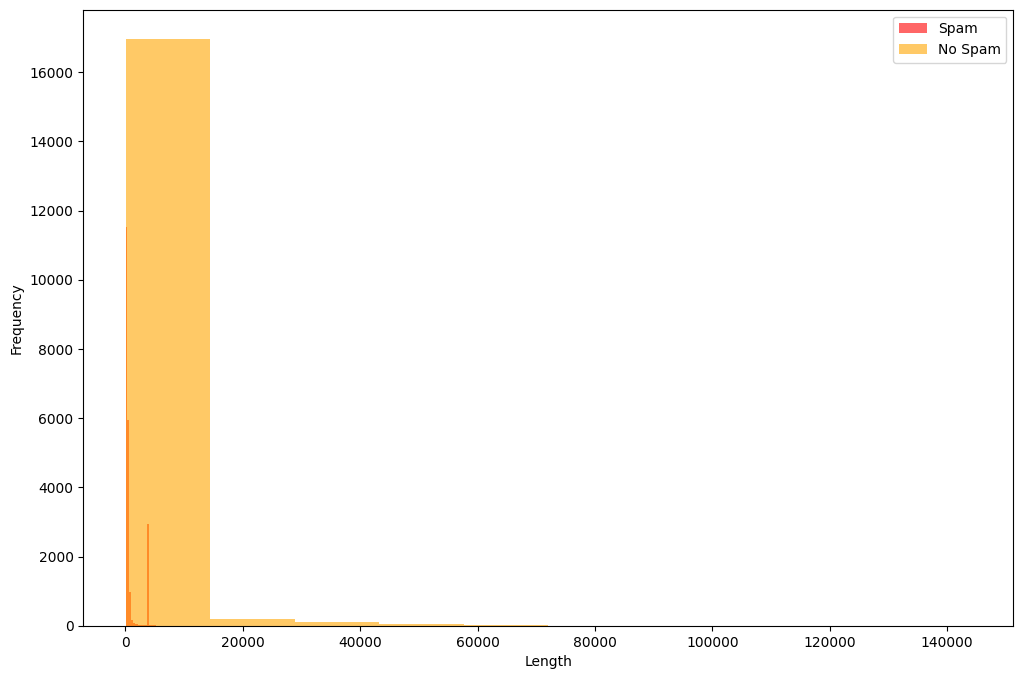

In [144]:
# plot length
plt.figure(figsize=(12, 8))
df[df.label == 1].content_len.plot(bins=35, kind='hist', color='red', label='Spam', alpha=0.6)
df[df.label == 0].content_len.plot(kind='hist', color='orange', label='No Spam', alpha=0.6)
plt.legend()
plt.xlabel("Length")

In [146]:
df[df['content_len'] > 3000]['text_combined']

2        CNN.com Daily Top 10>+=+=+=+=+=+=+=+=+=+=+=+=+...
3        Re: svn commit: r619753 - in /spamassassin/tru...
7        CNN.com Daily Top 10>+=+=+=+=+=+=+=+=+=+=+=+=+...
9        CNN.com Daily Top 10>+=+=+=+=+=+=+=+=+=+=+=+=+...
12       CNN.com Daily Top 10>+=+=+=+=+=+=+=+=+=+=+=+=+...
                               ...                        
39049    [UAI] PhD Studentships at KentFunding is avail...
39051    Best of the Week: Bizarre Accessories and a Sh...
39081    <FRIDAY>  WLANs, SOA, Mac Security, App Delive...
39094    Mail Looping Problem?I've been experimenting w...
39111    [UAI] IJCV special issue on Probabilistic Mode...
Name: text_combined, Length: 6564, dtype: object

# Text Pre-processing

In [147]:
contractions_dict = {
    "ain't": "am not / are not",
    "aren't": "are not / am not",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had / he would",
    "he'll": "he shall / he will",
    "he's": "he has / he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how has / how is",
    "i'd": "I had / I would",
    "i'll": "I shall / I will",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had / it would",
    "it'll": "it shall / it will",
    "it's": "it has / it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "she'd": "she had / she would",
    "she'll": "she shall / she will",
    "she's": "she has / she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that has / that is",
    "there's": "there has / there is",
    "they'd": "they had / they would",
    "they'll": "they shall / they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we had / we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what shall / what will",
    "what're": "what are",
    "what's": "what has / what is",
    "what've": "what have",
    "where's": "where has / where is",
    "who'd": "who had / who would",
    "who'll": "who shall / who will",
    "who're": "who are",
    "who's": "who has / who is",
    "who've": "who have",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you had / you would",
    "you'll": "you shall / you will",
    "you're": "you are",
    "you've": "you have"
}

In [148]:
def expand_contractions(text):
    # Expresión regular para encontrar contracciones comunes en inglés
    contractions_pattern = re.compile(r"(can't|won't|I'll|I've|I'm|you're|it's|that's|what's|there's|isn't|aren't|don't|doesn't|didn't|wasn't|weren't|haven't|hasn't|hadn't|wouldn't|shouldn't|couldn't|mightn't|mustn't|he's|she's|they're|we're|who's|let's|it'll|who'll|who've|who'd|who're|there'll|there've|here's|here'll|here've|here'd|there'd|where's|where'll|where've|where'd|how's|how'll|how've|how'd)\b")
    
    # Función para expandir contracciones
    def expand_match(contraction):
        match = contraction.group(0)
        expanded_text = contractions_dict.get(match)
        if not expanded_text:
            expanded_text = contractions_dict.get(match.lower())
        return expanded_text
    
    # Expansión de contracciones
    expanded_text = contractions_pattern.sub(expand_match, text)
    return expanded_text


In [149]:
df['clean_text'] = df.text_combined.apply(expand_contractions)

In [150]:
lemmatizer = WordNetLemmatizer()

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    mess = mess.lower()
    
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    tokens = [word for word in nopunc.split() if word not in STOPWORDS]

    # Lematization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(lemmatized_tokens)

In [151]:
df['clean_text'] = df.clean_text.apply(text_process)

In [152]:
from collections import Counter

words = df[df.label==0].clean_text.apply(lambda x: [word.lower() for word in x.split()])
label1_words = Counter()

for msg in words:
    label1_words.update(msg)
    
print(label1_words.most_common(50))

[('submissionid', 32246), ('1', 28176), ('submission', 22037), ('0', 21925), ('note', 20006), ('added', 19641), ('sender', 18952), ('virus', 17175), ('2008', 16186), ('total', 14772), ('wrote', 13466), ('list', 13004), ('message', 12547), ('new', 12408), ('email', 11254), ('one', 10733), ('would', 10657), ('use', 10653), ('system', 9735), ('file', 9547), ('university', 9186), ('like', 8993), ('feb', 8900), ('get', 8882), ('time', 8377), ('paper', 8209), ('problem', 8187), ('work', 7744), ('please', 7211), ('also', 7043), ('using', 7037), ('data', 6986), ('mailing', 6861), ('make', 6719), ('may', 6702), ('user', 6666), ('need', 6567), ('see', 6498), ('information', 6149), ('issue', 6083), ('unsubscribe', 5986), ('test', 5945), ('2007', 5919), ('web', 5894), ('name', 5848), ('3', 5822), ('way', 5715), ('line', 5708), ('application', 5574), ('know', 5552)]


In [153]:
from collections import Counter

words = df[df.label==1].clean_text.apply(lambda x: [word.lower() for word in x.split()])
label1_words = Counter()

for msg in words:
    label1_words.update(msg)
    
print(label1_words.most_common(50))

[('10', 20700), ('1', 18481), ('top', 18360), ('cnncom', 14533), ('news', 12863), ('alert', 11275), ('2008', 10337), ('cnn', 10153), ('daily', 8837), ('network', 8726), ('setting', 8684), ('cable', 8673), ('replica', 8048), ('watch', 7779), ('6', 7499), ('8', 7323), ('story', 7299), ('5', 6745), ('time', 6678), ('3', 6620), ('email', 6606), ('7', 6464), ('go', 6333), ('video', 6253), ('0', 6074), ('one', 6009), ('going', 5990), ('9', 5961), ('lp', 5896), ('lllp', 5860), ('custom', 5664), ('name', 5634), ('aug', 5521), ('result', 5188), ('right', 5048), ('suspect', 4837), ('company', 4759), ('receive', 4744), ('center', 4445), ('privacy', 4445), ('unsubscribe', 4432), ('agreed', 4370), ('reserved', 4359), ('manage', 4347), ('atlanta', 4338), ('georgia', 4338), ('preference', 4337), ('30303', 4336), ('warner', 4336), ('get', 4198)]


In [154]:
df['clean_text'] = df['clean_text'] + " <b> " + df['content_len'].astype(str)

# Vectorization

In [155]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_text'])

# Model

In [173]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression

In [174]:
model = LogisticRegression(max_iter=100)

In [175]:
'''
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2']  # Nota: 'l1' no está soportado por todos los solvers
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_'''

"\nparam_grid = {\n    'C': [0.1, 1, 10, 100],\n    'solver': ['newton-cg', 'lbfgs', 'liblinear'],\n    'penalty': ['l2']  # Nota: 'l1' no está soportado por todos los solvers\n}\n\ngrid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')\n\ngrid_search.fit(X_train, y_train)\n\nbest_model = grid_search.best_estimator_"

In [176]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [177]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}a')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.9938705146213765a
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3490
           1       0.99      1.00      0.99      4341

    accuracy                           0.99      7831
   macro avg       0.99      0.99      0.99      7831
weighted avg       0.99      0.99      0.99      7831



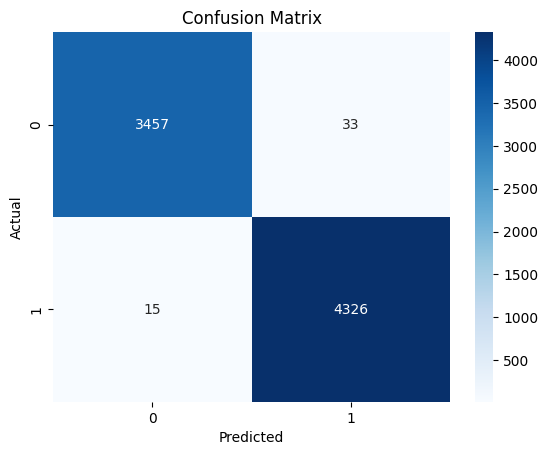

In [178]:
# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [128]:
for review, pred_score, real_score in zip(df['clean_text'][X_test.indices], y_pred, y_test):
    print(f'Review: {review}\nPredicted Score: {pred_score}, Real Score: {real_score}')

KeyError: '[110473, 110333, 93675, 107819, 146193, 147041, 149033, 566018, 207998, 223186, 493501, 515148, 527842, 557128, 432405, 343952, 356464, 181459, 126827, 162909, 195452, 416024, 100354, 603135, 391148, 236813, 177343, 435957, 448759, 152264, 381279, 266268, 391171, 391185, 582335, 575321, 200883, 409037, 400741, 249355, 207733, 526914, 120099, 577191, 414414, 465571, 235504, 461144, 472303, 163617, 493276, 129927, 534250, 251893, 353211, 211847, 564126, 151384, 132008, 125393, 241165, 491731, 83140, 128741, 206889, 590850, 506699, 473117, 149030, 408607, 350880, 483835, 124650, 346336, 562307, 258280, 544699, 603364, 564818, 185817, 120092, 431902, 432017, 514759, 582291, 137751, 162274, 459484, 260006, 214247, 467927, 237050, 130746, 409878, 220109, 287912, 549024, 383946, 212598, 530195, 184737, 592877, 488920, 212931, 236070, 508459, 137643, 207455, 133156, 464214, 488870, 409848, 169860, 516879, 172350, 397823, 140504, 405153, 365997, 470120, 564918, 295503, 498406, 192092, 135443, 465759, 400053, 384036, 251688, 397058, 527486, 585173, 396144, 179852, 243485, 154951, 355641, 342214, 450589, 341943, 187714, 507347, 435336, 347513, 136734, 403198, 585705, 218320, 269437, 188108, 454460, 511764, 529006, 119706, 394314, 413136, 510528, 491537, 434381, 432259, 463739, 473455, 123441, 522587, 374510, 589098, 428375, 528087, 185424, 278871, 365300, 171619, 213630, 517046, 544538, 354520, 532126, 504811, 591225, 463817, 443111, 294141, 409266, 384685, 183499, 271300, 254794, 255494, 463628, 369305, 467043, 287572, 233351, 537030, 568616, 259306, 435797, 471399, 250122, 92231, 129795, 438051, 459104, 584804, 526907, 165720, 82870, 601341, 122086, 83633, 378443, 387902, 464199, 549763, 484770, 86403, 269019, 498178, 423371, 372399, 180717, 180716, 308191, 355162, 537354, 488800, 419618, 195902, 399917, 524414, 234806, 278767, 590402, 405398, 119774, 355736, 286601, 525429, 412910, 582340, 179033, 466492, 260718, 165595, 252027, 259428, 517827, 350866, 386306, 442093, 423466, 248286, 386252, 395579, 427119, 293613, 258645, 521761, 275191, 490071, 410802, 386260, 488846, 510704, 545027, 139368, 158962, 183596, 487504, 508362, 156840, 496910, 423168, 192014, 357886, 227317, 275839, 384711, 348226, 491188, 384931, 152796, 289719, 251748, 229420, 422339, 181979, 402463, 109648, 141139, 390287, 181253, 276308, 514735, 414005, 430171, 426211, 395333, 502977, 522480, 293908, 271100, 544653, 366028, 588063, 588059, 588064, 588060, 347337, 347338, 588057, 448593, 271332, 496304, 545919, 506230, 477219, 566571, 588047, 309019, 379708, 477155, 544647, 494554, 134862, 157570, 205381, 476929, 449908, 343687, 217083, 344962, 244910, 470857, 579775, 591930, 382019, 497189, 117269, 244139, 510910, 204729, 394364, 188526, 401161, 470393, 157539, 402130, 481584, 339164, 544632, 518716, 556915, 283849, 492901, 135338, 207490, 264213, 524103, 183850, 470831, 429817, 402606, 475887, 237032, 489754, 430803, 541184, 392151, 575491, 556882, 241413, 347165, 395300, 169419, 545715, 146409, 169688, 270987, 258294, 253896, 570395, 541422, 366685, 493146, 148141, 464118, 458852, 292093, 204182, 351455, 135713, 487034, 492039, 120187, 196423, 589060, 147725, 492468, 174105, 492213, 550916, 239756, 400274, 511492, 93614, 436274, 492028, 394556, 486968, 347567, 455762, 338221, 491430, 542551, 274594, 378735, 281186, 406360, 235569, 485110, 151077, 418205, 404698, 436472, 274043, 254974, 436525, 584787, 140409, 353049, 332942, 193302, 332929, 205368, 439031, 384854, 289602, 396113, 260302, 204979, 507050, 193291, 144928, 257934, 481498, 542665, 124181, 502619, 260383, 354935, 333087, 585864, 602202, 545991, 353032, 507044, 435396, 193358, 259174, 523019, 163099, 243643, 543501, 514971, 143434, 338103, 283602, 136821, 219705, 200010, 396160, 243639, 236527, 484849, 211726, 248228, 186281, 388861, 255923, 508111, 456755, 506959, 591180, 421713, 161911, 242969, 120697, 396110, 408772, 264159, 246667, 193272, 471801, 532073, 122750, 126509, 533141, 411265, 384343, 449418, 510898, 486507, 346519, 402370, 395419, 269489, 266054, 395759, 484362, 175874, 488007, 129893, 332937, 436161, 582139, 176684, 470351, 156106, 446822, 386204, 406676, 200062, 289598, 208681, 230033, 153117, 568675, 217970, 484824, 290681, 512002, 122000, 187347, 175852, 521647, 122022, 490099, 511805, 497736, 275065, 521684, 386768, 235480, 583322, 211942, 444707, 243141, 189721, 277829, 279997, 129217, 585237, 196228, 211929, 273131, 121923, 191696, 544044, 516335, 548841, 590696, 548182, 417912, 299424, 176068, 144331, 590199, 356270, 309071, 309016, 611963, 477029, 333354, 415262, 208789, 349631, 235361, 583011, 417270, 505861, 389602, 350210, 584181, 565747, 229416, 170288, 189526, 533356, 541908, 248192, 106799, 178720, 544061, 522231, 208830, 138696, 467198, 505184, 191175, 522221, 486627, 582555, 508048, 410808, 201659, 201002, 464803, 89525, 93793, 174647, 483739, 585523, 154432, 522477, 515925, 358703, 333008, 282332, 251638, 249472, 199721, 537498, 557334, 323130, 306657, 542633, 319695, 322400, 350374, 298364, 370558, 100480, 134521, 397136, 163490, 333267, 243839, 559789, 140157, 274665, 169217, 444021, 576352, 377435, 195581, 276882, 610138, 280937, 473708, 441519, 436981, 334089, 444033, 420258, 561932, 606134, 427707, 241334, 551642, 355065, 157186, 601262, 381724, 578213, 478137, 341502, 505298, 367440, 542774, 374138, 478061, 138693, 427708, 610094, 542772, 161520, 542773, 370472, 437819, 335317, 578723, 268045, 431360, 381409, 433377, 542775, 143396, 281320, 232494, 459973, 542776, 542777, 172690, 155789, 515376, 130348, 561166, 97815, 109921, 321908, 318862, 259355, 95046, 215656, 555051, 205296, 555693, 555465, 556019, 556213, 205328, 555594, 554741, 554070, 554053, 554154, 553678, 552582, 552583, 552878, 552584, 554164, 556276, 554858, 554982, 555009, 506074, 555513, 553467, 556272, 588270, 553119, 556106, 556061, 99494, 230826, 555056, 558986, 228496, 493007, 555956, 555185, 377761, 410027, 555135, 221572, 142779, 372526, 180606, 308542, 577583, 367014, 555052, 555120, 452345, 530864, 199370, 561966, 314880, 314878, 355627, 176280, 585084, 585147, 541993, 189584, 388890, 409246, 195099, 426669, 582097, 187006, 259326, 169724, 552450, 91865, 469897, 247901, 162137, 155735, 333590, 473243, 237906, 180591, 410846, 510280, 562770, 563657, 510292, 432362, 228189, 269222, 269723, 515445, 608918, 196307, 288625, 447696, 557132, 239554, 128264, 402336, 163686, 564905, 580071, 486644, 344932, 345958, 212050, 252156, 535066, 488263, 246536, 175762, 206112, 178385, 451088, 459311, 417051, 450882, 417880, 347557, 466787, 439227, 413008, 155758, 255185, 156143, 534490, 470691, 445525, 189031, 155788, 133314, 413431, 151401, 212345, 244553, 383089, 190897, 174219, 488450, 128532, 586319, 339933, 217592, 516456, 602089, 391088, 349534, 176949, 582489, 194149, 585635, 207889, 470663, 354862, 242703, 208783, 135432, 423580, 491184, 346345, 504755, 511690, 577679, 530863, 410518, 469368, 408956, 141684, 350140, 543217, 392465, 177603, 158934, 213668, 295277, 185555, 590721, 470182, 349243, 346245, 539155, 386399, 245988, 174854, 567186, 357691, 417854, 539186, 471068, 457123, 534863, 232329, 406547, 539200, 453162, 539126, 388837, 506398, 207715, 533215, 367051, 189430, 186996, 587864, 543425, 270714, 389992, 121151, 141526, 557694, 119927, 141976, 470024, 270298, 351633, 187308, 475724, 358786, 403102, 209059, 253812, 471560, 386389, 445083, 376517, 251475, 236022, 480753, 568113, 530892, 207416, 453474, 209104, 204001, 345785, 245868, 283737, 530872, 284427, 246272, 119913, 510548, 417028, 475203, 449065, 442409, 488267, 492831, 187327, 493204, 139188, 349141, 386442, 259352, 275085, 566347, 507447, 344978, 245873, 436238, 481157, 549122, 472258, 527306, 180801, 446863, 487026, 119965, 345822, 244663, 550528, 572950, 269491, 361421, 201019, 423576, 559500, 563914, 232734, 190742, 121955, 576369, 399949, 532733, 471544, 176811, 412387, 496642, 538955, 569199, 245215, 140422, 211996, 488405, 489582, 579214, 591907, 382941, 584721, 488607, 454271, 129708, 222608, 390519, 523883, 566329, 403116, 204040, 535515, 481192, 201278, 491746, 169460, 556581, 436061, 175766, 102356, 199368, 452587, 558963, 384602, 84195, 390918, 447907, 251501, 369384, 404097, 101115, 530732, 188900, 186913, 490121, 226138, 226201, 140489, 167481, 123230, 255911, 440261, 162408, 195901, 480989, 613682, 383001, 383783, 226157, 501755, 404031, 226170, 194918, 389917, 477420, 406414, 398036, 551526, 501786, 383784, 248494, 455620, 226216, 512372, 234993, 473421, 402408, 613673, 128677, 504091, 391674, 235978, 533126, 515626, 399184, 276459, 226139, 511329, 186922, 226191, 137449, 167483, 508422, 465891, 454916, 163129, 139330, 403997, 120151, 397479, 226164, 473867, 133255, 613706, 410093, 501758, 473872, 501773, 613695, 142678, 214695, 276458, 189899, 579186, 515291, 523502, 577081, 471474, 425283, 226172, 129162, 403671, 508364, 467971, 446936, 419888, 578028, 440259, 173814, 481098, 453850, 459748, 484727, 459767, 160560, 572540, 361637, 124490, 539861, 512134, 142210, 436464, 125613, 173923, 207736, 174602, 141480, 185619, 521950, 208966, 277411, 402312, 522337, 481090, 179511, 467988, 217952, 194065, 521731, 185931, 579602, 237138, 142213, 174637, 126573, 467989, 436454, 200377, 564097, 248522, 579627, 171362, 429347, 537403, 212840, 431787, 254927, 481310, 577936, 141320, 354571, 369454, 236747, 191586, 118843, 394167, 360330, 222339, 481020, 236860, 426521, 126330, 447626, 469693, 242253, 522890, 507884, 453598, 467946, 428333, 160036, 449324, 519026, 580550, 436356, 600467, 519010, 466517, 273161, 170663, 453899, 200003, 161316, 203916, 515128, 464722, 539956, 389977, 244041, 235137, 610540, 455718, 241338, 563209, 140534, 173571, 258850, 169779, 99319, 105561, 400837, 103353, 88480, 508779, 151226, 185410, 568643, 514194, 447599, 403474, 257518, 488582, 503035, 395865, 494658, 526849, 402758, 236406, 345185, 496579, 469964, 232167, 150743, 503453, 286380, 384902, 512364, 603620, 262214, 349389, 223468, 126617, 392610, 378476, 505109, 466636, 187801, 383548, 287607, 348710, 213440, 287617, 427243, 454643, 517216, 391299, 191472, 124397, 344534, 261490, 536565, 133338, 526706, 458042, 236274, 101648, 106299, 259491, 112445, 349908, 176638, 428653, 185191, 127362, 397953, 306599, 426809, 462462, 378197, 177350, 223927, 349929, 524203, 488029, 193794, 528060, 597117, 528040, 550542, 161962, 552259, 142331, 437203, 608974, 168186, 210047, 143930, 339862, 225663, 158317, 340889, 209859, 341145, 407305, 607662, 143484, 211002, 606028, 225701, 611161, 611208, 167989, 183012, 180036, 339960, 145576, 197364, 125793, 340249, 230619, 167770, 158058, 340666, 340739, 336066, 143477, 243794, 603001, 606073, 145545, 603058, 495776, 153890, 605473, 430943, 372713, 456350, 541953, 189582, 176295, 148644, 83772, 353000, 406651, 377291, 496820, 401943, 323275, 508885, 436617, 162007, 392550, 293981, 139543, 351467, 497752, 565148, 588816, 272455, 565924, 403063, 212042, 540378, 563668, 181903, 128691, 508448, 395371, 235723, 221428, 190058, 339296, 204512, 551054, 245969, 463920, 351450, 250500, 514391, 556841, 194008, 276521, 156000, 192123, 213488, 234928, 180942, 235998, 428406, 204218, 389814, 559633, 184696, 514742, 129450, 177477, 289463, 248950, 134339, 413569, 590897, 181545, 170792, 395990, 219182, 134360, 160365, 123138, 471590, 220927, 146562, 455747, 176077, 191230, 489616, 446598, 193715, 290392, 141981, 290647, 394312, 489759, 556775, 349898, 441904, 139144, 584594, 134297, 121398, 243264, 428928, 468029, 390495, 243405, 234895, 577818, 134310, 395102, 461285, 213498, 454917, 260000, 430112, 521081, 457655, 345779, 507270, 415008, 543997, 181512, 486207, 395134, 196208, 443727, 428664, 447403, 414504, 264762, 582564, 491033, 494765, 286496, 92232, 105834, 575229, 105059, 190596, 191156, 588890, 137558, 134325, 97009, 487496, 492087, 308644, 349630, 379952, 490794, 541070, 133465, 394492, 364705, 238851, 498144, 260704, 423159, 582613, 172097, 471733, 565674, 502917, 89741, 169365, 258038, 493664, 366031, 192228, 464064, 269511, 558014, 454470, 518942, 492626, 551296, 395921, 238655, 395251, 94516, 447891, 503848, 178203, 139233, 129966, 440670, 512210, 412864, 275451, 233139, 185862, 510209, 154843, 97277, 532717, 503222, 125571, 348499, 239076, 257489, 255821, 245441, 249606, 240021, 237727, 246781, 237884, 238164, 245602, 244836, 171593, 384293, 235333, 83156, 372931, 530455, 243424, 464253, 138667, 367837, 410553, 201113, 209588, 209586, 410554, 514873, 323146, 338292, 338256, 495657, 201106, 338336, 256847, 196161, 199602, 328779, 316086, 494057, 491265, 287907, 371887, 509518, 468882, 563601, 248889, 185661, 410566, 410547, 470104, 410551, 201224, 490416, 467542, 248172, 280083, 457981, 405838, 490418, 186639, 576945, 135426, 498529, 480592, 110537, 272408, 414213, 129923, 446336, 471782, 267803, 185870, 395740, 273142, 395318, 206279, 260675, 508890, 508882, 237202, 375047, 185167, 531878, 95616, 489997, 542543, 584757, 141174, 172827, 484800, 134042, 318908, 543093, 133985, 510791, 514484, 473419, 286602, 264029, 255652, 529916, 408655, 486455, 191929, 245731, 292084, 246877, 486347, 84773, 388102, 373906, 230044, 236865, 401281, 107190, 410945, 418244, 350467, 210838, 294938, 345579, 480861, 480862, 345893, 514136, 551085, 246113, 206458, 122896, 472827, 383838, 490949, 487186, 576932, 531957, 351659, 214016, 135641, 419783, 258182, 490311, 113102, 118961, 189324, 202240, 510797, 189775, 206467, 259816, 550491, 470878, 230926, 424500, 535361, 538403, 424499, 424501, 535362, 159293, 473472, 238479, 140734, 550487, 354068, 535317, 267087, 538270, 559495, 542709, 572654, 503660, 293140, 348875, 283851, 454819, 540080, 169499, 544711, 237428, 244594, 453744, 434642, 345602, 255057, 590736, 545685, 470436, 590782, 552137, 576504, 236549, 413545, 190180, 503074, 408810, 238908, 225892, 576425, 530067, 403089, 447431, 249658, 529899, 410086, 366071, 590295, 287317, 508564, 417970, 504963, 203447, 339566, 405675, 137665, 184409, 160223, 426134, 584259, 582458, 565132, 272954, 279716, 456090, 284000, 159214, 151437, 425727, 486398, 514768, 262735, 170397, 283566, 577540, 537633, 487510, 386291, 475420, 155294, 185331, 579138, 470516, 579331, 346464, 385124, 293854, 207679, 189966, 513818, 231270, 237529, 151357, 139423, 462036, 518512, 529445, 491770, 462810, 491203, 174279, 585660, 226779, 413687, 528796, 159845, 236701, 514755, 276701, 494521, 264101, 286072, 586241, 254815, 524220, 402270, 347878, 531660, 450141, 181916, 164521, 230600, 278075, 119903, 584232, 254827, 411299, 258965, 531647, 185698, 512056, 573367, 278974, 472422, 503397, 409257, 544548, 467089, 484510, 194160, 191784, 529197, 269476, 458580, 394014, 255890, 411019, 245685, 148854, 428521, 186620, 237674, 440269, 404624, 282813, 345808, 511347, 211962, 457802, 443377, 129177, 418508, 148672, 135664, 491439, 186625, 159022, 109969, 93613, 113525, 489572, 212916, 528565, 393214, 429370, 515301, 294611, 125555, 89610, 170477, 236674, 120366, 347612, 535629, 350118, 471579, 347570, 486653, 471550, 409857, 103245, 568140, 568161, 107441, 568117, 120199, 120372, 251208, 261379, 204055, 236671, 351315, 518508, 142023, 134009, 123614, 287629, 147792, 488889, 350117, 459119, 163226, 345392, 472606, 530900, 351493, 564766, 120492, 159891, 254904, 496492, 114588, 575200, 348208, 394721, 236815, 248438, 422928, 473458, 128132, 408619, 488619, 471577, 508633, 509281, 418522, 206492, 563226, 188100, 186136, 541866, 506049, 510859, 94531, 414443, 499999, 375335, 414219, 383544, 163130, 275870, 433847, 491604, 453748, 459402, 278523, 519451, 432550, 559658, 535211, 277340, 543396, 400703, 526643, 162520, 469790, 259387, 207880, 500775, 563966, 88197, 405596, 186976, 565416, 124353, 470066, 234868, 148163, 269506, 461408, 178033, 133315, 573389, 169680, 560925, 475074, 436310, 119488, 446798, 258991, 184229, 386894, 260692, 470730, 152389, 535229, 462915, 277330, 344915, 440236, 270422, 142523, 139199, 121088, 432535, 446794, 351718, 526993, 282686, 293267, 188942, 364708, 293663, 349725, 491839, 518678, 520721, 278959, 229368, 283500, 573407, 133203, 170073, 461645, 212976, 472453, 415203, 510820, 427273, 168653, 464018, 228390, 470812, 179779, 573643, 231169, 346382, 440768, 517132, 448896, 551531, 189143, 228845, 188868, 263495, 470061, 186389, 186283, 537194, 236540, 186270, 286045, 131654, 586965, 358289, 546401, 387349, 122150, 489810, 530037, 497347, 93759, 472932, 135578, 208685, 348719, 177935, 515696, 526753, 455476, 287174, 164904, 180734, 229540, 228602, 135135, 101669, 107101, 469809, 513600, 192227, 135752, 355510, 472005, 465990, 417414, 300875, 465988, 491979, 576725, 466876, 540347, 169792, 163088, 483479, 394146, 395712, 440227, 110890, 440314, 142502, 505656, 497418, 159175, 264170, 407283, 256583, 436201, 244989, 495248, 186679, 413500, 254916, 163452, 526626, 454569, 194528, 229177, 446816, 136548, 440815, 499912, 361089, 120708, 516290, 154713, 461046, 345172, 119901, 467877, 244864, 412785, 563616, 460802, 186242, 277650, 185943, 395042, 537175, 574778, 517789, 392650, 155024, 531305, 179468, 403110, 244947, 590414, 489829, 205049, 185803, 202475, 199499, 495195, 346090, 189724, 497394, 125889, 249689, 473477, 386815, 143214, 230163, 454430, 524724, 169332, 150597, 274247, 513625, 384957, 284143, 540800, 276375, 165456, 484119, 153364, 475816, 164659, 430430, 568749, 442549, 153018, 150989, 394000, 243365, 339273, 497417, 362714, 293388, 492171, 601676, 286813, 457177, 227106, 481319, 541394, 518927, 387777, 488102, 507107, 494401, 564536, 358508, 346048, 249254, 248220, 196593, 243391, 413285, 235157, 267493, 506046, 294029, 335328, 129427, 176587, 244809, 213916, 577090, 345062, 208226, 176591, 238913, 521047, 532330, 512294, 396092, 587171, 548956, 587383, 532704, 282709, 413969, 516240, 277845, 93304, 514113, 403820, 491497, 275976, 486194, 123706, 275974, 123551, 533371, 123554, 121600, 262124, 515611, 473483, 89552, 565109, 521992, 583711, 416465, 593487, 264166, 415478, 406320, 446266, 535099, 446197, 240282, 446237, 395628, 251491, 188061, 585467, 535127, 490369, 288233, 251904, 149431, 391742, 156850, 526904, 196151, 148504, 588790, 384267, 473005, 431881, 537926, 431922, 450906, 453027, 135098, 567372, 289348, 406167, 192034, 232006, 105615, 171100, 361355, 391331, 123320, 134903, 446190, 589294, 248034, 543875, 412813, 147128, 432566, 361290, 378239, 459445, 259259, 429845, 209100, 207465, 523988, 520674, 486182, 186436, 244919, 135623, 103856, 397637, 565123, 463935, 454583, 591794, 504659, 165002, 164769, 244583, 465552, 259825, 604103, 212834, 234530, 473187, 270158, 114037, 480016, 399207, 186484, 493260, 530246, 93557, 577894, 566485, 467039, 588357, 568653, 367075, 179876, 132322, 552139, 404288, 522184, 300874, 378184, 397604, 585333, 603964, 404287, 147850, 189790, 205500, 212404, 227135, 152965, 531125, 195932, 472146, 170897, 255005, 89532, 130728, 89911, 88052, 86808, 88102, 88090, 88135, 290004, 94078, 88162, 513522, 137873, 126622, 227716, 283706, 413792, 506441, 137494, 385140, 514278, 484402, 111151, 139308, 345386, 440767, 333375, 377195, 206086, 537371, 513148, 366180, 355129, 579701, 537174, 350593, 490143, 132944, 171227, 349675, 346373, 175991, 361061, 407681, 360721, 538223, 492561, 466913, 378518, 491069, 550651, 350585, 169363, 201523, 360588, 376550, 537120, 162866, 94391, 262160, 420344, 227510, 163418, 94044, 265061, 392787, 413068, 255805, 349292, 131466, 472652, 487353, 503199, 186074, 346050, 283843, 122751, 373861, 230875, 257884, 435405, 188967, 515723, 518911, 491600, 370274, 356404, 394099, 585380, 246419, 218173, 249335, 596927, 596804, 598121, 348231, 345925, 489036, 106454, 375237, 527169, 231495, 516357, 165784, 175776, 95327, 127142, 187355, 283934, 582424, 131822, 309422, 140709, 601560, 255194, 266744, 127939, 486236, 272266, 83424, 254864, 250071, 550054, 497057, 130695, 582412, 466332, 384322, 165766, 187711, 388430, 101019, 544326, 434610, 462880, 388429, 113615, 182302, 293357, 160270, 374919, 187333, 189144, 559650, 116116, 399336, 130821, 564553, 388291, 116911, 530898, 469280, 449960, 453849, 388428, 333049, 527353, 95727, 174224, 488264, 88177, 447643, 447641, 432175, 575617, 467206, 195119, 543397, 467720, 386612, 596046, 208146, 498380, 163098, 436506, 414643, 234923, 488265, 130001, 491916, 545957, 444365, 388283, 184284, 184602, 453072, 240873, 577304, 236586, 447627, 206916, 472637, 166020, 475118, 264218, 139135, 469498, 446622, 192385, 531114, 289967, 403244, 491763, 469180, 502805, 351630, 447694, 138311, 460887, 550581, 140969, 444981, 393747, 123463, 454408, 351702, 189176, 175514, 255826, 234830, 456856, 133158, 172133, 214378, 570131, 453692, 258034, 204728, 292367, 243172, 131158, 440601, 345699, 244525, 292215, 531060, 259317, 214414, 376721, 463710, 188874, 387981, 208111, 488254, 549317, 576979, 459263, 463809, 470040, 187684, 454422, 410296, 467810, 509345, 408691, 264002, 545654, 527563, 544896, 582272, 253619, 245594, 243151, 129248, 590579, 486952, 289647, 140405, 586514, 174434, 440664, 394319, 139352, 346372, 87005, 493198, 151016, 121454, 580619, 410309, 240999, 351474, 386381, 395855, 487016, 486966, 119002, 377779, 565851, 440131, 551076, 392619, 285119, 379012, 506647, 548630, 176423, 252578, 452179, 130411, 379167, 377778, 130410, 539869, 361631, 500115, 520976, 471127, 611758, 441259, 530339, 412383, 287124, 239641, 231311, 141092, 440050, 392625, 289530, 261146, 207764, 169643, 563690, 98666, 403591, 206991, 140862, 576749, 176395, 430598, 161235, 267863, 608959, 577299, 188369, 208222, 174438, 112748, 535468, 591792, 211142, 489049, 481419, 558165, 558150, 256337, 93176, 601628, 531152, 352575, 488762, 248662, 307028, 479585, 482317, 464622, 131855, 550749, 287394, 415412, 353423, 466344, 565497, 410537, 603712, 139196, 512028, 489670, 386274, 421929, 532875, 339285, 99637, 583110, 172079, 286081, 494610, 572770, 405824, 103213, 187546, 185652, 121479, 582853, 213362, 207811, 430388, 207809, 491930, 279841, 207812, 394112, 232267, 244778, 293972, 232597, 275540, 441916, 513034, 505039, 457833, 441929, 462527, 492151, 521358, 473473, 189272, 259419, 583083, 178056, 185476, 232251, 440385, 236875, 208375, 235774, 256542, 355010, 256541, 484390, 484386, 297760, 346229, 522885, 197330, 309043, 309012, 519528, 498229, 506481, 476960, 355019, 591264, 270149, 161998, 513052, 244592, 269466, 280120, 346222, 162537, 545180, 544535, 602136, 452371, 602132, 531671, 573058, 536518, 111125, 260064, 522786, 544382, 545144, 471552, 354966, 311876, 92880, 102152, 556970, 183063, 545412, 412179, 141223, 200624, 563737, 339276, 350558, 490797, 205527, 94712, 519558, 186571, 490251, 206161, 206113, 492910, 140495, 121243, 490000, 481269, 107724, 540325, 582793, 193603, 243246, 93042, 509293, 486630, 110517, 541675, 264008, 537668, 541360, 263448, 506660, 86293, 157209, 222382, 541346, 514703, 512289, 284847, 207493, 245919, 458196, 529399, 129540, 245762, 345914, 186321, 261835, 137427, 349102, 284270, 514149, 132324, 146738, 387886, 532873, 141713, 387035, 244081, 349703, 189418, 551238, 245223, 549251, 402247, 548664, 458127, 413163, 97553, 83199, 86404, 214390, 542438, 450463, 387885, 318707, 139996, 242913, 283529, 159661, 400002, 333321, 151603, 367147, 447420, 266371, 175685, 414971, 150641, 83682, 277538, 564704, 548276, 99484, 178430, 178428, 573189, 438012, 274080, 204529, 440769, 521619, 129180, 468851, 497196, 93472, 521706, 558138, 460222, 545129, 216885, 318654, 391107, 374700, 572686, 286524, 333504, 258804, 295003, 480528, 347408, 389942, 162965, 165544, 453970, 548369, 94461, 213527, 457464, 89261, 178834, 128514, 121235, 490297, 86889, 112201, 492519, 492533, 170230, 269467, 511374, 322449, 228243, 401797, 431698, 316000, 249240, 564042, 180900, 162114, 435146, 560443, 609480, 565092, 154810, 132182, 190913, 527945, 430565, 496862, 526677, 523537, 193475, 205477, 121838, 543707, 345583, 577916, 121833, 574479, 489874, 241808, 475162, 121847, 152420, 351609, 213509, 603590, 211923, 277533, 254706, 189169, 551426, 416038, 184688, 204739, 190487, 188461, 165462, 276129, 165308, 459160, 181448, 119991, 133169, 588609, 186414, 383018, 235410, 383022, 511339, 333082, 208394, 489975, 346057, 392536, 175589, 196330, 486257, 147208, 472848, 185268, 570723, 190109, 500490, 516478, 254627, 523978, 471345, 276518, 143200, 550772, 601658, 123602, 131204, 510981, 213544, 532993, 93797, 213613, 403577, 304185, 500061, 343760, 196123, 82785, 561504, 337610, 134011, 560645, 529029, 161649, 165101, 455113, 187984, 604320, 187985, 516896, 458661, 187977, 458727, 603513, 99888, 584770, 230380, 523724, 345726, 245194, 208122, 565128, 222477, 273631, 216895, 508868, 245576, 244923, 358237, 441025, 491494, 208831, 216692, 202890, 180761, 470792, 512166, 147767, 366013, 366006, 207885, 189013, 403197, 175522, 492646, 262988, 531500, 184597, 489594, 408709, 151765, 450484, 274119, 472546, 139442, 472002, 185952, 236267, 258041, 346533, 270089, 414678, 442057, 177418, 172402, 576570, 488622, 586908, 470013, 591001, 487300, 240939, 193649, 532802, 212885, 446339, 446066, 449981, 513245, 487006, 182019, 229648, 190427, 494534, 492292, 248147, 190434, 120261, 141023, 459230, 193597, 349401, 488844, 171711, 564741, 470975, 403148, 200333, 212858, 255430, 99959, 122875, 441996, 461787, 237056, 189947, 293878, 127663, 304523, 579875, 376650, 456894, 160520, 541384, 269988, 333290, 87109, 535188, 422163, 262444, 416430, 570637, 84259, 540998, 416070, 230630, 193459, 520646, 498084, 90357, 275544, 495510, 359686, 231529, 437098, 416202, 171533, 430700, 232136, 193774, 100159, 531714, 343805, 157721, 205422, 391269, 456370, 406302, 459551, 277313, 149468, 520590, 406303, 137197, 158553, 446814, 488368, 351697, 565605, 418648, 490776, 269501, 193744, 484843, 190671, 492400, 147851, 253397, 188839, 450839, 160336, 452249, 284050, 155357, 124891, 363990, 160422, 459591, 541295, 248914, 473186, 396178, 111367, 395829, 146207, 254934, 539334, 169389, 394061, 192043, 475827, 277172, 531083, 257180, 484775, 253929, 351537, 385153, 228964, 415037, 292107, 508833, 131667, 490863, 174083, 465864, 204494, 348962, 428869, 489067, 473194, 522608, 484225, 369153, 151428, 450962, 524585, 254519, 101116, 217342, 274650, 472399, 521520, 227085, 428867, 545322, 139349, 256440, 166128, 89407, 526574, 113295, 120157, 113768, 386821, 521318, 265444, 192409, 114325, 570697, 460019, 113003, 401452, 257241, 106544, 191039, 551171, 101913, 564255, 513067, 249573, 505809, 513068, 259237, 350338, 470787, 470786, 188121, 601566, 532944, 139454, 151915, 470117, 546329, 549792, 428496, 522003, 262814, 153067, 193997, 403285, 516409, 235529, 277931, 591186, 275111, 454077, 522218, 508489, 567054, 346140, 397481, 400230, 516735, 542548, 119330, 487172, 163076, 489834, 588867, 196410, 489226, 533235, 502585, 153069, 346192, 264291, 245197, 430136, 242694, 567038, 487171, 293736, 251361, 471097, 533008, 277625, 157297, 530362, 433892, 531557, 449952, 188886, 428965, 549019, 500348, 551143, 349299, 163369, 293264, 247988, 99077, 454553, 470080, 514563, 492337, 529380, 428866, 529698, 187835, 531317, 248046, 566572, 458089, 293232, 119435, 386966, 373920, 502706, 491559, 351703, 551362, 101885, 112835, 115314, 258309, 123598, 139237, 586283, 115473, 102702, 159711, 328470, 320410, 148094, 267796, 162903, 321653, 297258, 213620, 391300, 499523, 159446, 287748, 515985, 254517, 558341, 497836, 273984, 383160, 406296, 248890, 191562, 493063, 513451, 540289, 141616, 148089, 276668, 131841, 344378, 182081, 254571, 487571, 211748, 290303, 143182, 207814, 584114, 208289, 386812, 449737, 282534, 217340, 157690, 469695, 159704, 584105, 180868, 588624, 275513, 208260, 450326, 532702, 518264, 487684, 157840, 395772, 431877, 184334, 390785, 412997, 374340, 558340, 109543, 173911, 487523, 177563, 282210, 230031, 273758, 244622, 494868, 226993, 436918, 434580, 434896, 590726, 339192, 517730, 189170, 516115, 483295, 205661, 235161, 230132, 539018, 433881, 544505, 134703, 533192, 178121, 264353, 345174, 159440, 529424, 516173, 162751, 486489, 510638, 490865, 359089, 285294, 378474, 220872, 563908, 134348, 139430, 506938, 287786, 516063, 345171, 573421, 436190, 248163, 472753, 500421, 244535, 186878, 190090, 419789, 524985, 139415, 462803, 224888, 304287, 409669, 400017, 520980, 552013, 332904, 475625, 88359, 206842, 130159, 386277, 273138, 260961, 304011, 279336, 283269, 260958, 512181, 262138, 473410, 184209, 387360, 230054, 134711, 84843, 585529, 462256, 309807, 255517, 249601, 431923, 491987, 507236, 455073, 490910, 504313, 194891, 273679, 369435, 84511, 204574, 292460, 99674, 411405, 440532, 536915, 583254, 515888, 518374, 84366, 83970, 385300, 364773, 416843, 557630, 486155, 221597, 586893, 171432, 349714, 470717, 417956, 446847, 349610, 472963, 518951, 251398, 492341, 263827, 186430, 413063, 430107, 214600, 255330, 594479, 133696, 245542, 484553, 435853, 269502, 220886, 377050, 169923, 570255, 537762, 245515, 278954, 413468, 528176, 496982, 508199, 495384, 252232, 587778, 148845, 222170, 419037, 246331, 515700, 470528, 228365, 471786, 189729, 419663, 185252, 206701, 445980, 170431, 471819, 374810, 488008, 113069, 108649, 411222, 97010, 98274, 531645, 470816, 511196, 268121, 168579, 226288, 247800, 226673, 168602, 226334, 167544, 403419, 152159, 433267, 112636, 414218, 152158, 204714, 133916, 498069, 244729, 282397, 603353, 387072, 564815, 475984, 282451, 432186, 353751, 468286, 180883, 188340, 277954, 433201, 391165, 147949, 119758, 429545, 214605, 277546, 574989, 596634, 489994, 234433, 189868, 289908, 292165, 189932, 455904, 456664, 204583, 124685, 558740, 348543, 550658, 465228, 381611, 384352, 290622, 188780, 137936, 503738, 530271, 138859, 390164, 246360, 513953, 93938, 135657, 229024, 135149, 523817, 161158, 120088, 576679, 218809, 174185, 142749, 180854, 131195, 490614, 131188, 174163, 272651, 292865, 141157, 272995, 435903, 84051, 169997, 279808, 283873, 237936, 294412, 577816, 472446, 363133, 130987, 606967, 160441, 169569, 120753, 246663, 259505, 523926, 411027, 564687, 387824, 211844, 588321, 165603, 157279, 171176, 249798, 189434, 533441, 447605, 519466, 275854, 251755, 146780, 583363, 349205, 95639, 523983, 537078, 429085, 321263, 321288, 321287, 321262, 321265, 321286, 321277, 321264, 321273, 321268, 180633, 321350, 321349, 321354, 321343, 267314, 321341, 321346, 321344, 321342, 321345, 148225, 594474, 321351, 383290, 440070, 298431, 321299, 321300, 321296, 86627, 393349, 440061, 183342, 486496, 372144, 552027, 486204, 133618, 218310, 549757, 465966, 529739, 185655, 400533, 566499, 133668, 155186, 280191, 207693, 199470, 360517, 423277, 533060, 159984, 414903, 556784, 257023, 290057, 407345, 259735, 84112, 385258, 289508, 413037, 248656, 199034, 470138, 183329, 540779, 491332, 181779, 391902, 160289, 277432, 140177, 217925, 230483, 155484, 168779, 229354, 414079, 243517, 217112, 220371, 566674, 376408, 280094, 149117, 526900, 534416, 475640, 485082, 415120, 469475, 181985, 582784, 220891, 396291, 125558, 89152, 179404, 132387, 157792, 534098, 157678, 286821, 524229, 211552, 419830, 293707, 323140, 256443, 590531, 219251, 430480, 397922, 444238, 468178, 407342, 324947, 365013, 462125, 613269, 259664, 301390, 520650, 536686, 178315, 133897, 270123, 522131, 496602, 438212, 459423, 199270, 267024, 498431, 475531, 487233, 185171, 563339, 515062, 403818, 252326, 463707, 293081, 151136, 119066, 354071, 389192, 119690, 354117, 147898, 257067, 591833, 565551, 407813, 584099, 191060, 582585, 509161, 453759, 190153, 206852, 573102, 487360, 537165, 353096, 577038, 539548, 543938, 395290, 371915, 577435, 454533, 220310, 179307, 282872, 376735, 402195, 162957, 181792, 573715, 191732, 155928, 176351, 129388, 232395, 151438, 446619, 269940, 345032, 240180, 208633, 140434, 527557, 249699, 248589, 481697, 288040, 430678, 489891, 338041, 213744, 454769, 161951, 402406, 234161, 170910, 529089, 591858, 527810, 253773, 162873, 186011, 537747, 283352, 172417, 163214, 475105, 446024, 447924, 292128, 266919, 255300, 591158, 125446, 435819, 505218, 189967, 584822, 582311, 140496, 204069, 364965, 178361, 220826, 450910, 150961, 514487, 548598, 412920, 344539, 435673, 419861, 259194, 227298, 500223, 528329, 497377, 182033, 452714, 419113, 101938, 318379, 318378, 318443, 475275, 475276, 497940, 475477, 377968, 190644, 286301, 401064, 531005, 454157, 97780, 557710, 441061, 515138, 238339, 371762, 383800, 496749, 384734, 251701, 369224, 93011, 97900, 323101, 327549, 279388, 511302, 533480, 456968, 372311, 446300, 135240, 493331, 216833, 181581, 353450, 450583, 535129, 285416, 470258, 354303, 344247, 235225, 150805, 511276, 225890, 514415, 435212, 252446, 285383, 293469, 384804, 563881, 574728, 155666, 503605, 156873, 353182, 451467, 492071, 463015, 567000, 169504, 172111, 419641, 521174, 452930, 469291, 565553, 169698, 552051, 567311, 144620, 188116, 249180, 440541, 417809, 171336, 185749, 521770, 494333, 562840, 415187, 181138, 444309, 510420, 565345, 470606, 414729, 378182, 133729, 246898, 223278, 424483, 586404, 434804, 256463, 172195, 563428, 486862, 545185, 230040, 419347, 513624, 289417, 471504, 528530, 549814, 541856, 350403, 232245, 513053, 528665, 557656, 450517, 565348, 273630, 520695, 570314, 130501, 219161, 453880, 481457, 172170, 253537, 218300, 282543, 563262, 124007, 504314, 287113, 204600, 346269, 135939, 462042, 563293, 131736, 249955, 220805, 332785, 399770, 189918, 122857, 545408, 259096, 513752, 498353, 133786, 199817, 128593, 249571, 565799, 453711, 445610, 495010, 524053, 469738, 345626, 457052, 254594, 527834, 527840, 162663, 398023, 150683, 452906, 573783, 564036, 354304, 292901, 274391, 526619, 390125, 563768, 520918, 219158, 427787, 121592, 471043, 123983, 503561, 334276, 128589, 353433, 334271, 564064, 511217, 460985, 183584, 246639, 536931, 359038, 120139, 238626, 513651, 405706, 533188, 120473, 387490, 548958, 136309, 140293, 506143, 267600, 404488, 475916, 290582, 565420, 426077, 577483, 255978, 448402, 369052, 286334, 406670, 208489, 588512, 194900, 165318, 277406, 423700, 502558, 213852, 150675, 510860, 386236, 149252, 408582, 524028, 529365, 488485, 133638, 140446, 205504, 487298, 435115, 487301, 544730, 488423, 151709, 582224, 290571, 483300, 488421, 456986, 351342, 206342, 523965, 384578, 162923, 218305, 232477, 472930, 170448, 131635, 134773, 188255, 469310, 132770, 559623, 288394, 533026, 583131, 490019, 487292, 333371, 187296, 550013, 558381, 483889, 171980, 510744, 508827, 514779, 162741, 118888, 344011, 214136, 471856, 462510, 200735, 332649, 369247, 544512, 480381, 399148, 225360, 600741, 179479, 386640, 589460, 392579, 177829, 549530, 221398, 387905, 335258, 169943, 480615, 388678, 180271, 595435, 578244, 211079, 489538, 208241, 87857, 358744, 100119, 276501, 518280, 575274, 438202, 249031, 221884, 582754, 483302, 159739, 293950, 275753, 266760, 211983, 106165, 354078, 244069, 105365, 87152, 173418, 495222, 349674, 496750, 264332, 484859, 129301, 161720, 346386, 286791, 148242, 205542, 535153, 527902, 535257, 447923, 236372, 449802, 152065, 366740, 286780, 466735, 246086, 122018, 390313, 191855, 587739, 135530, 394831, 394765, 394598, 394839, 394817, 394758, 591832, 394821, 195288, 545794, 238613, 461759, 394603, 487520, 253545, 474022, 473994, 474030, 243239, 588207, 197088, 441168, 589809, 589791, 426442, 546619, 477051, 394602, 421449, 588332, 565429, 542584, 574027, 531185, 492835, 195273, 591655, 480728, 426855, 591550, 242581, 181111, 591650, 140729, 213811, 136561, 591826, 209208, 464666, 591127, 181292, 150644, 140498, 245887, 205411, 591870, 392263, 386466, 530285, 135531, 181281, 125828, 129536, 417808, 227263, 582124, 509271, 500677, 148786, 583429, 454696, 469810, 283449, 121317, 200579, 518848, 410220, 323100, 140715, 284172, 296087, 280746, 97525, 111467, 361509, 574647, 311146, 172661, 528105, 311145, 381442, 227429, 355236, 227430, 551410, 437924, 430217, 464236, 488181, 491240, 245723, 368954, 588876, 565666, 389953, 556875, 458812, 227271, 486851, 165474, 544581, 498467, 227273, 346242, 516233, 230048, 446323, 369364, 227349, 244555, 386856, 208284, 197562, 188952, 428806, 208134, 527184, 481357, 491046, 538161, 475614, 471239, 540570, 584124, 188499, 417775, 586682, 231608, 232370, 577770, 475417, 121128, 457901, 199815, 576900, 522874, 166037, 238125, 220761, 277620, 170753, 540963, 187282, 123026, 263929, 196413, 226907, 137168, 84875, 527069, 488001, 378724, 84325, 121089, 422650, 186608, 402848, 524189, 404008, 584866, 92134, 277347, 376977, 453753, 419185, 461398, 570809, 500825, 350431, 507216, 180870, 214391, 488410, 531072, 443675, 186262, 353202, 213473, 205484, 363417, 473505, 211116, 88897, 128042, 231193, 161966, 191197, 348106, 346457, 157027, 530027, 573647, 109753, 449229, 287190, 293179, 489579, 191799, 523822, 539673, 176025, 245788, 189925, 454389, 267953, 489223, 261299, 346011, 245187, 440527, 119390, 472964, 251427, 550903, 88839, 325280, 480849, 585685, 392292, 325653, 343914, 108354, 100896, 402257, 343907, 200736, 199717, 190211, 565776, 585678, 369603, 93448, 497087, 471309, 387658, 383639, 460832, 564370, 346835, 344803, 156566, 262996, 573307, 162872, 389918, 143161, 410295, 411966, 492251, 528293, 228513, 556726, 315870, 224035, 512536, 522508, 418453, 309023, 465176, 523315, 523290, 533817, 570275, 87302, 404694, 184605, 87306, 110417, 493019, 452280, 417186, 493246, 417302, 541404, 516895, 465983, 468909, 557408, 458666, 449179, 476035, 267118, 543869, 564612, 213140, 531210, 465985, 483606, 422376, 529689, 386332, 248435, 386324, 349085, 559625, 172389, 139414, 172386, 435706, 255873, 163216, 129588, 149835, 279138, 135787, 128311, 459641, 204874, 568375, 541756, 237919, 524665, 346284, 416287, 550596, 85011, 375406, 444512, 507348, 401792, 428570, 477217, 191705, 517699, 233154, 530173, 521589, 93247, 459164, 146714, 349959, 141967, 339847, 348671, 506051, 219210, 413434, 130224, 521813, 184680, 510888, 120037, 261263, 97402, 225652, 261983, 169086, 533361, 267992, 400366, 466047, 505625, 128678, 125037, 163693, 125641, 121377, 500648, 491113, 168853, 151449, 150408, 199452, 211146, 272092, 189041, 445588, 486777, 510653, 398863, 355832, 153066, 556832, 521330, 260604, 207568, 186368, 384998, 292971, 261924, 207581, 157246, 549793, 293580, 540369, 169052, 491330, 544910, 419481, 278056, 249835, 374734, 350864, 346712, 267622, 587857, 585747, 551695, 189368, 237121, 376425, 189346, 208580, 279843, 549116, 187357, 466310, 88529, 103622, 172511, 501592, 393221, 125639, 255689, 448642, 404281, 547918, 505055, 103614, 470105, 172039, 180816, 485054, 142646, 195815, 504568, 436591, 181901, 105573, 484610, 448641, 146426, 239678, 465673, 592717, 410642, 470099, 603404, 236402, 547917, 177176, 392928, 409313, 229678, 392500, 475436, 191334, 492641, 492682, 467012, 172522, 550660, 492638, 385271, 144587, 508296, 410557, 132194, 184694, 225840, 232324, 103618, 488280, 527358, 514615, 489571, 472830, 135605, 441377, 221088, 334244, 578471, 472632, 460908, 563398, 334161, 514155, 153108, 317567, 572481, 218433, 497363, 422688, 361674, 260895, 515978, 84628, 376880, 507334, 108740, 147899, 563821, 276494, 524866, 282244, 213206, 173232, 477113, 578447, 214447, 255207, 490839, 489351, 565465, 472972, 164305, 527016, 126578, 189269, 377725, 111257, 418722, 151726, 449095, 444391, 444363, 100086, 245259, 523600, 290706, 523606, 100088, 245232, 401359, 564366, 523158, 405624, 568793, 405172, 464643, 84480, 242928, 90056, 90078, 107732, 169470, 586730, 565248, 84477, 245231, 211760, 551316, 255150, 586439, 185814, 205655, 568190, 445801, 510591, 597439, 446217, 228035, 144619, 135434, 399426, 135435, 164675, 414147, 527471, 197644, 446213, 389672, 124021, 215622, 194820, 128437, 235441, 348989, 268292, 526347, 390330, 106783, 391330, 384427, 344892, 383711, 470397, 468075, 133646, 431859, 446332, 222601, 322286, 249958, 155020, 113531, 423684, 99083, 344082, 484995, 132782, 237733, 348028, 395706, 132504, 494396, 409072, 163742, 174484, 295520, 548024, 241239, 233075, 500791, 362275, 264942, 126999, 306086, 566824, 505042, 501612, 397230, 565233, 599017, 594412, 391316, 381976, 468071, 251513, 270786, 230029, 384320, 180288, 477297, 418570, 251276, 546491, 211503, 492453, 559411, 397218, 610722, 581128, 604165, 580912, 142860, 607464, 397206, 546561, 271988, 291855, 410121, 479135, 443260, 236302, 482308, 550575, 245507, 285524, 375390, 229931, 247095, 505281, 193553, 561794, 411571, 251321, 335671, 377494, 384292, 607992, 286026, 347924, 393026, 490407, 495785, 583596, 227856, 431390, 415841, 268776, 587077, 427730, 452146, 238574, 547206, 184482, 502300, 103138, 260568, 458807, 495981, 135642, 484428, 199824, 138390, 530534, 358069, 496667, 233927, 126810, 209532, 126811, 531674, 344747, 191619, 517560, 139304, 218688, 487960, 511153, 405670, 485709, 427815, 403935, 131332, 520608, 267153, 348015, 234965, 137804, 211324, 189943, 502398, 400808, 200601, 210979, 576901, 557684, 473681, 458837, 550885, 549776, 467977, 550882, 453832, 504133, 358908, 188491, 383390, 403030, 384593, 278295, 384339, 187509, 579613, 498894, 351437, 447934, 186856, 187348, 369120, 521247, 159810, 395894, 504516, 194301, 549969, 219591, 209820, 142733, 551197, 522358, 357599, 189350, 351429, 389892, 551158, 264733, 507566, 124737, 158664, 503490, 258154, 344980, 459759, 131515, 498934, 207929, 258053, 504130, 575819, 187775, 123216, 152756, 248585, 337903, 417581, 292879, 419248, 486784, 159795, 459229, 408533, 219661, 549967, 463654, 293455, 142428, 457390, 121502, 124289, 531711, 176848, 540851, 520784, 221112, 549964, 258396, 551583, 402327, 343456, 549960, 222923, 472973, 515461, 406092, 214829, 410511, 469095, 240918, 94711, 395083, 103855, 88008, 84590, 434262, 95696, 258327, 457192, 155260, 126367, 487586, 578260, 441053, 491818, 461449, 388027, 487585, 273577, 487347, 529527, 410687, 492297, 513234, 292144, 106376, 488330, 259830, 105638, 306664, 306679, 296252, 306685, 306688, 296257, 298316, 331196, 392943, 577625, 352445, 290031, 88488, 578809, 214034, 142481, 226902, 120146, 220387, 579169, 491925, 397461, 550608, 531030, 472081, 488897, 588029, 556418, 404726, 169905, 233300, 185341, 600797, 604538, 129031, 94913, 89291, 417731, 582951, 267251, 589194, 490023, 429279, 194158, 129026, 289917, 185342, 179606, 349622, 533194, 455722, 493499, 178457, 190438, 189498, 175651, 444005, 137852, 182193, 510734, 452801, 542854, 508227, 549866, 564843, 110630, 87502, 407786, 345561, 588583, 218515, 512369, 293419, 272958, 575404, 539408, 227452, 146312, 453627, 192288, 464059, 462121, 536837, 601736, 162226, 355779, 578885, 549318, 209617, 263630, 205532, 564015, 253154, 476664, 139726, 527751, 546835, 567213, 476493, 548274, 564200, 214197, 486198, 221232, 575452, 208336, 366949, 361541, 166195, 171132, 234173, 597366, 558877, 345182, 415189, 473284, 530057, 386420, 515651, 170942, 185266, 349528, 408627, 590357, 193644, 136984, 524972, 190784, 486880, 142742, 112774, 344883, 405072, 583175, 548596, 485026, 480925, 400633, 150467, 576619, 84798, 183580, 235786, 194563, 245113, 335572, 148907, 111265, 148908, 528874, 441527, 152460, 223025, 378434, 579648, 170623, 433288, 109373, 391950, 354542, 242676, 285192, 175602, 489334, 107314, 242677, 489329, 486188, 508627, 349405, 253780, 179646, 541923, 206257, 192535, 495361, 468868, 171970, 395442, 587190, 152453, 165849, 123536, 532344, 179321, 222470, 138558, 572947, 464108, 205670, 394626, 185684, 229422, 487294, 184654, 87841, 95557, 120550, 283407, 550001, 532680, 211434, 493328, 123618, 227131, 468842, 229033, 465878, 400494, 524480, 582639, 559424, 121078, 205046, 348239, 204772, 283676, 187821, 402552, 122194, 442207, 431935, 124300, 445516, 584136, 245735, 148003, 112957, 166146, 386681, 245786, 546973, 472570, 489421, 454802, 460505, 139201, 92420, 236851, 529440, 582701, 261115, 506557, 573161, 267529, 184728, 460799, 246127, 521451, 208337, 545826, 405341, 531847, 409944, 97210, 331685, 321160, 331682, 325282, 373307, 172461, 133195, 603952, 483720, 214793, 214792, 309471, 273946, 345768, 214790, 359234, 470416, 483573, 513880, 574914, 260801, 372755, 189080, 448012, 505927, 147589, 527797, 272432, 186516, 566406, 236364, 283839, 530217, 506780, 133630, 474739, 273781, 457859, 435855, 438815, 524084, 375323, 390343, 107495, 213354, 160181, 277198, 212870, 512007, 173423, 269071, 414344, 420176, 567225, 476481, 476469, 488754, 487374, 487281, 282222, 533401, 529747, 415260, 123444, 102504, 129903, 529000, 546222, 521721, 188850, 403979, 565061, 400545, 552305, 189740, 472375, 144468, 188263, 240762, 118917, 348001, 458110, 138890, 349767, 540304, 411066, 540314, 454388, 282165, 527523, 350889, 189873, 350505, 206733, 540303, 111200, 530096, 510221, 121253, 152635, 549560, 430082, 462218, 354839, 217788, 472369, 206510, 189750, 550454, 498095, 429017, 392434, 404180, 107063, 475205, 206509, 446369, 105994, 311657, 311659, 311658, 550769, 245749, 537686, 427067, 155954, 308999, 465060, 441004, 590919, 444753, 558989, 396125, 418145, 193317, 156940, 253730, 293644, 140229, 390201, 499580, 235919, 178068, 368821, 463042, 531020, 392217, 265095, 530043, 366589, 472308, 511224, 251697, 256754, 544100, 527661, 245520, 472320, 524836, 541903, 372831, 99051, 544924, 340265, 106543, 537624, 539321, 121487, 294365, 576631, 305756, 219132, 576630, 599396, 188365, 513352, 184400, 528956, 110070, 287640, 187130, 94888, 92335, 400531, 529314, 127778, 206811, 147473, 506287, 270683, 174002, 354847, 516009, 577354, 293250, 137377, 131781, 397913, 548134, 352993, 504164, 385395, 546235, 269719, 473142, 346572, 248901, 242735, 473308, 133685, 422666, 229104, 346574, 391156, 520757, 272211, 484079, 247355, 391172, 355552, 104967, 187107, 461372, 350748, 384784, 159590, 171572, 346573, 189762, 255612, 277910, 422833, 535251, 284004, 461365, 530693, 207142, 469793, 453435, 245759, 233151, 140822, 516258, 209359, 169809, 121024, 157730, 590835, 583204, 412622, 131987, 133179, 176003, 132946, 127656, 126945, 346681, 131687, 349672, 588702, 105835, 236116, 428872, 348296, 232789, 487241, 487547, 376689, 565973, 515715, 492420, 386244, 88892, 275880, 575116, 543467, 543077, 543715, 396041, 172090, 409084, 423415, 396102, 289627, 514515, 241846, 526752, 433625, 460596, 396101, 496572, 251402, 182093, 396034, 238932, 409058, 203630, 257015, 409770, 440150, 518384, 176931, 398823, 245682, 394732, 291709, 452748, 536603, 438999, 126317, 150545, 143342, 469026, 528990, 591121, 256756, 165533, 469467, 529627, 545838, 376656, 417831, 278635, 268959, 156117, 150517, 326172, 150515, 488316, 493303, 383504, 132789, 199948, 517792, 290782, 511187, 222887, 103971, 147634, 161100, 565913, 176017, 222532, 283581, 540401, 203977, 134495, 121694, 470665, 240660, 463638, 288783, 600879, 321289, 321285, 321275, 321283, 321261, 321276, 321272, 321267, 527662, 321290, 321284, 321364, 321352, 321358, 242910, 321360, 321359, 321340, 321339, 321361, 321353, 172520, 321338, 499113, 298458, 276383, 229244, 383865, 550044, 454652, 415160, 212487, 527079, 573199, 137719, 84274, 160030, 397919, 487553, 432263, 541374, 610586, 519378, 347099, 533068, 242908, 276198, 344591, 503884, 171698, 361564, 383874, 277119, 426546, 454807, 126709, 463750, 525221, 126684, 545517, 201459, 376221, 518478, 417797, 261658, 504004, 234425, 124813, 133594, 496506, 235715, 397709, 187591, 459112, 386937, 294162, 400042, 185582, 234805, 139042, 404163, 248982, 190745, 349309, 466873, 500711, 173949, 148122, 386958, 192104, 481255, 419559, 181348, 466443, 132642, 214132, 372851, 452731, 453337, 346927, 564262, 527934, 493039, 219049, 551832, 464191, 587096, 232225, 213943, 409303, 176547, 480859, 413559, 213171, 207016, 496295, 488810, 403312, 282468, 589189, 186102, 356450, 341037, 405312, 211884, 191752, 402173, 450030, 366091, 543280, 551875, 473764, 459883, 94103, 120084, 212841, 256851, 409523, 402316, 236789, 213234, 371937, 527326, 446642, 440540, 518221, 264793, 473763, 551655, 484235, 280163, 436452, 418942, 236174, 531146, 190360, 373900, 175698, 467009, 489787, 293661, 165464, 282504, 583097, 218898, 454382, 587291, 512228, 483897, 532036, 213883, 277419, 440533, 558119, 187298, 530746, 551190, 211630, 130508, 189685, 260997, 344817, 403514, 204227, 488826, 536791, 427431, 121063, 503365, 556998, 346647, 409530, 137549, 484602, 546203, 500701, 258063, 402679, 346967, 184920, 269695, 178780, 162523, 345106, 288077, 119199, 280112, 337850, 409948, 491114, 160292, 405074, 132428, 548397, 122755, 410269, 213130, 285008, 156062, 343794, 536701, 261363, 187215, 162771, 200563, 475599, 207741, 551713, 579386, 418970, 447616, 508719, 256738, 209360, 538912, 521226, 384842, 461798, 135470, 190032, 183628, 237005, 371441, 189243, 259013, 468934, 529331, 545048, 270669, 500694, 130555, 188386, 414294, 515880, 590743, 171880, 335450, 128208, 347141, 516349, 531548, 335197, 288404, 366090, 572396, 154566, 503121, 346949, 220396, 498297, 151069, 278339, 530275, 383327, 137436, 168766, 138599, 187630, 521717, 175681, 449682, 464037, 511038, 513199, 188181, 345110, 269962, 235521, 237036, 529370, 253561, 125067, 187351, 250058, 121190, 515694, 129526, 205849, 208114, 240864, 422445, 258857, 348895, 347701, 278793, 214664, 603610, 151157, 405889, 138679, 409975, 235167, 284287, 436080, 208342, 163395, 500627, 169293, 238558, 234851, 428011, 405711, 110202, 119907, 219606, 196641, 550601, 470200, 89455, 513810, 532683, 392017, 537214, 213625, 537209, 550623, 162698, 120490, 224785, 297421, 471052, 95659, 488544, 279811, 123578, 458004, 349053, 167964, 561428, 163000, 318689, 318688, 198316, 451925, 568794, 162997, 400794, 566730, 130475, 587235, 88924, 277713, 221551, 488989, 184289, 469957, 131147, 529487, 119652, 524515, 207024, 525109, 228367, 408980, 135020, 472653, 224555, 306695, 433697, 597981, 268069, 580617, 479148, 493734, 282411, 376129, 478187, 197346, 118251, 164342, 279802, 470495, 253879, 351926, 399070, 386623, 283928, 539372, 128977, 587624, 297416, 594364, 442144, 189072, 453299, 182040, 165694, 176577, 519401, 87691, 83356, 571914, 571840, 571837, 541609, 93099, 246298, 185874, 203633, 120033, 571000, 223221, 223228, 212643, 541486, 248454, 519432, 588740, 421881, 595123, 190849, 402756, 501458, 414273, 522753, 349653, 103355, 188019, 519427, 188013, 97554, 412273, 394256, 180464, 284317, 285318, 455021, 491056, 192713, 160530, 141969, 248481, 100076, 209034, 142531, 93303, 604356, 610064, 451461, 129197, 419957, 392606, 530346, 466588, 181683, 152103, 559445, 272904, 306072, 139880, 528392, 497412, 83485, 531321, 295133, 459107, 523842, 486632, 449978, 440279, 123451, 250080, 395731, 568680, 189228, 369340, 207723, 170410, 192035, 252062, 508871, 107619, 528134, 135138, 236713, 138292, 280738, 447676, 466946, 260726, 358051, 304172, 566719, 144358, 513215, 237524, 84253, 408695, 201302, 472737, 379294, 93209, 500110, 466606, 409159, 234793, 508250, 427087, 462168, 461577, 115402, 107189, 246508, 87346, 592054, 409434, 369713, 527049, 377179, 88393, 111357, 432040, 371621, 542786, 141763, 135542, 563296, 552168, 387449, 480841, 531212, 436026, 211160, 197779, 471963, 531720, 534987, 446873, 125567, 211159, 205578, 280079, 472042, 490884, 491205, 225802, 447929, 470575, 89121, 514717, 307687, 331073, 533853, 514531, 148526, 491593, 534864, 97500, 570268, 307686, 277990, 364869, 364862, 599505, 403582, 568166, 445458, 533193, 475045, 142050, 533025, 437461, 458184, 463845, 406294, 539829, 489665, 209065, 293919, 518887, 531003, 551745, 267645, 489619, 514543, 339176, 549991, 150289, 354384, 103899, 546745, 488706, 488724, 314874, 245403, 245401, 354381, 538583, 146671, 489320, 245293, 575564, 563832, 181363, 246507, 546732, 186778, 466523, 534458, 157070, 498487, 106140, 488576, 186569, 255152, 188285, 98862, 465930, 179542, 487674, 220313, 531320, 293000, 486890, 385004, 486891, 531299, 443062, 185712, 405888, 404704, 509103, 405887, 574953, 230397, 434303, 279824, 575758, 550037, 445788, 189445, 228266, 185694, 461914, 461912, 422441, 253420, 135662, 461909, 256400, 285957, 469061, 189423, 487675, 461913, 565894, 237430, 354952, 503012, 531315, 456789, 206913, 413544, 248258, 471998, 121451, 290620, 275083, 151206, 489196, 521223, 475094, 189442, 461869, 586580, 413251, 470079, 280007, 489170, 186455, 414872, 253841, 151209, 405886, 191688, 351674, 233349, 209027, 118879, 248134, 475089, 189945, 346388, 412647, 448950, 591916, 345755, 400826, 587455, 427241, 445719, 492467, 461908, 209026, 205558, 186647, 179654, 575149, 189193, 154648, 236941, 430580, 514678, 126465, 445758, 445634, 189121, 282150, 227680, 133177, 543552, 563514, 513264, 133211, 141040, 404298, 121076, 259082, 459304, 436305, 186369, 567025, 189308, 479369, 125109, 242132, 583042, 487682, 463901, 136210, 289666, 257564, 485032, 237432, 251434, 441389, 498030, 213101, 123540, 349249, 531010, 351413, 480881, 120469, 186659, 587520, 349699, 189420, 486962, 245585, 397441, 172404, 462030, 508849, 120483, 123610, 563948, 133693, 267660, 288192, 240051, 189781, 492494, 551851, 412280, 245617, 493115, 508521, 446453, 124343, 491173, 127569, 440821, 125127, 467107, 563936, 181202, 344700, 267372, 241134, 308838, 279045, 355669, 326445, 180840, 180841, 180860, 387355, 387372, 427002, 433285, 433428, 505744, 350423, 568652, 541468, 389633, 529998, 180842, 184454, 427003, 286267, 541469, 491007, 193857, 180843, 138828, 264252, 511821, 511844, 389625, 541470, 466045, 611860, 492504, 288610, 466055, 155969, 155968, 541938, 212006, 295236, 527722, 425782, 206409, 251809, 612540, 381828, 482281, 370406, 612935, 491259, 199910, 594176, 534794, 591732, 281330, 166713, 334035, 534660, 141346, 438852, 599260, 451224, 501404, 451036, 571389, 476461, 606169, 398524, 281201, 571525, 482135, 605782, 594343, 476330, 143713, 517858, 599481, 140280, 121828, 265404, 144106, 424134, 581011, 501236, 559339, 189625, 398757, 265250, 252635, 246831, 197203, 225407, 381952, 521541, 392720, 83882, 99444, 404303, 490714, 259221, 404207, 523996, 88256, 84591, 481694, 94916, 559172, 462171, 87815, 84394, 93148, 98763, 608292, 97552, 89784, 107618, 109401, 106090, 101784, 102082, 106867, 107371, 101494, 110235, 93010, 92632, 98182, 98496, 89937, 99585, 103022, 90226, 103612, 98032, 132550, 139286, 409355, 139822, 234169, 239783, 451053, 368889, 472557, 522889, 160589, 540775, 600728, 163075, 590129, 238182, 131008, 429198, 191378, 142552, 260773, 205902, 293184, 494251, 559620, 147414, 450501, 424954, 452245, 461500, 191613, 469118, 270081, 532028, 462597, 473036, 564578, 464068, 367116, 565711, 446735, 272482, 565908, 469290, 469005, 267607, 429175, 545978, 170677, 435050, 184032, 473032, 520872, 217130, 465646, 375370, 238108, 449761, 498386, 181122, 457891, 513935, 457228, 157287, 146826, 240587, 235280, 463689, 138850, 152777, 456988, 388057, 209518, 235863, 473353, 423782, 530767, 465097, 195143, 524549, 375875, 132459, 209511, 204611, 402816, 252543, 469120, 178042, 414829, 181285, 468387, 213178, 139020, 486707, 184273, 150528, 185878, 475422, 462335, 514187, 461266, 564048, 148796, 174248, 185789, 131432, 471755, 179143, 238078, 514434, 470302, 344916, 453749, 252045, 563442, 565677, 521572, 434781, 282379, 563636, 524378, 246613, 260071, 409349, 526832, 565165, 179410, 208490, 449906, 464055, 588881, 492198, 506790, 463887, 414696, 162847, 254965, 245110, 405318, 591291, 588326, 462921, 142171, 563599, 449189, 552086, 589139, 528529, 521325, 343792, 442032, 469397, 344736, 524183, 139856, 393994, 584974, 584962, 196284, 289878, 284902, 347381, 353655, 255095, 497000, 409013, 333521, 224721, 399824, 354831, 523649, 284464, 335806, 94987, 131980, 548463, 89113, 88087, 220793, 551809, 130837, 386737, 287834, 140744, 551517, 549540, 379939, 461417, 546668, 213073, 171976, 128125, 536504, 528481, 500109, 575561, 286069, 411432, 409947, 278698, 133065, 575313, 287366, 376312, 147130, 538050, 181772, 181748, 131983, 181746, 181747, 181745, 580074, 291922, 441304, 573227, 579560, 462196, 374918, 432354, 160543, 189636, 118164, 490636, 355147, 454072, 236730, 558774, 558751, 205134, 461662, 378720, 270800, 199227, 563901, 411540, 186792, 570858, 542088, 380420, 505960, 187028, 183592, 404348, 574534, 572691, 444145, 125197, 422844, 411382, 454211, 231299, 381172, 433337, 472554, 607075, 172115, 564886, 373947, 197081, 502365, 432357, 189878, 278744, 386708, 506212, 559669, 159305, 570836, 209733, 428934, 515507, 171927, 269004, 500141, 475011, 411378, 213334, 571070, 94183, 223573, 213419, 538182, 551264, 533467, 550571, 490482, 347533, 278759, 352532, 545626, 334223, 428393, 414257, 133051, 213504, 487644, 469341, 130544, 390478, 454252, 189859, 131363, 514588, 535247, 365227, 202386, 404042, 487064, 419800, 126079, 223314, 253735, 164631, 249303, 551555, 239318, 504051, 184142, 405107, 137757, 130482, 513313, 550755, 137919, 146185, 491834, 267658, 211301, 233120, 160592, 124346, 184558, 135449, 471783, 484449, 570237, 394667, 283479, 357335, 258275, 113294, 601838, 492771, 465755, 118685, 288266, 325891, 240892, 605604, 377344, 216792, 349849, 593460, 448022, 393804, 276103, 416282, 564960, 564952, 525023, 561137, 509860, 136770, 128179, 152140, 393802, 87493, 260761, 432710, 117747, 501194, 258268, 240891, 503996, 462907, 83020, 387304, 480729, 368951, 187403, 243801, 160177, 457491, 427136, 174380, 214200, 447914, 242601, 590212, 162270, 199329, 282485, 127848, 228943, 123021, 539152, 365251, 582157, 140508, 507088, 572702, 132995, 442114, 549581, 188961, 524701, 217932, 143184, 531995, 277484, 174472, 178300, 471227, 270403, 351626, 475200, 492426, 492487, 493240, 532627, 204676, 434327, 89600, 585387, 582247, 528588, 116438, 280053, 331268, 318316, 545711, 417120, 573660, 137680, 354605, 503027, 252242, 165084, 184336, 345158, 270090, 459337, 196328, 506375, 453176, 147240, 177543, 533162, 348866, 246608, 522747, 214337, 189683, 528482, 245973, 577786, 524698, 227175, 193570, 337752, 403928, 486254, 400517, 582974, 187648, 185164, 369377, 403880, 105745, 429464, 446701, 245611, 551963, 284168, 457398, 498036, 333202, 184288, 219256, 453747, 558847, 551026, 513596, 419705, 524045, 545460, 518985, 379308, 475520, 583196, 93318, 518821, 103758, 189483, 536643, 124028, 166190, 256318, 158015, 150938, 278342, 195916, 386795, 175403, 94087, 244762, 333619, 513433, 481206, 383668, 93196, 92721, 590846, 484050, 514780, 319265, 543647, 293106, 149486, 333346, 446675, 174270, 414591, 172747, 584952, 497944, 87301, 471307, 284944, 125868, 285122, 468113, 375550, 257027, 513849, 284022, 495004, 609380, 267220, 185795, 388235, 533359, 238691, 475781, 214377, 99616, 418897, 292291, 142698, 230240, 506376, 199562, 240948, 447677, 196718, 510345, 135473, 254547, 254539, 538933, 354421, 86714, 558278, 230987, 331239, 228789, 176618, 355924, 97328, 242654, 419527, 446989, 196204, 388143, 170944, 242964, 414252, 396954, 103741, 423776, 594201, 609487, 613649, 137215, 250284, 600382, 525617, 602474, 155256, 127879, 527853, 269126, 552420, 153480, 438345, 140218, 377827, 346456, 213823, 504125, 199466, 387690, 516842, 325134, 285326, 571575, 361600, 354597, 354584, 375382, 129593, 390281, 343671, 281542, 272298, 282805, 516839, 138030, 539639, 342732, 155925, 342734, 546871, 199321, 155975, 610382, 354592, 506923, 94147, 558092, 199901, 166941, 280439, 387275, 387274, 350670, 125720, 194632, 169218, 257500, 584729, 498627, 170642, 579579, 88062, 415087, 104906, 187654, 380973, 480955, 153338, 347985, 506604, 292920, 540428, 383032, 440592, 469848, 191699, 139088, 464706, 524185, 392460, 467017, 189022, 419157, 467783, 475981, 277984, 351243, 475719, 524191, 214290, 204306, 134241, 264650, 470270, 590343, 261993, 218891, 437488, 427181, 522407, 289729, 110727, 577562, 194047, 418327, 500632, 541783, 564407, 277369, 537989, 123413, 532551, 349599, 193798, 177496, 521004, 520610, 423425, 603917, 160711, 84196, 573147, 128244, 259205, 458377, 458608, 458401, 458613, 130943, 486281, 486280, 479798, 479796, 473306, 87851, 87850, 458389, 458612, 479801, 479797, 136629, 565801, 225813, 592282, 583128, 458236, 479795, 458243, 436476, 520815, 458385, 458611, 182817, 495497, 182816, 182815, 565372, 182814, 601461, 529670, 182813, 101537, 443380, 568734, 354413, 354712, 458383, 458610, 529869, 529866, 205617, 205610, 205618, 584796, 360049, 474962, 458382, 458609, 405975, 530011, 569684, 479793, 443578, 529979, 129169, 469872, 169448, 388980, 541444, 155626, 235567, 588040, 237629, 479792, 567262, 583243, 517877, 186514, 211908, 126854, 486279, 286670, 545880, 128257, 288125, 238448, 434161, 437737, 473335, 202167, 276419, 87870, 182802, 115448, 419424, 428517, 349432, 89094, 113679, 128200, 248470, 475427, 107020, 346023, 205577, 564985, 101393, 109300, 112800, 188934, 122401, 450468, 345000, 469727, 191211, 564779, 278811, 277664, 551442, 206258, 347104, 285394, 488820, 577660, 414324, 511330, 432189, 179930, 264604, 230042, 521378, 453241, 529928, 257032, 538166, 512040, 558753, 540947, 351664, 185631, 251573, 516865, 543534, 557582, 434321, 129138, 258297, 153270, 354575, 347050, 124438, 556358, 521410, 120510, 176116, 249822, 179933, 262200, 354534, 376461, 153265, 87380, 587425, 357384, 178388, 545127, 170015, 170006, 102150, 344972, 557708, 86883, 113150, 105989, 421519, 407343, 205973, 161277, 609462, 496857, 152388, 119260, 500635, 514143, 267537, 609060, 249095, 171255, 457948, 372611, 207394, 148066, 465944, 537370, 422660, 400527, 162161, 373808, 455301, 413966, 529140, 481438, 397377, 287814, 162516, 559381, 544379, 418197, 489400, 161740, 134285, 270044, 218163, 275868, 358623, 504354, 239515, 278495, 381452, 549671, 132142, 461081, 411444, 170983, 195825, 374187, 138836, 503975, 361017, 252459, 575475, 369403, 550023, 369008, 454008, 232886, 506668, 577233, 582355, 383752, 387296, 272573, 556475, 508010, 188577, 430101, 449803, 404718, 148904, 239133, 276388, 161704, 576688, 395033, 423791, 533263, 466761, 503867, 257096, 214025, 394696, 166050, 181267, 421488, 429037, 528351, 534957, 176149, 358332, 191164, 468026, 519281, 510218, 428359, 526651, 488503, 249412, 385010, 151490, 429995, 429964, 429994, 324468, 343016, 430001, 321419, 97834, 97835, 86622, 261246, 430017, 429996, 422719, 430038, 188532, 467171, 565800, 489276, 188735, 374814, 466129, 277547, 171197, 464295, 429958, 334190, 473122, 149313, 231183, 187073, 234777, 496816, 532616, 487287, 515615, 558287, 175960, 448004, 417103, 497580, 403787, 186670, 455418, 209106, 135660, 471598, 234191, 529556, 245800, 120203, 236955, 345886, 176086, 256511, 107225, 573381, 129174, 550539, 589726, 481343, 415078, 374673, 137247, 95888, 412571, 352087, 205167, 418450, 588856, 575352, 402171, 609350, 494164, 283968, 188522, 214242, 189008, 457520, 338985, 343742, 127595, 127733, 540515, 285265, 447546, 124401, 137223, 185155, 171249, 411514, 550759, 371959, 443514, 415062, 428470, 283294, 414376, 185053, 106545, 92233, 450929, 442763, 395928, 97011, 428475, 514919, 520303, 472216, 526778, 375004, 519913, 515361, 190766, 131100, 292079, 272473, 383871, 196062, 567306, 135820, 475333, 444276, 527084, 582039, 190976, 171799, 575337, 502866, 383251, 516590, 522568, 457648, 551113, 147475, 521363, 426395, 473988, 419642, 159980, 231477, 170849, 269112, 136463, 288389, 537979, 369482, 494171, 181769, 136694, 406445, 346774, 206005, 272759, 142507, 233057, 537570, 353436, 344811, 343714, 507361, 157483, 249900, 185258, 527897, 133523, 378925, 459332, 155553, 234608, 190203, 372984, 229610, 184935, 120420, 223233, 574971, 506684, 184132, 376798, 454260, 261147, 184937, 469394, 235554, 177724, 209242, 194044, 525201, 171085, 170185, 230154, 456835, 220524, 454826, 448214, 514753, 200896, 194658, 526846, 215732, 450380, 234175, 188179, 469996, 469994, 514332, 408999, 180577, 161063, 410740, 287387, 171192, 400607, 206769, 244737, 190201, 149216, 213348, 130570, 578425, 142400, 382998, 272439, 137526, 159075, 483488, 218427, 452323, 163255, 521560, 572883, 136471, 392562, 218365, 346179, 536980, 345104, 162572, 473617, 572839, 595308, 458134, 375816, 190359, 588304, 387428, 456976, 125332, 232634, 526695, 232217, 130146, 149022, 194263, 220334, 462323, 450374, 413637, 101198, 525018, 531788, 551443, 200526, 513527, 228276, 518184, 520013, 563799, 433467, 450580, 377709, 155810, 259002, 199609, 165444, 146600, 429933, 264578, 371774, 248563, 519167, 531896, 523848, 170369, 189561, 507230, 521546, 90389, 526834, 185774, 251396, 186432, 160338, 540596, 383118, 503413, 486256, 246447, 199664, 259088, 395233, 430271, 391931, 493277, 218896, 361662, 334235, 165636, 346155, 450350, 130069, 491875, 490527, 492408, 527892, 350019, 159814, 280289, 127949, 169830, 186052, 137817, 147538, 489054, 228433, 415264, 395392, 156208, 549738, 259112, 492396, 343704, 528607, 528623, 246024, 349245, 543620, 196289, 344570, 286597, 209139, 475786, 183552, 449966, 563566, 169815, 236829, 579234, 423955, 524399, 350015, 178746, 465892, 511255, 531550, 409318, 149718, 510514, 240067, 510517, 455452, 423339, 574897, 504757, 409961, 402260, 483890, 514413, 285400, 457826, 524209, 386951, 503550, 194560, 204862, 334252, 345035, 161336, 155337, 259649, 189738, 470221, 286509, 259098, 187626, 472406, 170407, 278844, 470995, 458899, 383201, 185767, 490869, 276575, 221147, 186428, 284949, 286078, 206487, 469819, 188853, 414106, 246380, 245963, 484417, 232219, 151886, 526728, 125114, 442200, 492345, 344874, 452808, 550549, 245530, 492233, 422716, 220165, 470433, 204977, 204975, 447915, 191078, 112446, 473504, 263820, 162616, 241135, 127593, 299267, 83904, 475229, 253988, 509660, 509490, 254350, 509659, 181284, 546855, 254349, 510107, 484412, 513683, 201180, 264283, 205641, 537785, 208277, 220392, 193406, 120024, 431273, 431274, 324959, 375351, 201178, 221237, 339641, 451875, 547659, 535824, 563597, 594289, 405533, 532444, 253987, 348195, 348128, 207066, 129967, 434289, 193397, 339529, 458137, 254001, 486176, 353308, 487344, 280063, 519475, 111165, 106765, 105327, 103581, 106742, 103922, 102374, 99993, 375825, 202279, 277599, 374040, 371668, 103582, 103580, 98673, 98672, 110767, 110031, 194646, 273549, 542357, 114727, 103175, 100143, 109931, 510223, 101561, 245884, 608304, 111183, 274030, 469651, 585305, 349814, 294369, 411538, 101239, 101414, 102293, 200808, 163773, 149247, 109402, 240742, 250057, 484480, 572972, 510675, 489558, 486702, 397853, 489929, 484410, 551343, 187642, 542486, 449384, 144299, 563319, 341421, 412513, 489086, 449666, 564215, 467006, 207077, 387563, 227128, 508440, 121665, 261789, 206707, 187795, 147699, 488560, 292977, 237198, 570772, 139696, 228106, 181723, 348929, 189693, 491913, 180523, 469703, 356069, 574892, 378460, 344986, 186724, 540327, 137764, 533138, 190365, 235911, 491837, 194369, 408665, 593217, 561091, 181129, 239782, 199339, 551335, 132109, 428830, 348338, 445933, 412532, 543596, 214191, 470925, 353323, 388858, 480842, 543564, 228253, 470902, 244567, 288147, 190621, 122151, 446623, 137164, 470859, 213559, 444364, 206277, 471181, 187850, 426289, 436287, 551339, 233995, 85251, 542890, 542832, 455382, 380158, 204110, 397655, 537921, 568063, 516770, 90629, 84182, 104855, 108461, 389933, 244554, 275844, 386422, 121065, 234442, 162673, 515198, 186348, 212772, 184615, 442421, 541052, 226904, 364650, 165530, 576666, 487555, 339271, 183905, 151838, 454857, 227248, 390102, 551151, 143157, 471216, 556642, 228372, 234179, 188514, 246407, 137649, 438231, 529054, 208276, 206297, 306916, 338357, 306976, 523410, 353566, 92805, 440561, 284666, 414401, 488038, 99194, 380172, 558710, 99052, 109694, 235742, 466683, 88412, 573287, 205821, 137485, 115372, 524944, 92919, 249974, 498256, 89547, 288762, 453142, 190998, 507448, 515060, 243065, 285082, 276394, 165575, 107713, 433409, 394923, 386520, 135669, 453324, 495471, 518790, 467684, 526610, 148378, 213173, 510768, 346137, 149584, 349322, 462304, 475835, 498472, 125038, 171434, 366137, 217710, 142327, 506405, 200794, 147047, 412552, 237333, 450563, 268245, 129910, 583215, 484327, 257408, 416349, 462020, 195226, 575001, 157927, 505620, 187521, 416350, 474133, 209515, 248800, 494383, 334237, 384713, 472360, 408694, 159905, 108650, 540245, 527327, 450822, 151104, 522001, 582409, 124307, 346379, 140519, 463838, 257266, 110953, 392202, 110338, 164295, 381912, 224222, 313008, 263172, 128790, 352659, 515088, 479948, 478344, 181366, 400219, 551882, 251118, 293911, 585729, 131881, 354234, 466764, 559297, 506062, 538000, 513291, 509786, 367931, 420389, 88057, 353682, 340736, 280014, 130958, 159506, 348156, 552042, 139014, 552053, 237199, 540049, 516402, 347719, 250066, 428546, 187263, 188147, 394479, 278446, 187788, 511258, 416992, 190746, 284503, 573785, 376632, 229415, 416828, 126026, 384622, 140625, 162749, 587140, 121214, 179808, 527862, 249397, 546289, 489885, 369663, 488981, 396002, 333526, 531469, 220644, 255745, 351716, 166156, 189139, 489989, 146928, 569277, 465868, 471789, 390135, 345724, 569274, 334409, 192022, 469469, 189226, 384948, 349025, 384334, 394481, 212775, 123607, 192067, 263825, 188915, 504084, 118280, 492474, 131159, 157535, 206340, 397607, 269305, 541054, 205147, 256861, 192134, 452332, 146921, 292974, 347109, 472699, 388213, 349295, 457368, 187414, 124584, 472669, 459661, 536801, 492044, 494606, 473540, 242864, 571216, 495708, 540613, 215488, 612924, 501051, 359648, 382150, 271873, 450068, 367570, 400515, 438511, 134621, 597038, 366287, 298528, 84239, 235693, 584910, 604657, 423172, 454966, 242125, 544434, 224061, 129612, 518269, 399886, 454139, 185185, 376437, 522238, 164589, 225721, 590207, 407484, 259910, 574553, 260052, 469057, 572866, 213547, 125253, 447928, 103537, 102417, 426853, 426852, 384361, 502349, 333618, 275470, 194415, 458155, 408592, 395113, 151975, 577563, 576608, 283866, 222679, 349831, 160025, 277088, 408590, 244124, 86563, 159406, 176915, 219130, 419866, 466607, 386644, 466602, 129209, 183839, 164408, 122711, 204526, 170256, 151055, 153013, 191359, 167140, 293860, 190278, 88384, 461957, 590874, 506507, 199752, 562703, 176759, 505435, 401826, 443086, 495875, 392199, 489445, 519711, 458888, 419740, 405127, 139641, 434278, 489426, 237374, 410242, 467236, 453599, 495373, 506497, 485365, 109830, 475934, 225303, 585357, 512288, 123537, 475471, 572503, 187425, 94755, 405268, 353236, 212638, 498764, 399197, 139293, 511317, 208564, 279202, 473819, 613312, 264903, 467813, 401766, 161089, 612637, 578404, 380080, 519507, 559920, 212550, 294913, 405438, 87040, 468877, 434520, 585297, 450648, 383077, 96767, 549903, 149273, 345083, 406004, 135608, 472801, 508268, 83264, 211711, 190589, 582886, 157283, 488976, 530758, 173708, 465830, 471323, 405959, 563512, 448207, 487120, 417069, 559583, 245944, 137983, 426795, 587194, 552029, 162928, 484858, 287884, 471333, 272559, 527504, 498372, 213629, 527506, 264886, 257150, 174116, 544142, 521009, 484283, 435667, 540574, 447903, 246345, 191852, 259762, 109119, 523377, 129230, 392227, 199238, 573478, 589560, 448479, 535401, 573482, 125419, 540140, 200920, 523771, 278052, 176865, 161866, 354223, 462631, 586504, 98127, 107450, 188509, 181534, 119668, 419867, 417945, 238668, 167109, 177684, 350874, 362631, 123401, 487002, 212117, 84908, 568422, 469035, 275199, 526760, 470082, 415057, 415042, 283845, 207594, 568423, 129530, 409872, 515264, 236092, 376682, 413373, 262576, 243574, 211788, 333535, 443797, 151373, 211785, 178314, 590943, 464149, 190134, 432240, 432213, 420728, 432207, 603475, 409454, 236078, 539971, 185429, 243021, 560599, 274194, 513848, 390912, 505831, 570674, 587227, 515263, 169620, 432214, 207596, 259026, 213374, 471741, 348109, 204831, 180514, 180503, 170023, 274199, 533243, 151857, 405035, 469028, 361553, 178274, 386502, 150665, 540107, 277850, 586695, 515244, 584077, 490682, 284103, 214228, 269525, 419760, 104958, 132100, 222886, 471850, 312131, 591047, 466882, 333689, 141182, 591088, 528361, 504695, 572714, 484150, 282315, 289896, 544837, 395397, 150840, 473379, 148781, 98276, 567199, 288183, 311886, 135231, 569058, 167169, 549701, 440010, 386312, 468224, 476139, 305643, 271790, 608580, 468219, 368231, 122076, 565298, 545236, 235637, 510647, 141620, 487865, 141629, 357475, 137161, 386310, 277126, 497233, 289473, 288582, 228967, 105125, 414984, 109262, 93849, 242381, 161249, 387134, 242356, 600480, 516080, 354406, 345991, 510838, 539130, 349670, 540838, 376195, 258237, 94842, 429314, 429313, 174225, 464029, 259127, 140101, 88056, 600423, 394519, 517098, 190076, 609297, 173787, 184626, 397282, 191527, 551683, 579236, 534135, 147134, 488069, 283716, 369693, 114499, 248771, 251553, 529723, 285633, 169299, 501419, 188125, 386659, 582460, 476049, 121082, 348552, 184202, 456864, 150388, 247831, 405940, 492444, 468341, 488016, 352562, 492441, 492440, 234893, 140931, 345128, 161797, 214594, 549885, 478600, 348551, 157789, 489055, 152731, 148702, 248542, 539074, 532470, 209057, 446329, 515031, 169582, 88634, 122324, 276006, 123314, 133812, 533269, 428438, 558621, 156938, 317837, 317853, 516093, 132983, 133813, 402864, 349195, 223349, 249391, 325929, 215904, 419809, 419810, 546194, 244129, 488122, 186570, 550610, 147920, 213233, 510502, 492873, 221419, 123625, 469486, 159936, 566650, 524307, 157604, 533390, 383805, 184794, 120443, 551703, 577427, 135134, 214113, 471311, 129225, 192359, 489431, 475416, 523911, 346019, 179475, 527222, 527149, 534443, 175902, 414249, 171984, 212097, 435825, 511837, 571187, 583231, 407452, 346814, 552020, 168784, 437705, 222301, 122708, 502637, 213735, 231433, 566303, 486446, 489059, 220649, 513063, 276498, 242554, 253467, 430077, 267817, 285798, 512278, 185922, 441891, 146850, 204693, 541004, 131634, 520116, 147250, 504697, 452811, 346059, 530566, 346609, 293460, 518067, 171387, 194792, 488406, 469708, 497712, 591242, 251724, 244527, 403294, 486452, 476099, 564278, 299055, 425907, 83945, 321271, 321257, 321260, 321295, 372081, 321259, 321266, 353124, 321292, 321274, 463037, 321258, 508376, 584976, 321293, 321348, 286737, 321357, 321363, 486888, 321362, 321336, 321337, 321355, 321347, 321335, 183352, 321356, 418463, 360969, 151147, 418631, 464184, 119507, 150415, 483366, 483411, 205482, 194179, 534391, 531701, 548257, 187763, 229175, 376439, 558215, 418417, 465736, 360415, 400475, 350475, 171385, 463087, 135096, 238131, 138707, 368949, 248509, 347252, 288420, 167695, 518535, 388876, 83852, 219334, 480633, 467208, 551774, 105924, 483773, 288657, 249484, 331844, 439187, 483726, 245767, 469366, 272283, 125556, 552096, 133867, 406505, 564006, 472641, 204853, 588777, 497446, 150381, 538920, 286499, 99450, 529538, 103931, 383712, 218396, 243037, 171276, 355868, 304555, 441373, 404276, 220534, 166283, 450951, 83358, 377692, 162515, 143433, 496584, 500583, 528604, 460656, 430325, 455248, 99879, 99880, 576986, 261073, 570598, 585382, 280008, 176711, 213141, 270253, 304118, 544441, 366416, 326836, 266718, 174415, 268567, 559055, 469875, 174078, 376808, 169710, 148280, 87875, 419085, 177777, 205929, 390837, 254555, 172449, 514709, 135089, 607013, 148273, 404908, 230248, 447495, 241186, 346390, 173664, 170201, 406208, 191063, 492919, 130671, 372160, 197740, 186872, 404679, 540844, 512031, 133276, 314875, 245408, 245404, 267298, 380094, 380060, 233304, 375356, 146678, 419712, 212112, 464304, 107579, 155526, 162496, 440858, 164093, 521107, 355698, 138306, 294805, 185988, 455808, 436593, 290409, 99681, 587452, 404762, 468074, 395547, 577893, 493036, 162347, 378818, 527492, 162338, 549114, 193659, 176277, 394780, 138074, 89307, 262008, 540001, 514222, 155312, 453882, 389339, 148174, 284967, 521943, 567987, 374958, 184938, 433801, 573146, 420716, 427111, 187419, 187289, 136313, 533121, 592498, 551403, 425471, 359065, 143216, 202366, 567975, 567723, 426055, 192257, 578035, 208247, 169226, 436783, 251381, 137787, 395455, 248601, 452284, 517189, 440807, 392680, 404581, 544901, 190116, 392628, 492721, 492736, 585741, 191894, 564646, 92437, 92658, 93805, 105925, 565619, 243271, 445306, 201406, 416342, 436672, 422692, 404587, 409244, 165745, 421996, 230649, 434323, 453464, 411247, 228052, 260180, 211766, 469761, 415213, 514993, 278109, 397879, 276795, 374895, 132833, 365853, 493239, 416339, 385117, 276141, 395638, 255660, 166953, 543989, 224766, 488746, 131794, 532563, 148580, 289046, 403781, 101960, 483746, 135136, 269696, 404086, 101850, 314151, 304967, 304966, 304965, 508140, 240462, 526377, 508141, 235839, 539267, 235838, 141997, 584268, 339087, 374409, 195898, 446826, 428687, 497263, 471835, 395237, 141998, 531323, 375372, 504742, 472153, 236915, 339287, 531724, 231137, 393353, 190814, 453591, 472000, 190239, 260684, 346268, 275660, 595360, 208331, 475213, 481325, 141037, 452800, 461541, 441600, 562649, 400166, 190817, 156298, 578381, 267317, 121134, 123071, 481332, 419538, 356131, 164862, 406450, 471296, 426505, 473616, 121586, 562144, 596044, 576494, 334694, 465197, 578424, 165918, 494266, 427022, 431845, 596649, 255263, 595294, 211094, 178885, 540823, 550837, 352949, 256303, 521559, 248461, 86150, 91548, 564806, 485465, 345917, 387080, 450149, 466751, 139116, 274414, 277666, 204825, 579575, 582405, 186349, 109239, 520268, 545996, 407918, 136500, 410388, 546056, 259665, 513424, 604963, 406809, 378246, 537233, 396175, 209537, 95701, 256724, 258639, 272193, 190994, 484579, 457754, 524960, 97613, 456636, 89518, 287162, 84475, 92392, 287978, 381470, 184308, 93305, 557378, 135324, 457076, 520898, 473786, 524648, 573398, 84622, 587949, 183614, 266385, 245915, 462410, 493130, 246967, 505932, 132375, 187454, 277071, 206882, 342810, 452990, 589166, 465472, 243108, 475210, 588860, 283981, 290619, 507418, 235411, 286748, 345677, 533550, 256313, 114586, 486160, 488402, 156441, 298790, 358450, 413655, 175755, 398118, 171503, 279914, 444296, 545661, 184945, 192441, 267948, 157924, 465631, 588926, 577673, 590571, 411806, 504988, 513399, 519304, 138204, 409122, 484596, 467944, 172339, 91970, 273024, 479887, 379323, 389611, 463940, 510834, 410954, 549862, 507754, 364050, 584667, 191672, 566387, 371132, 258065, 568820, 549151, 455427, 486605, 513957, 493116, 608295, 259479, 228173, 479888, 135378, 275973, 515990, 418872, 405536, 574494, 433453, 190075, 584514, 377111, 590914, 349970, 220538, 467943, 135679, 267018, 236918, 446594, 126918, 220575, 506761, 494296, 604871, 446191, 375325, 135116, 189576, 121281, 494301, 546531, 552142, 335539, 280690, 183835, 249281, 584254, 506617, 265800, 230079, 187727, 506618, 159277, 513380, 279150, 428203, 432664, 452508, 148139, 287041, 584353, 457268, 596189, 457298, 337776, 273104, 432743, 176138, 583101, 521916, 187136, 171599, 252389, 574701, 134721, 375855, 490428, 252433, 417826, 273685, 136447, 360377, 478496, 337815, 122525, 585700, 185833, 595345, 359504, 163811, 505992, 430788, 285369, 526781, 154420, 531909, 252428, 214731, 159597, 194281, 282643, 164639, 540212, 132158, 464288, 466416, 284940, 419140, 522802, 380192, 410957, 156348, 502699, 407652, 539214, 123135, 405393, 463958, 507760, 549863, 229086, 217258, 549120, 135838, 568845, 513222, 445990, 405535, 296066, 494312, 608210, 126922, 135115, 358972, 126663, 126917, 485047, 549153, 524627, 511590, 365156, 194706, 590426, 268991, 535350, 520528, 535339, 132243, 515988, 85223, 430821, 138925, 568785, 444735, 414604, 255528, 413405, 369240, 600538, 432425, 584233, 386586, 530487, 406146, 235188, 283534, 160044, 496591, 431973, 260854, 277295, 462567, 339331, 604868, 209368, 286949, 521905, 565910, 344583, 502348, 384987, 404888, 565103, 492083, 255541, 184186, 262744, 444660, 150283, 584644, 248811, 413053, 548797, 119987, 195473, 521159, 211517, 422743, 138095, 452500, 223046, 234421, 505672, 234944, 561943, 349517, 190342, 526008, 475148, 462045, 486550, 186845, 468911, 406226, 177129, 539198, 175518, 132157, 273112, 367030, 384985, 259067, 610597, 150330, 506760, 494284, 246005, 243621, 506254, 278557, 99501, 359005, 278847, 470711, 208119, 357348, 381324, 527915, 275218, 565160, 196166, 551181, 366194, 494641, 384671, 349695, 549150, 278968, 469419, 272308, 493342, 432853, 194923, 348317, 495194, 234527, 186786, 384467, 159530, 217735, 352535, 444961, 524333, 238762, 152599, 497786, 435841, 234257, 557689, 123626, 349796, 231173, 248496, 136536, 470601, 119881, 496932, 208970, 349737, 207536, 206914, 193668, 172036, 573171, 446845, 197728, 185395, 244867, 558721, 590200, 447235, 280508, 403468, 282910, 519079, 453632, 499983, 465942, 377074, 256739, 277208, 169100, 439035, 402236, 119429, 466679, 349189, 484565, 405518, 532024, 497324, 494355, 162165, 584920, 132140, 129068, 246373, 518457, 132030, 535094, 151656, 468067, 126916, 361223, 165685, 267015, 498492, 291937, 279100, 193669, 584455, 260022, 150646, 128866, 170113, 526666, 550767, 531716, 493375, 163456, 183523, 513118, 464040, 218966, 155425, 455319, 406537, 206912, 345046, 256469, 447880, 538924, 235202, 466849, 523626, 190228, 428945, 528413, 150625, 502696, 122029, 134646, 410953, 332730, 162733, 534828, 264226, 504272, 284290, 135072, 135676, 236008, 488603, 258548, 525584, 259785, 471854, 255093, 311244, 432522, 419226, 88785, 86540, 462576, 105951, 93573, 107397, 105852, 401193, 178293, 93837, 111384, 469805, 107510, 87847, 392075, 97432, 103277, 101589, 92860, 452636, 482908, 469551, 405628, 84783, 84782, 316583, 523257, 316436, 99703, 164799, 363707, 493034, 477876, 110052, 514580, 432283, 522152, 522167, 251914, 483929, 483698, 141688, 448723, 362149, 609324, 98039, 98510, 381236, 582497, 397628, 149069, 155723, 107106, 490149, 263721, 101496, 127827, 510402, 219185, 292649, 447700, 88744, 148048, 98224, 366295, 367293, 141505, 110478, 192516, 530890, 95814, 513711, 362886, 311342, 362882, 194553, 127765, 437928, 152400, 207177, 528228, 351430, 123582, 507474, 245668, 369360, 148431, 565906, 192047, 140189, 346147, 170830, 367228, 137716, 348126, 471564, 447260, 175618, 505705, 240773, 162934, 140676, 217863, 531646, 440919, 414718, 109060, 211467, 610570, 214599, 512256, 112925, 84500, 422887, 530556, 359043, 283463, 455811, 234420, 400377, 147412, 193462, 563547, 490184, 218120, 366514, 147411, 565903, 509292, 211463, 484304, 277402, 120434, 148996, 403599, 488213, 86777, 133123, 128918, 199375, 139580, 600506, 585483, 314379, 320270, 108752, 389586, 88063, 406661, 240634, 172287, 150487, 267896, 139604, 217173, 146336, 387737, 278020, 139582, 423028, 450216, 280831, 234780, 150608, 507059, 481346, 492386, 137122, 565639, 537833, 474713, 192334, 345210, 464009, 161849, 462918, 533247, 538097, 469584, 334496, 395465, 256925, 256885, 502902, 387511, 591706, 136133, 489247, 191434, 262143, 139581, 170564, 534289, 438229, 188689, 396042, 214389, 160478, 486696, 577551, 214347, 269274, 177640, 267131, 367074, 293430, 271029, 497510, 244721, 293073, 156002, 259210, 384700, 529634, 549990, 402588, 390960, 450818, 94864, 94862, 94863, 94858, 94859, 94770, 94765, 454253, 94746, 434908, 94735, 564850, 402528, 94722, 94570, 209142, 94659, 217837, 94657, 94655, 94565, 178568, 94548, 94544, 529771, 398127, 94504, 141938, 150075, 214776, 214777, 151302, 527287, 217805, 404824, 256631, 97084, 533937, 533936, 468197, 400007, 435995, 353244, 97105, 428717, 97104, 97100, 284929, 97099, 204955, 97098, 190797, 97097, 97096, 163948, 97095, 93506, 93529, 549299, 93645, 242950, 93677, 93720, 351914, 93736, 93755, 515546, 93757, 93787, 93858, 93867, 189952, 93919, 190811, 94080, 94100, 94105, 94107, 94143, 563680, 94156, 570468, 415190, 94230, 94250, 458332, 94277, 94279, 313153, 381698, 458532, 94447, 488246, 446005, 458606, 429440, 207667, 97094, 253958, 527762, 253959, 97106, 97107, 506877, 530931, 570329, 525057, 94336, 400107, 458199, 608076, 294461, 448297, 436342, 532236, 495173, 588917, 490687, 90361, 441208, 353610, 491457, 235339, 261528, 97090, 578739, 521301, 97102, 512236, 510777, 450340, 582778, 99860, 276355, 505638, 536954, 520814, 240178, 348121, 216588, 565157, 385311, 453327, 211150, 274036, 584050, 251102, 249805, 506749, 490284, 579549, 487867, 137669, 99644, 88319, 99764, 395721, 565971, 180730, 99368, 100027, 415389, 545428, 99960, 102478, 100044, 99730, 492219, 99832, 99985, 100009, 99320, 99613, 99586, 491878, 189067, 180727, 222846, 99792, 97350, 83811, 92763, 99102, 99345, 422315, 150931, 140416, 425919, 357744, 328129, 467478, 445267, 442168, 225451, 222529, 490997, 577160, 469179, 521552, 531470, 524063, 109199, 556670, 341052, 341049, 481577, 213402, 258318, 291342, 452354, 170640, 258761, 393660, 154479, 193438, 272794, 523845, 610832, 118082, 436920, 306202, 442577, 580163, 432985, 589949, 519511, 166775, 273909, 390690, 494236, 393911, 605418, 561015, 478029, 478994, 273502, 525290, 465019, 419905, 561444, 558057, 437967, 355748, 444654, 251532, 211504, 562883, 295471, 573873, 599621, 174008, 136305, 257355, 411972, 448027, 159505, 609093, 459960, 579888, 546196, 195647, 343518, 597582, 602424, 393422, 283330, 373063, 381602, 558077, 560485, 153958, 355463, 512833, 280974, 411774, 496725, 269242, 543494, 461844, 139443, 364684, 236824, 486117, 103254, 88205, 412904, 344256, 335256, 604122, 570319, 487107, 238918, 220881, 515877, 179832, 235685, 147082, 233308, 481337, 516606, 227627, 586913, 343260, 273669, 288670, 222497, 178484, 462353, 140956, 515867, 127628, 193250, 369277, 386588, 608222, 157060, 162416, 178072, 521202, 383977, 355976, 162439, 357480, 246139, 588691, 172014, 536778, 288552, 110919, 328443, 314577, 494287, 544831, 350228, 430731, 278900, 297239, 584267, 464072, 518249, 543863, 500750, 164500, 358405, 512998, 208905, 499941, 438451, 228382, 473190, 541389, 253526, 541013, 497797, 346894, 519438, 562788, 138017, 228310, 162146, 157548, 280358, 350588, 354244, 261536, 613318, 613665, 330884, 167470, 337684, 493615, 167469, 354240, 402386, 163717, 252969, 84127, 473191, 83553, 514421, 129953, 556647, 572459, 309828, 156359, 382278, 281455, 156360, 535969, 540280, 456635, 446116, 266153, 354648, 340542, 443756, 540272, 127354, 296190, 234080, 409011, 248153, 523838, 530682, 429032, 516533, 594761, 594998, 561100, 435814, 444546, 191223, 551055, 430195, 258423, 517410, 189222, 120849, 559525, 474799, 491210, 93158, 101228, 434396, 470247, 234581, 212767, 227150, 406865, 86843, 506791, 206792, 518234, 587871, 163542, 97695, 307513, 307512, 319474, 120891, 463786, 209140, 462164, 160171, 308589, 379688, 157626, 503850, 349524, 493266, 240859, 539525, 473613, 254747, 463763, 389652, 229021, 412019, 412116, 421567, 412098, 245370, 285850, 214266, 155530, 436643, 424417, 245378, 282683, 209355, 245396, 492615, 136950, 421530, 471498, 282228, 454934, 487181, 285199, 475713, 229060, 282651, 585491, 420319, 361344, 133473, 226320, 346068, 84334, 542604, 122359, 540653, 297210, 277967, 218106, 405265, 364085, 244686, 186594, 391366, 550695, 218092, 106486, 491450, 426053, 346253, 208794, 351468, 235616, 135131, 351457, 515671, 174840, 448348, 174837, 430300, 161208, 582785, 482206, 149653, 90833, 99299, 90831, 170482, 542842, 527387, 193440, 518691, 481608, 86814, 544134, 520900, 179482, 194566, 574204, 252531, 528826, 514939, 552211, 422944, 142758, 361671, 387123, 398090, 250091, 400358, 566020, 577198, 489850, 191795, 127896, 417090, 577843, 514523, 333490, 143159, 551691, 176315, 527213, 150917, 290109, 457734, 442761, 578776, 585609, 365275, 565559, 82952, 268938, 374798, 131985, 409492, 98893, 508572, 251467, 525253, 366870, 418239, 120374, 525250, 236667, 508571, 566460, 92530, 140196, 214302, 240193, 238231, 485666, 98764, 89060, 385441, 229171, 489856, 93737, 433651, 565281, 489574, 360343, 420646, 289963, 428593, 289591, 487926, 515289, 332752, 582049, 551038, 190428, 350818, 494451, 307663, 307610, 565010, 417221, 173738, 149496, 167965, 87046, 307662, 440288, 201082, 545899, 582608, 346259, 489584, 507359, 450488, 503196, 127102, 188955, 186752, 525321, 150596, 313039, 313380, 162303, 313379, 454983, 313378, 545062, 313383, 117673, 313382, 173975, 313381, 162257, 155848, 313385, 562992, 313384, 246935, 313377, 120766, 120771, 313376, 515016, 395929, 313375, 245745, 395996, 344124, 155690, 194479, 455250, 290162, 491847, 329009, 593916, 506730, 506720, 365985, 273574, 585833, 177571, 515630, 125483, 469378, 590617, 123143, 430094, 205721, 453205, 243651, 422856, 522798, 566981, 234284, 454446, 133522, 133700, 528035, 137761, 507912, 534274, 211100, 387860, 346646, 293351, 489785, 531659, 440867, 413608, 377182, 566446, 380343, 534330, 184823, 397378, 490133, 353516, 275808, 611686, 576614, 288371, 127749, 470257, 407787, 552115, 137545, 530388, 275712, 383450, 196260, 223093, 350803, 357627, 171049, 209386, 149174, 202110, 259640, 416008, 182053, 366872, 367686, 199831, 286609, 209339, 587615, 354835, 311283, 293216, 444715, 248851, 397369, 159748, 148074, 271439, 563416, 582470, 384935, 351424, 440602, 344128, 397365, 109734, 476961, 477001, 176709, 193863, 94945, 274821, 566488, 537807, 471917, 418018, 557713, 317867, 511305, 234556, 468059, 582091, 582090, 494569, 431811, 177708, 417378, 441379, 535319, 206368, 481719, 94800, 513813, 258848, 378766, 427894, 347375, 513921, 387735, 458951, 473076, 414715, 348713, 444863, 235883, 492163, 227551, 543026, 351452, 533366, 533406, 233615, 577430, 572980, 563372, 141722, 135015, 345975, 167232, 87309, 400657, 107028, 110400, 103066, 93503, 291408, 253597, 400655, 97250, 497726, 429541, 566026, 584424, 119618, 214121, 397792, 526808, 463594, 220663, 186709, 122811, 415381, 188804, 95600, 172420, 315695, 122951, 234004, 95599, 156891, 515032, 172416, 105897, 120397, 448329, 94052, 203963, 120256, 124629, 447070, 609249, 471175, 419391, 249726, 469109, 522685, 178279, 395476, 126744, 137366, 203957, 293082, 222462, 214646, 539807, 213371, 191739, 454959, 129440, 493084, 192169, 511342, 259748, 522375, 259212, 469029, 471369, 542569, 589032, 214608, 214610, 493064, 601554, 490224, 361443, 361561, 453774, 192315, 489983, 188458, 384506, 131628, 583353, 131629, 291783, 160255, 86067, 91913, 347118, 488414, 85203, 346558, 90886, 484118, 403224, 361455, 490006, 400529, 260175, 211176, 191824, 465579, 516565, 277934, 540552, 136249, 156302, 360942, 586476, 128276, 163425, 227437, 417037, 469470, 530009, 586402, 512621, 124303, 563670, 323057, 109815, 374994, 251641, 168843, 110677, 561968, 251640, 103173, 206987, 427405, 124382, 279227, 349314, 153038, 161122, 508532, 154856, 189785, 418211, 181256, 408063, 126497, 118730, 400929, 186410, 563669, 440597, 277875, 188286, 277477, 188294, 181384, 531725, 419285, 483345, 135328, 214808, 135291, 135288, 589197, 182656, 381109, 159963, 94577, 161178, 434679, 118119, 278672, 504747, 502916, 486016, 212068, 264866, 264864, 159221, 192638, 313034, 203139, 312097, 477273, 394710, 394709, 160495, 577684, 523365, 489691, 421771, 560539, 355341, 149285, 356177, 450105, 477271, 598584, 160493, 485933, 375298, 255599, 203131, 489700, 180588, 202444, 133950, 208479, 93419, 448567, 502594, 512993, 392726, 383741, 143205, 483904, 557884, 392209, 93772, 422231, 318117, 318126, 523485, 318112, 561980, 558910, 613102, 89471, 406853, 475304, 520652, 520647, 242086, 463486, 520645, 517465, 458841, 544897, 551415, 458791, 98324, 495072, 142536, 98497, 558640, 148640, 454758, 101990, 106053, 109735, 111395, 84049, 346628, 346629, 218753, 494589, 88055, 406893, 119362, 503997, 130316, 380413, 259154, 213299, 552172, 531898, 290777, 346599, 414103, 471997, 269990, 557280, 120432, 139438, 344945, 195937, 119136, 490173, 349454, 124287, 481183, 227219, 591150, 429708, 577834, 423721, 405671, 556604, 120213, 227087, 346148, 270107, 183600, 457838, 440836, 289717, 280720, 245087, 259287, 365538, 401623, 259260, 411033, 465982, 183510, 83619, 274314, 520682, 284248, 212728, 517602, 196268, 170733, 103396, 587206, 379333, 484457, 87006, 594482, 599597, 224685, 313282, 448987, 498598, 222091, 237783, 361715, 374582, 298869, 609221, 83933, 150465, 179663, 494089, 204197, 345567, 204258, 199400, 419403, 517462, 139719, 466575, 500643, 586377, 220526, 256462, 89262, 577777, 483852, 120724, 342675, 372337, 530702, 131707, 574842, 210974, 593566, 397456, 573322, 397455, 612264, 515968, 321741, 479464, 452200, 549388, 291980, 422609, 131028, 176458, 261902, 523756, 426793, 170330, 523745, 388317, 386679, 510766, 162449, 371958, 334215, 147653, 284217, 415290, 184293, 353939, 140565, 266935, 522800, 169305, 349721, 507201, 418619, 184225, 496901, 125523, 260021, 352107, 346344, 418478, 261986, 504181, 577799, 463154, 259377, 165954, 263980, 206321, 147361, 261653, 162301, 277942, 244939, 522194, 218901, 546126, 175745, 175740, 522198, 383264, 197734, 588753, 123146, 318525, 473552, 385119, 239993, 188291, 537724, 343399, 426782, 514058, 495175, 300521, 580304, 497066, 272229, 93224, 551719, 482955, 443594, 148722, 218234, 394298, 394844, 569000, 394829, 516953, 576461, 258530, 148734, 148729, 148730, 148728, 148731, 148687, 258533, 556910, 500496, 99312, 565648, 557409, 316599, 121937, 534662, 523798, 101535, 509690, 547656, 420323, 547658, 275846, 354998, 401399, 316561, 523267, 183960, 316473, 99846, 541283, 183959, 164598, 157370, 389403, 510029, 523245, 99953, 176552, 523223, 488763, 556672, 92549, 101548, 564437, 99275, 97459, 258512, 83670, 388908, 191294, 93370, 204515, 167199, 350424, 586235, 205820, 467573, 240498, 521293, 236565, 349324, 511154, 188368, 407686, 383854, 394871, 379351, 258970, 486963, 450485, 212320, 550881, 577398, 409697, 188950, 572783, 189969, 236821, 418163, 181425, 372860, 380248, 269356, 186697, 413039, 396618, 464331, 283455, 218133, 127888, 537689, 431590, 288378, 162461, 261207, 344311, 284938, 372207, 509065, 211380, 394739, 516870, 169851, 513831, 506573, 93032, 202552, 231272, 227584, 212394, 202551, 231286, 228236, 203319, 212488, 203326, 532460, 532374, 182177, 182498, 118202, 142151, 411043, 142156, 511825, 142155, 559587, 354007, 182169, 182170, 142153, 182168, 348203, 142152, 509465, 532558, 509464, 559534, 509466, 559537, 142149, 509573, 142150, 509495, 509572, 182179, 142154, 142148, 180944, 136954, 559568, 271233, 509459, 345268, 463465, 169528, 381641, 140701, 509853, 136951, 348271, 563460, 92331, 348981, 139062, 169429, 440221, 418757, 591656, 212377, 214310, 228234, 208052, 348859, 527459, 203498, 243893, 182335, 243397, 170908, 187477, 120161, 122742, 348477, 151123, 244972, 529664, 160274, 606309, 317645, 167250, 314960, 523219, 523216, 548682, 402971, 590404, 197658, 504671, 268964, 191431, 214443, 230760, 369696, 417105, 286654, 405569, 548977, 197761, 298633, 84289, 300826, 586951, 84220, 484198, 344421, 547016, 506410, 206662, 586950, 133757, 489416, 160624, 344435, 497728, 383622, 481133, 458107, 137001, 280017, 458095, 568698, 470759, 187581, 182013, 269788, 440797, 515345, 276292, 140971, 481688, 205503, 469799, 438162, 465833, 490222, 182046, 236091, 137760, 189297, 164421, 576529, 231195, 147479, 237003, 121432, 174406, 292005, 351209, 471933, 147389, 129964, 354644, 534944, 556404, 414584, 248566, 486906, 500361, 475736, 288430, 222522, 239213, 283288, 405320, 284222, 233206, 524483, 417503, 185578, 546212, 282678, 387481, 119355, 565987, 136698, 252530, 131876, 453387, 264436, 348984, 139467, 543599, 147181, 466171, 136983, 149085, 186577, 192333, 259309, 577087, 384765, 333238, 245025, 601599, 481054, 390600, 452892, 373895, 162915, 293054, 227049, 152133, 137759, 472600, 399725, 465568, 176227, 223355, 528303, 114625, 464453, 255608, 182322, 388308, 377941, 234869, 472071, 447877, 565529, 379337, 563838, 246534, 581799, 480725, 208296, 191124, 211643, 352026, 176744, 503737, 131163, 162895, 543687, 577897, 235580, 448629, 448865, 328327, 476527, 330055, 610630, 149058, 181215, 459556, 248293, 152011, 95446, 102832, 90450, 99711, 89869, 102514, 90406, 89875, 101249, 89449, 94951, 97928, 98875, 89288, 89027, 89048, 90053, 183445, 95023, 93532, 82915, 83130, 101862, 97715, 88408, 95372, 89813, 84359, 113446, 162278, 88805, 107422, 103801, 102849, 112699, 109808, 103085, 294383, 520021, 490472, 257088, 432480, 483310, 256518, 358307, 111368, 518356, 449272, 493077, 480709, 551029, 414010, 139515, 228011, 131260, 496920, 169242, 392495, 344656, 174368, 156076, 119504, 466282, 534985, 406394, 129860, 146732, 286352, 218722, 284167, 177657, 155477, 155798, 283819, 131767, 378200, 150985, 540423, 466314, 182281, 131755, 134049, 119116, 390056, 159867, 208521, 207522, 211563, 188624, 529011, 409659, 139813, 171548, 133506, 177998, 120614, 588870, 558733, 129375, 407402, 480734, 188749, 124621, 404929, 190950, 461099, 153302, 114474, 532890, 298691, 84230, 378538, 326659, 429272, 564294, 399210, 590107, 173479, 304569, 308584, 157893, 156648, 285853, 549415, 127188, 157960, 517992, 512847, 440169, 460379, 377590, 350575, 532773, 111063, 162550, 125944, 476410, 231601, 97665, 379945, 381819, 444209, 514516, 190247, 517783, 537666, 599423, 397974, 518265, 360339, 529366, 136809, 284455, 411534, 492362, 429288, 546052, 247970, 582966, 244712, 181212, 551357, 112556, 549722, 397843, 287972, 235914, 272304, 528652, 503914, 159815, 189254, 140419, 220171, 545790, 112919, 596957, 522244, 86909, 487394, 211650, 211622, 524751, 190046, 197573, 453910, 245710, 470273, 193627, 556712, 315863, 426314, 87285, 87276, 248836, 466919, 490020, 192242, 298284, 519423, 384134, 194720, 441517, 577682, 202769, 254852, 217639, 167113, 465768, 130443, 499446, 217640, 485754, 455996, 481943, 133189, 450787, 160639, 350124, 102781, 286672, 489237, 279372, 589694, 287048, 184787, 217742, 255913, 487654, 246149, 500544, 159635, 105271, 235405, 434150, 527746, 229056, 334876, 514339, 455193, 394777, 569008, 513669, 281160, 540807, 281303, 304758, 574777, 433850, 574835, 595996, 569529, 569531, 448465, 448463, 448457, 138413, 393555, 572112, 94613, 600434, 119119, 556534, 569717, 135191, 386080, 575857, 380590, 561895, 134597, 237314, 280567, 596554, 595570, 242475, 385896, 512220, 186471, 348853, 581511, 456640, 150059, 434400, 519106, 437503, 534297, 179293, 560794, 423360, 251649, 419683, 204378, 590875, 456630, 568945, 98359, 101320, 184434, 404090, 467914, 407690, 411894, 410466, 411976, 163229, 411081, 454143, 366472, 455432, 514458, 587968, 395917, 442233, 213204, 415006, 432267, 293159, 222584, 292325, 193491, 271299, 177373, 376232, 383487, 400223, 548910, 536475, 600360, 176211, 431047, 293432, 421724, 305678, 295314, 118533, 469115, 481698, 176441, 219162, 259403, 367174, 259222, 422903, 413891, 266382, 454884, 197104, 159283, 378713, 404394, 381108, 373845, 585427, 234663, 163765, 414664, 204151, 488324, 207045, 184164, 161674, 503937, 400029, 506334, 291180, 427074, 605098, 138233, 123927, 228882, 344930, 155615, 354494, 455562, 94086, 455887, 251628, 214927, 107377, 514138, 442079, 251627, 147963, 301112, 251982, 181733, 579241, 493475, 235573, 366817, 151618, 426448, 543672, 422606, 582725, 88699, 284688, 161912, 366454, 202353, 147862, 264647, 420744, 291014, 283115, 355441, 466325, 513420, 397082, 510687, 187797, 208637, 577343, 353005, 533248, 379088, 293006, 188798, 453534, 438116, 213313, 157114, 208616, 160475, 378265, 245841, 434320, 253747, 351714, 493174, 312208, 380397, 392421, 375349, 328378, 291750, 484649, 467992, 339420, 184714, 469354, 348027, 246140, 402460, 196010, 323102, 410221, 235620, 235713, 223058, 89195, 135651, 284683, 501880, 492754, 524034, 213196, 366226, 186785, 510364, 523664, 213194, 492617, 454192, 560824, 591169, 182062, 107294, 366209, 118480, 234978, 523858, 435946, 235544, 492718, 136151, 181814, 208531, 276297, 239741, 429348, 345832, 512122, 119814, 128462, 466538, 392166, 490368, 487071, 562956, 345841, 480784, 212929, 188860, 511073, 465368, 509023, 214810, 520628, 350112, 435734, 188396, 457314, 135796, 540734, 557534, 204993, 453951, 508358, 232284, 191192, 489034, 350113, 386930, 121001, 540175, 126558, 466623, 510271, 254755, 241031, 250075, 512154, 388090, 572583, 459413, 188973, 365221, 385370, 208485, 347724, 525036, 357021, 214066, 426673, 434284, 474581, 199205, 436477, 86514, 516572, 286676, 589860, 468218, 163434, 87730, 241522, 374827, 586444, 355445, 533315, 331170, 396666, 417236, 574004, 577606, 471472, 448425, 498825, 174714, 568307, 98714, 455446, 394022, 107208, 90169, 504994, 531012, 504996, 400654, 262703, 189799, 473485, 442047, 246490, 390317, 183571, 93901, 85226, 282031, 183572, 235216, 434767, 414809, 246505, 246503, 419627, 353416, 536707, 348113, 245950, 468847, 159388, 183570, 412944, 205102, 475787, 205390, 504746, 549660, 271913, 284460, 355861, 213225, 565593, 177008, 529639, 565322, 204635, 455359, 431509, 481195, 526297, 595367, 483230, 576418, 408845, 449565, 464193, 462385, 179067, 582270, 355490, 460663, 576357, 83634, 454162, 377420, 528928, 377602, 167206, 184498, 342780, 551268, 440402, 492997, 290262, 186464, 129173, 213891, 295667, 200549, 561710, 300572, 290771, 429234, 159630, 582239, 121583, 561606, 229168, 518156, 496478, 137313, 560364, 335954, 227993, 534177, 137659, 169556, 429194, 184070, 234835, 120138, 566315, 505654, 409712, 410256, 279387, 331241, 89890, 262805, 532997, 508966, 137109, 154719, 395838, 507974, 140936, 151762, 204047, 483690, 340078, 363009, 385327, 490616, 404775, 471737, 414731, 282084, 260132, 498197, 334439, 533015, 179791, 350357, 230134, 150363, 135543, 590351, 493148, 575597, 293240, 159087, 548775, 393110, 155297, 563232, 540580, 186704, 587180, 531574, 418235, 462790, 435437, 577624, 351607, 388381, 587646, 572607, 422575, 445032, 445018, 220314, 577849, 103509, 434654, 225157, 298314, 497183, 408962, 346782, 407412, 326385, 505785, 129353, 523434, 523018, 430858, 160884, 272485, 272462, 523378, 111329, 421968, 421955, 109460, 111328, 123227, 556788, 421383, 218664, 272434, 450670, 350126, 556790, 129352, 572230, 597349, 101142, 597237, 597529, 598048, 422904, 413947, 523375, 351899, 189566, 206074, 453788, 187902, 223438, 174609, 272433, 421360, 240530, 394194, 413931, 282949, 449814, 427020, 366919, 127459, 296191, 429980, 441246, 211776, 129956, 404357, 591785, 491269, 510411, 152174, 91036, 245072, 86995, 152084, 84701, 504785, 499178, 219430, 549869, 590825, 581936, 93127, 98395, 375897, 494651, 583039, 588836, 383769, 514342, 454004, 443759, 410718, 387106, 500737, 292347, 253416, 199757, 162889, 136294, 374010, 119306, 360453, 531523, 176636, 400798, 432616, 359094, 509186, 444723, 323243, 259695, 417032, 323169, 304181, 257565, 439400, 212559, 329835, 574645, 299477, 500481, 439399, 299473, 139629, 127108, 590259, 575255, 358389, 181120, 500645, 385188, 458911, 264025, 579266, 148561, 393704, 611658, 503730, 545509, 501581, 369039, 382114, 282724, 348742, 395645, 395978, 565822, 407778, 181325, 141204, 577957, 387066, 443753, 530405, 240628, 218014, 143770, 272661, 522438, 427320, 414956, 483928, 492991, 387714, 405070, 590228, 543903, 389947, 195777, 453234, 351454, 489805, 585180, 371374, 348554, 522593, 528986, 367408, 481071, 260130, 463813, 595402, 533284, 152511, 218582, 525970, 521387, 205479, 423161, 119034, 611821, 245114, 386494, 430218, 120114, 216838, 445498, 533189, 548106, 531089, 126455, 395854, 179299, 270474, 163307, 363005, 435993, 545828, 163074, 135192, 285337, 166006, 469229, 572799, 171410, 437853, 217790, 484030, 242965, 238750, 488392, 244782, 524196, 462243, 262234, 283193, 141499, 277236, 389858, 530418, 377302, 448153, 360914, 609148, 405215, 269228, 496887, 400198, 278552, 411049, 423372, 405444, 276674, 370420, 133024, 506781, 572596, 289907, 409542, 492593, 440914, 405465, 278715, 377701, 188265, 131727, 492481, 582219, 122732, 350469, 374012, 403633, 472709, 397674, 504781, 461970, 564883, 443616, 472714, 354332, 122695, 262754, 413279, 530927, 157390, 504519, 333886, 83256, 604787, 444401, 141055, 269783, 407568, 263914, 207479, 181347, 459835, 289372, 186810, 232901, 130906, 343731, 126321, 119892, 537609, 196309, 170873, 358551, 413875, 367103, 234778, 368962, 289998, 492056, 208837, 524176, 223110, 405589, 384979, 393889, 493373, 339666, 227687, 236556, 215304, 586102, 574123, 256121, 376219, 560673, 265443, 124112, 610081, 415958, 451249, 443860, 610852, 610193, 585939, 377840, 210320, 398102, 248377, 592562, 268114, 610478, 613029, 230348, 599183, 480299, 494217, 341985, 583713, 356027, 334728, 181479, 393156, 536747, 581025, 143494, 280034, 611790, 443470, 578155, 560803, 465509, 501508, 598031, 226956, 333734, 606146, 538445, 250477, 335707, 352855, 423848, 478902, 479178, 167127, 604401, 144095, 581235, 265296, 534887, 360169, 250350, 166810, 478787, 562581, 518059, 541753, 609218, 443601, 221092, 193498, 596492, 602580, 378290, 439302, 173588, 580624, 385463, 596181, 215419, 370391, 480291, 559700, 411918, 463478, 546902, 599351, 124557, 272508, 368358, 598062, 276935, 127566, 438959, 508995, 442753, 465127, 273988, 592840, 268198, 542257, 476755, 478502, 149564, 363653, 519955, 535273, 589783, 125277, 573797, 193950, 274800, 501608, 153607, 241746, 574697, 578546, 247226, 485421, 493714, 595707, 195013, 534611, 166704, 158448, 465008, 561649, 464931, 559210, 463134, 604200, 396572, 495570, 222129, 571053, 560828, 431300, 512754, 419459, 538142, 557363, 281157, 476286, 433186, 463554, 280864, 142284, 161475, 562057, 478229, 391917, 340716, 571434, 257297, 438627, 437177, 425245, 164170, 167390, 274574, 166699, 493873, 536761, 368274, 450961, 380629, 428296, 486075, 356167, 436915, 380808, 281196, 388799, 580934, 355635, 127000, 263347, 164024, 156735, 456061, 436762, 230710, 118232, 481642, 175295, 388754, 136027, 482041, 225637, 238255, 379822, 438887, 462356, 445711, 127938, 207903, 134452, 468797, 542395, 534107, 548172, 443412, 314954, 485248, 485242, 404199, 458186, 493313, 485189, 491381, 93709, 415219, 530402, 189443, 465534, 172206, 266690, 528797, 147429, 536642, 524032, 205989, 518292, 558248, 440793, 513529, 497285, 170533, 474774, 287995, 506196, 185340, 178657, 253543, 132823, 98406, 412725, 404993, 469316, 489157, 538338, 372566, 429358, 520186, 194694, 228782, 259078, 281742, 375475, 325322, 519965, 325321, 467234, 519964, 371283, 488774, 305438, 519724, 173276, 456489, 199230, 527053, 424876, 469320, 367222, 437905, 436545, 465257, 333325, 461784, 490922, 222971, 164486, 529102, 178119, 446718, 175138, 120127, 105968, 477462, 110753, 562407, 589982, 352822, 489775, 577681, 542758, 463187, 261691, 571936, 176717, 566548, 149137, 357077, 214344, 275027, 185836, 519470, 507316, 257375, 390131, 129597, 188830, 505818, 214627, 249139, 301531, 292190, 334178, 591022, 306875, 471861, 417723, 496838, 327671, 98403, 168672, 227985, 116993, 116882, 90893, 98404, 612278, 205730, 495166, 189830, 512687, 572049, 414716, 450545, 208071, 94417, 99749, 421485, 109905, 163670, 349685, 196636, 255119, 349564, 378437, 383773, 452220, 346012, 213185, 290394, 225745, 414570, 427457, 481202, 409439, 475119, 262154, 446634, 290110, 457698, 481209, 290295, 464110, 506442, 213832, 249115, 494308, 354959, 565823, 410787, 212761, 378485, 404175, 235744, 411251, 154934, 387702, 283732, 337551, 486883, 123596, 484605, 465581, 487239, 532035, 515134, 170490, 544052, 341633, 462598, 449417, 231304, 175924, 495102, 190169, 526790, 206359, 527427, 346477, 406031, 473492, 544465, 206346, 238704, 522351, 499885, 589057, 544509, 489186, 234908, 157300, 383073, 552341, 410405, 390443, 514660, 565716, 383574, 383571, 267546, 291800, 353222, 157560, 214565, 196178, 196664, 89726, 90326, 369493, 406752, 135766, 531226, 579556, 592318, 196360, 350077, 439115, 258395, 245492, 238765, 107697, 378665, 159916, 512026, 88161, 86516, 84665, 103444, 114185, 113730, 192674, 357222, 87206, 329985, 423017, 328805, 502452, 572068, 532986, 329988, 500291, 440938, 374496, 94430, 253813, 490977, 349109, 529683, 516024, 176371, 97746, 181165, 328431, 320024, 346985, 102346, 306434, 297298, 187448, 292404, 389242, 184822, 146767, 99388, 220848, 413636, 277719, 412939, 568982, 455618, 585315, 189573, 179783, 408636, 564529, 506567, 494255, 150315, 351792, 494247, 205626, 187413, 120907, 284099, 215428, 211628, 527264, 484252, 89331, 146244, 146242, 578500, 179333, 113755, 399343, 263649, 178175, 111802, 370906, 482768, 602532, 263934, 115607, 227756, 118589, 334693, 451226, 501961, 355648, 411789, 482539, 581695, 594408, 606139, 169138, 100939, 173167, 561838, 84583, 438955, 334990, 561350, 425936, 474945, 610912, 100250, 580465, 586004, 158620, 501287, 104493, 463557, 502168, 127074, 425723, 535831, 589381, 465117, 562941, 574417, 383638, 91987, 572193, 246866, 377423, 476146, 382660, 538038, 281163, 199018, 438470, 96295, 411738, 562207, 169019, 574414, 481810, 102352, 360081, 507816, 574270, 126265, 265144, 468416, 118276, 597511, 117262, 436995, 335344, 198429, 294798, 381610, 273321, 377697, 482830, 445897, 502088, 480055, 164556, 163501, 167388, 421761, 116641, 607105, 502228, 439779, 580760, 138851, 442297, 550239, 576526, 370016, 356907, 108506, 116248, 557350, 268246, 486106, 273269, 556976, 167402, 468648, 198092, 475569, 579722, 578936, 107876, 86382, 601137, 380628, 574373, 341952, 481970, 451947, 574292, 126983, 122578, 103332, 580520, 100802, 547991, 382412, 442850, 115689, 574039, 602013, 562947, 158922, 462856, 281981, 427726, 571023, 116881, 443364, 180282, 382712, 212452, 424016, 167406, 422600, 116455, 470500, 589930, 263734, 494734, 392832, 482420, 134222, 271473, 220090, 600307, 606266, 337940, 123282, 85696, 594878, 100515, 581554, 484655, 192831, 596256, 108593, 479547, 415764, 611443, 237717, 591452, 542441, 255920, 130617, 425544, 520394, 243930, 130261, 464430, 379870, 520400, 443386, 396485, 108448, 560120, 355304, 612589, 82855, 247799, 525565, 380324, 611629, 379828, 92012, 477752, 116137, 220082, 595752, 560169, 483169, 125908, 115899, 226870, 589237, 534022, 556925, 562050, 480077, 168524, 182666, 581671, 352864, 162809, 91425, 344692, 596658, 340543, 376120, 526380, 600258, 377387, 209984, 134572, 86040, 142718, 368462, 578931, 379757, 108465, 100588, 601822, 367992, 231783, 581134, 517481, 595031, 332688, 580055, 485485, 438968, 274646, 578217, 493959, 581528, 573734, 597611, 557330, 143798, 388483, 356369, 85988, 197140, 415372, 263149, 100947, 100450, 362520, 558651, 144088, 356905, 459976, 96879, 134783, 116032, 456062, 562638, 581421, 580375, 272041, 134627, 583559, 102340, 387273, 596840, 271879, 599744, 477402, 138554, 229115, 100894, 117867, 85859, 373507, 477719, 599760, 597087, 479335, 180434, 280899, 85194, 158641, 96196, 433360, 341859, 459901, 104993, 571508, 476605, 611472, 560113, 578996, 356783, 493694, 602385, 501408, 445270, 443392, 494277, 477864, 96795, 440864, 100709, 111781, 125279, 499578, 231237, 479325, 611621, 612929, 144350, 560137, 85541, 604977, 610915, 116284, 253349, 247773, 485357, 580672, 586203, 602498, 115857, 281895, 158355, 581242, 377773, 451178, 517988, 601971, 85812, 583884, 253234, 125403, 117888, 278624, 174935, 571065, 108114, 448909, 95603, 546722, 161544, 399275, 434038, 285449, 378372, 166718, 476305, 595888, 594824, 501971, 264539, 460461, 334762, 382425, 144240, 359268, 244058, 276705, 149463, 240529, 596264, 211038, 612347, 145942, 460475, 149604, 591551, 120556, 584223, 124896, 340989, 196978, 117424, 612531, 388440, 340329, 340330, 117383, 599954, 536299, 136416, 117358, 236488, 117700, 117653, 608536, 199059, 117404, 117431, 117658, 115917, 426335, 117805, 482565, 264763, 386936, 458853, 491189, 293798, 214407, 347240, 590729, 244352, 349738, 233439, 487505, 124981, 196426, 469234, 213491, 565759, 491841, 165914, 390924, 431051, 160907, 430871, 523886, 347239, 86530, 590697, 491038, 603677, 470042, 438067, 441945, 490312, 501937, 189326, 122090, 131521, 447220, 314959, 523203, 204257, 233356, 344058, 353600, 544168, 285148, 128838, 113722, 523200, 436578, 426334, 344042, 116724, 603453, 189559, 441717, 116678, 547984, 542809, 446850, 444901, 493380, 469232, 214406, 349169, 190649, 386935, 453664, 113717, 475780, 570719, 293796, 153384, 466241, 432419, 405682, 184183, 289616, 520118, 177177, 537864, 293412, 234205, 282544, 526212, 474010, 128246, 426712, 524026, 278355, 514688, 470329, 556446, 196182, 413383, 487726, 428444, 455292, 152439, 204951, 465462, 162845, 466570, 513439, 392457, 147253, 419355, 186129, 125078, 220646, 532252, 200657, 462165, 514242, 525011, 428559, 118475, 466208, 102528, 385725, 221696, 412670, 172932, 576027, 409372, 134809, 258016, 92907, 491799, 360481, 111140, 111141, 196478, 577001, 537788, 349636, 170231, 134740, 549707, 134547, 351919, 452327, 288733, 123922, 234588, 560411, 610547, 214408, 187082, 109666, 179726, 446776, 238389, 107764, 454922, 385718, 521963, 385396, 344138, 114347, 177318, 473629, 542655, 398218, 394120, 395583, 178756, 344527, 417931, 490036, 558310, 406106, 513782, 521464, 384611, 189045, 277661, 273155, 469030, 160389, 472799, 448108, 232467, 522562, 154735, 410963, 128772, 516845, 178740, 586867, 473409, 141719, 456814, 546094, 402253, 398898, 296588, 559087, 521398, 181441, 162059, 427340, 183964, 378253, 118564, 335922, 335921, 193839, 488912, 407234, 349529, 218877, 183083, 239373, 180999, 496616, 353759, 513689, 527485, 195734, 148982, 527786, 190928, 277297, 570128, 601529, 190990, 402428, 361818, 334505, 528219, 196041, 390548, 492159, 490460, 384091, 263996, 219171, 292704, 393948, 205952, 342807, 394246, 142323, 244137, 220574, 597901, 262392, 435861, 95483, 430254, 192622, 112644, 430253, 105110, 234293, 234295, 234294, 439461, 227800, 430252, 430625, 199326, 117096, 101174, 539260, 468168, 610456, 267242, 559647, 586806, 84927, 183178, 115488, 474631, 157916, 113560, 503803, 472621, 518370, 436070, 186081, 142027, 419950, 427406, 276901, 486753, 249232, 213442, 191169, 545182, 283860, 93945, 261393, 530753, 238140, 556903, 127499, 563013, 417368, 150698, 423191, 231694, 416999, 291812, 237252, 510306, 279123, 191822, 343768, 134057, 187337, 190063, 510288, 162322, 222636, 150756, 222635, 426868, 459096, 204913, 240347, 486579, 453987, 133818, 377637, 140615, 235234, 406057, 235233, 235232, 156964, 157008, 154379, 154302, 154301, 178153, 436441, 441460, 483605, 266859, 156869, 260620, 551503, 487469, 486577, 428803, 141790, 470059, 413122, 133930, 280410, 428895, 150586, 184345, 378730, 422459, 84360, 428800, 526831, 432163, 563996, 87288, 394670, 510728, 162835, 563671, 465848, 245985, 344925, 383207, 165601, 513963, 428792, 573383, 238702, 260745, 186944, 345039, 196017, 428726, 267255, 543299, 190495, 276340, 270682, 189313, 223273, 270664, 184216, 293891, 121084, 441442, 187450, 217702, 436432, 459275, 194354, 583305, 155001, 417117, 452788, 264609, 416977, 184043, 178064, 155515, 169622, 457102, 577868, 147550, 513959, 514076, 261566, 587556, 488332, 137640, 531064, 440855, 190103, 513661, 416973, 472970, 369685, 178630, 290625, 192248, 470680, 579307, 380474, 393325, 393811, 275448, 543688, 208330, 395548, 179337, 99211, 355829, 157146, 383606, 160239, 413786, 154936, 504080, 505020, 218492, 221284, 294642, 470278, 218905, 165612, 151591, 512219, 270806, 451136, 346534, 552309, 267286, 438393, 442689, 204117, 169258, 181224, 202209, 552088, 254817, 232858, 294087, 309625, 565487, 122423, 519250, 153183, 313838, 397638, 515419, 543929, 84292, 570358, 98503, 113046, 566399, 213415, 90125, 492834, 148852, 503500, 436406, 136132, 586253, 503498, 585163, 164427, 519897, 84272, 206195, 489731, 93454, 467385, 432515, 460397, 478520, 83986, 95306, 83607, 115471, 490661, 585627, 221939, 337647, 101040, 527569, 206141, 581200, 300683, 504611, 289415, 492885, 543341, 180517, 533311, 488561, 106962, 212440, 589030, 436501, 390316, 292390, 505687, 558170, 584095, 237160, 255129, 530322, 416183, 531289, 472368, 518406, 549918, 244639, 365744, 103518, 242674, 570917, 84218, 463067, 395779, 567277, 264612, 141083, 184573, 106684, 169458, 228363, 282215, 414300, 111181, 490180, 349403, 455810, 608008, 534268, 171017, 240145, 193728, 151593, 107530, 485780, 87647, 113540, 90255, 603738, 112868, 438504, 464091, 102120, 244550, 521384, 518522, 157993, 92391, 427228, 133305, 219212, 511410, 396341, 557863, 391873, 588034, 530913, 241809, 446282, 196007, 497604, 208622, 354368, 214288, 188524, 394617, 255400, 403753, 171101, 299276, 84128, 110349, 229758, 179652, 284234, 111188, 110964, 90503, 94173, 180552, 429780, 423331, 491576, 131143, 90019, 190680, 111304, 102552, 126545, 161725, 350108, 522697, 372985, 231918, 231917, 568031, 567698, 139230, 148920, 509164, 456824, 236944, 185633, 383428, 512193, 246075, 189563, 521389, 417497, 351204, 140182, 244840, 120844, 384068, 264223, 125564, 355153, 188015, 430347, 194439, 204981, 440539, 563295, 187315, 259508, 493070, 535529, 491935, 509260, 584062, 245106, 529600, 586473, 602050, 596974, 560566, 129084, 539897, 520583, 514471, 564087, 172418, 588987, 472093, 579188, 140719, 246015, 563983, 136971, 524070, 121083, 405909, 189118, 489854, 472452, 464171, 186843, 392024, 449659, 535172, 92771, 457527, 480727, 213370, 350419, 259675, 344897, 162293, 211334, 522887, 304069, 226029, 370791, 251657, 176296, 95207, 333767, 436993, 411924, 304074, 343219, 263789, 164218, 524250, 267740, 316954, 250946, 251655, 451143, 176306, 587490, 259370, 398416, 515512, 508259, 361117, 240950, 130409, 243369, 203805, 586443, 82803, 286801, 292575, 358563, 430698, 221084, 203801, 203799, 459410, 540936, 261685, 85455, 92315, 504666, 470597, 450424, 97382, 483791, 203798, 111354, 496848, 452757, 376824, 504010, 484045, 186272, 221169, 176732, 348107, 190141, 243378, 182223, 188133, 408658, 572784, 188137, 102877, 594770, 438581, 139908, 344891, 255573, 253594, 482026, 465776, 492803, 345314, 429851, 422853, 114303, 500472, 208786, 403289, 434543, 183138, 595986, 141634, 505149, 421973, 352663, 597835, 433751, 206634, 561077, 595118, 403291, 213314, 526423, 340134, 215240, 544117, 466368, 564610, 600814, 566596, 176793, 564616, 566052, 175967, 178610, 240256, 267625, 492419, 591170, 168941, 438576, 428700, 216494, 206263, 279865, 450316, 169373, 565382, 378404, 141721, 394669, 214149, 218345, 526421, 165507, 208589, 142048, 481650, 551184, 582697, 462081, 470108, 120699, 459079, 254695, 172129, 442163, 601330, 599609, 510911, 486827, 240861, 214258, 199671, 349554, 516235, 548611, 577596, 449124, 457994, 218916, 286752, 504224, 143398, 475209, 450288, 208776, 264309, 510913, 526981, 572779, 506947, 540829, 109585, 225464, 225465, 486105, 152124, 247885, 282849, 494499, 362526, 192292, 349036, 231456, 340267, 126269, 218806, 521215, 480696, 164761, 466731, 449011, 528835, 380545, 339264, 344323, 212915, 516473, 164760, 535395, 349051, 174462, 255512, 277532, 164759, 511669, 516229, 133200, 440750, 535428, 509078, 292425, 292418, 384959, 442090, 292020, 213345, 475093, 445716, 516060, 492466, 489197, 489168, 209028, 126363, 512846, 405904, 187142, 188080, 344845, 345754, 179541, 572630, 521253, 345752, 186451, 509079, 534986, 491929, 209030, 591920, 124336, 418519, 349024, 394888, 471289, 292645, 269998, 151207, 467807, 539178, 472151, 586926, 120704, 393984, 427174, 542847, 398092, 487646, 140977, 486143, 213307, 133692, 130697, 99756, 549859, 308080, 173383, 320600, 308078, 304914, 304911, 304913, 304910, 304912, 304909, 378478, 156182, 502447, 156181, 465346, 133899, 191793, 584264, 291582, 523322, 182228, 428949, 293805, 583181, 99179, 98927, 583696, 383736, 127654, 405965, 250205, 418441, 106788, 487422, 98525, 113136, 101264, 127706, 311534, 236409, 461022, 165190, 353083, 269315, 376000, 269314, 184471, 448740, 137916, 191681, 83226, 386430, 531080, 92279, 86876, 188834, 450355, 551191, 417067, 480804, 456861, 456859, 531129, 467753, 128953, 243759, 97357, 189175, 347142, 275182, 175592, 243500, 139133, 527623, 113526, 562793, 470372, 185944, 390510, 227152, 442213, 586929, 486488, 386429, 475618, 214090, 488404, 191858, 406155, 245852, 230418, 609185, 474749, 408710, 326133, 235634, 148012, 140713, 392936, 360536, 487253, 492357, 119996, 189009, 103725, 135607, 492848, 492355, 344702, 102015, 105582, 557766, 224163, 313281, 215978, 440650, 271632, 465100, 284538, 589884, 380721, 522772, 526384, 503429, 148291, 245882, 432440, 109284, 87433, 432159, 539027, 197732, 236046, 221267, 444198, 162693, 134351, 519245, 94392, 355815, 432942, 513102, 373551, 518618, 179305, 419661, 546920, 141782, 231763, 165999, 377982, 386325, 168872, 194540, 548628, 92633, 300382, 183193, 506580, 470210, 411226, 103772, 582041, 105566, 491094, 551637, 346163, 430573, 113023, 111076, 539099, 321207, 114204, 113022, 84317, 111077, 306227, 508529, 213962, 445099, 464721, 321214, 480155, 321215, 305698, 321203, 331750, 213959, 183181, 321194, 296472, 502102, 212099, 212105, 387063, 515063, 212100, 296486, 181563, 306221, 183183, 100666, 508404, 116912, 86924, 87763, 183186, 430529, 607907, 289645, 502043, 265780, 444888, 449677, 84310, 335822, 514485, 190322, 432426, 97342, 430521, 528714, 507470, 423070, 489395, 578039, 213869, 524677, 481993, 83057, 214989, 590920, 565400, 88895, 147557, 514479, 179528, 220217, 254810, 539823, 103067, 507476, 142638, 426924, 449971, 185298, 346135, 369447, 247846, 518476, 460637, 123186, 457693, 350695, 556419, 472613, 136980, 505718, 410673, 219228, 590112, 212732, 93376, 346665, 344628, 498475, 252013, 140394, 398914, 427115, 540039, 365041, 472672, 83277, 520047, 207330, 219100, 89976, 513550, 87071, 115413, 384612, 497380, 542779, 120578, 91138, 91137, 544755, 97509, 147112, 448222, 369107, 197493, 157774, 142302, 181496, 513330, 156958, 249181, 293544, 527825, 87108, 472681, 516101, 489323, 111177, 151559, 503571, 294035, 98461, 98128, 503572, 105771, 113430, 575612, 227693, 84922, 114138, 88653, 173981, 513217, 269791, 585050, 475777, 531678, 373054, 544133, 235376, 264231, 459712, 407316, 151291, 239449, 389199, 419320, 579814, 86840, 537475, 148415, 548585, 125270, 225905, 252349, 358547, 290413, 551244, 393842, 240942, 191774, 418489, 183798, 585210, 101613, 455054, 160271, 196066, 274609, 274611, 95882, 498143, 142177, 566383, 598927, 409560, 130389, 482306, 139224, 343722, 265147, 580651, 146536, 455041, 274861, 524768, 196032, 179083, 165223, 447273, 189711, 275250, 97314, 442221, 487592, 444332, 101684, 182100, 406538, 238236, 526986, 487546, 254873, 136414, 188208, 200947, 410723, 204830, 387311, 531145, 243830, 171442, 458871, 487915, 170542, 189484, 238867, 169291, 195985, 383660, 471829, 199669, 489865, 205555, 278405, 521542, 390854, 130701, 402354, 139184, 475622, 127715, 480831, 455804, 188784, 407793, 227333, 205756, 352340, 231046, 341448, 307374, 352866, 367311, 195488, 158542, 237099, 373261, 390675, 340113, 289238, 459951, 595960, 157827, 96500, 437587, 560535, 496025, 466147, 335394, 253578, 381895, 121878, 202656, 379834, 547771, 239030, 576014, 610433, 236393, 348163, 468010, 517112, 134402, 171860, 396602, 561042, 126933, 136895, 440696, 480603, 156368, 231543, 422305, 604773, 462264, 441227, 195317, 610230, 373266, 169224, 169945, 523935, 189512, 311169, 417610, 516104, 523976, 585296, 132948, 486575, 472974, 410279, 244130, 543753, 354318, 436770, 461133, 383959, 182067, 87178, 169438, 546131, 407459, 398822, 385226, 606337, 278779, 404540, 493206, 410325, 458026, 92421, 94981, 457714, 551592, 204854, 393389, 184952, 566386, 452792, 300909, 270623, 590727, 274451, 287341, 385220, 461529, 396067, 206450, 98576, 227739, 394967, 409646, 537325, 171287, 604298, 262275, 255110, 94214, 199042, 404294, 238820, 550669, 462543, 509631, 129521, 84486, 182050, 346871, 189552, 182051, 578795, 429727, 519697, 395425, 176752, 519699, 519667, 130431, 402158, 538634, 545861, 519627, 564559, 184339, 528495, 517027, 97647, 115463, 513064, 368979, 286474, 578470, 533452, 471040, 187518, 360342, 134678, 171036, 576644, 544919, 334246, 460903, 595188, 576424, 355562, 130532, 528410, 185423, 170585, 82763, 106257, 88840, 422338, 279018, 93705, 93703, 93704, 93702, 106137, 426150, 503211, 375428, 462675, 454994, 400755, 434929, 147012, 500613, 488509, 557762, 151006, 244835, 542477, 392222, 585076, 256574, 263044, 401894, 320604, 508887, 535519, 512211, 243143, 386443, 431027, 190104, 593519, 279345, 430173, 347571, 324837, 392159, 134299, 185953, 436191, 340188, 542643, 131896, 150264, 176310, 107868, 563354, 490829, 82949, 352698, 133225, 279340, 389819, 468858, 463680, 467154, 232627, 267536, 419193, 98640, 292586, 190773, 252475, 419536, 575781, 469585, 123288, 525173, 470320, 513582, 514652, 280238, 259720, 178089, 187637, 608180, 430542, 163567, 524366, 514739, 155450, 293181, 481672, 349819, 413519, 597891, 293290, 173989, 458919, 377181, 290186, 517203, 504573, 427109, 452676, 546128, 399795, 381192, 171234, 452885, 251853, 151984, 150435, 128582, 246104, 344132, 153015, 515692, 178117, 162094, 427661, 277081, 181529, 582856, 502891, 514475, 149270, 378619, 388260, 219362, 187362, 572705, 223280, 133034, 584539, 249042, 416777, 458038, 283634, 323080, 362155, 184477, 105811, 236281, 83932, 94331, 442330, 292931, 184464, 586656, 504309, 155206, 212803, 193733, 533028, 139452, 489964, 508630, 586947, 491053, 591167, 469312, 440253, 192716, 576386, 588338, 141725, 386946, 256709, 188888, 205181, 139050, 147038, 196361, 172022, 520028, 179864, 517004, 524674, 524672, 467685, 246522, 449809, 473255, 473248, 526661, 204832, 206717, 450191, 579599, 567026, 489065, 418179, 194066, 217040, 188815, 484024, 534424, 184458, 277733, 136973, 185778, 179685, 514151, 484836, 531572, 246327, 276464, 351381, 122488, 147426, 489336, 164696, 230446, 474824, 395257, 487834, 523678, 457610, 487797, 530349, 259987, 512996, 134269, 155493, 248790, 390458, 492402, 259679, 374208, 84804, 290560, 110542, 534924, 159036, 106352, 114587, 103707, 357460, 122764, 245847, 232418, 318708, 490717, 343810, 232412, 410523, 518315, 119163, 164643, 573050, 245517, 372448, 426787, 534094, 380181, 259718, 201440, 427488, 279693, 449719, 268613, 125261, 466702, 125260, 191201, 140514, 239526, 346014, 206635, 590378, 536799, 372218, 538841, 260792, 512251, 434352, 350779, 561657, 218757, 338226, 338223, 399458, 580496, 583836, 583829, 583863, 397808, 471714, 172254, 454521, 507490, 209418, 454535, 212860, 507486, 507485, 209421, 535459, 369100, 308605, 236566, 558345, 558360, 251218, 289392, 548434, 185750, 561656, 507484, 139781, 133435, 441198, 518795, 496160, 232158, 508485, 387820, 121851, 489907, 556680, 194034, 293381, 234230, 447620, 346089, 201470, 192153, 357481, 273798, 516312, 83758, 123121, 583943, 478412, 408417, 387516, 217609, 172082, 349950, 139306, 120184, 229427, 230544, 361521, 294841, 567592, 84957, 248426, 228322, 241043, 427274, 419503, 255841, 131203, 491377, 133699, 293083, 465612, 279857, 183806, 515710, 150747, 449778, 450472, 551108, 410457, 236890, 457382, 252537, 98436, 343255, 453271, 459287, 254772, 212371, 174846, 178333, 269959, 106091, 123709, 434744, 282130, 435155, 481499, 414954, 347896, 394245, 447925, 563502, 282103, 221495, 378810, 577434, 157132, 248463, 191800, 506106, 476844, 473075, 551259, 125266, 574591, 400644, 349062, 582848, 536724, 238917, 284056, 238924, 186725, 513917, 468453, 218616, 272518, 384150, 126411, 491394, 142314, 169298, 102241, 578586, 573080, 191638, 525132, 258328, 238979, 243510, 394947, 175759, 441258, 162881, 283823, 588998, 466297, 484632, 325219, 166801, 586492, 340095, 161813, 384838, 358214, 572546, 142685, 541464, 522849, 263760, 579610, 348450, 462939, 490102, 331237, 118594, 545283, 285027, 319007, 411549, 489662, 513869, 467507, 205449, 422936, 403160, 392336, 315960, 299439, 310038, 314966, 315959, 315958, 504279, 406471, 421796, 525356, 276302, 311672, 448967, 163483, 403927, 255315, 525344, 328382, 309014, 146544, 440290, 467508, 443863, 549168, 477032, 163923, 390269, 531256, 176745, 364893, 567489, 208860, 364895, 246109, 369503, 457958, 364890, 418401, 360645, 389217, 453878, 245166, 423280, 98562, 113356, 107234, 127831, 170544, 466397, 527671, 524668, 587645, 521922, 190217, 379417, 88778, 486641, 483561, 497235, 407575, 573158, 533484, 240719, 502534, 537590, 161698, 204321, 528118, 388280, 94300, 130080, 372965, 118063, 163146, 135653, 208229, 225183, 590346, 242158, 467801, 510338, 231565, 349694, 283649, 543528, 367881, 131809, 109054, 585423, 271973, 276095, 564551, 453577, 198608, 376280, 141560, 148900, 152494, 282116, 287061, 501627, 384673, 466823, 162183, 467001, 194536, 286707, 372693, 528270, 298455, 84057, 97393, 278814, 129505, 510485, 414500, 225992, 291667, 566856, 562285, 224264, 309816, 559863, 610079, 428916, 161634, 137113, 573217, 594560, 142868, 129845, 419021, 529362, 182547, 473554, 512479, 173030, 561519, 572514, 200869, 170837, 237221, 347067, 156048, 190056, 222398, 551812, 306168, 470207, 424810, 494628, 202554, 403746, 452814, 549230, 157918, 190729, 383884, 416882, 186701, 538713, 539985, 526957, 185425, 417010, 249989, 491809, 306354, 236589, 405056, 374384, 289311, 243940, 597515, 607003, 597513, 238978, 354921, 230994, 394792, 517757, 189611, 298795, 580655, 84141, 390292, 288728, 450526, 524199, 436221, 152284, 147299, 150786, 120846, 129899, 582655, 333632, 560756, 454991, 494714, 544251, 558811, 546683, 491128, 488094, 582576, 103916, 564547, 298909, 83912, 499182, 377491, 296865, 125551, 436848, 224617, 239481, 202788, 500652, 513498, 274713, 142299, 343465, 250295, 157194, 346756, 288715, 315924, 163402, 221470, 129238, 597111, 517428, 192084, 517419, 517434, 517429, 517424, 161807, 157101, 469445, 187338, 176012, 487750, 205642, 565659, 114553, 440817, 444953, 374902, 129688, 282565, 233049, 275246, 294759, 383197, 577301, 170017, 588897, 346187, 538080, 450815, 298690, 207799, 84145, 319412, 236919, 532098, 311392, 324586, 524885, 577630, 196665, 586754, 586751, 347853, 453768, 414241, 213261, 545928, 100356, 393681, 561292, 613281, 361501, 293856, 187634, 524385, 179639, 498416, 286592, 514593, 563011, 381621, 541802, 432706, 397952, 403741, 404818, 578106, 355481, 263940, 284567, 494852, 188751, 545317, 142802, 121131, 232726, 474737, 395777, 418943, 262158, 462874, 497987, 384373, 137404, 418950, 488044, 530076, 481176, 413149, 163250, 567094, 293415, 372492, 423300, 171221, 534920, 475980, 435440, 171926, 404356, 397400, 585003, 481519, 177648, 193308, 445451, 524067, 122731, 419550, 563005, 487206, 221523, 544501, 591320, 577420, 205654, 410272, 467120, 334543, 142254, 453811, 384503, 535053, 189742, 473384, 395007, 404446, 206302, 408629, 182254, 390420, 444119, 518989, 178894, 128771, 514153, 409161, 130531, 335247, 558255, 130567, 122793, 125658, 128769, 130546, 595298, 179027, 513997, 562939, 180574, 481211, 95345, 364386, 372861, 438372, 245109, 588584, 340079, 213797, 531421, 206806, 535155, 334404, 188854, 102589, 375245, 88275, 607362, 457151, 464602, 189303, 283702, 563588, 450464, 194182, 176323, 428403, 381695, 444405, 189695, 169384, 193709, 515910, 465871, 234607, 450504, 154854, 526811, 490879, 432832, 502559, 149184, 583094, 454424, 147344, 478694, 480735, 492173, 524058, 419405, 489855, 558141, 392031, 119977, 449642, 258912, 222728, 548900, 541151, 350641, 565169, 293166, 518363, 543949, 280653, 150337, 586715, 548449, 293104, 161126, 598556, 101478, 251030, 149345, 180903, 141926, 195893, 440831, 379237, 142318, 99472, 87778, 436203, 532909, 405115, 586394, 469930, 206099, 532685, 436850, 135925, 113348, 526886, 524534, 505536, 276359, 512952, 240876, 496740, 519480, 255809, 399870, 108861, 108866, 177710, 456444, 516208, 121842, 456385, 353812, 430262, 464610, 494472, 221968, 148027, 110766, 97732, 90068, 454019, 98945, 540383, 240805, 191264, 293611, 191263, 275852, 542599, 234359, 185072, 309306, 239953, 414615, 308874, 244075, 588877, 361667, 480744, 374192, 472777, 597802, 587097, 218349, 179004, 562836, 494653, 472813, 460617, 87941, 83794, 89435, 83787, 465179, 569158, 147210, 494632, 401512, 519101, 479016, 309271, 86118, 424379, 249980, 376458, 158915, 479017, 526287, 557940, 526273, 255477, 462344, 348826, 583813, 264479, 160398, 473126, 431024, 261586, 261585, 540204, 239402, 457574, 473120, 254990, 386814, 231288, 540843, 98765, 585225, 353482, 98225, 540837, 444890, 418625, 434966, 609832, 595124, 406355, 228778, 505770, 208463, 448290, 397268, 289700, 490335, 214529, 125612, 441974, 521991, 400828, 279731, 504741, 447461, 183930, 393318, 169136, 277082, 572877, 184039, 408850, 504815, 472462, 180485, 409183, 261335, 175822, 396915, 465582, 164787, 146646, 532415, 119118, 531337, 490686, 278945, 529032, 95846, 290762, 349704, 582672, 534953, 246651, 435713, 537974, 141226, 127954, 515305, 345058, 213914, 536723, 348038, 499088, 220843, 148172, 475606, 263858, 284586, 148170, 163044, 160613, 491751, 386786, 295444, 213094, 272405, 172712, 227557, 213009, 295080, 421624, 148700, 406961, 179198, 252785, 551239, 222137, 216880, 295332, 214549, 174137, 411021, 94076, 112497, 110840, 160612, 153710, 137062, 238697, 525629, 174109, 294686, 286974, 111462, 128611, 84592, 98125, 147017, 541740, 487552, 414362, 149185, 242726, 240236, 194292, 118704, 371707, 458120, 232831, 170706, 523706, 193449, 267852, 155373, 415255, 154436, 503225, 190545, 125331, 588000, 531466, 248724, 430349, 376546, 148409, 185780, 584950, 518259, 400030, 154435, 427409, 497479, 285081, 414094, 126996, 153561, 470705, 371576, 531859, 130727, 573062, 566936, 557907, 546092, 460348, 443145, 403428, 400605, 183652, 492137, 472080, 421800, 221602, 113465, 113716, 103862, 386676, 119008, 138886, 276918, 414262, 284308, 190550, 514600, 449894, 484247, 101878, 371988, 187300, 199424, 395389, 181734, 487551, 133243, 440878, 214629, 166168, 280201, 447535, 453576, 383106, 141532, 178444, 269297, 155889, 587672, 130062, 463971, 282937, 186726, 529607, 122683, 140728, 503777, 503888, 213414, 287596, 609316, 449479, 451499, 384938, 431942, 112750, 484634, 467122, 165193, 385334, 220823, 94267, 467815, 289709, 471794, 545418, 522641, 452427, 107035, 113243, 162968, 464252, 287771, 543923, 213551, 390879, 404369, 152577, 105227, 405561, 590260, 125162, 585895, 557834, 222115, 436632, 467982, 159424, 149426, 155196, 126676, 271598, 173161, 117980, 372890, 575012, 583937, 558372, 538928, 516077, 434831, 245892, 375241, 184125, 121846, 308253, 117978, 342824, 291917, 119919, 407328, 380977, 329838, 392565, 171629, 371338, 381099, 462277, 82853, 564878, 528114, 489044, 503945, 264075, 346658, 413953, 531787, 397356, 176029, 123522, 155686, 530035, 484866, 509774, 349747, 128446, 163322, 492306, 422782, 372776, 349850, 557790, 131693, 484161, 509773, 243626, 556830, 502566, 434178, 460866, 235384, 350413, 454832, 155768, 190077, 131529, 269714, 384743, 162180, 245096, 186601, 415425, 520008, 588916, 557821, 539007, 454262, 503919, 175501, 242968, 190389, 349724, 275930, 426889, 372256, 130843, 162782, 147224, 403035, 128367, 349708, 565675, 487404, 403034, 128366, 436082, 409895, 420398, 568523, 418108, 551002, 436653, 585706, 228446, 492207, 550494, 403033, 517709, 120412, 131218, 186365, 232032, 162254, 450867, 502724, 345646, 415123, 128353, 348709, 192472, 455025, 172172, 213039, 524590, 213096, 254404, 213095, 578759, 463480, 455164, 179909, 578757, 281169, 160620, 402926, 366575, 269470, 269532, 487467, 563887, 212823, 235408, 114882, 114867, 109674, 595618, 506100, 579342, 349825, 270369, 486689, 289104, 88951, 192299, 546032, 300668, 497333, 289785, 284425, 390175, 175667, 545098, 293147, 551752, 390746, 178639, 149361, 189508, 130910, 291358, 286733, 360041, 450378, 259586, 350607, 195362, 110938, 484294, 235087, 103750, 109050, 110990, 109049, 233557, 484293, 95641, 262807, 575224, 181906, 196565, 344257, 205463, 563735, 551194, 123495, 349300, 450342, 444368, 527819, 386368, 162311, 159682, 211313, 253546, 354846, 529343, 206300, 566542, 193403, 159336, 211170, 472304, 259171, 142748, 417145, 497437, 577709, 150403, 486167, 95754, 103992, 159520, 521705, 109029, 505441, 363040, 395450, 347010, 151212, 101916, 221566, 216971, 418124, 230039, 209130, 413746, 560760, 550963, 582423, 119183, 550999, 111264, 567617, 111579, 542944, 346427, 577672, 88245, 234066, 404510, 187813, 560729, 570840, 217928, 432168, 335725, 118345, 135553, 591109, 286323, 567033, 227137, 259339, 313310, 575838, 506471, 130626, 358937, 222359, 300314, 183191, 396205, 262534, 110463, 177118, 470849, 115299, 100026, 470912, 471842, 375285, 113982, 103321, 422929, 88552, 486535, 521865, 256485, 588360, 88988, 94130, 99176, 101426, 301433, 392215, 355396, 392216, 423501, 301432, 101485, 542013, 367328, 259944, 259960, 85626, 101438, 181958, 445137, 219192, 113983, 584813, 249701, 419818, 480559, 150391, 219235, 246122, 321196, 219234, 251462, 229022, 123360, 566478, 220905, 300469, 219191, 229041, 423500, 321216, 254439, 486520, 517848, 344326, 588292, 514518, 219202, 204000, 469876, 213013, 108918, 130533, 451881, 461525, 220200, 419965, 420050, 182247, 610541, 390481, 121872, 219190, 264036, 481392, 119887, 373007, 266788, 492693, 445569, 219262, 492430, 500445, 289766, 132779, 423129, 450290, 219200, 141692, 588745, 422958, 564094, 564585, 111266, 490463, 346013, 177104, 181794, 573402, 492227, 518601, 419162, 205717, 170356, 579281, 508773, 253991, 546185, 419813, 429269, 286317, 507544, 493995, 285275, 351248, 590347, 463091, 446843, 524149, 466926, 384939, 209832, 294267, 526894, 369141, 369689, 186327, 517661, 278972, 529535, 196560, 563910, 176244, 142626, 269911, 165616, 582967, 466664, 206489, 213950, 447494, 267663, 196557, 236269, 109118, 483352, 235810, 240284, 590807, 452493, 609381, 160523, 136901, 279893, 236683, 148209, 490283, 173838, 552395, 457353, 157720, 465297, 333040, 107339, 294955, 177988, 588538, 306415, 337573, 437790, 196445, 235526, 233953, 104303, 100748, 438127, 491191, 513761, 433813, 513193, 582533, 592476, 96191, 426654, 169907, 91794, 185139, 86018, 191564, 176963, 362566, 513192, 550912, 541957, 237211, 303569, 579777, 394324, 255340, 176428, 160477, 258134, 258584, 543899, 549503, 83535, 106728, 197063, 402002, 211733, 449754, 132478, 97932, 142606, 110354, 503167, 282842, 113940, 414753, 428542, 282919, 188435, 364719, 108846, 507994, 166138, 185637, 158945, 129176, 219279, 182324, 572736, 395849, 526555, 518119, 518121, 518116, 518122, 382458, 174211, 169083, 425649, 474582, 85728, 532591, 518123, 518118, 329670, 561973, 549031, 518120, 91390, 293843, 165005, 398075, 518115, 587402, 174482, 434198, 426750, 154386, 92942, 426748, 111320, 171482, 162709, 95617, 566706, 106497, 120431, 102274, 504601, 504603, 504602, 301359, 201758, 218449, 446205, 101209, 527784, 245644, 284931, 432055, 384115, 419227, 384113, 529727, 447646, 86406, 84426, 130673, 298735, 84276, 262250, 409166, 389959, 298287, 130320, 379984, 296638, 283742, 141001, 227954, 256529, 375686, 224171, 206494, 496007, 480196, 525262, 447372, 124283, 290833, 562922, 542274, 533477, 282029, 271658, 126304, 335587, 244079, 123481, 352064, 239839, 179068, 500184, 504692, 591221, 565792, 422570, 121829, 227272, 590693, 549758, 570645, 443103, 528534, 539570, 440721, 489021, 539567, 600648, 533436, 194617, 428167, 404774, 427117, 169159, 473283, 126591, 457427, 434265, 434648, 289708, 465605, 126649, 588786, 539574, 518935, 126788, 472077, 266395, 417824, 527538, 458898, 537769, 188554, 401764, 319326, 408546, 474669, 526937, 245888, 485856, 319328, 485862, 118153, 189759, 485849, 119494, 550853, 256573, 190171, 531418, 502746, 105740, 190080, 134172, 192247, 134171, 230905, 185305, 587377, 580874, 457406, 187495, 450500, 135323, 235882, 190074, 172452, 528505, 156911, 147903, 505925, 114740, 328448, 316197, 426765, 297262, 494286, 187416, 158981, 333510, 253822, 193226, 544701, 186564, 577426, 379729, 462860, 106450, 106449, 530430, 530116, 237862, 475985, 387319, 89693, 482964, 570467, 235350, 235347, 190118, 202648, 90482, 316556, 316480, 99976, 523242, 482948, 599221, 416328, 190127, 500881, 90498, 113678, 94071, 390576, 199651, 103418, 488321, 218548, 103431, 107105, 494712, 323103, 376501, 261512, 434405, 487895, 86908, 595121, 572563, 421697, 421629, 152967, 349090, 403497, 199992, 194612, 378697, 595293, 583057, 572937, 318960, 318959, 245924, 463789, 311751, 419733, 543231, 295424, 311747, 269929, 356364, 598521, 214883, 376854, 334473, 294072, 246066, 344923, 575039, 515942, 389826, 586392, 246526, 575893, 263492, 561195, 416970, 241305, 272031, 459429, 572652, 131397, 203480, 195552, 385780, 608133, 606340, 547043, 531836, 262327, 532275, 207329, 375321, 492701, 139872, 179688, 404477, 267335, 267884, 529165, 521771, 586712, 147685, 181766, 171496, 280187, 205763, 545089, 137576, 390318, 176918, 390093, 186791, 175951, 558815, 131697, 539011, 349791, 431970, 546275, 161808, 549895, 266874, 536684, 257391, 124837, 193371, 244113, 508367, 230584, 224385, 315923, 263180, 479673, 432954, 608853, 591964, 174773, 434035, 433380, 379801, 230416, 526034, 142446, 464154, 589958, 312000, 452538, 292690, 389152, 280932, 389153, 582580, 445912, 515574, 274154, 292688, 292689, 292764, 292765, 389364, 389365, 389322, 389323, 389330, 389331, 389333, 389334, 389320, 389321, 389326, 389327, 389324, 389325, 389328, 389329, 389332, 103296, 292763, 209044, 509048, 533997, 533995, 534005, 541656, 335019, 389742, 276852, 276839, 149495, 166526, 192452, 223245, 544641, 348685, 268557, 544644, 119173, 274989, 508981, 533582, 487897, 541308, 415220, 242600, 98082, 124664, 120391, 196536, 354161, 354159, 249642, 314098, 187879, 120368, 196645, 293236, 218507, 246065, 550908, 114698, 134127, 534966, 179749, 404365, 527205, 123499, 404658, 135400, 337577, 144154, 543936, 160462, 123498, 159163, 415400, 432051, 417029, 217624, 117634, 205081, 154750, 89959, 289535, 473467, 496806, 505636, 577910, 253641, 521393, 534963, 373756, 122580, 273666, 214588, 157406, 410603, 185273, 493212, 490738, 175600, 418218, 259400, 222765, 125683, 136156, 195498, 300530, 300554, 155090, 331713, 417936, 434762, 135200, 274449, 458037, 351640, 113556, 466502, 349005, 109912, 127125, 543350, 134999, 171827, 506560, 407763, 582434, 507333, 286957, 192171, 120899, 168713, 420070, 97847, 560059, 403672, 419053, 343861, 263801, 82764, 234646, 125734, 389802, 102256, 395502, 89075, 373650, 601863, 526077, 188582, 216560, 391837, 565002, 252258, 535694, 256578, 258002, 418806, 355290, 441894, 318996, 449181, 530408, 186582, 477082, 117869, 561697, 579356, 105215, 132326, 171953, 530182, 404546, 162330, 115278, 115322, 115321, 115319, 115279, 115276, 115275, 115274, 115273, 115272, 115271, 115269, 115268, 115267, 115266, 115265, 115258, 115254, 115277, 115248, 115247, 115245, 115323, 115244, 115250, 115280, 115317, 221329, 602266, 353143, 497080, 290848, 379960, 441338, 598451, 122921, 115262, 430337, 504932, 506621, 88417, 110464, 176349, 484249, 127121, 427239, 372576, 294264, 433904, 464182, 343578, 339556, 407551, 590963, 124872, 558781, 494671, 228853, 204860, 123453, 106047, 540697, 166523, 295166, 462420, 419912, 442400, 490920, 395719, 423471, 95786, 103613, 114341, 557609, 110427, 109003, 466212, 520655, 427486, 266358, 534045, 346801, 103878, 106868, 103354, 108909, 122243, 420907, 105220, 147745, 509517, 147889, 346728, 464136, 214671, 270201, 443683, 376914, 459197, 567448, 120166, 424834, 296648, 124681, 458165, 443662, 217725, 240298, 274422, 159287, 191234, 106011, 119453, 517798, 582920, 508975, 455436, 516145, 516144, 445350, 494498, 573789, 376678, 496833, 372802, 129463, 205566, 240570, 208814, 189509, 488562, 410482, 466815, 293659, 587709, 427528, 587941, 384193, 211143, 333481, 300719, 155295, 484704, 203594, 308532, 213639, 287816, 163919, 138023, 567184, 265390, 195838, 309461, 250426, 526724, 482359, 579896, 121109, 391547, 294518, 516463, 481768, 396693, 460003, 495607, 570303, 565172, 559148, 242091, 417489, 437657, 119420, 585906, 611353, 411998, 521975, 195369, 153624, 445057, 102812, 592255, 257969, 209853, 209304, 467743, 489525, 127531, 428640, 176530, 123236, 558280, 573522, 323040, 450720, 249202, 561874, 88003, 406307, 208788, 545081, 374630, 95465, 148292, 332614, 391887, 217035, 144383, 247699, 159060, 84739, 137287, 501332, 403684, 137285, 357880, 292253, 142398, 458846, 189206, 431968, 234135, 472060, 157092, 359448, 494742, 357158, 220830, 411905, 280278, 102883, 107239, 447450, 350168, 196148, 319043, 308776, 384872, 303410, 503644, 299505, 321129, 299506, 143173, 485554, 322277, 599535, 454876, 489317, 188977, 543481, 360080, 110358, 534476, 491813, 356389, 312196, 601832, 479240, 607562, 390686, 256245, 376055, 467054, 580817, 495501, 538675, 583379, 600985, 121527, 531761, 200000, 399741, 498444, 230547, 228900, 137334, 474442, 612023, 333825, 405804, 228893, 153477, 224460, 273345, 409048, 280877, 388221, 427133, 242793, 546205, 190027, 472256, 205129, 138280, 398957, 200360, 270085, 103996, 520773, 600553, 388777, 349188, 517085, 517089, 266064, 367401, 511107, 387258, 467835, 440185, 432693, 471094, 575760, 432318, 333086, 389214, 391154, 535220, 468932, 251015, 109586, 533460, 506030, 242240, 184348, 282566, 411345, 353472, 238585, 511104, 208070, 169121, 184193, 566952, 282541, 101705, 520768, 200666, 88265, 426865, 128766, 563382, 419549, 186812, 540439, 600548, 435884, 488302, 377027, 138587, 212187, 471048, 512890, 124740, 191449, 398956, 188622, 132641, 131831, 441899, 520751, 123016, 241901, 427262, 361485, 505167, 345407, 194264, 120515, 570317, 288286, 140732, 563818, 446620, 357285, 259431, 251066, 465154, 314377, 480598, 371298, 600511, 603157, 380584, 368247, 231051, 86864, 294381, 486189, 224899, 311729, 406498, 408689, 255556, 232198, 542624, 287692, 585245, 516292, 490708, 128301, 559498, 405118, 423667, 138634, 520211, 188290, 87049, 492643, 428691, 214494, 216916, 506040, 108961, 299210, 484681, 84105, 165790, 327919, 313009, 271225, 589244, 280576, 414517, 458863, 458862, 435661, 189536, 458861, 159639, 142064, 269786, 383685, 563619, 491796, 348389, 549452, 292675, 274196, 292666, 148286, 249599, 458064, 163547, 502731, 208952, 575261, 133481, 260982, 133475, 417196, 575220, 218420, 475843, 157413, 448187, 386918, 591850, 287795, 208853, 155472, 433883, 139537, 275569, 191412, 154859, 260948, 153006, 132686, 282123, 505680, 133040, 157473, 278944, 586801, 404985, 97242, 264103, 312705, 611868, 543398, 359253, 332980, 492993, 162090, 374265, 92400, 218864, 131740, 576828, 346489, 345114, 154842, 506440, 527828, 524508, 174198, 537211, 95742, 196045, 290019, 484868, 514043, 262321, 537639, 459037, 423689, 516664, 213684, 220343, 333234, 286728, 177057, 486158, 93494, 101970, 232463, 480973, 136921, 531440, 172032, 466363, 223024, 563455, 437629, 251070, 505732, 160045, 290400, 177833, 543500, 135545, 259398, 101454, 109417, 513663, 223056, 248626, 141246, 401849, 468739, 255854, 551557, 462730, 173461, 429243, 422364, 499935, 207092, 490734, 447640, 471124, 120595, 255726, 191288, 484640, 493793, 189184, 513006, 199765, 407187, 277264, 488059, 282917, 261254, 146557, 565726, 549947, 93338, 219140, 93582, 287690, 288637, 361004, 294204, 590290, 263653, 510605, 510606, 174452, 174527, 181796, 248422, 526478, 153738, 485316, 506236, 132470, 97643, 321625, 539222, 248421, 376506, 516932, 177499, 248420, 308558, 498854, 348475, 510598, 243055, 252518, 552491, 608014, 509114, 266990, 186901, 579678, 584991, 508609, 402817, 351199, 135831, 219197, 235415, 469174, 188824, 234810, 204251, 493107, 459206, 290084, 520684, 603937, 132574, 146858, 521780, 446469, 417778, 492730, 563930, 410258, 234756, 353855, 463645, 287099, 390020, 491105, 500700, 529730, 518833, 551452, 447968, 532453, 363830, 443784, 588909, 151784, 467802, 345095, 131973, 200555, 417942, 174130, 542785, 186408, 384795, 386926, 160517, 208347, 531438, 518222, 493506, 137720, 469854, 264584, 384395, 454450, 465766, 169825, 292383, 527913, 412444, 516682, 333597, 459588, 465614, 392115, 586512, 253764, 235976, 361659, 128586, 565227, 582721, 520690, 506407, 500256, 214427, 209274, 410321, 348313, 277921, 586486, 283423, 497017, 490532, 371105, 169963, 522068, 131823, 442798, 187098, 256664, 270381, 133256, 490025, 374026, 189077, 204022, 236451, 120144, 577440, 290024, 491174, 522708, 349008, 148356, 88737, 367114, 124412, 588963, 235902, 524791, 590495, 190154, 529522, 401054, 584048, 524506, 582006, 140611, 111364, 204543, 489465, 284746, 284710, 284708, 489428, 146801, 123636, 119636, 565024, 284754, 284726, 284723, 284725, 284747, 284709, 284727, 284724, 346867, 456504, 456502, 456499, 456493, 489447, 157740, 489448, 577510, 469080, 430676, 400868, 379522, 216537, 216506, 216505, 216504, 216503, 216502, 216501, 185269, 473926, 154406, 284707, 176704, 176765, 179233, 179234, 106629, 179231, 204545, 471101, 106631, 405844, 405835, 169005, 405836, 397414, 429710, 268893, 500885, 410866, 467272, 426406, 269549, 169006, 181594, 467415, 451901, 500227, 286129, 489449, 489468, 176703, 284745, 379340, 481281, 356154, 172681, 157819, 222772, 423050, 582791, 527564, 489464, 237309, 419928, 346869, 583092, 475126, 176758, 565995, 534137, 529704, 520991, 575243, 541233, 523389, 485371, 519722, 278359, 465774, 494215, 524270, 565147, 284682, 179228, 456490, 528770, 470455, 469832, 470020, 489687, 458887, 519700, 101177, 519678, 179232, 519664, 519662, 489455, 519660, 519641, 519593, 514806, 489710, 487193, 569952, 486284, 429351, 394215, 413917, 410930, 400961, 400933, 346881, 569972, 295306, 456497, 286128, 96258, 206224, 199244, 187937, 456491, 159231, 154940, 135187, 134174, 134173, 129242, 284691, 164275, 122291, 591605, 462965, 568806, 489437, 489438, 176670, 489435, 494214, 424718, 489453, 424446, 424678, 467169, 176764, 163224, 424558, 519731, 433849, 519734, 519727, 458895, 519683, 213163, 128543, 128533, 473302, 241588, 586739, 540849, 339245, 424459, 471672, 394165, 89026, 403436, 86813, 257081, 114750, 89849, 122747, 257246, 114972, 114970, 114615, 114614, 114613, 114612, 114611, 114610, 346005, 114968, 191237, 532781, 411130, 565993, 104012, 151570, 214625, 413588, 483851, 520307, 200782, 384968, 194551, 489483, 366532, 345965, 545680, 471792, 135436, 506795, 400054, 493322, 286784, 406629, 213894, 402744, 490170, 547998, 175647, 543163, 344607, 513026, 187394, 462310, 131965, 156084, 493435, 98007, 346503, 248588, 344519, 365953, 262637, 490179, 449576, 275864, 406624, 528230, 446324, 550484, 459653, 357226, 453465, 183514, 453466, 522464, 395875, 212441, 589209, 184451, 583258, 579146, 458136, 531945, 579650, 462979, 268804, 131646, 522079, 249309, 214087, 588649, 280003, 488455, 237474, 139043, 529814, 262080, 155839, 190968, 454385, 103475, 177580, 429474, 107114, 429764, 488911, 490530, 114391, 125592, 218408, 150809, 566958, 369177, 524013, 263710, 175444, 173640, 162549, 227336, 147646, 200792, 287803, 405108, 191641, 162832, 487757, 188589, 497095, 456940, 457162, 320131, 326077, 160579, 289420, 237749, 418457, 184891, 527923, 207466, 136729, 293223, 98301, 308183, 203659, 501543, 177031, 298549, 293905, 84061, 214353, 219237, 569038, 569039, 367654, 389451, 157200, 540232, 598612, 197034, 350425, 147593, 581914, 566469, 184618, 181247, 161543, 332661, 370805, 96571, 478075, 559122, 289337, 443214, 370474, 371314, 601054, 536181, 478884, 445697, 499014, 547899, 596601, 272842, 597913, 363113, 456577, 496364, 448266, 373198, 364295, 528407, 444195, 101052, 433609, 609000, 127561, 482267, 338198, 581419, 597904, 260423, 520084, 363327, 168658, 444072, 108278, 397775, 385602, 478618, 380821, 108478, 581697, 240808, 462749, 123853, 127067, 108112, 425685, 578715, 420786, 598595, 561492, 265513, 592352, 526133, 604044, 498685, 166612, 595069, 425120, 281345, 571129, 104824, 215636, 127213, 230377, 547792, 370374, 581797, 231600, 560568, 437350, 456801, 238883, 236576, 536434, 581244, 96900, 108498, 560243, 501665, 381888, 571645, 482441, 563692, 428738, 363986, 92173, 545224, 566170, 100426, 291388, 562737, 379815, 525422, 596894, 594309, 104545, 333674, 559178, 606500, 596884, 600364, 378150, 594926, 108472, 425733, 475956, 363625, 92004, 356688, 425342, 86279, 456765, 577274, 91714, 111509, 485684, 436894, 247716, 138129, 154145, 596916, 91816, 108141, 353872, 425240, 258111, 518167, 166716, 559349, 384910, 125398, 477506, 143539, 168847, 267975, 246222, 115924, 426318, 490333, 347417, 84428, 429869, 176081, 550553, 156793, 510629, 345725, 245861, 523923, 546288, 219288, 103054, 284094, 477164, 129981, 134276, 247862, 405152, 92130, 349121, 113909, 451379, 458848, 185047, 517380, 248028, 367743, 532674, 444590, 548637, 388342, 190516, 492628, 105692, 568769, 89844, 166875, 434156, 338514, 510369, 510363, 171096, 108627, 251954, 323575, 571893, 523612, 249485, 135367, 212649, 275015, 386961, 484488, 536828, 446855, 422961, 563732, 87007, 383323, 475432, 130836, 282191, 282196, 352305, 231780, 332927, 164447, 403479, 124425, 173713, 211127, 584744, 327061, 196106, 146712, 208451, 423439, 528402, 300848, 170821, 288448, 288058, 286391, 375179, 416590, 390114, 375036, 490932, 404819, 232051, 283388, 205079, 384706, 312101, 257378, 431951, 222596, 318686, 293326, 429058, 487227, 284515, 455817, 403025, 433818, 433817, 527351, 212868, 169257, 120240, 122254, 471139, 587918, 264319, 147874, 241318, 202609, 172590, 149462, 118355, 147789, 93293, 279817, 120282, 131205, 262641, 211556, 211555, 551160, 426244, 262968, 165827, 92191, 217431, 191948, 603605, 420530, 83250, 532176, 255896, 346668, 179815, 222793, 204634, 357826, 193456, 348882, 222295, 568080, 377143, 567672, 473678, 557098, 211168, 319174, 568224, 176141, 586361, 511736, 151203, 376906, 130403, 220450, 607152, 416922, 371168, 445461, 491938, 256647, 419126, 130944, 490393, 502736, 123458, 533261, 488529, 206856, 188145, 487224, 274218, 545605, 545609, 443767, 282439, 138370, 492857, 385308, 565100, 596003, 403990, 611744, 242051, 466867, 502914, 282172, 186253, 212317, 396023, 402943, 457607, 387216, 217983, 503580, 251947, 234232, 131614, 415332, 409971, 475415, 287385, 418818, 189697, 128004, 133577, 585463, 369628, 377172, 380749, 515287, 372279, 369625, 133633, 530508, 513097, 585819, 187172, 418390, 461340, 457606, 107337, 228511, 516562, 241251, 274219, 440983, 513850, 220408, 264311, 480708, 540407, 220592, 98587, 551897, 564877, 563630, 180701, 357408, 132373, 528820, 374264, 488979, 472720, 493090, 563817, 490831, 259351, 187299, 550865, 222676, 130129, 384681, 400082, 512999, 524732, 440536, 349023, 194485, 508514, 178744, 176107, 524887, 350514, 469396, 344453, 574818, 152202, 175735, 490461, 469376, 137956, 106619, 256687, 552199, 530235, 130108, 402738, 204442, 275906, 544138, 545221, 286658, 227207, 195910, 516474, 123732, 516300, 285267, 128660, 257160, 199703, 172224, 516452, 184516, 455308, 535531, 232826, 106644, 206070, 534260, 374054, 240539, 298562, 84042, 414490, 282339, 184635, 245862, 548248, 82871, 102180, 488357, 393836, 180580, 374659, 296924, 551866, 530500, 523922, 470251, 481502, 280678, 90059, 518009, 383616, 360523, 545953, 568221, 585255, 613825, 503179, 513308, 422613, 402768, 118634, 375865, 176635, 379473, 579257, 166161, 419354, 223877, 372222, 571678, 200590, 427495, 397721, 504852, 199465, 239725, 122466, 383288, 371300, 383289, 568217, 160386, 510918, 521340, 235435, 208747, 418425, 601553, 549940, 208805, 537602, 374685, 127781, 511562, 214601, 348310, 521564, 383287, 230746, 245990, 136241, 541056, 126706, 454429, 516071, 87551, 169544, 351905, 424696, 102664, 94401, 136877, 349499, 206094, 93989, 178227, 228820, 178226, 436474, 593747, 567794, 594051, 118299, 504150, 119577, 405356, 148354, 509154, 471039, 440078, 551834, 551540, 586330, 549783, 345686, 441784, 466114, 584135, 435770, 558063, 177949, 289418, 548367, 526159, 505826, 369554, 333226, 494621, 166193, 408964, 580767, 504928, 257247, 106988, 585820, 588968, 190038, 190043, 86565, 232338, 87585, 127404, 306631, 138066, 171966, 534366, 307573, 220540, 241552, 408948, 87499, 331053, 485566, 394159, 427463, 450613, 345913, 373502, 405673, 162840, 586601, 526638, 245001, 87503, 139426, 544048, 540098, 241891, 450220, 349363, 94045, 121475, 164504, 557723, 473565, 591137, 219293, 445353, 190321, 132993, 409101, 409107, 252896, 575919, 365933, 337571, 514395, 222877, 135052, 299272, 83922, 83526, 296748, 106727, 520151, 520123, 385580, 103378, 101495, 240882, 304521, 238905, 293996, 345985, 414611, 90380, 540950, 506906, 569308, 199509, 493982, 433475, 192704, 288711, 152136, 384982, 420463, 603406, 163631, 552354, 407494, 466766, 381720, 149175, 370130, 492309, 378143, 610685, 419414, 456355, 515964, 247912, 476278, 283821, 357347, 278018, 166222, 124075, 285762, 207384, 378830, 395394, 573564, 570651, 487579, 238123, 178697, 157725, 294017, 140035, 267044, 140586, 250825, 227202, 456781, 490637, 385219, 287011, 374880, 521633, 532480, 491571, 532331, 424407, 103749, 111121, 101432, 118263, 203936, 145896, 111503, 326015, 596069, 588023, 381669, 108825, 407811, 161847, 220376, 244643, 219266, 551699, 110125, 103781, 204478, 309423, 398088, 150482, 475247, 204470, 451151, 593125, 539032, 170881, 345191, 385321, 419423, 263799, 419702, 227677, 163323, 221497, 445026, 293484, 190296, 470222, 435130, 495379, 232838, 258598, 277858, 487880, 136871, 521769, 239069, 264018, 528102, 390536, 376532, 568862, 548953, 576737, 209247, 287111, 451145, 537978, 481316, 237143, 177032, 426749, 258203, 256917, 521029, 191885, 277430, 531150, 534299, 558716, 201484, 551539, 537462, 558714, 194411, 526793, 461483, 512961, 193585, 475266, 176830, 195854, 147127, 194681, 522475, 524341, 143431, 450124, 258597, 277436, 147141, 279081, 445022, 387259, 138846, 499924, 190243, 540563, 569343, 183635, 213770, 163321, 566680, 498280, 94280, 527195, 217016, 204587, 208517, 277439, 600748, 132673, 141281, 286440, 244748, 190267, 162259, 522467, 251470, 563561, 177909, 177380, 254554, 84197, 394405, 190240, 236370, 84860, 534211, 446878, 191576, 417812, 546417, 524409, 559542, 524313, 466173, 147942, 165736, 119289, 158127, 536583, 207529, 590772, 468092, 166540, 416766, 166541, 419476, 536604, 88434, 441627, 345654, 162528, 258437, 537945, 159329, 538851, 425255, 124495, 556524, 538744, 556529, 538849, 586681, 158283, 115316, 386801, 586768, 286060, 575080, 536881, 546432, 295333, 258436, 475242, 187268, 252670, 272387, 367349, 151481, 212087, 97901, 550432, 110518, 466365, 95328, 249069, 101185, 404521, 518039, 357502, 428377, 544373, 388217, 593149, 114778, 462777, 109089, 445459, 339329, 289654, 472609, 293825, 462757, 172182, 403911, 179088, 456927, 252436, 121999, 240595, 339144, 168968, 142321, 365904, 552398, 291472, 123133, 88970, 397708, 527754, 499373, 574619, 162571, 106937, 372645, 200708, 534115, 373126, 158621, 190284, 325627, 548140, 345892, 423718, 201546, 539082, 347266, 503261, 343913, 285253, 493168, 292042, 428435, 120136, 150387, 149791, 249265, 243193, 245635, 256884, 257308, 248351, 241775, 478995, 282922, 237453, 246400, 245003, 243261, 529593, 249814, 287368, 372947, 603208, 348236, 436291, 582945, 119175, 159792, 483484, 257124, 211327, 159790, 170091, 103876, 428630, 444122, 344799, 409235, 277356, 527298, 460798, 142241, 606989, 341151, 287835, 282070, 466058, 349354, 194385, 422806, 260666, 613017, 448034, 530666, 471149, 349330, 185518, 589128, 528942, 94109, 474015, 379293, 236557, 402292, 277346, 136746, 156017, 548947, 163351, 452686, 147155, 586531, 459822, 192213, 377613, 252167, 252170, 590590, 483943, 137927, 595221, 533351, 465822, 387799, 470407, 503165, 457309, 505983, 376188, 494912, 278337, 214404, 254603, 374761, 497485, 148887, 333448, 495029, 86556, 200828, 123062, 230715, 132102, 535219, 388326, 239039, 498267, 372323, 156022, 233061, 125729, 444756, 144494, 451393, 151745, 378412, 235654, 264923, 226250, 567299, 566751, 503025, 242822, 537164, 133983, 248698, 270083, 267579, 577991, 341414, 415344, 422450, 607072, 211866, 515493, 415256, 469349, 231017, 382878, 378719, 261864, 247112, 419575, 557700, 135415, 128093, 270843, 513422, 254608, 522660, 454542, 94106, 292155, 261067, 201419, 270084, 86529, 290616, 452894, 379150, 159145, 86559, 134104, 277774, 395955, 123515, 178288, 248276, 414636, 506820, 119516, 86547, 86515, 345457, 86553, 535582, 232786, 333177, 457031, 346015, 418958, 436594, 457980, 86545, 459063, 346840, 128947, 86584, 289537, 516469, 463747, 487220, 377015, 275525, 382028, 418640, 120829, 418582, 576196, 212247, 204620, 434305, 122427, 190715, 403417, 447865, 446628, 463803, 455237, 118436, 169755, 404412, 517717, 345540, 138567, 387526, 578406, 537367, 249497, 207484, 460980, 86536, 574992, 86522, 86564, 241356, 372720, 105562, 240158, 150256, 239144, 512966, 371519, 588182, 195641, 195642, 588727, 588728, 195883, 181968, 195882, 181967, 195828, 179519, 196368, 195079, 353935, 333981, 588176, 588172, 195631, 266178, 266176, 388840, 182329, 569164, 485854, 352800, 83617, 514799, 256346, 525052, 186474, 83157, 461094, 298945, 83985, 266028, 562684, 331493, 546115, 171030, 540413, 95514, 377159, 464190, 332898, 258376, 424081, 478560, 224349, 334640, 446491, 595751, 240452, 173533, 231952, 563993, 543576, 139089, 509398, 541248, 541413, 569030, 541412, 173174, 541488, 541267, 559533, 220292, 104067, 107641, 493579, 270873, 226302, 144700, 90666, 115642, 88316, 203021, 90561, 112724, 102981, 325327, 470367, 347652, 533709, 493578, 569081, 488773, 179238, 519831, 294772, 376286, 369043, 519583, 131394, 523366, 352311, 94010, 248096, 379020, 279079, 294648, 506304, 533708, 263841, 262077, 270905, 274497, 258890, 550737, 390547, 489863, 214503, 524656, 346819, 194053, 474929, 469946, 186836, 469916, 132769, 184818, 163140, 148869, 82977, 409593, 256676, 349250, 502528, 275586, 402200, 123291, 99552, 421457, 133434, 378806, 380185, 566593, 401111, 473600, 473599, 97651, 577643, 473598, 569864, 527462, 473597, 241676, 241675, 241674, 519735, 471102, 519730, 569836, 473596, 569691, 401426, 569690, 569724, 569711, 569832, 573573, 568835, 569707, 454797, 193320, 441623, 449827, 466372, 466371, 466370, 466386, 466385, 466384, 344166, 344165, 538335, 429714, 449825, 206170, 344164, 569719, 401265, 401264, 569718, 401263, 401268, 401267, 344195, 401266, 569722, 401093, 401092, 569720, 401091, 401031, 401204, 401096, 384657, 255605, 384658, 255606, 575044, 394708, 569723, 394704, 394703, 569721, 394702, 573548, 394700, 213159, 241673, 526362, 241672, 526355, 573546, 569706, 527613, 344167, 391932, 495096, 411306, 344187, 206213, 206144, 467487, 517251, 467368, 410859, 467287, 84626, 456103, 467457, 401425, 344191, 190536, 148676, 209013, 547148, 89274, 519768, 519763, 519761, 519755, 519905, 519901, 577655, 577650, 569812, 519732, 219075, 212065, 489741, 424685, 466380, 577656, 577652, 577647, 577645, 577617, 565080, 519772, 519759, 519757, 511878, 510615, 503745, 573569, 481278, 577644, 489944, 487190, 510556, 577637, 394275, 473601, 430186, 403667, 401279, 401255, 199234, 185572, 527614, 221934, 437068, 204544, 489429, 489696, 489436, 170243, 344198, 577601, 519738, 551371, 489723, 577603, 577646, 577636, 401332, 344159, 213833, 450224, 401044, 527302, 481674, 453108, 141593, 535699, 86152, 575529, 320735, 571627, 184208, 291469, 162911, 113405, 469023, 453403, 130018, 487068, 170727, 236967, 178298, 291151, 222595, 162193, 189815, 177081, 238680, 559312, 99834, 513454, 499587, 534082, 441594, 568522, 378763, 295857, 384855, 563255, 118401, 442500, 495259, 140620, 186864, 142801, 449266, 522334, 521915, 138889, 191396, 186054, 189299, 255219, 436535, 237190, 558308, 524120, 185813, 470651, 528668, 521386, 529695, 487359, 277648, 463052, 527626, 186364, 123341, 141141, 134818, 566029, 291801, 344787, 102357, 566420, 429582, 507215, 295295, 524620, 175653, 131817, 123039, 607265, 581852, 503781, 194458, 549243, 496539, 513554, 374658, 123397, 299142, 287068, 83963, 395527, 257905, 569366, 203157, 497930, 455182, 292810, 225775, 446960, 446961, 446962, 446957, 446958, 446959, 446955, 446956, 386012, 389576, 98379, 192658, 583883, 173183, 223547, 215514, 219612, 497928, 242033, 136608, 448852, 239284, 290711, 400124, 572184, 94418, 256146, 275004, 389694, 563301, 568717, 568689, 225811, 172910, 215549, 520923, 389147, 394253, 400109, 386029, 352010, 433960, 219468, 257908, 268339, 446835, 563304, 448558, 172945, 389527, 569108, 569126, 334971, 334073, 383989, 128639, 395125, 513668, 458554, 355888, 167217, 568629, 458323, 394589, 565636, 203717, 215740, 569499, 386037, 391345, 473337, 396841, 442236, 438638, 438647, 355903, 215676, 395191, 215677, 218866, 474997, 395229, 351217, 268318, 173196, 257918, 172977, 155514, 568718, 568705, 568626, 569113, 568694, 221781, 568740, 568622, 221822, 568744, 290278, 187911, 572186, 458334, 109125, 400104, 170234, 386076, 563718, 393503, 165323, 111095, 499635, 516204, 184397, 84713, 409702, 314308, 404367, 211588, 510455, 242711, 89378, 124741, 226591, 577586, 536515, 497613, 445374, 239696, 387414, 380465, 379297, 250968, 257387, 539622, 226344, 152355, 264274, 259483, 468908, 472300, 204933, 337780, 412542, 383546, 227980, 469602, 243124, 506242, 398590, 506133, 274230, 599317, 150804, 506445, 357658, 409707, 247662, 357424, 405472, 188695, 187304, 385038, 495335, 368911, 373836, 506654, 403649, 287873, 454118, 163609, 484965, 430108, 272256, 220844, 387331, 488150, 165658, 164379, 515205, 497666, 199907, 462741, 372555, 332704, 118957, 247534, 366599, 119899, 293345, 175926, 404914, 288909, 98951, 270890, 530683, 353909, 473311, 280908, 357463, 435963, 358427, 112233, 524900, 599047, 386709, 551470, 438300, 89385, 211851, 577102, 137374, 365242, 397404, 504868, 89360, 371994, 234234, 162897, 259080, 465856, 193458, 208954, 579044, 486445, 109823, 89403, 274213, 162720, 483471, 562497, 486211, 564636, 487472, 587635, 611812, 146382, 469601, 426680, 174000, 388167, 403371, 152461, 510452, 390444, 504168, 582250, 397410, 527979, 418621, 152521, 541375, 357051, 540869, 132177, 141147, 507131, 195857, 349532, 473278, 189744, 470078, 516010, 186885, 531951, 238394, 427367, 97721, 350885, 340992, 583224, 99524, 153180, 507070, 454550, 523700, 181090, 152474, 278171, 357117, 131995, 107102, 89439, 248148, 87910, 249911, 472477, 191997, 139265, 454433, 394690, 567413, 140665, 262658, 413739, 275934, 450561, 484687, 138293, 484982, 414839, 542482, 139367, 234159, 333175, 207888, 249908, 428862, 151588, 533245, 576389, 573069, 87831, 87832, 581544, 109428, 516527, 259105, 517472, 358861, 600447, 381404, 142549, 258325, 377650, 361616, 333057, 137481, 131087, 94596, 94592, 433211, 375033, 287188, 161044, 249591, 520707, 574667, 379109, 280149, 348351, 157395, 380924, 112542, 413815, 520765, 372709, 474738, 587711, 601640, 462276, 400289, 348243, 504883, 525459, 98100, 388081, 255683, 86483, 259086, 488547, 508455, 94098, 410300, 529470, 380360, 469808, 346606, 252077, 517042, 534395, 140754, 187417, 170013, 160435, 245897, 257491, 255770, 94090, 449711, 387772, 162282, 524784, 94108, 86405, 413168, 481581, 230535, 396020, 133562, 339185, 121734, 416431, 410444, 509476, 205476, 146661, 173269, 401624, 268957, 268955, 486125, 539404, 566070, 83213, 564199, 345067, 346711, 332802, 473156, 165331, 405058, 419554, 505824, 400801, 450514, 437639, 249323, 263765, 178098, 127762, 269364, 125913, 530321, 449374, 514388, 515558, 168717, 575740, 457040, 135580, 582954, 394946, 506575, 88553, 442215, 157458, 584727, 182072, 496955, 405027, 384911, 298628, 484518, 84143, 171563, 169167, 217773, 288679, 92476, 208874, 251081, 171531, 171495, 416841, 150452, 230015, 521630, 582795, 241697, 328105, 401136, 333821, 498190, 573476, 230668, 434698, 574799, 400796, 434715, 507255, 528831, 217219, 524061, 366511, 127745, 192303, 527335, 196125, 387591, 218341, 524550, 263770, 525483, 410485, 156124, 525481, 196013, 183761, 577535, 545531, 529656, 102515, 188081, 558735, 524164, 556633, 263819, 470435, 572627, 234848, 242925, 235158, 248135, 344445, 283434, 126593, 588787, 126821, 459640, 451007, 588788, 577387, 170473, 449575, 292553, 560978, 228150, 586876, 442563, 285401, 402812, 124579, 588801, 578853, 577389, 259589, 429834, 510779, 259084, 577937, 493612, 383921, 403106, 179632, 243118, 489827, 213346, 512986, 532672, 576990, 528817, 446582, 471387, 126850, 292565, 250060, 523919, 230404, 263999, 432556, 489132, 135225, 170653, 493522, 287091, 551235, 147659, 513262, 443647, 205125, 248259, 123526, 442876, 473206, 244600, 144178, 588773, 244717, 236823, 546006, 462764, 551301, 147911, 512520, 548921, 546439, 218286, 295340, 132762, 590491, 485022, 459949, 258477, 484678, 408567, 252884, 295356, 173958, 173969, 174121, 119235, 483678, 533002, 103691, 470583, 94629, 97381, 98546, 168798, 195722, 170785, 578023, 457412, 574669, 197909, 169552, 491947, 159012, 347077, 184295, 195800, 221160, 125629, 148629, 121239, 475249, 260081, 441675, 272289, 211096, 153247, 181938, 556396, 142841, 207973, 168963, 575094, 161692, 556793, 419892, 456064, 493757, 224388, 137317, 272051, 281077, 406689, 460423, 485830, 256150, 153375, 566097, 377451, 120016, 504627, 181627, 328145, 448566, 489450, 479977, 454851, 235879, 540953, 175652, 214076, 438151, 527566, 125069, 426414, 233571, 189973, 180545, 112939, 97019, 438087, 98381, 438056, 274585, 433820, 409722, 266831, 122077, 610531, 457064, 395839, 242903, 110654, 538180, 333209, 515254, 150423, 213218, 518845, 119623, 409364, 522886, 524551, 537201, 481418, 579612, 484752, 531854, 288115, 603198, 159695, 214618, 426802, 449790, 133184, 266999, 212189, 483505, 464052, 586652, 491580, 118592, 334506, 463701, 586315, 334361, 374165, 470400, 498542, 266161, 128568, 89569, 84344, 166973, 215261, 414566, 478775, 309439, 271551, 481828, 176308, 504853, 194276, 547291, 98201, 199783, 283234, 162279, 187324, 327566, 478292, 109660, 113902, 277700, 599327, 327572, 496971, 260007, 235281, 447551, 508273, 520072, 258669, 470461, 383855, 462990, 289840, 587214, 536685, 160712, 114811, 105405, 234328, 199628, 457131, 543853, 565472, 195979, 124405, 205523, 505868, 173185, 384810, 557401, 526508, 279931, 536815, 582477, 208223, 258175, 508792, 344618, 527793, 285072, 486517, 558059, 251352, 526794, 580773, 526796, 400283, 162763, 162417, 588695, 166284, 497364, 436574, 146267, 475782, 149102, 467995, 173833, 288377, 398052, 408765, 151228, 345484, 472199, 491949, 530367, 389250, 516035, 298541, 397266, 539626, 211543, 166154, 482065, 609423, 500976, 423893, 602970, 517840, 479244, 495619, 137451, 547782, 537418, 299212, 83875, 346433, 332597, 452237, 286571, 299311, 173856, 490944, 161219, 421268, 422562, 166269, 460978, 335484, 162436, 497271, 260842, 208421, 90442, 155009, 279664, 309042, 394636, 298184, 529801, 135360, 564463, 560005, 560111, 560110, 595189, 235354, 334302, 176040, 176039, 176041, 176038, 300555, 529986, 491156, 522841, 560008, 288767, 467521, 205038, 470954, 564444, 460841, 491165, 146673, 434853, 535356, 298086, 146675, 435026, 353913, 239785, 542051, 434820, 422738, 140388, 211672, 218859, 535487, 237313, 476962, 354252, 586763, 434445, 384636, 571517, 535480, 491146, 530610, 131827, 564062, 100010, 510919, 351683, 87200, 609762, 129604, 240191, 470844, 135055, 136408, 346500, 533190, 197806, 193184, 417182, 288739, 122744, 498255, 208173, 155198, 456807, 318183, 270630, 372647, 485130, 394569, 537373, 311258, 133089, 276331, 156831, 585278, 457589, 108756, 505820, 199395, 515455, 278533, 518903, 234943, 526026, 163309, 575749, 524537, 220309, 291964, 572781, 157776, 369702, 314471, 192718, 149744, 149745, 235776, 102719, 112851, 100098, 377649, 376479, 396673, 209204, 549263, 520648, 500236, 507713, 272930, 154908, 88679, 243488, 563481, 243504, 273787, 590446, 207081, 187710, 100102, 109318, 551965, 357809, 400114, 176406, 158999, 346075, 451202, 89369, 611751, 354147, 110078, 556848, 568591, 589023, 223822, 261214, 379468, 379115, 221041, 463687, 567700, 140647, 417150, 441270, 308946, 275184, 471359, 438234, 151870, 189232, 436016, 120039, 124331, 262966, 220181, 262948, 234889, 569501, 569532, 569500, 192728, 433854, 250172, 334339, 207475, 110120, 496286, 573521, 350859, 191839, 509402, 524317, 552286, 221743, 516535, 218872, 535893, 509962, 454126, 376717, 454690, 344753, 205911, 348618, 518966, 484781, 563021, 408776, 348140, 531160, 376718, 368371, 583145, 349961, 146574, 512488, 162378, 85249, 601668, 430037, 452218, 179503, 458113, 466247, 131473, 529647, 272237, 185096, 529950, 529648, 492286, 511050, 255840, 125249, 498301, 535206, 137954, 573667, 155784, 417704, 552438, 497177, 271734, 552440, 271847, 552439, 274380, 184058, 463910, 148718, 133708, 552437, 193975, 120756, 494625, 532638, 228308, 435060, 350544, 228311, 329332, 426626, 155693, 531568, 273238, 99810, 155747, 271694, 531637, 550039, 576541, 179784, 427199, 218568, 558992, 188840, 257767, 385118, 486197, 194874, 486561, 408934, 585288, 119754, 535252, 271675, 161846, 481107, 523992, 473363, 410669, 475683, 434536, 432760, 448732, 235342, 347873, 334268, 128836, 388055, 438436, 181970, 475680, 142044, 461429, 465691, 109641, 435182, 453365, 243610, 576540, 278895, 228305, 176932, 461817, 155670, 155671, 531158, 130247, 214148, 526672, 257439, 425869, 113126, 211976, 191198, 205807, 503511, 176903, 405882, 235745, 244127, 135189, 236280, 421690, 383025, 496257, 448546, 531810, 507214, 204942, 457783, 170857, 552291, 93616, 580649, 437916, 417705, 334275, 277181, 192205, 177602, 524057, 334469, 466113, 184053, 437910, 344694, 473226, 191333, 460541, 508246, 207266, 137169, 469360, 122036, 279789, 274392, 171504, 204875, 133565, 246514, 590072, 214433, 349533, 437918, 524503, 507283, 287268, 467803, 488934, 545395, 284023, 232311, 139025, 474745, 282157, 348139, 415280, 546353, 230128, 237573, 186600, 194895, 455170, 184616, 461777, 121314, 459075, 349978, 220517, 189270, 350572, 520643, 468585, 124414, 339253, 456573, 216343, 528244, 245970, 508905, 269386, 406114, 466084, 548075, 348286, 472922, 566049, 402261, 115315, 524003, 425148, 508447, 213113, 97825, 362895, 213308, 490940, 236676, 94600, 120115, 223634, 209335, 98845, 236679, 292263, 92447, 434373, 523276, 201384, 149602, 523275, 425989, 449430, 138434, 298770, 141206, 448168, 496189, 130051, 563981, 597940, 561093, 488436, 392494, 196162, 573743, 234414, 397513, 546207, 495315, 508546, 517006, 551654, 540196, 128129, 351942, 196163, 448502, 351573, 521454, 546475, 583700, 408908, 360563, 528848, 408868, 184765, 345759, 179770, 136501, 419779, 589909, 449455, 538025, 340149, 151313, 590310, 491677, 140117, 196561, 374740, 98866, 396264, 163071, 230138, 526599, 538891, 539568, 339918, 344843, 246014, 92711, 489169, 422576, 155262, 122019, 155132, 266929, 292019, 169369, 234445, 404417, 152153, 427071, 537495, 139405, 476577, 292089, 99817, 97599, 255030, 204686, 294330, 97648, 519364, 110451, 541994, 439288, 215655, 358965, 196823, 446120, 273218, 389715, 278433, 185592, 437627, 446808, 429350, 212150, 446824, 180891, 446807, 266844, 461041, 272242, 92677, 491606, 564116, 491608, 373884, 509091, 586230, 368904, 506363, 358309, 407450, 490529, 186046, 450551, 563798, 376762, 82897, 106359, 424098, 403982, 200977, 527947, 345168, 211832, 472438, 492349, 237801, 155783, 279984, 584947, 208697, 489668, 258968, 514565, 489060, 394515, 94024, 290373, 362617, 84611, 506041, 222851, 459289, 568697, 106696, 474486, 125749, 149900, 428890, 590568, 190944, 604781, 437037, 354946, 282050, 590052, 587384, 590297, 528388, 520792, 510916, 512511, 94615, 109221, 572524, 590955, 415239, 469722, 572859, 342706, 155884, 442159, 417350, 165321, 532251, 513297, 369706, 440447, 220572, 230625, 105588, 565833, 99537, 371183, 567539, 539779, 262649, 156673, 420750, 140561, 461723, 550721, 589167, 151541, 454325, 160998, 141724, 339643, 435394, 526286, 241667, 501577, 171462, 165547, 499605, 321970, 597114, 396962, 372482, 261895, 503407, 209576, 190515, 248591, 325421, 124474, 211768, 280109, 414917, 204191, 543547, 122416, 558230, 601515, 110176, 391910, 105736, 400164, 416100, 570116, 469670, 211153, 238897, 419392, 543487, 428474, 187759, 106174, 497668, 540951, 335510, 272890, 548857, 505825, 473449, 432113, 269205, 168726, 152645, 148024, 347443, 326000, 191405, 211322, 396402, 547178, 390127, 177773, 371498, 134039, 372818, 162576, 119951, 272249, 556839, 414633, 343679, 249096, 128324, 396401, 246172, 191361, 169232, 199315, 434691, 183745, 236832, 506026, 549639, 434918, 338159, 272882, 387626, 260733, 387110, 392098, 247888, 235381, 348624, 410983, 529844, 566544, 375378, 346994, 287684, 288687, 467870, 118600, 576896, 270579, 141547, 188553, 171070, 204826, 432001, 456882, 548968, 384883, 388335, 493451, 214774, 135584, 331438, 331383, 551715, 327477, 323339, 331572, 266017, 194013, 450166, 551717, 469401, 464178, 494984, 179858, 133725, 496737, 308552, 352443, 352442, 450428, 457144, 258308, 121193, 563740, 98328, 162001, 347898, 410604, 515649, 191832, 394113, 217192, 563323, 344946, 345167, 185886, 128949, 446105, 120205, 176031, 139134, 428876, 262750, 349976, 163090, 564257, 214750, 603311, 204664, 422828, 458915, 191830, 544703, 119940, 264312, 491684, 489965, 446090, 368977, 470332, 284283, 264257, 347895, 563843, 585051, 313048, 478366, 601102, 580157, 235104, 512123, 333469, 494997, 410195, 228746, 181171, 607255, 549854, 162594, 602929, 602684, 611618, 242885, 377305, 227730, 129581, 500395, 450747, 182184, 483201, 263348, 127447, 130687, 204948, 405190, 516699, 351988, 352016, 528248, 410493, 170557, 419580, 400327, 177051, 133513, 148149, 179462, 171605, 150894, 139633, 205508, 348605, 131077, 151806, 154753, 139858, 135065, 184135, 257557, 133842, 185101, 159638, 185628, 111150, 541873, 548064, 107533, 357153, 552070, 280648, 204570, 204567, 561064, 172589, 280722, 274289, 101661, 156172, 270273, 435489, 402844, 397954, 510657, 234051, 567399, 323696, 567400, 607396, 199457, 607395, 611755, 376925, 376933, 147732, 420980, 230747, 508848, 471358, 82959, 462133, 296766, 296763, 296745, 319089, 280832, 146873, 346498, 586877, 147399, 355746, 456971, 125480, 365604, 198144, 371694, 246052, 566646, 448106, 502767, 530100, 529875, 491309, 529292, 398322, 185548, 529288, 560643, 154630, 386408, 560642, 316186, 515591, 502369, 406785, 257420, 324351, 191550, 570699, 373547, 161061, 515589, 373538, 607065, 258937, 469871, 87400, 469372, 121845, 517733, 411381, 182261, 154629, 163294, 460983, 490979, 421059, 221385, 212829, 603483, 422321, 444254, 423379, 537723, 502639, 407466, 175879, 288022, 204849, 231376, 231391, 212287, 545299, 472877, 231382, 403762, 564515, 524123, 119241, 574706, 237194, 119882, 548129, 557936, 287269, 493151, 108817, 272903, 314014, 156234, 360089, 129166, 573716, 243646, 561069, 413804, 375026, 353851, 165811, 468032, 584304, 347479, 572260, 335066, 586453, 580135, 508055, 601948, 587047, 88697, 556634, 202455, 590422, 367057, 417136, 151058, 582704, 455440, 465350, 524752, 441170, 549968, 402181, 518662, 277491, 490702, 229075, 340465, 465940, 360002, 471570, 176320, 466811, 521366, 565095, 563371, 141694, 141699, 365225, 290001, 503031, 532250, 213375, 442113, 202261, 251067, 530187, 236948, 467930, 123013, 139607, 450602, 183606, 90506, 114433, 540476, 603594, 258463, 407565, 353197, 490381, 299159, 84123, 98142, 387382, 522149, 328700, 284539, 405500, 609402, 500041, 257386, 438610, 539398, 379505, 308774, 476379, 181394, 455732, 133502, 113250, 378608, 417376, 278229, 293009, 403254, 347558, 289474, 604821, 537010, 600839, 431512, 373050, 321489, 321492, 321504, 335591, 587079, 337744, 321487, 602270, 592521, 85174, 362559, 346717, 176971, 231360, 550070, 404127, 172051, 170175, 560625, 587892, 331389, 318919, 240225, 238412, 230644, 228327, 241742, 333153, 469508, 182262, 412951, 258787, 518987, 509376, 474490, 275089, 584323, 201148, 339941, 609018, 391134, 455675, 504119, 557002, 535789, 280494, 445526, 432681, 362846, 596722, 178046, 404156, 165395, 487415, 189629, 596677, 166102, 566953, 591898, 509878, 172019, 135365, 591676, 411080, 537063, 172027, 410171, 581578, 172126, 516581, 405666, 411173, 381422, 230219, 542538, 405849, 603237, 587118, 232206, 390602, 277517, 484002, 366439, 147933, 249434, 193477, 382057, 487357, 549392, 163237, 392581, 283147, 119757, 227820, 412950, 503049, 400583, 177138, 533570, 564897, 186975, 345850, 378858, 560702, 535167, 399977, 126244, 290979, 332988, 574828, 350076, 400179, 582047, 411407, 473574, 590765, 592408, 609021, 140326, 600632, 147986, 490112, 204698, 228323, 346315, 608869, 366039, 521550, 521555, 191383, 532806, 194217, 187754, 180759, 403858, 488833, 428060, 331829, 174584, 431254, 608938, 352901, 262417, 575989, 391042, 397226, 393426, 473787, 219776, 333431, 433563, 561937, 457242, 377540, 607581, 169550, 531873, 238861, 359909, 417651, 448466, 387180, 424029, 131122, 260434, 519118, 144191, 263961, 569299, 531277, 526308, 252863, 594200, 222102, 333867, 562182, 167316, 566782, 585576, 192693, 589376, 215796, 267964, 439455, 438643, 279720, 92229, 613807, 613806, 613376, 613374, 613770, 613375, 613372, 198130, 613727, 613785, 613298, 613290, 613663, 613291, 585990, 256506, 281657, 613771, 613373, 256508, 256507, 439456, 256472, 116412, 98590, 315938, 227950, 539113, 580274, 112841, 319172, 176420, 227782, 439908, 112810, 567307, 384469, 204592, 415955, 122327, 346442, 120488, 282924, 557922, 349969, 185736, 237469, 518729, 133209, 486436, 185715, 263389, 487399, 488382, 531218, 458065, 518733, 488022, 493414, 597694, 570891, 589957, 407136, 127519, 159444, 257980, 539670, 281422, 155895, 498960, 609652, 211576, 591196, 367973, 273973, 155317, 392718, 197859, 159165, 247027, 135152, 160507, 383867, 213624, 189130, 231569, 211413, 132406, 146937, 189069, 173131, 468112, 498521, 173132, 438533, 492576, 537308, 435442, 405683, 392789, 380195, 462696, 559314, 572672, 487581, 498275, 498279, 149505, 148591, 311744, 367186, 267904, 148588, 202296, 557721, 134593, 605625, 224610, 219531, 270277, 92017, 530112, 257103, 420981, 567648, 551020, 406502, 486731, 583600, 151830, 335422, 329230, 506723, 329229, 329228, 329321, 329323, 329324, 506727, 329201, 329200, 257505, 329199, 329198, 329197, 329196, 473141, 329195, 329194, 329193, 329192, 329191, 329190, 329213, 451242, 374449, 432682, 329212, 164499, 329211, 175550, 531480, 329210, 329209, 329208, 151813, 329206, 329205, 329204, 422679, 329203, 329207, 332998, 362552, 602173, 175839, 329122, 329121, 329120, 329119, 329118, 329202, 329189, 329028, 222611, 329027, 382280, 283746, 163668, 329050, 118937, 452981, 378391, 608878, 516673, 329049, 537514, 443619, 557272, 542070, 127257, 371992, 423326, 426674, 405470, 500210, 329048, 376849, 413857, 152574, 362404, 262412, 329047, 226213, 287391, 608082, 287864, 551823, 549965, 524951, 409535, 409379, 132267, 376884, 226212, 137462, 209385, 199585, 163635, 612195, 178579, 380486, 128394, 390244, 133590, 231855, 600642, 208872, 329046, 527957, 382275, 380260, 613833, 280789, 200457, 477410, 520425, 125412, 329045, 596581, 585526, 329044, 291933, 426051, 155785, 329043, 366335, 574530, 329042, 498455, 386246, 286594, 329041, 167487, 517966, 329040, 189603, 169467, 124910, 329039, 172041, 288626, 159733, 329038, 445568, 329037, 403637, 590384, 608183, 426644, 329035, 505176, 162562, 329036, 590387, 242483, 178682, 363065, 603618, 334402, 532168, 362660, 423725, 185646, 329034, 281684, 329029, 362567, 275688, 248355, 329033, 149145, 329032, 329031, 329030, 329227, 329226, 529799, 418130, 329225, 181432, 329224, 566433, 329223, 563576, 329222, 376928, 329221, 154253, 604815, 329220, 192201, 329219, 528927, 329218, 329217, 329216, 159384, 329215, 435749, 329214, 489214, 329349, 140059, 297087, 329319, 313350, 434902, 329360, 329320, 290610, 454132, 380188, 532544, 396282, 287724, 500562, 511932, 544607, 197867, 458097, 456453, 223805, 219325, 206108, 165050, 292627, 453596, 501593, 151596, 517081, 376436, 217989, 491709, 381707, 293650, 354347, 329326, 358785, 329325, 125322, 529420, 117672, 593915, 557850, 543488, 155782, 584370, 414660, 155714, 157629, 483671, 137125, 484951, 573707, 566963, 608219, 430653, 543940, 515000, 603419, 355671, 275334, 428430, 545291, 281731, 131786, 546017, 172344, 383502, 100783, 506204, 536661, 177436, 337872, 287226, 115575, 133050, 378733, 551056, 230435, 290453, 601200, 609062, 498116, 361188, 376907, 510482, 378924, 491267, 344139, 177986, 380028, 598890, 432311, 380250, 348458, 223115, 412769, 348183, 374689, 334298, 206228, 579559, 264146, 463768, 484520, 211570, 512139, 240848, 514053, 255174, 178312, 579115, 218794, 245043, 496510, 505113, 373881, 515992, 131306, 344649, 587584, 427028, 169561, 146882, 584329, 99807, 147015, 406269, 410506, 565527, 284197, 232537, 426195, 509301, 523998, 162780, 211957, 410314, 212552, 528790, 491215, 225715, 107166, 399892, 587137, 566951, 491980, 423653, 278516, 472137, 436740, 275959, 166185, 567319, 137895, 162465, 117308, 132828, 472644, 191446, 500188, 527561, 579048, 390134, 140231, 185098, 104093, 414133, 570877, 372030, 246893, 411244, 184274, 219073, 292643, 470718, 404061, 163479, 235689, 566698, 264741, 262087, 221248, 481455, 232086, 163637, 213917, 363016, 256412, 278310, 106300, 550568, 149025, 521292, 414659, 138449, 106680, 378725, 497975, 106747, 486857, 422699, 332708, 487921, 170196, 105719, 418502, 156144, 500777, 267542, 232253, 413470, 584795, 557666, 418668, 574612, 106430, 105942, 242358, 150602, 106401, 207162, 104037, 106895, 106237, 106270, 573776, 109012, 103952, 106185, 241105, 107270, 106721, 105461, 105864, 105761, 105663, 106038, 109685, 108939, 109608, 109347, 109454, 109767, 107011, 106216, 105484, 172185, 142316, 186619, 480967, 333306, 147724, 369361, 408925, 557951, 557095, 193555, 386968, 185758, 565704, 464179, 213556, 123611, 386965, 266731, 230036, 171177, 607247, 507057, 185811, 490825, 223144, 577412, 98060, 306088, 162115, 299076, 539425, 83948, 540578, 562875, 447455, 470536, 581191, 135501, 120433, 112597, 563964, 98703, 106800, 238584, 181983, 468048, 99540, 279748, 576625, 288444, 148966, 165711, 576616, 88009, 271950, 284979, 225716, 390058, 280520, 557030, 578469, 388185, 140145, 550839, 122647, 234148, 542968, 427477, 128948, 392592, 507310, 470405, 103023, 343576, 343575, 151495, 228924, 270709, 576687, 509351, 509588, 393256, 132620, 435169, 474850, 525500, 248280, 560388, 382446, 141780, 518171, 414756, 207405, 133145, 403503, 386392, 523906, 83468, 447886, 142052, 148130, 139301, 120430, 126522, 412307, 189914, 83635, 375079, 532571, 263167, 121204, 507415, 306465, 408719, 89632, 375187, 348589, 489374, 565143, 254446, 254448, 373993, 414287, 431332, 398819, 259263, 151445, 126327, 193660, 419677, 193782, 221510, 423793, 180791, 288843, 348587, 517708, 189249, 257276, 351371, 513446, 213403, 334692, 544331, 194956, 447585, 230274, 352692, 566901, 494923, 183380, 258209, 595908, 166206, 395558, 603133, 485491, 273160, 227679, 88289, 548821, 102117, 112903, 326245, 326248, 326247, 265579, 419850, 146327, 490624, 480860, 253709, 351884, 352025, 428709, 512209, 352058, 495142, 315728, 582511, 582510, 603485, 292377, 92179, 584107, 542682, 419741, 579103, 479053, 335864, 386851, 146531, 123132, 344995, 563581, 565456, 578856, 162276, 565609, 514890, 523685, 172089, 173411, 537258, 165325, 362335, 289797, 405842, 565194, 498398, 266843, 193708, 498396, 489140, 389791, 465641, 156883, 528630, 171788, 240946, 250062, 564697, 197415, 446575, 441220, 507024, 141213, 125671, 565443, 312191, 505046, 180459, 192511, 147994, 391469, 606450, 197259, 153163, 607508, 268898, 542791, 607554, 143752, 132723, 464884, 209054, 491738, 207851, 411919, 422630, 456686, 496272, 333676, 222109, 128383, 602682, 440968, 441501, 542176, 333704, 237578, 136461, 397910, 566922, 438917, 445911, 444221, 241041, 363669, 222560, 101904, 113955, 99410, 285281, 92951, 365976, 501494, 380667, 203436, 205992, 532329, 154801, 434568, 137970, 300637, 329642, 179593, 189627, 524438, 409809, 383630, 419657, 365113, 248831, 163825, 404577, 532961, 154802, 298400, 174646, 606363, 154800, 481161, 189631, 125488, 449485, 335294, 457138, 189661, 409763, 452533, 529461, 391933, 289493, 85798, 543665, 497244, 500803, 216617, 220352, 535199, 430775, 89681, 269730, 472648, 363188, 189138, 189655, 358240, 130333, 109169, 395272, 566556, 395269, 564075, 374173, 301244, 362117, 283884, 424976, 284446, 311727, 559709, 90070, 564418, 581891, 581485, 279996, 581483, 564684, 151499, 338994, 581481, 162379, 581480, 581445, 564548, 126372, 581443, 563165, 457256, 231898, 581440, 541183, 581439, 488832, 581436, 581435, 564823, 193991, 419633, 343691, 604577, 581433, 581431, 581427, 118580, 213379, 191285, 581764, 562694, 466417, 367849, 407366, 452239, 471450, 206365, 536105, 564721, 536103, 536096, 536438, 379027, 536405, 531944, 256329, 138299, 505979, 479655, 227929, 590518, 128606, 276194, 260889, 292141, 227994, 184563, 144220, 494375, 139632, 581434, 227935, 422845, 445521, 536377, 103384, 103550, 536337, 536302, 536266, 536218, 536158, 536095, 581698, 581672, 581638, 581607, 581533, 581479, 581426, 353235, 126753, 495271, 116151, 158555, 503318, 274515, 564713, 209729, 347563, 564535, 200748, 425856, 355110, 118551, 534354, 561171, 195113, 397125, 426812, 200095, 566554, 191330, 346657, 343842, 174428, 125050, 548124, 447645, 199348, 118727, 140923, 460651, 533426, 396870, 361324, 162805, 282464, 430019, 540313, 474697, 204806, 533220, 480822, 232672, 172201, 190433, 457973, 361086, 253117, 278292, 403538, 278284, 341064, 440852, 97954, 497977, 490437, 260664, 494581, 440135, 280181, 206655, 407913, 403336, 532182, 491951, 491950, 160583, 291732, 405984, 419620, 357527, 608187, 396277, 395654, 540755, 372075, 395680, 514996, 207220, 582282, 374493, 132587, 534314, 549625, 418731, 235951, 512207, 288362, 372676, 540457, 418543, 244682, 399551, 116489, 125805, 528277, 402582, 270707, 418999, 548321, 255564, 125347, 406647, 175909, 151041, 252355, 406073, 611734, 352654, 433287, 389414, 358409, 118983, 272281, 506426, 232074, 208077, 414824, 156200, 173844, 475524, 524655, 344122, 189991, 464487, 230636, 395088, 189863, 588542, 503024, 540688, 419372, 532882, 470349, 179351, 610497, 256765, 391949, 410586, 495429, 395575, 128655, 183923, 576380, 576567, 213485, 183939, 595295, 129128, 610479, 578396, 578468, 521728, 180480, 470632, 173843, 586845, 588490, 249578, 98990, 135534, 586499, 253415, 214647, 250084, 254891, 440806, 565631, 490774, 565786, 213297, 128230, 504850, 394318, 83920, 485253, 86490, 300190, 300200, 300215, 300226, 300170, 300201, 277737, 300216, 468312, 131373, 300227, 89910, 227416, 300151, 174267, 300173, 101470, 598046, 300193, 93178, 531034, 300204, 92577, 203802, 300219, 475641, 459837, 475642, 300230, 507431, 572123, 300242, 164133, 300248, 276914, 292323, 300131, 295052, 300152, 411086, 226367, 300174, 121547, 300194, 300205, 89574, 100321, 211017, 300220, 300231, 300243, 99307, 525957, 300249, 142796, 300255, 110739, 300150, 108800, 142306, 522764, 300171, 89894, 518687, 202267, 300191, 130878, 173477, 300202, 139186, 285997, 142797, 300217, 142794, 300228, 109263, 223428, 300240, 223427, 300246, 542233, 300253, 408464, 300257, 164545, 300172, 222393, 292792, 142791, 300192, 545059, 300203, 300218, 100167, 581580, 300229, 95588, 300241, 300247, 140371, 142135, 517608, 300254, 227057, 450237, 220446, 300258, 112520, 408465, 92613, 300260, 299627, 299673, 299705, 299732, 299768, 299861, 300239, 104483, 195039, 517609, 414197, 546371, 529575, 167962, 427413, 111978, 425412, 536307, 267243, 522825, 444907, 536379, 594922, 269041, 108867, 504161, 551859, 196363, 470112, 522483, 228282, 518086, 173485, 387450, 99284, 90371, 473547, 423072, 207246, 108869, 90187, 223516, 86902, 442038, 108805, 357099, 109086, 288734, 112571, 384726, 194753, 588434, 441138, 129103, 353298, 419963, 390208, 412770, 487074, 610050, 293838, 228431, 96231, 289805, 96907, 510714, 99021, 560159, 89571, 418295, 87964, 103585, 217301, 532497, 222287, 369881, 578061, 578079, 285925, 481327, 546370, 223522, 344577, 432501, 175811, 545885, 549873, 575455, 204889, 549892, 212458, 439920, 182029, 585775, 90228, 496550, 565540, 98153, 106166, 587443, 346273, 487103, 565657, 93352, 503948, 151480, 222996, 493338, 108669, 111473, 95329, 469662, 251720, 509035, 455610, 490891, 110484, 219519, 88810, 464027, 532172, 83566, 594232, 173860, 285847, 274437, 444204, 551613, 491981, 223405, 384529, 174244, 155507, 171787, 237006, 190768, 455646, 528200, 178473, 577633, 206597, 597229, 131303, 241858, 346488, 176089, 120014, 468487, 390217, 507819, 223087, 206676, 557893, 285995, 98733, 412747, 471616, 565329, 130535, 89224, 170008, 130875, 576947, 394743, 286058, 452275, 266829, 262475, 511011, 129252, 452430, 487506, 232632, 114297, 106869, 105563, 577872, 246349, 105060, 507604, 98183, 105710, 105709, 105708, 291240, 527695, 535016, 124983, 185970, 272603, 430209, 140459, 214173, 565461, 272602, 578649, 284905, 227139, 403693, 118579, 459014, 472608, 146436, 354003, 476462, 146437, 392290, 244873, 148735, 403968, 476985, 483055, 559615, 354008, 485055, 355028, 91994, 353989, 435319, 151171, 573283, 435889, 159976, 146643, 476488, 490423, 151106, 355015, 446812, 330541, 456746, 452520, 452519, 275141, 494556, 534078, 544787, 128033, 446983, 348087, 249320, 162277, 267629, 397539, 174015, 185190, 411434, 585766, 124387, 208886, 255965, 191119, 528353, 503289, 245614, 171452, 475667, 417544, 108612, 428154, 383436, 507152, 196463, 567982, 417543, 440771, 371948, 392021, 259331, 457986, 369380, 237049, 146349, 528669, 345420, 128116, 298959, 84135, 235842, 550781, 429298, 473127, 101755, 488735, 383774, 102801, 286039, 429296, 98615, 110396, 459246, 517412, 264255, 287335, 209630, 511869, 552320, 534488, 170611, 522848, 518488, 189023, 290012, 386874, 373846, 128962, 255329, 414748, 597601, 163260, 138426, 204618, 528904, 558043, 347014, 273575, 163435, 572740, 170582, 604740, 344857, 200891, 165631, 278773, 129371, 208826, 137393, 169244, 577754, 270030, 161798, 120732, 346426, 165937, 396566, 572842, 157009, 318562, 299516, 299522, 86640, 318558, 295952, 312669, 258173, 481257, 311588, 312671, 311587, 312668, 318553, 312670, 499526, 324190, 304101, 430607, 294215, 406318, 295152, 88257, 227447, 467955, 87290, 178139, 213739, 518130, 174366, 456848, 577959, 236947, 501160, 480650, 361198, 560562, 588686, 560492, 261270, 489003, 446871, 395767, 124508, 283191, 369608, 569171, 406053, 347494, 93781, 369185, 107671, 536648, 136398, 169372, 568168, 294380, 473608, 101747, 482670, 482667, 196932, 473607, 505552, 214005, 214004, 214003, 214042, 286265, 289212, 286233, 493222, 289211, 214030, 509726, 514536, 580017, 446905, 190847, 523351, 167685, 196917, 512920, 492843, 485685, 232544, 332617, 138823, 340434, 258774, 162640, 340428, 348396, 441381, 212234, 340198, 550618, 157525, 385383, 189293, 272286, 537481, 413013, 89728, 109256, 197139, 538981, 455030, 524595, 291711, 254411, 253946, 548351, 254385, 291710, 469970, 525004, 391052, 162027, 169992, 576647, 469978, 526805, 533195, 214343, 204944, 127958, 182043, 153251, 475771, 349226, 205462, 220383, 277974, 472785, 98360, 261869, 351635, 394376, 102643, 102637, 540930, 161776, 441696, 161671, 303392, 359001, 358942, 337774, 581241, 371431, 294219, 412501, 248240, 388250, 313837, 458191, 424538, 349397, 332069, 330703, 296557, 86161, 453485, 296531, 335448, 326295, 305984, 174829, 396207, 247378, 455061, 305837, 436711, 296216, 319662, 325959, 305985, 85027, 305839, 429843, 527597, 301538, 401591, 313719, 434551, 478996, 313531, 170758, 323713, 323715, 314699, 323717, 314819, 96604, 278725, 91807, 85663, 314704, 152962, 327882, 308868, 308497, 525153, 308460, 243383, 313402, 313408, 303553, 328888, 318512, 313718, 95969, 91295, 86026, 388490, 544107, 388491, 313530, 324090, 305983, 305836, 157448, 331469, 401532, 313717, 245466, 245467, 313529, 356070, 332162, 332121, 325956, 331123, 332412, 400460, 92036, 85500, 465955, 332195, 494292, 296377, 313716, 432670, 313528, 354664, 307148, 320426, 307270, 85276, 307159, 591135, 321281, 313715, 414560, 313526, 355338, 323271, 309307, 332191, 323267, 323270, 332411, 95952, 91521, 510451, 586868, 332194, 387818, 297187, 314818, 163978, 170558, 381153, 314703, 543852, 303484, 309887, 303491, 305982, 84987, 423620, 305835, 271305, 322800, 307269, 202710, 307157, 512903, 317100, 313714, 94083, 179603, 313525, 603501, 310074, 313712, 549119, 313523, 591161, 326705, 332410, 332193, 190310, 307076, 305981, 509523, 195710, 82861, 444771, 305834, 190320, 598049, 469882, 317094, 297001, 252063, 266460, 149133, 306380, 521418, 325638, 259907, 259893, 259853, 465692, 610571, 426650, 384900, 330710, 303064, 401726, 522391, 390218, 401937, 155795, 314853, 494291, 503847, 373526, 122699, 445889, 194397, 243666, 486615, 414811, 150765, 559015, 246631, 253528, 84961, 509719, 565120, 332744, 350432, 492982, 174817, 289712, 565411, 494689, 457202, 141628, 522103, 565437, 540126, 583272, 246506, 469941, 190714, 260697, 528690, 283421, 534438, 472915, 515892, 470701, 190472, 522506, 345155, 155793, 535121, 383737, 537156, 540704, 480715, 214078, 543580, 534146, 417707, 473501, 344119, 214143, 498797, 426068, 489355, 131691, 276502, 507068, 536706, 191860, 551033, 162804, 171544, 133306, 404796, 345667, 119461, 408766, 437305, 412655, 580631, 387466, 154628, 171006, 400612, 416918, 457825, 511070, 165061, 430261, 562804, 195709, 232299, 540008, 189989, 123627, 369523, 140272, 121005, 423407, 179776, 143167, 258681, 245534, 361163, 484183, 507968, 185658, 205486, 160002, 191897, 421716, 403406, 250866, 428929, 343708, 237434, 573096, 266646, 524980, 181763, 545392, 533051, 385323, 264508, 424490, 269494, 185950, 521599, 315743, 524412, 201457, 259730, 128327, 187561, 123120, 139393, 343019, 322428, 580439, 381323, 594119, 186353, 331303, 583645, 331301, 322429, 540943, 282480, 583642, 597990, 527391, 175860, 585421, 87545, 291797, 534155, 596674, 434867, 403804, 598843, 256366, 189746, 362044, 264837, 524879, 289936, 401066, 467590, 196149, 383686, 121972, 192375, 493971, 380160, 192371, 372007, 245848, 385210, 534327, 611805, 524747, 549881, 589175, 387260, 490800, 83447, 419626, 572682, 422635, 518436, 397437, 583318, 182074, 463884, 422957, 334256, 515428, 588935, 446429, 282716, 135217, 238132, 398907, 147352, 190052, 407659, 199693, 280325, 480871, 217005, 277615, 386873, 132987, 607297, 488484, 529111, 157933, 354328, 232979, 461444, 189834, 490903, 155800, 559648, 357443, 246444, 514784, 258055, 452485, 150755, 467211, 150616, 186870, 551568, 232365, 419168, 348570, 409070, 245493, 181696, 583180, 222882, 228785, 162680, 190302, 153055, 183826, 349419, 345152, 534440, 181955, 283381, 484711, 425997, 504539, 347159, 426358, 133739, 155524, 559472, 357686, 170095, 510720, 274338, 369134, 132716, 237007, 124381, 519428, 234867, 283431, 138615, 162658, 200243, 146765, 191461, 209203, 455357, 157697, 527487, 179638, 218151, 204935, 126488, 288622, 230407, 551842, 509304, 206822, 230140, 127945, 137964, 249188, 548403, 197464, 551850, 153327, 285113, 170762, 174383, 289614, 348134, 195849, 165344, 591272, 293470, 130572, 178454, 160610, 170559, 177848, 230150, 174517, 504920, 204006, 259195, 152719, 462327, 142739, 386377, 126641, 392688, 544912, 128001, 178699, 148811, 447305, 405862, 255627, 531841, 133525, 147131, 590427, 528186, 175716, 287241, 426005, 244625, 146302, 549368, 475689, 202266, 193789, 175579, 444250, 160428, 422892, 490511, 129124, 230525, 453081, 214129, 562795, 138288, 119778, 139187, 190015, 147382, 207518, 506418, 142442, 230095, 217151, 289495, 475392, 169309, 549676, 242525, 206737, 186347, 223802, 177446, 188465, 138978, 157719, 174545, 384309, 537991, 142744, 403284, 217789, 205045, 170221, 346981, 489476, 357806, 276063, 378575, 378550, 387819, 160479, 100003, 243035, 236573, 577594, 577784, 103489, 280403, 366640, 391202, 171209, 383483, 513747, 534255, 586199, 102209, 164609, 515053, 514006, 364729, 488064, 471769, 364726, 356449, 452860, 346349, 522077, 220653, 507955, 487211, 234073, 460715, 586214, 455106, 563892, 211540, 207294, 187770, 464450, 514329, 180479, 497125, 444937, 332745, 471263, 132080, 486901, 487606, 416956, 408915, 112112, 115950, 396788, 348865, 388316, 520763, 124434, 494080, 211188, 349459, 263982, 163096, 185901, 130343, 490721, 300876, 246223, 384008, 453158, 298557, 144311, 84236, 556876, 108408, 386206, 141648, 113871, 134948, 133148, 89557, 89446, 180887, 212805, 537311, 361297, 343834, 401361, 99087, 401360, 97444, 315854, 528366, 218166, 571998, 537094, 334553, 448140, 480996, 583045, 147518, 452959, 267029, 428887, 376693, 111303, 589165, 206924, 258050, 431987, 401964, 384363, 142654, 330298, 577683, 327990, 142826, 380442, 290049, 234733, 408837, 446692, 574844, 401164, 235695, 205466, 380441, 465278, 510644, 125337, 475507, 293333, 460944, 368892, 540061, 545623, 260591, 600697, 88721, 277202, 435668, 257079, 268421, 195257, 84113, 84064, 113450, 443405, 513980, 241890, 473628, 118537, 155269, 262048, 98023, 146547, 333116, 506377, 386615, 216848, 572450, 467554, 533185, 289525, 88189, 464006, 160506, 374262, 369775, 360444, 508248, 176987, 289987, 128358, 527282, 387396, 383008, 591250, 252417, 500202, 534095, 177322, 283214, 152510, 152122, 376206, 162011, 295265, 138166, 443979, 140928, 195960, 461268, 278467, 542530, 264514, 587876, 407473, 367060, 141156, 484452, 171667, 527119, 564401, 564538, 394342, 450564, 245903, 308206, 116640, 213047, 131520, 213045, 213046, 194075, 434943, 462400, 164334, 471330, 135663, 582346, 357752, 128087, 174127, 392984, 607057, 395784, 264881, 435256, 435699, 367216, 602294, 518711, 433569, 126441, 213044, 463510, 596530, 186981, 564520, 390309, 207276, 296597, 171405, 376799, 376800, 88511, 109790, 483877, 350591, 421914, 510481, 170668, 591760, 90099, 217498, 421176, 603489, 165912, 420416, 105025, 309174, 405756, 424944, 551552, 345693, 488612, 522217, 341046, 333164, 375901, 325076, 314958, 523139, 523136, 141825, 188062, 377653, 287086, 298514, 531777, 173893, 287982, 563375, 93654, 207781, 573030, 463303, 333798, 337562, 401790, 295598, 494809, 121093, 418537, 211333, 497396, 587942, 275466, 304195, 125422, 556810, 524991, 431247, 278362, 458976, 424893, 525340, 467514, 400872, 278361, 550477, 446756, 298894, 475299, 447562, 367210, 384627, 466908, 418214, 125163, 389222, 131030, 490649, 331025, 331049, 603560, 354457, 573823, 437979, 464518, 248845, 188091, 207744, 260634, 522497, 459151, 131026, 535724, 378335, 280006, 162596, 409611, 419601, 277195, 262278, 240571, 516427, 510857, 421235, 134309, 604935, 402718, 165077, 128408, 213954, 359617, 571765, 180070, 356473, 193267, 376214, 414397, 457415, 194748, 409775, 234769, 188231, 537350, 386921, 201494, 346931, 494562, 498010, 498443, 159558, 540980, 494684, 545674, 550522, 190915, 218573, 207796, 407434, 140595, 200721, 266236, 259645, 407773, 217857, 444130, 232669, 191511, 407377, 159585, 157040, 379284, 333252, 211873, 367151, 273822, 455478, 251935, 526682, 372726, 453042, 334684, 160867, 581622, 167739, 111207, 90537, 153610, 109243, 425420, 167081, 338460, 287509, 486006, 352173, 247424, 400321, 354692, 569210, 414904, 402553, 332885, 354691, 421936, 399549, 103105, 103097, 352226, 207925, 598295, 536417, 502063, 103312, 167196, 352177, 167160, 352252, 501005, 461782, 278914, 599496, 268013, 599498, 595959, 597853, 595350, 598465, 599495, 502154, 103314, 433647, 225673, 518526, 478407, 296187, 103099, 499791, 496233, 496234, 499790, 499793, 499792, 215291, 541559, 167162, 352254, 183367, 137809, 217630, 506991, 217628, 516498, 252560, 363857, 598568, 598563, 598572, 598571, 575515, 141931, 514575, 491505, 421361, 350696, 237359, 167176, 598570, 521567, 88061, 598555, 483528, 363852, 597850, 392258, 461740, 159552, 207924, 348738, 598577, 206480, 598573, 492925, 392413, 98064, 191031, 490632, 469177, 479625, 479502, 556374, 284632, 232183, 384338, 406006, 232180, 87431, 420973, 471734, 450011, 470542, 549830, 579810, 179967, 162355, 92795, 291865, 122763, 300471, 396579, 367593, 256065, 594237, 192824, 481976, 391136, 142269, 548241, 505053, 548194, 499477, 131964, 485280, 464324, 416530, 274852, 562595, 581261, 259488, 335540, 343605, 179969, 606317, 167447, 530136, 479810, 397007, 163907, 264912, 580372, 577502, 159159, 431844, 253166, 181487, 488383, 149997, 578616, 473690, 417520, 567705, 346734, 459127, 567706, 125179, 405771, 412988, 288402, 351628, 207446, 237214, 235133, 391864, 285570, 285565, 264090, 346249, 472072, 522087, 577798, 131680, 261224, 515721, 396924, 456844, 496017, 430777, 176476, 448517, 261223, 114643, 345406, 392360, 467857, 467854, 472949, 449175, 567884, 278980, 502682, 530631, 450311, 485435, 288238, 530630, 434768, 450232, 234945, 423728, 470339, 155208, 236162, 290191, 523921, 208828, 599222, 550090, 224332, 195792, 438794, 596365, 595544, 433277, 385795, 420283, 193806, 337549, 550300, 570642, 192391, 479151, 408749, 425880, 595498, 581277, 563012, 393761, 362211, 210569, 392675, 137369, 566677, 251213, 211756, 579154, 92468, 439196, 282736, 155182, 344888, 370543, 465855, 491873, 461663, 351681, 213466, 292126, 201007, 511906, 218537, 335553, 175800, 490525, 331207, 216981, 309057, 161482, 258620, 110588, 276263, 333129, 214496, 191879, 274112, 439116, 165295, 197496, 123019, 106465, 219122, 153171, 352389, 565690, 492236, 273600, 237555, 582007, 410426, 186307, 587187, 128960, 552277, 94340, 508220, 462968, 94115, 235536, 146533, 118948, 118692, 386130, 316709, 122872, 137459, 248275, 499350, 535685, 353196, 448422, 564882, 426659, 419924, 461980, 141755, 274974, 406321, 305346, 153520, 462440, 183984, 548510, 189700, 434871, 429973, 457871, 132775, 406049, 469309, 530188, 348461, 178768, 155765, 457868, 394442, 135527, 392218, 255460, 565885, 417198, 513211, 480794, 533179, 250064, 232431, 470653, 513832, 587554, 150397, 170840, 108720, 407788, 120110, 592955, 120288, 128602, 172400, 128546, 83590, 114180, 405979, 525444, 137851, 491443, 401211, 549453, 277641, 237054, 120359, 207450, 126063, 420758, 373031, 373030, 88847, 120212, 565478, 286327, 530983, 550877, 212909, 495216, 139327, 246886, 187440, 589029, 141031, 143190, 492720, 469325, 279861, 326963, 579585, 458411, 280076, 193619, 489012, 456706, 360982, 458373, 456704, 360981, 268556, 360980, 144026, 340252, 254133, 611830, 254132, 99925, 254131, 328733, 454319, 160992, 481928, 254129, 190214, 451538, 254127, 99924, 254130, 254128, 590391, 303522, 141855, 202669, 202565, 99923, 254126, 157175, 545834, 582808, 529703, 246042, 349504, 171342, 582809, 545833, 237521, 521634, 207471, 313312, 173115, 462837, 202666, 125998, 435062, 323779, 561970, 410914, 521239, 573566, 373559, 539199, 163856, 238952, 574028, 308298, 105263, 494729, 565788, 121367, 573840, 225805, 185230, 289427, 333396, 112676, 541171, 310390, 244559, 559455, 91745, 369255, 499960, 456289, 354525, 456303, 194389, 456287, 380745, 595039, 87972, 427188, 238589, 551873, 424785, 233694, 354916, 355830, 171604, 113685, 102890, 114208, 454795, 376592, 105922, 530177, 191481, 107372, 111215, 499462, 164923, 515743, 164922, 164961, 558876, 304799, 164781, 448878, 466661, 513423, 390818, 284533, 82925, 191521, 90002, 386162, 400910, 335319, 563421, 527217, 281609, 525524, 402112, 245172, 325927, 401341, 221122, 262609, 468938, 208227, 261785, 568476, 206354, 221123, 426303, 444159, 207291, 159743, 213982, 142558, 433721, 444167, 428692, 386848, 236526, 106966, 461347, 527416, 158958, 540046, 608099, 126014, 488616, 277668, 261696, 446604, 326304, 135175, 454565, 244945, 492800, 413708, 608098, 165560, 565629, 449354, 159684, 249626, 165554, 277637, 439993, 345701, 333214, 163407, 175660, 577945, 208282, 269728, 410299, 130026, 256692, 248808, 423091, 348913, 390939, 383030, 458166, 251384, 123152, 549998, 549845, 271318, 236936, 190752, 252482, 352986, 290211, 253446, 259705, 207996, 222440, 189218, 536930, 152921, 468958, 376252, 282706, 285093, 192148, 404501, 528919, 93513, 115156, 98914, 466525, 435315, 491602, 433148, 205394, 531215, 530650, 440267, 283964, 590776, 232592, 446386, 450830, 293437, 255426, 100165, 325750, 416367, 565459, 407776, 349001, 591275, 171343, 397683, 204623, 114340, 572318, 446281, 572285, 173195, 458375, 473800, 499607, 394671, 387132, 401582, 222719, 335232, 441435, 441436, 521898, 92556, 579033, 199750, 378817, 406395, 532124, 568294, 533031, 89936, 579034, 208768, 521558, 579029, 503567, 602213, 436508, 157700, 419703, 214206, 487937, 465976, 412957, 449625, 533114, 173836, 194542, 539846, 417883, 506416, 165592, 124441, 600682, 528966, 352978, 433872, 354425, 452973, 529710, 503879, 415004, 270978, 461907, 275956, 529840, 565375, 427546, 473254, 444200, 148873, 423491, 212884, 543506, 408814, 444201, 549518, 551369, 232224, 271102, 208907, 490862, 248664, 349212, 368173, 377601, 119939, 383664, 213465, 409577, 181312, 186152, 294159, 567455, 470128, 358039, 380953, 381968, 549803, 501087, 192106, 549663, 561621, 139016, 566675, 261075, 188349, 350158, 529604, 469206, 499497, 227574, 584083, 185853, 498658, 287334, 285293, 395129, 334233, 419139, 345681, 140408, 264492, 220286, 527509, 132372, 586655, 468876, 472200, 164367, 557624, 176958, 171895, 351566, 487080, 172368, 291777, 241760, 484236, 526963, 534192, 526962, 411015, 561202, 112541, 386003, 146775, 397466, 87232, 120423, 453116, 244710, 292664, 292663, 292581, 542693, 279274, 585657, 500182, 535018, 361313, 392136, 278658, 486491, 113036, 445656, 276645, 418569, 373784, 248807, 483419, 419939, 498005, 176611, 206606, 504490, 490141, 90356, 561396, 102645, 109162, 138073, 214282, 184624, 514331, 577537, 138338, 92889, 582459, 531578, 389594, 532321, 318108, 521662, 328704, 316131, 230527, 434650, 230534, 477089, 516948, 512104, 527721, 135840, 230505, 269269, 463204, 450855, 371509, 610590, 559504, 463199, 208225, 227375, 204402, 463482, 512094, 512081, 546247, 88559, 535601, 493004, 252558, 440287, 475113, 450546, 279064, 142743, 248218, 246375, 494792, 423883, 423323, 529245, 472298, 346396, 186249, 284969, 351367, 282233, 211290, 189915, 177588, 107515, 107340, 557818, 110281, 496131, 335023, 247244, 501030, 113427, 97997, 383625, 256290, 254108, 254103, 254101, 348679, 450458, 193529, 348678, 450457, 193528, 348677, 95347, 254100, 556473, 134471, 166221, 142416, 161431, 135042, 158586, 131700, 134470, 556471, 134418, 144696, 509601, 99919, 254106, 311601, 522234, 87061, 254105, 373491, 254096, 434656, 427619, 463703, 254109, 608324, 254107, 427620, 433703, 518830, 542425, 393286, 230378, 288875, 545592, 271403, 124339, 518832, 118938, 569389, 116417, 144770, 144870, 116526, 116677, 149398, 500827, 208074, 450300, 193522, 229799, 387328, 164613, 134413, 256350, 518829, 457432, 522250, 450456, 111040, 88207, 213623, 181502, 513998, 191928, 409128, 550841, 168708, 129679, 130573, 395559, 393287, 130091, 410633, 388198, 411598, 195236, 483940, 373786, 458565, 458435, 314034, 235649, 271210, 511946, 370150, 278875, 278873, 271212, 271211, 523929, 151010, 151013, 458426, 241582, 454190, 549140, 135179, 296124, 301905, 527720, 227364, 227845, 565175, 470538, 138677, 196562, 593169, 121893, 312726, 243475, 249528, 131682, 228002, 190277, 585023, 372473, 397304, 147068, 88596, 513877, 114829, 522138, 133900, 163823, 506615, 102813, 272386, 465521, 89034, 329396, 535545, 328137, 519799, 272337, 241498, 506313, 388969, 388968, 427342, 162075, 601542, 388970, 414765, 491674, 103294, 603183, 300529, 300528, 472125, 192685, 477179, 472129, 459785, 279577, 246847, 351656, 464226, 564773, 556802, 350755, 566496, 217385, 200599, 440366, 364802, 187287, 124675, 446581, 531458, 531455, 277853, 564275, 250083, 245090, 260144, 503520, 339915, 101840, 440483, 306514, 342830, 584251, 440482, 342826, 441895, 540410, 495100, 191704, 254305, 93066, 106275, 503349, 522540, 132621, 475345, 268432, 152969, 135868, 515362, 214430, 262812, 503342, 493956, 132613, 301516, 88523, 301493, 301494, 301504, 113799, 583221, 585809, 329699, 301524, 109095, 375313, 535117, 359010, 140222, 566737, 509302, 403013, 473798, 397932, 417989, 533206, 412764, 255415, 113585, 408321, 314962, 531019, 310040, 164065, 525540, 412812, 315966, 519938, 463125, 366898, 258869, 205781, 110178, 552169, 216819, 449942, 389338, 414781, 566733, 289244, 472768, 586630, 185809, 430735, 283967, 552113, 197961, 579360, 193204, 544816, 513594, 93962, 345682, 371846, 185677, 176300, 236044, 546190, 349435, 573336, 349436, 400942, 202858, 424936, 424885, 382049, 157762, 381461, 413209, 401010, 586482, 509287, 202749, 371980, 401021, 528938, 528939, 162547, 483343, 125942, 162307, 191502, 170512, 241170, 489864, 235881, 288235, 521347, 323079, 170610, 419706, 283350, 93827, 275708, 259886, 283768, 380222, 195092, 494947, 149189, 272984, 200837, 582685, 390186, 174412, 181355, 171389, 417755, 164454, 114120, 114812, 164744, 514551, 288584, 533672, 364732, 609465, 362692, 489283, 178411, 282628, 121426, 188776, 495283, 594467, 546331, 227072, 333243, 523894, 461700, 612010, 598777, 588640, 527103, 604049, 601989, 598775, 563848, 498423, 516747, 293462, 154839, 562584, 596608, 207682, 494661, 178003, 582038, 155174, 482069, 583911, 373478, 408311, 539445, 612429, 437330, 547949, 257927, 342779, 403618, 513160, 447563, 138509, 573065, 497436, 481380, 400635, 528490, 318311, 381709, 152999, 152998, 152980, 152993, 309865, 132356, 259660, 152992, 412868, 563259, 452506, 184167, 576326, 217732, 403779, 426042, 460921, 179044, 192321, 261448, 364763, 308057, 545543, 416820, 298797, 132390, 443153, 443083, 396085, 251821, 361986, 286258, 589124, 589123, 589122, 469533, 532076, 361987, 187958, 486275, 83789, 91974, 83805, 83804, 329896, 495114, 451038, 435102, 495113, 274181, 284959, 328257, 384582, 312701, 565138, 607955, 504044, 357735, 433985, 551461, 504969, 123110, 490806, 260949, 556424, 167133, 458115, 283447, 332738, 197391, 176392, 583126, 169089, 462479, 575267, 525102, 152444, 444277, 181276, 176828, 150981, 180902, 257268, 137233, 497523, 581905, 405199, 294937, 107034, 114591, 177172, 93918, 581916, 563883, 298698, 84052, 402436, 114375, 181461, 295870, 500024, 274076, 173750, 97412, 99769, 407419, 231019, 239632, 107538, 497664, 447693, 545101, 359355, 473866, 321042, 226197, 388348, 208601, 214755, 398026, 349858, 577935, 189525, 463152, 321043, 187888, 366035, 344657, 529692, 189252, 510019, 189251, 214370, 512136, 490609, 142106, 459765, 208574, 186884, 347706, 504160, 107632, 86880, 204068, 343897, 495935, 101699, 227729, 533093, 155268, 344595, 484129, 334660, 379992, 229469, 530099, 529798, 529839, 354982, 524602, 198928, 477028, 524601, 477148, 468953, 478158, 488962, 488708, 475166, 193616, 598884, 531386, 415086, 573848, 93535, 375782, 375780, 113698, 113320, 511799, 236314, 148709, 207421, 127789, 480625, 405656, 167421, 476482, 151351, 244970, 314952, 538263, 300451, 614051, 87740, 95460, 234189, 149400, 186566, 287293, 97865, 106026, 358466, 453235, 200952, 137789, 385994, 459159, 405130, 112660, 157794, 234572, 438679, 592784, 468627, 561458, 293877, 452433, 396461, 161197, 455862, 114198, 214783, 141863, 188319, 161695, 418841, 380249, 208876, 194661, 596925, 159441, 214346, 369573, 129663, 575357, 94096, 521455, 455484, 138698, 527090, 390423, 407104, 567074, 124840, 422399, 101818, 435650, 298467, 84247, 165028, 88707, 409478, 438367, 156519, 480945, 450437, 450134, 538330, 533303, 218885, 255982, 492689, 564338, 132765, 587006, 541203, 138728, 505804, 148530, 282588, 161276, 529894, 350036, 587005, 504717, 506594, 388272, 464008, 530627, 510283, 411096, 396797, 612260, 201413, 470708, 367108, 542730, 415293, 289383, 526791, 487470, 243067, 346652, 349985, 505777, 422405, 524851, 520416, 246093, 151342, 572562, 522433, 474750, 150707, 344864, 422404, 488491, 533304, 152713, 247914, 404304, 433972, 504716, 368961, 589169, 531295, 528194, 176110, 474701, 118744, 413755, 187434, 232560, 577428, 150395, 369104, 344713, 347686, 524402, 102132, 518725, 112508, 255190, 351541, 518645, 603258, 534287, 344523, 349681, 507256, 603257, 332817, 98968, 454761, 479114, 479028, 479032, 473944, 431957, 465215, 202171, 544362, 207150, 190706, 512413, 402331, 312734, 497557, 319637, 584377, 175273, 487831, 584677, 523533, 127254, 376973, 442750, 584376, 389919, 364906, 185993, 192357, 524442, 404242, 110716, 556344, 211738, 156443, 110717, 189331, 235783, 89019, 132856, 435881, 448522, 235407, 304549, 389999, 556548, 301269, 109485, 214571, 436900, 481025, 556547, 89611, 426025, 275677, 323136, 575854, 174337, 597279, 270060, 397322, 551312, 411773, 532514, 380884, 546527, 447377, 551672, 459081, 347003, 530843, 252049, 598045, 261606, 206675, 235470, 235288, 413632, 201055, 480867, 343807, 452623, 256651, 422824, 255421, 206383, 532931, 160281, 259108, 298913, 83891, 456589, 423477, 237500, 228316, 131016, 450487, 563820, 532974, 119808, 506496, 223200, 234675, 498506, 140491, 83162, 174444, 346218, 278559, 427401, 575746, 472197, 454031, 430222, 487313, 538324, 455729, 580512, 602154, 219739, 602333, 167289, 597832, 177893, 475052, 533342, 311514, 263941, 216688, 161265, 533340, 436734, 488374, 99010, 407592, 90302, 447716, 511651, 95602, 372769, 608286, 600717, 448172, 272946, 123207, 537895, 148977, 208770, 127603, 123206, 139689, 248653, 212325, 282809, 600759, 472506, 443836, 600723, 572647, 202260, 600752, 522302, 343513, 356492, 600779, 441456, 410625, 451641, 128525, 343585, 343532, 337921, 269760, 232382, 155248, 258356, 105421, 99420, 453297, 607158, 502473, 296646, 162534, 230663, 416724, 177876, 350703, 438237, 416726, 513827, 569419, 416725, 449909, 394195, 137018, 569094, 256372, 254750, 405721, 240286, 236458, 513702, 153516, 366495, 531704, 241484, 417703, 243418, 578632, 98568, 344152, 284626, 419276, 111208, 107296, 89720, 207896, 142694, 207677, 253422, 404891, 402432, 142693, 481453, 521040, 110835, 187744, 266687, 431818, 290688, 289429, 452729, 122852, 509217, 538159, 407423, 385252, 180766, 229778, 87586, 376879, 176094, 92918, 159268, 480785, 461819, 282867, 213929, 184805, 524356, 183574, 248128, 514595, 136267, 182031, 194488, 334265, 170752, 400606, 527868, 214251, 245482, 524355, 133493, 330282, 539857, 267452, 516430, 534371, 533425, 543529, 243625, 267023, 424948, 535089, 455174, 524348, 270946, 540561, 232538, 415138, 333133, 461815, 540432, 286767, 524345, 384850, 122568, 268891, 132679, 286530, 510787, 461983, 123096, 185459, 287012, 405830, 251404, 589133, 519155, 390381, 409813, 390881, 427045, 318101, 318103, 318102, 476817, 412169, 284777, 169311, 360447, 410498, 586326, 516544, 546577, 368082, 224376, 377328, 522325, 539357, 240849, 259504, 530619, 277595, 92899, 554894, 211240, 555624, 555004, 554999, 269572, 552548, 555007, 553488, 221215, 555455, 554993, 555608, 552715, 497852, 552539, 552511, 269870, 554901, 555511, 205286, 555069, 552665, 554545, 555551, 269659, 555436, 205322, 555456, 555571, 553457, 554869, 205316, 555588, 554877, 269662, 555182, 553845, 555291, 555068, 269552, 553419, 269649, 555334, 553439, 553440, 555340, 553423, 555335, 555362, 269603, 555305, 553424, 555306, 553088, 555953, 552989, 552498, 269645, 555328, 553490, 555359, 552497, 554988, 591068, 553481, 554475, 555326, 554449, 553422, 205196, 552908, 221223, 555407, 553433, 555344, 555191, 553074, 553070, 553073, 554932, 553075, 146456, 553071, 205330, 554899, 146476, 552551, 553484, 555330, 552499, 552494, 555325, 552503, 554128, 553441, 555212, 554200, 554138, 553435, 555187, 553431, 553210, 552496, 211213, 555987, 555352, 553430, 205206, 554500, 553741, 555301, 554098, 553438, 269653, 555360, 205306, 211214, 554947, 553415, 205310, 555355, 553756, 554540, 553614, 554535, 211215, 553108, 553324, 552861, 553451, 211216, 269574, 554531, 554121, 553416, 553322, 146495, 554734, 555345, 99459, 269838, 588200, 151110, 410040, 554087, 452353, 151118, 555139, 269571, 205318, 554417, 151108, 554893, 554167, 555140, 552855, 93104, 331840, 454679, 300698, 579173, 359145, 88072, 456409, 594774, 209228, 438935, 447756, 121364, 428705, 142390, 174792, 456408, 497948, 501162, 501175, 530642, 531254, 500895, 594775, 209227, 580267, 574241, 447755, 456390, 596686, 494805, 250392, 260678, 158978, 209210, 507271, 209209, 418207, 418206, 214045, 598476, 169261, 235153, 422813, 235670, 165773, 219569, 417071, 574784, 575632, 293360, 568714, 295160, 417142, 580363, 596207, 190834, 419714, 190816, 375246, 348672, 511413, 535374, 417049, 507272, 597839, 235662, 253070, 107521, 572106, 353362, 483438, 561133, 575715, 99224, 531054, 140064, 220756, 86844, 501063, 596323, 193500, 387798, 541614, 491504, 506960, 598575, 258525, 150798, 221817, 507052, 545898, 426864, 444856, 293203, 279516, 493245, 296009, 477430, 167490, 429230, 371610, 174278, 581390, 500880, 468000, 571797, 122155, 209131, 130168, 390322, 288195, 471461, 487040, 411657, 567976, 222356, 587796, 232766, 470087, 603824, 515265, 413704, 382287, 333552, 428469, 558768, 381427, 564332, 563418, 214445, 381424, 245442, 529882, 110002, 483566, 163951, 582089, 376151, 348769, 376657, 334929, 472156, 99590, 323383, 334928, 542243, 527161, 290044, 98179, 407669, 84213, 439209, 444462, 128580, 355211, 448116, 570965, 289086, 473656, 465972, 582018, 578152, 450351, 288211, 455375, 483370, 155565, 186886, 455080, 259835, 213367, 246153, 550910, 266749, 524721, 461792, 467125, 138401, 462146, 491331, 471066, 492185, 410115, 174421, 393235, 125524, 127711, 121518, 246344, 464165, 214533, 350822, 214092, 133717, 211135, 473235, 568237, 187601, 470102, 133718, 147094, 510729, 393236, 197485, 178735, 473696, 469294, 181882, 246840, 240297, 273636, 457413, 405502, 245908, 484748, 475098, 580661, 124260, 185391, 489650, 214611, 522210, 127924, 447718, 241147, 441092, 239047, 415140, 454698, 208091, 394241, 241148, 415284, 248862, 252085, 510759, 510725, 447890, 383061, 182188, 252086, 491272, 134688, 208154, 131787, 413483, 547948, 234988, 468850, 241146, 456958, 405498, 405785, 452842, 423737, 466892, 457421, 223105, 196015, 184377, 467752, 371699, 187286, 269779, 134708, 239046, 469650, 152690, 152755, 118363, 228637, 422589, 469591, 132793, 481573, 274021, 164578, 343926, 213520, 453891, 213721, 135725, 204370, 465409, 367109, 199796, 488598, 236397, 180787, 151884, 248778, 406764, 123419, 475563, 88519, 118867, 288358, 292360, 437961, 208502, 195695, 130362, 186259, 414911, 349872, 409585, 280616, 442369, 344976, 129863, 282202, 512334, 440608, 449213, 195681, 131166, 432573, 509047, 610528, 574916, 389668, 186057, 549796, 215465, 438293, 211905, 560624, 515769, 136914, 345838, 267591, 186666, 201425, 403748, 246430, 394238, 565271, 207314, 540181, 515448, 442367, 241227, 237485, 280065, 195676, 463662, 510903, 188857, 212843, 475292, 408912, 293321, 410225, 545447, 123098, 188639, 569313, 195781, 422178, 538599, 241159, 449220, 245196, 486467, 435941, 414921, 508495, 471871, 509045, 548173, 136111, 502426, 259956, 240920, 563220, 282199, 540450, 548283, 186665, 223102, 277390, 208161, 148389, 423139, 572547, 279728, 255739, 418467, 406757, 131599, 107688, 114562, 106491, 534529, 285356, 530671, 98691, 354337, 596942, 596945, 161568, 226041, 424807, 195526, 195540, 130027, 325346, 477421, 351265, 339233, 429503, 414034, 382279, 578114, 354176, 113670, 206411, 480174, 206402, 222801, 92823, 498397, 117953, 513619, 164052, 406748, 492217, 380116, 560630, 565005, 222460, 561615, 411198, 172489, 350096, 181736, 251734, 131099, 537520, 534463, 333598, 353467, 235887, 204308, 488151, 486684, 133880, 284119, 179690, 390133, 204680, 174700, 141464, 147166, 413971, 246038, 526977, 558834, 528807, 528805, 128898, 526637, 462718, 174345, 549684, 472566, 228369, 526633, 184463, 584054, 577785, 469815, 535301, 492412, 532988, 208537, 541102, 510349, 445971, 239697, 142220, 491940, 219305, 214279, 196287, 491912, 241818, 472403, 537518, 208275, 411507, 584051, 286622, 490531, 492564, 406930, 480894, 343802, 534470, 513358, 173615, 489991, 205840, 173612, 350482, 84675, 518595, 589451, 202626, 87689, 378661, 95498, 393105, 576059, 244978, 275591, 402378, 88345, 246025, 142578, 588523, 334025, 405739, 110694, 110128, 392986, 256242, 171399, 347577, 378549, 195004, 264709, 144773, 406344, 347351, 476876, 190853, 573225, 538077, 219095, 503642, 602194, 422538, 506213, 132366, 286971, 142629, 564920, 326072, 328770, 208449, 537816, 257930, 503063, 248284, 174374, 330058, 455596, 188436, 371527, 385111, 259721, 277422, 145881, 411404, 395979, 506355, 462261, 468460, 93733, 113928, 354819, 492091, 137884, 526843, 144799, 426520, 564891, 160451, 358615, 219066, 218868, 349242, 579178, 185892, 282903, 228360, 537811, 228371, 349269, 347682, 194833, 161008, 89948, 207414, 104142, 190954, 511166, 332757, 500082, 436522, 409501, 469634, 266453, 261087, 232468, 163687, 120100, 498624, 101366, 308347, 455973, 387990, 582990, 170618, 410980, 278518, 483359, 350668, 481165, 424710, 461597, 427790, 427598, 108994, 465647, 211024, 188437, 582844, 488249, 436152, 162209, 177844, 510972, 99188, 284128, 350757, 429003, 202175, 429002, 141159, 125265, 204795, 550572, 578001, 397757, 174011, 172163, 515212, 124008, 252480, 125620, 205363, 412979, 394399, 483823, 533219, 136498, 242389, 237039, 245458, 242301, 238122, 237410, 249070, 240002, 236564, 256829, 246555, 537127, 277458, 205112, 209181, 394357, 403340, 489205, 456430, 223790, 294032, 232328, 582309, 182463, 349785, 540575, 114353, 551547, 94243, 102932, 384834, 347925, 270180, 409768, 546244, 514420, 540297, 353109, 444181, 173668, 503964, 405321, 242378, 419353, 506627, 291867, 360625, 398948, 304278, 260559, 261722, 380714, 304124, 610255, 467069, 161578, 219758, 391553, 492516, 240708, 156781, 372632, 436940, 561774, 569216, 187409, 433222, 144023, 370710, 228552, 601113, 172653, 478133, 493795, 443237, 181756, 441141, 416548, 576550, 299181, 538496, 118324, 232956, 393142, 381206, 552178, 175872, 513569, 112820, 463027, 213063, 495558, 495025, 237643, 237634, 422063, 213180, 105782, 225234, 296742, 284990, 288052, 469904, 422233, 89503, 375105, 469541, 438090, 148780, 390953, 430318, 508717, 469522, 279390, 147004, 220917, 429858, 429853, 595130, 376810, 266608, 461548, 446073, 516178, 339873, 364796, 529448, 529449, 352455, 266613, 228169, 588400, 588443, 348542, 147259, 588398, 492141, 524711, 354555, 569293, 251703, 378509, 428722, 588395, 588407, 539244, 290204, 524709, 481390, 188097, 212079, 279380, 522749, 504103, 539249, 410902, 268969, 173389, 539241, 587502, 414823, 558998, 405040, 400707, 93777, 406609, 492688, 514998, 507298, 277561, 458071, 506775, 539283, 507297, 159611, 337760, 387615, 160032, 266603, 174476, 550726, 121145, 123245, 582384, 140706, 344705, 158144, 237051, 422019, 505162, 471747, 344232, 94178, 94890, 110392, 464192, 445412, 231155, 192397, 538177, 335106, 335079, 585342, 335014, 110405, 596051, 467220, 181012, 506169, 379480, 392897, 195376, 556628, 518277, 284580, 489644, 267177, 207459, 160313, 435641, 147939, 528096, 160381, 608160, 518293, 492816, 518278, 413482, 443967, 372151, 235961, 502364, 609775, 436544, 548779, 528703, 138871, 600419, 177074, 395026, 435876, 563243, 500047, 181826, 419207, 461643, 510879, 361151, 181831, 110381, 147358, 105999, 271589, 347117, 517471, 399901, 524218, 510830, 522148, 290028, 146264, 499978, 532474, 361433, 484589, 212425, 289904, 584713, 339323, 264607, 355651, 218882, 83089, 82911, 387534, 169060, 361111, 462087, 494321, 443904, 197983, 454976, 333198, 227252, 407435, 572542, 347061, 379651, 283864, 165080, 211449, 462778, 147329, 244529, 574567, 148067, 409749, 188459, 173995, 541038, 395604, 494446, 529022, 470775, 515072, 128642, 284577, 524004, 450266, 187570, 219375, 537342, 311720, 537340, 411344, 177349, 171557, 258635, 530686, 448283, 422409, 532949, 458444, 529297, 509469, 205612, 503630, 157304, 445729, 563719, 411266, 411311, 445732, 394160, 509887, 394161, 159989, 499707, 493721, 480098, 219461, 142187, 222830, 385346, 94666, 142189, 445657, 596184, 509836, 142191, 558684, 369641, 420569, 448284, 206771, 535025, 434879, 605096, 564014, 448236, 532584, 590712, 94292, 225676, 349983, 530988, 459078, 235128, 472219, 494629, 131648, 544916, 213452, 453901, 516069, 213734, 344677, 127811, 515508, 486565, 470314, 530150, 564182, 488295, 222829, 151122, 132671, 492890, 455233, 292546, 569764, 569767, 569733, 569736, 439607, 275011, 388997, 388911, 92728, 192657, 136626, 448825, 87537, 94451, 297197, 82990, 297198, 604623, 512243, 172141, 595125, 474998, 395230, 568625, 172949, 268342, 386014, 172912, 215553, 522289, 458556, 398024, 385838, 389700, 389580, 397969, 385996, 355889, 167218, 446834, 209707, 215468, 355601, 172903, 568628, 563307, 448562, 419063, 540162, 519498, 453442, 484629, 583100, 503235, 204956, 313159, 164710, 514323, 465393, 591813, 402485, 402482, 402474, 187952, 174827, 187983, 402506, 402481, 268099, 289562, 358663, 517439, 529375, 402491, 314354, 448048, 173777, 432151, 136358, 549335, 273873, 486623, 324993, 353797, 88263, 324992, 422894, 466265, 432026, 171181, 322044, 203457, 161359, 294885, 241099, 425257, 155741, 239428, 535944, 371243, 358525, 232510, 537155, 413245, 506568, 130058, 509881, 171542, 495276, 443266, 390395, 225804, 453781, 86591, 397658, 169200, 236642, 369267, 535168, 466202, 174235, 174554, 252411, 358306, 504257, 534375, 99690, 401153, 155345, 135016, 108683, 492456, 530638, 84370, 533934, 461230, 532241, 282067, 107219, 520312, 345978, 588311, 495963, 102264, 578261, 405322, 204705, 519231, 118459, 455246, 262998, 245754, 442615, 479820, 258115, 484171, 169761, 130096, 497676, 102368, 102370, 171811, 333288, 169182, 513276, 97471, 97472, 97594, 97595, 97435, 152320, 514327, 128177, 449509, 461898, 272880, 181110, 419205, 483638, 607295, 551880, 434933, 454443, 83807, 345036, 214316, 240832, 186392, 123137, 176030, 214577, 266872, 428802, 534161, 497463, 353494, 86679, 405185, 522233, 235592, 107578, 91961, 93810, 94714, 567276, 333650, 246195, 518258, 474712, 455179, 170853, 430012, 177722, 105061, 207298, 214522, 533088, 422372, 474947, 314866, 537428, 362543, 545056, 358778, 203615, 388500, 557035, 600622, 395117, 593118, 355428, 236927, 333128, 333090, 121247, 217614, 203616, 300832, 203614, 167408, 155733, 373540, 411180, 319498, 183742, 397873, 121248, 608879, 89380, 563391, 170380, 536688, 207532, 557446, 112483, 192216, 376838, 171467, 275634, 129478, 370829, 181737, 251368, 128579, 525224, 394277, 349108, 349107, 469528, 446841, 469539, 349083, 394278, 496174, 558031, 402518, 406230, 504270, 498832, 201071, 402500, 89895, 463839, 435791, 228925, 400142, 450445, 399671, 355244, 205091, 595857, 331828, 187562, 352884, 581103, 256134, 495498, 500929, 607874, 370107, 559358, 280260, 604799, 391660, 220556, 355143, 601744, 396571, 493798, 86407, 561002, 443351, 236394, 134605, 598544, 379680, 595391, 265389, 515399, 607802, 480062, 161668, 604222, 496248, 539374, 392452, 411867, 347431, 145421, 277524, 105426, 219109, 542298, 255232, 556578, 121310, 109837, 590829, 101353, 544448, 103738, 102755, 485659, 503220, 405076, 102053, 405177, 194290, 544283, 468176, 383935, 442105, 367815, 208498, 454871, 292304, 369667, 419556, 208346, 586290, 458929, 290150, 494825, 156065, 414509, 426882, 140128, 488737, 222610, 389620, 290147, 473758, 213660, 383098, 537438, 527428, 278455, 175693, 493132, 246452, 195764, 213882, 288383, 150638, 217741, 333519, 277880, 344771, 344959, 395556, 277686, 558098, 480225, 586121, 281574, 265630, 474405, 550395, 542185, 482476, 276947, 596591, 281022, 238464, 359431, 512532, 599204, 566149, 581985, 479818, 133378, 169921, 355006, 567012, 134128, 473453, 197836, 436827, 335920, 386592, 345107, 335263, 561761, 335518, 169904, 136722, 529671, 134129, 496035, 144448, 337591, 559799, 253504, 501188, 550350, 589690, 437768, 341884, 445069, 562608, 242835, 566998, 449600, 120143, 481806, 248880, 120867, 355881, 447103, 360773, 137320, 343173, 574266, 379923, 140130, 169922, 181704, 258088, 386233, 445439, 552001, 385103, 272898, 582337, 84460, 250059, 590035, 354960, 473175, 467023, 459847, 335516, 431680, 517573, 154011, 566979, 515192, 444515, 353188, 348699, 481189, 221473, 474551, 595496, 294536, 540172, 344283, 596142, 375727, 166281, 265088, 123577, 603143, 586059, 276856, 604628, 205026, 227031, 255139, 408681, 295200, 430588, 480712, 471063, 445035, 560588, 215523, 447393, 336026, 273380, 485269, 586690, 579020, 475610, 242165, 574079, 158024, 196988, 129571, 110557, 131160, 170940, 516665, 299325, 84102, 385831, 490744, 129936, 151550, 446363, 484667, 435434, 274486, 195740, 399756, 539137, 486868, 179786, 398987, 86464, 348519, 486152, 348518, 344848, 450444, 187502, 123226, 128895, 531506, 348516, 283414, 475904, 505065, 436408, 191530, 187369, 187490, 432347, 299194, 596248, 318135, 564261, 177970, 329597, 435196, 320379, 584819, 358532, 151525, 549483, 546268, 407548, 543169, 394993, 257283, 275133, 320058, 452787, 133600, 468798, 320356, 412861, 496826, 525166, 373368, 507209, 199906, 575680, 155899, 524568, 315703, 282754, 293467, 315702, 350605, 320361, 331696, 540028, 154232, 331706, 196638, 295655, 262760, 275912, 315712, 151318, 246008, 149005, 117863, 315704, 315713, 586386, 320378, 527660, 590278, 255977, 309292, 414510, 513365, 314864, 315720, 485008, 296729, 200669, 156931, 583130, 272269, 609376, 360500, 558679, 395864, 176627, 464621, 263771, 320369, 505871, 466122, 311577, 586582, 508875, 246604, 145729, 320367, 145730, 275735, 530365, 197792, 565477, 549929, 155008, 320358, 296727, 534229, 438455, 171082, 145869, 466583, 296722, 452550, 490040, 217023, 148144, 586856, 610601, 449708, 479919, 552234, 388256, 168522, 117170, 320375, 181510, 437311, 506299, 145728, 439989, 496793, 159586, 444930, 423650, 524761, 214803, 122056, 565457, 267099, 112672, 415106, 517898, 422378, 293149, 185107, 414854, 153320, 590274, 249588, 423257, 551608, 534439, 544010, 387647, 520205, 233192, 197390, 213715, 171521, 345189, 253713, 157666, 489385, 278529, 441211, 591990, 348910, 237973, 565543, 283829, 286549, 333703, 185460, 227136, 528970, 261840, 218279, 136245, 156165, 367001, 237008, 234070, 491614, 208979, 118624, 173837, 540349, 607164, 584964, 537998, 487774, 466901, 140962, 528642, 440496, 527289, 578102, 143379, 366974, 522870, 257455, 538058, 292886, 413951, 475540, 212533, 432043, 181066, 177530, 358928, 186297, 138479, 531291, 152775, 171518, 391307, 263761, 294485, 272280, 507554, 548923, 246606, 461386, 256539, 199320, 586936, 417875, 177119, 502596, 526869, 366615, 187606, 236366, 529605, 462657, 358178, 146821, 272416, 457380, 161694, 399010, 514267, 386887, 196604, 484532, 282862, 169686, 548609, 491762, 528013, 486882, 199164, 462434, 201001, 191168, 98554, 86781, 541947, 369569, 97518, 360995, 530506, 535107, 411291, 155381, 462154, 193842, 421332, 418325, 549319, 140011, 502879, 213822, 377067, 260848, 249083, 520944, 159608, 216383, 405066, 209431, 209426, 408927, 209429, 209430, 512763, 598043, 527702, 235644, 176657, 527249, 149417, 464551, 94616, 446840, 118869, 88378, 99682, 133070, 465323, 461061, 459110, 407926, 436742, 595207, 84826, 123805, 132250, 194595, 485594, 602031, 421966, 421707, 435991, 377730, 371383, 511198, 413942, 519867, 111442, 235703, 426022, 193920, 214314, 133068, 206384, 378105, 141489, 377103, 283990, 515563, 513798, 488748, 338445, 593923, 416274, 120711, 495125, 469943, 175604, 348151, 511313, 299037, 205560, 422541, 121656, 141517, 169731, 148196, 89770, 269016, 90396, 279393, 347361, 193722, 372254, 406070, 254778, 247498, 88065, 522169, 108663, 165988, 214358, 282514, 254773, 377751, 141087, 387107, 413110, 406244, 404604, 97212, 537394, 183993, 369090, 573392, 349726, 520759, 449466, 570250, 232684, 255211, 272981, 470259, 492434, 409739, 552056, 501383, 449196, 266343, 589455, 123788, 476045, 575448, 592512, 231150, 417364, 380284, 133397, 575637, 579470, 383864, 531399, 466921, 463688, 584572, 260630, 374027, 239879, 464004, 262069, 506473, 341745, 211838, 592534, 565625, 585522, 152243, 156196, 509061, 151187, 140920, 588769, 473334, 180975, 595588, 402205, 427621, 598633, 245228, 609903, 146435, 101009, 422867, 563712, 577168, 263795, 350127, 213955, 234582, 450343, 200629, 207253, 172154, 558309, 407672, 458182, 189500, 121125, 466519, 333404, 272443, 216648, 124776, 422646, 134986, 191655, 141851, 430706, 440657, 595906, 285667, 424968, 587007, 415598, 355984, 474450, 197641, 241274, 274541, 207985, 356248, 353613, 156800, 521875, 408575, 129085, 298948, 84139, 364722, 404590, 520882, 102111, 443471, 467849, 548945, 395945, 98725, 89039, 221155, 237677, 436311, 102703, 234503, 235101, 499141, 142383, 224851, 137300, 282242, 562451, 561213, 138448, 596657, 352783, 476489, 476464, 476463, 214495, 221617, 585224, 273585, 280211, 378396, 98386, 379743, 89759, 407526, 236754, 396927, 142661, 194102, 423104, 378315, 273209, 515225, 498316, 381259, 473822, 397507, 522046, 371626, 199572, 603638, 543771, 275824, 283180, 556486, 492482, 134078, 471540, 409548, 493437, 132879, 344268, 228091, 107539, 173205, 378573, 604948, 146839, 206814, 383682, 480805, 242465, 469348, 294438, 469347, 240618, 358360, 503367, 470289, 369411, 440399, 280682, 261071, 172118, 245209, 400410, 475759, 139705, 229609, 161115, 267110, 603588, 481881, 151510, 498616, 192282, 426594, 89463, 192439, 401432, 459319, 160097, 241572, 424894, 135387, 535348, 241687, 241515, 301462, 301463, 592853, 113809, 542831, 118627, 252246, 536893, 126015, 400766, 611972, 571757, 224775, 610945, 522113, 544359, 142286, 321526, 401770, 307331, 172634, 223023, 315842, 315840, 315839, 315841, 317611, 313813, 91637, 597953, 325600, 325058, 309561, 530916, 390390, 567995, 111484, 429433, 300918, 311713, 321556, 321525, 310189, 310312, 455099, 100940, 576680, 96610, 90832, 84992, 308447, 263633, 310360, 317524, 595591, 339013, 156959, 309958, 313811, 331729, 323155, 313812, 505659, 235763, 175765, 573684, 256864, 503396, 310355, 325063, 307330, 91599, 85794, 355452, 457602, 326214, 297389, 350244, 119191, 327960, 330749, 317523, 212729, 330787, 317522, 384272, 416692, 322728, 328106, 304726, 521322, 457105, 148309, 309998, 327441, 310311, 494337, 589210, 86080, 531230, 281423, 308248, 327862, 317521, 85766, 157247, 329508, 332320, 330921, 332525, 357525, 156001, 86165, 296819, 312699, 310310, 194451, 210688, 330005, 304021, 304023, 304022, 311528, 401963, 332523, 335811, 100771, 95937, 85257, 106321, 332305, 332314, 323730, 332524, 91498, 84990, 296506, 296497, 300466, 317520, 90605, 86172, 332315, 332313, 296448, 321618, 310309, 174731, 424874, 130927, 90768, 307225, 170952, 250037, 313632, 152873, 309530, 549091, 387456, 339199, 310195, 211946, 317327, 166028, 313630, 442834, 313631, 464217, 307224, 392636, 429248, 297373, 317326, 341416, 126717, 317325, 508693, 304684, 153372, 310194, 271226, 317324, 150574, 332324, 310193, 585598, 332322, 436387, 453513, 332323, 456966, 317323, 513171, 310192, 543337, 307802, 325056, 405586, 502271, 320232, 91867, 321507, 350395, 598271, 91609, 86128, 320142, 327857, 518255, 486218, 182549, 85255, 322550, 312672, 91979, 295917, 521283, 391779, 498786, 450608, 349655, 455385, 444103, 391874, 532380, 424871, 535511, 191734, 501923, 245030, 444805, 148245, 360932, 495330, 532197, 346402, 283962, 475867, 532378, 440507, 440173, 383859, 519917, 395000, 211314, 543416, 512492, 432595, 556982, 378406, 435840, 532379, 207691, 565986, 403596, 473253, 187064, 496519, 190973, 565842, 532880, 447492, 101367, 461803, 213183, 497226, 577429, 254808, 564253, 455630, 184601, 466851, 181270, 565988, 394746, 210687, 610508, 232630, 431615, 164450, 441873, 432752, 185234, 397815, 232315, 235442, 413658, 171528, 431895, 139585, 351373, 176750, 171744, 564871, 539410, 244121, 557731, 118341, 509152, 259073, 172444, 463885, 277164, 127651, 193700, 259454, 248127, 436767, 530946, 339279, 141367, 173520, 430131, 119952, 397451, 193249, 505757, 140033, 253540, 395644, 455730, 441898, 334255, 235416, 529536, 349706, 88654, 516282, 570721, 486760, 316140, 225049, 434208, 213219, 494508, 199208, 445388, 445387, 488583, 469336, 440181, 275771, 603852, 437997, 423078, 125624, 174516, 416738, 544486, 87890, 88973, 88972, 323576, 294217, 275074, 359341, 248739, 526820, 519099, 94609, 459330, 299002, 83911, 138513, 526526, 152148, 397001, 385246, 514643, 206042, 170536, 487383, 590646, 387504, 590647, 384662, 263798, 295379, 434891, 414890, 187552, 396220, 564541, 406479, 406602, 414456, 413972, 608255, 404684, 548552, 546041, 93423, 89773, 427586, 548536, 602188, 610617, 406478, 548547, 422910, 278722, 543845, 548517, 232580, 548531, 155073, 548515, 92328, 529831, 493257, 95839, 88251, 260245, 419260, 471319, 103241, 341062, 515307, 83172, 529828, 274214, 204945, 257817, 286486, 586555, 518247, 94215, 186993, 135148, 465981, 395145, 462050, 564041, 83965, 214527, 549737, 268808, 184331, 218837, 224611, 392633, 121991, 288558, 481598, 548969, 133895, 494464, 427616, 424835, 105927, 435079, 184197, 573366, 87426, 113372, 142746, 492168, 97247, 484783, 101562, 238683, 522643, 394045, 345502, 110736, 252239, 469122, 464832, 165467, 566501, 486631, 435213, 216755, 185547, 124365, 588615, 369574, 489978, 508205, 475711, 174872, 191498, 532914, 470159, 211950, 346153, 413929, 282520, 508201, 122892, 185669, 232628, 464820, 112585, 488413, 433782, 106326, 595243, 285745, 289022, 210401, 535746, 174784, 192344, 309184, 330644, 327345, 330594, 310016, 311309, 321053, 320847, 435927, 326279, 327936, 331257, 344276, 244580, 324879, 327339, 309182, 310017, 391851, 324290, 331448, 309183, 329612, 208219, 465720, 521424, 206434, 497727, 140546, 502424, 133790, 89271, 564775, 140367, 560496, 457534, 565701, 310050, 259359, 613248, 324507, 324503, 324505, 312718, 311557, 225908, 284962, 344149, 510536, 324502, 310048, 326029, 587934, 280668, 280666, 362792, 190615, 395670, 360985, 202233, 200939, 138265, 239363, 573135, 422435, 326030, 353455, 593698, 280667, 565700, 349567, 162759, 492759, 399995, 549672, 269482, 204012, 392184, 435275, 260148, 564643, 587988, 141708, 192343, 457441, 147339, 410412, 475512, 551289, 232078, 526630, 222664, 534444, 147043, 150706, 504117, 530289, 291753, 452674, 394090, 505099, 412831, 538204, 147061, 516234, 416821, 151891, 529382, 486580, 205469, 577359, 507221, 256580, 391737, 189123, 149044, 234251, 205533, 234419, 544833, 130707, 455075, 493009, 490696, 563524, 292799, 508235, 188974, 531092, 202229, 507026, 362894, 284956, 385341, 360966, 449796, 217009, 357063, 487900, 89938, 599070, 268819, 551491, 344212, 298742, 84241, 573181, 592830, 418682, 110646, 102934, 496598, 368880, 455750, 159926, 525028, 134216, 311730, 374090, 503813, 420126, 570059, 389294, 570058, 268295, 430203, 215506, 420118, 585216, 463938, 102669, 87974, 588278, 107687, 163900, 176607, 481478, 412503, 494579, 455869, 98929, 549706, 154720, 559643, 239832, 518139, 518022, 177888, 320143, 99327, 582909, 153085, 228055, 231364, 590187, 549569, 149090, 259163, 325388, 454824, 333257, 126370, 294286, 457082, 164211, 457475, 155017, 546414, 196710, 252793, 135093, 220852, 252810, 578512, 204428, 472244, 262762, 387357, 295322, 232236, 124444, 400127, 468666, 481027, 275733, 570819, 298771, 84219, 478420, 120923, 378012, 243713, 436876, 417367, 279886, 485521, 442683, 427840, 202700, 124086, 596619, 224704, 279980, 298881, 383677, 316606, 316607, 477017, 476995, 499048, 297473, 331314, 287619, 464797, 521221, 488836, 245822, 453740, 521432, 384945, 213741, 532686, 194555, 535087, 463057, 419665, 410194, 520137, 178442, 222694, 450372, 350854, 126726, 129610, 371989, 358417, 454953, 451051, 188317, 133428, 205744, 171185, 504816, 349559, 432139, 164583, 141189, 529315, 545203, 507170, 468935, 163696, 127997, 189677, 200840, 299293, 83906, 147761, 207593, 177137, 290094, 354539, 216956, 397072, 148704, 248315, 475359, 440503, 587722, 240521, 301163, 301161, 541135, 515385, 196322, 292385, 134973, 452751, 240405, 496380, 396108, 392520, 232878, 171375, 501331, 214384, 514517, 434118, 516642, 419027, 258415, 350862, 228910, 277915, 127842, 377802, 466814, 542060, 405935, 229408, 337552, 207476, 187170, 475958, 288281, 262743, 189496, 179524, 254523, 195999, 505812, 258840, 258404, 277317, 290550, 511076, 510281, 564894, 497483, 173996, 386736, 194349, 169754, 195909, 398103, 392097, 384761, 333159, 118751, 466820, 164412, 429653, 229062, 154754, 355827, 410140, 287191, 384092, 454034, 466821, 391147, 195787, 452939, 162085, 397061, 470025, 196275, 270397, 462426, 462736, 364709, 466817, 119311, 498497, 573835, 449504, 283368, 162557, 540302, 414588, 573699, 276457, 515969, 232398, 390862, 93184, 86699, 97073, 190468, 513544, 335586, 279307, 513545, 162144, 148062, 208590, 390089, 395151, 209397, 510931, 259364, 224912, 95852, 399958, 537713, 201461, 121770, 133425, 139595, 161778, 559382, 233172, 142234, 217075, 515901, 335050, 549597, 546141, 358687, 374376, 412977, 564055, 564019, 444134, 273655, 343786, 152851, 259004, 544767, 140269, 518438, 461484, 581937, 405744, 227325, 256416, 467216, 585816, 283210, 549596, 532515, 497022, 603291, 559380, 405763, 176451, 139588, 466214, 516598, 191836, 278849, 194673, 245044, 466800, 397786, 473381, 545391, 582892, 494484, 395354, 343785, 462719, 427362, 157037, 350850, 189095, 186779, 565974, 573252, 512914, 461053, 461485, 343782, 229849, 558871, 348306, 139591, 484181, 513001, 557733, 171870, 193928, 428373, 290438, 249534, 139593, 417146, 162785, 244603, 128640, 404519, 502601, 488504, 390193, 428831, 465711, 217695, 162981, 275409, 418690, 524860, 508084, 328511, 300584, 391342, 321655, 297268, 289835, 512404, 563990, 213338, 266233, 461489, 579314, 414100, 404589, 290276, 87699, 175775, 458213, 458212, 286047, 116285, 493741, 511118, 84731, 219364, 165010, 442268, 86534, 124948, 102037, 488354, 446636, 493408, 218162, 259909, 200886, 250105, 497171, 390822, 209585, 537796, 473801, 582159, 499688, 548985, 506813, 437888, 171755, 172451, 410012, 246704, 227172, 282431, 470460, 448736, 212009, 188449, 404913, 529160, 379898, 163659, 386463, 170470, 129205, 530378, 413738, 137980, 171695, 136440, 453309, 190981, 212026, 463822, 262006, 583226, 184783, 474721, 358463, 193342, 292991, 534497, 468949, 132270, 202117, 540607, 291775, 176895, 318259, 239549, 305336, 305672, 277039, 305315, 256873, 180427, 305314, 561969, 130028, 232722, 568723, 188176, 565905, 188173, 214123, 573431, 535217, 419643, 535214, 564339, 535213, 468913, 383969, 205570, 189515, 286559, 531994, 535530, 520702, 531946, 270091, 235615, 475651, 159931, 345219, 148266, 120241, 361318, 119841, 498828, 512103, 568679, 477079, 150121, 253345, 150118, 349094, 279104, 509762, 461369, 184598, 586470, 434211, 332618, 115364, 110711, 106118, 110982, 114455, 111041, 97983, 101628, 534939, 427423, 298993, 486842, 98443, 335360, 98339, 384107, 238363, 98373, 255444, 98184, 92485, 459366, 93738, 234921, 163094, 527097, 528527, 399890, 378514, 372504, 438809, 549223, 588541, 179080, 390454, 278397, 492360, 487913, 372468, 204758, 517408, 538532, 213662, 556657, 499841, 446588, 564241, 449784, 531424, 411204, 564337, 341040, 449959, 560692, 166379, 457439, 502605, 363000, 151789, 278595, 140583, 414501, 434996, 565199, 378297, 503963, 406760, 165948, 459023, 464601, 600754, 369690, 264493, 450338, 258998, 395187, 222784, 473216, 526860, 575269, 459422, 534157, 534194, 498210, 351374, 119510, 390994, 494991, 585726, 473728, 150447, 179077, 563362, 207772, 542945, 348655, 522043, 371783, 229156, 564676, 360252, 514846, 491732, 218897, 528597, 565448, 426418, 272697, 549844, 544842, 394373, 253639, 188742, 418186, 260183, 147415, 474153, 415097, 486837, 353023, 256658, 469108, 417810, 157943, 525164, 513734, 551024, 225786, 255269, 171141, 131182, 472601, 533446, 514132, 586809, 422620, 453357, 537684, 446381, 389831, 274133, 213881, 532096, 207409, 510233, 113056, 508252, 528054, 222809, 155892, 290093, 113604, 486583, 149097, 475153, 464675, 523702, 262061, 449620, 515107, 543740, 278054, 523705, 237390, 258663, 273943, 500396, 205810, 165895, 182629, 472402, 180869, 422733, 165494, 238906, 132893, 219112, 120501, 486447, 426506, 457172, 464689, 184335, 234291, 565818, 486252, 194174, 495225, 523665, 584052, 492356, 126493, 469214, 245246, 452764, 222858, 168799, 195899, 408767, 450615, 397825, 407594, 530073, 545416, 127736, 179802, 249558, 242967, 199102, 157598, 235632, 449692, 563969, 565494, 532623, 508877, 566293, 253448, 274257, 225846, 232795, 496870, 237161, 194724, 496497, 604901, 219152, 223946, 414906, 409957, 475449, 411388, 163692, 436345, 515636, 274172, 389936, 347919, 286584, 183144, 274337, 452226, 486834, 475231, 293238, 454776, 278508, 518820, 195895, 164608, 152408, 486783, 179924, 518670, 151822, 513372, 123025, 537090, 151569, 466462, 165934, 474704, 293399, 390436, 214355, 464376, 257084, 277982, 503493, 208464, 205769, 539900, 558660, 124810, 492605, 385333, 219302, 463702, 190294, 262931, 400346, 219156, 130929, 165413, 358523, 165220, 257478, 140310, 165180, 214354, 220218, 584175, 170452, 480929, 400035, 391129, 512224, 177545, 411139, 514579, 101702, 491241, 184620, 206168, 468087, 189922, 533157, 582158, 447437, 249741, 582782, 412849, 563991, 283289, 406376, 180553, 542763, 430733, 551679, 333450, 470228, 286285, 387308, 414621, 539070, 448943, 348282, 217290, 390128, 175803, 446621, 411227, 475474, 435774, 484522, 407374, 492733, 548297, 214593, 393400, 414587, 204732, 526972, 199895, 412323, 278026, 187270, 177166, 505060, 528933, 419117, 419230, 135317, 139603, 272767, 369393, 527061, 236668, 160256, 436047, 257512, 395966, 446815, 552204, 172550, 498243, 381148, 529658, 259217, 493256, 442196, 283476, 450521, 199587, 90151, 566048, 286782, 387021, 127962, 241140, 458068, 284435, 244065, 354557, 246808, 113462, 92324, 362495, 502417, 548396, 431995, 228214, 387410, 508547, 476893, 411697, 429773, 190921, 469681, 269123, 343560, 123210, 371789, 549360, 228753, 379194, 483737, 155242, 381122, 558279, 505209, 144287, 505207, 392055, 413879, 505208, 472054, 413880, 602623, 288295, 267838, 144295, 541944, 415995, 287663, 416006, 287664, 573357, 573358, 415994, 213079, 469545, 540261, 416005, 540263, 426305, 540258, 249533, 109871, 439027, 369734, 252248, 141641, 273001, 271575, 445790, 142243, 434693, 183967, 204925, 148190, 273030, 181222, 127589, 514590, 405551, 588775, 584241, 120358, 422973, 461842, 613945, 614109, 599233, 510359, 294222, 209440, 557514, 535390, 389370, 389367, 530135, 612580, 317884, 352494, 511969, 308432, 511074, 276002, 324293, 525916, 421774, 487874, 276899, 446295, 241524, 165957, 530132, 477407, 487871, 276023, 284018, 214421, 542234, 586099, 557560, 139204, 537687, 601590, 490215, 393371, 87698, 588232, 94477, 371932, 565505, 471407, 427007, 158362, 503615, 164186, 445342, 445344, 445280, 511999, 293792, 546408, 507421, 491996, 410332, 466522, 258017, 218382, 157959, 549125, 97809, 541395, 135857, 582581, 491111, 111887, 491008, 446774, 492162, 101528, 467077, 551146, 203998, 264639, 348991, 420542, 227874, 202231, 207595, 289594, 361162, 162255, 527787, 200390, 299321, 423349, 429297, 413429, 452561, 415408, 558181, 139881, 572745, 110540, 277159, 236374, 605159, 550880, 551185, 530605, 531137, 551246, 372708, 207454, 255787, 236989, 558010, 110040, 231094, 578629, 263077, 83557, 350336, 439166, 258812, 463944, 586838, 491026, 486865, 235332, 525013, 443529, 482048, 499646, 327904, 137668, 405833, 467647, 405857, 469679, 488793, 529807, 438250, 547420, 279278, 457163, 572182, 458590, 452000, 87440, 438038, 596251, 324621, 92636, 324642, 324640, 494332, 324637, 106093, 324635, 324636, 288735, 324638, 324647, 319418, 103488, 202384, 324583, 475038, 324802, 565760, 278125, 324806, 347855, 324582, 173387, 564561, 384349, 543221, 93548, 533435, 227737, 113564, 346979, 159997, 277972, 388148, 103470, 213003, 219134, 591066, 157281, 566661, 430319, 124764, 275877, 430351, 565442, 416739, 235552, 430350, 150998, 514941, 430352, 392281, 295281, 431205, 317868, 547022, 392296, 593853, 105715, 105714, 106819, 425861, 440916, 464420, 576221, 155509, 566091, 124750, 536651, 112814, 484454, 530323, 566089, 148749, 248188, 105954, 483834, 326933, 152280, 180506, 213887, 440138, 472120, 230730, 99867, 84087, 397053, 230729, 230728, 212939, 82835, 558758, 395484, 499309, 565948, 551676, 508837, 609271, 335834, 366081, 448384, 386642, 97467, 414150, 329868, 140458, 413497, 603543, 180501, 603732, 505933, 260649, 429646, 510585, 565753, 257138, 403279, 179843, 440778, 410450, 488507, 185392, 377235, 114458, 467586, 102407, 150614, 150446, 507145, 280426, 459157, 262020, 577653, 521148, 257073, 493298, 345293, 430566, 246540, 408866, 432472, 280089, 94305, 488849, 134170, 347971, 266565, 130856, 346908, 409820, 542521, 212537, 95862, 465264, 405719, 557672, 103191, 95017, 223040, 130519, 492888, 613670, 394677, 428937, 177333, 422799, 527115, 426901, 529549, 188463, 212280, 240874, 565395, 531281, 574733, 460758, 211043, 354685, 549410, 468480, 514308, 172456, 187833, 167115, 433196, 493778, 109974, 328102, 428434, 492989, 179781, 290548, 159172, 494310, 326020, 410360, 267720, 445028, 423325, 410763, 404442, 610846, 351272, 288418, 222718, 151417, 548420, 426879, 342223, 393767, 408128, 502812, 442636, 549606, 576580, 277109, 217753, 600847, 518702, 133994, 454739, 169633, 290445, 393766, 266441, 567345, 537844, 557273, 398078, 366735, 415441, 89088, 267612, 136466, 400507, 84924, 173474, 264703, 459365, 609006, 507946, 564159, 136545, 413452, 572881, 288415, 600441, 570650, 160448, 219765, 566270, 324156, 320778, 117257, 601525, 237907, 585642, 152342, 467889, 459692, 504104, 452542, 243210, 430187, 544161, 409556, 412573, 572577, 418579, 252290, 220685, 219314, 528736, 371391, 172408, 192330, 448550, 163565, 436539, 148151, 248400, 128318, 288530, 453479, 237860, 253820, 472844, 253939, 319552, 329828, 108858, 448020, 418580, 487113, 269383, 334434, 498244, 320235, 311526, 311525, 455008, 252929, 508950, 459391, 411073, 500065, 564903, 422765, 151959, 85996, 431394, 221244, 103830, 393364, 405469, 360465, 283332, 276664, 506479, 545959, 185110, 150850, 84578, 187003, 293648, 238837, 235278, 573118, 549817, 381629, 131138, 418821, 436393, 163066, 425870, 172194, 497635, 419377, 449247, 466131, 133000, 516283, 471221, 426719, 468925, 259725, 536640, 419585, 238359, 228298, 429186, 109667, 150347, 229181, 517181, 288493, 384231, 101218, 89033, 593956, 592976, 592975, 479998, 483426, 89320, 372053, 520251, 535028, 212405, 480745, 171094, 390934, 384218, 87341, 533384, 498649, 289972, 310072, 381780, 578340, 152032, 229030, 126523, 455159, 515117, 280677, 404482, 521632, 169474, 169472, 411268, 584057, 545474, 436022, 94793, 156715, 251031, 475653, 340519, 485639, 286046, 350899, 431999, 252553, 585933, 387398, 521483, 453166, 235591, 429971, 489057, 293380, 326134, 169355, 355163, 299073, 83878, 402162, 402161, 402160, 577640, 569652, 467320, 467481, 233283, 103596, 221946, 314921, 406421, 94824, 133458, 168306, 481501, 95212, 356798, 222761, 213275, 326496, 309297, 358494, 398262, 304233, 406422, 335770, 444674, 407006, 544869, 97398, 556669, 120089, 406419, 524741, 405880, 590702, 488567, 462141, 261184, 389880, 162706, 374913, 313839, 281043, 569319, 423732, 376703, 120986, 278857, 259230, 248981, 371176, 406109, 136405, 403923, 405905, 213584, 414022, 110267, 276887, 501293, 611665, 313198, 467044, 596443, 451491, 180191, 571498, 390687, 237595, 437586, 368149, 607603, 497320, 136224, 495769, 431182, 129549, 308056, 387713, 560777, 560776, 195054, 241874, 214187, 141066, 191289, 241853, 268736, 246698, 257340, 240126, 242589, 252016, 249984, 244869, 250551, 236997, 189245, 245662, 487540, 498026, 311745, 213092, 392195, 280126, 425959, 503417, 199735, 169726, 481117, 295705, 295706, 493203, 84529, 547776, 440175, 318576, 229696, 610472, 355766, 571412, 285456, 597724, 381855, 391239, 580415, 450721, 136321, 415990, 334594, 608365, 465037, 179283, 571660, 452212, 591352, 196836, 570777, 207366, 427027, 143199, 573044, 417918, 352454, 477515, 547200, 179709, 487704, 169713, 239082, 98979, 537407, 396143, 212123, 291739, 286319, 164150, 438871, 533664, 603843, 426762, 285548, 102047, 285549, 352653, 451806, 146725, 265824, 347057, 549427, 195749, 491851, 542447, 97535, 451976, 542444, 93296, 155080, 584684, 437398, 373702, 229066, 173384, 235784, 87462, 372567, 189474, 349011, 260600, 121541, 193211, 133908, 355418, 334463, 435198, 430818, 290683, 527812, 410683, 245651, 348908, 565397, 453186, 146634, 575609, 558189, 177165, 388508, 123500, 600571, 286052, 282532, 344902, 428865, 520927, 98046, 188572, 204101, 444587, 282410, 489947, 473551, 299265, 83952, 299373, 484355, 83916, 552471, 419167, 269808, 413145, 199718, 311475, 322293, 400893, 340990, 159694, 489150, 550683, 191150, 218383, 130922, 235946, 278073, 192323, 291281, 412534, 461112, 258450, 242568, 180719, 284365, 540859, 211647, 293394, 388312, 278272, 562672, 558282, 142485, 543952, 166031, 174101, 593220, 249236, 452871, 575605, 515319, 344137, 551363, 577797, 464325, 245604, 342831, 120700, 119777, 249857, 270710, 538105, 147481, 124583, 207301, 346236, 546318, 428682, 252288, 153042, 211978, 467851, 258168, 487611, 396134, 162841, 122991, 162155, 139073, 522663, 600396, 586781, 512876, 191957, 500598, 122995, 525180, 259732, 575472, 490742, 273197, 295081, 368617, 294815, 611247, 264841, 393485, 480403, 601746, 538214, 414582, 594665, 153699, 400691, 489078, 388816, 373206, 175308, 606414, 373410, 610358, 266134, 274836, 234333, 562574, 533795, 484220, 368618, 526303, 518016, 196658, 379696, 367590, 263216, 590388, 285046, 542768, 463508, 353546, 94259, 89651, 214106, 383170, 370215, 577424, 83034, 83024, 209420, 187961, 415932, 263287, 285799, 209222, 285800, 589698, 209408, 507632, 410347, 279043, 486828, 463855, 447505, 274975, 306393, 478465, 448861, 362205, 153143, 173378, 565308, 391544, 440353, 260555, 134478, 369518, 361876, 195364, 343152, 591459, 574502, 502798, 222219, 596095, 382261, 609509, 396480, 480331, 561705, 356176, 592600, 137743, 360617, 153409, 586063, 513730, 513727, 288302, 245705, 584481, 155384, 122060, 213273, 584327, 584328, 587886, 166558, 406403, 403440, 205358, 514264, 513013, 256489, 504769, 176468, 427311, 546359, 138970, 607967, 238314, 599646, 384583, 393493, 400362, 360432, 284072, 110795, 207805, 220179, 316705, 340135, 414787, 284071, 515370, 168897, 340132, 567090, 94058, 493547, 577286, 133157, 471035, 534995, 539343, 536976, 504774, 471033, 184533, 512411, 330320, 162684, 251659, 547807, 542283, 221013, 205124, 163455, 152852, 477080, 395249, 477238, 213957, 588073, 175122, 457959, 563321, 456963, 405388, 498549, 514282, 506429, 572559, 514400, 253472, 260888, 426706, 413605, 369545, 218838, 572823, 345056, 437886, 142649, 164668, 162770, 453414, 515367, 550789, 234452, 535313, 345959, 411973, 537474, 194510, 431304, 442647, 212435, 434473, 151954, 469873, 194506, 395499, 337992, 399924, 140917, 160110, 178408, 146944, 234443, 496861, 142541, 421227, 521999, 531848, 438158, 426245, 461311, 543796, 532625, 130756, 543746, 530244, 177519, 459659, 233987, 499172, 202359, 212963, 351773, 414758, 438154, 565521, 344898, 260126, 245564, 433977, 525087, 325238, 325237, 204688, 538605, 134918, 419670, 153352, 162432, 544115, 400313, 528801, 124960, 118892, 152800, 270704, 492836, 234579, 465834, 524564, 236089, 121270, 429281, 450535, 190150, 517034, 414606, 420699, 415184, 200674, 471934, 231144, 140590, 238560, 491250, 473533, 388108, 259984, 389182, 171842, 486492, 549887, 196416, 516426, 551916, 205839, 176623, 223082, 290263, 199951, 551260, 455361, 470190, 390294, 436645, 184896, 607307, 239539, 497406, 362034, 285753, 224236, 592136, 601010, 596454, 470512, 601843, 265557, 149241, 497585, 532657, 218853, 482820, 369449, 436004, 248456, 139080, 248475, 248479, 139112, 248457, 139103, 139102, 248476, 139067, 139066, 248459, 139105, 139104, 248477, 139075, 139074, 564805, 139126, 307515, 426200, 309066, 126242, 600812, 475608, 541008, 238563, 185103, 535194, 204736, 414967, 398043, 278474, 476621, 476619, 345802, 476620, 476617, 529338, 248534, 194406, 517449, 310405, 310406, 310407, 425405, 469389, 481199, 467662, 453286, 432635, 260309, 146704, 327181, 414188, 469890, 414187, 530654, 101428, 129916, 586684, 353747, 486450, 417108, 259507, 248919, 175519, 450320, 187402, 591669, 419546, 184200, 134119, 472968, 432610, 169371, 466949, 531935, 148973, 233534, 187549, 492074, 587811, 178049, 380276, 195703, 353519, 485013, 295283, 530745, 485744, 485745, 548315, 471001, 464387, 530723, 221459, 221456, 159237, 159238, 211845, 435485, 485192, 485757, 485753, 530727, 466578, 152884, 293813, 435323, 550544, 284026, 392672, 261715, 508818, 149281, 485195, 149304, 568747, 568812, 534692, 573438, 573439, 573437, 394413, 491090, 493421, 452246, 610790, 485267, 149303, 567098, 485746, 485764, 142198, 149331, 149302, 566021, 586734, 401366, 568640, 443520, 443516, 149274, 399203, 485220, 567125, 567107, 130415, 251605, 257047, 529908, 195975, 481274, 279999, 504520, 453557, 463758, 403113, 214609, 544891, 531141, 139156, 186012, 267687, 484486, 283173, 147695, 363176, 190470, 567505, 291275, 211633, 287636, 348829, 83426, 249441, 121528, 207597, 193976, 422490, 559681, 570835, 489942, 544702, 464176, 157491, 532985, 466268, 502450, 512724, 529356, 293441, 417102, 575440, 375021, 613013, 153215, 272474, 353801, 564179, 84285, 388900, 286483, 212323, 353796, 211952, 494636, 470177, 533611, 522256, 262332, 381220, 269818, 389244, 506747, 549078, 533610, 238337, 388142, 225347, 245469, 348380, 531174, 339360, 120874, 89932, 570788, 543198, 129219, 120853, 93427, 420676, 183640, 277124, 154661, 420238, 273134, 286291, 348858, 541857, 409627, 256178, 479199, 306094, 511597, 411283, 561933, 352730, 391065, 449407, 604317, 269143, 393125, 608769, 153493, 435214, 260345, 599230, 370631, 192828, 234134, 154609, 398350, 239379, 236404, 346039, 200050, 103714, 288982, 595762, 503212, 595532, 217680, 94308, 153351, 119123, 179744, 346690, 124113, 187460, 348230, 264376, 254915, 513165, 264614, 517711, 339558, 112502, 592895, 578477, 515605, 515557, 337748, 179392, 373297, 126415, 148622, 264880, 337690, 355534, 354701, 335250, 117639, 264926, 357655, 268881, 194407, 503530, 342994, 184259, 88202, 568350, 503160, 185136, 465334, 428584, 531956, 209358, 118713, 404925, 422697, 422674, 446446, 432016, 240895, 530226, 188808, 112735, 161009, 453624, 434959, 434796, 434795, 289154, 321787, 303641, 125498, 339181, 505151, 128043, 402680, 92349, 349313, 128443, 191222, 170647, 218415, 465832, 161135, 523305, 213160, 568909, 142664, 325916, 591129, 472832, 484375, 183890, 182229, 569660, 569404, 564443, 355789, 147192, 577173, 316057, 359735, 271047, 509685, 177308, 243492, 510149, 344175, 568898, 505389, 344173, 131561, 561978, 413820, 193415, 361474, 447488, 112866, 162506, 510828, 527151, 369160, 454809, 194656, 516251, 87037, 155905, 87952, 135631, 182680, 283877, 220577, 348494, 149783, 358481, 351583, 221604, 486920, 211932, 97532, 578002, 592533, 266325, 244087, 306101, 198484, 221765, 193567, 577947, 308639, 354086, 531556, 286526, 286444, 283876, 283875, 446440, 147592, 398996, 475088, 348031, 398905, 393736, 398904, 398906, 131748, 579731, 169852, 308636, 126477, 92602, 603915, 396858, 521603, 244832, 512246, 283874, 146894, 148213, 548889, 220576, 541006, 173560, 127902, 162753, 149782, 489968, 575957, 422669, 550213, 308638, 504362, 597016, 502936, 445908, 402663, 425215, 407519, 402666, 496031, 104273, 456876, 358473, 223006, 266324, 521843, 460284, 580088, 232082, 221766, 401744, 291670, 150767, 273487, 451638, 514918, 580243, 443676, 469780, 574879, 378926, 485778, 442237, 85132, 565930, 223002, 396094, 362701, 484029, 281558, 309563, 327458, 440153, 320709, 322367, 127966, 147464, 132735, 161366, 212506, 202563, 223005, 181018, 223001, 566775, 430568, 95910, 198462, 90705, 545761, 90657, 435236, 104163, 104219, 85059, 378464, 91281, 90580, 386619, 532690, 435696, 333907, 384564, 338174, 557841, 416102, 277698, 430023, 470394, 543492, 402929, 532688, 566701, 447266, 397929, 536681, 609385, 563394, 528846, 434676, 212497, 475526, 518570, 245680, 349000, 531555, 293597, 585349, 207519, 434695, 416950, 472365, 208281, 456473, 409066, 417110, 402655, 522435, 119451, 531547, 286536, 289864, 397848, 273626, 293440, 535069, 460645, 474895, 191664, 228780, 398903, 284043, 534549, 160310, 220281, 293453, 218601, 149042, 161112, 127900, 150957, 526799, 438441, 533073, 286322, 122854, 462084, 212322, 548613, 521841, 539413, 135207, 351337, 533066, 579362, 133581, 283504, 584948, 588752, 539463, 458150, 157307, 181152, 513854, 493172, 97012, 515069, 191173, 101785, 417951, 226686, 151795, 290153, 208492, 188402, 480910, 270727, 189164, 349946, 214511, 563617, 129090, 574711, 546347, 188811, 264782, 423494, 270731, 520686, 443776, 443831, 458930, 480914, 236961, 515141, 542125, 184311, 202349, 265445, 484717, 544281, 462871, 544597, 127658, 165774, 383095, 125301, 153137, 450369, 538027, 498548, 450018, 442097, 185574, 213963, 223876, 566044, 125609, 188260, 185889, 334232, 237106, 123005, 488588, 527425, 87141, 564400, 286823, 277448, 415191, 527906, 529405, 190693, 191268, 344281, 474550, 186511, 186509, 186494, 286153, 286222, 99499, 486407, 344259, 454161, 586814, 507317, 595635, 138743, 591427, 127974, 265447, 433766, 130621, 231644, 161468, 427650, 604296, 576039, 407989, 560980, 528718, 381667, 547135, 268749, 480415, 451546, 210737, 265363, 289250, 534578, 383359, 601548, 253014, 479175, 496155, 448154, 339372, 253392, 340424, 420330, 242100, 478286, 197253, 443314, 557475, 482369, 456722, 485039, 518325, 381931, 422286, 360304, 157804, 363539, 594418, 566563, 166753, 560934, 591509, 142858, 480347, 225946, 173449, 147529, 495421, 226057, 580166, 542301, 595930, 352620, 517125, 485839, 476350, 255822, 237567, 547368, 226863, 126847, 571795, 367131, 604616, 333641, 370444, 538635, 592271, 236718, 378794, 393448, 379344, 583512, 411649, 416207, 476809, 363353, 583905, 604374, 579645, 196082, 611215, 161361, 367486, 234845, 196986, 123760, 237705, 501534, 159021, 596848, 264989, 463553, 438721, 604241, 143506, 334220, 485593, 377442, 332663, 559428, 363831, 499263, 363596, 190338, 339481, 494221, 131071, 356483, 601919, 273177, 380738, 173546, 469090, 611249, 289218, 546381, 388157, 173769, 375694, 273287, 226009, 352498, 237696, 560438, 581876, 550285, 353155, 373729, 589850, 393224, 538639, 180118, 356539, 122760, 265519, 431359, 611275, 482274, 505474, 481845, 512831, 609712, 386070, 581001, 601336, 440476, 397227, 598875, 294663, 197271, 460332, 166303, 410402, 197022, 562229, 209841, 479176, 604679, 442975, 581125, 481014, 566181, 597005, 202689, 581258, 534848, 422095, 579001, 432961, 256072, 144467, 197782, 421721, 342816, 237771, 581350, 380544, 356063, 381671, 559437, 398394, 613054, 507809, 420106, 140818, 252952, 340463, 605173, 352394, 580547, 560923, 375976, 379797, 240040, 117723, 524530, 146867, 586008, 611491, 599237, 294346, 242501, 166589, 607947, 210740, 135992, 380314, 519336, 562549, 604364, 390435, 209817, 131530, 209936, 609651, 426720, 542560, 94185, 135220, 361687, 361574, 511022, 351869, 347545, 418871, 450120, 131815, 603793, 163726, 436302, 135508, 162206, 295294, 182478, 492463, 111387, 111439, 207053, 608915, 267624, 354734, 596539, 516314, 227312, 516920, 152656, 430622, 560763, 386595, 140379, 353896, 195420, 176045, 212292, 129852, 160184, 287000, 90974, 525633, 322180, 184651, 475102, 212291, 212277, 534240, 84409, 540094, 153111, 405994, 278112, 470452, 270792, 266226, 255246, 135248, 374755, 369070, 358399, 397494, 137921, 530256, 422016, 577574, 371440, 400308, 381708, 258165, 206688, 174403, 397341, 324549, 377615, 190436, 422015, 156792, 174563, 321602, 357420, 488385, 465364, 255571, 469496, 269835, 232327, 461968, 360407, 414657, 195158, 511126, 490669, 185525, 543392, 132521, 129398, 128397, 390472, 353643, 187497, 86868, 187283, 155987, 540931, 534306, 376976, 476290, 478772, 450808, 431611, 274358, 215192, 594587, 597635, 478825, 474418, 377550, 412190, 411833, 378161, 271963, 610934, 498908, 596660, 495068, 343940, 444917, 610417, 473354, 335387, 252126, 346841, 483657, 508944, 595353, 392102, 397906, 578568, 375418, 562583, 596772, 566802, 596062, 240819, 578119, 134764, 230345, 448143, 353824, 608396, 393208, 273335, 463189, 501637, 407024, 195252, 437785, 463526, 460357, 581139, 141230, 368795, 604037, 342856, 166344, 119849, 550114, 340161, 592277, 268517, 408815, 512132, 235475, 454264, 556862, 486896, 185923, 565363, 440161, 178483, 376708, 225810, 208104, 577914, 574776, 105096, 395646, 350414, 386800, 148615, 191828, 189634, 411456, 486833, 468917, 573148, 98618, 493472, 218431, 418387, 127503, 527522, 475880, 187553, 131730, 530589, 388295, 480803, 131728, 418385, 184281, 403583, 221368, 194634, 465689, 346206, 189871, 494795, 346278, 176032, 260641, 243244, 491802, 180871, 395460, 530921, 183417, 491884, 469344, 525450, 189119, 469176, 204978, 120850, 277549, 191240, 528612, 480802, 469453, 350498, 346203, 440158, 488417, 518568, 238065, 350430, 189111, 217744, 566759, 148818, 254550, 137192, 346999, 516298, 128557, 453482, 579532, 504758, 488384, 345003, 350871, 256473, 163298, 256901, 544054, 515567, 258979, 313269, 225292, 515860, 135544, 498489, 175663, 90168, 510965, 182915, 279319, 242435, 208354, 171931, 545125, 132242, 131543, 211406, 211362, 131544, 528262, 587166, 434361, 106438, 369998, 394397, 114348, 379725, 379694, 531461, 403300, 94887, 503588, 548913, 588592, 180684, 159760, 269485, 550667, 245849, 177510, 217356, 99611, 93160, 420669, 93159, 531771, 380431, 134850, 537575, 134849, 344552, 343747, 506241, 390051, 131215, 147678, 565263, 497419, 293501, 131115, 344510, 142565, 400921, 104011, 104010, 361094, 161967, 386746, 436600, 418988, 114405, 612515, 339733, 460096, 166468, 158301, 398108, 182352, 421976, 398517, 542279, 143998, 459851, 442911, 153801, 605336, 154707, 474244, 547218, 197933, 356690, 482188, 480610, 342960, 203821, 451235, 143644, 154711, 143627, 599852, 210180, 412294, 457220, 376958, 167413, 166569, 340602, 158068, 460099, 611531, 340581, 499403, 342110, 392808, 179144, 480608, 443006, 382388, 499406, 608621, 154036, 474328, 143552, 456214, 606102, 451258, 606584, 168102, 163852, 408363, 605393, 340178, 179370, 182351, 225557, 167758, 442977, 340784, 143255, 179156, 340578, 356647, 463388, 605661, 178857, 211004, 499894, 138175, 210141, 480611, 561302, 499835, 602800, 561301, 344665, 343177, 341277, 340579, 175369, 474119, 340782, 341092, 612959, 398672, 442976, 610074, 561304, 609954, 154360, 495662, 613107, 166855, 382435, 219840, 219818, 398658, 605542, 599871, 499639, 342092, 339855, 342093, 580719, 546807, 342091, 459862, 126160, 163871, 219838, 474245, 440697, 605973, 382571, 219839, 340571, 408129, 442955, 244028, 156373, 485537, 143003, 499650, 611411, 546944, 612091, 457199, 430885, 192018, 282610, 191710, 259538, 84459, 424363, 549531, 105119, 449552, 255472, 333534, 282602, 151231, 409077, 345049, 491749, 248622, 589035, 137631, 551509, 282598, 489798, 423592, 208465, 293247, 187889, 549662, 404371, 156899, 214612, 587862, 449938, 451152, 354225, 489006, 278015, 462109, 129864, 207102, 188189, 446348, 357697, 349279, 582385, 131447, 471394, 406494, 147212, 142056, 176612, 194368, 475515, 476110, 88633, 90405, 132344, 458978, 511879, 279124, 323081, 312112, 505222, 344795, 217076, 596668, 430562, 255041, 296353, 585891, 135890, 498869, 176561, 274864, 207971, 596666, 354446, 468470, 136278, 176556, 90159, 483702, 430154, 592141, 435888, 436399, 207295, 217116, 135576, 607005, 524251, 157115, 339182, 459033, 213378, 234157, 519166, 484751, 601092, 608773, 334623, 542346, 591944, 559225, 576134, 608852, 424725, 528570, 221080, 487576, 413219, 157833, 476869, 126695, 390448, 495117, 500194, 293516, 486889, 219748, 561402, 307516, 495687, 442242, 463622, 496184, 500794, 362283, 340092, 238204, 139873, 478468, 589521, 90167, 419290, 207607, 192266, 583026, 131917, 503529, 503523, 95012, 407481, 372768, 176261, 171836, 376267, 426050, 200966, 132548, 272253, 184363, 490402, 222485, 288268, 540767, 240790, 179840, 503195, 400504, 388066, 403870, 266534, 527977, 487734, 404951, 602147, 177612, 217118, 148263, 345240, 378690, 434264, 280514, 383617, 540345, 514093, 603413, 384418, 136301, 139634, 404954, 578073, 538566, 513993, 484528, 351366, 530521, 146816, 477974, 549920, 165419, 275896, 264628, 515349, 186112, 148970, 161283, 147258, 381436, 414378, 200667, 374334, 138007, 503952, 147941, 407584, 387655, 400600, 162886, 172215, 222475, 388228, 369222, 453766, 444416, 405974, 442571, 457779, 435386, 346622, 590127, 372644, 422640, 284375, 557288, 255147, 152442, 529897, 151455, 379122, 231247, 148100, 535797, 515158, 432801, 136856, 385061, 123553, 163313, 182118, 260750, 502825, 490454, 384417, 548777, 269425, 383426, 450416, 255972, 409222, 130560, 256668, 205549, 286736, 140949, 172213, 152922, 472825, 413140, 118680, 513684, 381298, 147624, 590094, 507177, 261958, 248417, 345704, 148424, 545811, 172006, 457969, 276171, 384156, 587188, 540249, 528889, 214417, 460642, 118346, 493281, 385211, 404057, 417074, 283536, 425852, 274152, 186868, 120111, 432723, 582180, 491227, 383563, 337911, 423082, 392012, 194362, 491914, 162976, 504884, 538970, 249118, 252550, 369695, 392678, 346789, 450286, 537526, 505828, 343750, 148326, 520190, 126006, 165449, 175531, 287312, 256436, 286522, 386440, 196366, 576400, 453055, 422272, 137881, 344749, 504495, 183721, 227328, 449701, 290178, 118476, 207621, 533905, 529438, 378684, 586788, 518180, 459918, 162341, 500727, 582879, 582178, 184544, 404618, 385364, 136434, 236016, 430225, 397382, 243292, 588539, 456915, 243672, 179800, 492692, 578048, 353111, 371312, 184412, 157030, 410488, 582471, 485149, 548749, 350851, 504047, 204336, 506606, 473723, 386885, 202017, 153096, 218190, 351302, 146988, 245935, 505829, 450267, 346205, 496769, 383595, 113869, 148392, 222962, 178347, 171380, 404253, 533281, 533280, 266308, 412751, 420115, 468754, 228519, 90274, 94670, 252235, 243505, 110604, 337742, 391308, 428394, 201167, 272260, 259881, 354988, 210319, 357535, 534153, 280057, 531482, 374705, 320762, 306422, 337741, 534810, 471086, 227109, 500230, 544523, 354607, 364696, 227005, 292908, 583162, 214339, 511055, 204703, 387064, 300414, 183213, 457187, 584810, 223474, 136633, 544586, 333295, 464045, 384327, 165819, 502111, 390991, 223503, 453187, 215923, 396986, 96511, 212132, 296468, 296473, 223518, 559218, 177940, 296470, 430608, 445107, 295485, 296471, 216215, 86179, 564764, 177942, 306226, 306220, 306239, 223378, 181579, 508073, 226426, 226634, 321192, 430635, 480151, 397789, 103339, 562811, 445056, 136632, 589745, 256474, 549710, 472372, 423610, 503806, 392558, 533705, 283419, 530497, 337927, 158997, 595521, 518566, 518471, 528522, 157332, 237371, 598444, 158993, 424788, 204802, 292108, 146922, 403541, 108885, 585784, 446860, 418756, 159176, 532393, 271369, 333398, 82841, 380952, 164739, 131142, 562482, 275694, 474886, 422544, 499685, 259139, 532615, 222791, 490771, 575235, 182990, 298743, 84033, 587812, 311643, 84999, 583607, 269456, 311645, 104856, 149314, 472241, 591465, 440272, 405963, 255156, 610628, 471900, 556885, 564469, 321430, 570318, 334324, 470899, 558028, 83573, 488725, 387415, 464474, 584576, 180733, 509342, 218314, 587585, 235190, 105174, 263981, 458151, 401309, 546551, 130189, 565286, 580709, 88215, 111408, 609372, 110103, 481557, 363189, 94500, 172479, 394343, 507971, 465836, 574797, 586745, 207300, 207318, 207288, 161681, 161964, 557833, 147309, 502602, 490583, 460558, 587637, 519447, 393567, 513061, 534952, 516220, 512276, 291866, 208850, 525175, 121666, 168981, 414175, 289976, 186267, 182115, 346031, 535196, 135048, 475268, 455529, 504854, 191579, 471708, 120112, 172482, 395918, 197556, 136830, 440568, 439916, 520553, 99170, 134211, 402549, 575540, 403529, 155577, 352085, 115495, 112643, 539418, 102660, 455544, 357727, 243469, 229728, 188658, 539435, 213139, 349394, 397041, 266686, 422151, 149821, 414162, 135194, 86336, 194467, 455059, 378922, 492714, 490713, 475478, 381293, 454798, 452577, 523903, 246354, 488227, 183878, 369074, 137193, 195942, 432285, 423130, 147303, 303489, 146674, 586638, 391049, 390952, 146672, 568999, 534225, 220542, 249605, 429658, 567407, 522392, 139158, 420350, 420976, 269698, 502702, 118623, 501421, 391205, 214975, 353502, 560852, 397387, 399925, 282510, 277657, 208987, 149004, 159979, 457552, 560851, 209287, 141240, 217861, 355851, 123940, 333466, 280216, 397832, 387014, 161113, 252492, 136764, 347450, 429518, 472772, 396899, 113667, 99508, 97481, 246003, 246002, 109286, 247893, 253601, 352386, 114211, 90414, 427257, 525489, 345358, 103451, 403151, 583098, 529278, 173840, 582303, 335694, 253629, 423568, 360567, 245425, 212400, 175668, 311933, 233768, 250096, 289560, 405858, 430634, 568298, 372301, 278332, 470005, 107714, 358711, 446036, 412596, 509132, 148655, 227158, 267586, 511174, 205490, 148488, 386341, 212059, 163121, 407747, 460183, 181802, 479886, 353884, 141979, 354365, 532966, 533020, 124399, 472685, 387976, 193662, 293714, 339893, 395546, 530510, 172101, 487311, 214293, 468840, 590692, 206592, 543364, 242664, 242663, 107206, 583504, 92693, 585624, 155144, 392291, 392261, 214119, 358483, 94963, 89356, 94290, 116377, 607294, 446062, 215521, 87541, 422497, 237201, 406941, 542516, 568596, 260131, 259612, 351308, 131130, 408251, 399933, 461176, 350008, 508487, 550577, 214718, 551123, 273635, 489943, 211361, 134217, 572724, 363563, 483324, 408963, 556663, 427337, 423113, 568927, 498623, 411103, 517771, 358040, 243544, 470371, 451163, 383715, 153347, 610448, 427326, 608287, 577506, 576839, 533455, 492881, 430021, 238191, 287996, 120792, 344457, 286283, 274311, 142425, 121433, 469010, 475684, 434259, 259879, 464014, 435871, 257071, 192393, 170860, 142440, 129856, 494094, 136346, 490123, 230118, 173878, 540695, 179578, 173758, 138199, 613072, 180757, 432514, 470648, 210164, 543136, 537887, 582525, 610413, 507518, 283890, 430794, 391951, 612966, 165919, 455709, 212033, 577475, 410582, 207686, 191679, 288400, 489663, 129005, 528944, 586790, 500755, 199194, 196018, 97499, 361430, 277629, 163658, 529005, 578580, 536739, 304734, 346907, 120035, 424975, 523611, 595268, 403311, 439439, 137324, 414153, 329732, 521536, 516401, 441331, 400482, 539307, 139927, 497094, 387546, 108851, 478917, 150254, 525304, 181166, 148546, 366120, 512380, 516414, 132524, 523948, 308240, 514169, 227151, 128028, 495215, 533040, 198758, 212752, 401578, 127862, 262343, 139131, 422681, 187072, 536312, 439692, 198765, 586248, 608427, 118105, 139130, 89625, 435835, 417109, 320913, 159279, 291047, 140000, 531656, 351530, 421090, 431110, 291056, 409567, 274656, 170697, 388034, 259238, 372224, 142244, 151979, 191614, 132659, 207469, 279508, 436101, 459216, 473535, 489274, 266483, 375745, 431539, 444239, 133392, 233921, 264432, 491437, 223336, 567940, 442068, 106844, 508675, 393504, 181703, 223334, 493053, 493047, 567377, 199455, 264375, 246504, 187551, 436392, 188604, 344636, 472619, 453822, 565935, 187261, 184607, 189568, 324885, 239633, 259278, 216972, 236935, 149203, 278762, 126632, 409662, 395004, 590871, 209469, 535769, 466275, 231256, 277988, 255690, 123985, 340435, 123198, 484918, 142677, 179608, 455704, 516293, 500023, 582849, 579448, 140511, 119038, 542545, 333246, 183788, 304200, 258602, 331609, 570101, 154885, 102542, 404392, 588354, 519074, 458366, 458211, 161567, 167474, 490668, 596696, 490694, 268176, 98818, 484307, 386410, 169862, 452848, 503906, 103259, 416515, 604246, 454742, 99556, 403871, 103951, 236670, 99325, 467502, 263977, 582769, 579354, 589022, 140512, 481215, 186658, 83946, 422090, 427184, 381155, 515806, 137933, 105974, 105926, 113619, 498182, 195121, 430006, 574889, 413256, 114158, 346701, 563168, 476295, 583419, 479696, 433065, 386297, 583857, 595748, 288827, 604088, 291193, 388497, 589658, 250000, 344404, 537496, 126228, 386043, 437279, 353739, 440361, 534681, 388446, 526451, 512458, 253762, 102232, 374690, 404436, 107755, 107756, 101152, 200414, 516619, 602127, 596607, 362553, 475723, 173192, 394786, 534919, 538115, 282385, 447868, 506478, 516620, 159463, 466912, 164022, 262103, 467230, 531919, 148847, 151181, 365240, 274211, 275370, 181079, 484459, 109869, 220518, 194324, 199229, 487781, 379139, 148778, 524520, 531488, 318217, 528437, 531478, 291961, 583044, 473091, 118337, 217749, 258826, 489877, 480638, 548606, 392487, 338052, 278019, 94545, 384705, 234836, 102628, 529643, 442203, 213317, 550742, 293375, 299152, 474220, 309434, 452948, 269969, 518319, 137775, 144364, 153577, 361079, 398484, 272293, 265377, 157652, 587992, 509033, 137025, 568825, 189543, 519871, 188008, 569920, 137028, 568971, 519780, 394751, 525376, 525367, 525334, 525360, 525375, 525341, 525336, 142263, 142262, 519659, 111701, 111058, 442335, 324578, 110051, 247589, 523484, 305726, 560800, 143937, 137036, 568933, 256365, 137038, 569015, 505664, 263133, 547859, 137030, 568818, 137027, 408792, 476178, 256373, 256363, 430823, 137035, 568866, 256362, 340361, 430824, 138410, 137046, 569090, 256364, 570909, 256361, 401048, 401050, 462792, 435013, 505617, 514789, 519624, 519798, 248783, 473583, 552403, 547146, 447162, 479572, 479626, 519770, 519658, 519729, 519669, 406582, 565391, 405712, 519868, 178486, 599435, 570904, 252618, 129935, 164038, 393696, 103380, 88666, 237372, 410237, 346862, 139434, 523770, 253725, 205512, 92365, 582194, 489712, 505808, 394976, 557521, 258766, 576837, 588939, 524360, 142434, 328841, 118874, 431872, 241665, 516952, 502206, 356204, 500293, 241550, 469003, 375589, 515757, 175912, 298592, 84108, 426332, 571901, 571975, 415940, 496474, 612425, 503686, 503679, 505889, 536285, 359190, 94054, 88850, 83888, 106589, 550531, 261601, 444580, 97238, 403074, 185994, 83884, 86421, 403073, 435033, 86778, 88842, 92234, 416559, 95781, 392724, 343838, 385372, 511263, 266448, 419547, 395283, 545668, 419017, 583099, 286827, 558327, 445774, 241036, 563620, 537541, 92355, 284507, 496961, 159038, 355092, 462387, 578428, 493183, 591103, 332751, 102886, 102905, 84818, 92672, 558507, 574446, 499149, 464862, 448328, 399888, 134462, 237636, 573813, 392727, 541074, 200877, 291959, 573810, 474698, 119348, 162875, 510242, 412027, 371470, 278794, 349742, 189186, 461876, 581181, 133857, 133735, 186979, 219261, 169822, 126873, 521957, 286901, 154817, 228772, 411186, 186241, 444029, 178034, 560990, 203456, 437873, 375207, 188531, 378970, 573704, 375486, 487974, 187613, 560858, 492025, 188094, 563055, 392728, 470377, 475799, 179762, 122486, 181385, 234428, 215144, 238148, 535043, 430257, 331849, 161434, 128786, 562971, 217962, 128785, 515391, 130106, 222424, 130690, 469682, 563909, 181453, 458905, 486210, 186703, 486672, 427642, 376891, 567475, 150774, 405243, 460466, 461297, 280393, 280392, 351505, 548400, 395019, 309382, 395014, 147926, 233001, 369475, 105081, 234997, 288754, 563420, 244532, 99146, 296931, 422790, 174804, 456405, 562262, 144730, 233594, 493552, 204881, 316216, 477427, 183904, 449637, 476366, 449636, 204878, 183903, 354263, 424214, 491163, 425288, 233962, 329943, 204877, 426564, 423755, 183901, 204876, 287610, 204883, 229379, 530139, 243296, 447948, 463851, 288661, 218521, 278442, 390886, 601329, 137833, 504510, 545102, 512543, 347263, 483368, 491711, 101629, 397518, 466007, 262458, 583169, 466798, 257436, 528306, 432319, 197394, 293416, 463695, 232900, 541220, 186935, 260861, 175625, 504839, 346655, 399846, 383000, 508926, 290237, 346954, 503329, 266388, 266290, 286739, 236634, 378440, 194682, 192166, 600560, 191035, 219102, 549607, 292950, 211113, 203964, 500558, 514019, 418150, 151695, 136765, 192255, 492073, 182210, 419160, 449104, 581193, 463621, 211575, 242455, 536689, 519444, 546363, 475283, 540727, 345920, 533207, 217198, 149091, 234152, 277437, 403483, 375853, 353321, 136238, 551078, 458081, 191147, 524140, 188467, 135238, 558824, 244827, 372844, 161702, 503287, 507210, 520296, 414386, 365834, 118439, 433965, 527649, 586635, 590475, 456733, 206801, 536551, 179488, 446438, 195933, 526818, 192164, 526898, 463842, 258429, 280455, 137734, 256589, 490065, 473068, 432266, 168869, 183538, 230108, 178081, 126724, 545402, 414453, 537470, 520133, 266479, 205367, 548731, 490817, 146682, 428799, 586488, 506413, 245474, 463993, 582734, 124325, 578063, 135181, 272356, 149226, 118949, 165271, 581907, 543300, 147516, 253429, 423577, 537309, 414297, 564405, 582228, 194818, 469192, 126736, 237421, 446646, 481089, 350062, 193338, 163269, 410587, 350800, 430152, 286514, 216877, 610653, 175724, 194745, 184012, 414768, 189901, 345766, 557804, 191862, 513055, 193199, 507402, 190460, 494849, 144427, 238150, 289540, 171562, 439111, 282261, 128433, 194527, 165401, 252440, 384773, 379606, 392450, 590550, 455088, 135169, 551819, 275613, 430255, 213327, 160168, 161029, 149032, 164496, 123497, 165761, 200478, 169000, 200406, 354329, 141961, 334291, 458168, 132542, 131021, 212571, 511103, 455366, 266938, 160309, 191259, 232906, 443941, 119894, 254451, 345533, 148324, 520374, 513085, 169841, 176237, 518867, 207674, 520633, 585791, 278942, 162790, 204483, 194340, 220604, 208848, 429035, 197637, 279077, 187459, 277529, 176207, 136529, 256505, 152766, 600766, 192348, 510724, 266893, 199159, 361594, 129032, 276379, 221605, 159003, 131175, 170197, 126471, 433976, 413023, 457289, 520285, 397759, 350205, 151697, 227318, 292890, 126627, 175732, 395595, 266576, 147270, 528855, 458823, 429975, 151539, 285089, 125318, 192159, 205130, 208370, 155941, 223874, 264033, 426588, 193898, 344821, 138909, 524822, 492960, 574812, 199292, 544938, 193196, 205699, 509985, 188836, 175574, 508553, 128812, 339582, 178359, 163625, 153014, 147688, 527513, 230110, 345620, 191307, 232373, 536709, 179444, 218883, 409632, 252487, 508479, 234190, 190186, 176444, 516438, 483554, 165032, 494122, 204561, 160076, 135588, 523641, 197463, 188424, 435967, 122475, 148044, 159227, 234619, 244568, 526493, 175941, 432272, 146846, 566529, 369379, 174081, 159865, 151572, 212765, 346200, 368973, 189416, 163299, 164429, 405775, 174072, 213996, 192130, 137524, 537283, 351347, 175987, 423529, 506411, 220591, 447951, 524570, 155908, 417148, 129898, 353844, 387863, 234216, 278564, 181932, 418318, 122691, 231157, 575735, 127599, 418813, 171852, 133330, 175560, 138980, 177620, 150455, 518173, 157321, 171948, 495308, 184161, 600564, 339825, 274167, 150715, 210637, 291885, 206955, 290588, 493137, 157541, 159304, 476850, 162318, 471967, 212746, 234843, 556319, 366122, 185638, 152543, 127228, 172299, 407383, 457419, 276280, 188716, 163364, 164466, 151199, 137836, 212674, 353347, 514888, 446456, 165337, 537625, 195982, 151783, 147612, 188679, 353352, 536717, 586787, 588869, 521775, 505884, 126823, 141198, 273653, 165062, 259644, 253683, 163277, 172053, 204710, 193881, 220657, 157436, 123474, 249088, 184291, 233164, 504206, 165972, 456945, 514892, 514711, 491581, 457590, 528153, 292438, 409063, 507551, 587669, 225365, 179452, 523713, 388064, 132976, 527011, 184628, 346266, 160332, 455399, 248312, 287078, 466513, 333449, 458851, 232458, 432666, 541524, 436380, 255045, 527782, 527780, 448469, 436381, 527781, 389726, 82898, 88516, 389725, 88532, 244771, 479012, 443490, 334688, 310376, 598956, 335403, 447121, 479228, 250934, 390847, 393440, 557606, 227428, 485359, 356055, 139535, 423251, 570297, 173001, 195427, 291639, 521280, 605057, 427942, 361958, 433775, 535875, 450836, 289133, 356527, 380052, 291629, 355060, 251536, 363384, 612157, 574058, 269264, 433228, 222072, 604877, 611463, 373625, 379838, 228526, 475811, 391496, 547194, 367306, 328187, 429088, 444148, 559752, 194237, 609323, 130272, 280790, 188479, 161499, 173718, 519982, 535193, 160293, 419748, 390409, 311978, 504344, 437344, 175793, 438031, 346460, 229975, 531535, 373354, 524736, 294738, 591690, 385747, 506033, 286968, 240043, 407624, 466585, 541291, 506281, 239883, 587308, 524996, 239711, 371946, 269029, 611837, 216734, 521447, 563151, 386526, 266991, 506472, 205960, 267039, 576880, 259943, 386882, 524728, 487127, 400005, 386524, 399930, 521946, 426080, 333278, 231306, 202434, 504908, 160450, 223121, 348394, 409539, 409534, 387075, 397979, 609176, 357589, 409540, 269049, 532665, 389920, 200268, 563410, 205961, 218577, 242205, 283313, 200313, 431925, 409538, 282102, 282854, 438284, 129009, 227917, 557836, 548148, 529585, 497662, 178054, 397587, 535866, 609311, 111149, 540137, 540136, 111139, 106795, 99604, 454084, 454083, 493876, 89564, 485912, 199764, 514861, 523760, 266907, 376660, 498463, 177120, 89612, 110185, 421642, 83529, 296749, 277469, 534420, 103516, 563654, 354925, 157528, 259196, 189102, 410091, 563644, 189444, 574562, 159193, 453810, 162340, 541007, 134156, 120668, 286406, 171960, 545912, 122561, 471832, 120471, 142806, 490142, 216926, 413166, 127448, 469725, 217907, 404087, 306151, 520772, 461816, 585358, 530639, 257219, 299158, 298481, 389478, 84069, 140838, 349979, 583394, 449119, 189580, 278897, 436083, 427948, 491862, 543732, 513900, 483010, 335907, 449563, 487196, 147857, 465802, 544289, 549770, 232709, 288141, 349787, 564630, 203965, 204424, 129735, 592556, 161303, 383381, 161302, 320494, 320492, 320496, 446409, 150526, 258330, 551359, 232377, 529428, 125258, 260645, 582934, 130335, 411616, 95661, 83427, 105667, 449197, 131375, 179529, 545213, 87398, 534752, 401967, 379978, 361307, 552257, 229050, 465009, 126934, 410823, 613858, 182655, 156101, 552254, 160162, 338925, 484734, 508072, 422387, 475822, 148193, 204096, 546429, 510219, 240559, 452862, 344712, 235401, 573701, 489888, 190820, 185168, 250249, 473436, 139587, 261203, 524052, 161268, 151675, 189415, 413031, 227163, 258680, 345742, 383756, 211538, 386345, 478491, 134835, 395167, 180608, 233036, 535675, 583267, 584176, 503258, 347949, 419798, 152657, 283848, 524395, 260214, 410651, 170292, 444425, 453143, 469211, 136669, 176475, 178106, 464796, 178751, 147555, 148838, 262130, 584754, 141545, 537306, 207082, 582788, 528192, 312082, 586479, 569098, 582813, 556688, 292486, 412168, 582802, 476648, 582810, 514807, 457400, 207672, 83575, 146739, 391744, 92733, 469898, 490859, 557978, 157564, 533377, 366509, 141683, 519765, 519753, 345440, 366510, 165285, 279524, 328881, 552120, 474938, 478831, 580685, 541132, 431673, 194967, 496258, 504501, 599283, 285611, 583440, 334076, 218633, 526253, 371108, 154788, 454267, 101329, 321852, 462780, 509764, 561588, 439340, 161072, 374721, 143691, 274707, 204792, 125130, 148219, 473341, 278039, 98846, 528681, 92572, 573156, 95450, 194111, 484872, 527839, 468977, 392566, 406541, 549608, 594466, 238627, 426941, 136861, 136838, 125344, 531324, 583382, 528016, 508647, 241006, 603705, 322971, 563595, 564068, 141822, 597334, 509321, 345727, 414821, 532223, 102261, 86116, 558264, 255624, 213994, 317775, 317821, 503894, 317816, 281907, 199612, 418858, 357421, 423453, 290052, 154482, 180395, 321015, 321022, 594137, 263685, 321018, 321021, 156497, 520327, 132623, 528252, 148069, 522639, 87924, 191815, 488296, 575804, 213860, 383512, 386331, 170549, 454079, 413158, 413582, 134645, 170674, 160369, 262782, 529355, 590575, 508394, 177577, 332963, 176486, 471180, 155932, 532256, 352959, 446723, 446481, 350502, 373536, 501644, 253262, 110014, 110015, 400737, 582914, 603930, 489667, 249263, 543533, 589735, 169313, 301428, 180764, 542343, 548704, 311726, 513642, 405069, 488488, 133588, 345907, 152176, 475501, 406334, 527835, 213560, 278051, 95377, 384040, 86830, 427130, 540599, 241904, 136421, 262305, 196248, 196249, 577940, 124363, 163093, 299138, 232899, 83958, 510205, 347622, 295380, 130610, 156330, 288179, 394064, 107319, 348893, 466884, 227303, 184806, 529969, 407585, 266624, 222561, 226843, 575264, 500367, 436025, 147698, 544859, 131305, 287772, 216425, 207072, 188172, 497481, 344776, 409419, 407431, 510746, 409412, 185820, 503626, 140660, 105483, 355996, 355995, 192001, 217221, 248828, 247136, 441943, 349190, 184660, 258310, 438091, 441821, 549062, 459665, 120395, 459347, 567661, 450313, 383437, 539903, 456828, 343226, 151896, 250197, 440055, 309823, 278853, 263785, 139497, 384759, 384757, 109785, 109736, 106674, 101578, 505510, 495228, 122186, 540296, 165455, 209829, 140623, 397856, 229526, 395823, 384783, 557343, 109970, 114722, 99233, 518291, 234072, 186075, 394066, 119044, 569607, 324214, 364281, 164733, 368350, 389159, 569929, 209310, 449853, 523197, 527594, 569551, 120932, 529157, 457150, 542546, 208714, 173933, 435900, 398972, 455576, 209572, 183922, 446613, 426284, 97015, 88195, 213670, 267782, 193877, 486589, 563649, 556812, 284981, 121311, 387924, 109418, 350159, 123561, 427144, 113888, 120048, 466446, 596074, 239631, 435711, 516165, 353040, 529410, 103379, 391823, 522393, 87923, 84217, 391866, 537313, 535524, 438700, 379216, 122125, 588392, 609584, 242836, 604730, 230666, 475579, 435919, 558289, 479965, 437076, 411953, 146972, 457182, 478511, 581341, 170142, 589561, 600533, 561700, 614714, 614602, 614561, 391337, 614564, 614720, 614649, 614640, 614713, 614594, 189227, 281701, 536418, 116913, 512424, 512422, 425436, 391333, 425657, 366686, 370980, 117166, 85350, 268785, 507610, 417662, 470523, 614803, 372214, 155593, 570324, 533682, 533683, 419822, 533746, 235345, 386500, 492529, 492528, 492527, 492526, 533969, 598984, 194253, 351334, 570479, 533473, 492525, 235422, 533713, 84277, 598599, 533801, 533925, 502722, 190653, 430773, 458682, 164649, 438008, 201154, 533680, 533681, 419821, 235351, 452390, 458770, 235359, 200274, 255898, 533677, 571196, 414361, 533800, 430314, 240976, 109129, 406452, 533347, 570458, 561570, 194256, 354139, 194254, 353916, 250368, 562655, 533968, 333765, 194257, 159632, 159631, 159651, 540341, 458521, 458519, 492485, 492486, 517217, 113841, 113819, 560338, 533679, 533676, 194258, 534471, 173003, 194252, 564476, 571191, 570322, 235343, 545804, 485067, 570320, 533932, 533678, 571195, 533761, 571213, 194255, 354561, 511744, 235460, 526333, 533759, 469119, 235562, 533967, 333829, 534013, 533589, 526575, 533712, 533918, 430722, 533998, 533999, 533788, 533921, 235561, 560314, 564474, 564475, 570477, 562653, 204887, 143681, 560984, 569223, 458371, 458506, 529853, 545796, 111962, 544836, 106928, 99664, 571054, 346223, 387278, 533976, 188960, 125206, 541380, 427376, 345099, 380013, 526014, 484988, 575488, 136679, 590435, 563763, 124374, 184469, 286745, 411178, 195920, 364830, 527470, 509067, 140305, 187761, 423682, 488035, 460759, 514336, 253580, 495823, 532663, 257226, 394749, 191170, 383237, 383235, 447378, 147984, 181765, 526770, 180571, 474665, 474664, 456424, 474663, 487772, 153518, 211892, 549741, 428374, 180570, 171321, 531293, 534262, 348927, 382021, 270329, 136801, 611291, 265306, 401755, 400752, 476092, 402004, 611653, 106718, 400751, 131390, 476090, 563468, 410837, 518494, 567970, 414345, 267055, 563084, 524613, 290216, 267053, 257235, 502629, 389210, 211636, 184915, 389978, 100147, 261193, 261192, 261191, 520506, 261190, 261189, 261188, 261187, 261186, 261182, 261181, 261180, 261176, 283083, 522916, 261175, 261174, 283015, 261173, 261172, 261171, 261170, 261169, 282998, 261168, 261167, 282981, 522934, 261166, 261165, 261164, 261163, 261162, 261161, 261155, 283033, 522958, 261154, 261152, 261151, 520461, 261150, 261149, 123450, 500263, 283062, 522993, 195630, 567171, 283045, 522973, 420011, 415026, 283058, 522965, 520470, 413932, 283020, 522950, 413924, 283042, 522990, 522938, 413921, 522918, 413901, 233932, 157086, 500264, 283109, 522954, 284858, 500265, 221465, 221464, 221463, 221462, 530744, 435413, 221436, 221468, 221461, 500267, 287441, 500268, 283066, 421536, 283025, 421535, 283101, 523001, 523008, 284915, 283038, 520450, 262593, 259179, 259175, 283055, 522994, 237320, 283077, 522972, 195563, 283085, 522975, 283104, 523006, 283093, 520463, 589077, 563578, 530730, 530725, 520504, 530742, 485741, 485739, 522933, 464389, 435474, 434696, 422800, 421547, 421542, 283013, 522960, 421539, 415023, 282985, 415019, 283091, 522921, 413918, 358553, 351332, 351331, 262680, 262619, 262618, 262577, 262560, 259186, 236139, 282987, 522945, 201314, 146813, 500269, 520482, 440172, 413896, 283037, 368090, 440171, 368118, 295423, 295415, 295414, 522964, 295413, 295378, 295377, 295376, 295375, 295374, 295373, 283003, 522951, 283087, 522998, 283048, 295355, 283052, 295354, 283059, 295353, 283057, 522925, 295352, 522941, 295351, 295345, 295328, 283054, 522968, 295327, 522935, 295326, 283002, 522911, 295323, 295320, 295312, 295302, 295301, 295292, 295291, 295290, 295289, 289503, 500270, 465102, 203394, 500271, 566598, 566597, 434124, 500272, 500034, 500033, 500032, 500031, 283009, 522909, 568597, 567024, 520496, 500030, 490310, 488370, 470256, 440504, 434287, 435997, 425918, 404752, 351497, 289056, 279814, 261729, 255107, 244846, 244842, 244841, 235007, 283004, 522963, 204194, 155360, 147693, 522913, 146803, 121420, 500273, 530778, 500274, 283074, 565969, 295370, 283084, 522997, 536797, 441616, 283044, 345273, 283036, 522986, 195627, 484942, 484940, 484938, 484934, 484933, 484931, 484930, 600488, 600478, 585033, 567158, 567157, 282997, 567144, 524744, 524740, 524739, 438219, 283011, 435685, 352507, 282962, 303627, 500276, 595720, 597545, 573996, 573995, 573994, 573993, 573992, 573991, 573990, 573989, 573988, 573987, 573986, 573985, 573984, 573983, 573982, 573981, 573980, 573979, 573978, 573977, 573975, 573976, 573974, 573973, 573972, 573971, 573970, 573969, 573967, 573966, 573965, 573964, 573963, 573962, 573961, 573960, 573959, 573958, 573957, 573956, 573954, 573955, 573953, 573952, 573951, 573950, 573949, 573948, 573947, 573946, 573945, 573944, 573943, 573942, 573941, 573940, 573939, 573938, 573937, 573936, 573935, 573934, 573933, 573932, 573931, 573930, 573929, 573928, 573927, 573926, 573925, 402392, 402388, 402387, 193521, 193520, 193519, 193518, 193517, 193516, 193515, 193514, 193513, 193512, 193511, 193510, 193509, 193508, 193507, 193506, 193505, 193504, 193503, 193502, 193501, 160697, 160657, 141901, 141899, 141893, 141892, 141891, 141890, 141889, 141888, 573968, 134248, 530749, 530748, 520492, 264911, 264910, 264909, 264908, 264905, 264904, 264902, 264899, 264897, 264896, 283000, 264892, 264891, 264890, 264889, 264887, 500280, 558459, 283097, 523002, 558457, 558456, 558455, 195638, 195637, 173375, 173374, 282994, 522969, 272389, 558445, 500284, 270145, 500312, 218715, 218713, 218709, 218705, 218698, 218694, 218693, 218690, 218687, 283078, 522983, 218686, 218679, 282971, 218677, 218672, 218666, 218660, 218661, 218659, 218655, 218654, 218653, 218652, 218649, 283024, 522953, 218648, 218644, 218637, 218639, 283103, 218632, 218631, 218629, 218625, 218615, 218611, 218610, 218609, 218598, 218597, 218596, 218595, 218594, 218718, 218712, 218708, 218707, 218692, 218691, 218689, 218678, 218673, 218658, 218651, 218647, 218628, 218626, 218624, 218614, 218613, 218612, 218603, 500313, 395443, 147804, 500314, 283028, 530190, 135057, 500315, 603985, 283006, 522927, 603552, 282996, 522932, 520472, 603708, 522930, 283030, 578822, 283010, 522939, 548654, 283082, 522915, 530795, 282980, 508900, 283034, 508899, 283023, 522906, 508898, 508897, 283008, 508896, 485070, 469136, 283094, 522929, 450959, 283079, 450955, 283040, 522995, 438166, 421548, 283086, 421540, 419333, 522979, 403842, 394083, 283056, 292577, 283065, 522922, 263391, 283102, 522982, 256466, 283092, 522967, 256465, 252934, 264128, 263294, 283060, 522952, 263282, 263260, 263238, 263213, 263204, 263192, 263170, 263168, 263158, 283021, 522944, 263145, 522907, 263115, 263079, 282995, 262863, 283012, 262862, 282983, 262861, 282982, 262860, 282986, 262859, 262909, 262887, 262623, 283076, 262585, 257809, 283088, 522936, 257776, 282993, 257737, 283016, 522991, 257711, 283053, 522919, 257681, 257680, 255904, 253294, 253292, 250812, 250815, 283070, 522959, 250792, 283071, 522961, 250788, 283089, 250763, 250752, 283098, 522987, 250738, 250698, 250697, 250665, 250643, 250662, 250659, 283081, 250650, 250649, 283019, 522962, 250617, 283031, 522974, 250593, 250568, 283007, 522920, 250565, 250563, 250510, 283027, 522917, 520442, 250504, 283061, 522923, 250498, 283014, 250497, 283067, 522984, 250493, 283069, 522905, 250458, 283051, 522928, 250448, 283017, 250439, 250394, 282969, 250371, 250386, 250385, 250383, 283105, 522985, 250382, 282999, 520440, 250380, 217677, 201330, 283106, 522957, 201292, 282970, 195295, 191493, 186650, 283049, 522926, 170145, 283068, 522955, 155000, 282959, 520460, 150816, 283018, 522947, 135629, 129292, 264838, 264729, 264676, 264148, 264130, 264129, 263887, 263833, 263835, 263834, 263778, 263777, 263774, 263722, 263344, 263336, 263328, 263299, 263295, 263281, 263277, 263276, 263273, 263272, 263270, 263250, 263259, 263258, 263248, 263237, 263236, 263234, 263233, 263218, 263217, 263211, 263210, 263200, 263195, 263160, 263148, 263132, 520464, 263116, 263098, 263087, 263088, 263086, 262892, 262891, 262827, 262831, 262433, 262434, 262342, 261250, 261247, 261238, 261231, 260576, 262916, 520448, 262915, 262914, 282976, 262913, 262912, 262911, 262910, 262908, 262907, 282988, 262906, 262905, 522914, 520497, 262904, 262902, 262901, 262900, 262899, 262898, 520449, 262897, 262896, 262890, 262889, 262888, 262886, 262885, 262884, 262883, 262882, 262881, 262880, 262879, 262878, 520505, 262876, 262874, 283046, 262873, 283035, 262872, 262871, 262870, 262869, 262868, 262867, 520457, 262866, 262440, 257806, 257795, 257790, 257784, 257778, 257777, 257768, 257764, 257766, 257760, 257754, 257753, 257752, 257741, 257731, 257730, 257728, 257726, 257725, 257722, 257720, 257719, 282973, 257718, 257717, 257716, 257714, 520453, 257696, 257683, 257682, 257672, 257667, 257662, 283043, 257660, 257637, 257635, 257632, 257603, 257597, 253390, 253388, 253387, 253384, 253383, 253376, 253366, 253351, 253339, 253335, 253334, 253333, 253296, 253295, 253293, 253260, 253257, 253255, 253254, 253253, 253251, 253250, 253249, 253248, 253247, 253240, 253239, 253233, 253202, 252866, 283041, 522942, 520452, 252841, 250814, 250813, 250820, 250819, 250817, 522903, 250816, 250818, 250803, 520469, 250802, 520486, 250801, 250800, 250799, 250798, 250791, 250786, 250774, 250773, 250760, 250758, 250757, 250749, 250747, 250743, 250741, 250740, 250737, 250735, 250734, 250733, 250732, 250731, 250707, 250700, 250699, 250690, 250687, 250688, 250682, 250663, 250651, 250652, 250648, 250647, 250644, 250641, 250631, 250625, 250619, 520443, 250618, 250608, 520502, 250607, 250606, 250605, 250612, 250611, 250610, 250609, 250599, 250591, 250588, 250587, 250586, 250579, 250575, 250570, 250564, 250547, 250545, 250521, 250515, 250514, 250513, 250511, 250489, 250485, 250472, 250466, 250456, 250455, 250451, 250447, 250444, 250436, 250430, 250429, 250428, 250424, 250422, 250419, 250403, 250395, 250389, 250381, 250376, 250369, 250362, 250361, 250357, 250349, 250343, 250341, 520459, 250339, 250338, 250325, 250326, 500316, 143751, 143750, 500317, 485743, 485742, 500318, 395239, 344386, 500319, 568807, 558505, 283090, 558458, 558454, 558448, 558447, 283110, 523007, 520476, 558431, 286358, 557549, 282963, 557548, 557547, 282990, 522943, 550386, 520480, 550385, 550384, 282992, 520434, 550383, 522895, 550382, 550381, 550380, 550379, 282956, 522898, 550378, 282978, 550377, 282975, 522924, 550376, 283005, 522948, 520474, 550375, 283029, 522956, 520467, 550374, 558504, 558503, 558502, 558501, 558500, 558499, 558498, 520445, 558494, 558493, 558492, 558488, 558460, 558452, 558451, 558450, 558449, 558446, 558444, 558443, 558442, 558441, 520447, 558440, 558439, 558438, 558437, 558436, 558435, 558434, 558433, 558432, 520465, 558429, 520473, 558428, 520471, 286133, 264907, 500320, 558482, 558481, 558480, 558479, 558478, 558477, 558476, 558475, 558474, 558473, 558472, 558466, 520485, 558465, 558464, 282967, 520478, 461718, 558497, 558487, 520494, 558486, 520484, 558485, 520493, 558484, 558483, 558471, 282960, 522908, 520488, 558470, 282964, 520455, 558469, 522896, 520490, 558468, 520437, 558467, 520500, 558463, 558462, 500321, 520491, 597565, 597555, 597553, 597546, 597534, 597530, 597527, 283001, 522949, 520481, 597505, 597491, 520458, 597488, 597485, 597484, 597474, 520451, 597471, 282989, 520431, 597465, 597461, 282953, 597459, 597458, 597457, 597456, 597405, 597404, 520487, 597347, 597330, 597323, 597322, 597317, 597311, 597307, 597302, 597292, 597287, 283072, 597278, 522899, 520503, 597277, 560579, 560528, 283022, 560510, 560509, 282966, 560508, 283032, 560504, 560482, 560481, 520441, 560468, 560431, 283063, 522971, 530798, 283108, 523004, 415035, 283099, 523005, 415031, 283100, 523009, 520483, 415030, 283095, 522999, 348731, 282972, 522940, 520498, 163215, 283080, 522978, 160480, 541514, 541513, 431884, 283026, 431883, 431882, 283050, 522946, 248671, 283039, 522937, 520430, 248670, 500322, 295099, 295063, 295054, 294965, 294950, 500323, 295103, 295102, 500324, 520435, 295128, 295061, 294932, 295142, 294992, 294982, 500325, 282984, 522901, 520446, 295105, 283064, 522976, 520436, 295104, 295071, 294988, 295110, 295109, 295108, 295107, 295072, 295070, 294985, 500326, 282977, 522904, 520456, 413038, 386976, 283107, 523003, 520477, 284629, 283096, 522980, 520433, 284628, 520468, 558461, 529265, 282968, 522931, 520499, 529258, 282952, 522900, 520501, 505379, 413905, 364392, 364390, 522910, 520489, 364206, 520495, 285975, 282951, 196255, 195625, 119518, 266813, 266799, 500328, 364420, 364419, 364375, 364374, 364292, 364250, 364207, 500329, 597252, 500330, 520432, 371826, 282991, 522902, 520444, 371825, 282958, 371824, 371814, 371813, 371807, 371806, 371743, 371741, 371715, 371714, 371678, 282950, 520479, 371676, 282979, 520429, 371674, 371673, 371671, 371670, 371812, 282965, 520438, 371808, 371742, 371740, 371713, 282961, 522893, 520439, 371677, 371675, 371672, 371669, 500332, 371794, 500333, 371817, 371816, 500334, 388492, 558071, 557296, 557295, 557294, 557293, 557117, 283075, 557116, 557115, 283073, 520427, 557111, 282974, 522892, 520428, 557110, 557109, 557104, 282955, 522897, 520475, 557114, 557113, 557112, 557108, 282957, 520454, 557107, 282954, 522894, 520462, 557106, 557105, 500337, 401389, 401390, 413922, 500275, 250494, 170813, 204207, 223615, 415012, 487116, 421545, 295364, 500277, 160631, 160632, 160644, 160648, 160661, 160664, 160662, 160640, 160658, 160629, 160655, 160703, 160702, 160653, 160652, 160660, 160659, 160643, 160651, 160649, 160705, 160698, 160706, 160630, 160671, 160672, 424844, 285157, 160654, 160670, 434489, 160642, 160638, 160650, 295325, 415033, 500327, 500336, 500335, 500283, 542167, 371690, 249556, 603707, 596727, 603683, 396216, 395723, 528799, 143403, 176496, 162826, 521500, 549006, 283999, 564117, 582197, 500736, 189296, 137348, 404401, 409125, 498002, 139533, 306297, 306298, 214923, 279134, 347663, 408382, 461137, 468102, 86851, 468562, 534749, 93547, 93546, 93545, 93544, 93543, 100017, 102224, 102795, 586784, 501111, 268283, 136164, 335739, 574150, 502960, 166527, 119061, 547232, 538390, 252908, 440920, 506884, 416368, 299060, 301910, 453411, 404953, 109840, 351934, 556924, 471989, 516287, 491225, 349284, 498299, 131342, 160537, 343751, 532982, 392052, 573022, 506382, 395175, 84629, 490513, 369680, 229818, 381056, 403044, 373970, 562066, 403050, 185261, 426779, 467192, 438210, 269819, 290437, 235912, 281426, 181867, 176795, 281415, 292717, 292741, 246464, 292716, 292740, 246463, 292715, 292739, 246462, 541620, 595117, 351846, 401639, 246461, 447375, 227589, 614758, 233159, 541454, 404997, 455048, 155550, 115059, 178701, 384613, 577069, 577067, 577065, 437852, 577064, 420991, 494363, 236278, 187609, 596527, 546287, 390270, 468523, 228337, 240930, 147376, 230177, 491610, 182308, 565806, 382989, 266554, 380077, 376636, 530641, 257187, 201448, 582695, 163251, 179411, 517893, 178558, 259908, 290056, 184169, 453417, 235605, 193884, 489327, 529548, 133134, 580654, 267592, 507250, 223875, 147261, 576531, 184022, 558152, 510395, 186676, 288758, 454963, 586704, 414700, 442160, 236388, 189171, 413581, 444429, 213108, 469107, 490733, 289480, 564017, 168931, 565850, 131281, 536908, 435076, 565206, 448208, 486187, 235294, 260594, 564207, 349766, 264686, 523693, 142557, 273711, 205518, 160708, 511286, 287712, 470749, 165202, 187514, 387408, 179196, 427255, 566010, 253823, 277100, 449925, 453404, 537547, 537549, 559386, 565349, 240573, 439041, 186883, 565407, 136135, 507578, 512972, 137205, 213310, 130711, 216994, 565215, 237575, 207877, 196147, 256509, 334457, 418693, 132791, 564098, 269177, 549014, 343732, 470471, 179835, 132241, 507977, 383575, 286534, 334292, 520332, 267911, 461017, 407479, 484987, 483855, 460623, 344616, 97640, 596741, 105241, 386573, 542748, 489912, 204848, 510110, 345928, 384105, 489751, 491985, 394907, 211145, 394750, 394906, 204847, 344798, 458001, 257392, 391174, 139709, 489749, 189875, 456987, 414223, 212078, 453921, 524688, 461385, 240490, 240650, 354315, 269469, 347535, 84609, 472251, 248528, 339423, 353415, 500045, 123141, 150440, 211970, 573777, 582341, 582343, 157549, 522482, 122555, 199774, 170297, 588414, 133783, 401703, 326674, 513863, 392252, 491414, 487849, 214049, 194464, 425364, 465638, 446830, 376237, 524079, 371831, 581925, 548820, 283439, 152730, 262992, 545463, 110439, 150438, 140321, 460619, 540616, 557466, 522713, 289053, 540747, 433834, 104781, 104783, 104782, 84189, 104785, 114301, 104786, 104776, 104784, 112977, 104778, 104779, 115283, 104780, 104777, 88059, 456115, 226350, 107633, 456123, 226487, 104789, 456121, 116795, 382867, 382841, 89579, 382617, 382810, 89577, 112467, 112466, 88443, 382613, 382464, 382462, 88440, 174923, 174922, 174919, 174921, 102386, 399504, 106831, 87473, 399585, 106522, 399246, 238210, 238209, 238207, 83572, 121273, 138167, 396297, 82798, 238214, 501879, 536344, 289847, 226428, 226427, 104177, 104155, 92418, 92351, 168293, 168294, 168295, 168296, 265263, 265261, 265259, 265254, 97067, 168289, 100857, 96731, 96727, 113097, 92268, 168288, 392824, 168552, 92641, 168551, 92271, 92270, 92261, 92267, 168287, 96536, 167968, 87018, 104609, 104588, 104607, 100620, 167970, 511225, 168292, 168284, 100867, 100863, 167971, 104746, 104740, 104716, 167969, 113093, 113099, 168486, 168485, 87516, 168283, 96524, 96596, 96521, 96461, 113091, 94055, 279678, 254545, 306577, 306576, 279679, 102850, 113101, 100763, 106989, 105693, 115414, 96827, 105969, 95755, 100708, 113990, 100690, 167954, 167565, 104646, 115535, 90192, 168274, 100653, 110104, 98033, 93149, 113137, 342797, 342757, 342754, 384545, 384534, 342672, 598797, 562854, 342661, 342765, 342233, 110376, 100077, 98915, 92498, 111305, 590814, 428487, 92471, 447019, 92441, 87082, 92385, 92350, 111396, 92634, 109120, 342168, 98634, 342136, 94917, 400522, 92381, 384536, 342172, 95618, 392821, 548935, 87097, 87256, 98498, 113770, 94546, 99445, 110237, 279480, 112447, 106431, 92383, 108651, 113769, 114456, 101117, 102083, 113004, 299079, 117910, 83967, 148492, 208735, 567393, 395020, 385198, 485806, 614699, 201673, 97866, 419909, 403965, 93465, 345093, 130847, 142667, 490781, 131883, 488363, 157594, 499902, 130478, 171411, 240190, 245490, 242478, 197978, 237075, 241838, 238079, 243069, 246455, 249430, 245144, 457938, 603336, 242521, 241813, 402870, 432740, 298857, 83880, 272305, 248174, 479055, 184147, 441524, 172434, 561531, 347155, 531086, 87038, 390745, 126414, 390434, 516352, 562026, 419096, 549376, 98860, 223947, 608226, 238345, 174832, 409403, 214151, 424020, 395675, 529917, 190288, 162485, 316392, 446457, 317986, 276827, 270347, 432839, 276942, 423691, 462698, 239688, 264721, 318256, 339340, 523905, 176206, 212051, 320917, 320921, 320919, 320920, 320918, 502744, 205868, 385282, 82873, 390050, 218340, 184746, 289764, 181738, 402564, 170147, 293931, 414064, 364844, 444898, 429848, 395830, 248201, 441947, 412974, 412911, 287674, 492174, 358510, 358509, 450557, 88301, 187720, 603865, 510914, 424589, 458066, 170934, 487084, 192614, 487083, 364843, 424590, 559091, 110179, 529463, 491138, 112563, 575784, 463716, 564095, 275126, 528838, 394235, 259692, 484396, 206915, 404703, 280425, 531561, 234942, 464301, 243609, 363127, 221167, 346215, 490109, 94047, 146394, 472017, 162400, 518558, 435521, 141895, 532853, 329914, 98548, 476088, 329915, 528484, 290966, 450511, 483266, 371758, 513104, 573655, 253708, 122020, 378314, 536922, 222981, 512971, 289538, 379569, 378875, 272783, 369409, 410179, 406123, 272894, 454678, 608081, 217772, 271565, 513565, 412734, 131659, 573259, 503410, 199532, 500149, 374885, 146245, 578400, 453396, 296794, 353741, 288087, 202183, 232561, 422878, 247952, 500590, 104136, 170224, 429156, 390826, 527001, 286731, 212734, 457845, 209562, 480811, 454098, 171080, 152486, 374979, 483445, 503573, 584808, 545042, 172062, 512395, 161769, 485855, 298550, 84263, 87030, 160465, 102775, 184441, 457392, 207349, 489103, 266661, 179633, 309108, 399208, 514307, 413673, 483496, 419969, 87579, 310391, 158921, 497774, 256322, 493512, 289197, 370511, 225296, 373256, 609435, 291581, 358432, 209055, 192612, 178037, 503635, 446496, 217649, 603939, 205867, 481245, 283912, 408700, 493041, 492725, 507989, 454788, 175841, 270717, 543567, 213939, 440842, 180859, 179619, 514693, 173940, 270742, 582752, 283895, 387675, 504067, 169786, 260103, 575370, 172970, 131038, 249060, 208878, 206693, 577977, 404173, 270737, 590797, 427125, 124299, 202372, 189047, 155287, 586226, 489154, 542195, 120678, 241827, 292130, 137368, 500673, 192046, 135732, 528811, 170621, 128699, 579636, 473529, 232820, 549640, 469110, 514922, 241042, 551347, 536919, 276404, 490030, 548927, 410277, 586503, 88145, 429329, 120509, 423198, 206670, 286913, 162970, 490104, 415041, 314867, 213158, 213150, 213157, 401689, 378989, 197564, 197565, 447141, 150807, 373154, 235166, 142067, 405865, 399766, 445823, 444675, 575711, 118005, 152373, 369176, 520223, 196558, 248321, 551885, 305758, 160801, 254474, 568943, 160781, 510565, 102870, 149256, 524269, 424843, 102863, 149253, 589661, 489410, 597848, 519891, 486986, 240271, 571407, 418476, 524266, 208280, 384836, 323078, 184731, 404918, 549350, 154747, 133621, 586957, 504298, 545980, 461848, 456799, 497864, 147227, 556613, 238381, 327562, 407557, 579326, 563088, 515014, 491990, 184320, 486311, 131625, 349176, 543867, 472678, 590469, 551696, 572484, 590463, 407517, 390034, 390002, 390015, 296141, 476702, 528685, 513723, 368501, 484146, 197802, 416241, 211164, 485234, 135842, 293067, 485221, 401756, 163356, 318580, 402098, 248848, 503768, 577492, 468939, 112620, 141321, 381164, 519709, 565023, 489458, 489457, 608239, 519684, 519654, 489463, 502676, 283896, 188820, 246383, 442119, 397711, 400044, 188826, 427447, 403239, 484724, 469843, 212514, 246602, 381134, 404169, 179617, 446461, 249840, 350035, 126969, 442117, 290095, 534323, 539902, 386250, 238342, 211817, 481175, 150650, 151098, 195814, 232562, 586483, 404567, 513441, 403478, 531350, 539898, 517874, 459106, 447895, 239681, 491678, 491036, 255328, 510800, 471679, 143453, 574209, 267854, 534361, 503405, 285336, 190355, 419660, 271585, 227082, 174409, 437034, 441200, 83093, 152946, 441199, 529306, 508970, 572756, 129599, 271584, 265966, 348218, 259724, 354313, 524408, 162984, 384592, 573205, 298488, 508959, 388487, 541475, 123286, 128169, 316960, 147807, 362406, 570487, 526152, 141703, 350485, 609627, 602123, 611579, 224449, 277152, 587662, 106416, 106415, 471735, 466461, 271043, 432397, 253608, 504735, 387229, 532655, 494362, 397313, 242894, 338884, 571985, 98573, 243476, 571988, 571930, 394712, 394711, 191712, 387793, 487872, 495893, 512080, 495892, 416449, 392507, 525521, 345982, 391358, 496061, 587529, 494583, 89804, 244633, 434256, 522339, 400763, 534150, 375274, 534151, 181559, 559856, 265625, 431754, 437314, 424546, 223896, 395108, 604051, 377917, 112943, 517714, 102524, 395711, 239980, 132465, 576879, 242337, 521787, 379488, 254996, 429922, 162124, 527968, 152256, 379120, 282183, 436297, 405896, 152828, 136383, 473623, 267067, 239097, 283370, 349100, 287129, 466497, 576882, 575524, 242297, 585513, 392800, 379495, 152163, 452387, 141100, 494707, 380146, 541811, 582912, 588955, 392801, 538102, 607122, 473740, 380286, 120739, 469620, 469621, 509245, 271390, 472062, 201342, 565623, 468125, 456275, 154933, 151222, 208239, 131975, 252759, 438341, 575142, 136366, 201340, 236111, 509141, 211831, 128936, 528024, 425821, 136365, 341736, 534974, 264549, 433933, 200934, 199099, 344573, 565627, 565624, 90549, 90096, 114139, 302407, 302246, 302252, 289956, 302251, 302249, 452278, 302247, 302250, 302248, 237437, 302245, 228286, 476078, 170759, 566284, 157199, 185084, 533045, 258641, 146681, 277989, 165495, 227200, 533503, 562927, 309186, 161259, 228706, 392066, 376034, 411217, 433825, 570604, 111316, 521525, 116571, 545323, 570506, 527132, 476910, 409985, 328294, 476907, 507506, 165327, 214454, 402216, 609358, 405615, 421317, 161207, 405613, 314380, 545594, 354395, 140461, 165828, 187867, 558137, 450618, 217472, 276525, 153149, 191912, 405614, 418027, 459126, 493065, 410936, 402975, 120856, 290179, 523904, 371152, 402968, 422886, 524489, 500537, 84528, 89760, 471848, 306384, 122330, 421078, 357372, 181282, 254811, 217587, 174142, 294136, 93785, 205823, 97617, 441397, 213479, 441544, 598746, 284271, 468694, 265615, 541168, 354035, 337838, 495720, 279805, 404263, 384149, 345756, 258835, 433848, 382208, 499478, 528433, 567623, 530141, 589092, 491277, 165278, 306991, 507049, 99746, 290707, 99243, 479909, 549494, 342692, 351974, 196240, 279756, 395350, 151769, 489195, 106470, 184319, 419530, 466732, 448712, 472415, 246664, 347022, 255243, 220821, 572628, 539125, 217328, 348206, 189212, 204032, 579197, 390305, 126277, 449897, 545767, 335471, 487032, 577479, 473770, 525082, 529261, 458003, 563982, 388101, 475090, 255273, 518912, 531123, 151263, 237639, 154639, 461938, 245832, 518921, 209032, 196224, 245830, 341023, 432546, 254901, 226862, 193592, 120468, 187633, 610663, 535443, 610664, 93250, 350101, 611709, 535440, 288658, 361680, 190117, 345006, 307792, 416678, 131212, 376936, 545293, 125911, 349903, 264377, 264381, 346535, 191983, 120960, 199458, 442450, 120356, 416679, 120389, 165900, 454859, 259035, 436172, 549089, 204232, 124967, 141034, 430133, 603561, 603947, 121461, 375790, 481429, 417857, 454926, 90599, 85138, 198944, 172568, 117034, 107787, 203523, 247592, 329808, 441058, 593633, 375336, 441059, 276781, 594070, 302961, 613260, 330876, 504368, 302963, 550703, 89761, 160701, 536964, 550702, 207123, 364762, 278513, 156240, 447310, 349680, 537777, 192708, 176812, 395872, 182070, 505130, 267239, 377163, 192405, 505830, 176101, 124310, 491365, 364955, 181773, 508694, 235448, 540321, 177974, 120257, 151469, 258658, 494784, 235445, 389731, 477118, 483020, 581512, 575570, 333475, 166770, 244785, 358238, 95536, 459632, 457653, 455881, 562093, 387079, 404767, 395444, 551046, 572455, 507992, 491717, 481185, 402196, 349821, 379553, 607241, 490610, 93342, 413937, 496733, 534322, 258673, 482009, 164005, 611024, 545214, 274949, 149631, 465578, 419847, 494619, 461371, 176853, 178099, 487883, 454962, 260614, 257231, 429782, 149062, 284306, 579305, 385193, 181943, 514384, 413239, 187830, 161146, 161145, 575372, 394835, 223870, 394753, 545941, 331363, 584926, 390308, 491804, 338098, 338097, 584945, 596776, 163290, 442701, 113689, 223949, 223047, 609108, 525327, 248453, 271089, 513289, 525326, 479686, 255003, 509664, 148696, 345016, 192787, 411652, 476476, 255022, 491520, 491516, 509665, 192785, 476478, 182528, 500435, 509992, 500436, 192778, 214425, 192777, 130375, 500530, 480180, 163586, 345008, 509990, 115397, 93076, 266149, 375920, 457920, 462969, 521203, 544866, 578034, 248680, 421388, 345575, 473046, 101637, 97840, 123127, 129175, 114747, 162932, 584432, 316083, 549649, 360488, 370751, 159802, 518743, 83420, 410585, 189696, 181909, 246286, 228263, 184843, 400715, 525986, 511737, 381257, 410969, 517748, 375324, 397829, 177025, 384977, 358735, 120707, 267764, 406536, 407715, 402891, 410701, 475914, 139745, 511327, 163350, 513842, 460661, 305733, 585200, 566708, 600922, 443969, 163422, 131106, 254832, 207451, 556777, 349283, 402580, 151866, 436701, 420712, 181280, 355306, 490183, 165803, 432242, 560600, 184574, 150909, 255063, 191231, 147872, 82877, 511505, 550874, 344589, 472061, 346141, 490205, 422971, 376661, 311425, 320286, 315815, 325358, 296022, 594368, 543303, 379957, 516868, 379956, 422968, 474911, 126585, 434486, 188212, 485814, 273918, 466964, 229309, 339441, 423034, 527711, 417173, 208151, 103566, 103158, 114823, 306486, 558220, 448864, 502635, 473544, 567879, 365745, 440646, 245034, 188799, 258819, 551050, 420173, 208935, 574573, 255244, 524410, 552464, 360839, 159496, 439139, 537424, 537419, 222067, 532788, 304222, 433753, 584344, 369086, 483957, 358724, 532261, 333515, 213981, 148055, 162681, 467840, 458824, 403847, 526507, 269813, 257179, 213731, 551309, 533487, 164523, 488992, 184852, 156195, 192337, 157227, 500553, 128197, 143311, 125439, 244064, 135496, 483669, 171212, 131861, 204025, 343849, 191796, 176841, 511135, 119647, 127222, 165556, 440781, 280113, 489557, 355961, 209134, 511120, 280114, 582321, 490722, 407439, 582318, 287021, 360880, 509630, 376387, 115477, 284028, 179704, 174864, 131976, 384135, 437611, 420131, 239904, 175013, 498493, 192529, 344895, 456715, 183176, 179272, 179148, 240590, 468141, 239662, 344894, 93850, 358377, 468135, 314934, 574387, 314933, 601511, 372813, 544220, 171982, 169594, 172145, 170656, 140605, 86095, 176294, 95283, 372823, 273542, 321907, 186646, 149315, 426070, 95335, 103028, 92245, 93307, 94715, 201254, 106334, 98500, 97025, 109121, 105875, 114145, 101877, 98233, 103382, 110543, 106673, 89270, 113811, 103858, 213135, 213134, 213132, 213131, 376454, 378663, 220220, 169595, 471225, 464555, 459852, 219638, 532092, 585085, 176292, 256070, 404648, 98799, 90511, 110160, 87920, 285414, 457596, 209073, 572532, 532309, 288606, 92425, 604410, 502833, 171164, 136867, 249790, 465277, 442863, 385906, 488966, 87566, 563071, 468195, 438207, 110725, 513022, 496851, 537433, 254300, 556429, 213575, 179766, 542077, 183718, 201219, 88481, 513344, 159624, 537988, 565153, 538114, 550048, 290468, 447327, 218348, 383932, 475489, 566053, 531069, 191541, 446584, 582971, 423575, 461473, 189896, 346963, 428539, 498379, 129875, 270031, 386964, 128781, 562818, 461393, 473067, 610612, 196391, 280617, 344918, 213385, 460615, 417769, 545161, 418702, 170878, 402934, 500515, 216758, 434099, 260938, 565723, 160548, 544014, 277643, 472280, 503163, 535190, 531812, 474766, 504527, 277321, 292290, 404717, 461515, 120619, 573048, 575727, 443849, 136935, 282654, 519922, 470720, 282455, 524319, 502444, 292212, 460203, 318223, 411713, 524582, 529693, 591254, 164695, 266911, 429467, 359167, 374041, 498090, 109423, 103857, 129317, 609428, 512086, 434406, 565008, 459351, 339434, 345625, 465984, 144551, 196753, 338523, 245325, 505778, 350715, 546768, 566531, 258713, 346037, 263483, 122746, 505746, 263464, 349438, 391939, 263487, 421546, 263485, 107532, 331166, 577511, 322071, 197073, 246098, 256935, 243521, 591912, 244937, 317036, 516969, 219136, 163081, 231434, 458495, 497952, 401549, 401920, 305686, 305685, 156130, 237656, 426856, 212176, 495138, 181316, 91638, 511456, 158983, 514259, 85717, 257065, 519939, 164130, 263763, 563415, 426008, 549616, 514257, 355499, 426581, 348530, 529560, 591432, 516618, 162373, 461536, 428225, 208880, 137889, 444001, 279763, 186838, 280465, 101726, 152469, 299258, 159254, 314496, 314504, 485040, 410906, 195624, 99365, 97332, 369285, 90048, 99399, 431920, 88372, 90417, 89214, 446505, 513303, 159960, 140948, 213567, 268105, 325260, 113245, 346294, 561130, 593212, 465265, 561129, 513143, 340293, 103542, 103815, 431903, 421623, 325862, 473870, 453999, 325860, 491689, 574230, 517086, 390220, 542061, 270666, 544795, 454706, 218028, 298870, 516726, 452326, 204030, 189920, 470026, 438607, 84945, 570280, 136922, 161923, 104731, 463801, 314254, 305135, 305134, 305133, 289607, 165814, 529083, 182257, 508171, 578718, 508172, 414684, 172064, 570720, 551591, 492344, 577827, 573399, 289423, 573385, 120884, 135811, 183707, 492749, 147563, 345859, 453594, 411364, 457042, 475312, 534469, 417716, 472782, 237150, 188007, 481141, 264185, 541292, 537320, 189856, 550458, 393206, 562796, 412691, 551182, 568177, 357847, 188971, 550689, 211899, 509031, 573365, 427379, 503363, 469742, 235293, 465372, 576894, 410417, 188006, 183699, 90378, 221876, 613091, 238664, 437965, 487628, 484570, 147566, 191157, 540446, 551114, 282216, 138555, 537726, 186113, 253864, 126098, 564420, 207600, 570137, 452582, 470427, 267062, 204768, 509046, 240276, 427380, 452819, 247927, 457041, 217726, 414922, 437954, 428509, 515768, 183712, 284918, 347522, 237398, 195679, 185509, 186295, 186817, 475290, 469203, 539891, 237144, 539880, 452581, 189223, 126101, 169202, 574862, 186815, 521284, 240403, 471876, 545454, 208164, 189670, 212845, 191532, 454349, 147571, 186906, 403399, 128466, 475289, 171809, 189248, 234954, 404043, 345002, 487154, 154901, 572895, 410414, 183693, 326976, 430518, 208795, 507279, 347158, 138380, 481078, 136444, 410989, 323116, 367393, 224881, 479393, 341824, 560617, 146265, 430445, 445335, 445334, 192763, 153226, 106033, 564070, 90020, 440380, 510915, 440818, 233204, 194175, 179089, 507555, 349624, 392365, 435339, 251761, 259207, 110936, 432982, 421703, 193572, 222852, 475875, 358611, 264247, 118939, 282268, 189054, 565455, 194357, 487451, 348285, 87732, 588041, 546030, 548808, 160007, 520055, 525398, 375334, 205008, 569045, 558200, 532606, 565163, 454855, 490264, 225358, 314372, 523953, 132166, 543764, 275296, 469202, 582033, 227359, 444555, 207742, 237346, 471995, 193346, 120773, 387999, 104657, 370812, 587532, 306837, 483837, 484334, 309436, 237613, 331905, 265292, 361757, 592760, 391572, 499750, 210788, 266406, 283889, 447213, 375405, 512743, 512619, 273524, 393483, 182670, 571223, 579038, 279614, 440953, 276957, 570879, 195601, 289167, 416568, 230220, 215344, 558149, 136714, 134549, 123722, 537524, 228402, 345476, 130209, 130686, 175943, 603226, 534243, 494349, 488072, 131424, 147944, 139057, 190020, 177478, 413694, 187712, 214336, 121966, 492702, 223014, 148358, 450078, 383560, 441263, 391106, 576669, 470161, 549807, 250253, 258285, 222422, 394491, 532782, 446645, 348155, 351309, 519919, 493067, 494490, 240162, 591208, 261579, 437301, 250034, 294432, 448791, 384274, 85462, 331373, 476890, 391786, 606213, 399338, 598059, 249971, 142313, 83237, 588997, 275893, 280418, 148039, 246209, 405560, 458399, 458403, 286893, 287157, 533947, 420915, 353888, 333803, 280835, 353886, 288708, 458397, 458386, 514829, 157203, 476010, 250569, 598953, 333737, 420894, 419237, 191742, 298487, 524995, 474070, 300889, 114840, 543919, 463012, 565203, 172210, 229191, 256567, 548822, 476954, 201393, 597419, 487453, 317670, 317667, 152819, 544810, 364429, 192624, 544659, 537044, 460673, 347126, 311738, 435715, 272914, 263839, 560764, 560780, 345918, 178572, 178571, 470167, 384975, 103131, 204763, 586697, 236509, 365264, 323178, 450601, 124812, 452741, 450423, 446509, 488118, 133732, 137497, 582358, 590359, 252251, 459461, 445755, 521778, 142673, 508224, 530385, 172424, 129662, 487372, 494782, 516612, 151174, 448055, 256547, 181878, 269519, 426155, 578498, 405705, 154878, 229103, 508642, 161916, 473509, 429374, 131645, 246261, 164958, 353901, 126463, 246428, 426517, 358982, 290684, 293841, 186956, 181260, 127344, 423295, 524696, 360641, 354449, 347502, 507191, 537742, 349574, 368259, 348186, 185975, 187134, 148353, 236011, 285212, 418606, 574173, 412903, 184754, 246500, 293495, 535160, 551959, 338050, 481521, 347844, 201067, 512586, 188846, 184250, 415225, 575451, 450868, 513281, 371471, 531732, 124049, 179747, 97305, 566956, 527362, 287615, 472309, 209126, 135398, 129325, 131035, 170917, 187109, 356708, 375501, 539669, 211520, 428492, 364781, 281746, 508310, 583152, 242025, 163880, 92642, 374451, 496974, 577055, 484648, 481718, 506119, 590419, 158918, 494643, 403003, 585712, 266420, 155313, 464954, 526852, 176890, 433921, 237618, 105175, 588472, 278832, 412359, 199893, 438666, 412949, 292258, 153041, 195398, 579309, 202393, 146893, 217799, 396259, 430750, 542819, 89305, 546057, 426502, 149206, 573738, 199416, 243242, 126305, 163756, 575342, 537473, 214130, 429970, 558066, 447864, 575793, 413540, 149376, 461811, 271996, 282885, 448259, 500564, 276183, 537825, 248353, 179671, 193484, 384756, 423230, 233979, 455791, 142559, 568518, 568568, 568505, 240267, 524358, 397806, 539720, 220508, 218965, 438688, 470122, 161087, 108306, 220647, 468489, 459056, 362003, 118405, 488388, 252895, 378887, 232889, 457301, 160331, 543768, 543827, 455453, 405499, 405002, 292714, 205690, 292738, 410218, 118809, 401595, 84117, 88748, 245600, 595014, 608761, 246300, 594729, 594731, 594728, 594730, 85198, 594726, 281585, 594937, 594727, 281586, 246456, 331641, 571149, 193523, 480542, 112345, 388887, 596133, 188183, 97802, 87872, 114630, 214491, 590352, 178464, 244649, 409162, 196105, 289626, 410253, 450151, 449955, 383653, 383649, 230611, 163643, 300491, 274399, 399843, 462633, 460207, 204800, 283976, 256915, 232539, 347667, 543678, 371909, 417135, 462767, 529257, 508623, 351730, 450605, 596699, 279787, 244746, 545321, 513125, 165192, 242197, 240642, 564362, 276175, 226103, 351866, 298385, 358296, 298252, 542126, 157033, 164959, 298227, 550409, 93153, 323538, 273638, 363889, 266700, 307569, 549588, 118450, 152365, 295683, 438343, 144582, 607169, 485086, 130330, 493141, 513485, 326897, 412297, 157950, 350678, 266302, 293210, 327116, 327046, 249377, 393952, 396539, 442639, 451183, 562834, 469949, 321437, 123473, 133660, 462804, 319338, 484018, 582750, 372436, 502466, 537184, 566059, 426076, 422676, 192141, 362651, 500192, 191597, 537185, 140445, 486855, 549566, 574822, 171820, 230750, 526632, 341045, 275913, 473078, 583037, 583036, 233123, 170552, 95769, 395893, 130214, 375280, 170168, 136411, 201444, 233992, 582594, 259722, 123367, 518748, 119184, 409624, 392449, 460586, 485023, 472528, 137794, 558184, 427209, 232926, 208947, 206407, 472989, 133639, 161859, 160078, 179810, 418344, 466075, 208065, 137791, 270948, 282388, 207286, 171890, 139039, 183663, 267340, 494010, 94856, 93740, 558644, 528727, 230537, 240803, 528728, 177491, 140989, 266584, 505179, 88366, 581026, 602317, 253373, 166779, 501108, 280879, 416596, 423940, 134525, 431665, 596720, 183483, 381927, 499197, 376046, 520176, 166306, 594268, 386694, 172716, 595626, 167274, 439891, 592710, 442546, 361796, 197023, 378593, 482263, 122617, 390243, 596313, 478532, 500800, 285557, 393717, 580138, 547806, 478686, 393538, 124455, 578179, 525320, 611056, 396894, 574138, 493576, 592688, 196088, 501580, 227690, 177805, 545573, 498990, 280927, 443245, 485012, 179970, 412194, 378614, 362648, 587114, 501050, 355931, 479286, 559114, 281407, 216134, 373864, 506854, 203875, 243577, 246827, 591472, 243082, 592809, 210558, 608334, 585953, 476097, 381055, 396469, 579910, 131816, 431693, 279665, 546639, 447292, 481760, 433545, 198081, 237851, 230342, 451133, 589889, 478585, 476226, 456626, 234637, 602273, 571565, 225446, 363401, 226067, 370098, 381910, 526195, 333852, 274521, 562025, 396535, 382084, 604250, 398835, 461205, 571522, 214544, 197781, 456016, 480043, 501621, 594618, 396555, 368706, 570180, 546655, 228559, 610177, 393122, 479378, 448940, 124175, 468641, 605618, 545388, 126597, 462574, 230374, 265367, 546711, 446494, 280972, 493716, 289183, 130611, 415981, 253106, 203465, 291517, 558541, 192534, 473640, 433694, 424002, 478501, 154358, 613178, 215039, 439878, 580606, 149836, 463583, 219572, 476444, 580682, 446406, 455959, 237770, 343168, 589814, 215642, 281225, 273265, 388646, 478713, 243733, 610844, 234487, 247215, 291234, 132867, 376012, 443234, 281122, 149664, 179982, 581311, 393805, 571544, 355626, 559902, 118807, 341898, 392998, 608967, 479669, 465431, 388617, 210017, 194200, 463265, 135901, 215035, 333851, 545601, 385529, 339807, 605033, 479846, 247865, 476459, 281070, 499780, 412216, 225472, 274626, 174335, 393863, 432967, 583773, 547334, 578693, 164164, 581314, 380045, 436880, 422525, 155165, 567087, 247004, 613123, 561589, 571686, 560959, 398376, 134926, 495504, 340507, 546945, 126938, 210683, 599706, 379691, 393005, 123799, 479619, 479635, 163010, 576157, 580514, 543895, 480579, 474794, 580910, 370242, 166662, 428843, 610357, 385768, 291389, 289199, 538698, 356016, 377946, 591691, 147125, 595656, 608431, 228937, 279300, 580570, 166806, 241450, 451430, 386071, 611335, 247000, 260429, 220869, 601243, 605959, 153749, 210431, 356566, 478376, 447113, 442738, 596778, 279618, 400638, 499064, 166250, 548407, 369778, 589984, 431196, 412164, 265474, 250041, 528719, 243683, 562539, 361706, 604068, 558689, 367530, 228631, 439310, 608996, 607587, 534587, 463495, 494156, 134923, 377754, 387189, 380271, 162587, 288940, 179550, 237772, 408329, 307049, 134890, 171417, 320281, 307062, 363088, 363087, 173168, 189535, 171421, 167797, 314947, 273373, 171422, 474057, 268228, 539528, 608458, 397550, 409642, 89782, 216205, 104283, 104173, 96083, 107518, 96128, 96022, 97349, 93848, 356912, 105919, 167651, 104191, 115775, 149731, 108848, 82831, 90664, 110220, 168396, 95589, 146118, 89058, 167714, 226594, 85371, 168612, 95697, 401354, 475131, 97751, 86694, 99473, 557464, 99411, 89086, 106997, 538628, 120815, 94046, 102262, 127429, 524560, 435812, 219785, 580271, 224443, 182661, 144370, 230655, 196625, 171112, 533057, 177712, 132690, 487980, 536692, 504609, 413281, 500849, 609009, 377715, 432375, 383281, 183578, 169164, 238925, 464424, 418001, 521073, 410119, 197794, 99477, 537356, 374650, 540965, 407711, 98107, 489011, 240601, 261261, 114362, 290669, 418947, 202423, 466558, 448309, 579349, 196031, 576913, 280242, 361536, 484156, 256421, 280240, 174252, 410245, 125714, 261347, 300783, 534121, 548943, 115484, 242989, 548746, 162708, 166415, 470820, 200567, 187265, 430081, 114283, 526719, 542755, 266720, 171571, 387091, 314114, 305189, 305188, 305187, 305186, 305185, 305184, 382526, 223859, 521806, 440701, 352414, 258852, 305183, 305182, 305181, 305180, 305179, 305178, 422245, 305177, 305176, 305175, 305174, 305173, 429718, 588007, 268031, 508124, 564330, 508126, 268170, 521313, 290305, 576769, 556426, 207535, 272436, 257415, 159439, 122799, 461749, 174206, 97492, 470992, 413164, 460813, 483777, 298779, 507134, 504801, 609201, 440437, 204412, 453347, 133582, 386641, 241959, 400259, 417878, 348138, 419775, 185766, 354361, 549997, 148083, 163106, 446547, 239694, 522045, 530513, 410710, 182277, 140914, 536880, 209463, 236627, 529635, 589070, 505253, 506059, 177520, 243195, 505259, 378035, 271248, 444785, 272847, 497566, 457036, 491992, 544772, 147381, 166033, 176225, 590282, 472186, 444006, 144224, 160031, 532099, 363557, 418069, 143345, 464879, 376072, 369718, 275186, 256721, 383705, 130674, 465996, 158523, 165181, 256674, 491715, 384033, 557202, 277326, 384094, 564900, 112749, 547892, 124525, 443480, 306076, 505057, 247247, 376110, 512467, 391559, 440465, 268580, 363688, 479436, 599695, 604915, 416464, 273531, 370592, 574211, 154881, 608532, 600853, 180071, 318162, 229691, 538424, 354706, 480476, 535874, 161589, 391558, 166751, 432968, 606111, 598288, 166818, 225920, 596224, 343498, 493804, 239590, 172426, 498899, 129160, 560886, 379723, 216586, 157522, 562775, 447169, 148299, 529662, 225753, 251232, 607738, 265278, 496374, 591955, 173812, 538467, 523807, 385287, 607085, 602148, 299020, 138347, 271177, 133172, 426528, 199391, 574747, 238866, 236377, 441470, 213425, 249049, 160108, 162713, 539040, 171987, 369538, 115388, 293293, 369356, 300769, 321928, 497772, 464819, 243845, 600362, 157023, 137280, 141051, 152313, 153291, 128966, 409821, 211698, 552069, 440785, 196517, 460721, 514422, 331831, 208287, 372688, 237105, 129017, 87937, 123684, 555945, 556137, 123683, 123682, 552807, 123681, 123680, 555944, 552806, 552805, 123679, 123678, 556089, 99546, 82528, 419593, 414340, 128080, 413316, 567443, 357903, 444089, 220936, 127601, 292839, 128652, 546391, 480693, 122021, 243266, 340746, 92758, 528550, 151241, 124335, 349488, 355307, 350139, 570587, 187239, 98047, 508696, 570532, 208796, 233546, 93970, 323619, 139444, 592519, 592544, 592543, 122306, 582670, 389228, 603491, 493378, 430915, 544075, 205403, 475978, 356013, 593789, 186314, 480838, 597144, 521250, 139943, 470430, 388929, 597051, 125438, 513223, 245499, 346896, 383394, 388742, 580586, 585917, 173550, 612134, 493869, 602364, 600887, 580115, 599372, 289567, 318611, 334064, 289155, 474463, 579975, 168443, 227473, 167710, 168386, 168498, 514353, 502004, 439696, 110740, 451851, 471222, 439873, 507164, 428216, 220513, 566814, 423750, 589493, 263706, 589973, 143650, 596638, 131443, 218798, 442259, 211012, 527677, 465056, 467883, 501294, 197708, 274842, 440113, 194249, 244035, 179441, 482411, 433050, 607355, 425956, 257561, 580832, 516668, 589267, 341385, 272185, 449172, 463415, 579392, 277059, 224464, 126879, 416263, 164525, 545532, 164529, 276285, 532603, 332542, 457100, 128369, 423678, 321252, 568045, 423677, 413358, 213617, 491278, 149038, 120149, 396260, 428930, 120091, 188334, 148568, 84029, 568667, 170589, 175919, 564545, 131162, 299292, 501582, 83979, 299129, 427099, 83997, 393751, 393750, 393749, 393748, 457155, 393891, 118270, 107563, 279621, 599737, 93459, 85391, 158562, 426147, 484132, 464012, 170442, 266170, 267526, 445898, 223061, 279890, 97375, 429325, 430033, 497135, 129996, 348844, 288570, 93426, 405098, 448209, 534921, 178386, 136700, 412379, 267178, 464697, 294068, 368987, 102960, 109056, 510010, 339321, 503787, 175984, 530950, 358110, 586776, 545284, 176050, 419555, 143382, 175970, 253532, 237154, 517894, 458955, 179942, 480874, 133280, 459372, 464247, 565816, 168788, 162218, 433398, 529926, 347342, 527939, 214622, 214741, 214739, 214740, 214737, 529910, 233930, 503094, 577000, 364874, 214738, 214736, 529924, 580299, 157082, 280012, 214552, 256746, 88709, 274062, 526915, 82769, 509006, 432477, 139209, 189709, 186736, 492304, 223042, 307367, 166789, 265395, 370302, 391462, 420305, 153161, 173807, 597196, 212092, 580875, 433824, 575970, 574116, 601961, 415480, 181199, 227113, 109426, 401227, 401796, 463793, 345347, 333271, 204273, 604753, 309817, 162022, 221008, 221007, 112448, 289082, 106758, 268594, 478648, 93816, 272052, 428080, 561089, 431279, 414949, 281380, 94260, 106947, 290939, 373726, 452951, 436267, 98659, 106170, 202418, 344830, 282060, 395783, 582314, 110148, 95427, 498558, 228397, 242730, 330426, 430493, 430490, 386261, 513895, 587965, 155211, 264350, 242742, 180624, 148699, 556661, 196405, 469166, 220593, 388872, 99812, 568111, 126332, 398827, 533152, 139264, 421133, 248971, 601429, 343726, 235511, 245168, 158969, 413562, 286565, 520117, 536928, 502604, 473356, 200723, 206390, 512399, 412538, 241231, 240027, 245549, 240369, 248760, 237216, 257352, 248559, 256232, 246954, 239084, 243198, 298922, 144306, 83971, 261738, 405410, 603933, 130466, 130624, 480587, 500091, 603018, 340705, 368722, 118174, 375892, 411705, 479217, 170704, 535889, 343375, 241278, 393154, 125633, 281578, 356362, 499079, 526767, 280518, 355741, 431258, 479869, 463287, 373621, 601219, 592111, 182297, 468740, 476209, 364186, 294947, 378194, 493642, 557783, 273081, 264875, 599242, 456701, 538795, 378280, 388049, 512453, 479457, 340003, 519957, 576002, 230870, 231542, 608934, 571219, 442751, 355458, 459991, 583927, 596637, 431459, 193164, 493637, 559247, 605617, 597944, 196813, 398576, 183168, 360965, 560811, 478103, 256633, 140916, 570961, 578527, 263012, 167373, 606234, 479633, 359756, 127009, 443534, 411754, 230610, 600902, 215196, 493892, 416247, 559866, 156293, 142829, 268477, 483294, 225897, 463410, 606396, 393222, 607517, 529285, 164109, 606190, 334150, 599586, 517915, 413389, 512533, 486387, 512817, 441336, 378120, 598752, 422179, 289205, 291807, 341632, 592209, 447170, 590012, 273232, 263084, 271534, 596466, 428186, 117880, 166418, 560823, 583648, 486109, 265562, 237918, 290885, 464950, 598078, 599722, 575980, 362091, 416437, 149771, 263880, 495609, 158680, 478451, 465022, 370533, 421404, 373737, 356466, 578324, 167444, 295497, 162360, 599153, 451389, 381876, 566622, 603171, 407904, 420633, 433510, 339946, 427497, 289277, 463237, 268752, 370590, 608520, 455979, 203731, 161528, 363870, 277811, 203408, 436896, 567296, 342991, 243908, 390276, 562735, 579725, 611881, 457079, 269106, 246872, 480440, 357474, 373979, 253217, 574255, 356189, 601264, 561828, 341544, 482484, 264849, 468738, 559208, 388563, 253104, 517759, 599096, 571557, 267942, 606403, 385435, 258359, 598732, 477312, 514937, 478142, 602815, 382140, 604370, 444217, 480595, 285076, 364396, 574470, 479313, 587483, 431719, 443167, 414624, 278647, 468468, 594686, 285904, 421723, 602656, 596910, 373741, 150066, 474851, 241372, 581150, 546637, 231239, 247858, 592707, 596151, 195646, 578564, 398698, 352871, 271640, 477318, 580666, 131462, 448023, 410706, 161444, 362328, 580977, 598220, 291384, 431476, 228023, 285513, 124449, 441942, 292564, 573353, 139893, 311887, 311904, 375696, 207345, 127787, 343476, 288470, 493502, 212807, 258428, 377065, 223065, 471168, 418651, 495204, 531076, 572892, 210631, 423096, 131032, 130288, 528112, 548694, 419996, 526755, 349088, 542431, 411258, 284033, 537714, 214419, 269977, 354345, 410708, 83847, 402174, 364346, 158919, 249513, 183659, 499712, 377805, 381329, 153582, 401893, 304874, 508884, 350128, 246544, 508136, 492457, 455026, 345659, 578764, 208131, 565135, 348840, 311274, 395896, 443803, 428932, 199286, 203969, 522759, 395217, 113539, 124464, 443931, 421614, 512951, 184260, 593148, 388168, 417401, 345432, 224901, 577240, 481339, 603876, 525990, 153982, 503226, 137395, 277773, 255250, 287340, 404366, 155051, 495404, 128377, 456035, 132692, 185421, 216235, 344720, 455941, 466307, 170204, 504359, 185308, 465063, 123592, 414859, 455967, 418366, 113214, 493461, 102962, 513557, 505934, 215772, 264064, 217745, 157677, 252579, 285405, 405606, 562501, 387763, 490364, 565762, 376310, 230596, 123435, 179653, 89998, 103491, 92511, 506093, 563833, 390325, 159732, 135151, 131477, 590552, 197698, 484878, 484853, 321191, 331754, 300291, 310417, 436355, 332574, 299448, 332573, 299449, 332576, 299451, 332575, 299450, 483415, 246441, 470534, 445100, 131630, 373701, 539226, 473890, 607912, 166140, 99969, 173545, 396132, 551888, 277240, 157116, 131688, 483534, 530721, 133076, 261602, 441927, 586350, 314327, 331351, 306313, 584647, 306888, 277840, 160952, 387695, 446757, 100175, 264144, 186039, 539041, 349678, 590634, 83801, 457054, 583086, 524679, 543638, 524812, 365208, 544546, 261311, 549635, 290050, 468747, 377449, 251497, 575371, 436509, 298666, 373043, 153176, 409170, 408260, 292912, 577443, 585257, 285713, 165425, 572930, 249041, 121590, 573194, 552272, 197569, 243684, 448192, 608028, 256776, 240386, 607256, 517696, 256747, 197582, 540588, 351936, 255265, 165970, 134683, 595992, 169068, 406030, 299068, 308330, 139419, 424582, 590873, 125080, 530834, 237454, 515934, 213581, 181334, 408989, 215729, 510442, 125371, 565514, 493961, 294129, 580866, 288566, 131094, 284075, 94885, 120851, 411279, 182482, 425268, 444138, 140911, 361192, 129112, 201612, 439259, 540960, 112666, 122434, 121856, 371426, 442849, 155673, 264455, 235612, 296701, 341310, 453045, 608010, 252073, 590233, 261855, 120706, 162390, 165671, 252037, 123532, 124360, 421410, 142415, 570908, 340405, 202516, 267652, 570907, 489424, 267650, 534813, 489420, 218377, 473297, 189825, 522977, 147641, 563731, 360222, 95202, 515653, 324403, 568813, 95199, 388756, 593240, 107417, 107404, 228895, 214020, 421762, 526394, 119633, 460380, 234041, 584364, 539772, 176162, 594552, 576344, 309438, 396616, 463723, 225880, 213318, 213315, 129144, 220177, 115497, 85624, 277298, 84296, 221932, 401115, 575223, 491041, 213280, 84301, 284556, 450432, 524966, 487290, 213189, 184913, 233385, 362957, 244789, 277518, 180735, 244133, 130545, 472398, 493590, 581992, 252187, 544380, 244758, 119393, 470399, 292979, 122559, 603279, 564495, 153387, 288786, 473222, 424410, 422822, 178211, 144267, 567538, 187898, 401196, 144263, 502871, 467116, 171662, 174612, 118689, 395906, 205571, 514881, 551671, 171889, 262174, 220154, 514266, 293726, 333447, 531758, 577163, 430106, 462422, 258008, 493508, 293571, 428099, 544285, 195277, 447417, 272412, 88249, 572473, 165230, 405863, 130600, 92395, 103443, 454516, 609356, 444358, 206622, 539492, 383333, 590687, 486193, 143417, 393128, 397131, 371667, 240801, 578839, 128274, 378929, 459825, 587458, 228528, 259899, 126366, 351567, 126816, 189946, 263808, 231125, 231128, 190361, 528603, 548996, 465530, 133206, 465537, 185691, 162364, 147086, 525384, 411765, 409040, 373964, 589755, 597796, 251566, 550659, 552193, 148377, 585232, 246810, 183549, 155037, 428404, 459652, 594514, 594503, 539177, 489171, 209031, 394870, 147472, 82497, 586158, 468017, 566760, 239540, 541057, 352987, 152000, 232529, 293609, 272076, 159359, 151996, 87255, 206428, 489980, 549864, 514159, 591021, 390736, 303585, 419369, 373372, 190292, 185499, 283616, 410454, 252996, 88908, 197170, 545254, 195548, 449653, 197171, 556994, 298988, 540005, 414349, 385035, 357039, 548807, 432643, 161066, 323436, 510448, 323433, 126798, 437309, 271898, 610689, 267692, 411053, 192308, 504944, 121493, 241141, 146722, 241434, 131555, 558905, 418874, 610530, 208228, 351426, 471546, 140632, 229163, 430459, 588506, 588509, 448588, 271180, 254437, 568651, 309639, 287324, 354174, 516675, 236429, 267798, 549653, 192687, 453726, 414168, 521265, 245637, 257834, 450328, 450318, 425046, 223778, 464854, 156689, 477102, 513236, 418224, 208791, 488141, 269513, 190809, 139721, 473559, 254816, 254818, 492606, 493002, 488247, 535123, 254820, 346084, 544673, 309036, 493988, 423033, 257458, 436283, 414244, 493434, 550527, 204004, 609212, 613661, 545948, 545949, 545835, 545947, 347400, 354972, 354970, 354981, 354980, 300513, 300512, 251726, 578208, 394299, 348255, 432469, 562298, 250544, 478018, 208798, 562548, 420021, 380891, 179984, 498724, 410636, 319008, 357367, 150763, 298856, 545725, 204501, 396187, 613264, 238612, 520010, 512180, 113370, 200832, 287386, 88173, 407540, 321144, 436599, 437138, 128903, 465394, 517999, 369035, 503496, 379306, 166731, 581850, 369034, 278703, 580064, 465650, 493428, 121553, 575008, 211156, 331180, 309281, 490958, 585916, 343052, 437794, 127983, 544136, 347013, 121825, 502479, 495305, 557808, 167230, 204756, 113612, 523937, 174499, 205142, 296771, 250675, 134190, 141619, 255555, 286481, 128392, 551853, 349689, 548333, 421719, 118933, 128009, 544039, 497773, 521848, 129895, 454356, 140959, 378878, 299309, 83917, 415948, 364674, 501204, 123864, 510651, 393140, 561295, 429276, 421900, 597771, 545268, 594331, 484856, 362804, 561496, 325871, 96980, 432424, 379148, 369402, 397803, 216088, 343018, 353860, 326729, 433574, 343599, 202714, 251722, 382949, 551910, 194329, 120063, 258969, 346297, 519994, 265607, 397912, 493142, 484980, 591775, 211863, 427561, 182042, 283259, 283257, 509725, 509841, 509702, 202479, 509549, 569787, 569786, 180894, 509552, 591836, 510171, 569793, 569790, 509716, 509492, 569700, 115512, 315806, 283260, 146708, 163930, 253023, 509586, 511914, 505376, 320267, 283255, 510087, 182038, 509426, 283262, 522232, 309024, 163972, 320730, 591496, 486304, 534099, 573201, 516593, 549072, 139539, 140415, 339536, 546932, 598827, 598828, 558221, 538872, 391121, 535449, 278151, 215637, 535232, 232056, 176792, 292204, 353958, 538646, 262803, 580160, 352645, 447644, 385854, 463069, 177374, 288836, 94176, 278158, 498061, 386358, 496569, 206422, 562991, 196970, 196977, 196960, 579652, 408014, 171357, 285140, 490549, 498350, 333761, 403444, 543084, 563694, 269128, 128881, 425940, 409500, 577336, 287155, 574623, 105900, 112791, 87147, 88832, 196776, 283672, 559652, 432780, 453900, 270024, 465658, 234430, 84224, 288225, 580750, 332684, 413182, 576736, 590961, 369848, 132307, 128561, 174132, 202383, 118381, 267748, 446809, 565892, 488717, 552151, 254985, 190698, 560563, 488712, 521696, 518721, 113549, 436193, 157244, 126085, 482887, 459011, 559505, 454193, 488230, 470901, 255940, 488231, 571319, 598113, 146344, 299066, 459468, 565735, 445326, 197774, 93203, 426947, 100122, 569805, 509425, 507039, 510001, 569806, 471383, 133905, 195605, 413852, 569804, 88794, 237689, 545172, 300498, 434547, 436662, 573520, 568647, 236984, 266267, 87617, 458465, 458421, 164287, 191184, 521191, 241007, 513910, 421206, 607129, 531688, 333211, 537669, 600805, 133509, 452971, 589054, 128950, 135817, 112869, 92291, 439906, 312642, 283295, 129656, 264062, 208629, 392047, 358516, 418767, 285252, 134662, 600990, 250922, 461186, 378798, 188059, 296806, 296804, 407536, 471444, 450477, 104863, 118851, 217417, 83159, 583421, 127623, 290533, 151876, 230165, 86148, 133677, 593571, 530587, 143239, 411570, 513640, 564383, 434249, 434522, 430508, 97065, 396233, 151459, 360771, 378277, 288778, 485494, 508379, 191835, 543192, 141342, 141340, 403579, 213409, 205168, 288427, 482932, 414564, 464997, 595349, 147669, 316563, 523247, 316453, 99758, 598466, 157095, 599497, 352310, 99238, 447926, 139035, 491154, 138318, 239818, 235362, 470949, 470950, 470938, 491254, 470945, 222077, 461101, 149662, 148776, 487362, 191113, 427141, 465819, 453317, 533084, 453735, 120568, 222760, 438009, 147590, 591709, 480704, 135551, 208995, 582427, 288446, 93284, 462544, 378115, 429197, 453097, 86671, 506164, 83896, 109875, 109874, 371767, 350543, 243503, 97370, 241939, 131804, 541034, 127247, 190091, 264579, 238242, 350520, 273003, 157306, 516560, 178640, 604811, 409769, 240341, 263955, 380941, 548853, 502346, 497445, 252874, 525453, 603392, 231138, 557301, 282317, 371310, 372570, 414561, 484670, 409446, 338991, 376952, 514989, 178138, 409765, 441395, 570258, 284568, 437436, 593808, 496722, 603314, 379380, 587111, 130912, 445670, 566997, 139806, 241739, 567339, 433637, 603218, 235210, 426153, 562466, 241966, 428908, 445566, 381370, 562536, 335603, 567271, 339583, 114209, 220259, 403304, 564092, 411141, 576924, 466185, 237200, 139491, 524469, 291740, 387209, 346991, 557187, 264034, 189758, 551262, 343996, 191013, 178129, 566910, 287776, 498260, 220234, 546411, 435426, 93324, 492439, 386928, 563480, 174758, 486688, 414037, 346432, 550593, 434576, 258588, 213873, 450023, 518129, 563483, 484790, 169395, 187558, 123037, 196200, 146606, 453720, 472677, 172423, 102219, 420531, 455597, 349918, 447687, 189501, 560414, 106541, 119526, 199172, 560417, 410465, 385293, 119523, 199170, 110335, 110786, 232952, 584718, 407410, 269191, 540235, 559602, 565001, 473996, 519620, 188507, 211446, 208569, 403958, 293690, 519618, 258545, 519619, 467492, 600534, 494787, 148022, 344522, 434598, 245775, 386778, 593502, 102429, 102485, 102484, 494040, 271223, 377738, 311518, 465144, 497514, 296879, 162764, 496639, 200626, 546374, 546445, 463735, 146786, 509915, 432798, 149047, 147981, 164197, 163084, 462439, 598950, 532345, 582529, 582524, 275595, 550274, 538836, 219749, 531207, 475491, 173823, 425909, 242448, 170183, 548317, 267133, 527830, 390341, 518697, 218406, 173984, 185335, 282569, 579350, 378400, 200864, 129576, 475487, 539036, 487403, 195880, 470023, 279173, 411872, 272679, 454025, 395949, 182653, 561283, 397631, 106222, 608089, 486390, 245531, 342738, 131834, 441033, 348526, 563777, 476823, 387224, 459283, 450449, 86804, 88100, 272497, 389799, 138232, 90262, 505147, 174505, 295669, 542586, 246779, 592880, 551886, 478569, 459034, 259178, 504891, 391015, 528845, 202400, 109042, 385390, 573140, 528844, 94216, 308278, 385389, 550597, 386137, 288536, 202398, 514606, 176419, 253464, 90472, 561688, 402742, 358308, 576978, 399831, 472941, 472445, 234028, 530634, 511639, 444760, 570924, 402644, 128055, 377030, 563335, 570881, 570882, 570883, 564345, 562037, 601490, 354314, 283323, 390150, 490334, 472418, 104040, 204920, 575257, 349759, 233549, 98063, 269767, 142094, 242330, 189302, 457168, 407629, 471770, 369487, 205072, 186962, 218422, 406247, 134710, 604925, 417068, 474152, 197578, 484176, 126425, 287333, 311091, 295889, 295890, 565119, 295891, 295888, 295893, 282435, 295892, 181895, 303997, 303996, 229749, 495021, 101335, 574737, 456368, 234738, 426112, 190803, 255177, 434980, 275622, 90360, 99274, 99273, 85308, 104088, 104090, 104099, 87239, 87242, 228615, 339219, 86921, 257051, 492058, 521682, 394392, 257059, 172085, 497910, 286681, 609847, 306998, 541547, 290742, 506983, 287433, 485937, 352136, 595546, 482316, 163705, 418773, 438775, 363853, 414428, 215276, 167066, 287499, 485996, 352138, 231394, 480039, 140006, 288329, 400895, 424144, 424151, 166890, 287426, 485956, 352133, 287484, 485971, 352134, 141934, 541558, 491500, 595369, 392256, 392326, 599059, 491050, 598325, 139194, 451974, 448856, 247211, 561999, 350478, 568875, 99272, 105169, 144422, 524931, 521788, 405489, 473441, 341961, 575034, 564737, 345264, 503375, 436589, 293926, 532820, 247747, 385744, 369739, 594700, 485114, 162667, 152672, 229908, 267059, 303375, 303374, 510539, 419716, 241728, 385335, 598260, 241727, 303409, 178044, 510490, 347723, 130625, 582121, 205520, 346865, 367226, 278360, 560637, 530958, 434040, 539450, 453932, 294194, 235806, 177431, 442082, 587317, 550776, 582743, 118894, 415039, 243426, 445928, 579348, 561873, 561872, 132655, 258314, 454552, 354596, 543592, 121830, 176619, 471229, 147705, 163376, 464514, 255785, 152815, 585166, 531867, 469189, 540373, 284178, 574769, 180645, 525431, 124284, 440819, 216881, 180851, 465895, 270728, 168771, 252029, 503008, 179615, 156064, 467713, 213941, 514696, 152508, 367084, 582191, 290115, 415129, 463643, 287248, 383104, 450967, 481056, 458147, 173736, 242741, 241481, 152499, 515162, 264784, 454505, 472455, 139427, 490024, 150511, 590789, 156071, 410125, 487315, 333409, 139513, 397364, 470501, 386945, 127809, 402268, 275886, 415731, 138492, 561934, 287246, 468169, 419500, 456836, 342698, 290081, 211632, 213232, 262231, 270319, 95806, 550863, 350396, 153131, 609168, 190048, 565359, 189486, 473719, 426536, 126538, 232173, 236125, 537564, 248597, 514686, 141707, 402350, 120131, 99217, 113867, 89106, 89111, 89117, 108839, 108845, 338301, 198845, 235036, 474000, 99218, 579669, 306983, 194214, 531163, 436500, 99215, 89534, 130002, 452774, 467853, 89868, 460970, 298588, 574130, 520054, 110595, 105574, 118311, 499661, 99435, 107221, 395666, 118308, 536683, 364046, 138205, 159776, 444570, 194666, 437448, 341407, 163607, 138242, 249922, 358815, 595836, 493699, 190725, 397592, 498953, 477201, 463297, 607737, 253304, 576170, 393602, 607753, 427812, 140311, 606211, 602841, 162162, 155942, 606313, 281551, 381497, 156467, 247259, 250670, 166114, 596587, 347090, 372903, 251239, 428970, 444971, 268115, 228579, 598140, 436934, 361669, 239943, 379590, 396644, 348774, 120654, 496112, 561238, 546487, 380369, 598670, 212236, 252117, 204371, 286873, 521667, 575500, 248288, 400661, 159194, 500774, 193826, 400660, 504704, 150879, 254449, 557885, 565106, 263109, 246277, 454537, 563660, 503593, 513452, 320261, 94261, 106138, 447366, 320293, 105706, 320294, 320292, 320295, 361064, 236656, 113011, 159835, 582098, 407746, 454436, 540513, 236951, 326970, 344912, 330786, 491081, 373601, 542105, 446244, 598906, 485028, 353036, 259884, 446249, 379227, 349654, 148305, 444933, 458335, 148306, 99948, 522266, 402137, 424344, 146743, 94564, 234969, 459093, 191293, 128538, 468035, 296268, 412403, 401768, 311879, 311878, 98538, 412404, 155867, 304281, 338066, 160234, 236106, 469247, 480953, 494054, 421994, 421993, 274005, 550834, 242181, 164416, 461960, 544657, 491222, 486274, 126467, 565749, 544661, 354782, 138929, 277036, 182470, 160848, 153421, 281839, 112980, 105881, 399517, 212250, 424142, 215293, 506966, 166938, 338909, 287476, 485982, 352267, 198877, 314476, 189840, 329661, 517852, 593718, 471226, 277157, 585862, 238100, 528067, 442434, 238099, 252386, 595691, 288939, 222187, 572069, 468117, 541563, 352191, 237337, 95764, 125696, 522458, 392771, 526979, 491235, 391912, 278656, 260225, 590506, 340499, 150459, 582351, 193439, 517851, 475594, 552381, 274250, 280235, 506860, 276428, 162387, 272104, 574958, 143763, 445488, 138195, 563989, 518672, 524759, 238803, 122565, 274244, 444469, 169296, 259168, 513200, 520290, 352328, 527095, 149212, 547025, 151339, 446556, 83032, 335051, 287962, 399187, 249187, 500772, 515342, 93085, 85474, 378703, 559098, 301459, 301460, 213086, 301465, 301443, 452377, 403269, 130391, 205966, 452376, 395423, 593787, 132353, 130390, 446239, 399688, 256584, 537929, 355027, 514625, 355016, 176084, 473042, 455738, 176083, 505907, 205430, 565041, 515315, 488493, 232533, 299039, 123104, 511124, 473854, 357718, 594385, 360889, 468872, 440115, 501626, 607379, 529431, 235760, 272375, 594383, 376406, 466016, 274266, 235749, 592174, 443281, 128823, 440058, 462268, 610248, 380606, 608335, 197995, 380604, 594384, 221446, 535786, 465373, 128092, 585638, 380603, 584011, 441411, 483621, 123200, 559461, 132592, 497315, 608336, 167037, 395081, 226033, 468267, 148162, 587122, 150690, 115433, 98399, 128039, 315661, 406986, 380556, 420471, 567059, 140640, 221028, 406985, 567820, 505477, 355392, 358746, 497530, 500659, 572984, 606221, 505772, 280855, 598722, 598617, 464338, 353692, 333705, 571918, 458788, 97601, 548505, 533994, 97612, 548503, 323587, 330315, 309445, 312100, 296150, 380807, 291417, 181227, 598299, 402241, 598719, 405997, 488013, 545727, 244034, 259302, 116588, 575048, 262806, 385840, 195912, 550817, 346790, 527029, 481652, 234083, 429155, 449996, 333255, 563841, 503941, 238875, 546444, 529830, 516451, 462676, 455370, 384772, 109344, 173851, 463520, 414027, 192740, 596661, 173848, 384769, 172266, 393260, 208018, 347455, 503873, 487265, 424234, 436505, 532468, 347960, 138650, 481493, 348315, 206704, 550457, 207406, 269447, 410650, 463968, 240984, 124250, 207978, 169671, 232618, 122602, 191280, 133690, 463919, 222569, 187771, 130536, 130537, 195974, 467798, 403386, 289513, 207956, 440742, 441104, 472215, 207477, 264187, 490473, 195852, 347865, 180792, 221364, 488024, 469395, 245252, 473416, 414873, 190426, 417118, 410420, 492679, 140331, 573172, 543156, 237152, 428508, 141585, 411171, 127062, 194621, 120576, 488187, 195996, 453633, 345905, 388358, 446690, 185237, 403778, 467797, 212943, 339269, 348436, 119049, 190125, 492176, 263163, 237101, 406535, 235451, 456001, 577036, 208541, 369541, 134941, 470036, 455356, 509265, 454420, 409055, 511682, 473415, 211425, 216376, 471834, 194151, 232281, 189951, 596765, 169380, 241201, 517035, 574867, 409588, 229988, 122889, 344707, 349041, 471403, 510409, 279844, 248915, 472622, 349290, 348421, 263845, 120600, 577796, 186076, 205497, 471406, 212864, 134932, 204350, 191542, 263842, 423136, 487659, 195782, 213665, 208204, 346683, 490359, 409590, 403722, 570666, 349039, 170420, 457918, 204345, 189412, 188746, 248265, 437959, 348043, 259501, 570713, 510996, 187741, 471985, 344064, 237024, 244776, 386031, 516836, 181605, 196283, 171812, 270567, 122860, 122865, 492473, 470811, 241200, 463752, 241180, 234960, 491832, 207795, 550463, 238661, 282399, 428858, 437963, 492772, 132921, 347520, 510407, 570088, 424233, 191608, 521385, 243214, 195843, 182781, 255431, 550075, 254931, 207407, 133532, 507025, 483467, 183529, 532131, 595621, 386759, 452709, 574250, 213226, 458360, 437414, 578408, 379127, 248441, 219641, 187954, 226422, 190795, 349347, 187951, 137417, 407934, 219643, 597109, 219645, 456403, 345819, 456429, 389770, 588305, 194465, 595692, 421853, 287346, 421852, 186472, 112276, 486282, 415882, 254375, 343617, 572517, 465310, 410960, 195505, 563266, 424601, 464011, 384071, 191553, 354251, 564065, 459220, 395209, 213890, 191315, 283724, 503377, 484529, 173877, 389237, 512716, 565481, 277238, 92967, 203257, 566436, 458952, 254964, 228139, 531088, 490705, 174236, 246910, 119153, 128775, 586590, 151440, 588861, 157308, 280530, 104732, 136852, 577452, 275316, 418974, 589050, 355210, 422346, 548366, 563933, 403233, 416691, 235510, 529589, 588865, 163381, 386489, 430138, 450144, 213854, 199462, 390788, 419497, 467095, 163373, 444782, 563920, 410974, 408729, 85917, 162794, 123588, 151001, 140440, 528559, 461482, 424946, 211602, 571486, 537280, 280735, 432901, 376989, 608189, 160330, 378318, 374035, 597976, 159518, 369471, 523711, 205694, 218308, 518033, 211368, 284458, 111562, 415211, 586513, 103161, 434224, 296511, 194736, 172463, 179664, 253743, 544108, 528611, 172462, 368850, 267159, 306256, 541775, 407766, 539847, 92501, 101347, 287678, 162440, 99069, 563631, 248872, 468410, 99614, 587581, 386630, 109352, 276049, 157812, 89790, 483382, 166022, 298311, 298310, 298312, 298309, 311934, 331658, 184253, 449308, 385100, 350631, 440311, 257029, 297883, 412632, 529669, 441896, 344837, 186991, 457161, 566311, 272714, 168711, 208069, 348079, 195771, 507403, 99128, 229912, 438160, 120344, 512167, 388023, 568478, 426330, 294145, 220773, 225865, 122282, 480982, 550993, 255543, 220772, 543570, 521397, 185647, 543363, 455271, 355763, 578012, 122189, 350840, 591873, 193210, 421524, 598589, 257835, 421525, 421523, 421521, 421527, 597172, 421529, 193209, 189593, 421609, 546078, 157530, 126949, 594690, 118092, 313202, 420292, 347669, 478437, 280497, 251540, 547775, 498975, 362450, 451460, 212818, 279391, 220098, 391040, 572509, 357027, 411836, 393299, 216313, 478679, 374702, 274699, 499799, 396454, 378233, 605201, 193900, 147073, 140212, 88945, 459580, 326973, 283591, 363221, 295789, 230808, 401468, 108245, 104380, 100859, 96534, 91318, 86287, 333332, 529614, 427341, 267193, 263754, 195876, 181243, 275127, 492403, 583268, 88143, 549175, 508994, 207878, 518800, 150892, 219258, 165947, 133183, 148071, 515960, 217105, 266245, 469557, 353268, 575538, 353815, 406659, 234610, 473213, 589245, 160259, 128189, 397881, 194388, 275661, 283285, 372417, 129859, 130819, 242710, 566925, 423534, 539459, 527641, 204313, 448200, 240473, 183750, 228349, 588911, 570397, 541708, 298191, 485616, 477191, 297621, 393897, 309078, 548538, 475679, 458906, 195575, 530474, 530482, 594149, 579087, 191440, 160142, 598270, 274122, 274121, 473426, 90521, 591895, 177560, 403455, 510796, 545370, 579182, 257466, 414142, 392015, 283612, 299204, 197959, 572590, 369003, 269968, 561931, 258465, 287284, 480001, 484494, 188301, 487613, 392148, 393311, 598857, 496691, 172890, 173033, 201970, 350732, 141695, 122285, 125485, 327147, 320412, 233496, 93904, 100525, 490181, 189237, 490203, 102726, 267949, 226304, 492242, 344336, 540045, 179790, 380859, 344536, 287789, 597979, 552097, 610151, 109981, 551657, 494591, 475310, 98831, 389345, 491127, 491126, 264705, 186520, 186545, 186546, 186533, 389006, 186527, 186531, 477019, 389005, 186549, 389004, 186553, 186541, 389346, 186532, 378045, 105468, 110548, 507889, 372008, 484103, 221397, 440140, 186519, 186552, 186523, 186528, 186534, 186526, 186548, 446669, 600828, 186518, 486585, 499530, 533721, 427871, 600609, 298612, 263899, 184715, 275077, 133199, 489025, 179244, 490526, 587651, 170403, 565793, 248902, 187407, 345689, 165248, 301862, 301882, 301870, 301844, 301710, 301709, 301708, 301707, 301706, 301705, 301704, 301703, 301702, 301701, 301700, 415135, 503925, 301699, 520024, 301698, 301697, 301832, 489175, 558218, 214474, 549547, 346890, 577823, 556612, 549055, 208408, 543451, 537771, 539068, 549526, 416836, 591201, 486831, 95394, 227735, 416898, 582374, 557887, 432103, 160061, 383772, 430227, 392877, 575104, 216811, 477053, 527904, 184086, 231164, 169304, 276184, 101653, 130540, 212156, 165227, 402182, 147839, 147220, 201038, 354842, 201089, 348721, 133904, 142605, 352913, 323050, 142603, 594854, 458040, 573815, 181648, 350001, 466890, 196129, 452516, 539934, 402287, 201172, 347305, 493636, 349865, 268444, 130539, 131578, 412689, 337713, 458152, 521169, 535258, 564435, 257255, 257254, 349992, 154748, 347552, 255379, 447313, 577895, 194153, 491958, 552062, 403891, 497480, 142602, 196549, 221646, 259081, 190704, 190363, 486485, 347721, 517075, 339485, 411220, 403669, 447312, 472011, 515862, 261357, 408050, 408049, 412906, 163107, 109892, 559922, 237026, 135167, 568538, 132994, 559926, 199284, 601562, 200254, 600542, 347024, 349318, 130933, 512221, 163695, 417602, 177012, 454526, 417922, 436460, 459345, 137095, 461871, 540692, 447416, 376224, 540785, 455401, 404293, 383260, 542278, 350778, 288168, 146625, 512126, 237389, 435948, 546230, 429107, 486932, 208186, 537141, 168946, 486931, 87756, 87762, 451189, 346639, 187100, 574761, 207730, 282511, 189463, 579562, 125686, 240980, 236188, 164409, 462715, 236833, 344971, 238644, 289517, 179412, 131198, 208195, 247931, 247935, 120785, 552454, 436564, 212853, 231534, 232457, 480662, 549622, 247933, 173363, 497346, 497362, 537323, 469223, 481037, 238643, 409494, 486597, 510265, 530626, 531143, 209151, 491117, 189754, 435949, 86701, 109132, 207287, 497003, 109136, 551423, 110997, 255876, 83643, 497323, 186614, 532653, 462704, 188466, 196317, 231533, 497322, 191208, 497345, 101624, 402295, 497361, 521319, 186342, 480659, 148949, 127054, 241162, 118327, 139932, 470240, 237076, 334581, 467102, 530549, 369427, 234846, 293303, 488451, 505018, 159136, 490355, 520599, 353294, 576735, 536890, 466707, 329955, 127560, 188101, 234520, 82826, 466905, 415067, 490392, 386510, 240795, 227142, 245675, 186714, 213532, 347968, 516238, 611981, 101673, 134866, 181124, 515017, 87012, 586398, 218695, 89996, 481637, 591273, 551048, 140933, 252271, 427638, 347108, 193993, 164654, 559743, 119552, 396534, 562756, 385345, 404128, 391980, 126082, 365215, 279779, 299374, 84129, 230363, 102457, 540150, 281624, 514272, 156019, 189826, 248918, 125022, 453644, 113686, 189823, 284833, 193816, 503671, 365174, 365172, 421569, 549457, 241636, 221890, 264506, 471430, 365173, 485217, 241633, 436188, 146616, 487439, 135122, 565012, 287051, 516935, 467629, 139526, 457537, 188803, 124808, 188726, 122499, 487679, 490011, 539287, 487105, 123346, 123322, 490012, 404715, 189011, 609321, 112892, 319797, 319830, 319878, 278219, 426832, 460292, 114680, 130487, 469782, 232492, 349581, 123403, 102599, 460977, 185696, 179369, 287047, 248132, 244602, 119417, 272861, 242419, 155887, 490282, 131587, 508339, 172961, 194799, 139548, 118180, 528048, 169190, 379246, 551344, 551861, 576394, 230569, 194800, 123395, 240928, 126429, 481349, 576396, 155808, 173789, 577810, 493307, 194801, 123422, 572629, 173781, 346518, 484564, 185692, 351675, 122027, 344779, 123597, 155844, 408951, 158532, 194802, 486918, 120466, 179545, 278990, 461939, 528471, 186450, 585157, 472149, 169155, 141270, 213373, 505103, 344455, 245992, 189213, 185710, 155653, 495178, 349332, 383892, 460881, 218165, 405053, 110355, 411380, 412814, 120513, 471691, 163477, 489141, 130462, 515056, 119643, 199944, 486699, 503290, 188304, 184031, 500412, 289879, 126685, 522706, 137056, 408016, 379292, 273723, 405075, 453917, 280263, 512366, 504685, 262374, 514558, 528847, 450522, 205548, 283404, 138470, 119120, 462478, 235885, 155907, 346815, 511570, 503430, 514761, 119509, 456842, 543348, 434176, 582906, 194014, 273098, 582027, 565236, 487745, 491369, 549970, 252659, 131776, 445923, 193775, 182135, 207521, 385393, 431964, 161062, 142613, 397557, 98190, 221502, 455378, 389840, 572458, 195863, 552412, 515770, 489977, 520264, 376589, 377673, 518135, 156261, 156262, 212461, 470189, 125106, 488124, 237937, 583330, 386548, 276386, 564202, 273981, 214008, 502536, 414788, 269121, 277375, 552107, 517906, 514118, 514119, 536674, 475468, 527877, 134881, 452539, 457330, 353237, 410203, 450577, 334577, 124432, 124433, 581239, 581240, 433692, 505331, 564217, 450174, 492084, 201016, 213330, 582183, 161297, 252405, 410133, 410431, 277324, 357478, 387215, 151385, 586081, 211763, 461092, 517905, 257220, 257232, 450486, 394108, 175916, 522570, 234273, 183556, 565251, 180625, 132568, 521416, 517826, 445934, 345628, 344780, 261961, 280549, 575306, 519449, 347094, 285422, 189824, 238810, 497280, 591134, 464691, 472166, 220853, 565714, 152307, 514012, 230884, 406153, 513413, 130750, 135245, 375270, 506296, 128751, 403282, 364400, 398990, 294085, 472702, 147153, 157222, 181800, 564104, 261822, 407608, 497942, 515011, 545679, 218731, 537471, 147402, 119356, 583163, 246094, 490731, 384953, 284934, 566037, 148867, 586409, 407867, 579681, 143914, 552222, 611214, 285254, 446558, 236952, 258656, 591805, 586649, 475983, 348812, 591117, 157471, 537263, 466553, 534437, 397482, 408596, 135235, 263830, 526789, 148276, 537529, 414913, 373855, 235023, 504330, 358892, 539578, 592120, 256843, 147578, 171825, 577867, 211856, 185324, 586775, 395241, 514545, 151363, 234186, 563791, 464688, 124884, 124882, 157517, 171731, 564489, 486695, 219157, 124878, 537672, 137768, 282940, 466057, 283426, 163213, 253775, 246679, 341024, 371378, 162299, 350785, 486556, 469464, 533063, 518101, 263829, 537999, 208817, 186811, 163828, 405898, 563889, 507231, 133936, 454527, 213467, 525193, 455650, 529681, 234496, 239936, 525494, 348935, 538995, 449956, 523744, 528056, 500581, 532622, 292241, 184904, 475535, 563835, 214114, 213888, 349217, 256665, 377096, 343803, 567298, 514896, 465548, 563946, 344951, 171135, 464674, 261809, 213470, 550663, 400721, 574909, 411203, 196601, 472790, 490162, 521412, 131289, 557827, 533101, 409794, 148578, 417747, 241944, 532280, 384903, 245028, 399946, 249300, 581895, 348538, 354912, 207808, 147764, 566494, 138285, 424802, 534622, 232805, 591130, 376497, 389207, 181929, 289453, 544450, 556388, 286899, 472165, 131322, 157164, 159649, 284941, 357612, 526833, 272748, 513083, 132563, 135471, 512184, 227245, 293629, 525048, 539671, 609256, 150593, 430386, 576919, 565379, 493349, 457423, 162577, 175534, 486442, 204562, 213973, 463725, 161804, 181726, 352072, 190177, 292206, 459282, 488119, 262757, 121114, 344941, 453164, 540460, 195879, 524607, 533124, 186899, 549408, 419570, 192219, 348327, 156986, 375354, 491367, 495386, 489394, 532721, 250007, 151355, 587418, 146603, 558061, 239637, 453660, 428809, 192267, 500071, 349827, 114258, 200942, 213270, 151671, 390198, 531248, 576921, 552225, 390178, 169037, 431971, 459719, 583720, 139019, 255750, 487741, 200733, 188720, 260769, 186651, 508186, 243127, 237041, 190033, 396155, 245002, 404682, 564211, 406739, 163236, 423045, 121337, 383811, 220940, 296798, 314860, 167438, 167424, 258886, 204492, 311916, 241437, 167416, 280696, 544472, 558033, 516465, 170958, 269462, 489892, 249697, 410249, 156897, 449864, 318943, 318938, 369724, 504422, 502453, 602600, 567130, 486226, 286684, 173285, 239580, 298351, 315978, 308148, 295048, 360871, 376850, 303687, 308598, 546543, 407552, 171802, 184856, 107474, 294039, 102455, 524803, 294037, 546887, 103673, 103675, 114651, 376664, 114594, 231500, 263112, 532885, 99148, 326529, 322127, 306357, 509589, 186008, 465747, 267630, 531257, 464271, 308171, 565449, 261305, 539513, 327788, 593801, 84823, 454055, 308969, 108673, 308968, 308967, 308966, 308965, 148182, 94070, 308964, 106504, 92426, 414167, 181843, 308963, 92415, 468311, 308962, 95623, 127056, 308961, 95625, 308960, 92855, 308959, 91500, 92830, 308958, 96389, 92348, 293995, 369636, 308957, 350275, 566269, 83868, 334580, 270011, 106814, 583388, 132820, 467773, 470722, 285404, 400774, 278047, 469173, 335521, 478557, 256773, 144393, 405517, 499730, 566762, 266913, 148957, 90670, 432410, 212702, 136152, 462594, 584609, 379469, 404904, 347190, 416814, 537319, 489256, 217447, 441723, 217428, 119877, 126095, 488463, 609273, 397820, 534197, 118602, 528629, 195047, 501277, 501274, 468433, 533943, 488757, 533941, 493442, 493631, 464570, 533990, 501337, 288961, 448098, 344950, 398834, 250909, 455660, 227565, 188646, 226130, 340480, 431952, 426310, 446287, 404161, 160860, 344194, 344208, 541654, 259518, 245235, 344172, 340303, 429580, 233963, 429579, 95208, 144193, 112790, 441128, 230186, 604032, 604031, 335272, 353130, 146702, 133264, 176288, 222696, 407061, 94950, 119095, 548601, 405003, 412738, 516169, 605360, 405784, 438240, 505649, 529770, 486819, 488214, 488232, 248782, 89496, 525090, 348931, 445591, 132479, 268018, 544070, 542227, 127413, 311639, 126303, 321830, 600532, 271958, 321828, 411861, 271957, 232169, 467942, 321901, 468521, 504540, 276922, 417043, 321902, 431451, 337995, 121429, 245964, 467941, 177034, 91391, 425446, 600377, 139312, 204784, 470815, 524770, 267774, 505637, 191371, 441072, 533485, 89801, 495583, 173257, 272878, 496889, 236320, 557811, 404395, 267517, 494960, 161244, 590808, 392485, 573289, 591788, 211328, 85643, 296201, 446463, 304883, 503853, 183587, 376492, 514886, 334281, 147393, 459184, 187805, 589807, 537197, 147877, 567937, 465477, 189487, 159274, 486691, 236579, 353457, 111004, 104117, 88044, 212801, 262796, 481683, 345443, 393822, 189283, 223483, 533655, 312611, 266883, 361640, 412627, 440655, 396190, 376194, 535436, 85884, 235002, 251826, 136479, 508795, 349003, 366558, 171107, 426176, 381091, 426174, 397826, 237751, 102833, 351747, 395348, 271049, 462877, 470562, 241359, 245643, 240867, 250470, 256560, 256804, 250703, 238035, 557125, 253727, 251441, 242980, 590956, 403951, 411393, 403906, 551071, 283452, 234091, 338014, 97747, 118056, 496513, 114634, 114631, 524785, 114633, 82926, 289838, 129999, 176336, 289841, 274638, 495053, 259124, 581861, 546906, 169882, 242121, 269161, 518023, 352920, 272728, 534498, 93660, 129973, 549373, 390179, 142120, 82978, 583192, 89263, 591444, 186066, 610562, 591787, 393529, 583173, 133557, 109427, 552417, 386455, 410583, 255680, 86625, 109633, 99352, 89488, 91331, 172570, 169124, 464705, 391146, 94454, 285986, 283238, 578933, 506679, 266491, 405468, 434346, 496072, 140039, 256430, 558294, 610034, 163463, 227381, 512073, 129236, 565255, 499717, 214450, 434009, 87529, 512097, 214462, 358641, 499716, 492425, 176034, 409955, 276274, 480808, 199855, 361209, 559644, 541400, 318478, 318477, 196594, 141951, 530157, 559641, 95739, 325951, 330858, 549623, 105944, 178407, 573232, 485211, 469148, 312635, 577494, 485205, 323738, 497007, 471822, 566056, 571974, 423528, 414901, 536629, 484093, 87139, 542534, 440053, 476677, 588078, 184724, 300756, 578200, 294967, 404427, 597629, 181422, 300757, 222856, 473158, 199797, 196342, 576809, 457135, 451799, 288265, 451795, 451794, 195456, 195455, 413011, 586397, 540921, 445597, 451844, 592485, 184666, 209124, 300755, 451791, 184659, 248292, 235088, 404518, 152002, 314975, 548844, 300758, 300754, 472051, 296148, 493792, 433788, 564951, 132882, 207140, 452076, 452037, 184662, 456999, 439160, 529233, 107394, 419548, 457006, 438369, 277184, 437875, 124839, 235083, 184757, 159619, 550099, 188733, 364950, 142376, 195447, 378266, 384210, 492572, 404138, 169999, 414947, 133208, 283960, 269125, 521315, 517738, 390842, 168975, 239358, 261468, 125254, 454005, 246329, 186831, 417963, 280778, 493772, 96077, 405426, 289920, 573771, 528206, 506599, 246661, 563412, 198109, 205095, 460938, 178096, 538183, 564720, 481614, 345631, 515907, 267606, 129908, 277396, 475324, 249168, 130607, 235566, 474719, 400389, 174348, 492375, 284127, 197595, 231961, 179879, 483925, 144219, 559619, 237497, 480897, 391977, 522383, 177152, 191635, 241236, 139177, 165571, 354360, 170159, 490409, 122460, 204814, 464260, 540885, 192268, 394893, 562633, 133261, 400052, 119192, 159455, 178289, 140580, 506519, 345506, 118700, 174520, 169356, 395981, 122585, 386802, 170099, 188403, 577804, 353271, 270137, 498077, 497023, 262026, 262452, 439980, 446180, 484133, 189562, 432599, 435177, 236460, 525885, 99493, 255929, 528743, 524446, 542820, 327212, 87576, 87571, 220421, 286772, 269972, 517808, 573423, 185089, 165929, 176599, 424796, 577593, 576673, 217380, 202613, 258833, 521565, 255084, 453786, 531381, 213752, 114787, 453194, 236552, 457487, 548701, 451195, 414161, 90379, 189765, 507837, 526434, 563451, 348089, 565060, 595222, 450114, 460939, 322223, 83497, 83496, 301162, 301160, 595492, 106724, 222964, 214490, 138948, 586849, 414240, 146595, 462267, 298734, 84254, 278159, 233238, 285935, 604955, 478894, 533276, 360573, 511259, 507089, 496525, 101266, 101322, 528636, 258873, 493071, 350788, 98252, 390762, 130094, 272665, 415854, 222167, 566888, 563032, 535870, 298367, 370342, 474494, 476042, 263424, 581345, 542203, 334004, 585885, 280860, 363288, 605048, 479613, 598365, 570749, 546756, 598284, 484978, 559336, 599637, 575967, 594532, 542337, 375435, 335720, 560550, 516126, 596378, 601051, 261221, 180890, 330084, 492258, 470088, 349400, 442148, 457578, 234024, 578320, 578319, 438161, 190373, 451440, 461614, 372544, 496950, 393940, 208312, 181230, 415044, 396199, 255077, 187280, 187281, 487554, 213730, 272796, 261836, 529679, 121507, 377781, 459039, 404393, 194063, 187824, 272348, 563085, 188154, 473077, 351985, 126331, 242918, 208369, 112612, 112607, 111360, 109759, 97965, 84268, 170650, 441994, 487176, 98149, 434283, 92768, 125409, 384139, 466350, 301517, 88350, 571891, 265887, 468131, 97511, 100479, 115816, 255790, 383024, 435704, 215090, 473038, 358235, 474600, 246961, 194419, 343625, 301482, 301505, 512043, 214759, 468128, 265850, 352543, 487500, 444746, 86862, 498617, 487748, 273089, 588106, 187102, 182175, 271319, 521643, 521642, 588107, 342147, 460463, 468623, 355570, 342148, 494895, 271128, 294743, 580498, 488351, 335728, 559560, 573914, 194436, 570942, 492949, 234925, 285243, 498080, 563639, 193318, 188818, 95201, 315925, 583692, 218443, 129185, 86870, 209401, 380567, 444781, 415962, 530089, 215969, 533370, 433326, 257172, 235181, 196009, 492589, 282416, 260051, 354976, 339753, 404374, 567966, 98770, 253750, 126910, 550486, 566458, 485219, 421764, 266311, 377791, 285169, 546524, 479095, 495437, 501185, 466456, 524949, 333322, 102604, 448793, 565139, 541669, 490324, 541659, 264504, 448555, 448662, 448447, 153031, 366149, 384752, 126679, 355543, 206963, 365072, 200718, 544000, 510007, 450908, 209550, 453099, 579296, 124169, 106458, 251781, 562014, 128141, 222659, 279241, 113616, 97224, 107748, 534109, 262559, 182077, 249336, 452420, 288349, 205809, 185241, 229202, 486566, 465953, 253885, 189217, 189061, 322792, 411072, 243656, 333119, 243607, 243665, 243652, 243598, 243605, 243591, 243669, 243599, 322791, 243670, 243600, 242648, 321788, 416056, 243606, 242647, 116237, 185259, 280612, 184716, 470916, 530354, 298559, 299350, 354873, 603621, 319206, 526932, 530775, 409017, 473429, 121483, 186243, 506327, 260197, 275138, 194270, 220920, 226314, 469699, 173448, 524820, 514803, 194717, 506329, 179209, 469919, 276288, 506328, 463636, 246654, 169047, 496604, 390332, 453642, 251292, 282943, 247418, 144546, 526823, 260167, 90081, 603589, 122943, 185412, 240829, 298855, 84130, 275407, 530087, 287970, 245040, 607340, 197581, 130529, 352038, 266644, 491727, 275867, 489666, 191281, 513168, 387196, 304622, 387194, 314871, 613630, 379272, 263055, 461495, 240262, 155232, 155233, 235636, 518846, 334794, 409737, 155236, 581378, 292657, 527176, 265672, 265671, 155223, 155228, 155229, 155230, 155224, 549127, 155226, 410925, 396246, 546430, 139802, 214735, 575791, 192855, 379031, 348202, 559571, 375319, 192045, 424187, 518155, 370746, 518480, 401953, 461556, 367664, 400760, 609196, 469661, 594511, 517763, 408836, 567316, 551475, 155220, 348219, 539658, 348860, 531301, 402334, 86767, 348237, 189188, 381959, 268235, 229112, 495435, 381457, 561605, 265583, 459921, 370685, 594376, 368717, 489505, 368042, 341583, 592640, 379665, 179478, 382045, 574307, 550246, 286685, 524945, 281301, 361319, 128345, 357989, 412228, 571997, 491704, 157873, 298747, 120765, 92466, 464119, 522236, 464128, 564663, 86511, 176169, 251633, 86512, 425319, 204666, 413339, 453851, 208476, 206975, 318617, 260191, 397449, 127178, 128337, 346861, 507475, 434490, 177428, 277691, 585808, 280205, 451444, 419745, 419744, 445900, 420562, 587336, 392513, 148983, 590508, 422791, 238595, 563688, 531719, 545696, 572452, 521411, 289757, 245952, 107621, 454474, 552043, 132148, 361684, 609346, 573773, 94935, 94936, 84678, 108932, 472282, 222459, 109195, 349838, 112651, 84343, 427186, 159480, 505853, 564978, 507708, 114267, 391098, 416351, 355578, 117844, 125287, 369051, 285264, 541160, 549123, 94889, 102543, 494081, 407658, 403632, 101590, 429905, 495281, 543403, 544418, 178149, 89785, 93728, 293967, 258046, 199122, 257390, 523958, 138713, 293050, 466393, 523925, 548353, 255641, 398978, 176145, 394391, 88923, 353680, 225225, 360622, 380231, 238770, 245143, 160267, 227075, 493836, 181457, 90987, 106777, 462086, 222750, 579333, 487759, 456560, 301520, 88539, 285838, 571892, 350233, 301495, 301508, 473894, 546521, 107777, 488581, 552213, 103187, 162649, 278921, 282518, 423538, 263101, 557224, 426122, 294368, 117123, 153256, 503219, 550050, 495217, 120464, 126658, 417980, 228019, 186064, 471563, 533150, 504232, 264329, 191046, 137975, 464567, 110401, 93077, 208744, 461090, 148529, 338073, 170968, 426471, 97616, 285345, 421038, 148491, 428285, 151566, 204233, 101122, 275266, 504288, 131714, 348189, 494783, 469112, 259211, 587145, 385189, 247144, 205074, 161608, 331952, 589394, 606438, 367126, 499669, 580108, 260299, 391265, 229701, 369949, 180124, 501131, 562064, 367541, 443307, 571030, 355605, 183064, 463454, 584903, 493603, 219754, 479490, 445727, 134980, 456059, 225962, 338203, 228822, 102314, 148394, 155200, 206904, 183791, 161271, 192324, 149228, 171850, 184171, 194275, 208639, 192253, 346267, 344080, 188275, 133811, 128945, 151524, 214074, 325937, 314370, 311339, 557447, 152786, 546049, 405722, 101301, 420412, 512202, 116711, 98769, 249002, 309918, 129544, 442071, 442102, 534411, 109153, 596728, 429153, 131009, 131003, 511678, 598499, 430833, 595395, 227764, 515489, 486270, 152876, 131002, 503236, 403274, 287095, 223294, 397694, 138762, 423480, 328551, 324817, 614543, 614547, 614553, 614551, 614542, 138761, 577278, 233327, 181758, 229105, 339639, 592959, 95553, 108915, 556438, 339640, 176345, 208566, 219204, 268761, 299430, 600489, 389614, 514960, 372108, 577776, 514959, 366997, 494059, 402047, 90473, 94088, 184911, 147661, 402841, 398911, 349977, 419015, 143613, 488991, 361295, 264677, 233248, 260850, 409714, 247585, 177439, 84349, 186345, 151950, 378128, 191632, 212220, 265485, 462202, 443448, 483826, 414389, 415436, 151951, 402786, 432507, 255621, 548995, 206689, 149168, 534373, 529452, 544330, 345852, 279414, 413420, 259731, 263637, 491010, 446242, 446260, 414686, 487873, 595781, 466254, 371403, 308845, 589174, 594504, 587093, 208715, 486163, 426408, 125623, 442087, 459152, 233441, 233633, 233626, 540053, 533545, 163173, 426262, 341850, 148465, 426369, 421212, 389218, 408256, 603672, 129150, 533542, 490391, 163172, 346496, 421997, 584582, 241796, 419896, 186311, 248467, 294302, 271616, 135528, 177980, 505939, 353790, 247926, 109852, 187492, 395902, 313374, 190692, 313373, 503420, 313372, 387925, 162568, 459436, 513046, 579986, 273528, 353476, 419632, 228657, 196584, 463244, 165349, 409888, 329723, 445578, 391690, 399771, 535803, 503109, 372156, 383565, 495064, 470268, 462975, 548972, 432112, 539293, 404998, 461973, 178693, 377085, 232361, 372878, 528007, 609489, 142046, 200894, 179425, 154922, 150338, 129577, 120725, 536655, 426827, 453998, 200878, 521551, 313272, 313273, 209205, 214369, 478095, 328854, 504753, 504660, 329827, 248408, 497632, 152561, 455287, 452492, 137391, 273103, 280542, 137344, 161762, 377731, 123047, 364750, 168977, 269190, 130114, 290455, 206312, 402832, 283673, 146368, 89619, 588709, 298943, 159183, 222770, 181147, 449377, 403337, 491982, 147722, 390608, 298529, 188592, 283321, 207228, 444311, 283280, 399957, 518628, 108662, 274463, 531232, 182150, 97521, 281588, 563496, 486748, 213217, 609379, 518214, 181232, 186865, 330747, 250134, 447463, 567564, 511503, 181931, 330748, 316964, 522859, 447471, 247703, 284038, 260665, 582125, 135824, 88373, 496811, 107775, 599331, 349276, 261517, 129448, 587845, 299153, 151720, 94568, 525315, 506521, 352422, 352423, 172165, 251599, 471542, 278058, 400709, 503336, 234218, 539842, 516709, 466963, 464685, 424942, 583043, 155935, 505063, 208175, 156860, 147542, 469461, 228731, 309064, 377032, 434238, 422940, 476828, 473268, 589051, 502801, 86950, 502802, 309048, 274450, 279127, 352338, 487939, 113846, 566553, 275283, 588697, 426295, 493457, 153218, 97478, 98303, 105592, 103274, 101981, 93515, 99119, 98335, 93778, 94633, 103936, 94925, 94775, 98661, 99074, 101265, 589113, 583015, 181375, 510994, 420565, 223195, 186411, 254834, 427581, 223194, 427580, 292103, 163596, 182024, 611738, 223190, 89266, 214650, 446561, 98680, 104244, 100374, 85536, 515580, 242673, 593267, 230096, 511158, 230097, 474832, 511160, 511159, 96387, 531339, 419124, 248886, 488293, 188118, 541237, 597909, 526350, 541612, 297663, 288506, 597911, 339237, 256404, 139809, 398047, 205432, 236273, 508772, 108480, 421171, 353879, 275212, 567507, 420627, 151929, 149366, 276460, 228267, 163137, 528486, 231395, 499325, 421823, 411232, 512642, 444804, 282913, 111348, 231396, 120639, 87787, 496488, 558188, 418780, 538288, 379082, 129628, 173317, 129629, 213499, 567488, 290693, 385247, 213647, 379074, 418797, 134098, 507456, 134096, 462040, 267880, 225318, 559207, 189211, 509228, 420934, 454710, 475585, 508570, 344531, 454709, 511331, 165564, 326305, 147772, 222933, 209294, 567384, 217412, 471166, 387185, 299444, 574963, 594519, 248042, 573041, 230970, 502570, 582830, 129870, 286846, 252136, 113382, 194434, 224911, 448883, 329621, 328472, 296956, 231710, 484999, 292101, 190617, 384557, 429063, 297287, 448881, 272683, 272684, 488131, 534235, 462863, 256681, 440420, 462853, 513654, 267680, 430405, 350170, 515071, 315844, 538316, 204577, 105255, 179597, 93447, 203988, 238927, 426052, 585361, 284090, 400729, 339442, 491167, 249589, 255320, 156583, 275258, 550787, 144268, 92323, 576311, 453984, 577774, 154241, 558311, 290198, 519495, 219052, 202443, 500647, 331256, 507865, 157701, 423615, 515828, 196169, 293448, 105269, 314010, 116815, 93681, 405633, 405603, 423283, 244848, 563813, 350571, 556440, 442205, 200664, 517662, 238725, 566046, 207259, 459417, 483470, 155108, 139811, 423542, 206885, 502562, 213727, 249587, 280255, 572635, 358259, 182201, 156574, 427131, 374876, 156868, 423287, 232234, 209197, 126007, 206849, 507861, 128610, 465611, 290195, 346454, 429019, 139000, 348509, 495087, 348510, 419402, 463051, 266897, 161064, 549812, 138457, 550727, 156009, 159759, 294777, 487631, 466315, 373794, 229816, 447195, 518655, 300532, 490151, 492639, 391009, 154308, 574891, 231074, 134256, 588681, 139714, 588680, 513070, 582226, 535122, 435118, 469427, 317666, 317662, 544660, 481475, 469383, 246357, 410290, 141811, 613047, 481036, 535149, 565406, 527560, 337541, 460631, 335358, 354684, 339895, 396416, 409193, 191181, 188377, 285138, 538076, 82922, 444708, 185768, 431039, 538291, 594020, 108746, 185514, 564619, 469929, 300520, 322186, 468233, 378232, 573480, 204866, 466603, 165125, 530912, 530911, 456505, 284721, 519577, 284756, 513059, 241607, 599437, 599439, 403272, 392393, 392376, 456500, 401424, 394164, 347138, 341060, 286257, 456498, 234979, 218819, 218820, 206171, 573446, 201074, 519580, 159232, 456492, 122298, 107925, 122297, 87481, 122296, 122294, 122293, 122292, 164274, 400908, 280984, 467438, 495524, 205440, 573567, 569393, 565078, 565074, 565073, 450927, 569384, 569377, 489466, 569922, 401244, 86510, 414214, 406515, 406509, 239802, 160696, 160656, 216507, 467195, 569534, 569910, 519681, 205418, 205419, 189542, 205441, 284701, 435424, 100337, 551906, 92436, 560865, 115432, 183649, 110236, 110077, 112886, 113189, 113153, 114038, 333093, 326919, 551723, 155338, 118814, 437789, 145191, 433126, 519241, 295429, 608928, 544858, 603342, 160526, 529833, 295296, 244509, 529603, 589065, 258438, 468421, 456031, 255010, 181988, 270824, 128748, 515713, 490502, 163393, 493321, 459642, 574563, 463850, 540246, 496758, 463848, 249710, 507916, 396242, 603380, 397349, 532156, 519160, 522080, 277567, 143852, 487567, 403801, 397345, 487570, 181672, 609649, 438907, 181586, 181636, 486669, 121282, 467516, 565072, 103411, 467448, 262524, 108654, 400985, 402116, 558631, 167473, 401205, 230904, 293682, 369776, 486995, 519682, 519748, 519668, 519579, 137026, 137016, 568832, 436982, 519679, 519771, 241625, 241622, 241621, 241617, 284752, 519705, 519900, 569971, 471141, 424465, 416313, 424466, 424561, 235191, 284692, 338298, 105920, 467388, 598473, 279405, 83001, 126515, 598474, 610806, 489676, 216510, 400964, 213146, 529705, 424679, 519879, 519633, 137043, 568858, 197821, 276405, 443749, 137041, 570008, 206146, 519716, 519673, 94225, 217191, 197816, 362738, 349388, 568225, 236822, 374943, 390074, 561377, 472410, 111268, 319820, 319971, 137914, 319764, 319762, 185188, 138866, 138862, 319765, 407243, 319763, 181154, 185726, 319705, 319962, 584161, 155998, 319766, 319784, 214281, 457189, 359017, 596320, 517805, 83359, 527983, 234470, 95558, 88841, 394621, 130441, 440825, 546360, 191673, 475152, 443447, 271419, 585285, 140606, 152517, 97386, 433404, 416522, 490802, 376204, 514407, 471727, 370510, 557393, 541772, 490899, 518788, 155863, 387922, 551263, 120472, 245936, 563260, 257083, 237436, 341230, 494046, 383751, 118756, 448552, 494210, 571758, 138714, 424069, 397333, 440786, 348562, 343371, 564417, 404041, 162527, 587640, 590268, 490554, 262205, 607102, 282793, 552246, 118731, 266705, 279956, 220787, 339633, 122142, 472479, 426421, 188548, 189809, 386963, 140555, 203864, 509194, 220786, 109405, 511336, 454567, 191995, 490208, 413747, 283444, 237417, 275533, 174886, 111104, 93910, 102786, 94437, 393890, 144169, 612143, 558153, 200720, 90227, 110800, 531820, 221367, 401436, 531818, 531819, 531821, 322069, 472627, 330305, 317553, 122459, 567749, 104621, 147576, 147549, 349876, 452687, 135798, 346087, 235450, 157749, 440625, 469204, 392043, 433320, 459407, 437951, 119960, 190143, 123530, 349596, 467979, 384143, 447434, 529942, 199361, 259429, 543061, 366992, 366989, 489084, 449785, 477040, 476978, 454223, 454222, 389732, 389290, 345805, 345801, 345783, 345782, 483025, 541685, 541259, 541260, 560952, 414732, 163326, 335896, 563376, 537206, 326952, 392645, 152391, 90273, 156994, 568387, 436531, 470767, 139284, 170199, 550673, 589216, 504526, 432536, 119084, 442617, 340262, 165341, 368983, 470760, 191737, 294763, 480778, 484533, 267060, 489053, 596015, 345696, 153293, 294009, 285208, 491854, 252762, 289040, 299281, 83866, 127167, 134180, 152279, 433664, 331032, 397474, 261649, 354378, 262282, 253956, 568994, 519832, 178265, 523151, 275427, 492347, 526837, 501639, 230635, 454637, 518791, 357623, 178472, 252577, 453126, 439973, 473799, 564037, 528879, 398168, 462514, 582179, 518809, 516231, 277711, 464428, 534315, 326513, 239836, 230692, 392305, 393635, 392304, 541325, 591843, 259235, 392378, 484218, 483933, 571878, 271504, 112603, 612645, 171543, 124411, 306498, 431993, 548669, 121772, 309909, 345153, 402391, 263404, 464549, 456608, 542641, 538766, 456609, 456607, 263405, 438208, 161831, 600733, 600731, 443065, 545933, 415132, 181128, 102216, 484484, 171738, 107037, 106970, 106967, 109322, 101689, 114259, 448673, 301329, 565126, 508498, 461068, 537804, 105065, 487526, 259155, 141035, 139172, 124124, 264405, 131213, 420944, 287115, 193270, 506458, 400591, 517176, 595419, 321036, 347253, 467900, 171517, 268783, 571656, 254914, 525477, 169375, 197799, 405293, 508295, 318621, 321501, 294476, 499161, 171908, 475388, 353151, 447098, 557497, 230413, 266832, 230414, 354919, 354918, 104723, 194831, 190455, 577526, 498522, 260732, 577092, 268947, 470548, 447910, 175424, 497027, 309733, 141327, 444784, 353138, 352732, 453962, 158723, 242147, 93775, 571920, 184885, 86680, 251586, 505973, 90102, 374206, 170488, 489043, 286550, 147509, 599406, 162745, 402434, 181098, 419649, 399462, 459838, 410320, 377739, 237249, 290644, 394362, 547790, 237602, 489047, 396686, 498127, 435366, 270803, 588841, 283692, 448670, 420494, 119755, 438289, 400136, 527656, 432714, 157190, 196020, 95789, 263190, 124207, 231176, 448455, 474746, 231438, 448213, 537569, 286954, 432114, 530704, 170486, 333275, 214295, 577505, 448063, 449264, 170492, 469984, 149002, 398004, 207118, 394138, 317961, 312095, 325375, 328811, 561208, 376102, 502874, 578186, 270534, 613039, 545624, 334633, 154461, 449285, 432157, 98167, 564651, 86356, 461583, 518345, 175769, 527988, 548737, 350293, 129275, 449248, 484278, 232146, 387955, 161872, 177379, 408015, 165514, 369367, 522784, 361710, 113323, 376418, 284115, 558054, 170832, 272450, 423218, 127909, 582972, 508184, 254754, 270654, 361293, 484096, 440870, 110395, 583425, 157476, 105580, 145999, 102255, 241879, 106452, 593823, 429410, 234743, 102108, 175494, 394446, 291768, 270600, 123829, 453207, 368824, 110696, 182016, 454456, 258146, 462691, 355397, 400825, 337800, 513263, 418956, 258818, 246152, 234849, 143601, 459117, 475092, 462682, 484838, 523877, 151844, 123973, 530026, 462693, 126836, 257994, 123972, 460414, 462692, 83830, 164963, 164931, 428736, 238938, 254247, 426338, 422915, 304505, 353809, 422104, 254000, 486228, 446018, 411002, 568235, 148826, 566986, 318304, 452373, 223333, 185936, 249718, 125031, 133971, 161583, 241367, 338643, 254979, 403668, 282756, 139054, 588317, 229958, 229955, 530515, 250210, 569354, 283241, 563853, 397784, 350462, 288348, 266513, 174640, 176067, 489897, 369676, 204310, 574655, 354069, 194708, 429148, 279062, 232248, 411346, 178070, 194537, 475580, 466424, 343712, 152326, 514809, 171222, 348912, 515308, 185827, 460994, 177634, 189939, 550895, 118584, 545033, 475681, 415152, 517962, 174103, 290190, 344238, 461278, 385194, 152618, 211882, 120058, 205714, 376974, 130528, 483533, 251423, 515959, 135489, 204954, 190097, 466182, 383928, 170580, 177481, 473139, 343798, 258568, 284587, 405284, 466489, 600776, 480992, 160179, 289569, 180658, 141170, 194323, 462090, 174241, 411117, 167143, 461135, 157843, 563315, 191253, 155557, 502565, 190246, 200096, 298976, 433229, 536877, 465122, 460249, 402748, 286518, 392231, 155825, 473150, 416057, 204199, 551506, 462049, 604852, 220221, 453203, 267654, 84637, 197163, 551716, 218684, 164483, 213449, 98115, 586260, 464900, 464907, 373917, 245702, 277101, 189621, 227537, 227536, 375794, 357263, 283158, 459395, 436119, 128821, 128488, 200772, 93695, 595167, 437374, 601614, 376162, 437090, 92801, 493887, 232801, 410127, 286374, 374835, 292116, 374833, 374849, 129227, 135845, 462913, 457328, 374851, 306772, 217011, 391915, 213902, 484759, 494789, 320093, 320107, 306759, 306737, 306739, 306742, 306741, 306746, 306743, 306726, 306731, 306757, 306729, 541288, 306753, 306733, 306732, 306749, 306751, 306734, 306735, 306736, 306756, 315682, 320098, 320088, 320095, 86651, 180398, 113780, 102389, 472717, 220579, 162148, 235618, 582149, 558752, 411896, 154181, 227167, 456883, 307504, 454335, 332587, 176033, 484201, 368984, 345207, 159653, 496941, 286345, 544001, 440414, 126719, 185056, 345089, 252026, 131313, 228388, 213944, 187828, 223086, 186135, 126436, 277117, 236763, 448528, 459349, 583252, 419551, 464730, 164903, 223453, 220531, 202772, 322170, 480013, 392324, 99261, 261847, 240909, 230936, 277090, 533569, 421125, 550934, 119340, 128774, 202338, 504772, 421124, 402722, 221577, 454500, 467056, 207580, 603628, 348184, 299330, 593799, 453183, 585170, 462768, 163747, 442021, 151534, 403192, 328256, 447491, 427156, 220485, 202595, 404032, 489361, 214079, 495666, 607533, 224184, 314461, 389812, 238458, 450061, 169489, 381793, 119659, 293402, 201347, 308839, 318702, 137807, 497528, 417404, 238800, 415206, 239014, 285114, 563403, 231404, 394620, 611701, 339284, 285698, 575595, 575132, 529030, 339283, 239576, 231407, 590253, 396843, 585065, 454914, 527850, 554448, 487124, 612201, 360525, 242203, 239516, 245794, 556409, 133947, 239573, 542353, 133949, 429930, 234823, 506516, 199287, 153082, 459098, 575476, 187031, 563423, 349099, 524462, 575463, 579477, 153084, 332892, 388046, 467142, 587132, 521438, 467141, 438461, 592535, 378377, 128970, 588771, 515229, 211841, 200259, 576881, 360527, 575585, 381180, 269163, 379182, 585589, 608118, 515220, 211836, 268961, 282115, 222758, 298820, 118924, 583584, 99580, 595155, 468807, 519119, 174931, 442912, 480318, 606874, 85136, 602862, 557530, 265947, 294569, 424380, 597348, 380264, 522855, 166027, 168903, 284922, 435567, 488648, 114934, 120041, 435730, 296059, 311110, 380777, 222079, 284231, 386712, 249624, 202021, 354582, 159295, 575171, 150100, 228377, 489063, 126755, 435731, 415644, 171902, 194107, 575169, 526158, 547902, 212741, 288483, 164192, 285237, 347548, 258047, 435735, 88320, 490600, 458868, 348898, 528649, 244560, 469888, 377093, 480792, 208893, 215823, 339215, 209191, 180380, 377880, 241565, 130145, 285956, 198277, 215822, 350446, 100082, 280415, 505236, 564107, 208212, 88104, 426760, 311480, 315740, 374845, 301458, 374844, 263515, 255396, 203897, 279182, 561114, 83116, 419485, 248499, 147880, 127735, 152027, 220324, 204190, 152009, 259036, 165555, 551166, 551136, 216890, 321227, 526956, 568073, 490974, 420856, 317897, 347610, 130647, 527665, 490913, 300897, 377920, 435222, 467719, 229726, 583903, 380164, 601245, 489935, 590713, 486584, 86697, 405067, 277058, 448981, 497242, 498335, 97566, 173963, 140351, 267827, 419043, 183756, 570562, 570545, 570538, 570601, 501813, 501816, 613932, 198163, 614087, 594712, 613925, 545218, 281686, 559935, 614133, 281685, 501812, 439468, 226220, 464802, 439470, 501815, 535983, 613937, 614072, 167492, 535982, 613970, 265685, 263064, 613973, 425306, 535981, 614028, 515127, 614090, 545219, 614086, 535984, 614029, 614101, 334803, 606470, 613935, 263063, 594709, 606471, 439467, 545220, 614135, 613948, 501814, 167493, 535985, 614088, 493520, 243258, 613934, 613938, 263061, 614131, 559934, 614522, 614079, 153408, 594710, 613949, 493521, 263062, 614081, 614027, 614132, 613972, 265686, 399219, 501811, 594711, 613947, 614115, 614073, 334806, 614110, 334805, 613946, 566096, 614080, 613931, 614102, 606472, 240564, 570460, 84372, 92382, 193740, 228806, 378146, 107226, 407949, 403170, 349963, 93029, 92921, 540811, 294556, 482094, 292561, 292562, 540809, 434418, 237364, 535141, 227601, 578785, 501871, 502052, 507886, 501958, 87486, 522850, 501940, 502057, 512481, 505326, 530123, 526075, 520254, 507674, 507885, 482110, 193947, 85781, 222386, 136587, 192476, 529250, 164082, 378621, 295650, 295653, 176442, 157243, 153526, 234336, 484021, 311501, 131510, 190473, 265678, 454752, 593743, 568570, 261920, 420659, 449349, 420658, 593092, 527143, 578033, 284863, 540425, 224668, 308084, 288270, 540054, 518717, 582504, 407716, 407210, 212917, 550642, 151081, 527325, 332034, 138644, 321169, 424704, 533667, 196678, 476686, 482884, 101792, 309095, 541258, 477259, 488399, 186473, 592304, 200528, 259191, 130428, 355042, 533834, 488400, 403454, 229026, 128731, 299319, 282759, 371262, 238670, 156216, 589707, 533117, 254369, 561187, 383848, 486830, 213361, 594123, 99606, 98389, 529229, 462009, 569409, 93378, 475001, 573320, 241548, 278911, 272346, 562007, 103197, 107739, 523210, 223067, 588749, 578905, 523482, 589978, 375627, 462011, 437739, 435245, 144031, 83969, 401207, 569410, 610904, 523405, 431642, 437395, 85300, 146072, 226617, 198930, 124162, 247584, 88821, 85212, 460399, 248705, 324516, 371110, 243878, 430078, 140107, 488496, 99089, 87365, 83645, 586471, 428838, 97365, 102395, 585022, 443761, 109893, 268310, 267123, 189306, 266086, 573726, 504401, 141028, 160532, 548149, 139044, 454562, 536929, 170493, 294972, 215056, 392474, 521327, 530840, 272353, 565326, 387933, 557492, 346016, 124982, 269815, 567014, 156265, 469771, 186265, 386189, 448920, 196403, 491906, 507213, 410692, 462390, 123965, 527595, 254701, 248462, 143808, 583853, 307031, 394845, 99646, 89021, 322573, 545927, 97529, 133973, 383193, 133970, 427112, 427064, 564229, 499840, 231435, 430752, 591132, 299028, 604681, 84025, 194271, 504587, 86661, 484139, 332615, 484135, 463038, 455825, 455814, 314234, 238423, 205085, 408736, 228930, 355151, 573850, 508159, 517451, 549891, 378455, 524958, 490925, 533989, 394618, 463565, 293463, 463586, 463585, 463570, 463589, 493369, 551982, 116975, 589904, 177028, 564355, 439133, 424489, 186871, 566027, 122953, 346978, 258587, 582484, 139617, 338051, 237758, 140205, 428069, 487747, 591923, 140172, 103667, 495052, 87284, 129669, 99895, 177490, 436073, 262695, 331577, 593110, 402696, 410538, 428526, 185418, 428525, 346144, 603452, 133836, 586567, 348497, 548390, 587706, 126720, 236547, 508677, 191936, 445305, 522693, 345760, 492520, 191973, 259635, 502797, 502861, 573788, 490061, 428871, 582946, 418122, 138964, 567795, 543261, 258789, 392703, 376434, 376427, 259042, 441763, 470739, 354929, 505031, 432237, 204105, 542936, 355400, 187182, 521209, 542990, 522692, 139459, 548316, 287116, 505026, 186664, 250082, 527659, 247412, 89452, 587197, 253671, 82884, 535011, 379348, 557335, 169337, 184024, 223070, 344571, 385858, 217585, 335795, 117187, 352833, 421637, 135792, 284823, 209499, 556502, 179873, 105328, 83691, 147420, 260231, 132058, 495219, 550961, 567549, 453293, 189801, 432208, 387985, 147709, 147708, 587693, 146439, 121460, 204980, 496557, 186271, 200546, 533796, 131745, 552009, 269283, 138146, 532193, 497498, 391102, 255103, 269754, 118747, 564301, 345424, 261196, 564164, 350617, 88935, 159133, 128149, 470374, 488564, 463994, 101240, 434326, 499287, 107744, 102874, 393077, 347201, 436257, 399862, 218470, 222613, 143427, 353694, 204819, 206678, 115345, 225288, 177026, 170548, 99762, 218524, 84148, 169207, 200607, 165237, 106755, 282288, 490612, 495205, 88482, 196193, 161742, 357832, 137988, 206461, 472807, 405559, 582762, 570717, 604734, 289080, 483232, 602018, 563414, 241741, 90913, 118255, 90901, 90914, 90902, 543969, 234172, 170044, 584665, 282846, 110259, 507218, 272415, 157882, 432386, 261220, 299502, 383222, 274686, 544881, 152603, 152601, 178113, 427756, 394782, 269453, 182243, 440501, 407760, 418863, 533395, 246132, 582389, 216908, 130765, 592961, 246134, 365854, 172941, 527816, 503864, 467738, 564236, 378319, 138959, 151839, 546118, 517062, 514665, 139953, 591166, 517637, 270708, 517413, 543593, 261944, 185640, 467837, 563929, 213987, 486643, 213278, 188734, 361161, 394553, 137578, 488701, 369789, 372669, 545504, 533115, 441892, 172305, 270113, 136541, 524172, 350059, 292887, 563330, 361201, 487566, 190312, 470443, 292339, 533596, 437656, 417941, 148155, 518666, 345097, 383229, 160454, 504887, 251250, 355316, 504886, 523620, 459430, 211280, 123640, 213393, 150450, 472188, 459427, 104034, 112700, 453265, 387446, 582462, 292105, 418265, 414871, 405832, 495815, 385116, 391184, 133634, 533285, 461504, 466904, 463048, 522652, 346836, 438414, 527910, 520148, 120124, 460886, 242572, 151505, 234185, 531832, 453561, 518274, 373807, 278589, 234758, 239033, 180623, 137641, 207320, 241072, 82806, 331939, 270476, 518540, 526736, 331399, 322739, 240558, 327926, 328673, 322685, 493336, 329801, 471083, 293549, 248074, 322488, 327474, 84703, 324076, 511300, 205993, 412832, 163824, 506678, 390598, 506182, 354350, 527998, 261051, 322478, 87083, 328177, 528195, 386844, 466993, 490070, 355588, 466992, 490857, 578409, 324928, 330434, 296391, 296210, 306849, 483439, 274976, 446530, 330433, 331276, 377744, 489215, 600624, 549302, 472524, 200228, 472633, 493317, 267916, 214186, 472257, 322483, 92508, 303662, 101538, 328650, 92688, 322756, 329892, 329891, 230074, 574664, 533208, 527452, 201202, 261142, 242860, 185773, 322481, 395749, 324927, 326080, 303661, 412872, 227410, 284299, 394110, 322484, 298276, 328215, 97622, 333142, 87076, 524030, 86520, 84635, 84257, 321162, 133749, 133819, 181893, 277613, 296861, 218831, 269136, 550625, 337564, 236341, 322476, 331024, 380178, 326069, 428123, 322473, 322472, 403645, 300720, 125122, 229277, 326530, 322088, 328404, 480738, 298410, 324895, 324415, 272451, 576522, 153212, 380333, 514320, 229278, 275992, 229274, 352504, 229276, 266594, 174386, 191883, 352586, 543980, 254521, 206587, 545536, 434526, 588819, 150606, 441273, 410382, 584928, 565817, 577789, 238778, 156269, 266201, 214104, 566502, 549889, 133922, 565433, 426647, 588762, 551553, 259920, 527146, 475906, 218829, 159347, 350369, 565772, 455631, 141552, 204799, 491897, 194181, 473080, 399900, 591124, 186949, 119998, 119644, 552280, 214213, 531131, 157625, 380091, 140747, 563509, 245006, 452415, 381047, 122567, 526919, 344597, 466598, 277194, 84702, 470664, 378677, 298663, 341828, 523326, 471350, 335466, 424025, 309022, 523347, 428363, 262958, 332833, 127359, 373901, 525249, 148732, 146969, 394969, 147987, 280384, 591256, 130588, 163152, 378410, 149075, 266880, 376858, 130328, 280298, 130366, 532122, 177771, 399811, 361132, 358684, 388880, 151577, 504105, 223012, 398045, 284393, 212580, 279746, 418439, 526699, 157182, 457355, 511433, 467437, 163963, 233601, 286688, 163964, 511432, 400819, 489728, 428251, 432822, 405555, 491666, 206462, 493431, 107220, 113701, 285433, 194309, 392323, 138735, 560956, 562368, 444080, 516827, 137543, 439175, 371506, 546152, 376401, 137839, 142129, 277344, 156061, 551249, 488046, 462931, 548493, 409621, 383347, 510685, 194559, 162986, 541414, 458866, 473207, 261451, 365184, 494163, 572659, 236094, 89090, 493458, 457974, 170298, 134006, 400063, 376908, 348983, 378503, 325504, 325049, 362420, 147719, 361167, 175955, 579385, 415298, 492990, 422831, 176965, 121849, 413610, 511053, 558299, 208843, 186400, 345442, 363093, 124315, 232895, 189900, 148535, 521271, 152213, 531017, 261681, 565765, 346912, 282944, 484534, 473742, 532741, 452803, 169286, 613842, 452806, 613843, 151139, 155826, 526201, 112617, 507796, 96619, 277222, 400134, 236424, 137907, 181767, 489280, 484292, 516486, 194502, 243570, 95131, 581285, 456340, 338675, 241655, 492037, 148668, 411046, 411045, 278434, 245774, 98685, 389096, 89395, 389354, 389352, 104038, 519386, 87562, 389351, 389094, 588245, 465807, 455050, 389257, 571839, 571835, 571908, 223223, 112963, 99787, 109034, 94910, 386164, 277207, 492190, 168993, 410952, 559046, 131824, 86948, 142670, 90022, 488346, 95726, 88687, 585586, 524941, 101866, 380342, 573112, 532896, 110859, 385717, 452274, 366249, 405330, 346986, 180365, 306432, 436809, 338002, 85973, 230764, 295982, 597336, 609112, 299242, 359196, 565371, 564204, 260879, 169386, 135133, 450579, 200191, 115116, 457876, 532299, 461149, 376700, 313061, 467612, 469137, 338172, 496960, 341973, 196187, 337942, 564250, 386374, 582117, 562109, 491391, 507344, 552127, 533491, 406620, 406569, 527365, 128284, 405813, 128183, 84353, 240108, 294945, 504876, 133989, 491261, 228314, 344266, 164577, 261845, 518514, 164774, 507352, 349770, 434805, 417316, 228120, 87443, 576941, 452324, 607679, 417392, 535445, 521663, 584776, 258180, 426724, 556850, 245941, 264133, 587578, 394111, 463141, 346990, 264503, 137607, 409203, 484953, 188700, 333411, 314961, 310039, 135994, 525538, 519130, 471893, 296715, 169953, 406300, 584237, 152468, 408597, 463709, 581853, 266067, 371827, 544474, 392508, 284112, 163969, 547906, 263134, 472697, 127871, 452471, 290348, 131678, 315821, 224516, 513337, 98102, 219544, 172584, 467088, 534931, 234891, 408834, 410920, 246257, 238379, 246403, 251788, 245728, 239603, 505355, 243109, 244834, 248221, 244975, 251420, 474148, 237375, 604904, 607219, 435459, 511670, 276523, 394661, 425942, 147133, 440439, 191290, 339293, 451620, 264059, 264058, 464623, 525525, 426011, 492842, 294231, 245192, 135721, 479529, 478590, 585877, 153339, 411500, 227009, 569012, 479509, 358862, 192073, 469563, 471426, 385911, 283842, 516477, 298564, 238941, 389757, 202254, 294714, 354574, 605117, 146009, 551310, 464785, 108652, 588417, 255221, 94151, 433505, 462735, 339118, 513243, 170537, 196472, 163234, 576946, 92354, 169078, 88232, 205575, 567309, 403565, 177090, 346959, 190672, 578263, 468172, 608302, 142496, 162415, 211516, 588297, 260804, 374929, 274129, 598590, 595236, 598679, 577629, 430643, 535349, 489264, 457985, 485077, 596013, 205740, 391365, 578817, 347794, 535340, 412564, 358998, 319235, 594013, 542760, 520036, 355152, 255254, 130011, 121320, 120499, 592153, 520597, 195486, 577631, 284153, 181541, 201073, 354955, 339867, 141974, 519256, 179837, 333225, 516491, 284078, 224604, 392816, 498282, 270478, 114678, 416341, 404017, 563240, 113591, 141809, 120746, 289753, 539945, 512723, 139888, 174251, 487572, 490029, 204059, 101710, 200876, 508527, 120673, 507079, 270092, 245650, 138464, 407914, 112917, 105335, 129429, 374713, 106191, 569136, 93959, 452628, 94288, 473913, 261502, 392976, 101751, 426946, 138453, 404429, 587689, 107766, 261806, 171315, 495327, 94645, 114490, 307352, 307353, 574099, 264719, 434856, 491742, 154641, 413959, 101644, 519544, 262738, 548387, 159900, 163118, 441102, 409592, 435087, 430739, 512588, 545065, 98920, 388171, 139294, 599326, 287624, 146642, 156292, 154849, 274657, 456757, 242731, 111543, 97725, 443828, 435498, 176625, 504018, 538562, 355957, 106116, 542011, 558728, 390170, 435504, 337550, 111500, 563533, 173032, 536834, 107825, 91798, 111542, 112770, 462548, 520287, 506930, 176661, 419870, 487643, 469823, 396147, 552173, 541092, 603186, 486938, 557663, 282539, 136566, 230166, 406273, 155479, 514603, 437932, 536810, 146754, 186036, 400778, 601366, 454018, 204487, 275964, 406722, 240877, 420248, 419475, 509284, 485645, 185713, 419472, 343161, 549842, 103694, 426912, 470706, 589683, 120427, 258674, 119398, 549790, 293592, 102104, 296784, 206581, 206580, 582690, 599554, 518620, 539859, 454016, 155247, 184839, 136422, 160588, 493027, 114133, 114102, 448499, 109356, 86760, 505467, 162725, 275806, 345416, 582382, 147314, 197724, 383644, 395094, 458197, 198244, 533651, 198243, 533653, 533652, 430724, 533987, 445771, 458725, 198242, 257316, 348221, 173207, 552153, 515677, 372050, 379548, 102743, 83201, 114269, 142160, 190623, 549134, 438129, 459572, 357179, 446626, 434710, 453413, 247419, 105240, 324197, 268361, 592647, 586984, 239070, 488176, 131301, 500028, 343801, 230664, 357178, 139166, 172379, 129048, 110745, 405504, 582186, 529645, 291218, 295119, 259994, 290225, 295118, 434333, 369745, 252102, 207788, 415192, 440410, 383799, 186888, 441532, 430071, 177096, 464537, 473437, 225047, 327040, 440813, 122162, 426329, 150866, 119188, 159840, 469036, 202306, 448335, 448336, 159839, 448334, 587683, 543032, 480823, 379784, 410991, 204155, 236414, 120675, 601312, 455891, 289081, 128444, 410798, 249581, 101622, 270794, 103474, 162398, 154263, 397699, 298861, 236979, 520994, 444836, 249550, 185625, 131381, 90855, 111044, 531949, 383999, 105724, 227011, 117999, 535686, 433539, 294080, 229376, 97545, 131380, 427260, 194212, 88729, 270513, 422841, 385015, 312109, 407537, 331858, 564226, 218424, 280228, 262351, 299187, 454751, 454750, 327820, 206389, 84118, 435041, 162591, 254700, 514679, 502546, 491556, 139997, 152518, 394060, 564481, 228359, 469577, 492675, 235614, 410746, 486916, 157453, 428356, 117282, 175953, 275816, 390751, 385094, 170694, 274104, 194667, 229394, 550870, 244996, 120422, 293078, 93723, 148670, 242332, 582130, 181369, 106425, 589632, 482961, 284652, 394625, 595077, 595082, 532777, 446971, 446747, 83202, 316578, 565682, 195184, 316478, 99865, 447034, 523256, 165266, 83220, 418274, 532750, 158991, 162369, 135652, 532324, 395085, 298998, 591711, 473357, 488085, 563498, 147946, 147962, 529403, 170057, 290636, 159896, 472901, 457865, 416561, 383300, 173863, 283315, 346860, 123510, 191007, 234416, 574152, 610197, 474380, 457430, 180430, 281641, 372880, 592245, 485469, 288877, 393157, 157049, 414597, 450708, 257021, 441112, 417744, 261886, 221607, 536932, 132672, 189787, 492436, 155013, 165587, 598909, 596958, 598618, 595724, 541615, 536805, 290739, 447548, 189565, 101856, 421625, 356923, 109209, 344161, 229688, 93794, 267648, 87706, 107889, 356924, 356925, 109173, 111721, 236212, 519569, 226695, 356926, 501444, 519574, 356927, 109175, 536716, 578910, 459053, 206496, 174451, 413994, 144825, 472289, 140277, 234332, 257630, 514209, 429065, 413911, 482530, 597264, 595224, 598445, 239824, 597265, 595469, 392402, 607059, 130446, 599060, 536021, 451784, 187462, 207255, 93139, 286595, 384345, 403786, 249158, 101372, 101442, 192750, 212592, 286639, 286636, 463931, 451937, 460880, 178736, 449892, 481425, 428727, 190304, 524423, 157793, 209542, 332616, 559722, 150432, 569067, 322634, 575246, 287846, 372021, 389859, 179569, 419531, 218668, 551188, 454160, 157429, 164434, 164439, 402400, 383666, 279275, 200494, 248548, 164433, 435113, 473069, 520758, 461224, 414923, 229443, 551396, 520995, 505851, 493509, 417301, 518285, 458200, 585030, 453501, 283171, 135487, 522222, 543509, 296225, 598426, 168300, 582078, 446251, 584543, 294374, 549836, 414850, 137583, 525973, 208598, 332027, 161144, 603779, 539879, 257011, 284739, 293641, 241597, 293640, 401024, 205429, 160272, 255950, 241624, 241623, 241618, 292588, 489460, 569923, 569960, 569959, 569385, 569378, 422278, 244822, 546151, 394861, 150915, 204748, 444367, 225099, 407696, 103302, 434741, 319199, 405120, 202271, 253758, 218520, 432552, 161267, 165110, 566286, 449868, 97013, 165116, 590917, 400145, 498512, 165102, 193193, 165106, 284583, 418572, 130557, 165678, 254743, 518978, 277604, 449931, 510930, 418763, 434286, 587139, 397344, 132264, 186397, 113646, 584498, 493013, 335392, 499122, 344234, 280280, 487407, 487406, 225839, 353469, 540519, 171762, 573719, 466961, 223366, 412587, 539627, 541859, 168483, 107045, 112822, 323298, 576958, 154937, 440234, 262509, 262508, 595537, 214170, 268566, 349937, 272810, 600665, 564432, 137877, 107807, 104313, 198819, 421439, 492154, 587420, 93647, 193213, 452279, 408875, 588346, 284925, 539054, 159363, 195958, 513802, 230661, 121200, 205785, 195689, 416890, 480935, 533433, 253643, 438361, 575192, 288140, 277472, 213978, 369159, 249429, 135153, 169629, 171153, 433947, 403471, 371792, 471493, 461969, 267800, 220815, 506503, 577224, 205872, 106476, 82879, 198284, 162821, 434971, 498563, 279160, 129918, 172003, 160569, 285309, 295419, 591921, 514770, 176682, 567194, 353926, 576981, 515093, 370347, 412581, 119548, 447909, 479898, 583416, 420377, 423593, 119547, 138998, 403605, 221058, 489479, 417475, 563814, 128849, 528915, 513783, 83532, 83530, 296750, 222626, 591910, 110297, 175231, 457778, 221273, 218061, 582280, 266754, 446663, 390044, 508441, 351710, 508475, 603547, 264608, 121881, 490206, 430125, 206941, 386977, 189605, 540461, 321248, 208380, 266755, 119546, 324359, 541319, 151250, 266752, 449355, 428678, 490207, 550972, 527454, 124995, 566562, 494299, 262225, 288188, 138643, 188161, 165024, 86589, 139320, 305106, 136579, 308079, 311391, 319416, 131606, 510761, 346970, 426034, 607289, 582722, 574984, 573696, 549448, 545267, 540542, 537387, 495430, 473320, 470827, 411470, 395778, 395521, 389667, 212161, 190810, 170895, 121682, 83652, 89837, 127979, 130398, 333477, 403780, 332912, 128963, 540974, 221977, 367046, 200237, 576399, 518275, 248874, 528540, 288731, 586440, 298294, 511145, 270583, 396060, 447296, 536062, 382334, 542276, 396810, 463025, 456404, 520281, 520278, 388013, 543836, 282601, 273175, 466341, 449939, 132630, 403597, 182222, 551815, 405699, 155449, 349798, 400130, 586542, 260711, 346237, 522422, 472744, 123211, 549032, 132404, 238640, 151467, 89036, 415261, 346487, 483452, 505640, 494373, 201762, 575036, 489743, 152167, 494946, 418371, 205569, 269001, 259138, 495424, 587364, 194719, 152634, 564863, 211177, 540818, 538197, 272258, 428999, 377722, 410901, 139079, 274336, 139120, 183161, 410664, 443605, 299003, 452001, 569034, 598635, 411282, 366505, 172772, 530151, 486581, 366879, 241370, 299032, 520262, 409865, 177946, 232545, 419407, 526650, 440123, 327092, 193565, 95760, 227956, 88790, 114371, 88792, 225841, 325302, 508348, 325301, 108286, 195325, 591464, 172372, 273757, 170304, 544768, 167000, 282778, 549397, 583396, 544155, 352641, 427189, 406736, 282742, 528595, 348453, 520697, 565238, 282372, 234837, 123988, 529025, 252620, 604808, 234839, 471339, 384751, 526800, 582310, 539812, 519267, 220339, 506756, 132233, 489139, 494615, 536924, 126506, 349688, 140452, 565820, 162877, 346930, 582393, 584365, 102277, 234450, 548744, 504172, 495326, 495338, 394460, 94561, 461763, 107172, 249137, 383878, 401049, 192080, 401027, 573591, 189402, 192081, 400812, 244211, 206481, 255997, 573590, 401089, 292829, 433097, 568892, 278892, 141667, 566169, 192082, 414741, 403137, 360836, 361783, 398418, 112832, 361784, 308555, 296909, 304095, 304058, 373267, 261692, 251671, 251666, 251661, 95226, 202579, 401100, 248525, 88323, 518398, 247868, 261861, 128319, 261856, 491986, 424708, 516538, 346920, 122658, 516860, 529490, 551201, 515571, 141081, 404269, 357853, 177598, 87078, 159437, 193466, 87672, 394808, 246709, 458374, 134799, 535955, 439145, 408262, 223461, 473671, 595705, 546885, 408263, 544347, 395216, 570148, 471473, 291297, 223172, 442430, 589464, 256988, 556416, 544595, 438619, 187629, 533259, 416768, 437778, 251058, 598778, 530185, 530130, 565848, 408266, 473670, 556530, 610500, 437389, 531597, 258307, 470479, 154536, 291314, 416736, 461780, 252723, 481638, 518749, 431471, 531172, 130574, 222006, 142407, 396240, 466428, 520079, 589613, 412767, 514841, 419122, 589485, 592311, 544615, 300813, 379885, 564321, 526231, 142608, 482916, 160663, 160704, 160637, 160668, 160645, 161414, 206286, 162507, 158478, 316516, 523169, 486321, 316442, 99726, 98964, 428674, 355738, 417487, 418213, 413718, 309990, 348525, 128852, 121548, 450958, 542451, 412739, 255191, 348392, 414358, 420180, 248748, 248746, 248747, 248749, 87612, 458326, 327213, 450341, 87613, 120137, 433886, 584055, 155488, 196487, 364985, 284251, 95878, 353446, 155512, 455183, 385711, 292809, 569759, 569761, 569730, 569732, 386005, 215741, 446954, 395531, 397963, 569132, 222033, 394226, 355596, 192659, 98387, 497929, 557809, 136607, 448849, 217822, 547751, 128502, 402242, 527716, 568741, 455049, 97108, 385991, 458204, 163132, 389696, 128638, 385989, 222959, 217759, 326929, 348996, 161981, 407714, 113052, 366003, 349832, 392524, 448151, 215860, 191630, 407732, 552352, 152406, 586423, 164424, 364558, 294770, 363885, 333557, 483265, 182577, 255656, 183605, 208417, 393323, 160280, 173888, 587480, 162376, 456341, 542302, 500876, 503385, 215343, 343955, 505696, 494418, 501428, 585750, 156469, 174056, 559313, 420057, 529947, 407884, 209666, 510487, 421468, 527954, 337695, 195429, 157686, 534358, 221138, 202082, 470465, 563808, 151940, 184808, 366310, 588889, 519287, 291926, 149890, 534203, 416348, 490941, 462485, 476164, 455666, 433026, 507650, 407396, 538237, 358929, 567022, 431606, 406714, 368144, 522609, 499329, 237883, 180694, 249132, 378516, 590412, 469257, 123776, 471021, 235913, 130017, 400048, 150331, 348383, 459475, 373004, 380961, 560898, 277351, 417191, 606948, 457107, 89230, 101461, 101472, 335714, 389804, 468054, 437709, 225521, 176598, 487282, 405698, 254809, 525054, 459228, 86920, 83584, 86911, 83576, 525064, 609113, 184606, 564801, 537740, 343865, 498807, 558129, 165523, 432699, 608227, 149150, 343522, 320594, 473662, 320593, 156032, 274606, 374881, 372438, 472354, 432431, 92623, 432404, 241977, 358233, 405578, 178296, 232570, 591223, 171134, 83324, 229677, 573589, 241549, 490667, 490304, 568922, 344290, 142194, 489393, 270663, 545551, 246676, 473661, 246815, 512275, 369758, 174054, 253719, 535023, 405048, 351568, 406201, 550672, 558749, 190144, 509221, 508324, 589186, 259603, 290646, 459317, 123562, 351411, 392502, 187441, 187461, 259601, 467749, 258845, 246807, 408568, 530118, 259600, 202832, 527531, 185216, 136169, 395414, 360795, 281696, 608864, 583613, 443648, 452057, 115784, 599739, 566324, 425326, 566081, 443649, 428334, 594169, 196923, 103577, 103576, 196924, 562049, 505562, 177381, 562047, 523352, 196922, 482600, 482597, 575377, 289433, 320773, 150946, 361031, 358087, 144397, 585884, 366183, 524522, 241106, 164404, 415193, 378528, 122321, 448610, 535698, 366044, 535697, 535696, 448624, 366046, 448436, 448299, 448606, 366045, 448437, 237325, 569036, 122377, 477144, 516936, 535455, 103368, 103930, 383888, 374707, 558179, 256904, 258872, 468121, 558176, 137392, 343297, 577254, 518142, 343701, 577255, 354278, 429342, 577239, 161069, 240686, 588996, 173114, 496704, 217227, 499758, 502860, 387565, 233928, 421135, 433135, 84076, 233209, 349362, 394486, 433134, 399802, 509127, 500465, 490413, 162744, 150737, 487168, 408116, 592444, 398059, 392139, 510590, 593088, 212170, 359846, 511367, 181484, 468043, 392361, 473343, 246355, 407729, 225762, 458990, 407489, 517863, 442437, 277923, 536557, 184916, 509900, 194715, 536556, 452895, 505242, 549753, 217537, 293870, 505251, 453923, 236628, 540534, 270858, 587948, 212298, 190978, 165950, 380241, 272925, 588568, 578358, 230780, 369935, 538666, 419047, 200845, 153381, 200842, 466843, 327918, 361624, 313011, 491835, 504744, 498426, 188360, 211344, 587622, 444324, 529173, 587609, 485061, 387593, 483800, 551505, 122489, 264877, 184847, 404855, 155957, 414472, 270599, 179678, 256895, 159924, 274390, 182076, 266217, 188443, 575272, 287704, 492651, 406978, 338031, 126107, 141543, 169287, 194091, 335327, 207683, 462460, 168908, 505172, 129773, 155560, 157987, 159224, 390205, 445287, 231153, 171414, 142026, 131799, 188394, 400296, 99686, 195515, 492455, 588310, 83834, 109839, 266085, 83173, 181521, 181520, 87122, 350860, 581919, 87627, 295810, 573898, 487773, 111431, 395612, 152892, 542585, 417834, 397386, 297409, 146385, 176467, 181085, 383149, 163413, 184771, 511718, 260155, 528071, 495169, 429318, 170458, 368941, 601464, 407724, 373036, 391990, 82995, 411542, 391717, 275213, 170703, 585688, 497545, 428783, 450234, 361203, 387936, 253127, 487231, 284588, 194094, 123249, 577230, 541005, 212420, 429950, 204609, 489462, 205635, 175115, 460458, 416345, 587855, 459101, 288311, 434349, 135467, 522659, 180748, 537376, 358594, 462655, 369640, 582559, 525053, 141944, 505647, 157301, 463470, 122068, 417461, 567758, 259465, 433804, 118304, 590715, 395066, 425743, 220880, 140839, 544194, 187291, 508552, 361452, 271904, 134272, 388112, 466872, 128479, 411550, 168973, 128014, 178270, 593961, 443526, 527803, 516588, 117794, 299041, 317031, 214460, 317030, 284978, 146903, 430420, 468853, 488428, 172236, 458617, 597948, 447033, 517495, 293643, 293616, 316590, 316490, 100069, 482975, 145520, 104152, 507002, 338434, 89589, 91473, 518630, 246878, 303518, 194983, 511400, 559881, 241634, 523259, 517492, 533833, 102856, 239403, 432785, 196972, 287445, 485936, 352135, 215273, 195278, 195206, 405339, 92495, 92902, 131741, 465861, 471713, 447029, 450323, 534193, 364487, 188778, 241876, 92467, 508345, 254309, 228825, 404260, 311533, 406719, 101317, 357621, 600529, 519433, 558306, 248893, 528953, 293900, 591159, 256649, 600520, 467844, 273609, 127365, 303680, 250235, 570425, 94849, 532856, 490988, 135264, 348411, 576533, 386322, 199263, 280574, 407600, 210597, 417530, 418798, 89485, 528654, 609393, 424586, 349056, 501988, 435313, 216823, 552102, 486453, 538158, 538156, 603592, 538155, 538154, 543962, 587619, 189020, 426718, 235383, 115465, 293547, 489114, 465613, 105995, 589408, 593803, 532844, 511592, 495552, 98021, 97972, 84402, 405663, 149381, 405668, 397355, 205361, 328118, 217674, 467241, 401020, 245177, 141756, 467300, 494047, 220484, 220481, 408659, 466955, 472058, 551170, 413751, 188905, 428938, 581996, 220480, 465282, 413584, 387588, 508438, 468867, 550741, 204844, 351471, 243191, 130158, 333112, 371172, 567722, 222726, 222725, 105114, 349013, 256237, 569321, 483469, 502563, 402809, 376179, 137440, 522588, 142377, 563316, 159244, 577459, 173270, 586275, 275826, 221493, 489104, 419102, 543376, 414603, 107320, 98545, 506550, 386861, 105658, 137537, 102841, 87611, 98218, 106493, 382085, 129676, 551889, 132153, 494762, 473983, 319083, 450489, 497036, 499590, 238698, 363928, 113312, 513150, 462003, 540683, 84330, 176614, 388164, 84672, 572360, 271705, 179564, 606567, 594821, 166522, 291421, 156434, 154193, 285948, 512638, 399349, 480040, 522558, 541560, 290738, 197656, 241793, 343138, 179975, 597965, 240533, 582606, 575549, 210316, 193821, 137810, 215280, 424223, 598553, 87434, 133186, 334486, 409826, 591789, 411617, 367984, 597282, 86692, 199548, 537008, 178732, 455836, 194770, 335624, 338843, 432686, 299349, 84040, 392538, 299229, 350801, 171201, 474651, 371765, 292776, 421419, 372639, 459233, 563136, 208672, 473514, 106687, 137375, 206931, 97134, 252925, 217846, 106592, 367047, 217847, 131584, 447867, 179936, 232344, 570677, 564890, 345460, 369627, 350145, 452911, 533107, 137373, 394489, 585471, 509126, 299008, 165610, 557381, 557382, 107517, 144520, 307020, 216500, 99538, 164607, 118419, 151397, 122510, 268575, 97174, 97211, 412512, 394951, 575359, 139796, 313319, 490732, 406231, 569930, 176695, 573597, 523874, 389375, 526062, 261799, 282085, 578543, 478954, 306404, 467066, 411305, 334750, 272059, 364335, 420255, 127159, 144493, 571768, 580389, 391135, 601040, 227654, 608424, 363120, 400009, 594698, 398266, 427602, 339904, 377385, 291081, 604980, 288540, 473162, 372345, 549185, 194073, 551245, 394963, 234622, 528210, 346965, 351242, 537226, 516566, 346544, 273168, 345730, 537265, 205657, 416623, 272787, 190804, 237986, 459214, 462665, 397758, 442764, 264883, 350058, 270437, 464712, 528207, 523997, 453914, 148258, 133536, 188391, 507260, 350781, 121525, 435702, 533170, 565410, 573665, 531613, 238586, 543616, 599454, 144863, 91630, 275197, 345605, 155344, 468304, 316719, 316720, 446408, 439283, 275196, 455841, 474874, 204084, 483732, 438528, 224524, 334687, 161473, 485871, 611724, 602550, 98020, 457210, 99001, 199537, 110136, 106761, 228171, 100117, 97439, 113362, 88978, 545816, 105508, 100037, 530161, 94831, 383509, 97683, 481776, 527123, 344754, 440780, 470615, 417627, 165504, 184759, 223340, 194284, 171146, 288163, 194836, 277428, 169829, 207771, 139589, 272854, 498213, 496603, 97168, 187494, 220308, 419652, 93109, 227712, 222139, 505024, 432675, 350040, 193858, 232276, 157863, 246625, 377996, 492632, 589125, 188227, 441970, 153174, 306609, 565634, 217446, 214659, 603663, 350329, 355838, 355835, 260975, 438164, 544884, 249823, 602462, 611949, 277628, 587606, 179481, 248401, 478040, 475426, 514252, 176059, 289928, 124777, 503233, 504244, 467669, 147396, 407812, 503047, 361525, 206272, 153353, 410662, 447502, 503863, 384388, 189073, 279912, 475060, 190947, 266884, 226025, 506392, 161965, 442529, 406139, 430313, 221133, 496705, 154239, 357611, 380196, 359097, 600670, 215718, 468175, 543655, 146621, 334422, 119493, 452711, 436766, 549714, 379617, 541110, 603424, 405448, 559841, 293029, 375362, 217656, 206047, 378501, 518026, 243437, 432814, 603412, 195441, 493453, 366866, 504115, 253556, 549568, 587416, 388773, 564975, 357407, 134854, 612197, 590168, 559842, 530103, 548753, 525998, 452510, 395713, 564968, 425866, 371351, 282129, 267778, 454711, 199366, 187508, 168819, 132737, 376099, 161045, 399952, 187029, 506531, 402210, 184567, 127218, 290248, 538045, 184566, 243131, 390591, 131713, 133962, 377666, 380368, 258449, 148134, 199278, 563105, 187455, 596635, 362557, 469894, 191128, 604930, 339572, 213198, 419070, 549667, 541227, 264446, 335734, 522057, 439912, 92910, 562758, 372886, 150424, 290492, 432071, 520960, 247924, 466175, 549936, 194295, 348048, 161103, 167721, 287654, 613997, 614127, 614065, 614044, 614032, 199123, 115558, 199124, 226513, 168063, 199125, 198230, 174751, 198229, 247482, 115564, 168064, 247974, 247377, 229970, 458035, 473773, 268665, 478242, 495062, 144377, 453983, 528275, 415077, 530763, 590812, 266384, 585651, 255515, 160406, 267727, 102704, 270278, 393183, 377928, 317565, 129135, 212950, 254347, 266828, 169687, 202333, 174387, 253571, 390821, 161318, 587827, 603927, 151607, 344375, 89474, 550894, 411219, 540472, 462004, 475616, 514398, 590128, 577626, 610455, 253665, 546649, 273619, 471777, 141400, 133733, 150534, 611545, 401972, 556787, 524090, 333621, 464618, 208909, 163301, 383845, 543046, 282281, 546654, 194564, 411478, 228085, 373930, 416381, 213988, 326584, 326583, 535024, 165871, 250298, 375269, 93489, 326582, 99042, 326581, 545813, 326580, 326579, 326578, 326577, 326576, 326575, 509919, 326574, 423018, 326573, 326572, 155930, 326571, 326570, 326569, 563494, 326568, 326567, 162342, 326566, 509564, 159373, 326565, 326564, 326563, 326562, 326561, 396393, 434174, 173310, 88797, 591261, 395051, 390173, 232066, 177181, 462482, 500389, 520294, 107770, 408576, 400636, 133827, 438192, 99391, 173693, 359066, 193354, 256490, 525200, 83883, 529816, 426006, 260176, 249716, 123802, 426175, 123117, 470027, 449983, 193648, 344211, 164914, 515699, 261208, 582234, 583310, 254682, 378744, 368228, 105679, 193532, 538374, 236659, 416000, 303969, 152082, 252995, 562458, 353920, 425898, 114718, 114533, 300556, 476833, 300561, 309202, 358454, 505312, 560606, 500454, 476832, 320952, 172595, 475656, 388097, 494859, 476830, 266767, 525475, 235091, 358041, 113563, 345610, 173385, 559094, 558020, 213166, 529542, 332527, 270461, 185372, 223302, 162669, 440552, 586884, 467560, 307003, 567100, 99335, 113346, 590546, 117934, 255613, 459244, 486592, 223104, 381063, 527962, 279942, 244994, 94097, 276117, 594448, 106162, 117314, 167598, 547992, 558873, 557504, 187295, 412319, 530836, 564018, 396732, 309375, 270552, 404821, 396068, 384362, 176798, 176799, 557449, 512992, 138454, 387359, 222379, 581822, 135097, 229790, 208255, 450820, 443294, 127301, 443343, 374119, 374118, 229863, 140318, 140317, 140316, 118328, 137739, 236363, 366118, 229951, 182121, 182120, 182119, 182116, 182092, 119315, 119324, 579651, 129911, 487307, 248623, 255171, 237886, 175932, 175934, 348861, 573808, 259295, 127114, 277996, 495170, 366529, 412899, 125797, 372294, 383555, 531772, 578659, 467748, 140187, 140188, 140173, 528545, 481061, 525127, 278702, 610699, 540644, 434789, 434785, 450349, 452997, 563839, 499915, 578222, 232060, 232061, 232093, 366132, 564502, 418346, 448229, 102190, 531582, 508821, 416638, 179440, 503933, 419186, 506879, 461367, 410204, 136350, 279758, 188421, 357805, 452925, 273602, 372077, 571193, 461416, 195149, 119305, 376337, 558114, 232023, 187248, 563074, 212429, 418466, 489859, 349367, 537242, 191027, 287689, 587348, 562156, 273933, 574649, 423428, 212747, 483251, 413463, 346934, 234204, 274229, 344822, 351205, 518306, 426895, 177306, 562905, 246270, 246554, 250374, 242611, 238154, 240746, 251294, 238433, 241950, 464322, 246592, 517795, 258917, 566624, 602536, 359420, 122545, 123708, 89892, 130794, 444773, 140165, 492866, 498801, 253476, 187679, 545409, 140163, 499719, 499718, 484305, 185109, 233974, 280873, 259858, 562695, 508747, 490897, 211904, 433469, 496810, 444393, 239674, 298463, 549995, 501486, 278524, 392691, 361330, 509508, 448224, 361305, 94643, 540176, 114758, 102512, 83564, 114733, 114166, 92846, 100180, 565046, 98663, 503790, 114728, 185635, 172996, 195963, 114741, 103563, 243318, 288525, 83560, 481146, 456939, 300887, 540481, 461098, 98238, 115733, 536848, 598011, 473301, 595792, 401682, 95169, 548006, 95168, 544119, 608369, 227553, 148148, 334491, 598012, 465809, 265214, 265212, 595078, 465808, 526397, 493575, 493564, 493560, 493556, 119018, 291476, 604513, 313260, 328846, 423983, 215251, 421777, 491355, 248757, 259335, 449307, 605178, 588871, 599382, 578132, 158572, 195968, 522527, 150651, 386967, 487078, 471108, 172543, 220475, 144418, 444824, 248151, 348752, 254841, 242449, 377631, 112954, 87118, 99967, 467151, 274583, 474974, 574845, 88078, 283806, 602601, 310367, 83203, 96658, 244050, 141168, 244773, 438144, 255056, 213807, 564714, 185120, 391038, 519479, 604556, 589130, 201114, 503744, 244244, 116418, 249145, 249144, 249143, 167516, 167505, 594734, 594735, 116653, 594733, 119467, 119466, 249142, 244243, 387352, 511017, 146195, 141167, 599736, 446793, 464522, 451843, 167500, 264279, 594840, 451896, 347125, 524577, 519469, 355011, 245051, 147988, 466098, 287971, 249597, 531606, 540436, 435883, 610284, 579529, 579528, 192518, 504254, 117316, 393439, 548623, 287832, 273021, 219367, 533696, 432351, 511108, 585052, 586520, 275357, 142622, 562234, 433542, 381985, 608041, 196000, 384420, 562622, 212445, 155971, 295049, 384230, 504252, 574408, 591217, 560994, 421992, 382975, 561984, 604801, 124727, 260162, 261389, 417207, 128222, 263748, 173193, 188757, 128310, 236146, 195682, 457146, 574861, 427361, 224650, 146351, 483350, 125521, 261682, 602271, 383637, 607014, 480895, 442272, 542922, 131961, 540905, 89093, 567681, 529699, 140658, 492124, 221358, 503623, 544747, 459669, 599424, 201378, 201401, 201391, 198661, 599425, 599427, 201297, 599426, 599428, 176210, 458325, 406781, 576641, 84824, 283835, 572597, 512933, 129560, 468541, 365011, 549668, 468542, 185281, 150225, 359106, 514239, 494623, 196053, 464321, 277197, 412888, 405659, 486073, 112707, 582877, 537020, 268172, 576573, 409080, 255866, 544147, 458076, 565164, 212354, 333242, 364939, 293088, 434337, 277203, 174703, 98027, 500143, 350843, 177558, 128398, 531335, 455629, 607542, 252763, 91065, 349396, 354521, 280026, 435980, 300496, 609886, 280025, 599670, 318681, 318680, 567446, 487066, 413780, 204210, 464327, 463714, 179402, 340722, 550914, 137220, 286326, 568053, 152337, 271794, 340721, 275313, 441951, 608171, 514520, 441953, 509978, 326962, 261962, 530069, 196098, 220552, 361612, 218567, 166286, 340109, 458075, 348088, 196103, 511203, 288671, 244727, 236973, 542632, 152597, 603220, 355090, 443223, 190340, 439963, 128886, 277263, 126315, 277636, 522151, 346809, 399046, 570081, 249827, 601470, 151779, 541841, 470304, 549016, 138412, 495436, 460456, 517097, 163248, 140604, 585954, 172659, 124095, 592860, 208930, 298597, 187619, 582136, 394012, 87619, 87629, 335083, 455033, 83037, 246723, 94587, 491256, 94591, 558667, 535116, 586897, 126651, 386950, 258989, 471970, 119121, 385374, 464709, 494655, 587449, 199385, 374883, 333319, 285360, 415170, 205801, 194156, 191640, 155463, 462189, 535279, 285494, 83240, 236425, 563457, 103654, 372633, 129295, 308214, 133505, 496619, 542625, 517414, 480118, 121671, 492001, 105219, 294804, 105218, 101680, 266125, 436349, 436350, 579808, 230428, 472281, 94652, 379253, 382015, 113050, 93143, 352499, 591388, 289980, 534267, 529793, 274094, 346842, 257192, 254501, 212600, 130917, 177845, 266097, 603709, 393945, 427305, 213526, 293176, 409210, 165229, 280602, 504724, 243360, 189615, 188556, 208206, 84892, 316338, 260015, 532435, 383206, 513728, 436640, 123007, 208705, 130966, 421013, 254799, 564230, 88749, 389724, 237508, 501866, 501868, 501867, 501872, 501869, 501870, 292735, 292759, 387378, 443928, 434344, 608444, 353250, 367801, 506737, 285856, 381365, 598948, 285576, 266334, 353175, 137510, 598233, 361823, 148152, 115542, 104053, 489820, 107750, 101359, 88942, 405677, 528101, 440598, 467181, 404189, 286366, 132299, 487635, 383064, 514869, 193197, 344851, 507315, 414928, 154830, 464694, 156903, 586742, 429157, 522137, 405119, 83183, 171808, 333678, 177851, 208595, 457238, 223944, 212826, 135086, 192352, 579317, 165491, 212397, 191867, 155906, 412953, 194638, 218737, 118421, 148940, 172432, 194342, 106915, 86596, 290808, 469261, 86595, 570234, 129786, 505958, 490196, 502357, 564719, 186964, 184547, 103637, 89041, 179739, 497442, 200148, 88534, 500640, 533237, 378506, 497028, 220351, 545909, 154876, 449741, 291843, 583632, 322181, 273171, 453107, 159153, 452652, 322182, 583633, 545561, 146622, 351791, 219089, 398913, 346846, 454087, 466257, 192447, 348730, 248382, 405875, 125491, 148020, 496998, 566620, 497369, 260859, 559007, 199477, 88910, 506551, 402059, 401602, 537349, 566232, 303973, 321411, 343816, 343813, 321412, 186105, 321410, 227254, 256579, 227363, 321413, 376191, 321409, 192615, 184150, 172983, 278536, 116532, 448958, 470232, 187112, 489133, 263976, 184553, 552187, 263906, 101727, 413672, 169402, 528009, 534489, 351676, 135227, 530105, 212221, 523981, 174262, 561964, 486466, 249734, 459305, 186452, 255816, 467027, 505635, 189814, 384697, 132807, 579135, 189304, 523980, 264777, 542673, 604084, 132476, 176864, 492172, 372360, 398202, 493905, 276110, 491177, 351678, 168762, 591917, 392535, 455086, 461890, 604085, 513023, 348059, 244725, 455129, 455127, 455128, 455126, 597119, 383869, 172104, 245184, 87536, 419118, 424978, 423621, 511641, 86452, 536227, 233325, 452718, 418547, 449645, 536381, 399345, 581012, 542663, 444750, 279348, 111764, 518932, 519061, 545677, 545537, 426045, 173983, 411028, 191344, 584969, 529962, 548120, 383379, 522186, 556579, 276427, 556406, 475693, 508768, 180789, 486438, 267225, 257531, 203359, 594393, 300862, 276617, 426645, 426635, 282730, 191462, 514637, 218432, 500901, 529666, 449935, 590767, 234838, 349751, 520713, 437063, 389923, 84335, 357221, 192602, 347472, 272897, 456558, 436045, 379038, 273866, 451079, 475458, 545556, 119407, 473795, 258142, 159357, 430207, 385066, 543920, 156954, 244891, 362647, 446654, 551215, 171779, 262936, 246384, 97454, 187366, 218428, 199672, 220909, 408714, 222808, 217716, 215736, 289814, 469658, 392704, 283520, 269718, 271186, 454856, 284372, 520199, 517669, 434185, 224245, 425057, 599138, 427358, 260611, 551941, 150437, 530622, 564615, 435125, 255072, 248942, 526982, 256822, 514401, 493052, 177079, 186291, 124430, 245638, 430727, 276790, 276791, 91029, 276787, 276811, 276812, 276792, 276788, 569540, 276806, 276789, 276800, 271232, 330018, 276803, 375348, 276796, 276801, 460410, 276802, 276783, 276816, 276817, 276805, 276785, 276815, 276786, 276813, 282262, 572108, 595983, 595984, 198298, 598296, 595228, 259390, 542050, 375064, 571894, 433470, 410986, 599442, 191410, 517871, 547406, 291094, 156969, 563089, 462540, 425891, 343505, 489893, 386857, 284681, 275478, 258316, 454872, 333122, 458831, 586737, 402104, 417566, 552106, 353390, 326464, 159879, 419352, 255303, 403754, 142084, 133673, 142145, 228869, 598799, 424992, 390394, 573924, 164732, 136969, 550480, 156198, 192191, 299126, 441445, 294558, 540527, 192887, 580170, 156760, 481879, 560379, 274971, 600923, 397159, 294237, 538590, 348682, 429763, 440252, 222872, 550247, 470431, 222862, 429761, 284786, 284785, 284784, 586851, 185909, 181261, 182504, 544112, 214797, 132612, 454067, 333077, 434355, 537727, 410354, 613705, 147561, 389789, 264256, 501764, 185742, 174436, 188159, 501759, 532963, 188902, 126531, 467970, 384670, 120178, 451683, 613685, 481717, 410096, 351486, 613707, 255149, 613676, 139449, 470185, 346451, 551208, 346753, 189312, 613694, 558044, 399192, 501760, 491312, 384599, 206726, 344605, 189410, 226140, 346124, 142567, 135816, 211326, 613683, 167480, 139378, 184172, 347730, 388346, 350473, 579679, 454915, 558379, 610273, 226160, 533242, 389790, 427138, 490452, 369178, 431521, 551204, 501780, 209382, 212186, 501765, 226179, 505015, 391885, 613702, 425270, 613709, 473874, 613696, 241405, 402319, 613718, 477416, 201441, 406412, 504940, 481449, 261101, 142514, 484558, 186930, 556965, 349135, 250031, 520788, 540587, 545452, 176923, 458839, 174309, 388071, 206706, 572829, 502518, 129569, 344606, 475373, 490641, 486782, 240738, 512133, 142754, 575822, 254621, 480782, 388033, 212779, 288684, 490479, 184580, 357831, 383516, 285129, 192090, 151995, 211886, 402273, 126337, 212876, 510847, 88150, 278888, 510991, 574913, 136898, 254546, 410475, 128999, 512135, 186924, 574870, 572749, 576862, 288307, 280559, 261877, 346401, 390910, 396135, 461058, 600577, 223064, 383424, 286621, 417733, 514226, 318133, 270457, 409227, 403709, 436627, 585353, 371540, 359259, 327542, 463950, 559223, 497101, 414879, 418803, 194103, 528261, 239698, 146598, 173408, 548258, 231756, 423503, 135579, 455614, 256839, 490798, 290217, 538064, 608519, 404206, 290927, 224572, 274363, 522050, 363970, 575872, 588620, 296842, 593013, 111366, 376032, 193768, 361351, 188256, 481335, 361141, 99453, 108357, 401738, 306366, 545743, 358596, 358595, 193311, 247182, 546130, 90101, 90100, 161046, 398197, 323435, 479353, 154772, 89338, 244673, 122655, 279806, 169576, 532897, 118585, 122654, 518549, 163807, 88125, 573768, 548563, 144600, 199094, 157204, 246294, 435010, 532967, 87643, 203295, 298492, 354053, 220567, 531428, 487978, 83939, 107395, 99808, 538781, 531222, 164574, 465529, 466320, 298245, 541194, 548490, 421842, 527703, 98715, 426672, 514737, 600590, 426671, 429084, 426678, 266443, 376852, 423263, 283127, 514442, 293077, 435204, 381307, 172384, 531680, 600836, 374030, 453634, 363308, 603236, 118660, 90085, 184341, 207872, 172156, 106265, 246870, 503916, 539657, 227455, 114142, 527126, 519998, 483531, 254823, 524195, 542618, 308649, 269390, 199304, 113199, 314331, 314332, 297229, 314333, 139602, 422730, 136772, 511905, 230364, 141294, 159443, 489482, 267772, 246641, 487436, 582443, 512405, 469015, 224996, 309803, 493487, 299241, 151452, 156509, 87799, 501584, 465664, 125727, 132860, 218553, 287818, 141005, 419123, 151421, 384476, 123106, 522406, 148233, 525621, 422998, 321918, 422935, 607352, 609456, 387513, 483066, 314510, 591184, 500255, 444872, 514106, 280893, 215695, 112852, 541282, 179246, 89310, 131244, 109552, 535059, 511287, 181868, 491786, 243707, 238901, 584170, 608311, 306979, 413504, 99206, 530957, 289227, 448699, 280840, 135337, 588562, 196245, 295339, 177861, 453772, 514446, 291294, 190096, 348547, 415382, 556622, 535057, 421405, 423003, 409564, 446092, 112317, 310060, 268717, 515602, 473273, 169227, 463941, 499829, 600502, 412704, 140225, 277999, 526678, 509119, 387437, 510385, 591060, 475494, 528644, 475492, 345634, 358948, 441116, 321172, 322045, 590330, 566364, 610830, 350225, 386276, 94247, 574556, 517052, 293368, 283518, 448729, 239452, 239225, 185431, 263970, 216641, 532233, 537389, 523449, 382828, 571862, 338513, 455216, 590971, 591059, 485232, 477776, 535021, 89883, 101994, 101935, 237424, 230997, 549458, 517559, 212313, 248190, 257267, 114159, 221545, 267661, 464752, 334283, 214615, 194061, 495179, 165581, 185837, 364694, 172080, 588171, 192488, 85419, 85404, 389113, 180056, 406577, 192479, 192483, 300693, 180649, 234170, 120095, 600600, 141561, 536899, 209058, 447359, 105677, 416878, 420083, 418182, 562357, 176075, 90073, 167093, 583602, 544496, 520592, 155927, 374333, 542813, 487766, 512234, 560924, 285387, 137382, 488036, 221514, 465820, 576609, 444199, 162351, 522156, 590033, 438748, 416361, 527791, 457109, 288172, 151132, 179676, 118997, 489326, 442844, 549471, 574855, 245580, 191780, 450244, 244931, 124427, 404641, 136539, 488224, 181272, 232727, 447848, 392621, 164684, 192491, 531253, 87416, 86676, 181233, 109848, 190861, 433056, 397155, 183010, 166642, 220004, 599864, 340948, 180283, 340675, 612982, 125706, 158692, 474812, 340180, 500916, 474806, 493937, 143868, 119846, 340566, 611174, 340966, 210088, 340694, 474804, 560202, 149755, 605598, 611152, 388843, 203070, 341142, 612066, 143948, 340831, 474808, 167757, 604457, 166432, 611121, 608780, 235079, 179188, 145752, 183414, 606038, 153771, 341805, 612960, 474807, 612481, 389357, 428070, 341778, 424371, 154845, 607631, 154136, 612661, 612401, 370452, 609128, 340682, 145302, 572024, 571530, 340058, 158257, 474816, 605308, 143093, 341379, 145613, 181851, 341597, 197405, 224016, 158378, 606158, 143643, 142969, 340111, 607617, 225687, 495634, 610161, 243793, 606155, 575818, 474810, 610296, 540147, 337665, 477473, 341590, 606065, 341015, 182920, 158258, 533810, 125709, 341786, 610011, 474820, 219923, 337988, 612345, 340700, 143642, 412354, 612284, 605295, 359920, 594804, 337526, 427782, 397105, 179150, 198367, 594796, 158243, 219794, 538892, 356259, 594799, 182462, 563183, 203065, 594802, 612714, 211056, 166456, 337989, 594801, 166368, 154594, 182977, 339163, 474809, 592415, 182619, 563185, 609147, 203057, 341018, 599957, 442968, 340148, 474801, 183415, 182673, 210117, 340699, 197542, 143870, 389293, 143987, 612664, 612424, 562551, 341939, 474803, 340021, 166371, 143624, 611186, 599955, 339614, 198368, 580212, 557820, 474814, 339875, 340355, 512129, 499298, 482834, 337032, 178946, 388841, 337106, 145710, 385987, 219851, 611127, 408149, 607681, 145610, 158737, 605469, 356267, 220067, 612221, 219850, 474883, 605470, 145559, 183035, 145609, 605468, 143990, 154397, 175387, 154086, 174967, 223732, 607680, 158380, 608778, 474813, 534835, 143865, 119845, 142935, 340858, 605681, 612564, 612888, 609129, 335224, 179130, 125699, 474800, 219848, 337462, 125708, 562751, 210121, 154769, 340328, 558653, 612823, 158173, 145749, 144950, 562554, 607657, 210131, 145701, 203105, 493749, 607642, 341496, 210116, 610292, 546754, 220054, 341494, 210138, 609132, 145750, 605260, 612319, 154067, 558412, 605969, 125794, 340701, 145736, 145782, 125792, 144103, 437490, 178797, 183011, 341258, 125785, 536138, 501017, 508952, 491671, 512128, 341566, 210892, 500837, 536153, 179078, 359922, 340022, 341569, 427776, 221675, 359923, 562537, 340881, 574104, 183155, 175375, 606744, 385686, 179105, 340689, 341783, 154063, 341807, 154731, 340880, 343880, 474815, 612569, 240144, 604453, 612760, 175346, 610115, 603110, 183389, 340830, 536137, 574601, 340450, 116902, 600195, 605204, 197549, 158387, 163895, 225690, 340945, 210221, 612070, 534062, 340093, 340829, 167895, 545272, 474802, 547137, 219849, 203188, 341788, 605919, 481908, 474805, 153655, 474811, 512794, 430902, 384735, 143554, 224284, 377348, 507751, 587437, 413612, 599006, 184016, 445247, 174131, 196447, 590545, 537567, 389238, 559385, 546580, 106100, 418596, 278499, 607380, 279142, 235735, 292151, 207274, 412714, 88713, 577142, 172647, 416140, 460996, 108908, 185935, 96186, 532087, 128448, 435874, 188848, 91594, 609758, 111722, 314887, 393597, 103324, 243179, 243180, 574481, 150107, 568814, 188580, 568798, 545222, 243178, 568760, 356659, 243175, 243177, 243174, 568752, 243259, 569102, 109711, 429066, 89091, 421662, 416906, 535527, 490320, 249792, 367822, 113152, 589603, 98475, 314882, 542833, 585091, 180983, 400988, 192689, 472670, 585089, 360174, 212987, 367750, 367752, 84251, 530980, 426560, 164564, 89148, 254440, 566332, 356735, 401754, 400057, 180062, 367747, 94344, 200238, 595392, 564287, 374846, 217972, 429847, 227107, 517800, 506454, 176260, 396272, 384937, 132029, 561066, 113852, 371703, 500674, 473752, 333205, 600660, 170178, 588738, 586803, 437746, 490766, 353563, 236981, 148274, 270856, 111525, 542864, 532779, 607016, 348486, 350679, 581032, 448163, 513069, 512082, 507399, 507398, 507379, 507397, 507396, 482638, 482636, 196916, 505575, 196904, 432680, 177671, 122554, 465448, 343204, 180874, 547048, 277216, 347115, 551276, 435170, 140581, 161279, 270305, 428903, 531364, 383528, 136540, 88494, 88496, 491946, 407800, 539632, 577400, 218425, 390268, 507407, 247887, 525389, 435138, 118723, 523507, 415754, 141444, 387750, 514005, 164633, 460282, 430644, 584209, 396198, 289617, 129726, 572513, 452671, 511638, 452672, 409027, 520539, 540706, 446230, 152867, 526938, 235677, 293997, 240114, 391003, 290423, 442502, 244469, 522371, 562113, 520586, 586752, 192250, 412817, 99561, 359016, 356987, 359000, 357451, 235811, 426993, 161371, 561628, 359501, 419350, 121357, 447354, 157643, 110553, 417034, 136469, 604879, 421757, 284319, 391708, 441615, 125326, 267351, 161737, 449891, 263926, 480927, 289722, 538604, 161763, 450193, 496568, 228450, 188562, 545275, 93197, 468216, 386700, 366968, 466245, 237852, 387931, 236445, 139886, 465480, 256408, 413202, 279838, 202177, 218703, 149847, 530298, 407922, 582495, 110525, 131797, 409096, 464423, 434063, 149144, 301114, 270340, 174207, 311400, 445950, 317689, 447553, 317690, 236238, 458028, 549051, 263453, 196555, 196551, 196553, 437973, 502923, 600399, 275376, 128896, 414658, 159581, 149611, 484104, 384750, 200557, 466263, 126803, 98433, 412457, 306257, 217249, 386735, 220966, 106973, 438071, 418209, 253755, 147736, 369770, 420419, 309927, 369767, 217529, 350138, 565245, 175585, 507149, 406026, 171204, 171598, 516289, 503600, 294041, 333626, 362697, 84351, 136659, 489397, 131694, 213347, 152357, 498292, 245287, 285064, 551856, 556434, 516313, 303483, 137203, 134776, 256582, 187035, 121208, 329510, 232187, 207404, 159940, 428436, 533408, 405428, 171079, 532495, 542846, 187623, 401652, 213678, 147300, 570167, 150836, 95406, 111447, 434901, 463250, 111443, 422684, 435075, 182248, 520745, 400120, 206873, 448202, 585321, 110881, 242598, 298816, 83941, 166092, 441751, 171277, 288682, 159811, 373913, 150760, 162051, 318128, 558909, 558903, 432366, 299196, 471109, 465879, 491382, 175756, 136762, 227883, 494462, 582112, 165843, 519677, 241598, 571584, 119971, 430483, 503778, 607741, 259199, 512357, 126433, 199053, 391105, 114295, 437936, 441893, 275082, 269731, 492791, 158975, 503298, 522623, 276825, 429242, 213870, 410561, 431472, 424912, 483811, 381283, 483810, 519551, 523530, 275977, 264843, 586213, 302049, 492077, 464374, 510136, 274316, 82945, 484575, 401247, 595342, 595340, 101413, 421698, 228920, 490386, 607270, 551720, 419595, 139022, 188837, 402487, 506085, 463904, 249284, 413451, 465276, 370393, 362344, 273785, 567342, 472615, 533776, 470644, 443152, 157718, 404335, 262122, 231227, 231883, 396653, 253850, 417170, 522683, 291288, 549559, 607531, 147492, 127058, 534506, 282477, 494510, 541182, 107620, 429664, 410151, 269327, 520426, 123932, 292066, 366951, 120285, 233950, 284599, 388467, 203737, 477276, 141977, 368413, 289425, 233548, 134788, 208761, 472624, 346448, 208760, 404747, 574869, 410455, 229985, 350252, 413127, 428859, 489552, 459288, 180782, 472791, 441091, 404742, 410419, 243618, 213698, 584354, 245249, 350269, 458007, 574763, 574765, 404740, 187165, 487754, 466895, 401056, 404746, 350235, 186849, 181606, 457923, 232337, 574768, 350230, 186394, 181601, 188687, 245253, 185381, 475564, 475117, 170524, 349698, 404738, 410422, 255702, 214366, 185446, 404046, 241202, 463754, 193743, 537810, 151771, 574868, 148802, 404737, 240621, 137350, 212956, 487308, 401444, 350308, 465325, 484571, 405548, 237401, 472271, 84198, 531505, 531450, 516461, 608143, 435868, 99322, 353263, 347993, 97903, 292072, 277908, 260781, 255187, 212504, 109972, 97555, 151394, 90263, 244575, 134787, 269481, 540139, 185389, 82636, 168729, 437962, 148423, 214637, 443707, 557675, 557674, 537448, 241093, 194749, 503456, 180794, 429957, 429956, 414884, 495078, 90170, 369433, 458083, 369138, 114460, 441655, 109896, 191256, 178624, 172045, 87391, 136908, 394225, 136902, 118512, 115025, 134581, 269694, 134577, 422590, 234347, 410395, 136903, 469792, 229411, 186969, 564895, 102560, 214373, 344970, 246031, 125654, 414408, 185387, 277245, 125108, 389899, 187174, 208799, 195833, 207561, 138798, 182208, 293745, 499167, 189258, 279907, 252423, 221104, 383086, 249398, 575785, 447656, 128681, 213381, 189028, 122866, 211426, 348435, 411124, 481473, 459660, 186101, 369081, 232326, 247937, 142029, 240960, 492364, 138403, 510506, 212817, 422430, 190388, 549782, 136906, 476763, 83877, 189189, 94228, 179265, 90250, 212037, 458142, 83854, 216725, 474131, 441386, 487150, 550681, 267604, 422340, 466855, 214636, 136907, 471983, 290546, 84593, 109737, 290547, 217764, 459342, 87505, 292959, 240612, 503508, 228557, 184905, 290545, 110239, 531453, 345835, 531451, 255700, 253524, 259393, 201428, 137271, 350798, 174257, 251585, 136905, 558281, 106606, 107485, 473496, 574707, 118307, 136915, 246571, 472888, 572777, 428512, 121469, 572773, 254745, 499981, 508978, 414246, 169804, 348172, 193786, 121468, 229986, 169782, 531912, 484555, 212859, 475144, 471477, 246542, 405547, 487493, 495744, 211546, 575197, 572772, 499980, 508977, 545472, 493267, 237091, 189671, 184889, 282170, 229019, 277659, 244775, 214639, 189413, 475145, 472625, 98996, 346705, 148422, 570710, 229987, 510836, 264186, 358577, 486522, 564422, 137613, 447658, 128107, 345839, 607359, 564500, 503478, 573419, 347837, 159542, 475136, 288407, 93306, 452826, 98117, 546469, 101791, 89815, 175440, 518646, 113861, 394224, 438227, 119077, 558084, 267076, 532522, 179901, 541036, 193590, 452890, 119428, 234879, 174259, 489555, 341242, 248137, 195911, 409010, 174006, 138803, 573386, 170313, 185367, 452669, 88258, 240611, 453669, 134575, 243548, 452668, 240994, 193665, 473500, 539890, 121370, 277149, 264184, 546237, 214321, 516837, 248229, 472886, 481414, 188641, 457047, 253460, 137474, 122451, 491489, 232336, 455102, 511672, 263813, 97443, 232264, 128467, 516440, 94566, 531742, 454998, 146997, 431849, 213598, 457046, 473029, 136598, 568233, 147579, 162081, 441848, 422344, 212850, 185376, 345863, 185378, 414535, 179897, 390501, 189448, 551365, 185388, 259392, 148183, 437953, 472270, 240965, 472264, 208779, 103897, 93013, 137323, 119955, 101786, 462936, 102084, 99053, 354827, 93012, 466222, 140183, 190769, 452969, 409025, 82872, 253698, 237379, 346679, 228366, 126648, 147092, 463917, 159563, 567340, 113917, 82784, 110375, 101497, 259468, 88010, 494357, 105062, 101118, 110994, 195691, 102313, 97902, 111415, 159825, 373052, 178810, 560161, 588213, 588183, 549489, 237294, 568781, 492500, 271283, 572986, 351211, 514706, 350515, 338149, 88465, 435233, 167257, 469865, 475714, 433490, 585317, 394141, 176847, 84752, 293572, 558534, 120935, 539187, 551042, 278868, 420045, 159240, 125273, 458942, 444795, 205805, 306971, 458500, 545778, 488789, 99155, 123022, 493176, 563359, 209273, 195250, 247507, 452531, 488243, 475986, 222855, 265677, 423669, 408302, 166733, 196094, 322633, 233682, 309351, 306790, 369525, 346541, 489263, 435036, 191509, 354693, 341870, 310423, 232404, 310425, 310422, 310419, 516705, 310424, 209091, 310426, 531334, 310421, 310420, 370641, 209455, 244539, 350371, 350229, 491236, 102222, 505876, 453701, 234198, 121495, 142458, 511706, 212763, 263860, 288547, 339327, 186221, 147167, 475434, 471176, 253481, 415238, 412209, 364165, 187868, 589036, 452303, 262040, 569934, 525751, 460331, 408080, 585829, 196131, 578942, 242248, 251158, 388468, 599540, 495600, 467570, 585066, 141414, 270880, 152957, 231399, 464001, 502884, 575705, 379486, 524257, 200522, 531401, 389949, 575314, 452637, 391404, 239128, 527974, 199212, 584390, 584679, 531406, 585060, 231356, 590089, 563144, 133420, 152826, 254989, 509140, 379484, 417886, 269762, 529414, 268839, 550722, 348483, 269051, 509142, 132464, 584573, 565626, 142003, 357590, 255292, 409475, 487756, 349817, 187341, 208297, 275162, 261360, 129630, 278315, 462667, 283689, 135272, 414431, 177169, 177174, 540671, 518417, 395260, 185069, 222779, 92095, 227367, 152838, 444831, 113010, 189266, 219177, 422013, 574997, 184249, 549405, 207257, 138028, 528148, 311925, 528147, 541918, 542859, 218671, 601710, 436566, 391515, 148642, 394579, 387191, 397160, 215760, 484070, 525997, 282893, 544427, 291741, 458540, 394559, 469175, 563379, 204477, 218950, 235432, 193719, 137213, 488595, 346942, 218593, 122028, 487550, 115249, 413041, 419385, 455133, 234685, 412362, 252860, 161350, 519933, 423458, 258797, 366405, 328702, 293942, 455800, 551092, 568123, 196486, 409898, 237836, 603963, 364469, 285924, 571593, 581184, 332673, 259932, 131020, 478039, 598649, 596737, 139838, 604516, 397133, 355272, 238427, 424340, 359457, 170688, 457799, 471781, 471797, 213710, 250292, 138556, 350114, 203923, 127576, 170680, 414280, 457793, 382957, 203925, 203924, 471778, 471798, 392172, 241033, 253857, 213680, 203926, 184365, 414279, 394148, 590899, 466665, 241416, 405890, 196065, 248335, 260693, 471820, 588826, 414278, 92589, 416846, 184368, 414281, 430638, 431082, 241272, 117198, 106233, 347903, 238645, 179275, 135791, 191514, 228370, 485188, 440662, 141988, 410424, 413774, 187650, 481048, 211530, 489813, 428513, 247936, 236725, 349040, 475314, 287768, 462753, 290323, 361280, 504092, 564485, 463907, 237324, 159603, 232354, 402872, 574600, 515885, 169059, 538262, 573695, 469760, 409615, 462295, 351770, 465827, 410100, 130066, 195721, 175971, 154875, 248095, 174422, 539237, 195713, 458023, 383718, 189167, 137327, 289557, 196326, 429945, 486910, 521320, 232300, 120602, 181140, 453168, 466700, 238641, 186615, 557641, 168781, 189516, 463918, 253856, 349042, 403978, 247929, 488853, 531933, 189517, 471780, 463844, 387052, 592361, 419857, 576508, 392171, 286723, 440469, 492471, 511223, 404105, 446311, 428504, 287767, 585213, 232256, 422477, 409616, 463923, 497714, 513605, 492812, 349046, 348284, 471575, 135071, 588825, 138647, 504094, 397599, 208041, 417819, 585215, 240323, 151797, 535309, 463985, 334526, 410751, 221485, 294007, 180630, 422484, 462823, 196771, 268282, 183859, 442337, 481997, 183968, 131828, 252887, 351372, 603645, 93228, 502408, 175527, 204835, 83143, 504756, 232595, 326831, 133271, 525484, 84356, 403142, 449533, 514146, 135912, 114409, 114408, 466730, 114771, 95678, 84912, 152937, 539100, 447459, 346490, 445409, 285581, 285598, 456679, 345658, 521527, 539243, 173391, 539248, 102218, 325797, 195196, 325826, 195194, 568930, 296734, 146545, 274871, 301249, 274925, 516199, 316362, 477591, 274908, 465561, 122853, 222229, 327510, 437836, 572107, 445929, 195193, 274923, 305306, 461610, 274893, 582626, 399334, 478283, 220578, 530254, 148810, 584558, 195195, 189556, 397520, 201515, 396784, 295473, 295196, 580358, 580359, 142793, 142792, 201516, 501385, 274915, 274934, 274920, 531041, 167689, 228274, 584568, 255594, 536841, 584270, 274913, 598480, 274935, 141196, 274877, 480153, 394385, 568929, 394383, 545441, 98726, 357714, 101464, 597416, 465107, 382046, 159993, 178268, 577911, 246621, 535150, 372136, 472548, 462450, 504904, 284278, 521429, 160375, 377757, 322742, 141914, 141885, 195541, 470441, 312048, 474779, 447816, 148667, 185676, 312047, 323023, 456476, 312049, 476590, 476719, 490421, 204527, 451564, 142773, 556660, 450603, 462583, 279842, 491335, 232238, 280747, 307349, 223642, 307351, 129492, 311241, 398979, 511890, 494165, 193463, 405147, 120622, 165522, 119172, 217365, 537612, 537613, 186185, 519161, 457634, 475741, 270656, 306624, 184949, 426707, 165608, 201086, 121344, 177386, 415960, 549389, 192470, 407889, 429526, 567181, 507353, 345034, 409028, 177982, 133860, 113792, 451112, 486724, 463761, 129901, 423149, 440630, 353444, 269944, 512354, 573769, 534232, 172192, 238018, 461428, 184630, 481313, 158996, 346131, 185995, 163367, 472055, 457777, 384337, 334170, 251961, 551436, 369598, 448271, 245123, 178438, 454792, 551794, 212712, 132876, 480876, 279962, 136485, 205517, 504083, 118305, 453656, 193261, 429016, 333633, 292578, 189210, 267332, 262852, 308192, 406955, 400505, 159407, 239955, 119491, 379255, 473861, 256853, 257402, 308526, 308527, 463771, 463775, 423771, 425291, 452291, 397586, 506659, 374278, 377353, 407253, 540813, 321477, 284443, 567958, 403121, 567960, 420650, 489629, 344541, 95325, 529572, 489583, 489590, 91003, 278859, 96974, 489631, 567740, 567957, 97351, 86822, 484705, 549018, 186250, 313216, 454865, 313219, 313217, 515729, 155511, 467619, 565220, 515738, 526060, 83538, 106732, 296753, 468355, 227173, 361588, 267870, 557806, 185866, 457490, 204952, 189902, 220766, 384527, 538190, 489753, 395820, 264621, 164411, 399850, 185079, 141154, 206442, 480697, 287642, 545639, 184338, 221261, 424480, 559443, 384207, 573024, 207025, 515333, 118667, 162679, 287699, 121437, 409956, 255666, 588743, 188488, 140357, 160455, 283668, 206886, 369112, 138297, 187703, 583052, 293093, 184930, 492199, 289534, 522478, 345040, 250024, 232958, 378207, 170515, 529113, 172174, 121672, 187621, 333248, 577033, 213900, 127450, 540988, 479215, 296146, 164255, 428049, 559735, 390707, 596858, 213542, 468760, 263743, 611470, 195434, 230028, 591331, 606030, 340146, 199746, 222414, 476055, 499760, 298711, 375297, 593550, 507838, 584325, 444019, 585503, 161199, 349822, 404317, 220264, 154866, 540964, 585507, 429998, 585397, 564822, 383100, 92788, 523755, 565721, 423058, 123523, 133278, 189719, 139601, 92448, 399782, 503390, 503389, 140717, 314167, 305248, 305247, 305246, 305245, 305244, 508145, 598392, 508146, 455097, 83330, 124429, 568974, 462047, 245371, 384238, 462078, 462074, 282320, 348637, 569726, 462080, 462070, 462048, 258951, 262336, 164720, 588956, 156095, 589956, 354572, 380142, 315850, 523571, 475897, 334843, 291437, 536102, 163821, 435312, 372389, 542028, 101852, 168700, 113117, 268090, 97798, 209703, 93414, 331114, 330378, 322124, 234667, 152558, 413005, 491750, 119217, 465094, 185804, 133877, 402701, 191905, 209702, 503662, 502336, 503661, 484603, 455094, 475173, 451082, 138913, 572478, 248154, 347539, 233585, 217474, 544159, 335414, 139372, 157143, 432169, 115517, 284486, 139373, 440645, 284487, 488555, 86366, 431224, 510961, 452723, 461331, 450310, 440644, 172693, 533385, 266120, 454494, 265333, 430025, 326141, 161805, 94026, 103896, 123342, 382892, 382893, 85091, 524273, 338263, 287409, 485955, 352259, 339499, 339500, 338326, 146021, 599492, 458198, 117022, 106621, 106506, 106734, 106653, 108832, 107712, 106785, 106659, 350379, 187244, 601130, 246818, 406948, 434007, 458259, 93263, 458255, 124022, 547151, 575241, 156188, 179562, 103115, 607035, 463659, 167118, 287523, 486044, 352240, 83899, 572286, 227817, 592241, 109210, 104000, 596016, 167292, 287568, 486043, 352261, 375841, 445959, 541569, 392169, 352122, 455207, 497246, 142452, 576598, 286928, 545988, 179559, 189975, 86091, 416409, 345800, 533837, 476691, 477045, 476558, 476898, 93659, 300499, 344145, 538771, 211493, 614558, 179476, 183986, 183985, 301118, 252316, 584406, 148597, 240320, 128016, 573656, 378542, 323655, 526278, 385273, 428094, 512863, 434821, 423727, 134102, 528809, 548080, 139536, 552241, 534573, 521797, 157075, 530824, 582054, 371685, 360387, 372205, 339636, 611706, 140695, 511334, 567735, 216951, 587688, 122129, 567737, 545785, 420756, 351462, 516187, 418551, 406304, 120050, 492269, 339620, 411118, 95869, 506530, 503046, 89276, 113800, 514708, 282717, 605003, 607109, 380983, 415270, 500664, 432033, 577528, 536752, 371450, 148986, 494172, 176135, 559802, 557268, 137666, 563062, 173049, 388294, 335339, 448125, 432407, 576744, 262230, 191575, 397800, 380915, 177934, 432009, 406145, 545319, 120097, 544389, 148246, 92344, 136982, 588701, 435029, 546380, 450386, 292455, 563532, 590117, 403508, 109330, 357079, 456020, 608037, 319834, 324332, 457756, 163211, 455678, 279346, 269700, 159386, 236737, 514923, 497186, 602386, 561737, 308221, 605777, 612928, 388583, 574393, 252520, 370068, 601888, 391441, 266392, 473921, 158619, 136897, 445641, 425050, 398286, 153025, 495544, 355933, 563142, 120629, 578129, 225088, 611281, 163971, 380316, 152334, 442487, 535559, 527212, 192686, 541510, 325100, 577946, 216644, 182511, 423289, 423288, 218765, 351689, 342217, 573731, 428613, 278666, 169996, 396994, 537224, 397381, 438400, 252472, 300675, 539648, 529616, 342218, 498462, 369097, 272982, 546321, 157601, 175545, 522396, 154898, 452186, 424633, 293779, 459142, 276456, 291956, 427967, 289873, 270323, 339401, 215041, 165027, 478989, 372539, 261197, 352627, 503844, 130148, 372300, 452989, 485564, 404849, 86834, 573493, 459623, 380780, 128459, 580131, 422137, 373829, 507700, 546690, 441167, 613153, 443349, 195108, 355189, 369982, 456995, 571076, 219321, 575720, 273273, 231351, 447146, 493653, 367652, 576320, 423866, 422210, 447090, 215658, 352640, 437808, 231951, 294236, 396370, 387654, 589418, 295092, 420290, 485874, 594644, 437072, 294444, 257863, 607172, 279382, 512810, 355566, 368142, 360082, 596900, 571784, 500117, 601305, 594446, 459773, 546183, 86618, 107184, 225460, 375523, 162606, 285908, 610997, 352029, 384206, 420142, 353055, 134249, 251867, 165003, 472426, 472423, 415083, 591948, 287733, 425985, 542469, 112622, 112631, 371116, 593951, 276242, 511747, 516739, 540738, 425297, 232787, 576842, 146995, 137699, 375238, 188168, 188167, 187769, 188169, 371115, 166267, 155252, 343565, 276166, 530660, 209804, 454536, 333994, 274653, 309626, 432786, 295261, 388944, 588459, 412344, 262323, 398203, 458161, 111198, 492630, 126583, 503789, 455270, 402719, 567790, 550876, 516999, 516996, 516707, 157694, 492372, 207705, 137577, 314247, 305011, 305010, 565295, 305009, 549356, 535673, 284320, 417286, 404778, 364567, 429300, 528768, 299000, 409376, 326870, 490508, 169795, 128830, 299029, 480975, 503293, 101331, 442532, 182309, 204185, 99197, 404912, 402728, 169695, 562924, 344759, 414533, 316296, 314483, 120354, 101879, 408264, 584322, 129314, 548352, 128952, 174096, 243052, 169070, 454960, 144568, 163184, 462417, 463009, 547095, 189337, 492215, 503482, 240283, 213600, 377141, 261297, 443084, 332722, 292068, 575858, 248909, 470692, 567142, 251940, 552060, 522720, 99745, 531298, 257780, 292999, 118864, 152387, 452417, 223158, 348600, 446338, 186453, 457212, 349034, 354957, 422434, 543970, 258148, 591919, 227071, 164758, 440746, 493308, 440603, 285502, 322284, 87575, 466760, 466758, 183488, 572667, 247365, 217330, 285448, 536975, 238421, 383768, 557201, 376317, 230985, 217831, 306522, 306521, 324466, 194146, 345678, 319003, 238420, 178025, 342996, 306523, 293532, 448788, 454023, 194421, 206318, 333095, 171154, 141163, 350808, 369461, 346407, 481166, 567085, 589881, 587770, 364871, 424415, 395050, 423758, 139248, 111969, 110514, 482738, 157997, 155187, 421288, 234788, 486417, 403305, 384980, 115255, 132152, 120626, 562829, 513695, 109999, 113932, 438428, 438433, 395131, 274313, 88174, 202092, 100154, 129002, 528110, 432728, 265561, 319234, 181540, 388402, 94154, 593214, 157048, 95380, 106316, 427656, 95464, 380210, 551968, 498104, 105855, 598562, 99282, 87652, 87665, 87695, 87016, 87031, 205094, 339137, 104355, 458281, 455144, 386082, 292525, 569558, 569559, 292470, 292471, 292472, 292473, 292476, 292474, 292475, 589670, 275006, 388992, 268332, 212522, 223557, 407905, 558731, 448814, 154291, 572181, 561759, 306999, 608892, 569608, 569612, 569614, 569616, 569618, 569613, 569615, 569617, 569619, 569572, 569582, 569585, 569587, 569589, 569584, 569586, 569588, 569590, 355597, 571099, 560700, 212636, 215855, 214488, 213746, 212047, 562082, 211693, 203823, 221862, 212635, 203211, 219465, 404121, 388557, 121984, 136614, 218399, 223235, 541925, 401391, 386040, 172988, 216318, 219395, 203162, 383972, 203617, 223549, 219617, 512239, 172948, 389529, 569109, 396444, 395124, 192655, 222188, 210331, 220600, 568716, 568688, 569125, 223241, 200538, 335081, 172138, 354418, 99279, 564016, 99214, 306982, 508684, 482034, 494213, 455402, 298249, 218643, 450013, 563325, 127834, 350107, 523725, 187709, 440499, 472997, 544827, 564212, 239700, 486787, 466514, 260028, 395907, 561234, 540757, 423362, 254807, 139049, 286330, 90231, 413436, 347697, 603970, 268225, 416615, 593683, 90230, 89046, 90237, 353035, 206539, 125375, 254950, 495144, 255628, 184023, 346370, 255439, 494604, 435966, 344841, 240233, 504569, 494393, 139175, 140621, 249395, 189718, 579514, 141172, 209327, 217938, 495034, 208254, 428882, 249402, 392058, 546556, 160342, 400532, 435959, 546555, 395677, 405443, 494390, 347696, 522298, 506750, 494387, 354618, 435969, 237011, 480837, 264828, 283704, 413623, 375253, 236132, 384770, 521635, 596671, 604816, 549124, 527389, 308956, 321145, 391867, 489816, 414183, 162801, 533175, 375252, 481990, 570612, 373116, 329926, 278014, 320627, 157342, 546994, 186783, 582904, 568240, 232699, 559637, 199658, 157337, 434316, 206307, 113179, 240902, 548381, 246812, 348692, 582766, 280381, 379647, 379646, 530813, 422455, 186822, 389659, 263852, 186821, 579676, 389216, 530808, 225060, 176621, 585760, 165979, 314196, 508152, 470378, 157328, 255285, 413983, 160347, 333660, 508153, 487273, 508587, 540221, 462286, 435436, 538944, 395664, 298984, 607011, 462659, 321599, 376244, 516399, 444826, 502482, 121638, 229209, 417199, 510609, 490660, 510870, 257329, 475871, 416214, 241547, 359348, 485767, 518638, 399498, 95004, 95007, 142750, 532932, 564128, 358977, 305467, 305568, 134352, 305531, 445222, 355380, 305448, 113576, 248354, 220581, 92744, 165461, 97700, 305512, 250201, 250199, 305526, 370774, 438397, 462340, 263279, 171469, 395395, 305488, 109457, 109456, 226356, 305553, 264685, 107759, 305555, 483383, 305626, 471465, 134817, 305489, 216369, 558680, 138182, 305614, 578295, 523400, 613130, 138789, 305619, 305442, 430477, 353261, 529418, 138773, 94801, 211581, 255066, 563753, 118740, 299001, 300370, 183200, 493399, 258078, 262271, 191042, 171685, 536589, 413458, 310012, 445153, 430531, 229067, 430532, 306235, 306236, 306232, 153833, 165548, 213765, 493274, 551018, 245708, 514715, 407831, 497428, 503489, 521431, 165475, 267756, 515005, 351930, 122643, 245687, 546362, 93100, 127642, 126385, 411011, 537728, 480826, 449381, 538348, 235876, 89047, 398985, 406827, 267295, 595045, 595042, 595047, 594845, 595041, 271094, 564155, 271093, 547060, 556671, 157588, 610666, 339255, 290139, 346430, 549801, 152192, 167103, 536765, 406181, 475767, 435989, 388201, 283490, 572884, 586548, 543854, 496566, 578395, 584044, 460696, 450697, 214026, 531588, 408843, 167281, 492410, 547995, 130469, 542979, 534414, 398087, 429204, 350484, 146807, 395591, 584239, 175683, 381096, 588884, 294382, 585008, 403683, 165367, 259768, 139483, 527635, 342782, 97560, 468094, 333254, 573762, 429375, 131653, 287703, 269250, 348522, 403993, 525242, 337635, 99221, 347889, 87413, 537301, 224655, 295869, 261240, 140819, 607481, 513657, 134226, 214327, 201102, 472338, 356994, 295937, 389648, 575986, 481351, 566092, 348505, 133116, 504905, 487205, 258563, 258565, 258564, 444938, 406669, 514984, 549404, 214645, 106021, 106018, 106017, 575084, 109308, 570254, 106874, 537540, 506189, 187030, 241915, 87184, 408932, 83816, 137304, 191228, 572832, 469951, 485879, 465195, 498684, 239368, 140144, 352037, 162581, 562123, 130525, 497936, 521777, 505768, 436046, 294449, 367317, 400018, 588396, 593758, 431070, 490349, 434203, 403539, 425686, 425656, 433829, 352451, 612547, 149080, 425651, 196816, 448411, 425648, 400262, 358941, 141824, 358939, 417609, 429418, 164714, 396889, 455899, 459062, 376400, 434267, 133864, 83386, 235798, 490976, 531416, 142640, 231701, 161908, 591741, 364614, 451001, 511171, 351543, 531331, 123261, 512528, 377771, 450017, 92916, 176600, 124530, 298516, 328788, 141700, 526971, 227180, 387567, 183619, 360936, 223188, 601601, 387569, 360935, 175930, 214178, 214162, 84671, 481410, 246040, 141698, 139321, 355468, 84512, 179498, 353254, 285028, 151350, 147458, 551021, 122014, 433885, 263001, 157708, 206973, 532701, 525043, 136146, 462179, 545092, 492883, 150752, 576708, 161892, 152846, 175988, 208461, 345438, 518413, 138298, 178008, 575753, 351469, 534855, 245823, 136266, 574731, 351349, 411447, 577753, 194665, 124037, 273914, 206894, 136506, 228875, 529876, 194401, 194188, 441375, 385384, 206361, 454782, 531592, 383205, 500811, 223270, 169608, 450283, 141358, 194828, 246198, 395478, 573669, 461942, 558168, 550720, 152276, 233219, 220528, 507409, 527033, 217156, 418678, 288161, 217306, 475330, 422952, 170225, 581990, 256538, 163683, 147370, 344600, 576699, 544476, 484455, 251953, 364923, 186083, 403907, 126748, 357184, 466259, 416960, 527554, 472048, 196164, 225829, 475941, 179656, 156206, 233002, 283372, 157046, 507536, 162850, 243754, 503970, 590434, 165989, 514721, 577749, 465699, 461776, 204968, 152396, 434029, 557636, 552083, 185225, 222538, 512360, 414227, 135604, 169239, 465951, 169500, 161788, 187445, 173685, 179605, 488097, 470574, 565485, 577105, 268949, 176794, 165767, 253886, 177969, 570639, 506226, 549384, 500429, 517186, 142574, 187666, 124475, 219165, 582398, 136162, 156854, 150705, 206438, 267205, 165451, 149054, 529968, 151694, 187789, 194027, 543926, 164478, 197586, 454255, 154785, 234620, 189937, 204817, 191634, 411566, 285262, 176978, 514853, 213040, 255879, 532200, 195803, 286838, 132010, 413060, 167145, 507175, 465933, 514994, 152330, 292299, 407406, 493179, 272089, 163332, 306348, 251090, 539391, 240888, 381665, 561893, 391691, 538397, 209631, 421298, 495337, 444172, 445841, 576611, 192566, 423998, 273210, 409700, 219148, 134099, 129052, 552294, 406713, 564626, 220831, 141948, 98883, 437141, 498129, 404926, 482644, 603931, 582153, 595703, 342163, 333208, 103785, 419662, 497414, 401548, 135673, 319025, 306611, 319024, 588821, 194080, 508661, 508428, 508662, 584220, 418839, 454519, 527348, 284044, 194077, 459071, 192289, 140441, 426396, 567670, 567668, 441823, 444150, 221121, 603992, 489229, 530632, 220372, 493031, 258822, 116322, 104555, 324155, 525206, 204576, 353724, 385604, 473962, 452261, 603825, 538414, 513038, 403182, 124862, 191956, 424488, 294000, 344988, 132129, 406706, 390323, 470092, 449521, 441780, 264410, 139318, 373922, 151089, 238732, 150819, 186128, 249014, 192246, 136829, 403112, 543817, 223154, 442298, 212969, 538225, 330803, 544294, 191960, 442033, 242911, 93601, 190498, 603511, 138938, 603538, 548680, 293056, 326906, 185920, 126498, 492735, 351508, 211888, 293281, 515379, 209117, 567579, 191968, 491004, 139258, 403027, 270798, 236062, 238352, 244828, 256602, 237465, 479543, 236329, 249508, 239431, 239388, 249111, 243146, 231579, 151825, 447833, 579346, 525194, 603961, 418979, 423074, 236265, 527860, 229837, 447609, 534282, 105964, 413333, 295695, 164470, 289809, 150295, 95890, 95884, 101663, 497398, 186406, 566714, 530302, 390049, 405522, 277730, 261290, 472159, 277098, 384906, 528803, 526771, 514659, 275972, 378305, 277924, 268300, 232479, 572161, 94496, 562743, 223217, 438459, 88629, 577871, 439277, 385760, 385758, 385759, 179215, 212272, 558315, 92359, 520556, 431414, 134900, 582126, 439276, 218257, 427525, 509763, 389201, 563846, 194178, 160368, 436202, 262045, 232227, 439275, 593776, 580487, 470866, 532899, 372297, 194173, 207559, 253860, 566057, 213764, 563865, 350680, 522083, 423303, 348891, 111403, 475140, 155358, 153321, 378462, 414844, 205492, 563847, 491819, 334519, 350681, 157706, 292936, 236423, 251382, 464272, 344732, 564556, 261631, 187516, 276509, 261760, 532894, 137769, 368980, 527118, 427647, 543925, 462470, 169797, 248810, 583091, 543750, 520730, 173667, 173666, 423311, 492382, 298731, 387442, 318662, 138911, 327125, 326881, 379161, 379162, 290051, 220594, 101849, 568610, 89267, 369308, 290520, 218504, 585566, 593555, 421091, 115326, 218440, 420970, 170392, 191094, 177604, 329902, 193411, 567582, 337627, 589831, 532160, 536967, 603463, 304013, 304012, 521826, 544784, 355523, 574782, 406177, 151774, 367865, 243126, 364411, 521853, 135383, 280090, 181651, 364410, 414938, 594465, 526547, 123125, 286350, 121342, 255255, 475216, 422762, 135385, 346726, 549149, 423900, 89412, 564518, 345272, 176335, 382147, 116245, 338627, 504405, 388949, 202633, 202678, 202637, 454207, 202635, 202636, 519418, 87713, 557244, 416007, 519419, 327207, 87645, 290280, 242895, 448456, 248465, 478771, 546020, 571935, 572160, 303369, 414335, 402464, 504404, 263025, 306940, 257607, 523491, 399773, 106039, 125431, 347856, 343658, 473507, 348166, 574810, 218460, 509282, 118123, 439997, 414432, 452336, 275324, 260242, 178375, 176217, 431969, 545049, 536572, 279828, 389893, 218618, 421694, 496276, 274758, 345592, 137073, 538850, 129060, 122413, 556523, 174153, 159263, 565185, 162214, 157680, 159880, 603164, 171608, 129877, 400650, 490650, 410385, 481210, 457672, 392656, 349942, 590655, 217645, 156072, 367082, 541045, 190767, 474896, 446458, 405921, 470828, 221378, 283911, 376918, 528759, 530127, 583017, 390354, 530124, 489187, 469198, 385121, 360511, 440843, 241503, 528455, 249856, 87374, 470115, 565408, 245091, 151154, 292301, 151390, 541207, 186309, 150296, 494999, 288550, 408549, 591188, 383716, 371625, 383713, 110656, 237053, 427123, 352989, 504376, 123011, 278718, 236766, 488083, 171398, 129648, 129602, 313315, 586621, 327100, 482493, 482314, 253835, 574160, 193132, 271638, 100039, 84638, 106177, 133710, 434496, 133780, 493140, 506060, 449710, 475658, 160538, 192294, 184444, 274849, 223022, 508594, 475668, 543811, 421070, 421071, 339626, 471530, 488129, 343762, 421069, 128491, 568395, 502822, 603479, 570096, 249269, 401151, 287625, 483783, 384626, 383757, 551350, 521720, 514079, 566684, 172293, 190275, 536608, 272428, 131427, 184692, 540568, 419671, 195743, 182083, 169838, 294895, 388616, 394075, 102288, 484308, 113927, 255581, 129853, 464379, 484910, 403542, 223880, 165969, 289430, 438420, 432692, 261851, 261850, 514916, 291791, 270914, 278984, 580698, 432722, 246727, 519396, 258348, 218400, 218402, 87638, 411820, 246734, 246737, 246728, 246722, 571838, 571907, 246726, 246721, 246736, 389727, 549477, 549440, 246725, 546217, 546200, 527747, 468605, 458627, 458673, 388936, 389029, 101480, 334973, 471968, 216468, 571834, 527745, 468596, 410926, 596025, 102810, 411812, 223218, 550237, 318319, 287297, 259663, 348482, 527130, 391714, 508839, 512878, 530888, 561150, 405362, 552201, 549614, 522295, 519179, 516034, 513775, 507188, 503986, 494737, 475971, 462714, 398117, 453554, 443887, 511083, 409752, 397678, 585035, 388905, 178773, 384414, 379990, 376003, 370750, 332852, 247006, 288518, 334776, 272646, 269033, 266079, 249332, 334786, 241098, 207229, 184536, 273097, 178896, 177133, 172528, 152752, 129791, 275280, 393466, 228503, 322460, 591421, 228505, 192399, 370738, 585887, 374869, 221546, 151941, 125027, 441306, 502834, 195084, 418231, 236615, 387022, 434688, 504775, 430151, 375779, 142042, 157537, 270521, 534992, 154640, 404853, 342216, 246077, 136986, 503240, 500058, 280173, 92893, 557925, 380233, 181102, 404229, 459607, 489875, 366098, 116423, 374009, 379544, 494936, 382061, 290812, 379559, 513773, 426123, 428416, 540598, 409359, 377961, 244813, 270958, 209275, 593880, 550962, 128820, 359227, 375846, 128819, 118312, 221290, 582941, 559101, 248574, 534483, 180681, 504847, 513623, 123410, 253428, 120436, 231079, 141966, 504222, 535416, 333362, 402159, 286385, 317017, 270417, 396066, 344682, 543805, 124822, 228554, 189063, 136718, 551826, 334842, 219245, 181661, 157655, 561119, 401868, 281767, 565937, 167589, 378582, 149418, 521981, 247409, 588598, 285822, 565361, 507623, 400676, 607378, 404881, 406708, 148584, 136314, 529093, 412132, 127278, 259334, 159712, 93173, 537680, 531952, 387084, 423152, 169602, 585295, 307018, 131689, 176689, 343378, 594160, 608352, 474598, 355261, 269790, 111163, 92825, 106003, 114174, 87454, 402420, 370197, 224647, 388710, 448374, 500062, 101597, 403100, 577145, 503147, 134154, 274438, 266623, 162742, 369031, 405241, 169874, 574584, 121795, 140399, 504192, 564593, 565590, 531025, 565775, 155181, 271134, 428779, 505247, 442469, 216611, 505264, 540701, 464481, 236626, 353521, 130202, 97663, 400080, 413600, 604954, 170343, 261745, 166024, 515145, 548987, 90463, 90457, 90460, 95773, 157374, 499220, 198479, 333178, 270665, 286953, 377533, 149638, 166424, 406206, 429268, 374310, 592550, 275373, 134089, 483847, 222641, 358491, 210048, 284544, 420092, 497443, 518631, 510426, 180498, 283941, 170459, 251565, 348576, 278281, 459019, 403707, 547914, 566671, 447316, 486829, 411389, 274100, 407925, 502376, 439071, 439184, 201445, 471288, 432274, 432322, 420019, 609322, 432273, 255361, 544080, 566381, 447322, 353462, 392022, 456972, 564702, 197440, 376972, 143169, 179502, 353642, 486377, 353637, 349613, 332984, 534634, 321976, 324412, 195297, 485466, 387235, 184893, 195009, 534378, 376283, 299385, 524598, 348009, 199193, 139879, 346046, 194405, 252836, 140055, 476251, 159251, 544240, 476249, 454891, 476250, 568951, 476252, 468235, 476248, 499987, 436079, 436115, 436097, 141630, 492552, 434457, 436106, 436085, 357496, 568857, 468228, 288950, 500543, 386639, 582241, 206028, 99852, 115253, 547832, 115252, 115874, 413286, 368878, 242786, 246741, 571091, 242621, 251261, 238403, 248171, 245102, 240205, 239420, 239983, 240572, 236887, 87822, 127920, 324416, 453623, 578985, 243487, 333143, 177929, 341608, 434883, 540466, 243502, 524085, 584774, 457557, 551852, 434885, 396813, 569667, 569947, 475332, 396808, 569358, 563526, 348457, 505392, 244912, 358598, 568646, 590778, 325942, 510444, 588530, 591362, 353340, 409778, 154240, 483978, 123507, 358635, 382168, 519261, 466367, 466439, 147837, 241175, 253520, 248073, 250775, 236598, 241660, 249171, 237902, 249826, 129682, 241068, 242319, 242636, 547059, 402139, 402185, 157298, 482055, 449044, 449026, 389769, 280826, 216273, 471751, 397813, 357292, 199563, 550768, 484209, 425899, 252230, 189233, 510507, 377214, 498212, 212714, 537278, 186438, 196496, 589188, 607983, 491519, 206499, 230088, 230090, 355281, 510224, 212713, 534308, 129678, 173547, 238935, 298892, 410702, 371614, 177309, 262331, 257277, 402917, 424609, 118386, 537730, 264625, 148861, 491590, 473673, 398347, 220731, 469997, 460898, 460601, 469064, 239509, 130516, 573021, 556639, 469822, 348061, 506028, 443624, 127255, 375220, 88851, 551271, 184565, 432649, 406694, 261396, 194453, 194438, 527515, 372411, 379458, 376599, 264051, 444010, 387584, 582073, 564118, 575090, 251978, 404409, 422876, 93444, 237475, 254558, 277392, 467905, 423110, 496191, 245737, 211956, 250061, 519135, 527630, 134879, 513593, 146624, 97821, 286333, 361395, 492830, 97820, 564369, 345401, 121043, 134965, 500671, 313297, 468049, 160060, 93683, 156533, 121039, 284031, 597590, 557991, 356229, 164260, 398692, 421239, 290968, 224444, 343467, 428450, 498367, 263439, 128767, 441366, 237693, 332884, 306974, 99190, 233166, 299283, 200646, 233271, 203133, 415196, 239673, 493427, 314300, 322986, 220289, 220290, 483912, 491062, 369731, 543190, 442224, 115437, 606276, 224344, 509063, 495095, 478970, 113720, 277959, 493745, 84063, 83694, 83651, 205016, 350136, 123564, 208102, 159680, 170429, 183647, 102499, 102145, 102133, 102128, 102127, 102214, 102213, 102198, 102500, 102182, 102196, 102189, 102188, 102212, 83713, 93067, 101337, 114947, 114292, 194499, 131559, 130716, 114101, 102974, 576407, 111211, 459392, 403581, 205972, 423351, 111195, 510628, 212331, 387252, 449678, 295792, 295794, 295793, 207757, 587169, 597892, 497623, 112803, 273860, 424572, 115382, 273803, 233584, 351715, 383430, 420652, 283327, 531789, 283326, 410460, 567595, 213557, 563543, 562389, 565436, 371651, 213523, 152874, 231916, 240817, 206110, 136815, 242225, 134208, 339947, 527165, 518608, 409085, 410545, 334725, 587905, 584566, 151239, 603804, 150920, 487527, 455839, 475431, 552338, 150475, 283595, 563676, 551508, 460561, 223049, 286344, 448263, 569024, 565678, 292420, 157165, 488499, 405564, 171612, 426268, 178772, 203980, 582840, 161691, 531709, 220789, 528931, 223017, 587577, 386668, 407744, 390566, 412598, 311253, 286309, 337865, 601410, 251370, 387431, 181376, 372670, 577476, 526657, 490613, 298595, 139317, 299050, 95766, 112685, 197473, 197418, 197417, 197416, 223028, 512345, 205083, 580640, 334407, 484611, 256427, 133285, 197809, 160324, 296507, 324253, 301585, 171190, 509261, 334547, 443766, 490752, 400744, 533221, 313136, 360321, 99811, 97783, 145106, 499410, 578610, 333646, 351343, 360756, 122574, 101504, 139336, 255162, 169990, 537331, 325545, 401152, 191469, 368945, 135694, 596469, 358171, 543233, 190411, 427504, 538164, 427351, 212140, 417919, 573042, 428420, 538169, 534975, 83377, 489319, 407239, 293720, 159326, 475476, 452225, 278753, 436346, 518723, 582457, 193473, 565985, 351238, 558037, 93789, 428875, 547933, 103520, 500903, 91063, 91064, 91068, 91069, 103784, 252786, 120877, 590863, 218832, 113865, 198348, 154770, 584245, 434830, 492013, 120876, 534386, 399456, 383308, 384330, 211644, 515871, 399401, 590653, 413422, 382612, 434730, 434425, 347120, 179373, 538848, 335072, 498045, 467680, 457585, 335042, 478197, 453862, 559778, 335007, 120894, 213716, 334963, 216058, 416259, 120875, 273035, 334860, 120902, 128658, 222113, 187195, 218560, 439962, 257170, 151537, 563054, 386243, 165682, 385113, 334908, 598285, 125231, 198606, 198340, 425974, 445622, 161238, 411634, 561448, 282603, 484100, 200295, 355280, 290456, 539560, 384067, 350050, 382368, 399332, 399544, 398936, 473111, 392509, 114769, 426846, 563830, 480809, 290461, 505956, 473104, 180656, 212025, 576826, 128753, 459302, 192606, 565293, 487405, 87504, 491044, 366333, 266188, 595343, 82812, 89450, 208835, 459699, 174210, 431814, 497605, 426445, 530328, 468466, 264369, 391044, 483317, 175986, 532577, 446700, 524130, 419609, 490533, 516306, 147254, 524144, 345303, 407015, 418488, 170181, 165665, 426909, 426948, 87296, 536028, 394177, 536027, 569693, 394174, 541347, 411529, 126548, 593809, 378278, 165282, 102077, 157363, 458424, 130628, 601375, 146022, 359326, 188134, 177883, 263146, 518399, 150040, 575702, 374573, 250089, 564565, 563083, 333185, 588708, 156856, 217543, 374484, 118925, 220304, 521355, 179708, 264822, 462982, 575358, 528549, 322285, 307729, 330020, 374579, 414031, 585061, 152958, 409035, 279023, 409033, 506648, 307728, 237248, 214589, 610994, 414513, 231343, 413705, 611858, 287218, 239004, 401918, 223242, 592208, 212647, 567317, 415335, 141130, 443612, 153074, 425835, 270907, 400547, 466721, 94599, 153238, 115297, 533272, 333528, 278602, 102303, 527901, 148674, 495250, 402227, 545782, 326465, 212650, 592386, 572234, 101148, 534531, 198613, 387455, 95481, 295668, 109077, 462010, 102914, 246409, 379922, 124703, 115614, 106641, 192537, 416650, 83983, 102913, 246408, 103074, 275700, 454930, 410899, 575506, 415018, 541578, 491503, 507014, 347809, 415016, 402110, 569408, 569576, 563435, 216508, 567124, 212319, 423051, 597350, 444868, 434008, 149279, 132358, 585373, 598574, 598559, 439996, 307033, 394213, 531031, 259571, 354975, 452233, 567097, 590474, 450169, 468361, 481403, 532984, 244530, 407523, 99657, 472167, 391684, 402791, 212330, 294133, 349381, 181159, 514181, 297202, 122357, 187258, 213363, 319364, 120291, 427951, 516366, 446182, 529673, 442099, 529672, 241009, 196967, 258999, 483070, 259185, 142069, 142068, 500254, 259182, 500253, 591663, 428840, 154651, 544626, 224772, 161733, 133086, 108755, 509590, 288344, 199394, 492387, 213408, 132794, 492813, 215727, 550564, 221327, 403840, 236419, 483225, 180844, 289570, 112895, 92499, 239440, 155828, 430312, 161130, 223212, 416252, 498337, 365347, 94475, 113325, 120325, 455822, 209178, 209179, 574007, 446238, 471514, 433860, 568328, 272338, 217462, 504121, 504120, 140429, 316624, 487199, 435620, 585835, 245922, 344924, 257045, 309059, 464783, 535076, 171202, 346843, 175505, 280622, 519073, 446200, 600695, 445534, 265567, 283515, 179598, 591677, 459094, 426296, 300676, 378510, 416058, 222948, 519142, 254776, 306427, 181566, 551729, 502924, 409476, 350690, 378652, 509220, 422335, 89530, 510356, 333624, 407358, 513610, 515425, 526600, 138314, 560056, 614706, 297446, 444772, 218742, 487284, 412857, 93235, 267788, 550927, 549865, 206568, 326088, 593032, 494306, 235319, 550016, 383353, 293212, 280341, 165755, 590921, 276571, 475472, 276524, 207378, 467197, 228404, 234220, 429564, 212482, 258133, 413350, 569331, 259271, 85518, 437047, 422734, 394534, 289775, 492794, 450026, 287277, 494841, 87996, 165862, 489498, 185162, 438458, 360474, 264499, 520213, 395173, 488585, 235769, 563857, 193487, 135236, 529890, 406170, 466795, 546303, 190200, 205745, 496594, 514855, 486451, 564864, 189125, 563861, 468865, 492827, 545114, 465888, 386925, 402814, 552362, 107727, 346399, 453409, 411210, 207564, 212306, 461421, 239593, 220192, 406340, 522603, 454697, 448728, 331867, 440810, 365282, 407114, 357120, 357118, 450610, 257130, 443856, 298818, 503528, 399024, 557973, 454831, 222464, 584122, 345932, 163627, 402661, 436340, 376568, 147508, 372980, 431961, 157389, 507680, 162756, 520342, 481554, 460871, 572595, 419782, 289935, 452606, 289929, 164381, 443193, 290720, 112688, 98824, 195259, 285694, 99126, 112689, 253756, 176449, 446098, 117654, 469331, 461469, 588854, 341153, 226891, 537868, 101596, 529687, 568013, 339294, 187869, 371950, 416329, 405349, 423361, 345064, 192407, 128103, 138217, 417721, 350839, 527488, 263043, 182057, 463018, 221657, 551736, 449847, 361689, 345109, 420798, 176982, 386670, 569339, 345012, 294198, 449624, 231257, 160083, 160096, 348270, 189339, 348425, 189888, 228345, 491428, 179599, 141258, 208094, 345010, 214055, 343640, 208092, 142406, 259509, 459584, 174352, 206253, 344859, 550847, 208156, 142404, 464409, 390506, 125325, 424237, 135040, 254902, 442378, 348437, 214413, 266909, 452584, 387967, 208157, 384321, 234958, 170314, 458884, 515453, 348420, 293959, 244767, 293958, 262442, 349873, 237025, 393823, 255438, 563342, 186427, 574863, 470411, 573818, 446306, 237330, 470039, 267057, 254932, 191159, 521382, 245752, 193545, 452683, 494704, 392019, 235389, 229990, 486479, 416649, 236396, 187539, 393824, 189381, 465103, 432569, 139929, 481416, 184416, 423756, 181599, 178308, 284675, 284676, 284674, 141800, 141801, 186643, 207800, 284690, 458298, 550064, 276058, 285000, 207802, 584567, 216945, 150478, 346024, 150477, 284017, 613252, 295735, 295589, 575096, 177300, 248752, 241788, 447259, 93092, 402062, 435274, 92653, 403810, 92654, 294578, 194576, 454078, 469178, 184750, 100185, 219360, 146664, 457687, 353449, 142093, 221505, 353448, 146663, 492229, 457399, 221157, 514900, 514958, 517108, 483946, 413547, 239422, 239034, 250723, 236899, 251228, 240858, 245806, 235821, 248342, 520538, 248322, 126765, 306985, 515354, 607015, 527838, 441536, 520322, 470714, 212034, 204982, 487964, 545199, 531669, 572475, 275383, 194432, 248774, 170591, 138416, 126476, 473528, 133552, 406341, 124535, 256261, 447480, 120970, 255741, 121077, 545137, 262481, 85882, 418498, 155303, 577875, 577881, 516977, 163205, 472016, 196359, 495009, 141011, 445504, 495042, 157434, 507294, 358203, 378846, 248068, 87794, 175417, 518794, 379069, 223097, 403257, 395631, 332764, 461988, 604593, 394517, 261408, 383134, 251018, 109266, 170342, 130503, 350031, 565900, 393437, 393464, 590904, 493345, 141336, 405305, 384595, 197052, 538388, 294560, 158581, 300586, 164333, 158582, 134681, 161341, 161342, 134682, 527390, 564889, 390469, 158583, 151392, 378480, 559052, 354496, 87363, 283564, 256691, 481578, 189338, 349871, 348706, 339421, 509268, 276350, 208759, 347542, 223644, 561063, 444629, 213057, 240658, 408345, 551069, 569303, 575489, 462201, 481095, 580061, 393265, 391073, 141259, 348447, 241145, 458880, 409586, 245760, 235862, 241390, 208544, 451121, 241225, 473525, 191322, 170025, 509300, 232621, 411421, 348446, 488743, 133939, 133938, 408953, 551489, 414236, 486477, 452247, 559243, 508560, 473523, 255778, 574566, 289542, 487160, 467212, 134699, 235276, 537299, 488021, 250939, 246557, 481566, 350566, 133567, 246563, 179713, 179714, 232625, 138404, 483519, 481474, 184437, 128777, 447649, 205499, 438230, 208155, 134146, 240962, 557849, 452248, 471354, 444630, 179267, 206968, 183159, 408965, 235316, 179186, 470693, 277415, 492766, 235859, 218641, 406759, 131307, 214319, 356516, 432796, 206946, 240990, 548670, 131331, 244543, 474570, 408346, 141257, 473524, 435684, 147607, 240625, 137738, 574439, 123182, 433460, 189766, 537321, 248866, 551488, 170445, 122457, 345865, 182237, 458876, 557848, 460293, 449219, 243546, 344981, 380064, 217558, 486619, 242680, 428579, 119735, 269168, 240698, 361336, 397448, 460701, 564099, 519031, 423447, 350409, 403686, 418397, 274812, 609861, 542295, 175570, 612374, 119671, 396381, 438583, 311479, 241564, 505401, 535387, 268654, 168902, 102747, 119890, 271577, 271578, 204374, 188661, 596206, 596102, 438551, 396906, 173371, 373657, 527273, 416916, 438587, 469269, 598475, 274369, 491675, 268651, 534145, 487237, 193386, 526955, 89061, 180714, 141805, 246389, 161139, 126693, 164996, 88472, 348604, 524459, 96110, 395188, 526586, 213138, 154831, 214216, 574194, 100955, 88891, 468186, 201228, 276929, 507953, 574110, 148357, 131245, 490710, 227681, 296173, 428781, 345921, 296340, 296175, 128845, 132797, 548495, 132796, 565045, 231117, 231070, 514190, 384358, 211106, 243293, 577999, 131101, 590218, 346081, 189096, 227188, 158961, 503907, 545038, 397348, 505126, 510993, 131733, 387138, 577214, 343960, 227088, 240054, 201018, 430881, 359174, 252628, 202451, 536953, 87383, 608913, 362580, 362621, 598973, 536986, 559852, 581951, 111137, 111217, 111138, 111269, 110431, 112595, 94060, 108905, 108902, 108896, 108882, 108856, 529406, 529407, 112576, 108852, 94063, 174473, 453018, 507981, 108886, 108878, 108894, 401547, 193232, 607507, 440737, 328258, 310046, 593867, 386909, 256526, 207503, 386908, 591940, 83227, 202301, 236807, 126003, 212426, 119885, 259900, 184804, 558136, 149125, 139421, 163954, 414812, 301158, 521711, 419426, 245570, 288543, 492052, 453141, 374750, 493974, 591155, 487825, 141602, 365980, 504631, 394404, 437423, 487417, 590389, 391854, 452503, 446074, 353473, 464616, 87825, 188071, 232033, 414722, 568962, 148336, 603357, 388870, 99212, 248257, 285247, 162608, 239892, 197487, 212540, 523686, 232656, 271275, 345061, 213388, 240406, 124383, 340400, 438680, 438691, 148495, 148497, 528359, 245688, 383139, 567491, 567492, 603664, 165689, 302967, 608340, 410445, 482208, 546016, 308200, 166335, 390850, 482520, 398860, 548237, 456009, 499333, 608094, 243991, 610936, 586145, 378628, 192634, 512599, 174930, 550129, 537366, 289124, 506570, 456312, 414272, 468042, 374978, 256403, 507331, 236954, 458855, 241040, 91055, 379326, 369108, 503468, 104850, 525488, 445671, 90928, 544756, 391075, 497111, 369110, 369109, 133652, 235730, 160521, 340849, 491419, 186674, 438442, 257296, 250684, 398164, 238033, 237822, 240934, 256699, 246511, 240745, 246635, 241586, 246070, 366788, 346310, 321254, 418791, 179546, 100871, 292435, 261361, 467929, 306248, 306249, 395198, 495606, 91001, 133603, 557900, 155522, 557956, 296908, 414596, 168824, 163783, 181570, 208357, 407830, 431711, 410524, 484123, 486408, 489153, 234522, 537375, 383873, 173979, 521252, 388098, 505630, 185693, 443104, 230047, 413249, 237035, 128709, 576403, 207513, 454384, 167112, 135883, 173791, 461789, 471386, 518900, 489136, 450837, 244136, 440749, 279892, 422885, 292021, 413230, 169158, 532669, 232286, 103478, 359276, 273123, 516582, 593591, 86615, 86614, 226546, 106120, 379549, 330919, 322431, 324849, 288763, 126282, 333771, 383444, 412499, 557658, 496798, 175866, 287275, 135668, 228038, 406065, 417257, 330805, 286388, 441720, 220299, 421108, 124991, 178329, 558766, 160408, 369186, 317998, 256254, 479967, 197218, 227496, 281599, 375966, 231700, 257965, 474389, 140475, 487333, 197998, 512590, 427971, 125411, 608038, 250838, 277814, 427977, 139631, 318137, 291102, 140154, 242862, 425138, 519483, 352942, 560716, 591589, 438949, 352876, 391488, 363664, 195397, 437925, 214902, 542172, 414548, 520365, 451556, 273479, 137618, 251168, 542307, 328427, 331489, 327984, 213622, 391301, 249234, 278479, 151472, 297243, 187231, 150551, 236597, 545320, 462945, 586824, 382012, 147091, 224525, 263864, 279643, 479896, 226948, 159364, 276439, 468943, 261597, 138572, 400562, 475538, 530655, 108948, 276075, 97227, 209698, 113100, 443492, 490900, 348340, 290383, 130354, 519962, 437711, 267051, 585138, 314917, 314919, 310056, 420591, 454878, 568950, 202524, 202582, 550785, 607602, 431297, 159543, 576487, 465847, 421307, 420589, 271222, 245237, 411723, 246176, 526681, 511910, 510194, 349153, 346292, 536568, 346317, 510193, 392352, 360260, 392353, 392351, 363785, 363926, 363820, 363819, 393517, 205433, 411721, 346318, 349152, 414465, 411720, 535568, 411722, 535569, 414461, 414459, 414467, 414468, 414469, 414466, 411719, 202591, 201027, 201026, 366458, 366459, 414463, 414464, 414462, 202522, 349151, 414458, 414460, 511911, 521526, 466625, 585140, 411048, 585113, 585135, 109924, 283925, 483656, 216493, 182259, 491686, 530996, 95191, 182258, 245071, 464943, 188280, 431161, 453668, 180796, 151019, 414260, 420084, 548516, 149327, 348220, 127145, 249904, 483652, 416974, 397145, 274539, 539303, 240307, 240987, 449923, 165518, 491823, 213566, 254966, 484625, 122219, 567591, 434533, 567593, 193704, 510926, 550939, 84083, 110897, 110896, 407053, 407052, 290173, 273233, 594158, 468213, 234034, 233447, 250168, 539777, 533544, 347595, 498160, 491811, 497988, 90345, 502208, 84437, 419009, 491043, 168816, 506853, 266857, 528892, 128841, 522698, 518673, 114356, 376668, 506175, 287066, 430309, 268994, 228514, 261564, 118974, 93533, 556370, 371710, 439174, 290117, 109771, 129125, 219123, 258243, 228180, 194448, 88085, 273706, 608033, 148478, 513828, 374664, 389215, 429768, 239458, 150336, 395179, 435890, 149187, 545078, 383990, 258241, 469934, 487212, 566694, 453565, 204034, 123097, 465469, 241919, 246083, 440924, 373897, 272699, 252273, 465445, 166956, 503446, 611848, 348173, 220238, 481597, 344955, 579040, 349378, 350660, 181335, 351672, 238042, 236909, 245065, 241569, 251985, 241149, 285380, 236760, 238553, 236962, 239081, 245579, 238713, 114598, 308565, 467058, 573845, 461649, 122130, 121021, 537034, 409922, 188142, 470402, 522638, 125984, 193096, 547089, 393875, 551650, 126849, 472602, 276196, 422500, 185353, 258938, 205783, 283956, 283360, 515270, 121018, 126324, 242909, 325741, 370267, 576543, 377242, 532002, 405196, 149456, 147584, 514397, 524954, 400046, 389863, 564081, 170973, 205882, 430032, 169960, 273611, 595422, 329705, 347766, 248374, 574695, 484162, 95297, 314937, 597561, 91681, 597560, 359024, 500561, 406495, 218830, 500560, 603147, 138547, 88518, 597556, 121652, 523704, 134118, 585146, 504116, 179691, 333420, 83676, 369941, 409323, 443974, 572676, 129913, 433926, 412202, 237724, 424095, 316952, 428246, 544561, 166011, 125966, 218109, 397885, 427512, 484707, 181123, 156528, 567149, 163410, 260658, 403729, 249682, 246163, 574445, 141839, 150769, 500136, 228871, 136268, 413067, 140903, 191887, 161026, 136766, 466068, 172056, 155474, 269708, 241829, 545120, 92973, 92972, 92971, 92959, 92955, 92954, 92948, 92943, 92941, 92550, 244854, 83959, 157727, 83859, 83808, 592298, 174026, 83437, 592305, 431574, 83404, 165763, 222484, 403977, 442534, 465141, 540414, 157059, 206729, 150496, 592391, 476265, 552361, 432173, 107153, 347083, 396025, 551328, 339319, 540418, 418576, 285439, 346497, 542756, 469113, 518145, 512875, 131579, 545193, 286663, 607226, 516316, 409127, 551398, 523852, 498100, 258445, 396466, 447597, 258490, 166268, 258454, 269752, 390428, 258443, 389911, 258487, 469927, 258501, 216730, 391529, 258504, 392082, 390126, 258455, 460910, 258435, 130880, 258427, 577020, 258476, 595244, 258473, 572753, 258475, 149854, 258488, 460536, 258472, 505016, 258471, 445066, 474897, 137072, 345987, 552258, 455757, 403716, 545091, 572696, 269178, 222653, 560752, 462292, 518081, 193824, 552080, 237332, 133616, 188328, 558160, 176833, 255639, 334418, 541777, 129418, 481465, 447306, 228911, 230151, 188738, 196325, 156847, 334286, 283430, 287276, 528592, 186797, 212194, 191025, 125285, 473914, 269281, 458939, 398806, 384239, 583270, 486735, 177972, 157713, 387401, 579311, 601613, 214283, 205904, 524354, 457856, 566957, 348813, 266983, 267304, 397940, 219300, 186800, 559676, 217747, 582691, 403481, 402710, 122859, 272114, 197986, 536577, 132970, 207360, 241055, 129653, 415427, 194321, 165715, 263878, 544738, 124846, 184127, 174250, 525195, 208896, 534231, 218543, 227445, 178474, 575399, 566915, 213984, 574597, 346915, 457246, 473325, 212793, 577350, 523847, 472605, 143814, 419477, 600756, 409109, 162177, 282310, 566534, 430090, 176806, 264437, 357326, 507054, 160391, 184782, 171872, 345744, 407723, 154792, 172332, 584159, 212601, 364926, 519463, 583352, 183666, 233299, 539466, 238089, 174587, 346903, 407685, 517033, 484731, 244096, 457370, 207663, 388037, 452985, 445386, 377060, 191650, 266636, 410543, 379285, 140950, 440791, 400285, 246932, 259713, 292990, 246397, 539998, 412706, 190903, 183775, 453648, 346898, 400227, 272943, 232310, 188300, 278593, 387884, 461123, 462313, 195750, 192319, 170307, 440143, 572768, 441491, 583085, 151833, 493229, 534427, 204317, 378832, 119922, 383255, 170715, 193905, 345063, 280587, 227306, 267556, 150679, 184082, 152347, 176082, 141207, 179693, 237123, 428541, 534162, 197776, 410267, 213999, 270694, 475784, 448086, 249146, 120148, 153317, 244455, 231187, 242009, 402884, 440379, 513411, 534105, 490169, 410190, 508226, 119611, 120514, 135498, 211861, 465096, 182244, 579260, 171188, 484485, 493247, 169345, 217309, 161048, 140577, 126698, 465962, 157764, 206246, 182091, 405580, 250011, 146334, 558234, 218301, 348034, 284177, 132011, 234119, 259719, 120064, 608333, 170698, 406836, 138530, 205774, 467575, 558725, 538953, 171297, 515965, 181910, 138013, 213756, 408614, 255094, 473070, 144567, 536679, 190924, 496953, 270110, 122919, 467920, 187607, 133849, 191346, 214245, 206730, 546166, 214183, 404509, 166187, 131176, 581874, 453488, 220190, 179696, 212717, 170290, 137772, 275287, 204593, 551074, 156036, 351861, 159151, 129637, 383910, 191286, 466148, 142676, 345079, 183782, 159894, 384920, 128519, 582770, 148759, 507203, 184244, 148327, 142025, 131538, 138853, 233917, 422342, 221142, 165664, 526782, 462282, 232290, 413459, 241168, 255369, 119383, 588634, 272668, 289455, 129212, 394375, 207506, 406058, 579375, 211883, 194306, 514963, 263756, 149379, 452523, 121215, 173671, 356201, 251119, 335384, 436703, 388083, 355274, 226504, 503688, 503685, 530738, 426331, 141677, 374793, 526410, 610625, 610621, 489041, 610620, 438491, 318990, 217060, 124180, 212014, 551341, 349818, 254229, 594853, 458718, 534616, 385712, 99938, 254228, 254227, 594787, 99937, 254226, 451914, 350000, 254225, 106836, 595084, 254224, 254223, 474021, 116445, 99936, 254221, 594045, 91015, 401731, 257037, 91017, 349503, 434621, 594940, 240439, 254220, 174053, 110756, 505645, 275289, 446035, 458714, 458721, 385868, 374105, 589571, 384766, 418151, 438136, 123725, 256913, 203601, 204836, 108986, 432464, 444085, 432437, 326392, 89970, 369464, 175461, 84725, 84719, 83232, 419055, 369463, 326383, 285462, 285461, 161211, 110126, 480922, 408907, 187499, 209206, 473522, 381229, 275562, 137960, 396128, 205360, 394354, 367964, 579117, 109798, 538978, 92345, 92329, 491420, 373013, 469139, 127779, 562499, 518703, 392491, 384861, 569186, 157714, 214227, 557474, 242773, 266230, 252609, 536635, 279531, 266228, 436750, 522130, 381387, 591262, 494039, 282294, 586624, 412155, 435456, 163710, 506758, 529409, 137536, 334355, 383111, 556572, 445836, 461399, 132167, 423762, 154815, 190405, 575407, 184418, 507471, 516232, 87903, 285066, 107049, 107635, 102502, 396234, 614048, 593687, 198502, 173643, 173642, 198504, 247717, 198231, 115557, 168324, 168326, 204828, 254987, 185117, 525330, 299438, 206235, 348111, 493175, 489748, 379595, 154632, 422693, 232191, 164406, 156992, 513635, 193327, 163320, 242555, 242563, 242556, 248916, 593598, 230658, 324936, 295686, 547907, 88975, 88974, 353053, 592890, 611283, 435470, 491624, 96012, 135017, 88989, 237164, 443814, 551446, 574614, 600645, 161932, 137183, 170066, 412406, 549425, 157032, 534087, 217752, 593955, 604754, 361436, 349386, 580039, 599281, 216872, 340442, 269693, 603667, 390747, 266501, 171745, 570158, 408624, 487462, 185643, 213283, 346091, 119064, 530755, 119115, 469504, 489967, 291891, 349248, 122992, 383204, 534264, 187493, 469948, 286699, 228111, 450285, 162349, 172967, 565724, 442616, 253559, 565785, 188796, 88995, 104094, 374884, 383198, 162931, 495247, 456037, 254806, 225242, 534858, 115306, 181811, 318320, 309760, 323308, 323309, 251960, 170807, 186946, 440547, 505760, 275227, 222724, 192632, 237911, 262785, 348347, 514926, 191649, 347918, 282252, 522076, 236733, 162300, 269133, 432293, 510401, 480654, 446486, 197843, 277708, 545067, 172378, 138090, 148895, 436663, 165510, 534947, 233220, 121062, 405566, 529547, 190940, 121115, 121133, 194738, 146269, 155943, 228533, 455259, 298846, 295031, 226685, 468928, 601725, 538412, 409358, 445979, 148316, 496529, 490239, 264727, 365874, 514638, 366077, 374296, 167026, 594152, 600308, 235697, 235698, 235696, 208140, 121258, 552174, 151027, 180994, 597342, 470998, 531986, 534867, 274658, 464810, 208144, 222297, 562001, 511039, 551356, 222151, 222298, 447697, 140515, 151029, 411309, 575499, 413912, 191104, 471765, 151028, 362286, 199745, 548213, 144324, 298830, 572934, 568535, 414305, 211619, 183610, 361027, 361026, 568438, 118855, 488883, 254782, 358444, 181358, 457640, 412181, 133332, 318624, 391614, 381535, 535904, 288905, 519952, 531310, 266397, 362605, 501177, 512783, 291555, 227013, 252749, 566146, 341399, 405383, 418844, 207787, 389606, 308058, 270491, 389964, 396072, 511964, 298415, 84030, 584317, 521345, 521739, 546366, 177985, 255167, 518573, 565536, 118539, 591675, 457966, 373899, 476843, 414693, 414001, 564567, 348871, 465712, 256343, 272675, 168934, 172247, 471262, 345414, 254798, 405285, 82875, 192387, 177416, 111106, 84093, 269504, 177417, 504694, 437607, 88021, 238625, 239029, 243813, 246658, 237409, 501734, 153166, 238121, 256796, 240019, 245093, 448373, 113236, 251486, 395136, 298931, 361371, 125721, 118225, 99755, 399395, 320101, 315902, 315901, 320103, 320102, 477459, 501616, 320094, 92652, 128060, 295832, 520206, 390365, 207516, 510020, 564862, 565898, 457864, 187519, 135060, 225900, 559675, 213174, 345937, 351588, 186380, 173202, 505333, 228531, 163355, 532302, 177534, 441599, 548663, 307592, 243740, 601152, 375650, 482402, 390694, 467062, 379855, 158441, 415431, 440687, 478497, 192570, 272625, 388749, 380954, 473929, 584286, 134341, 169532, 375965, 469867, 376009, 488651, 459212, 461315, 440808, 344540, 428874, 192119, 250081, 426236, 202343, 544217, 503161, 114685, 403423, 518421, 462333, 527096, 455673, 377229, 521359, 441361, 146248, 213915, 414476, 538749, 578435, 603254, 205842, 453506, 345382, 542523, 568160, 568129, 568124, 384819, 279049, 490362, 580254, 261736, 390989, 573549, 462151, 487331, 87899, 515598, 163119, 157937, 484753, 157154, 114445, 88271, 384419, 592450, 407088, 585553, 277740, 488636, 203966, 255287, 233661, 122816, 104560, 289309, 338630, 519113, 485694, 575127, 272754, 597388, 497256, 290806, 276699, 276698, 549449, 434842, 261964, 314868, 250956, 181109, 550732, 231224, 98985, 179368, 416840, 134372, 134201, 126491, 289702, 472150, 209033, 226853, 135226, 337802, 472001, 286364, 461868, 345433, 523881, 490562, 410966, 410532, 395459, 490398, 459052, 529337, 581933, 587533, 129554, 500448, 346988, 205507, 171400, 223066, 472604, 462506, 122340, 213938, 318013, 497128, 284945, 293014, 380173, 525938, 284892, 473840, 279083, 232645, 506180, 449370, 388691, 515089, 502678, 464015, 577891, 206416, 559477, 229748, 433913, 350025, 383533, 122611, 575165, 440907, 381038, 168858, 206090, 522853, 169730, 159315, 502657, 289934, 271919, 587354, 584113, 353474, 559629, 498543, 152401, 218164, 344748, 129902, 505730, 87816, 349932, 196195, 585429, 130769, 214297, 161899, 357828, 562312, 309855, 144222, 213287, 144221, 108254, 550063, 276540, 430832, 428833, 152237, 120182, 244960, 556648, 241096, 218150, 90276, 539678, 568087, 376304, 217501, 249861, 551610, 515463, 181757, 437727, 123166, 568969, 101364, 588386, 588032, 512704, 482728, 231816, 227470, 468734, 281370, 475737, 406920, 367517, 598663, 603040, 202690, 507453, 479231, 212687, 520093, 212190, 297170, 332500, 410379, 332293, 521758, 330382, 313804, 509737, 313622, 434345, 297184, 307320, 524426, 270684, 307214, 392540, 327436, 317492, 317295, 543848, 324419, 330452, 313206, 313803, 454551, 85944, 313621, 528587, 327284, 325512, 317491, 317294, 185087, 302243, 302244, 301074, 293835, 448233, 301034, 264496, 326713, 317490, 594974, 200698, 317293, 518108, 330157, 306048, 510781, 305911, 283482, 330451, 330413, 306047, 305910, 517415, 296737, 316014, 317489, 428893, 151792, 428894, 317292, 264349, 296303, 304834, 296334, 296307, 303523, 303548, 317715, 402019, 313802, 91513, 190788, 474438, 85921, 313620, 337568, 296504, 296495, 313801, 563432, 313619, 406685, 331349, 331348, 317488, 317291, 369764, 296387, 304724, 193676, 230519, 304682, 271343, 300635, 401673, 308517, 308481, 518390, 320880, 402079, 332499, 473949, 169477, 332292, 208775, 319239, 317487, 317290, 186416, 303972, 328171, 326085, 401586, 310284, 378424, 91461, 86092, 213800, 310166, 436351, 307319, 527093, 292658, 162298, 307213, 246926, 412808, 577919, 484026, 532441, 295940, 448292, 536588, 435901, 444104, 545997, 474789, 428892, 401985, 491948, 436116, 564642, 333268, 273204, 429889, 507584, 519318, 560572, 568321, 121287, 378422, 266545, 266797, 172016, 157526, 566551, 502571, 256927, 390930, 193675, 348288, 565183, 524773, 565691, 208847, 541764, 487434, 119113, 455753, 187025, 584106, 209200, 119587, 140353, 143821, 544481, 151791, 584951, 519314, 262991, 564298, 590777, 165513, 467848, 576560, 286666, 119591, 507999, 123949, 161111, 345452, 421935, 338299, 348886, 594471, 410647, 471519, 463001, 418303, 498393, 212195, 187388, 213444, 410975, 530318, 409411, 188908, 562707, 564600, 531314, 496195, 564368, 518244, 575703, 288387, 189854, 591000, 473545, 244108, 130591, 460520, 84886, 112896, 511092, 95360, 405772, 535047, 207692, 399848, 119130, 409079, 503619, 243320, 418078, 587536, 363463, 524664, 193321, 410484, 524870, 86459, 279095, 489005, 423125, 496962, 573196, 248514, 369345, 484000, 235413, 306994, 448369, 99251, 508763, 353552, 299085, 521181, 188372, 471164, 567785, 233971, 343247, 221357, 521180, 587933, 380633, 511036, 152241, 604834, 504296, 404370, 233337, 498457, 462974, 461978, 528988, 376319, 248385, 564982, 204285, 558516, 206057, 439034, 178018, 162361, 169396, 593977, 330981, 531881, 604490, 131154, 271169, 483576, 176886, 444853, 231492, 475343, 530974, 439073, 511077, 154236, 400513, 383586, 266174, 504293, 129408, 392107, 383584, 550033, 210593, 190100, 484046, 271984, 575298, 465401, 417277, 409952, 394766, 394173, 246751, 246041, 175167, 140735, 466756, 352051, 557764, 246748, 413898, 146644, 201084, 302156, 164498, 420831, 197808, 531893, 603554, 197807, 484072, 405811, 155414, 132095, 475720, 524064, 394382, 127727, 565441, 248529, 151386, 483275, 574854, 484840, 181889, 344568, 343764, 456967, 483273, 566050, 426562, 504761, 185144, 569227, 208816, 95521, 268164, 538003, 511993, 380040, 378801, 222456, 515327, 412882, 475429, 404979, 212373, 176790, 453887, 486850, 282142, 193773, 128951, 215721, 556432, 484025, 109019, 97800, 505658, 541373, 388191, 430732, 140710, 240253, 226865, 212367, 435878, 557826, 514864, 513943, 404339, 146683, 212424, 528069, 156929, 469505, 214652, 164634, 414245, 178340, 601589, 564001, 194122, 183631, 331793, 458024, 163946, 227500, 323566, 512550, 263139, 162644, 272248, 225250, 236411, 231598, 551831, 277294, 406658, 533226, 592986, 142448, 375542, 251834, 536798, 326456, 430296, 513254, 362744, 443842, 483917, 264443, 599766, 449727, 172253, 424660, 535658, 427908, 406119, 424659, 574487, 497337, 537674, 384245, 504315, 485640, 484949, 244932, 98934, 167011, 289772, 133602, 398892, 450503, 542825, 524675, 430530, 360435, 129297, 367031, 153107, 573122, 320252, 577558, 157970, 460687, 142361, 259532, 318144, 566262, 449082, 171928, 434399, 181650, 449106, 461540, 359202, 174542, 397834, 550098, 429330, 345698, 203709, 482200, 525401, 311654, 539379, 225425, 411312, 415746, 390958, 131494, 586126, 334722, 604061, 158363, 173066, 411711, 499601, 131378, 439829, 287181, 287180, 206910, 291406, 223268, 340114, 232847, 395190, 287183, 149921, 373751, 312005, 373753, 312003, 565040, 557436, 544666, 86886, 544693, 86885, 83976, 83975, 557437, 544668, 429480, 458291, 563673, 491137, 208671, 245241, 298306, 211397, 395647, 171102, 608107, 286771, 139625, 212271, 463153, 436469, 506529, 411120, 152185, 529413, 475592, 590866, 613631, 183566, 290770, 147463, 422337, 358231, 405253, 426800, 181131, 432797, 280050, 148330, 518803, 340013, 529404, 273962, 128329, 415442, 605015, 551750, 577238, 199747, 609339, 492115, 413200, 483416, 384405, 284281, 323179, 452514, 463080, 252400, 418452, 246150, 239416, 243355, 325844, 272002, 406328, 261104, 138057, 128247, 381356, 291840, 590166, 452832, 289659, 279871, 128184, 410541, 152477, 255166, 132424, 206059, 269311, 256846, 540556, 379330, 572766, 442296, 172448, 190507, 577252, 98643, 181414, 465459, 171458, 462561, 287020, 138481, 156212, 521868, 515637, 372801, 149196, 582225, 376181, 492592, 472295, 465945, 374299, 504588, 496643, 453966, 572720, 404801, 275078, 462963, 159226, 187732, 483584, 193702, 295443, 181790, 149639, 134970, 295441, 129334, 240837, 231393, 240140, 437572, 335385, 393467, 578464, 173828, 435960, 530507, 506272, 406755, 586822, 250114, 200026, 171430, 465095, 345574, 251558, 244963, 457591, 468887, 204671, 177767, 228521, 506325, 133859, 490189, 163573, 460968, 162654, 159647, 171003, 544931, 248085, 267523, 146627, 170788, 256357, 130064, 192192, 480700, 498315, 178725, 264678, 119071, 275970, 480995, 346277, 169404, 136676, 334537, 537617, 558207, 483862, 575847, 518625, 204757, 204660, 190569, 130500, 190551, 208057, 258467, 194520, 266965, 151152, 254576, 178077, 181927, 130799, 200638, 186565, 162211, 157848, 163610, 461963, 152180, 186030, 459733, 541017, 432268, 213545, 208948, 472560, 139463, 202427, 536767, 496976, 127403, 314982, 314978, 314977, 314983, 314980, 142185, 562862, 206538, 115658, 430812, 314979, 314981, 107526, 468069, 579566, 222370, 457616, 577879, 579567, 285787, 404858, 587202, 108977, 454531, 534101, 418561, 103564, 433916, 207576, 493193, 188225, 111326, 350849, 119606, 521334, 130807, 135158, 521329, 241951, 146951, 522621, 521354, 130806, 521321, 353004, 260179, 140402, 384936, 161995, 496551, 276497, 509160, 279986, 586376, 148000, 170466, 435867, 483679, 253769, 286649, 287377, 208215, 180489, 225208, 455072, 594928, 194985, 304761, 146676, 412213, 419101, 262459, 279342, 369333, 123020, 386645, 153349, 119449, 142738, 162076, 259545, 308237, 576450, 521817, 270845, 100200, 251841, 338763, 417189, 507392, 578815, 578812, 403708, 113967, 290069, 267913, 154210, 521173, 366178, 132988, 207687, 221672, 126561, 390266, 163265, 165955, 353889, 398797, 270750, 111571, 398246, 594882, 338694, 491988, 486195, 346660, 383419, 601518, 535676, 149070, 187066, 193969, 87117, 251451, 565739, 202154, 518647, 475805, 332795, 410504, 255751, 174591, 170158, 161992, 463068, 190556, 583013, 394886, 506850, 188378, 484851, 538087, 534825, 159184, 176820, 142774, 483831, 559691, 573360, 308559, 306358, 324203, 475123, 475160, 301363, 324206, 327806, 327805, 294785, 316643, 232888, 364863, 584620, 150852, 611663, 427314, 238903, 576829, 348784, 537180, 333151, 290395, 557387, 243027, 294811, 496512, 526935, 539477, 232788, 457663, 164390, 529143, 492405, 497575, 488120, 255071, 192101, 471632, 258125, 597369, 234890, 242826, 186399, 151403, 575647, 563506, 535236, 173171, 439888, 324205, 294903, 584536, 294902, 334644, 584372, 137423, 535254, 535164, 348018, 559100, 397673, 413448, 575849, 236616, 456694, 123163, 285718, 537933, 172167, 188220, 155725, 406543, 518262, 115363, 590773, 508209, 405041, 402889, 193467, 284333, 317726, 381792, 132028, 355311, 261857, 431806, 312200, 294609, 611540, 595892, 192856, 415914, 391705, 281142, 601730, 610881, 270863, 215128, 478159, 609675, 445362, 479454, 526083, 363602, 314049, 305172, 305171, 305170, 508076, 601625, 508077, 413034, 166397, 489182, 280262, 280150, 386369, 476319, 510778, 148277, 264632, 95528, 172314, 232321, 476143, 493314, 266360, 353942, 86958, 248045, 173852, 193384, 509949, 426179, 366430, 378360, 401579, 266805, 434666, 141799, 506403, 464258, 513332, 512052, 351687, 171489, 171406, 346947, 437952, 436235, 237321, 454367, 188384, 135781, 577908, 217765, 171488, 487151, 509025, 345861, 465407, 147104, 350115, 546471, 350487, 413101, 360561, 481417, 200506, 134088, 286605, 282620, 110433, 298350, 522010, 518690, 184842, 524999, 528333, 116535, 261849, 144807, 443291, 469556, 417805, 531750, 378471, 135772, 510114, 153337, 187331, 484865, 474748, 344862, 560955, 414222, 234871, 453401, 148373, 371962, 149364, 335774, 374325, 498665, 278038, 422552, 548983, 596723, 501696, 216454, 148321, 576648, 173800, 123789, 218914, 252202, 250975, 181180, 229138, 209624, 472132, 588451, 410892, 192136, 173690, 441521, 489315, 481892, 248714, 308834, 443130, 577267, 292288, 453441, 543679, 234552, 411807, 424236, 274011, 195133, 129290, 263699, 589834, 469083, 500998, 257590, 549271, 240219, 278260, 276204, 293337, 283582, 345496, 344638, 257186, 235456, 262328, 473267, 259496, 190022, 159700, 207249, 120503, 252057, 257441, 227346, 213974, 274327, 345537, 576092, 246342, 348104, 131738, 346276, 414774, 174396, 291835, 140005, 504411, 201488, 406042, 184111, 247978, 190731, 220227, 256550, 256640, 156853, 503472, 126705, 180699, 204601, 179754, 276052, 147113, 576138, 346436, 154944, 248733, 464573, 267265, 146438, 447525, 169503, 287756, 458098, 418394, 290710, 165771, 348820, 256928, 506223, 133627, 212285, 190204, 220189, 483716, 236496, 130930, 290617, 217713, 213577, 476842, 153095, 157284, 155314, 124473, 150400, 193803, 185650, 131551, 452966, 516227, 346080, 202438, 418627, 513790, 225755, 282499, 556405, 392646, 537333, 391025, 482660, 482671, 164947, 545845, 545846, 545946, 235496, 235495, 235494, 235487, 235485, 235481, 89473, 545836, 544174, 544173, 544172, 544167, 544166, 544164, 545837, 92001, 271298, 395183, 375363, 510167, 505555, 482606, 482605, 482659, 196934, 568918, 123623, 196919, 190855, 288526, 565927, 87396, 405841, 320273, 596877, 309053, 401510, 158339, 597826, 608715, 576874, 370544, 587365, 370545, 212603, 309170, 309163, 309168, 309169, 309162, 309166, 309172, 309165, 309171, 309164, 309167, 168844, 286678, 235803, 348956, 449965, 119278, 175118, 588954, 98675, 508254, 563805, 177706, 530383, 513142, 243119, 365375, 526615, 271044, 580127, 450228, 600562, 528394, 537656, 357213, 432564, 524239, 165908, 352357, 352351, 352350, 516787, 516751, 516800, 516786, 516803, 516750, 516802, 516799, 516798, 516804, 458381, 458391, 396232, 340378, 340240, 440556, 292172, 352376, 137521, 232036, 426665, 437980, 184240, 204929, 504911, 529485, 388158, 146745, 136083, 612902, 518445, 180342, 598159, 367562, 341508, 501023, 604070, 584973, 213922, 286541, 213925, 159243, 286053, 249960, 211737, 440860, 129019, 413156, 348968, 488430, 177741, 125500, 532895, 407513, 581257, 482953, 477361, 561184, 194220, 581475, 510089, 400556, 584970, 548559, 531166, 387380, 113303, 114403, 316513, 598569, 316471, 99843, 320549, 434382, 563803, 207232, 351723, 120475, 471356, 149942, 107125, 149943, 401363, 523129, 228700, 448362, 285976, 426069, 204911, 99825, 207245, 113816, 107075, 115340, 422951, 456373, 105578, 105577, 204340, 484010, 110180, 112496, 88387, 547113, 106993, 159832, 481265, 93579, 306705, 380487, 584179, 170613, 393798, 468473, 524238, 514184, 393799, 238871, 241738, 231570, 95477, 408118, 86806, 150067, 378950, 333896, 118998, 213459, 472700, 414070, 509526, 159988, 414067, 214579, 333635, 577846, 565044, 214717, 488541, 160473, 347245, 260105, 525545, 476221, 461129, 530092, 152094, 114214, 309058, 430582, 476602, 221685, 280159, 275739, 465637, 185798, 515025, 523525, 446033, 535322, 372830, 382968, 101392, 287313, 267779, 304280, 415079, 540516, 170896, 357302, 264440, 446543, 170042, 267678, 572858, 202394, 91372, 486926, 148302, 413046, 178004, 525092, 93169, 168811, 373805, 531094, 293101, 138456, 407836, 188171, 139481, 242183, 346494, 251405, 127893, 194372, 524584, 212363, 259902, 248922, 209523, 128391, 513866, 143804, 347029, 212709, 343753, 537192, 181322, 187405, 157467, 220582, 206759, 408853, 194511, 157066, 232242, 121149, 283578, 540510, 530561, 135573, 273023, 183058, 558895, 558897, 386150, 511409, 563409, 420137, 368384, 170269, 439182, 183817, 266167, 147149, 219059, 217049, 300926, 118848, 492880, 567291, 148371, 459634, 209543, 345831, 142173, 422400, 534926, 172360, 562891, 189857, 176103, 141010, 348775, 539029, 256334, 132602, 542836, 450542, 449767, 449901, 184802, 213586, 412711, 531861, 253814, 453239, 234281, 240204, 147628, 344802, 213260, 530511, 531260, 273763, 610468, 130061, 473300, 543422, 404014, 345201, 211112, 549508, 564374, 609295, 493024, 177843, 487345, 135749, 267891, 552165, 539461, 196120, 238081, 423155, 254980, 586414, 453054, 267758, 435264, 130932, 351732, 527789, 485025, 466221, 404584, 363069, 130065, 462483, 450483, 209248, 556945, 516228, 232312, 470505, 575006, 204801, 474727, 532519, 510386, 457005, 190936, 532578, 505882, 183591, 588350, 185108, 423558, 414920, 548806, 507943, 146360, 529353, 194812, 582260, 361596, 562986, 206994, 551944, 165465, 490060, 232990, 524213, 256166, 404107, 391989, 283973, 272670, 544789, 276269, 278231, 431871, 431870, 181056, 431869, 431868, 124817, 548232, 160228, 431867, 586221, 602674, 224024, 603338, 534341, 196793, 513636, 174536, 513088, 477962, 530031, 84698, 84736, 84735, 439640, 405549, 357762, 235223, 165399, 395678, 507794, 607135, 358873, 494914, 163711, 427225, 472726, 110626, 557270, 157499, 467939, 599314, 154293, 571782, 153830, 367520, 311204, 335764, 476203, 167096, 247010, 149866, 594244, 427646, 391656, 251543, 428149, 478271, 477934, 442745, 550333, 157344, 281500, 499341, 579990, 368269, 112934, 107112, 218175, 102516, 86895, 552392, 427096, 357266, 120147, 594157, 157052, 609596, 380543, 381839, 281517, 369122, 530857, 335695, 597727, 428977, 298749, 137006, 591265, 389209, 565317, 87024, 125522, 485463, 94298, 191003, 114218, 162194, 379746, 379745, 434675, 91576, 498716, 368014, 199676, 239692, 147991, 402668, 599053, 375996, 443884, 281430, 294176, 155328, 171949, 161096, 253810, 273699, 516907, 603505, 513995, 176568, 416099, 534973, 236432, 278751, 495390, 400141, 502381, 191922, 228094, 468142, 358393, 590843, 589081, 374632, 178135, 102227, 99728, 540453, 468063, 169983, 590308, 209325, 513362, 420583, 88526, 190585, 462231, 587898, 438425, 432049, 527106, 476633, 202510, 123079, 174284, 476799, 229732, 571026, 424265, 187153, 588075, 213738, 282741, 565802, 123067, 575379, 221980, 425796, 527275, 146259, 102388, 521350, 293062, 194379, 155266, 429565, 178071, 454088, 151528, 134668, 234616, 435820, 333542, 136472, 540251, 405995, 548635, 124426, 436753, 129465, 544805, 441535, 124364, 242289, 122781, 428913, 287256, 211893, 165735, 159544, 134030, 532595, 174402, 306418, 355974, 337578, 175675, 165358, 157908, 197588, 334177, 481669, 144585, 132688, 241126, 447423, 128346, 413510, 497983, 463246, 300738, 593119, 511003, 386827, 187051, 186693, 182771, 306305, 306299, 228784, 114360, 97251, 136991, 136932, 123848, 483779, 356260, 83349, 106487, 274696, 363886, 499128, 512575, 229718, 488556, 138974, 386001, 139654, 146982, 546713, 276954, 393486, 272545, 613081, 610746, 255617, 381864, 361774, 257897, 482258, 98337, 383053, 508918, 135698, 495236, 283664, 115097, 414567, 245815, 155027, 264738, 394411, 436537, 162013, 105422, 169976, 89882, 344371, 384794, 94307, 561723, 292431, 292430, 401423, 396727, 221592, 571371, 292428, 292427, 292426, 292429, 467315, 221593, 221585, 138136, 139717, 516202, 486227, 482883, 139715, 89650, 583054, 468844, 495601, 392994, 353807, 353689, 353690, 354499, 354141, 354670, 167234, 466351, 423640, 167200, 87292, 189037, 468845, 239506, 572765, 122645, 591162, 114711, 258049, 284951, 287370, 404615, 123170, 148833, 538293, 590432, 158025, 593232, 343916, 325654, 520701, 162358, 162352, 472416, 440725, 528832, 419265, 300300, 305706, 536348, 208273, 317526, 262054, 581536, 262055, 262053, 445133, 549297, 306544, 220874, 486353, 457185, 607910, 317531, 286027, 524135, 241849, 331757, 317532, 331766, 331755, 331756, 331770, 199988, 331771, 331775, 331774, 331769, 152422, 331772, 548207, 331773, 331776, 548206, 418893, 277309, 164863, 188018, 205737, 249288, 391767, 205726, 591154, 391427, 459406, 232731, 248058, 239480, 133863, 397920, 565362, 429072, 577037, 186405, 414914, 109057, 206296, 249286, 409747, 429528, 551193, 259449, 154262, 298746, 160242, 298839, 444356, 299354, 222752, 311950, 290687, 311964, 520513, 497677, 472645, 270105, 400270, 217487, 233729, 414973, 126297, 374048, 411424, 153001, 204196, 488688, 410472, 400608, 251510, 386483, 386481, 401665, 398478, 363560, 407790, 284890, 144384, 398475, 270837, 457908, 504618, 164085, 141612, 422816, 458875, 424462, 602200, 442667, 458874, 614108, 535484, 535483, 535482, 535481, 454236, 535493, 535491, 535489, 535488, 532640, 591835, 454237, 535490, 595768, 446297, 557529, 427904, 292604, 535357, 560260, 182009, 445994, 378819, 351872, 239733, 213036, 573558, 244220, 218002, 598464, 584064, 488012, 206106, 244351, 271012, 511824, 139531, 350321, 147828, 264348, 571541, 299188, 513816, 603250, 541822, 472531, 238639, 453074, 199218, 586639, 474786, 504594, 417690, 498611, 386371, 262505, 505815, 574544, 550518, 243530, 524474, 154869, 475845, 240289, 469772, 497628, 384877, 160019, 582627, 551397, 473471, 548225, 463766, 507167, 404948, 345953, 492854, 334289, 148919, 284116, 258687, 212616, 467213, 475663, 605368, 604003, 196381, 470325, 532987, 395999, 574905, 588560, 483483, 350786, 548712, 529877, 267728, 348022, 147546, 178615, 253452, 246378, 133540, 583161, 344910, 282559, 191403, 462788, 520014, 278671, 514116, 199128, 190206, 173890, 212764, 504952, 526976, 157850, 491230, 509071, 124004, 287309, 160434, 137389, 503993, 187390, 392689, 177846, 524008, 262783, 276122, 549296, 507964, 239608, 558822, 196404, 409619, 163117, 350621, 170771, 197777, 246594, 413097, 220338, 192211, 151602, 208434, 347096, 123028, 376707, 172297, 162156, 283832, 283432, 170730, 264638, 505613, 243202, 283644, 131323, 273576, 147328, 454719, 147938, 518828, 197855, 582745, 138149, 137353, 221249, 133701, 166100, 260192, 390784, 481294, 157196, 259276, 294837, 410790, 502440, 348309, 183557, 172222, 131631, 503849, 188739, 443138, 164518, 186360, 121236, 564575, 165588, 137818, 147440, 162151, 141088, 411436, 389663, 379974, 212672, 165270, 172521, 173986, 532195, 203986, 207813, 159719, 220580, 264661, 550862, 214244, 524449, 453548, 552266, 518089, 552210, 493106, 156073, 507223, 191010, 234540, 206948, 283572, 586693, 152652, 135077, 155109, 552131, 169742, 205525, 538111, 218844, 137325, 481653, 147618, 195886, 175978, 131391, 204915, 487715, 582473, 128420, 548337, 348058, 244703, 217707, 206547, 227209, 343607, 220317, 132973, 138923, 137362, 514129, 201327, 484091, 230114, 551254, 257201, 132249, 545030, 582897, 190195, 584773, 146709, 140568, 223329, 212024, 216768, 604851, 222376, 453848, 207251, 185832, 131409, 205753, 500637, 194373, 172467, 540565, 414638, 404622, 191118, 137894, 179841, 432254, 398915, 174379, 525228, 161250, 138276, 140910, 135234, 190122, 159958, 594443, 182137, 249393, 261620, 481434, 546211, 487562, 401323, 282169, 465773, 294893, 372346, 298428, 412614, 99015, 306963, 502550, 170494, 374289, 549270, 192684, 368218, 388635, 123072, 412791, 583269, 268646, 338640, 355551, 119157, 132022, 184730, 135006, 273604, 105276, 404661, 193400, 428091, 268146, 428093, 428092, 104812, 418735, 404660, 227873, 490961, 420937, 159511, 209425, 209424, 289388, 209423, 209422, 575895, 241443, 222496, 374053, 451179, 356195, 604613, 533381, 82970, 333072, 546164, 595481, 516057, 151272, 561811, 403442, 282484, 597794, 334437, 246764, 127364, 319026, 407160, 330851, 330850, 365855, 314042, 593129, 499131, 567348, 360713, 614582, 357648, 125732, 409068, 346953, 512125, 115312, 98178, 531887, 439827, 439658, 409067, 439631, 116769, 344452, 582433, 436538, 263846, 274204, 223083, 385558, 606988, 270646, 551049, 113066, 351364, 515650, 125659, 228905, 417882, 240255, 158690, 119301, 191190, 392322, 440472, 246107, 551061, 481477, 128336, 174100, 481536, 123045, 443886, 403806, 550675, 579337, 171907, 537295, 194487, 503185, 333107, 190765, 512265, 187005, 345101, 136597, 405145, 346362, 541983, 431852, 551051, 564893, 121485, 380145, 374331, 240610, 607357, 551485, 258230, 240995, 262964, 541986, 520710, 461468, 270832, 392311, 452201, 151484, 398070, 564763, 530656, 170489, 246579, 169179, 552384, 525464, 525466, 413630, 198379, 384219, 563952, 502983, 270672, 544027, 446454, 175700, 259386, 191759, 217987, 442129, 514701, 493109, 454650, 558110, 563290, 545314, 206469, 465903, 465901, 385249, 283525, 481059, 537679, 404164, 497766, 446652, 173938, 173944, 267578, 238788, 207528, 222514, 248965, 389195, 465731, 608017, 157418, 536708, 279851, 213424, 288136, 125541, 452899, 207507, 457750, 235739, 492847, 512385, 225299, 442465, 293308, 501114, 188617, 102822, 156919, 317750, 317762, 317850, 217024, 317838, 169729, 317836, 505085, 123010, 156918, 232230, 242079, 550700, 563344, 525110, 293442, 239887, 423712, 550701, 220795, 348703, 293444, 542661, 84318, 163548, 523592, 511817, 511816, 94898, 86660, 95837, 201243, 201130, 201242, 201128, 201241, 201127, 201240, 201126, 201239, 201124, 484805, 88294, 191802, 92506, 570918, 93413, 600451, 570919, 87039, 84603, 82614, 290604, 88577, 246881, 84501, 234245, 234829, 151515, 155894, 374569, 98631, 133570, 159452, 130852, 246769, 170454, 176337, 159974, 234844, 154853, 130601, 162566, 161074, 137403, 183531, 165676, 190557, 131270, 169243, 218327, 141705, 206398, 222790, 124362, 185765, 197592, 152317, 260121, 118834, 420868, 196533, 381425, 268142, 185699, 86071, 419095, 421253, 429894, 603892, 590740, 546474, 268136, 135472, 184705, 212016, 512090, 279276, 458903, 539020, 541244, 417300, 503880, 182238, 500482, 426160, 298672, 114326, 114561, 314052, 305148, 305147, 305146, 397411, 305145, 305144, 503275, 503274, 93941, 392133, 256711, 282448, 274225, 534833, 495063, 387074, 500353, 87347, 280227, 113832, 409734, 481240, 420271, 505966, 228482, 407583, 545070, 453549, 261140, 566645, 350047, 232347, 492392, 285259, 246483, 203734, 383694, 514334, 339251, 455373, 253677, 422317, 280124, 211034, 376541, 288465, 328544, 347356, 291444, 206962, 565852, 345084, 252464, 594457, 298548, 218065, 84237, 496475, 607734, 338821, 279056, 416719, 416727, 416737, 416744, 416722, 416735, 416746, 285803, 497874, 416728, 285804, 285801, 160120, 578705, 526754, 241483, 565224, 578703, 285802, 563113, 405717, 198996, 330002, 401670, 160081, 175507, 280443, 406486, 241479, 271645, 160080, 160067, 83036, 348261, 129293, 439460, 535513, 418236, 332993, 399687, 437946, 217281, 416717, 504021, 152625, 268867, 544358, 450611, 160039, 394019, 375443, 408898, 373227, 109873, 107463, 519052, 169301, 583095, 233156, 501423, 246402, 141389, 486131, 186351, 545930, 401506, 156116, 440827, 278453, 423663, 343754, 298821, 221418, 495351, 105781, 101498, 461835, 487642, 239035, 515238, 176966, 123897, 387472, 387807, 196277, 260643, 387888, 294378, 514491, 460778, 288899, 473659, 603446, 460621, 509926, 548512, 242245, 454210, 509613, 140418, 366392, 588576, 492703, 194692, 487490, 234235, 540255, 204983, 238145, 189829, 190394, 493324, 147511, 469451, 588352, 520550, 462044, 134574, 128297, 505336, 86841, 499682, 546636, 144412, 279455, 413604, 405852, 458859, 504058, 508057, 137582, 266617, 266618, 266620, 266619, 265675, 266616, 266614, 266615, 266610, 461558, 530529, 461560, 399186, 461565, 461561, 518847, 461563, 334793, 439442, 461564, 409736, 527174, 461567, 581377, 265674, 461566, 527177, 461562, 155222, 516832, 400867, 155225, 322323, 221508, 173121, 350256, 183583, 455588, 377930, 154699, 420496, 175624, 377929, 568526, 94365, 175623, 200015, 392658, 136341, 413556, 450960, 409987, 500066, 151786, 543761, 236940, 179621, 290116, 339584, 458867, 454639, 465898, 520685, 430301, 253564, 129092, 514694, 213940, 253566, 546503, 123726, 152433, 179571, 470726, 285069, 162525, 138144, 493131, 87770, 348612, 586605, 140503, 152497, 392655, 507153, 149978, 147020, 101722, 106323, 603990, 526399, 249729, 349608, 500016, 328773, 320939, 320938, 289905, 285530, 171864, 549479, 504394, 416528, 506027, 426789, 504523, 285102, 484992, 405601, 403588, 609007, 82580, 133147, 541229, 601508, 515586, 513987, 515584, 525980, 189531, 524864, 515386, 284363, 208023, 283565, 170046, 103970, 105613, 481198, 192254, 379437, 136516, 454346, 136515, 111166, 481196, 367433, 458737, 455219, 292819, 569821, 569822, 569819, 569820, 386013, 396989, 354713, 534520, 215589, 216316, 216319, 203212, 219462, 215516, 203159, 219620, 399863, 588343, 108916, 92525, 465405, 384652, 94926, 87757, 236129, 458286, 534522, 534521, 136609, 448850, 187909, 562089, 223220, 172139, 512240, 87195, 86613, 506942, 416617, 108844, 86606, 298599, 187223, 414862, 198362, 192457, 417279, 243226, 410278, 288122, 335599, 118761, 214153, 87737, 204406, 318952, 311524, 567127, 567117, 567104, 589964, 411497, 580970, 143176, 385114, 176124, 532120, 528638, 260061, 121363, 413719, 253703, 143344, 344718, 170124, 472590, 418657, 176216, 384453, 383279, 138882, 494188, 524933, 250310, 564549, 119354, 379100, 454836, 259503, 123224, 127515, 200882, 391201, 132937, 378941, 539592, 522705, 347599, 605189, 224447, 166838, 292014, 533558, 262183, 531675, 332547, 172445, 109076, 106285, 304503, 406235, 572759, 350372, 475709, 475035, 129008, 529031, 559582, 535695, 430451, 264783, 398380, 525346, 505940, 226973, 500386, 305687, 388482, 530620, 551779, 551751, 321834, 117636, 388364, 170784, 510139, 546644, 411163, 609255, 409980, 457139, 514326, 603905, 245955, 84920, 137166, 530291, 105639, 208368, 334426, 509273, 178476, 237966, 413662, 383995, 175778, 576515, 139292, 448114, 418041, 392671, 293598, 217465, 343727, 162189, 515468, 222428, 234589, 222436, 175779, 573560, 328539, 448111, 177528, 470083, 292552, 566163, 409678, 165729, 573559, 136228, 489074, 413240, 302425, 435822, 270464, 396071, 388680, 395048, 194663, 363998, 594921, 589693, 146214, 536346, 365143, 583040, 540350, 311546, 498545, 496205, 541327, 469307, 506886, 291445, 501649, 151761, 298632, 148567, 436100, 590983, 543087, 587927, 442178, 124827, 516346, 516908, 453995, 411401, 115572, 227879, 418734, 148216, 178212, 420507, 562313, 491512, 155418, 442291, 426464, 543262, 181234, 181237, 385288, 103365, 212064, 498648, 286513, 301282, 326324, 159201, 428586, 345534, 109879, 253583, 155613, 487678, 457572, 252794, 214163, 162229, 163527, 173163, 234286, 548457, 353927, 293715, 173062, 515593, 157931, 162590, 602661, 298519, 488693, 522004, 354043, 543744, 185966, 471129, 490467, 550991, 346143, 585672, 285151, 568369, 436336, 488530, 258790, 417958, 465870, 347920, 441793, 264740, 543787, 204733, 348975, 416829, 574585, 422496, 534198, 542982, 430336, 255476, 422351, 287159, 217366, 549733, 446630, 290491, 543656, 494494, 424606, 187845, 259584, 214116, 384703, 124707, 211714, 582253, 100998, 568403, 259032, 269293, 609279, 264460, 418056, 543044, 211710, 543824, 516753, 217082, 446318, 417351, 387797, 150900, 584704, 484180, 321395, 183945, 401707, 366970, 576991, 597861, 202525, 148848, 597463, 139712, 597107, 381678, 583143, 349541, 462093, 169664, 230261, 130518, 494048, 498875, 526063, 498833, 344309, 573631, 546853, 533619, 573618, 402213, 573609, 573608, 569517, 569395, 339530, 476600, 573607, 174173, 476935, 476599, 434611, 433400, 150834, 89345, 89165, 439178, 205572, 252868, 378957, 84540, 489020, 539175, 526903, 255399, 504688, 274041, 227479, 173908, 155676, 164763, 235159, 283516, 245207, 272862, 456069, 373200, 312738, 387899, 255611, 113478, 199105, 289220, 212855, 188398, 248051, 500697, 546494, 466863, 440845, 496540, 406184, 191558, 517060, 180853, 419560, 390097, 204255, 179623, 543546, 590799, 191552, 545195, 544009, 450303, 153123, 142388, 527048, 287097, 511338, 152088, 179788, 181239, 173826, 512388, 545249, 544035, 139036, 489541, 267912, 123594, 157238, 232170, 597576, 319033, 229710, 143617, 390650, 285311, 457789, 517638, 131058, 191352, 348278, 400764, 423451, 342983, 494322, 543793, 282658, 282656, 291272, 87894, 105194, 196371, 222142, 151846, 403201, 166152, 245117, 579694, 287347, 515102, 495864, 435352, 582147, 105173, 526873, 538678, 94904, 274489, 170829, 519912, 276717, 591962, 528941, 133296, 315754, 220155, 316019, 296803, 297093, 296802, 297094, 583917, 216621, 216623, 257984, 521733, 93482, 386880, 507499, 253468, 250936, 520180, 347672, 168800, 204608, 339376, 363440, 371548, 438825, 359687, 171539, 438722, 233318, 504804, 384473, 160609, 309090, 298207, 151598, 518469, 355009, 101942, 352680, 169546, 469346, 497266, 383209, 240427, 172744, 442243, 499170, 88505, 563860, 515501, 415156, 352580, 93063, 90260, 392511, 358459, 486824, 89462, 586718, 575731, 409869, 208888, 532941, 376207, 261830, 435134, 280323, 107726, 322374, 393039, 316691, 316690, 316689, 316688, 316687, 316686, 498628, 316685, 154826, 316684, 199434, 316683, 275561, 277425, 316682, 508798, 249112, 316681, 316680, 252529, 316679, 390474, 509262, 316678, 168928, 316677, 531273, 316676, 384733, 193586, 316675, 169700, 316674, 532260, 575007, 522125, 316673, 316672, 205184, 316671, 316670, 218531, 360608, 202298, 316669, 549462, 185059, 316668, 484202, 545732, 610661, 544815, 449275, 212599, 316667, 436577, 544771, 316666, 424938, 89904, 350560, 152515, 413040, 549424, 466476, 204946, 243279, 545612, 371555, 397894, 242523, 516005, 194022, 150374, 498115, 104118, 151040, 546171, 273598, 413153, 157978, 390344, 258225, 459452, 333227, 257086, 199334, 157760, 248307, 176254, 455263, 163427, 385087, 275615, 528349, 267821, 287887, 231390, 556339, 133640, 133641, 133807, 376566, 349786, 543368, 529845, 252994, 281338, 338485, 245322, 263471, 125874, 364249, 396929, 493022, 151381, 423054, 516518, 515036, 287685, 484490, 118076, 609478, 596420, 533367, 170604, 518464, 533369, 95015, 280730, 430165, 433327, 205704, 308604, 609479, 362643, 571231, 489948, 496897, 209502, 121568, 209690, 261695, 126216, 172094, 466501, 447261, 513455, 204245, 584058, 204246, 201249, 296580, 379592, 480216, 377332, 216415, 462966, 275326, 469423, 254814, 292095, 556794, 138442, 245797, 568537, 423586, 568536, 603893, 287925, 124718, 364878, 371712, 413551, 190543, 217513, 89481, 414382, 469256, 310384, 95705, 95704, 260574, 95706, 260995, 248701, 206045, 320468, 152418, 320467, 330918, 405762, 192874, 440147, 229741, 564955, 248696, 186604, 84537, 472050, 434834, 539159, 347009, 526890, 186645, 238329, 510855, 469364, 84156, 395334, 162234, 346055, 508542, 209123, 182035, 425979, 121091, 169791, 235557, 493114, 212972, 454459, 428222, 567073, 204054, 474932, 139412, 366466, 281091, 186358, 83766, 529199, 150590, 136163, 281092, 281093, 436210, 404678, 523924, 471572, 272634, 354631, 351883, 564044, 94787, 150373, 198350, 444121, 99548, 563023, 269378, 384289, 522745, 129146, 369793, 147545, 400793, 422631, 609184, 441595, 559613, 269367, 423119, 457830, 282251, 406524, 400905, 196305, 177467, 523550, 187203, 388544, 233394, 242108, 293012, 135094, 398954, 206387, 468206, 179741, 186325, 588251, 413445, 446559, 514210, 144227, 168437, 270297, 147218, 538644, 465805, 455934, 431855, 346870, 406166, 441320, 441318, 401234, 305428, 305414, 467347, 305410, 578837, 377341, 467544, 136577, 305409, 186742, 539353, 431225, 415049, 236073, 394368, 152814, 259077, 236081, 415056, 414090, 486334, 283859, 466796, 234331, 182045, 248143, 450022, 227369, 240258, 344524, 186587, 205165, 232563, 449948, 283290, 173795, 355472, 609736, 397240, 225371, 376126, 529479, 328226, 311221, 311230, 311225, 583157, 328265, 401697, 311219, 262019, 571350, 472192, 113047, 222671, 218191, 526841, 565954, 206330, 366629, 499204, 393444, 611153, 535884, 239628, 527301, 468660, 377868, 129684, 384279, 452869, 382222, 127323, 241028, 197956, 451539, 241336, 556355, 432433, 465978, 462850, 505941, 449271, 534913, 208955, 461250, 125743, 584719, 526004, 528109, 281003, 605162, 591061, 476529, 530018, 526147, 476553, 517444, 507509, 520350, 510622, 507508, 611021, 206085, 476552, 476531, 476791, 507507, 477057, 575794, 332959, 378574, 487537, 452791, 495969, 398816, 394956, 443726, 389901, 200430, 455386, 534969, 500809, 534968, 456596, 199512, 208567, 550763, 528139, 257313, 232698, 108941, 358927, 464535, 385207, 474151, 243484, 450453, 106467, 484242, 416958, 351245, 155291, 565462, 176362, 472795, 159778, 518271, 181389, 225838, 384184, 402966, 465987, 490816, 95743, 299216, 342837, 212237, 159397, 205524, 230157, 169599, 188324, 166055, 317559, 511895, 414369, 384988, 88368, 506558, 85569, 281871, 96756, 235149, 352811, 503899, 311090, 556574, 372386, 98452, 355243, 395311, 552250, 192209, 495231, 493173, 587597, 84774, 528444, 426737, 398896, 427589, 400701, 262395, 298513, 511754, 299250, 311210, 537381, 227734, 231726, 159836, 164458, 504835, 317543, 320301, 267456, 441203, 231025, 117277, 333189, 183840, 448785, 285025, 471156, 509057, 371947, 268835, 231149, 592564, 385048, 282095, 220362, 588827, 608105, 239117, 517082, 506273, 285015, 262074, 434120, 428912, 374574, 506394, 199751, 270904, 128223, 384587, 254995, 408692, 415126, 496648, 213249, 170105, 406716, 531128, 347575, 244546, 423166, 565178, 489198, 466487, 570648, 475091, 226857, 188833, 146605, 133201, 376342, 514599, 394140, 490844, 517090, 125616, 214071, 222352, 346680, 391004, 126276, 94554, 346051, 512208, 123606, 521212, 253837, 423175, 606345, 600681, 268941, 492465, 272860, 472078, 496866, 123573, 373903, 172162, 266319, 524404, 386320, 507455, 450394, 315023, 538379, 315493, 339047, 315216, 163065, 315639, 357144, 315123, 546263, 315053, 516331, 315327, 482234, 315620, 450682, 315415, 562304, 315181, 315182, 433141, 315453, 343931, 315578, 118249, 610772, 315128, 566196, 315400, 461746, 315033, 450717, 315612, 595787, 166661, 315369, 334095, 315443, 359436, 315087, 609614, 315291, 480386, 315130, 561655, 196715, 315246, 412279, 315030, 451826, 193162, 315252, 263337, 315352, 437723, 315239, 398187, 315445, 172498, 315071, 169204, 315271, 450795, 315355, 560291, 434160, 315396, 595974, 315622, 281292, 315402, 165279, 315532, 128170, 393970, 315444, 221988, 518052, 315636, 382171, 315488, 507762, 315485, 610268, 315469, 166816, 315460, 539363, 267160, 315297, 440431, 315342, 220361, 433192, 315045, 486107, 315301, 179583, 315257, 230847, 315512, 482081, 315555, 260349, 315385, 591549, 315579, 548392, 315494, 602974, 444302, 539362, 516505, 422812, 179795, 577692, 243677, 487842, 258689, 218892, 113674, 517463, 496954, 405311, 528615, 385120, 203235, 519914, 202373, 226918, 446472, 173950, 582193, 603570, 253576, 386956, 563288, 392707, 249845, 283524, 544026, 405916, 123036, 349215, 207797, 222562, 457660, 432558, 281048, 551967, 160601, 291082, 291083, 122106, 568030, 152123, 122453, 489042, 270789, 489045, 489046, 122452, 258993, 176187, 365770, 255068, 365295, 365229, 550957, 170218, 288222, 147738, 286554, 413773, 187345, 365296, 304548, 414080, 109507, 563633, 301274, 267396, 558861, 452227, 200948, 513690, 549583, 122546, 253862, 118494, 155049, 195756, 220240, 255306, 507060, 526475, 103752, 402208, 87042, 431282, 283818, 209579, 299067, 510350, 275950, 524141, 269931, 269930, 412016, 354725, 85312, 381996, 563322, 404426, 421144, 404373, 299334, 537802, 294451, 152586, 278571, 167454, 263516, 321761, 443508, 326298, 349048, 248869, 573393, 120611, 176856, 118805, 162491, 495297, 371153, 410126, 170975, 258867, 346481, 539624, 379384, 395479, 200954, 228329, 190352, 264237, 536887, 600641, 97263, 458796, 275699, 94760, 393954, 125733, 426953, 385005, 374277, 343304, 232606, 233196, 457459, 588851, 437976, 503731, 168733, 455442, 564313, 458981, 569217, 223344, 559526, 510312, 147632, 94701, 539490, 539491, 483994, 233186, 539489, 485033, 346614, 88126, 346601, 440804, 442809, 548306, 135011, 272673, 111247, 94434, 540523, 325356, 308659, 308703, 308713, 308723, 308708, 308687, 308692, 308729, 308718, 308677, 308746, 308682, 308752, 308739, 308757, 308672, 308697, 308762, 308734, 308661, 179576, 517890, 498216, 378641, 378643, 84998, 162787, 123699, 538528, 584256, 243912, 384707, 262197, 526987, 470568, 234310, 368923, 357774, 449353, 165559, 364977, 549411, 142013, 170588, 293393, 484275, 275671, 468903, 451519, 552231, 88711, 275909, 533447, 436315, 261742, 334213, 497041, 372219, 298957, 599565, 530881, 486975, 517515, 381101, 89847, 222767, 351387, 345087, 167308, 457774, 537275, 573241, 469426, 169273, 206979, 212021, 160590, 214580, 344774, 181741, 159528, 150791, 157405, 534940, 185251, 204937, 233203, 462334, 466104, 206603, 413819, 392505, 278812, 274946, 261463, 506900, 288716, 212201, 252449, 133839, 464328, 194089, 205388, 172258, 119896, 400553, 525511, 574687, 222873, 163400, 294177, 141494, 163589, 508925, 124370, 476867, 346596, 194899, 129819, 349788, 293576, 155302, 207382, 551665, 190658, 537102, 358147, 178655, 465504, 184826, 240729, 522037, 497722, 391904, 390823, 269179, 347098, 133427, 512958, 277443, 270514, 262737, 214193, 468922, 173829, 435953, 452927, 403537, 233326, 473563, 157221, 283825, 610656, 222938, 289477, 254552, 178782, 172073, 197858, 344792, 497562, 209272, 525505, 187627, 544930, 212428, 137589, 524946, 483536, 191727, 149155, 452600, 131043, 500823, 175572, 148945, 409782, 275885, 286829, 409211, 418709, 586896, 390508, 583178, 146340, 200425, 161039, 155667, 473208, 230530, 218414, 138885, 369135, 169702, 332748, 124585, 490439, 245541, 187682, 222574, 379135, 390931, 466962, 123033, 551437, 157763, 483973, 182048, 161787, 540540, 535836, 352632, 344833, 249888, 189940, 392475, 334540, 455592, 527965, 447766, 445437, 539165, 446618, 152371, 397978, 510239, 448066, 169699, 170615, 206652, 365248, 180653, 183532, 256556, 131534, 539475, 277334, 142170, 158977, 402707, 452480, 473152, 288194, 252455, 152361, 172010, 454058, 436559, 463926, 468022, 228709, 492980, 413861, 498137, 468963, 507517, 403053, 292637, 292638, 243668, 214109, 277956, 489573, 121538, 470980, 506751, 488569, 182283, 214118, 267495, 514096, 170664, 218094, 141254, 213690, 236248, 511421, 109248, 511422, 565470, 433816, 467611, 387729, 288337, 565208, 524535, 372535, 414704, 140151, 346911, 368841, 459860, 164573, 536523, 490579, 515922, 426412, 590857, 585258, 321887, 501353, 228462, 560448, 288334, 607308, 125487, 384567, 93942, 450195, 259101, 275608, 97354, 186456, 335264, 273032, 439943, 427798, 349387, 283436, 337801, 170474, 290328, 231132, 461905, 543242, 143197, 357331, 357330, 314104, 304902, 304901, 304900, 214150, 291587, 549669, 585251, 148420, 96060, 363822, 467188, 373992, 358533, 285044, 573680, 494963, 484829, 123639, 484205, 475879, 170834, 409614, 119017, 88852, 600773, 515543, 585037, 383375, 428451, 587292, 390403, 162912, 139213, 447352, 390057, 522114, 385565, 157062, 415929, 343106, 86798, 289350, 193160, 363511, 262287, 194500, 464016, 594062, 399546, 102119, 529821, 275523, 456600, 276898, 115295, 160152, 437495, 379619, 511481, 597906, 582334, 576764, 586073, 521096, 139476, 552023, 141632, 516303, 588421, 288538, 133955, 537203, 415200, 591715, 454811, 489802, 201211, 423618, 347897, 257244, 97836, 123012, 122042, 514863, 458122, 452579, 556425, 435792, 538174, 469213, 172341, 132518, 354514, 205475, 375533, 228427, 506279, 235547, 584169, 535514, 272006, 246902, 443628, 427224, 498654, 340129, 468082, 235752, 259728, 501109, 469217, 496051, 390120, 236883, 570664, 551016, 361980, 86787, 526865, 284454, 86786, 540867, 509131, 548116, 453360, 452934, 161125, 250297, 559688, 271314, 400642, 86790, 584893, 90275, 242567, 141125, 266868, 475946, 414553, 228006, 473502, 142043, 161301, 159628, 455897, 136445, 455376, 448509, 172168, 129396, 578027, 350453, 454979, 500622, 481753, 472386, 424078, 442342, 232068, 412358, 386068, 420576, 542210, 180349, 242064, 539367, 157261, 433330, 142309, 203648, 222262, 380580, 434646, 270037, 421730, 422708, 206324, 534971, 378383, 589929, 449015, 520943, 428651, 380229, 586238, 409810, 107104, 160599, 346754, 496509, 92789, 194639, 568985, 584601, 346028, 146700, 501407, 317863, 226187, 317862, 122967, 498639, 226188, 227864, 237501, 249511, 414666, 386599, 390223, 579191, 392201, 487755, 318544, 318543, 380234, 405403, 155992, 529231, 409366, 559452, 175928, 419516, 218105, 147305, 222600, 318318, 324176, 565695, 392525, 528632, 590179, 214440, 337786, 499938, 409927, 223352, 565917, 379733, 580291, 576036, 170782, 111480, 136923, 411650, 364523, 313836, 313835, 89227, 171859, 283809, 573703, 523765, 316376, 561025, 241797, 273512, 524528, 391379, 604239, 161554, 387673, 243718, 153146, 268084, 600849, 433618, 364605, 135985, 433161, 120941, 456723, 479333, 275834, 430671, 169743, 120383, 527309, 134377, 374670, 406508, 378533, 342800, 118635, 208997, 515100, 318500, 402012, 438131, 588290, 314107, 305143, 305142, 412818, 305141, 518246, 491962, 553208, 471503, 348273, 87900, 94933, 92787, 462152, 569926, 526301, 263651, 429747, 216323, 94930, 262023, 92786, 160053, 176773, 609263, 101969, 188731, 379593, 233053, 124968, 384796, 357431, 228523, 560494, 344151, 222789, 496212, 560720, 349423, 383477, 532370, 505616, 254577, 121427, 346654, 266497, 293435, 148765, 195481, 516661, 125717, 349916, 232768, 587644, 495563, 372366, 418383, 130991, 592431, 548110, 146329, 513763, 373587, 373589, 373588, 212103, 373571, 373596, 373593, 373595, 373594, 373590, 373592, 373591, 129605, 491124, 491122, 491123, 521119, 491011, 570959, 308585, 373586, 155602, 146647, 480470, 378753, 445391, 462226, 592184, 542497, 467708, 367816, 390415, 175844, 129707, 507540, 424347, 468244, 468245, 585807, 592043, 228539, 98356, 413104, 592040, 228520, 548204, 466671, 335755, 558233, 183736, 222954, 502910, 176063, 185998, 453607, 522723, 287744, 200486, 248941, 169547, 217157, 264654, 400170, 192224, 508191, 89182, 445778, 141205, 139045, 93662, 189897, 532323, 364438, 458963, 288011, 457495, 357391, 171193, 448482, 150583, 490855, 138052, 453033, 519454, 132227, 453031, 218046, 236249, 218045, 118469, 497252, 353701, 126342, 266164, 405808, 387482, 152472, 402880, 424605, 266162, 249582, 457828, 542035, 189510, 188684, 121166, 535054, 236422, 507548, 144123, 121011, 140871, 415715, 541814, 340776, 608985, 225657, 600155, 125388, 451923, 154734, 382579, 145612, 340651, 197319, 337754, 177827, 158760, 219828, 220030, 341177, 603056, 605311, 210984, 119828, 166500, 612127, 143676, 340740, 437591, 612126, 337798, 499892, 605667, 464912, 122517, 611203, 225499, 223766, 612776, 145491, 209882, 340659, 430926, 286382, 610058, 460279, 87352, 457458, 177058, 258651, 184590, 326220, 326219, 301248, 175794, 130033, 130036, 130035, 130034, 508160, 540276, 422010, 422230, 508051, 422229, 119988, 301301, 301247, 509959, 419780, 131430, 171268, 289678, 517796, 424274, 167384, 300776, 575911, 610450, 347617, 575917, 558336, 240037, 221779, 559828, 391570, 596314, 576355, 370304, 610262, 574045, 166821, 195082, 436964, 442839, 574696, 487568, 574694, 407516, 146251, 299173, 138516, 393453, 433937, 541854, 318692, 235895, 233110, 399451, 347314, 354851, 278270, 106591, 169614, 232159, 233105, 338091, 299141, 515236, 141776, 565669, 214399, 606388, 382282, 452300, 188178, 253544, 469474, 147548, 234006, 594462, 527885, 489370, 417361, 409253, 603261, 252374, 206098, 263014, 427349, 172227, 248282, 84233, 204434, 582366, 454071, 260715, 516569, 454705, 358453, 235920, 475239, 488615, 435022, 214509, 135558, 186850, 206880, 142393, 417818, 522655, 582365, 579619, 413976, 471992, 140507, 444568, 481548, 360446, 462263, 135771, 179206, 186957, 166420, 449482, 139540, 142767, 214932, 417832, 215856, 522673, 215104, 582397, 495846, 578553, 526249, 142765, 486048, 603288, 127806, 131157, 139525, 376941, 274772, 148969, 582367, 454070, 384464, 215050, 361636, 471994, 171355, 279944, 259967, 533201, 142395, 432521, 177193, 471978, 577967, 536977, 88186, 481087, 454122, 400804, 510413, 424467, 328123, 328117, 328125, 506483, 592375, 485169, 137346, 482307, 319037, 272064, 559890, 390907, 392894, 243727, 533529, 367877, 590300, 266399, 229977, 421316, 571100, 571467, 496427, 359380, 378169, 95184, 210686, 95185, 486360, 391814, 434877, 149570, 350340, 161969, 518072, 215068, 223787, 119263, 585409, 597816, 491923, 485452, 282414, 509948, 101500, 306177, 487666, 164620, 399116, 379910, 306183, 599157, 266378, 608436, 276890, 252634, 416624, 609862, 220934, 386507, 391659, 390019, 281284, 598597, 265202, 379531, 225930, 557041, 183244, 318177, 455085, 347745, 222429, 189036, 383372, 137432, 567643, 248195, 503578, 130372, 562496, 309989, 217411, 120413, 372119, 188194, 262308, 132662, 564745, 289499, 529583, 486810, 523677, 128641, 127175, 190081, 409174, 166893, 170235, 520235, 487189, 499277, 237808, 510555, 601759, 239976, 401119, 414217, 516933, 516899, 516889, 516884, 516883, 506620, 577597, 401337, 227807, 375442, 343158, 613068, 535796, 585937, 605768, 515813, 338157, 257948, 291137, 583746, 608571, 566994, 381176, 601022, 480485, 265606, 591957, 465220, 407022, 378046, 443719, 456545, 380630, 604185, 460480, 215093, 559741, 582543, 221379, 525319, 479355, 455469, 231243, 277069, 149839, 566187, 498977, 426662, 376068, 597142, 416404, 177881, 607700, 169591, 515505, 124761, 436996, 558592, 478819, 246846, 431294, 485926, 570878, 343333, 408137, 478512, 455978, 156796, 596746, 599162, 460018, 599033, 587043, 610920, 238220, 215570, 144549, 352438, 526045, 597697, 609831, 591271, 341527, 253058, 361955, 478082, 434186, 594551, 420809, 126965, 602502, 574460, 260468, 609684, 459772, 142230, 607071, 133386, 368210, 588990, 136078, 279019, 474899, 516728, 478013, 138248, 119290, 583573, 449456, 366166, 406915, 607536, 495951, 408516, 602971, 345477, 243922, 258485, 557993, 494931, 489475, 544314, 493853, 229897, 191300, 258446, 263394, 412232, 403869, 411685, 463217, 211896, 131266, 456777, 462603, 454900, 526911, 329866, 349171, 349172, 472377, 94648, 347359, 593986, 427947, 255580, 94721, 89749, 282757, 327742, 327739, 327745, 327702, 102750, 327719, 327725, 259470, 327711, 327733, 105784, 116692, 327706, 327729, 327722, 327716, 524379, 327705, 327714, 327736, 223374, 412825, 312650, 327700, 110011, 167690, 597147, 450529, 572050, 361580, 520313, 496629, 428596, 106514, 424947, 419125, 84515, 102233, 378336, 510871, 567704, 186169, 567703, 251576, 451441, 576715, 187852, 346142, 454577, 192124, 426417, 385169, 222618, 236198, 454604, 135010, 411430, 550988, 601372, 229214, 457577, 398315, 101396, 101394, 304082, 188082, 535897, 113553, 144027, 289763, 394428, 394416, 165942, 165946, 588623, 548380, 491587, 481353, 418298, 504056, 135469, 360875, 458077, 466617, 494975, 470282, 232736, 139391, 418433, 126479, 531565, 499699, 501785, 257734, 183982, 521104, 208293, 583158, 163707, 418574, 567444, 140436, 201570, 516340, 260701, 386414, 195019, 179259, 232844, 298958, 514805, 219220, 335876, 387566, 196252, 378855, 423135, 374764, 379123, 283530, 350568, 379385, 114782, 95800, 184064, 113872, 166164, 449549, 549247, 292969, 543792, 550652, 543436, 172813, 415299, 132703, 518127, 169745, 188598, 389867, 537405, 589067, 483871, 306709, 507261, 102021, 424228, 532765, 524591, 170251, 547650, 237515, 237520, 171687, 588051, 171693, 539508, 170250, 226459, 192458, 455208, 489289, 114238, 137591, 470216, 418952, 292656, 132533, 132532, 337574, 263764, 315673, 218404, 110107, 455471, 577499, 391947, 275159, 219146, 274261, 610453, 220256, 423966, 227637, 227638, 235490, 500231, 524432, 610514, 546389, 220239, 545121, 348564, 218487, 473891, 512924, 374699, 469097, 172048, 129470, 208323, 197589, 497651, 543786, 522806, 284007, 277930, 601880, 607106, 194716, 137923, 541019, 195416, 527290, 400499, 357614, 245951, 573428, 176881, 471898, 179881, 281384, 316006, 114592, 107919, 394841, 237082, 127937, 102694, 256517, 535618, 414169, 177110, 497647, 529182, 227639, 378655, 198341, 442588, 87997, 114539, 353753, 162152, 232192, 112239, 538471, 100837, 596711, 104794, 442585, 356746, 435018, 435208, 452836, 573427, 343553, 147620, 379430, 266780, 500449, 275628, 376998, 452837, 515326, 347626, 465600, 487246, 560108, 522488, 455137, 512037, 563715, 464732, 273595, 568631, 235576, 123503, 500358, 200668, 275157, 149201, 457378, 143163, 105494, 494786, 179946, 118347, 610509, 418608, 435377, 473131, 406718, 406728, 212768, 200678, 194636, 460612, 225819, 161023, 257395, 574919, 255087, 464057, 556373, 410443, 544847, 283605, 185437, 285094, 252616, 247915, 419363, 449786, 529465, 261717, 503215, 413390, 392096, 519782, 196824, 113406, 281473, 338177, 102884, 183601, 604226, 195950, 92843, 159053, 361870, 484477, 503891, 243004, 266942, 467746, 334242, 608723, 222511, 576510, 447510, 369376, 447280, 163800, 151422, 121073, 526895, 213296, 483884, 423643, 537718, 530086, 237576, 469301, 150976, 503533, 208176, 453070, 245967, 386602, 204440, 549098, 386743, 179506, 345184, 188933, 503471, 212141, 346211, 89201, 556222, 553909, 553908, 553907, 553906, 553905, 146444, 146507, 146526, 381306, 554057, 554145, 554089, 123694, 554149, 554056, 554146, 554152, 554896, 554143, 376646, 555122, 555116, 555096, 604988, 251673, 269624, 129683, 205345, 591073, 146501, 552753, 269631, 553883, 554090, 221209, 269632, 553878, 554544, 555106, 553639, 205198, 552977, 554539, 205190, 552947, 552909, 553331, 556110, 556072, 553633, 552518, 553091, 555058, 556233, 146455, 552543, 552635, 221221, 555729, 552531, 555071, 552850, 552522, 553087, 269873, 553647, 554059, 553706, 553474, 555126, 553089, 555008, 205233, 553809, 554450, 553517, 410043, 553336, 146484, 554517, 553237, 146504, 554997, 205344, 555232, 452352, 554526, 146464, 553217, 211222, 221182, 555738, 553084, 555794, 146506, 555005, 554994, 269553, 553495, 146480, 554546, 552627, 555620, 553340, 554995, 269846, 554516, 269862, 553553, 555635, 555716, 553839, 555958, 552886, 552882, 554514, 555526, 554515, 553085, 552684, 555973, 552915, 555159, 553823, 555448, 555767, 99436, 386566, 555094, 553904, 554328, 553902, 553901, 553900, 554326, 553898, 555954, 552892, 554410, 591069, 552837, 269621, 555271, 553895, 553894, 555270, 552770, 552769, 554822, 552768, 553889, 553887, 553886, 553014, 591072, 553885, 371238, 269849, 555141, 554092, 555184, 556295, 553411, 366424, 132138, 293395, 88589, 383278, 128763, 377853, 420024, 161456, 213694, 415100, 492655, 287013, 383299, 260710, 432384, 527490, 425911, 587563, 110920, 146948, 584100, 513944, 410643, 521426, 588496, 223341, 292777, 419169, 191779, 213866, 464660, 467978, 192270, 349370, 565544, 185236, 537573, 125353, 258672, 447888, 212007, 207237, 457092, 88168, 185759, 185670, 332854, 387369, 533608, 185664, 228112, 407794, 206684, 137475, 220316, 213742, 423664, 185665, 383943, 590116, 267363, 183629, 454117, 146549, 497971, 450160, 275577, 320123, 325425, 564755, 514533, 430640, 259826, 407443, 273477, 434047, 591229, 244626, 425780, 536718, 430104, 264627, 365717, 165542, 508075, 242291, 197040, 246743, 285349, 573830, 285348, 472654, 436014, 242787, 473726, 87320, 114993, 387419, 437642, 205073, 279111, 344829, 473721, 236704, 593253, 272055, 139659, 564597, 350415, 345086, 521007, 176981, 362562, 489477, 419600, 413944, 469129, 189895, 212369, 469130, 403125, 141149, 151246, 523461, 455499, 189652, 595002, 469829, 335459, 135197, 207920, 523698, 565920, 157077, 240643, 507184, 587151, 234374, 549164, 164940, 477137, 477136, 477135, 477134, 477133, 477132, 477129, 477140, 477139, 477138, 477141, 477131, 477130, 101830, 549166, 549167, 549170, 456299, 456296, 456294, 456292, 456291, 456290, 469655, 477024, 483039, 376469, 376471, 456297, 467149, 456301, 551879, 477033, 568766, 213853, 83204, 326481, 184864, 174227, 545375, 140847, 143825, 140253, 546422, 546440, 546442, 164331, 254543, 386886, 184449, 148349, 286266, 207279, 284165, 148346, 404670, 143823, 143822, 595414, 538559, 521150, 284163, 542532, 143209, 101893, 461321, 524076, 149026, 290535, 537406, 184541, 252124, 405307, 532192, 340459, 566338, 358975, 406386, 273851, 391889, 391838, 448632, 331230, 498477, 327535, 87949, 93541, 222922, 584746, 327534, 463186, 441382, 323693, 277756, 107019, 581145, 276328, 153972, 608024, 376865, 443972, 173651, 193536, 206528, 343922, 170571, 246564, 413624, 290172, 603957, 586898, 261581, 139508, 575777, 185205, 316182, 505683, 422517, 178692, 433462, 409803, 341152, 119888, 130137, 207803, 369213, 491716, 222141, 423321, 394131, 333231, 464613, 490628, 457863, 579050, 153207, 230330, 258337, 264149, 284245, 586610, 163292, 504827, 518361, 443841, 475589, 159225, 171195, 604803, 218572, 521578, 579345, 472927, 432277, 178427, 454062, 131475, 491319, 337912, 239926, 191374, 446655, 169269, 537960, 138535, 170312, 139011, 520988, 558270, 223163, 165476, 152349, 216984, 476865, 346805, 234657, 514832, 279875, 427819, 473674, 461690, 178155, 274781, 433319, 584831, 572557, 500906, 343649, 220718, 213569, 548137, 272960, 159186, 211799, 292198, 498384, 537469, 177361, 233208, 131179, 349987, 346918, 188315, 223254, 246498, 427900, 130233, 188247, 360929, 223134, 537238, 139998, 495408, 112536, 391089, 387250, 279181, 492099, 387249, 213151, 541503, 309069, 489002, 306388, 364398, 472565, 139473, 242781, 88439, 277355, 520680, 94213, 548477, 200964, 389982, 366556, 522014, 255216, 561747, 528129, 241166, 600390, 103678, 128307, 107324, 603244, 606969, 429239, 582519, 429235, 367549, 156714, 482422, 431731, 221798, 496128, 466773, 166330, 561470, 578523, 463273, 385560, 536987, 445669, 260790, 318188, 498051, 481930, 410628, 325000, 515553, 593604, 504814, 268882, 387336, 188674, 515267, 543184, 418107, 177546, 147843, 441711, 259315, 403084, 403083, 283169, 253734, 403079, 494804, 582582, 134240, 187996, 187043, 188002, 99912, 102983, 111501, 247660, 111015, 99287, 247701, 150258, 146030, 320828, 289390, 471654, 471743, 569917, 164606, 281299, 568630, 519045, 424984, 94908, 581068, 98900, 142492, 142556, 591400, 391987, 421126, 233754, 421127, 260819, 208969, 333539, 531735, 358618, 392811, 183814, 128702, 405319, 390215, 112823, 398438, 411194, 318452, 281000, 502720, 253997, 135405, 181641, 181638, 181597, 241364, 119950, 402599, 199423, 408330, 233352, 583228, 530333, 413627, 381376, 288300, 281106, 199093, 195884, 597744, 195034, 220595, 236271, 510842, 416107, 574399, 303368, 229825, 378906, 258191, 577990, 383750, 576872, 252314, 384867, 357138, 212407, 137531, 92938, 470990, 509134, 441028, 392014, 531439, 333292, 245449, 469430, 558076, 274279, 215654, 524970, 393513, 196831, 377517, 570292, 274284, 526357, 457418, 248683, 497744, 248844, 395758, 490813, 193699, 390949, 206833, 214473, 433310, 583332, 248870, 182086, 212699, 537942, 353465, 409053, 206866, 166048, 132778, 345973, 354330, 286343, 461446, 234197, 193385, 578481, 183720, 526641, 136480, 192020, 177901, 181603, 345212, 280036, 187753, 171264, 128805, 166096, 191022, 184149, 156096, 429138, 170179, 601338, 566713, 225670, 608169, 402751, 534319, 133883, 526838, 170670, 179667, 346813, 221496, 136112, 348849, 453438, 232720, 476064, 253799, 533135, 139310, 422100, 232374, 493920, 128703, 470011, 481116, 444657, 573651, 468005, 121492, 403692, 277729, 188858, 345675, 486930, 473789, 417374, 348002, 188105, 488974, 486478, 140207, 462923, 249028, 258788, 188753, 208183, 486934, 413524, 161949, 228951, 134120, 219047, 398085, 383311, 515913, 260236, 426111, 249203, 286528, 422579, 521923, 466825, 511284, 217212, 208558, 387676, 481102, 243211, 125492, 473792, 577833, 378570, 212436, 95917, 219637, 95535, 500463, 499767, 294551, 314932, 518617, 441685, 386729, 326653, 518229, 435322, 388627, 581866, 599452, 494857, 586285, 217615, 562395, 366550, 380218, 569055, 187343, 568936, 347130, 498171, 437359, 328761, 230629, 561623, 123971, 267563, 186208, 485081, 261694, 515201, 255872, 193953, 408936, 492149, 519725, 401314, 257773, 547662, 178769, 248843, 250715, 238269, 239764, 245487, 118020, 251555, 245779, 257328, 248497, 248570, 242514, 493464, 493460, 323119, 285526, 223886, 255228, 267733, 499394, 317967, 146271, 372350, 582798, 471133, 235596, 467240, 569651, 467239, 223059, 94941, 290689, 543779, 206063, 427454, 132360, 602595, 298980, 483775, 613838, 586154, 240402, 105837, 511527, 298259, 610558, 557190, 89207, 506266, 284782, 368998, 109317, 112836, 107005, 170226, 480402, 452703, 176108, 178391, 305695, 329541, 394578, 494767, 109473, 447751, 447752, 583383, 259395, 590901, 251699, 549158, 494768, 109474, 280133, 584413, 428545, 586939, 122381, 586899, 237059, 109495, 535632, 301300, 259357, 136733, 146324, 514216, 167211, 563577, 515312, 596496, 283826, 243638, 581553, 98635, 181449, 270676, 418854, 392532, 180626, 347913, 207666, 188223, 246016, 188211, 541915, 468933, 285080, 134895, 582361, 111350, 423160, 453343, 512262, 371981, 84131, 474743, 500365, 185928, 425841, 469673, 391161, 459720, 402808, 434893, 435024, 239407, 474167, 457755, 585815, 466234, 84712, 509073, 266583, 134785, 428962, 93257, 380970, 98341, 151130, 563058, 508281, 84223, 177600, 590287, 497286, 160525, 457033, 235466, 402961, 290021, 506589, 170310, 103188, 427418, 281179, 439862, 341885, 383460, 488266, 504496, 428501, 531940, 434793, 99416, 434792, 459598, 378871, 390452, 153250, 177601, 388233, 106065, 435907, 491185, 89838, 279752, 540949, 528247, 476659, 292307, 464307, 151124, 132719, 470675, 587572, 217564, 415825, 578184, 451596, 223845, 367677, 167024, 591626, 146078, 117852, 444039, 359214, 244063, 344221, 89122, 406483, 397174, 189267, 89196, 450530, 562880, 215748, 344316, 387601, 150768, 438419, 97501, 97200, 112535, 434417, 402402, 514645, 493023, 188272, 454235, 443947, 529767, 527752, 535479, 535690, 188472, 214986, 485416, 608275, 381898, 598740, 234490, 438541, 544823, 595650, 517122, 398190, 178815, 598513, 130191, 361906, 421768, 547825, 333728, 602217, 156651, 536863, 561751, 94902, 534572, 190690, 417757, 156219, 192332, 184760, 157109, 490212, 236478, 298613, 84271, 259165, 608610, 457761, 497536, 271291, 94891, 513430, 299127, 89845, 476979, 483027, 476615, 529508, 510901, 181064, 570885, 598978, 598845, 181063, 595220, 181062, 251428, 186488, 403297, 446875, 129035, 476534, 476525, 264799, 264818, 264768, 264774, 184191, 184192, 184189, 184190, 476986, 476982, 476981, 476980, 101665, 119432, 301376, 589138, 476983, 239275, 309013, 443106, 435357, 235491, 417192, 217077, 506255, 217798, 324838, 344129, 125154, 454576, 403184, 125155, 345809, 471791, 431037, 433387, 186116, 490951, 349390, 584018, 433385, 457204, 456655, 201097, 456645, 99482, 207669, 463646, 207620, 489815, 207038, 204958, 431909, 568110, 101357, 406429, 314103, 305102, 305101, 305100, 534740, 101731, 522117, 509098, 289894, 165362, 372559, 589465, 243229, 318243, 325423, 442829, 127239, 478836, 374946, 422727, 604896, 87947, 449239, 448349, 90431, 259117, 178731, 514441, 290427, 86439, 152638, 202570, 148616, 396972, 500443, 500131, 122419, 249694, 268391, 483414, 98939, 98938, 129095, 519148, 590856, 120898, 564675, 109661, 109662, 88904, 277177, 232452, 564166, 169479, 226849, 397117, 585294, 435364, 497847, 94595, 509957, 270841, 504790, 226847, 285755, 384522, 116014, 230774, 164402, 266425, 205913, 113971, 114327, 489225, 441039, 500691, 107381, 607417, 171353, 294631, 163428, 107502, 430513, 200190, 485786, 400202, 526224, 508948, 164691, 422702, 475322, 522605, 230292, 308848, 230288, 311293, 478253, 241590, 534899, 475000, 230189, 83175, 97649, 569962, 94245, 403356, 569961, 497861, 206175, 489699, 467395, 526240, 527553, 206214, 206145, 467308, 106286, 467361, 111232, 410855, 467283, 444224, 181629, 90677, 403357, 467447, 403355, 467372, 581199, 573487, 413851, 501226, 221236, 93123, 489714, 394155, 569650, 447944, 244207, 92886, 93120, 93122, 93678, 89733, 498498, 198490, 516075, 503727, 440641, 510208, 530695, 119079, 198477, 558052, 194971, 365274, 395629, 585572, 163516, 253327, 596481, 380055, 579935, 333791, 382227, 468409, 391057, 312720, 579984, 531698, 478873, 283674, 484423, 469446, 515112, 201024, 573449, 99643, 85702, 111094, 573448, 498339, 498872, 498670, 137801, 537190, 404878, 202460, 611538, 575755, 515352, 243001, 541209, 573374, 155062, 425748, 151433, 410106, 125225, 119400, 422948, 585771, 390527, 334523, 267301, 95828, 174884, 174883, 386010, 215550, 215743, 275014, 389526, 569110, 520920, 389002, 458551, 421862, 441173, 441172, 575532, 588601, 420186, 592007, 570944, 429396, 443853, 443844, 513665, 123489, 185326, 588688, 268614, 568782, 374822, 443798, 389575, 399990, 389489, 447023, 434000, 386093, 442235, 395123, 215678, 173197, 192656, 446831, 219480, 219478, 219477, 219481, 203361, 172925, 221823, 187925, 136620, 448563, 371934, 458450, 458452, 509308, 520861, 458453, 458455, 251285, 251315, 251317, 251316, 458459, 527252, 86592, 86654, 251284, 438800, 251283, 504979, 458678, 588234, 237760, 591267, 498499, 571853, 545821, 191791, 237759, 591266, 509320, 545820, 237757, 253205, 494989, 254293, 254292, 283474, 475833, 457125, 217605, 574467, 424375, 253284, 253204, 520821, 458451, 251219, 458454, 549730, 588262, 156193, 458456, 517426, 458602, 458330, 458458, 588197, 469081, 588261, 569112, 545979, 458457, 431246, 588233, 588260, 370700, 470880, 413758, 448840, 559528, 473344, 439551, 216377, 210661, 216477, 223943, 434246, 268326, 572185, 89902, 84483, 84481, 491248, 430785, 459801, 468931, 589043, 236706, 236681, 260368, 173273, 229713, 200829, 207673, 139077, 139091, 139093, 445885, 461738, 333124, 234840, 418989, 551661, 502380, 387592, 361041, 270773, 391235, 218530, 585001, 417900, 607410, 147451, 454449, 384393, 509216, 389971, 332705, 87895, 219294, 566358, 525231, 390834, 589242, 139541, 585537, 303425, 201739, 141338, 430435, 550182, 557985, 151182, 298704, 274820, 114344, 469420, 346650, 498422, 515183, 148936, 383690, 161241, 195855, 546264, 552084, 149041, 168793, 321066, 371697, 490343, 106624, 399333, 577864, 342232, 141016, 292305, 392481, 239280, 133144, 548973, 512273, 165470, 105325, 470683, 523394, 523395, 309148, 523396, 523393, 388873, 523391, 182226, 462287, 105785, 548884, 172336, 93431, 593744, 93433, 430768, 222607, 584434, 273833, 252559, 410303, 492841, 469184, 330198, 330197, 330196, 330195, 330194, 330135, 330136, 522418, 132378, 330241, 540116, 330242, 409983, 330243, 330244, 330168, 151785, 330118, 330146, 461553, 392482, 400022, 455078, 468833, 426692, 539216, 550444, 165219, 552443, 192621, 282851, 487209, 510366, 202442, 202121, 551231, 88314, 483348, 380440, 182236, 545282, 417381, 207938, 195298, 182235, 562473, 376393, 91933, 183513, 497127, 603363, 490606, 532134, 508453, 587671, 588606, 511601, 511547, 197093, 243216, 243201, 197087, 471879, 471818, 197092, 269454, 328357, 302446, 315956, 511767, 511768, 471626, 197090, 512057, 470669, 525349, 411054, 589798, 448585, 202632, 498540, 202509, 536596, 536593, 588235, 588210, 471596, 271009, 602819, 524450, 248232, 120696, 250329, 243252, 241580, 408253, 246095, 249572, 254757, 240681, 238562, 251621, 244735, 246096, 601690, 299033, 240787, 371203, 361390, 361389, 147741, 507408, 240784, 371202, 508167, 121887, 171636, 516909, 124699, 121899, 207420, 371205, 209064, 490187, 603567, 563555, 552441, 165901, 543782, 165782, 279634, 376985, 477194, 535494, 564445, 175162, 166297, 233083, 217795, 397566, 385330, 298934, 157800, 398836, 593222, 90240, 90241, 185351, 206524, 90268, 90269, 279178, 578487, 324428, 452681, 423570, 169205, 445891, 181844, 438599, 564929, 335816, 217195, 172050, 196609, 173815, 344643, 344646, 176921, 140438, 172043, 324427, 324426, 238852, 314486, 596868, 155761, 546025, 135002, 388485, 426057, 212738, 344648, 576926, 341986, 506773, 89708, 344647, 577321, 565998, 391103, 113822, 200946, 417038, 462237, 404224, 218452, 515450, 503245, 500669, 225459, 104221, 191438, 390836, 179710, 182649, 99332, 113949, 102315, 412859, 172009, 242963, 593643, 112538, 280492, 573432, 457122, 386508, 530451, 286353, 206418, 262385, 280135, 552374, 147343, 124361, 394091, 580658, 521422, 272102, 419232, 383221, 518952, 247938, 128405, 399012, 495030, 480918, 152440, 531598, 349361, 418279, 363023, 432624, 467580, 540957, 130844, 345899, 128807, 591770, 390036, 394426, 424989, 191260, 171022, 155150, 504915, 466170, 164471, 453833, 414691, 128550, 157128, 345546, 183691, 192132, 492853, 169318, 529215, 449780, 394911, 445213, 595079, 453530, 173368, 348387, 212389, 178560, 445502, 571240, 132486, 550506, 292976, 140484, 221888, 518817, 119731, 105521, 91346, 92984, 115690, 93279, 107939, 250828, 84966, 105522, 497838, 361494, 485632, 169897, 521673, 117835, 274344, 243429, 587611, 246678, 173166, 177650, 535560, 84280, 88190, 88139, 88169, 408862, 133826, 120564, 101800, 101799, 540058, 187237, 188909, 174467, 488520, 129466, 560520, 230669, 240657, 234956, 189257, 270549, 134934, 264316, 226882, 254949, 240653, 187746, 581887, 211906, 189736, 241128, 232029, 473610, 454760, 208093, 257414, 422177, 411365, 540625, 189522, 464112, 254928, 135728, 134943, 475287, 343928, 551605, 163996, 187319, 454412, 473417, 473024, 492719, 208178, 413094, 128423, 428850, 179274, 180781, 473292, 259332, 193687, 204359, 118342, 403720, 231625, 204740, 241204, 212847, 346661, 339265, 193556, 148626, 186361, 417078, 213704, 572899, 419567, 550906, 572896, 231628, 369683, 572897, 453024, 232622, 206016, 122599, 185362, 124484, 348790, 540057, 159380, 102824, 103045, 103240, 103037, 442264, 142513, 471984, 437911, 347711, 369048, 293319, 251518, 124485, 351390, 348801, 187429, 204779, 548665, 120563, 208063, 503485, 572861, 409051, 142072, 86684, 352553, 403620, 162711, 374142, 195976, 383348, 546367, 298935, 469016, 511130, 467838, 237067, 395385, 544031, 417782, 283913, 217650, 129811, 497756, 200012, 290107, 208497, 168776, 213235, 541041, 443775, 529735, 179625, 122885, 459867, 585797, 585800, 528712, 528454, 283537, 121385, 208494, 185583, 253565, 442123, 202378, 440844, 253681, 400045, 390098, 450968, 541040, 234214, 157293, 556410, 174326, 242727, 133760, 404162, 213712, 514976, 527931, 457642, 369071, 143495, 153319, 160220, 230587, 356313, 214806, 372979, 537509, 560979, 443693, 504553, 537294, 290826, 575250, 377118, 275747, 516585, 443621, 231889, 444059, 571561, 443622, 600659, 243439, 240444, 165439, 271425, 275785, 516586, 483736, 276211, 489523, 161311, 516583, 270540, 346471, 289410, 174663, 410734, 269199, 380068, 379186, 410733, 516584, 603229, 571564, 540444, 163297, 129975, 156313, 575273, 150674, 290827, 574524, 136273, 371637, 165363, 243571, 285012, 512257, 137238, 573832, 138715, 165440, 205829, 128738, 255004, 502615, 288263, 165052, 557825, 604673, 125039, 225074, 247110, 439087, 381261, 188615, 249594, 84438, 233069, 242797, 433062, 433061, 90368, 260757, 474066, 455510, 516032, 502486, 176368, 473534, 186333, 610429, 595997, 475370, 579102, 248587, 120080, 348740, 153063, 489996, 427129, 544148, 484661, 163599, 529688, 246682, 244661, 183915, 161012, 159726, 517022, 484773, 380553, 190146, 514684, 383549, 147526, 190479, 517552, 353440, 296905, 296906, 375073, 135690, 490464, 586416, 172454, 517819, 255799, 205625, 598328, 492035, 295524, 118817, 187513, 205671, 447992, 375987, 389204, 189800, 239844, 455348, 379574, 604854, 101506, 600870, 600386, 429086, 410111, 375990, 604902, 471607, 122712, 505455, 89258, 517879, 307612, 223666, 548428, 548429, 192619, 531045, 531046, 137950, 364791, 493382, 119207, 584616, 487583, 445184, 467545, 364778, 543608, 364839, 170936, 457982, 447460, 528088, 364793, 372379, 350598, 364846, 130476, 181554, 279822, 344136, 458005, 234914, 350597, 419292, 418419, 112449, 364797, 388006, 475121, 260777, 392622, 346730, 218749, 293788, 502743, 549371, 577063, 170913, 163672, 383700, 369350, 590600, 125745, 291977, 486593, 452568, 176269, 573266, 525159, 587476, 211790, 127285, 589392, 278030, 405167, 141835, 178688, 208256, 351321, 407698, 521535, 578531, 388212, 180576, 122810, 294722, 294734, 315872, 87322, 349531, 556760, 545080, 556750, 505479, 556764, 556763, 87313, 326075, 482471, 153017, 563368, 329767, 524765, 307030, 160496, 426430, 99645, 608202, 505422, 106092, 165728, 128350, 225261, 405736, 179096, 480635, 169152, 187406, 126503, 492621, 513541, 396256, 188954, 383016, 536904, 347081, 118686, 126490, 136155, 135622, 189988, 574313, 576512, 498622, 253845, 188330, 466481, 86810, 546390, 360507, 180424, 528784, 197810, 230137, 121333, 212115, 451245, 287094, 170823, 267312, 499794, 375003, 462169, 175873, 430581, 543994, 250885, 205949, 410667, 134224, 347357, 445837, 529301, 261888, 472659, 279318, 289076, 522353, 184969, 199207, 582847, 129341, 517326, 248030, 437843, 112717, 523876, 562264, 460607, 513914, 397695, 107757, 107855, 438669, 326065, 274242, 87648, 252317, 151474, 89990, 88264, 240513, 284021, 489419, 344873, 187361, 146724, 396248, 568997, 176701, 176766, 465806, 467477, 467298, 467327, 467328, 424666, 241602, 233382, 184292, 577223, 175938, 455444, 230346, 252309, 533341, 481522, 82782, 203354, 444088, 406127, 348511, 161994, 319342, 572699, 378456, 423092, 414834, 132904, 442713, 157837, 244730, 506822, 387848, 353348, 531723, 515365, 277179, 583257, 346900, 525479, 490069, 540689, 89498, 176595, 544182, 406557, 89269, 429054, 579433, 371772, 420453, 449289, 183388, 157178, 154980, 288837, 546467, 102316, 227149, 526845, 462842, 194431, 191961, 376211, 453301, 378341, 565811, 516805, 409429, 532582, 463862, 228084, 378267, 390107, 494190, 397613, 485244, 402071, 552402, 572640, 326885, 219575, 461906, 243125, 131589, 189745, 258147, 179366, 84441, 220814, 602130, 422923, 461941, 184325, 217072, 435284, 322373, 435283, 485368, 431006, 279815, 475106, 108760, 223253, 369632, 258737, 446760, 467859, 140464, 593459, 593177, 215028, 457015, 277635, 200512, 589662, 416785, 527410, 245853, 106645, 471804, 135073, 545718, 431029, 403335, 159848, 468030, 165788, 441906, 108783, 159852, 345368, 468088, 256744, 159851, 83488, 129077, 466093, 370536, 531180, 176617, 448126, 537580, 472792, 211317, 397589, 272848, 334532, 211634, 279908, 511708, 252372, 136437, 334416, 194813, 150312, 292419, 283450, 228536, 405567, 508903, 463743, 277304, 152350, 280396, 176144, 209373, 546231, 459333, 206374, 189767, 130132, 345904, 169515, 494117, 150480, 368899, 132759, 261134, 155611, 99208, 107401, 90057, 284162, 403728, 525098, 533490, 206632, 259360, 353963, 343264, 221245, 518140, 527576, 206150, 90197, 467384, 518020, 589968, 489720, 309824, 537154, 527615, 467301, 467378, 527573, 445673, 291621, 517234, 467405, 180641, 517230, 467351, 467264, 582607, 181673, 107892, 235163, 235165, 235175, 348693, 458883, 519646, 284765, 400876, 403949, 195333, 467404, 124190, 499116, 284764, 505708, 569955, 569956, 199235, 599312, 455120, 204528, 565020, 217621, 428014, 255425, 604495, 423785, 206138, 394198, 206114, 98819, 220355, 563725, 505646, 387377, 515777, 564846, 440258, 465980, 441459, 451570, 402031, 583508, 151947, 507457, 122046, 514791, 204841, 278970, 147385, 164444, 249021, 151587, 558869, 446303, 309666, 309665, 309670, 309669, 309673, 309671, 309674, 529339, 309672, 127952, 309676, 309675, 309668, 196473, 309667, 309664, 529636, 572506, 496317, 497740, 444789, 353295, 351952, 174341, 513367, 361283, 361273, 110048, 110665, 109212, 540645, 444056, 416223, 99871, 458157, 123916, 456816, 528993, 170754, 529019, 273099, 498373, 579316, 472450, 586242, 524507, 475574, 582614, 508354, 508752, 519326, 536599, 584942, 534120, 403726, 191034, 574482, 586609, 470625, 417884, 542034, 237945, 155914, 527826, 540031, 176914, 346833, 234606, 520018, 257998, 185146, 492712, 346741, 534093, 469806, 177498, 130568, 483646, 397756, 481553, 334354, 504880, 209329, 346368, 549183, 394129, 245448, 124798, 142516, 566602, 286719, 386534, 340957, 582633, 586688, 339826, 204563, 228227, 483388, 516004, 148098, 504331, 137597, 191379, 140166, 159420, 406046, 424412, 138485, 282326, 152138, 494170, 291736, 170316, 266364, 125232, 475797, 293291, 169611, 191282, 385347, 189503, 445385, 577736, 400589, 558259, 402702, 514877, 132514, 365270, 484358, 438203, 534278, 469913, 140186, 510895, 238721, 189892, 521502, 518643, 462442, 422668, 170974, 444432, 264126, 474760, 273583, 558738, 183848, 137360, 259445, 556545, 204745, 521433, 280618, 278750, 483252, 257993, 262371, 428575, 376250, 189029, 400355, 282496, 177849, 397989, 344846, 475267, 191809, 589002, 259710, 546123, 443998, 181721, 181418, 130604, 410170, 149268, 480687, 200777, 462441, 219277, 351865, 277541, 272964, 354358, 189845, 155327, 137625, 258270, 180669, 225817, 418830, 222657, 524332, 161104, 493095, 217141, 563535, 193369, 580637, 266252, 231109, 545162, 225822, 157779, 467018, 427061, 169128, 193442, 292997, 579453, 236403, 138252, 508042, 462118, 157771, 122569, 142633, 159147, 139639, 278904, 133884, 264589, 147375, 156011, 218331, 444637, 219081, 381276, 568574, 460911, 155212, 523716, 462096, 351701, 246947, 480637, 242308, 165213, 184112, 196135, 221145, 246684, 248858, 147317, 211617, 292350, 492194, 222421, 432764, 157691, 500125, 199174, 163598, 273968, 219263, 443171, 161230, 516082, 229845, 397487, 148553, 447303, 129372, 234240, 466547, 119482, 152875, 185903, 204894, 238165, 193265, 151714, 504291, 191292, 118958, 207383, 490153, 124642, 181788, 152536, 149176, 248297, 546383, 551581, 190985, 155564, 404956, 557637, 496014, 522212, 200661, 151564, 453787, 266543, 453199, 160075, 492384, 161108, 177326, 272350, 219273, 184841, 475305, 495137, 469925, 172107, 290601, 293123, 537432, 181416, 171020, 147694, 507529, 407393, 129641, 172436, 502414, 307671, 108859, 538637, 245658, 417222, 87008, 541289, 603967, 603987, 603911, 603532, 307670, 418521, 520249, 126743, 159614, 395868, 280038, 298833, 401921, 109115, 235055, 235089, 255788, 547843, 267342, 419083, 403765, 524461, 403763, 466005, 478043, 358934, 466548, 468440, 476195, 156329, 476215, 460815, 532107, 446982, 142583, 453398, 527104, 251406, 353438, 518824, 257619, 506576, 134951, 163785, 171354, 390999, 152839, 353480, 292676, 288744, 129392, 453191, 223038, 456878, 384125, 146967, 544287, 199801, 241402, 148331, 552485, 120914, 165238, 284137, 192347, 534923, 435804, 254513, 163338, 137630, 284960, 446385, 552087, 126692, 202139, 288249, 169627, 241955, 489261, 476717, 520863, 324132, 101983, 565009, 87102, 162422, 408784, 107223, 90050, 472032, 460899, 337709, 183924, 183846, 524066, 235877, 240567, 250729, 291400, 249668, 249036, 246178, 236047, 138503, 141290, 467888, 510326, 340528, 372469, 394274, 346156, 587944, 207302, 421598, 393293, 423424, 211098, 488527, 541917, 531209, 222443, 556392, 259975, 87404, 383123, 128272, 584140, 494374, 462784, 366202, 174050, 355796, 376724, 369539, 255651, 176466, 163189, 361628, 540108, 170751, 448448, 481458, 579683, 356220, 380315, 451545, 153356, 466449, 169697, 350439, 190453, 217518, 573351, 194398, 550680, 432060, 152464, 266227, 479058, 386299, 502865, 248564, 120061, 511277, 487599, 579239, 538052, 178450, 511296, 195987, 498509, 438364, 461796, 280545, 215731, 345956, 387459, 484374, 126243, 535433, 563461, 83486, 196554, 502350, 154250, 474221, 560061, 529193, 101743, 178313, 564451, 491145, 408831, 207912, 286290, 487257, 293476, 158995, 395507, 350055, 515876, 540426, 492708, 138545, 508208, 536982, 130258, 138969, 411663, 104662, 338638, 319563, 324128, 123795, 221747, 221746, 471506, 221745, 561905, 166900, 478746, 485637, 542423, 445003, 146913, 206674, 357351, 156871, 486553, 432178, 129842, 119203, 213633, 84014, 261465, 550997, 567496, 249473, 325739, 392626, 188157, 187435, 140679, 436019, 516410, 205948, 187834, 258957, 290525, 480617, 561140, 522316, 353818, 157290, 398379, 441759, 221506, 495850, 188869, 117972, 460739, 123446, 505068, 277582, 460616, 590285, 333462, 399910, 176375, 221489, 162919, 543896, 528676, 428839, 503959, 463856, 585194, 285373, 148073, 542134, 193222, 597754, 595713, 596663, 395377, 318295, 406507, 597168, 596108, 597973, 414116, 531954, 531953, 487509, 524738, 372554, 471061, 268791, 561284, 89862, 506666, 510263, 230427, 190492, 207955, 570356, 560234, 192468, 141682, 421098, 98558, 85000, 520515, 573077, 228929, 467645, 277455, 141639, 418873, 171444, 372432, 372431, 521400, 185215, 474882, 120060, 549413, 417722, 134289, 485904, 294042, 124457, 139576, 266607, 185868, 304044, 544422, 174465, 447614, 488128, 242723, 568563, 275259, 486726, 544421, 486606, 452786, 126483, 299277, 488149, 205012, 473573, 561101, 433896, 242106, 473581, 507229, 232822, 101401, 596716, 488573, 503307, 347444, 466686, 464947, 464941, 435976, 510245, 135888, 575750, 475603, 460577, 481016, 500177, 453841, 496877, 506362, 458592, 199249, 498118, 283978, 569215, 444407, 437235, 347793, 286416, 273717, 232806, 197494, 371552, 182124, 388146, 540973, 378384, 413409, 532630, 453468, 418781, 125013, 221149, 489340, 533339, 110803, 603323, 125535, 94256, 556986, 183558, 591389, 579339, 432708, 146888, 288101, 504856, 255230, 159471, 592542, 562683, 142813, 415342, 382111, 457897, 84758, 545449, 102278, 287043, 219271, 511169, 186602, 130564, 489284, 344126, 88943, 328104, 397639, 233701, 276025, 461087, 206947, 461086, 139550, 173711, 551217, 469491, 403518, 344756, 240624, 224862, 389718, 88409, 88400, 292734, 292758, 340258, 171302, 178026, 241460, 570953, 562962, 610946, 187216, 190599, 513540, 334347, 410601, 327003, 183651, 323434, 488925, 479352, 494867, 383410, 469150, 293262, 187491, 150845, 423122, 444786, 528984, 443427, 266630, 326370, 326369, 141015, 237660, 382858, 456913, 278710, 438047, 454110, 418337, 462983, 224597, 507645, 382251, 547042, 478723, 398920, 401146, 424935, 401145, 483572, 156227, 155465, 156039, 549982, 127473, 317568, 95371, 347256, 307369, 462500, 177412, 407815, 508176, 190687, 585320, 537819, 237111, 408817, 504833, 230514, 601576, 136682, 278502, 137932, 457485, 572486, 209514, 148210, 261487, 568444, 351198, 185641, 578791, 578824, 599537, 578232, 583206, 380269, 280468, 282905, 371860, 288951, 304769, 437732, 280965, 485583, 359386, 171661, 601458, 534409, 223570, 464362, 538536, 577987, 193119, 101327, 196336, 420308, 338778, 313309, 232713, 493020, 373558, 408656, 373563, 486546, 378068, 407887, 600815, 373555, 522419, 127908, 205631, 376208, 588111, 477016, 588173, 588142, 588141, 588143, 588188, 180819, 588139, 583704, 588132, 583670, 588135, 588184, 583671, 588133, 588134, 583770, 583705, 588181, 290261, 588192, 588185, 396316, 591340, 444684, 193640, 289804, 235639, 220211, 591654, 339615, 339012, 456604, 477020, 477015, 488721, 545714, 111479, 220224, 220266, 220212, 476676, 477023, 221242, 185501, 588186, 477002, 588131, 546069, 230209, 507533, 383936, 454504, 190775, 463669, 292608, 129091, 403405, 529412, 259090, 225831, 192180, 490376, 282524, 464285, 260885, 406333, 259382, 497916, 481254, 249847, 590752, 156091, 259381, 173952, 590748, 502458, 395390, 544221, 588829, 339223, 207839, 465843, 575481, 395959, 279982, 225832, 489188, 84395, 491350, 472878, 277463, 259095, 565117, 452546, 490232, 378205, 558257, 211330, 566611, 408851, 146413, 588641, 213784, 562787, 460754, 504754, 473157, 458946, 171206, 586396, 339210, 283563, 166025, 266294, 107041, 184207, 518349, 502713, 424793, 502768, 431257, 124765, 124046, 334264, 124225, 179455, 427390, 272562, 568184, 291196, 525126, 569289, 446589, 215445, 528866, 88223, 484893, 186072, 203848, 280424, 466616, 423186, 426923, 231449, 112468, 445623, 113452, 113448, 97361, 113257, 113475, 92722, 102281, 113970, 113449, 412901, 235318, 113402, 102318, 114249, 184403, 167106, 424804, 572674, 422639, 218419, 157063, 457592, 423769, 588894, 426808, 488860, 220377, 471197, 169718, 405787, 474729, 148254, 119206, 186190, 123050, 127250, 351459, 420384, 550958, 442124, 541892, 541761, 498856, 467751, 557023, 282855, 163280, 349132, 541907, 444423, 541901, 482944, 465000, 260038, 464999, 255031, 410815, 316504, 523121, 271199, 271200, 316464, 99795, 380339, 287899, 98723, 98279, 582313, 277943, 408621, 495362, 430847, 243518, 347328, 139753, 462328, 432984, 86878, 330746, 90915, 88325, 436420, 490350, 431073, 394081, 90906, 111440, 103672, 394838, 361699, 155195, 176436, 271644, 333941, 275994, 613066, 373878, 590331, 460707, 512071, 392637, 315845, 523222, 326422, 401631, 360505, 584439, 361703, 525446, 249621, 371643, 124395, 334410, 450532, 213722, 450596, 423316, 130314, 305431, 305313, 533325, 444615, 205808, 514840, 379225, 520356, 507326, 287863, 521079, 178336, 521061, 331948, 577717, 524110, 137470, 432050, 587127, 570627, 551933, 466128, 287167, 167485, 152351, 322434, 319094, 526994, 125283, 155857, 346526, 593238, 593584, 593237, 126809, 174603, 173267, 380428, 371723, 333659, 564825, 214680, 135430, 562772, 359701, 126807, 539815, 492305, 126808, 393921, 342998, 227932, 172731, 577805, 565507, 464473, 354583, 502649, 425258, 272989, 483649, 562726, 293548, 467763, 414352, 580508, 195418, 504600, 513803, 552146, 288797, 600589, 283179, 527457, 484169, 169437, 127087, 261557, 188186, 222668, 405993, 122108, 328671, 161948, 124294, 212451, 343684, 421058, 502855, 233403, 453630, 157266, 502854, 124082, 420374, 556598, 208453, 245098, 243803, 259153, 359171, 485263, 286735, 290353, 462593, 206440, 536619, 204852, 409347, 318459, 473060, 218052, 201058, 200586, 529444, 485218, 570362, 614736, 418275, 614653, 614709, 614568, 614727, 614730, 614806, 614715, 614791, 614571, 347187, 428537, 526374, 129720, 99696, 320075, 228016, 307043, 254069, 226108, 210773, 262745, 530970, 562820, 136968, 536956, 414790, 509120, 377149, 500666, 455667, 377147, 566349, 352672, 90369, 309367, 384394, 401642, 603969, 221200, 523916, 160337, 355381, 181834, 528618, 545373, 405609, 576538, 456892, 507545, 576539, 357269, 498277, 181835, 464366, 512948, 206956, 192150, 538014, 448196, 159646, 136737, 586654, 473178, 539025, 147647, 484527, 348367, 317695, 317694, 317693, 290361, 194396, 568209, 267780, 175235, 317692, 87488, 192449, 537805, 137328, 585072, 556330, 510232, 409544, 133855, 431885, 500103, 360348, 383140, 372245, 270861, 174308, 444695, 334199, 194302, 287964, 369626, 426816, 503136, 283621, 148536, 516135, 269385, 138488, 475338, 135076, 287389, 89419, 252396, 171168, 171050, 403766, 503886, 308287, 352861, 151349, 448651, 229423, 574568, 533805, 533804, 518797, 518799, 334986, 518798, 533806, 353654, 368744, 368727, 293362, 293361, 267636, 576772, 339940, 89241, 151382, 291779, 89442, 119592, 576824, 123006, 216894, 345874, 588460, 160114, 162732, 590472, 384597, 502465, 172033, 525472, 428427, 208481, 151530, 577758, 376394, 529502, 434448, 434446, 128889, 434447, 88613, 160699, 573606, 467637, 248489, 160636, 377508, 177860, 502514, 444794, 426834, 587126, 266597, 291898, 276239, 109040, 539948, 196394, 384516, 556629, 315953, 417115, 350388, 449627, 274178, 149447, 544617, 206864, 557052, 405173, 282660, 199692, 355945, 171513, 528907, 386447, 204726, 313253, 306570, 406354, 228161, 526868, 356517, 227785, 503807, 100680, 529305, 549321, 467032, 562980, 508736, 272887, 280143, 119906, 602221, 89955, 545251, 94079, 496045, 491385, 212106, 173348, 177877, 155078, 279775, 347137, 324218, 552292, 169991, 109843, 283555, 426813, 562921, 256734, 418464, 383228, 273670, 458977, 580609, 272934, 461875, 191356, 395172, 419781, 483549, 540353, 105515, 196087, 374838, 374847, 152977, 546703, 499355, 264753, 383296, 289559, 603830, 514148, 540928, 438413, 487098, 180328, 235684, 526856, 486621, 458039, 193593, 512595, 384691, 507305, 484493, 558663, 280539, 196281, 346905, 152669, 185900, 287303, 559631, 508563, 522159, 428179, 522584, 459051, 485840, 527453, 267702, 536628, 157962, 235295, 352628, 538947, 155926, 486945, 168724, 529761, 174074, 135066, 552039, 218125, 443942, 138655, 298531, 438073, 279904, 365866, 457770, 147810, 277250, 84425, 472940, 177524, 139220, 279903, 567766, 544304, 420736, 195471, 98456, 517698, 296713, 443949, 586182, 138858, 594125, 233558, 567464, 567669, 567506, 89662, 116426, 583506, 472658, 433204, 585625, 456267, 387366, 148166, 176424, 405476, 237128, 563591, 154910, 165854, 393732, 109592, 350751, 125007, 193352, 227615, 449423, 187038, 325657, 325650, 308948, 466459, 243806, 469531, 450430, 486179, 475411, 355749, 173780, 186457, 584965, 451118, 170856, 461919, 565983, 527792, 423405, 259489, 347021, 216447, 496283, 253418, 528263, 137915, 423427, 347097, 401250, 347020, 457332, 494092, 203995, 287762, 350619, 335916, 367049, 126428, 427291, 546295, 532668, 438432, 353413, 366040, 346067, 438429, 422172, 438431, 438430, 347442, 258798, 493339, 253479, 181764, 135747, 579233, 286365, 565984, 138920, 534317, 582210, 437397, 556704, 315873, 493983, 499486, 387475, 499488, 392338, 392337, 523381, 283139, 87327, 556331, 456902, 416395, 399860, 292593, 181077, 530337, 191442, 530845, 208482, 229806, 133969, 311177, 150667, 109497, 109486, 109465, 109478, 148428, 301297, 292368, 259462, 608867, 130104, 354535, 100307, 141062, 391790, 133546, 102691, 445629, 295093, 464436, 147008, 265745, 250937, 331039, 594092, 331040, 314326, 296182, 568200, 502835, 296180, 531043, 568199, 97345, 108742, 98720, 83546, 441030, 150371, 532018, 288386, 604746, 487408, 517772, 166618, 528981, 423225, 426892, 216420, 266647, 173086, 292835, 597335, 522257, 146233, 487649, 146232, 225130, 129512, 129511, 566155, 224084, 494263, 194974, 546338, 320885, 320887, 498259, 453423, 405982, 405818, 151128, 550717, 585514, 199710, 515458, 180647, 160474, 121435, 353752, 320886, 180745, 404076, 536514, 483956, 537316, 277621, 427381, 520694, 386536, 462288, 87911, 349540, 434226, 432098, 435665, 506585, 385343, 564191, 288236, 101902, 416320, 428716, 297643, 348772, 88302, 565299, 260298, 514219, 577889, 452221, 256789, 239654, 241812, 242592, 256614, 256616, 238037, 335906, 241949, 257335, 244807, 255280, 454822, 499967, 239024, 376716, 538950, 400536, 187687, 230183, 393459, 381643, 144569, 177550, 472218, 502519, 183769, 289676, 428573, 534565, 277644, 591911, 222949, 216903, 217434, 83638, 137439, 120414, 164555, 365823, 140645, 84171, 145966, 410757, 361048, 247713, 239227, 585015, 207855, 194315, 334586, 483902, 115190, 273591, 289870, 187143, 543366, 433710, 444026, 590254, 429540, 82888, 518679, 490796, 446985, 98809, 457614, 365523, 609811, 462367, 331813, 448520, 334730, 536821, 109280, 107135, 275796, 353794, 107199, 483391, 168728, 151790, 147992, 283291, 107217, 258470, 108671, 360414, 206666, 267876, 181306, 473403, 215129, 267034, 338826, 521178, 278887, 230681, 557397, 529966, 571932, 535112, 188559, 444237, 510215, 97888, 98285, 365521, 123165, 392544, 150420, 365522, 583286, 381648, 434177, 433859, 102748, 583287, 595322, 501365, 494722, 150419, 512765, 334645, 523374, 523361, 339784, 223485, 157781, 261725, 601198, 340087, 289345, 601288, 601939, 455239, 478166, 415491, 474421, 572438, 101119, 584009, 601270, 348728, 546925, 213985, 445968, 524974, 213771, 475552, 183950, 467882, 93767, 185483, 564243, 156297, 525495, 93766, 603193, 466123, 514854, 277820, 537059, 129912, 166023, 189447, 130067, 156033, 404267, 208812, 169887, 257814, 338883, 301444, 444747, 542198, 504487, 491490, 240418, 99492, 308793, 503295, 147947, 298898, 411376, 88380, 90412, 111240, 103807, 513098, 413015, 249945, 567153, 392006, 391966, 249931, 391967, 435215, 457425, 249961, 499922, 269975, 86893, 433112, 542372, 613250, 393259, 573288, 576852, 432725, 509036, 520969, 229826, 156835, 481565, 384234, 562067, 603349, 136457, 209536, 206394, 528517, 165277, 429840, 451579, 541301, 490414, 333563, 409202, 252068, 296783, 510161, 509561, 486303, 254296, 520825, 430472, 510043, 414448, 406596, 487673, 509947, 157373, 128551, 489755, 164655, 164723, 520839, 308369, 443723, 348224, 86762, 595418, 570360, 614733, 385503, 614651, 404757, 385502, 493357, 383369, 542642, 308127, 144297, 270611, 184957, 97621, 97757, 407528, 292225, 185864, 529268, 259336, 89617, 385046, 513660, 440877, 566615, 458138, 96519, 311344, 440094, 601886, 148167, 493161, 403452, 205006, 171746, 205009, 193212, 370884, 583902, 185531, 593818, 93638, 584975, 85670, 84544, 93639, 460891, 100626, 450707, 138541, 193390, 192503, 426579, 162345, 194347, 282032, 475435, 267603, 469333, 199900, 367299, 195731, 372996, 223004, 401716, 566774, 603984, 505261, 119460, 286545, 151522, 241423, 505224, 563384, 563605, 284976, 432292, 586616, 349781, 349939, 266587, 533069, 151018, 387928, 392277, 392276, 392275, 585303, 348594, 533059, 258282, 400894, 208082, 134312, 390328, 446527, 395357, 317783, 496032, 175869, 483705, 411808, 509802, 130620, 306098, 105949, 159962, 372165, 486406, 544042, 127042, 276687, 244824, 111639, 161132, 262223, 101058, 264143, 252404, 83520, 496468, 172219, 438440, 532857, 544233, 409631, 396459, 111603, 111561, 415734, 549227, 260511, 532652, 147461, 319056, 285068, 170852, 479862, 519999, 89183, 191711, 395650, 380843, 270219, 437347, 404119, 387663, 155282, 609689, 574363, 384202, 589677, 425154, 392993, 150582, 279451, 365007, 388648, 363661, 421667, 604865, 557748, 602189, 267613, 573879, 414068, 501062, 106726, 401584, 118170, 95978, 435656, 317908, 593819, 334009, 87015, 467672, 496463, 133346, 509749, 199468, 100206, 264041, 291774, 390017, 170772, 522283, 492247, 586519, 150580, 267597, 408686, 132412, 123046, 169276, 211392, 574574, 430011, 505848, 578067, 193802, 537525, 127722, 490819, 119452, 475485, 286667, 127720, 413771, 492394, 288252, 609305, 532689, 398961, 400550, 454464, 348413, 380988, 150472, 277158, 221332, 540237, 182066, 492191, 549244, 170738, 390082, 474711, 147616, 126786, 193335, 283148, 531808, 138539, 400677, 362587, 190252, 590354, 349374, 469038, 135696, 259203, 112526, 460248, 541078, 494491, 304800, 194660, 92769, 564066, 312080, 565305, 459499, 216632, 437800, 245512, 406095, 147865, 233793, 459500, 183940, 603600, 442261, 384296, 545822, 482812, 525766, 588201, 167709, 525767, 525772, 445962, 369210, 436142, 503476, 459798, 573197, 194723, 527570, 570640, 204619, 527040, 334511, 398955, 282270, 208578, 232232, 275673, 347316, 113736, 593249, 451886, 113735, 594016, 593883, 163886, 194426, 350791, 289668, 181313, 508608, 508641, 209231, 400561, 227542, 240329, 163885, 236930, 322651, 227264, 559649, 268126, 165809, 449879, 374710, 586927, 113157, 124407, 536743, 502727, 98111, 400542, 171130, 186905, 481863, 423747, 424210, 412123, 153182, 442511, 408433, 381576, 400192, 489936, 181777, 543290, 191546, 458043, 135302, 186844, 586433, 163239, 533252, 593485, 110978, 135301, 431025, 157232, 157231, 134242, 564844, 472004, 521082, 213376, 219135, 107284, 533251, 124637, 298810, 178600, 596694, 596687, 596678, 425410, 113974, 435768, 276784, 99096, 529956, 270723, 198756, 274500, 593936, 538993, 165825, 201131, 189361, 206493, 511605, 476091, 189575, 532796, 538991, 112714, 593205, 384048, 593206, 206505, 532764, 218284, 377790, 475802, 190611, 481252, 253650, 475801, 135538, 552322, 465082, 488685, 475621, 452654, 469546, 196537, 513270, 151634, 367319, 475800, 400906, 397428, 239089, 129545, 523306, 523294, 568887, 432036, 505391, 309141, 527961, 509848, 509999, 509682, 470440, 342829, 421574, 569701, 344196, 316058, 509706, 568900, 146842, 402138, 201675, 292200, 374022, 227624, 441380, 564119, 459626, 135541, 484328, 387914, 584931, 445274, 299231, 467973, 318941, 366375, 352850, 512398, 387436, 465236, 467627, 287358, 365707, 564144, 207049, 514003, 102778, 395803, 218630, 217094, 148050, 146260, 498288, 508387, 591565, 123014, 395943, 137479, 266924, 265354, 529501, 462181, 472559, 383881, 522696, 152537, 417935, 136263, 534230, 503936, 426828, 462461, 218578, 500130, 392120, 200065, 287137, 372964, 403370, 514021, 333608, 162056, 129377, 270469, 262043, 151170, 513652, 589637, 455388, 581903, 573661, 386541, 383155, 484270, 240690, 573151, 512941, 217756, 390411, 154796, 333424, 543946, 431404, 292187, 194204, 176056, 132384, 148607, 544375, 152503, 540391, 524650, 467916, 602106, 372511, 353774, 275879, 253801, 208046, 174162, 168855, 153355, 141273, 587553, 515826, 512879, 508863, 506628, 402938, 395790, 383945, 378862, 383956, 178151, 582629, 506176, 500122, 277307, 269094, 209471, 218008, 530155, 243924, 413506, 232945, 204120, 513950, 239742, 484888, 279076, 516167, 377938, 97297, 161977, 239319, 513154, 402755, 365692, 503350, 177896, 534430, 506452, 128870, 460564, 493926, 149008, 493440, 493927, 271831, 560397, 278831, 169418, 232417, 445746, 413228, 220812, 505631, 245836, 133703, 471321, 220818, 459405, 245833, 523880, 245834, 534895, 417434, 552275, 450140, 480665, 209029, 413252, 462720, 344535, 439151, 101586, 235778, 429215, 200743, 471254, 219552, 131308, 345100, 232372, 517038, 574974, 491939, 491921, 573280, 358616, 218514, 418794, 359031, 195944, 418469, 348434, 409071, 578070, 240673, 191214, 545383, 128554, 462922, 208158, 351389, 440609, 187169, 213667, 134706, 189332, 402294, 453376, 431515, 190993, 90583, 209476, 360441, 444600, 334139, 413022, 432044, 271844, 181332, 154324, 269778, 452782, 587208, 181739, 357487, 506916, 562058, 506917, 313833, 313834, 587183, 313832, 329377, 248370, 506915, 537789, 568837, 171320, 169966, 523896, 173982, 514860, 247986, 411431, 551169, 413007, 253685, 345995, 135486, 205798, 561714, 193872, 502388, 489418, 361321, 319222, 375337, 172868, 108899, 108901, 108898, 163574, 243524, 196181, 241557, 300493, 569364, 328795, 105544, 174839, 533730, 454205, 174843, 174782, 174906, 346288, 500292, 504463, 500287, 601516, 552331, 82863, 485902, 603643, 208328, 218282, 387135, 270781, 264623, 432750, 563667, 506921, 529383, 347162, 314165, 305153, 305152, 305151, 305150, 305149, 221629, 508000, 126574, 427321, 400564, 123997, 390054, 531699, 350360, 331801, 420766, 464269, 567599, 432093, 126900, 233674, 126898, 403155, 244852, 290102, 207601, 207254, 191224, 237176, 464737, 189672, 171205, 148961, 208573, 532464, 383553, 163603, 83187, 83184, 86702, 296171, 529098, 162532, 451465, 600397, 280525, 233389, 132295, 568069, 459546, 512669, 586836, 292602, 491525, 511482, 513189, 246591, 524280, 456656, 324162, 324161, 401495, 306008, 85935, 139655, 120401, 305867, 436036, 320342, 326319, 326315, 314831, 142823, 85177, 314717, 135450, 327282, 327413, 313741, 366144, 139865, 99294, 212385, 313554, 505228, 295629, 319121, 331787, 332441, 465565, 85427, 465564, 608316, 332228, 558140, 327152, 310215, 166191, 551863, 457970, 259759, 310094, 430715, 297119, 296421, 317142, 332440, 85941, 332227, 486335, 401843, 296560, 539240, 173088, 296534, 341500, 326686, 310214, 101443, 310093, 293243, 303504, 330170, 296932, 317359, 371118, 412760, 412755, 85981, 412759, 317150, 249692, 300985, 300987, 322047, 301063, 91499, 529967, 167562, 301023, 229419, 327409, 402014, 332438, 133810, 332225, 133343, 328273, 325753, 321415, 303451, 148226, 512306, 414936, 303430, 138672, 327410, 332439, 538176, 538167, 518257, 527008, 332226, 285198, 330283, 324899, 320849, 306007, 86132, 169510, 305866, 586478, 331530, 306217, 310213, 130485, 285273, 159964, 310092, 587068, 320957, 320956, 317138, 332436, 88484, 85417, 550707, 332223, 288820, 597926, 492064, 590548, 539667, 568867, 86005, 332882, 255272, 323380, 293777, 575278, 129621, 419065, 355794, 148015, 445974, 121858, 412723, 509516, 289687, 390307, 603372, 138277, 221166, 448400, 158269, 523639, 413674, 208675, 262232, 529149, 415153, 587334, 205684, 189513, 172611, 527292, 129907, 244988, 284046, 138921, 544556, 157972, 187397, 147051, 229418, 186958, 439186, 132909, 116214, 544247, 408088, 116215, 441757, 132910, 408089, 109238, 451801, 326495, 332658, 326414, 530224, 406098, 424405, 402921, 284331, 427227, 578924, 311354, 446110, 291328, 378489, 95196, 314900, 176281, 139374, 278948, 308829, 277096, 521644, 109292, 121826, 565161, 116012, 396719, 338647, 278251, 209419, 209017, 160071, 160122, 233245, 298748, 102539, 170865, 563436, 564238, 373615, 222806, 469327, 532412, 197960, 225361, 562153, 274269, 416364, 456849, 216309, 256552, 504851, 275291, 105935, 111451, 413461, 532037, 151744, 530156, 142768, 123035, 417138, 349218, 487217, 505652, 185081, 514130, 259694, 217748, 591791, 523740, 391000, 456623, 447187, 578199, 180171, 604252, 166390, 559823, 340980, 224501, 346812, 431441, 180453, 244496, 335268, 396458, 182633, 420041, 187008, 436523, 590676, 348319, 584733, 514245, 443491, 388620, 177114, 593076, 213246, 582876, 281506, 367737, 256852, 526829, 84567, 177113, 248205, 558754, 125351, 576594, 164690, 88857, 456396, 222372, 226505, 190787, 456398, 456410, 102665, 483797, 216216, 175121, 430103, 402147, 580065, 488193, 285852, 511168, 216756, 414927, 499808, 435411, 89628, 389634, 535591, 440728, 186324, 558875, 83586, 475729, 476949, 477094, 477103, 155589, 477095, 432825, 569837, 394285, 142166, 435325, 394156, 142164, 477114, 243596, 134738, 471210, 476947, 569682, 472301, 528951, 122562, 428439, 243611, 472370, 409920, 403451, 125352, 182284, 381559, 225570, 332541, 174590, 337935, 572637, 444578, 427821, 596459, 390731, 534706, 222327, 252744, 558178, 161489, 594454, 498504, 590479, 90091, 205139, 366616, 220879, 466337, 485701, 593008, 151668, 511183, 453575, 514410, 298626, 200791, 328401, 347488, 285833, 333753, 514676, 332891, 464383, 181388, 268629, 440186, 333752, 533965, 288707, 253653, 333790, 207625, 492764, 87564, 246437, 373752, 284807, 133133, 603890, 435463, 359865, 134513, 122223, 390920, 544904, 421161, 420852, 351540, 294028, 233725, 539711, 412533, 294027, 593093, 351500, 470907, 355942, 397372, 498791, 211919, 528508, 508585, 277884, 211535, 177836, 552177, 236848, 211920, 211858, 211537, 213507, 346441, 211860, 211640, 211448, 238802, 211455, 211572, 211673, 211452, 437131, 347290, 211453, 211682, 211458, 211474, 211795, 211949, 278044, 299335, 538042, 523652, 483893, 544262, 362982, 516759, 160344, 160343, 331347, 339366, 339364, 339365, 339370, 339369, 339371, 339367, 339368, 559608, 157493, 354286, 408885, 209003, 414960, 206775, 535426, 444685, 591825, 209434, 461463, 561117, 389754, 183952, 532351, 469538, 475519, 379321, 495084, 187760, 93330, 151540, 102112, 93034, 118982, 118979, 464523, 255055, 573013, 196726, 446838, 586558, 469379, 573014, 519478, 255054, 363132, 511967, 511018, 425460, 290587, 428927, 484309, 414239, 88117, 251819, 245646, 248208, 242542, 240978, 246590, 256961, 250457, 250719, 428121, 249997, 241923, 242631, 426746, 585209, 208171, 116728, 168647, 166239, 111776, 352766, 496063, 537717, 129942, 529628, 529632, 529630, 529629, 328153, 519751, 519672, 503966, 287228, 424357, 462607, 544493, 501048, 366164, 180524, 472660, 106749, 231300, 113538, 585759, 112678, 592129, 498342, 569255, 295665, 350177, 127899, 415633, 114060, 410897, 327867, 92276, 161492, 334569, 601012, 455502, 92616, 344590, 455769, 258996, 414981, 532062, 131225, 212940, 212947, 483733, 283159, 353827, 86954, 120218, 566510, 164110, 271663, 163838, 85972, 161629, 443261, 153847, 357605, 173358, 231736, 117771, 104491, 602777, 524638, 428020, 291350, 154846, 134823, 429181, 117109, 92033, 451067, 372896, 447364, 528754, 145897, 479875, 610615, 411768, 145888, 411770, 533555, 562114, 242123, 125085, 452020, 477889, 431272, 442505, 379616, 280261, 85116, 335340, 173022, 356744, 453161, 295157, 377770, 482107, 460429, 100472, 416625, 146046, 477852, 217813, 150003, 522290, 291719, 356881, 272201, 291017, 96146, 274736, 371047, 386575, 226333, 100293, 606802, 578276, 333854, 572369, 591594, 550351, 225110, 605037, 438704, 132870, 395739, 600265, 116676, 559201, 288879, 598423, 166169, 216272, 403267, 111864, 512737, 339989, 144366, 501477, 352947, 512616, 131528, 603146, 578271, 443410, 265709, 111549, 411760, 122584, 335653, 111866, 154488, 416550, 167669, 145286, 252704, 364498, 271478, 168409, 587655, 412334, 561994, 370063, 163733, 135937, 215364, 257853, 450106, 459856, 92009, 141330, 415370, 154300, 559233, 265549, 600871, 286818, 367643, 250920, 265767, 153438, 571415, 561672, 181892, 91013, 423877, 203460, 226577, 581238, 481304, 572149, 199412, 576135, 591891, 478295, 252265, 547315, 237594, 116149, 433781, 362183, 442875, 591875, 295271, 373322, 398255, 594218, 518447, 600291, 606728, 334833, 581146, 560370, 168353, 477351, 601158, 195667, 385477, 104521, 126413, 175338, 600370, 85837, 120549, 476803, 156541, 560277, 291352, 340214, 439539, 597551, 150227, 600715, 161332, 477712, 596592, 438508, 561753, 333991, 545160, 393583, 482547, 352068, 172480, 602616, 369885, 120919, 226602, 589859, 195746, 604208, 596306, 156267, 220458, 123854, 232007, 232131, 465281, 273285, 104626, 342858, 266216, 376971, 231222, 272181, 118240, 117132, 478030, 609053, 602048, 271665, 494152, 285659, 380782, 478090, 277025, 352392, 192885, 559212, 379883, 250915, 209639, 231428, 285086, 596640, 228059, 117260, 83153, 156826, 501037, 517672, 166232, 92174, 440049, 586103, 116655, 166207, 198118, 156641, 335549, 198108, 440752, 580503, 578955, 272037, 352867, 479650, 124514, 561635, 127049, 148911, 196719, 144105, 356280, 607484, 456854, 229973, 127346, 289108, 275437, 376871, 371480, 125670, 411970, 164226, 144849, 116517, 290844, 355133, 599668, 223632, 476183, 512830, 562158, 562003, 572016, 280337, 144504, 168465, 144190, 433032, 126114, 368086, 282041, 483284, 226484, 562570, 241801, 480071, 173625, 111850, 180327, 104239, 602557, 116722, 373204, 589770, 486079, 96004, 537555, 357012, 437362, 498964, 455913, 478169, 258349, 547958, 499087, 90620, 278333, 433408, 468258, 594463, 180113, 142815, 116886, 268540, 422175, 247028, 90562, 375934, 443308, 180306, 572310, 606735, 560112, 85326, 576105, 538278, 572208, 286025, 96583, 340339, 567318, 181888, 439533, 180287, 126869, 144617, 153707, 478509, 602181, 377910, 374339, 140864, 600862, 476412, 275731, 144751, 288973, 294781, 437172, 479736, 538772, 125680, 116367, 100909, 439291, 478484, 608578, 268363, 265892, 197003, 228815, 604398, 91785, 502645, 606820, 355610, 385512, 98750, 611241, 560328, 439898, 422565, 273501, 128794, 144752, 266307, 423986, 399361, 609492, 253243, 500958, 117131, 561962, 602327, 476625, 236722, 136200, 144588, 253229, 447167, 226693, 334117, 605138, 226015, 581267, 119231, 377975, 227823, 195025, 285793, 281593, 557344, 335318, 96407, 108256, 238828, 159430, 356790, 419983, 335024, 199066, 406977, 502298, 425679, 450101, 581611, 289310, 400753, 611912, 335145, 368731, 477391, 112000, 413123, 157346, 477490, 100427, 398307, 231972, 570235, 356674, 271781, 103014, 112194, 420036, 606454, 607627, 595742, 590100, 164167, 501183, 473946, 125842, 116144, 273896, 194591, 96187, 226458, 267501, 514828, 478782, 281522, 587380, 344282, 117619, 571312, 578540, 110758, 334985, 238492, 335334, 130236, 597002, 144517, 561752, 560830, 495642, 111888, 536476, 475869, 478492, 594610, 116246, 600422, 546610, 447855, 257893, 168530, 578966, 595775, 231121, 108394, 476340, 580985, 372137, 266339, 406727, 591330, 436749, 478353, 145236, 152242, 399603, 111674, 388587, 452087, 362548, 117725, 440041, 266251, 515285, 578526, 124074, 156765, 138439, 143703, 559361, 478014, 398593, 98177, 104336, 229965, 274280, 378786, 379666, 117843, 351820, 581922, 257983, 116454, 104193, 594261, 333895, 125974, 478189, 118083, 598872, 425513, 231576, 179978, 605403, 140156, 281411, 437322, 561571, 481948, 591470, 587092, 96667, 424066, 116750, 441294, 393210, 504870, 478620, 121625, 228647, 168457, 268549, 144847, 428180, 403861, 203672, 377479, 370690, 606973, 427937, 599796, 281002, 225684, 281424, 197234, 480081, 352897, 604502, 263698, 477865, 579846, 100631, 591557, 583486, 265173, 423158, 449343, 209687, 609569, 561172, 505542, 578098, 357007, 253593, 84589, 443478, 399656, 337710, 408059, 146916, 272210, 268053, 334959, 85834, 108497, 265238, 150049, 612919, 281543, 584703, 606455, 452039, 438564, 220451, 602412, 398282, 443095, 285884, 611938, 126845, 279546, 594958, 559192, 542328, 289301, 96454, 227520, 126950, 587386, 104635, 387277, 471286, 166339, 281760, 199050, 580052, 571297, 587017, 242061, 273460, 535927, 443573, 202654, 257354, 462459, 268832, 123886, 439690, 193540, 335120, 356911, 591532, 196952, 271884, 335260, 478806, 437340, 285772, 104442, 591713, 485703, 96283, 499453, 388067, 433369, 501018, 230366, 601507, 507321, 379303, 85550, 437779, 130614, 433495, 346170, 465328, 480433, 420318, 193147, 276820, 195319, 136060, 183482, 153842, 580830, 596417, 272225, 495912, 380901, 281873, 502310, 197176, 266440, 153423, 167255, 526206, 156488, 156518, 219318, 485281, 612566, 443091, 411018, 600559, 271690, 480223, 175312, 156708, 161646, 168594, 164017, 448956, 501647, 362290, 214873, 571148, 591520, 594187, 504261, 386045, 138674, 576296, 381499, 356964, 579980, 560073, 237596, 560806, 167179, 403011, 398748, 364651, 399494, 111898, 116281, 437042, 493678, 452844, 437231, 459992, 224012, 578945, 132862, 115699, 145246, 143831, 341951, 586087, 196372, 164013, 477984, 168366, 612169, 107818, 420241, 291001, 289403, 547882, 464170, 116156, 399178, 605783, 288986, 276988, 547963, 441824, 445945, 124868, 606419, 375551, 291141, 522766, 268357, 282001, 606909, 572204, 377254, 251313, 356256, 595065, 515783, 566795, 173061, 396917, 581138, 378034, 247776, 382927, 210044, 580421, 179585, 127182, 334055, 561038, 442338, 399537, 150502, 150262, 124087, 574338, 535768, 222245, 556504, 517104, 118215, 478722, 281879, 141313, 452004, 353630, 100486, 611864, 478753, 396562, 277078, 96955, 209988, 135935, 198841, 100625, 381606, 594194, 425732, 399250, 571360, 566999, 272174, 581555, 515120, 177834, 279176, 363561, 96043, 193151, 104884, 438786, 134573, 594166, 264943, 360164, 115569, 341526, 585671, 343988, 289107, 141232, 496127, 286019, 581724, 362533, 117351, 610196, 425073, 583812, 608566, 424018, 289004, 596885, 281944, 341181, 265769, 96515, 269053, 91505, 91301, 257610, 332676, 408245, 592095, 479361, 289202, 294899, 600215, 597143, 425352, 112303, 225469, 162202, 281526, 134225, 182584, 373342, 104499, 477725, 602491, 119677, 368493, 250252, 608904, 500947, 96397, 373229, 606918, 116895, 289087, 109968, 335238, 557347, 444485, 478245, 334162, 438338, 499591, 271902, 274719, 96708, 442528, 356354, 393401, 197287, 281076, 166217, 463184, 477966, 421671, 556498, 124242, 352880, 583443, 156423, 609920, 589943, 107830, 594701, 578478, 485302, 583483, 85068, 125811, 599067, 197371, 478219, 166346, 125005, 221700, 502011, 111535, 477795, 168547, 560465, 559352, 136195, 483079, 528269, 278777, 109724, 104599, 345389, 128813, 104443, 192884, 281605, 143507, 604220, 274274, 413968, 127579, 281458, 104369, 606339, 352725, 581785, 253085, 101108, 477925, 272056, 385564, 468701, 481885, 281398, 525204, 478912, 535740, 420273, 613015, 289159, 214936, 598128, 482783, 604228, 602024, 436963, 480145, 364924, 231517, 108172, 268658, 195356, 169130, 526203, 607466, 154582, 515293, 480141, 571668, 96655, 431437, 606866, 368378, 273489, 589433, 172532, 501034, 180099, 121597, 572048, 357003, 439040, 399131, 498726, 456582, 380138, 542087, 589937, 231065, 425663, 273745, 483137, 120656, 425506, 499312, 414576, 438796, 442861, 98481, 478991, 582638, 250997, 580814, 451931, 257628, 478514, 483113, 583793, 267097, 91433, 248332, 176544, 460289, 468696, 291995, 364154, 280716, 538523, 399562, 423898, 167668, 431382, 352857, 342165, 354238, 119011, 172787, 251314, 354309, 334078, 139757, 516723, 116076, 194773, 86313, 381685, 495759, 442550, 422189, 359629, 439104, 562917, 356360, 117347, 117335, 399683, 399685, 608573, 124874, 500859, 485330, 107897, 145958, 396680, 448906, 131388, 172607, 197896, 167401, 247018, 493768, 94350, 145952, 501221, 364107, 591642, 525964, 226275, 263800, 595270, 439859, 477954, 274807, 442496, 144107, 436974, 161615, 185318, 294284, 226464, 448863, 138337, 141236, 335632, 116950, 167515, 125839, 381825, 500896, 265963, 595963, 411945, 145969, 428355, 445642, 377314, 560516, 145925, 335634, 281324, 369882, 356692, 356441, 613242, 382814, 158272, 240321, 226510, 228912, 612539, 398359, 230193, 255981, 263377, 448858, 126396, 104194, 265969, 600906, 438767, 231530, 363471, 499425, 368435, 116051, 226595, 180177, 427582, 117289, 368816, 273362, 370207, 478044, 85495, 424996, 600349, 485604, 459803, 473626, 560595, 440555, 290356, 356650, 220134, 533416, 501288, 440861, 597072, 156456, 463418, 354791, 396382, 228261, 574308, 106865, 591510, 106840, 380561, 96412, 345070, 106832, 483078, 111570, 606876, 393755, 116300, 448355, 600513, 182350, 91575, 149842, 560245, 166831, 456054, 198325, 494279, 256050, 231512, 572020, 599333, 279964, 108516, 479783, 91639, 609120, 438608, 483004, 362165, 112323, 216605, 420091, 425559, 333903, 352695, 371030, 352729, 96993, 477741, 416410, 581810, 262156, 195059, 265777, 370819, 168525, 501355, 589271, 92035, 194995, 195413, 256192, 396598, 334038, 164139, 288664, 370809, 115785, 500057, 502487, 363540, 499011, 215752, 476514, 368472, 123737, 285493, 476158, 566102, 439263, 294401, 436846, 377700, 276919, 257666, 172833, 100247, 526339, 108261, 127004, 478962, 606547, 335793, 563693, 96453, 398214, 100556, 281640, 248399, 154192, 495944, 547926, 166122, 135211, 451443, 385514, 600293, 96722, 262115, 598357, 277528, 275469, 610203, 423980, 108513, 334334, 96459, 85409, 596103, 560521, 237855, 595772, 600803, 589526, 107944, 103610, 582596, 518901, 451513, 140891, 475063, 573853, 237796, 600855, 161506, 266057, 96506, 214623, 594626, 246829, 144356, 538770, 256009, 476275, 478808, 95923, 477976, 559230, 591738, 226126, 258721, 416504, 272166, 398976, 396721, 363599, 580608, 494900, 596071, 359475, 247981, 112183, 502850, 359763, 230897, 174964, 121053, 352885, 536066, 108409, 96162, 362206, 334090, 502277, 561154, 343319, 150095, 451876, 342842, 356919, 590056, 140918, 265576, 127186, 386232, 455956, 608706, 152173, 335550, 273053, 539538, 212704, 561118, 609250, 592819, 583667, 215524, 281975, 220107, 607468, 502703, 355960, 561732, 345285, 574444, 225621, 415909, 288785, 362235, 424096, 360079, 578692, 602052, 164346, 601492, 241803, 399571, 295148, 195053, 496792, 596171, 166363, 562734, 334217, 335758, 423958, 356412, 425206, 557566, 610638, 566154, 449427, 452032, 396497, 484658, 358543, 383383, 571750, 572388, 428921, 156587, 145343, 399446, 116142, 547338, 224050, 217691, 501113, 272165, 339888, 604620, 105055, 343028, 396851, 131810, 140870, 473899, 134517, 183515, 481003, 153819, 156462, 104741, 606408, 600242, 478263, 96190, 482456, 425221, 355532, 481832, 598074, 149798, 256783, 198403, 577932, 111780, 356101, 389793, 227691, 85579, 585454, 281527, 393215, 436973, 226614, 598462, 153590, 124247, 447194, 240527, 108220, 380128, 477851, 609186, 96495, 380659, 382910, 382732, 534342, 100672, 339828, 173153, 592754, 263076, 598286, 571251, 574501, 538484, 482084, 233313, 127046, 273418, 538551, 459948, 493771, 599775, 373271, 595092, 399162, 386624, 560398, 562105, 598360, 398378, 484635, 482523, 356435, 562315, 580701, 167264, 480457, 265426, 227454, 441629, 517667, 606394, 85654, 289020, 378147, 96834, 166822, 104286, 421444, 524529, 156496, 600794, 267001, 256109, 519908, 591590, 352703, 235152, 606254, 562677, 136699, 589438, 477302, 517477, 221883, 596888, 192879, 407059, 285891, 415771, 274370, 90880, 377440, 482501, 550327, 478266, 599790, 512821, 265997, 599241, 119831, 406814, 600406, 175400, 230654, 154374, 456413, 433355, 373628, 419986, 164258, 576212, 416031, 463600, 479208, 192675, 289035, 512455, 149562, 150046, 559137, 479616, 478215, 154205, 370907, 499550, 463209, 485872, 476387, 356150, 221791, 145993, 590059, 478431, 112424, 482463, 580790, 85459, 574159, 338335, 168644, 163031, 282011, 578927, 549112, 559851, 96638, 560267, 601849, 602744, 589270, 361146, 356326, 378111, 146002, 371095, 455889, 116650, 440743, 439702, 480262, 198931, 125648, 193126, 359845, 251036, 375953, 610373, 444489, 459896, 580069, 90646, 411880, 562250, 104764, 230851, 439897, 271733, 431572, 172901, 116515, 215703, 183688, 556975, 445547, 399570, 215073, 143574, 428468, 501309, 547725, 583741, 117819, 96396, 431704, 388746, 226313, 162588, 501413, 231535, 136057, 170391, 357062, 574164, 281773, 123941, 273544, 274423, 425664, 563178, 599556, 482309, 424021, 420007, 501206, 602479, 450703, 332990, 117607, 161509, 431491, 214980, 193934, 560467, 370677, 153837, 376330, 289068, 613095, 337712, 216485, 115978, 289358, 265155, 433083, 198013, 175277, 193551, 422301, 108231, 229800, 127022, 235156, 570169, 571266, 580886, 344516, 180139, 260524, 581926, 479145, 272306, 112153, 494031, 355496, 156448, 559241, 362114, 442270, 610310, 258071, 172529, 547875, 591529, 388729, 482181, 240468, 281792, 121108, 477557, 335305, 95921, 168317, 445592, 566884, 125186, 589767, 362363, 108109, 215106, 477922, 451862, 244039, 579030, 502196, 220757, 608612, 605415, 166309, 411871, 120775, 542062, 415450, 602775, 576055, 153686, 266243, 375619, 438623, 575998, 411706, 167023, 266298, 559825, 124084, 335245, 423981, 288828, 127078, 587221, 608744, 200459, 348330, 380131, 295181, 571488, 584008, 485515, 108014, 163813, 91579, 161547, 560973, 155143, 536376, 104829, 243918, 375687, 517579, 243084, 108488, 96424, 602098, 178835, 96539, 343957, 479470, 601246, 607927, 175232, 183076, 289117, 285699, 452713, 190664, 411837, 456543, 600353, 273562, 179600, 496348, 589236, 158901, 202783, 108324, 602541, 464934, 566161, 279251, 604046, 134626, 402649, 367581, 572141, 396891, 595273, 425662, 268653, 166756, 373827, 381612, 174644, 371051, 375569, 563120, 605059, 377380, 478702, 444354, 377839, 559183, 268787, 562410, 476198, 382862, 604060, 432965, 192863, 612193, 158545, 117974, 592846, 203451, 371008, 219772, 121056, 145828, 415604, 153692, 566137, 589782, 291514, 582451, 279223, 536213, 134479, 273409, 427774, 377273, 242401, 273392, 367121, 367633, 479101, 125949, 573759, 566216, 225645, 578667, 367396, 479395, 607855, 87474, 417410, 493817, 583538, 479157, 355987, 108356, 237583, 547293, 158943, 180299, 442520, 609411, 598957, 198663, 515129, 440689, 124919, 247623, 250508, 127341, 560302, 111984, 478058, 233103, 215237, 250311, 536106, 589641, 586123, 202473, 173502, 273268, 226575, 355502, 273461, 271678, 285765, 231847, 100656, 598900, 480578, 525946, 399515, 343338, 107927, 377577, 441706, 425351, 183326, 104431, 557092, 602354, 578346, 272401, 353952, 519947, 263242, 412269, 104974, 375677, 399478, 421081, 434348, 96584, 226798, 574062, 572200, 447125, 546537, 425131, 257881, 166617, 451775, 343083, 166532, 482988, 396688, 536398, 373682, 266019, 279413, 96252, 597683, 355398, 480340, 256310, 480235, 370002, 585453, 439365, 602066, 335579, 606881, 478211, 566850, 341556, 388498, 263937, 375556, 370799, 602360, 393791, 359633, 367043, 268520, 154183, 264127, 495542, 603156, 86352, 439860, 403057, 502162, 424473, 396728, 183347, 595776, 118089, 476668, 606933, 547241, 105017, 260354, 108271, 371803, 127562, 424071, 94389, 601029, 581454, 95950, 240131, 571846, 104872, 163960, 477663, 487923, 117907, 150130, 364518, 598219, 335025, 412252, 452106, 108178, 499300, 123055, 342844, 144114, 138604, 521213, 380718, 362194, 431477, 478063, 479805, 361968, 144166, 96574, 507734, 604532, 112005, 356035, 602504, 547734, 192875, 134442, 164557, 268227, 597023, 181340, 502153, 551630, 364273, 115967, 228578, 370290, 265730, 371045, 91389, 127277, 562271, 247177, 398310, 591521, 439854, 223380, 260328, 443277, 334570, 561625, 239124, 561902, 596874, 415435, 273445, 407171, 439968, 562571, 438701, 427695, 142271, 459952, 370937, 288922, 545999, 146138, 161427, 253826, 278380, 425769, 370783, 230371, 111769, 142721, 238205, 481977, 251176, 281362, 388452, 571571, 238456, 579730, 96693, 379880, 596247, 578326, 268584, 451380, 499800, 85962, 265977, 101001, 480102, 507813, 335040, 179589, 482461, 613228, 151046, 117807, 437110, 583528, 197274, 100467, 116605, 602372, 599490, 291006, 362529, 435360, 477526, 592641, 598855, 601185, 149647, 107914, 468689, 155117, 506833, 169116, 546992, 583916, 479582, 149887, 158547, 127157, 192827, 232975, 116111, 370378, 285556, 449317, 526344, 479629, 341316, 108389, 129397, 517209, 146082, 375698, 602517, 291630, 168444, 274955, 108268, 134607, 534804, 581806, 609700, 495571, 123845, 108002, 495483, 126257, 203321, 219770, 442523, 602426, 156784, 592046, 396410, 515278, 150013, 90675, 342851, 158584, 560641, 156273, 480458, 179466, 577136, 352101, 582448, 480422, 420109, 111981, 570971, 495623, 508233, 113645, 399739, 116005, 501339, 560884, 156586, 580700, 582205, 283300, 592179, 397624, 604665, 251795, 356099, 104413, 142849, 607634, 265413, 126892, 534748, 144028, 353874, 482464, 127040, 583781, 464579, 596291, 423994, 456735, 503124, 281118, 355979, 505450, 478554, 125366, 420873, 91595, 563037, 576013, 547121, 512773, 145871, 356687, 231053, 595822, 112987, 441509, 493608, 517491, 576249, 482111, 478698, 104565, 594534, 609136, 531747, 505544, 595953, 587027, 169091, 202662, 380051, 440179, 538321, 181494, 526470, 561293, 518012, 161676, 600312, 165708, 599171, 478378, 499744, 533297, 480459, 111808, 156789, 373485, 499045, 372902, 595512, 156437, 599761, 370899, 262123, 478786, 162599, 474870, 559351, 477647, 239944, 399483, 456591, 215298, 589385, 99031, 416132, 607130, 431463, 222209, 525403, 243972, 542164, 118468, 231874, 364635, 111844, 91220, 342131, 253068, 501888, 103352, 583789, 575892, 281074, 561661, 438749, 243092, 546576, 251552, 431223, 127041, 117822, 226460, 370154, 144842, 280728, 234335, 440355, 223370, 608958, 608546, 445690, 580737, 476449, 427938, 599291, 115585, 375730, 560836, 424667, 572255, 601317, 580923, 172515, 415695, 439784, 449325, 294664, 289444, 102695, 266008, 547885, 499133, 117003, 173214, 536413, 557326, 273278, 447066, 266050, 448338, 273270, 611307, 546486, 243920, 567295, 268479, 268493, 517620, 396540, 560506, 432823, 173379, 239052, 135973, 175395, 581362, 173048, 381930, 443299, 583680, 405506, 196742, 355959, 481869, 174878, 373533, 96416, 342170, 135958, 612926, 385603, 377221, 334886, 588758, 173052, 281802, 613160, 195200, 482510, 364504, 599755, 144514, 459865, 173155, 546740, 250534, 396532, 518872, 279472, 424326, 203286, 95942, 370891, 500364, 342180, 567292, 355938, 396567, 546952, 231208, 136038, 335274, 399124, 607839, 282530, 478703, 420524, 355517, 100838, 256038, 605374, 499107, 603175, 546682, 142493, 375563, 126853, 108084, 558942, 202719, 485385, 116909, 353095, 116220, 275480, 142467, 352954, 370956, 279490, 252820, 197717, 546938, 382512, 591684, 343273, 562032, 352106, 370866, 476352, 371071, 538561, 373815, 265717, 412139, 370768, 477303, 223832, 289289, 247575, 197661, 368172, 598167, 597731, 149414, 449328, 253155, 179250, 265122, 108151, 149701, 343451, 196774, 432312, 411822, 495577, 479414, 197643, 172993, 396583, 596034, 483196, 561818, 172578, 238523, 335629, 359658, 138469, 203795, 121201, 86383, 534903, 158950, 380124, 512429, 123354, 104566, 167265, 524330, 585870, 237601, 499289, 385468, 587161, 280863, 598195, 125926, 460957, 101055, 580998, 604287, 355077, 601463, 117826, 425710, 149736, 178836, 247976, 613273, 547737, 111623, 266007, 149357, 443384, 339824, 210568, 340279, 166354, 121630, 388503, 411910, 517985, 411870, 368197, 104868, 100511, 265335, 285606, 595019, 343096, 104619, 180390, 351896, 100540, 597494, 610883, 597540, 185116, 247105, 354940, 246992, 152190, 100617, 334059, 560133, 478710, 104949, 251094, 603286, 580399, 479293, 589342, 370966, 116194, 125282, 398123, 482134, 272726, 100865, 334996, 271657, 118534, 427858, 536509, 600218, 429182, 180341, 421767, 497132, 146042, 610397, 367585, 356034, 278385, 480417, 288801, 416813, 560217, 589382, 104957, 267500, 231213, 578336, 341194, 601672, 158116, 127315, 583459, 341178, 498982, 612142, 424132, 158937, 444376, 96997, 198797, 168591, 192661, 580676, 163491, 362204, 111582, 161325, 173909, 552416, 571305, 117090, 468723, 227838, 607354, 272208, 288956, 271842, 271700, 478221, 477904, 362191, 174913, 501438, 501241, 606794, 610252, 569231, 576520, 289262, 289333, 334699, 193938, 146184, 192411, 112145, 572350, 595235, 265230, 573741, 531279, 266108, 360313, 197615, 596447, 518861, 146043, 608537, 561664, 407619, 561173, 226941, 268766, 443481, 154598, 112443, 127079, 362166, 228586, 133071, 362198, 273523, 219722, 612965, 499604, 116949, 362009, 512744, 203878, 145669, 273541, 388642, 342775, 477948, 439287, 341185, 210334, 580913, 156485, 360335, 481795, 183160, 294600, 587467, 598894, 144855, 268453, 226641, 388568, 480104, 230810, 575391, 606899, 174715, 601212, 534704, 424262, 192841, 153732, 456270, 479665, 334893, 118192, 479861, 294480, 379667, 480019, 380389, 435385, 116744, 120800, 220472, 116364, 268079, 590144, 580585, 440918, 516734, 127581, 443451, 274717, 161663, 117859, 502260, 425340, 100839, 279501, 198003, 112359, 195329, 545294, 156535, 442883, 370542, 519222, 392967, 434036, 482095, 439746, 126295, 335544, 463497, 193944, 246973, 543889, 226514, 607511, 199665, 601859, 237777, 276970, 340030, 399268, 613173, 285639, 363177, 173042, 268771, 559197, 372039, 273455, 610707, 85006, 591492, 495165, 215702, 197872, 294605, 274720, 448478, 602444, 289019, 268558, 273290, 605549, 545308, 226894, 406970, 279371, 412293, 592084, 421478, 609893, 271758, 587331, 291461, 114312, 225981, 343221, 575909, 420257, 146013, 561901, 183312, 594868, 250762, 121632, 202802, 118797, 427697, 203979, 220701, 382177, 355897, 168828, 91679, 343447, 562938, 265416, 265371, 255242, 127585, 513893, 558320, 443328, 359273, 595605, 356955, 612882, 381811, 451919, 438758, 439646, 247457, 375401, 289271, 219755, 477308, 518435, 231062, 478981, 451922, 379857, 371408, 495546, 263696, 247640, 210563, 198107, 380875, 356276, 265178, 97004, 197873, 481303, 137049, 271778, 267499, 202886, 369624, 581875, 565053, 343191, 456565, 340140, 237790, 406821, 265719, 512714, 263052, 111831, 276313, 499306, 131930, 285529, 363566, 606539, 143810, 560857, 595903, 398743, 172679, 392892, 334707, 121871, 281360, 334673, 597015, 266215, 96440, 167774, 117631, 587213, 104627, 104554, 113270, 355876, 602257, 104567, 100972, 226403, 611595, 84936, 91604, 115958, 482560, 254242, 228451, 426308, 123570, 392162, 447464, 345976, 236050, 415487, 441859, 98164, 245857, 415490, 319229, 119928, 442803, 438088, 228439, 529090, 447406, 228440, 544874, 172122, 514524, 442001, 202246, 431099, 160927, 430951, 123571, 233360, 85281, 123535, 490281, 223203, 289826, 129123, 129126, 255597, 590587, 495065, 321232, 313849, 157605, 291816, 489398, 84043, 564328, 308929, 165079, 327517, 567628, 359364, 310030, 416832, 125303, 369366, 150394, 225006, 406476, 393852, 287855, 295871, 148362, 576583, 263904, 130742, 208906, 566809, 224254, 393054, 580057, 533863, 587674, 100151, 102011, 495054, 169993, 235768, 231061, 258946, 369807, 473576, 339916, 476826, 508240, 567214, 472022, 527070, 465752, 129709, 531318, 435798, 593766, 391378, 430972, 357651, 527308, 186138, 486967, 409849, 410811, 259711, 564008, 127992, 565843, 437372, 162541, 300576, 263231, 494523, 466940, 306184, 398970, 491954, 531988, 544792, 88310, 270153, 461944, 461943, 550989, 264752, 567535, 108315, 139460, 208740, 186172, 567611, 213259, 162939, 264648, 416445, 368234, 293976, 503881, 249850, 202288, 436644, 206414, 494877, 432594, 464183, 261844, 125095, 136079, 351699, 84417, 236569, 168743, 444768, 176364, 435525, 435121, 181254, 96214, 562872, 427571, 516454, 487060, 547972, 88474, 338870, 462301, 546135, 227468, 494654, 251177, 274394, 355315, 466725, 258001, 480602, 250332, 242013, 518584, 493617, 493632, 608184, 485649, 499027, 264992, 370502, 193138, 364540, 495099, 560890, 562198, 575995, 378986, 524612, 172594, 222942, 242807, 238619, 473539, 274750, 498510, 464061, 274341, 229567, 243171, 333296, 409396, 165185, 148310, 556439, 160452, 186730, 345876, 133056, 514430, 511215, 119492, 159735, 227239, 448635, 530960, 530956, 136827, 540433, 120714, 419614, 447324, 103865, 110614, 268682, 524331, 431030, 518520, 108771, 408955, 470306, 114672, 114671, 511991, 536621, 279989, 227058, 588014, 540066, 298466, 436568, 577259, 216099, 607063, 235337, 573127, 288205, 309940, 587697, 419491, 102354, 512298, 376416, 583127, 267204, 588344, 296712, 403969, 341269, 526723, 424668, 388407, 391620, 428142, 566245, 373731, 392755, 495441, 526260, 493620, 525203, 134434, 183630, 384552, 446312, 572748, 415329, 279101, 423531, 543627, 475214, 399763, 508243, 498017, 448088, 576137, 579310, 525457, 545981, 211119, 535109, 380330, 428744, 447699, 593038, 377234, 223029, 550560, 114461, 403585, 516922, 203726, 509280, 542603, 170882, 120318, 509275, 174479, 128159, 405496, 159325, 585795, 196798, 591696, 606280, 405926, 445082, 92274, 406466, 134873, 407502, 491078, 585460, 411963, 194130, 170034, 151910, 276353, 128237, 128236, 367190, 130584, 102729, 506185, 585853, 456850, 218121, 529494, 171189, 189650, 189649, 448724, 380168, 590231, 590232, 368918, 415288, 520548, 278401, 448750, 346312, 475142, 592143, 449676, 550838, 267879, 99707, 417385, 298827, 423692, 184763, 395284, 449422, 552243, 450894, 293491, 454686, 556659, 189309, 239635, 234231, 481516, 162689, 273692, 213979, 98449, 282094, 425908, 173866, 114628, 242292, 402737, 122932, 387659, 491028, 126656, 191501, 125859, 372228, 126657, 102969, 129650, 596926, 558145, 414889, 179649, 342703, 350847, 196063, 136720, 344783, 261824, 515216, 191873, 241496, 540197, 409194, 287140, 513793, 131184, 268539, 284354, 170068, 387780, 94873, 495931, 392600, 490975, 280111, 358875, 159143, 392603, 264387, 600616, 237166, 349311, 396674, 92819, 240078, 231948, 445405, 288119, 240077, 584149, 380002, 592103, 155487, 194824, 84403, 486192, 532792, 155486, 267747, 375015, 579614, 211178, 485065, 514796, 286089, 381233, 283778, 270736, 144160, 506145, 539916, 411638, 156893, 602268, 88592, 395355, 279747, 453210, 584401, 252533, 279739, 421315, 165410, 447571, 128207, 85368, 442176, 213164, 274931, 264872, 546409, 479563, 415988, 486564, 580511, 298418, 175784, 532607, 225026, 317656, 133976, 294379, 219505, 183082, 311740, 192871, 539388, 604048, 548226, 479802, 272047, 416129, 260356, 608470, 391043, 608034, 381847, 591892, 431268, 433194, 379778, 408451, 546896, 398163, 431209, 398427, 246226, 285954, 274549, 490051, 518192, 536999, 513976, 221126, 240011, 185834, 466708, 363432, 442050, 453857, 208741, 296579, 569427, 574523, 515297, 535713, 516154, 345291, 524587, 345292, 146656, 530679, 146655, 458644, 600896, 398928, 298484, 252657, 479864, 184359, 469246, 204783, 235916, 249034, 545660, 88241, 588750, 275392, 88716, 401154, 490929, 529096, 225835, 483914, 279960, 290961, 539605, 557608, 566685, 557620, 374998, 403992, 413207, 545607, 474166, 582086, 560951, 189912, 246949, 535597, 195921, 401864, 477973, 517194, 168972, 236663, 590992, 111056, 472727, 213356, 489275, 236673, 184631, 475639, 401382, 394035, 572061, 420286, 196308, 307472, 240755, 385572, 456023, 563465, 207467, 321648, 422717, 239668, 346826, 522140, 149311, 542271, 426557, 542272, 193332, 388207, 170077, 178609, 89020, 608141, 364606, 566982, 333677, 538122, 525574, 278268, 278253, 178649, 282105, 523579, 551904, 406298, 349228, 245046, 152171, 257263, 591886, 603656, 469960, 440149, 408950, 197521, 158122, 299065, 83872, 538383, 165306, 206352, 137745, 458988, 124001, 279735, 431286, 178273, 266698, 286521, 401513, 237692, 141674, 493888, 170331, 459567, 182190, 433303, 266574, 572558, 548496, 405968, 476925, 217179, 135009, 377672, 164428, 131279, 213992, 417794, 403689, 182233, 131737, 204906, 596138, 561450, 224417, 560531, 501378, 586828, 117926, 572660, 518245, 473136, 433223, 428286, 436796, 427430, 178080, 107882, 164142, 107279, 105629, 209082, 549068, 385563, 102513, 207982, 105631, 495394, 437943, 248169, 495395, 435852, 427393, 227341, 563943, 84288, 107475, 379137, 107388, 405805, 590149, 135312, 385369, 109813, 579163, 516412, 93175, 93164, 540388, 514375, 243122, 117913, 506624, 184647, 97580, 115438, 524391, 419458, 514614, 483944, 469678, 159314, 550878, 242638, 152343, 398456, 484922, 497281, 261670, 282278, 282573, 489514, 486698, 98139, 184643, 268995, 484846, 387005, 208963, 223803, 483833, 248415, 383162, 514722, 533181, 277300, 107481, 421425, 539462, 582522, 88071, 92347, 405907, 90092, 489799, 450217, 364827, 107434, 566064, 94407, 277947, 113391, 438547, 348006, 450352, 525491, 413460, 232243, 486370, 449745, 544706, 349230, 589182, 290003, 102576, 585701, 539457, 435462, 187363, 486836, 524467, 98850, 581904, 202699, 491963, 344948, 517213, 537245, 577954, 499726, 518838, 163131, 162883, 426857, 483918, 469814, 491718, 515329, 416012, 442170, 102605, 283684, 118244, 133932, 502748, 218013, 543609, 585905, 613335, 601703, 585904, 487778, 613331, 86932, 249777, 219374, 543395, 613379, 140034, 591189, 419856, 272438, 586351, 543879, 590882, 613370, 234987, 613371, 590411, 452360, 284849, 136555, 613361, 243634, 186706, 292893, 184586, 484568, 349192, 350346, 161152, 292894, 522553, 184585, 412634, 286635, 530303, 603996, 256460, 613338, 350345, 143351, 542752, 613345, 429891, 585610, 613362, 510581, 487203, 361595, 413709, 396116, 544305, 613333, 350344, 120713, 613349, 148014, 127847, 451682, 445633, 429886, 505660, 175957, 234432, 394093, 175958, 613332, 404907, 613341, 543432, 613329, 248490, 613325, 496853, 355484, 613346, 372363, 450065, 228302, 522844, 426907, 378548, 613350, 467037, 613378, 539219, 613330, 260637, 613340, 496852, 613348, 434454, 552040, 217088, 566643, 613328, 193496, 243416, 613339, 543878, 429885, 285291, 257422, 219344, 155700, 556635, 301167, 289611, 163697, 440497, 578963, 248065, 235279, 486676, 356574, 356573, 218278, 355485, 422778, 565381, 172066, 487259, 412630, 423377, 409908, 289877, 280609, 484642, 278423, 227462, 164632, 257381, 466213, 278538, 397930, 278599, 518218, 528537, 462985, 119884, 194167, 119457, 471389, 488167, 240216, 146772, 489871, 260638, 609298, 549603, 293001, 279070, 187762, 526922, 533599, 462236, 371953, 329857, 530933, 329859, 574349, 376859, 543973, 532419, 328776, 569939, 569938, 569937, 569936, 262830, 288443, 288442, 565311, 498830, 532968, 485191, 349154, 512114, 137684, 348855, 95174, 449779, 449848, 424577, 140737, 137685, 295367, 541577, 386417, 290744, 491405, 599449, 233972, 523367, 523398, 165287, 436216, 538967, 488682, 401442, 241751, 311494, 453208, 499756, 508386, 476483, 121987, 122084, 384002, 530819, 402521, 88591, 476484, 196876, 522530, 530818, 482610, 562896, 224099, 265392, 268718, 534200, 422249, 128569, 362547, 467464, 467466, 206497, 467465, 501006, 467467, 431315, 467463, 548311, 450718, 545875, 221947, 369534, 374967, 101599, 92660, 470963, 405456, 263924, 537083, 548579, 351271, 377284, 263953, 264157, 374916, 506163, 374055, 214311, 516033, 522324, 151413, 383714, 234739, 528011, 462813, 161079, 396632, 557729, 333915, 294265, 162367, 106510, 354477, 140352, 155292, 579637, 374635, 603415, 459400, 514202, 602169, 557131, 332695, 373981, 488545, 362477, 100157, 572685, 98282, 364986, 284970, 216801, 311269, 516260, 249351, 424250, 550360, 479410, 245111, 240727, 257332, 257583, 236895, 257294, 250215, 249743, 245561, 241863, 249299, 548756, 108326, 196981, 338783, 420375, 119530, 421467, 511726, 167738, 128280, 614113, 107795, 614119, 613982, 614054, 614043, 614052, 355522, 367863, 595314, 192751, 468076, 443788, 359237, 194136, 83233, 190509, 141937, 434841, 461409, 384229, 129196, 162498, 486486, 475638, 528647, 353817, 546125, 170632, 151315, 120113, 264728, 335744, 418424, 128487, 284006, 256401, 153178, 447477, 539604, 266379, 513823, 405024, 144051, 168786, 455863, 163679, 487507, 235090, 289922, 304004, 286477, 346946, 566818, 385544, 318480, 370059, 260290, 602396, 543289, 126117, 260410, 547853, 433464, 540937, 601480, 599533, 391454, 526709, 535293, 534625, 598981, 493708, 246763, 468565, 284415, 355198, 236493, 483997, 172879, 433376, 113622, 404734, 173515, 493016, 106032, 541673, 155668, 335908, 406869, 512212, 171800, 267146, 172572, 592930, 532077, 456117, 509642, 187068, 125198, 186090, 421451, 282293, 281013, 396948, 247094, 137270, 347932, 383619, 525474, 282120, 227482, 494552, 170765, 264525, 398065, 331950, 196292, 509507, 413668, 570374, 614716, 614632, 614625, 614669, 614781, 614623, 614731, 614828, 89025, 614624, 614654, 614681, 614750, 614694, 235017, 272126, 482091, 224343, 124100, 343416, 226812, 363921, 499018, 252332, 543594, 243871, 283540, 376769, 187584, 253567, 241702, 446648, 202379, 452766, 276516, 424836, 409296, 462156, 129343, 457659, 162236, 397998, 119414, 444752, 263983, 278304, 207589, 85946, 507890, 357915, 357891, 181637, 141908, 264803, 105800, 88365, 424263, 327555, 361730, 485373, 327564, 456006, 380571, 229081, 510454, 147945, 465859, 507228, 520987, 255974, 293288, 233427, 130960, 421014, 130959, 421015, 563940, 350298, 430397, 286653, 312126, 414783, 607245, 450211, 461326, 392552, 542529, 270043, 314927, 415027, 597261, 295278, 314930, 350659, 394023, 269641, 95267, 522992, 610513, 585125, 143917, 489867, 509254, 150864, 180899, 277933, 213320, 370784, 375497, 527247, 483326, 183062, 164989, 585151, 550809, 439453, 463863, 325552, 94598, 94597, 86448, 152780, 229847, 388584, 412562, 438744, 564604, 511199, 559075, 97947, 440811, 391445, 567955, 321302, 213269, 235929, 486718, 484172, 96968, 489632, 122395, 490761, 253974, 476779, 180504, 264125, 469351, 126090, 124189, 449366, 99017, 513806, 346408, 334521, 345066, 524444, 258805, 517896, 178372, 570782, 169568, 262319, 181730, 183929, 390185, 239938, 402806, 220247, 149046, 152559, 187447, 432463, 176803, 587897, 443235, 306198, 214924, 467052, 375724, 143508, 450659, 337981, 391686, 279553, 460327, 385473, 373203, 421674, 415718, 579209, 473698, 285444, 571112, 424247, 411948, 179556, 98581, 458329, 458282, 455150, 386084, 385849, 385826, 385808, 385800, 385757, 385705, 385610, 292536, 292651, 83550, 294918, 448835, 504149, 477414, 582799, 94761, 231906, 569565, 569626, 569628, 569627, 569629, 569631, 569597, 569599, 569598, 569600, 569602, 589673, 221729, 212525, 561205, 561106, 561204, 561105, 561203, 561104, 203667, 223560, 249797, 569630, 422259, 453775, 263288, 252645, 591354, 212637, 569620, 569622, 569621, 569623, 569591, 569593, 569592, 569594, 458557, 389701, 399460, 275010, 388996, 268341, 569601, 569564, 383988, 393936, 92682, 550201, 114706, 334494, 433931, 525523, 413877, 582127, 92406, 339542, 166158, 524042, 508041, 223166, 133671, 384634, 566950, 287859, 258646, 540043, 489076, 549097, 506928, 159818, 281412, 165226, 470738, 269017, 377745, 220637, 164021, 579126, 388176, 178559, 430556, 491118, 536578, 363150, 591758, 125246, 419315, 386378, 467030, 496850, 466565, 199441, 157729, 544860, 345711, 404036, 157379, 194012, 485000, 390321, 465754, 402785, 587337, 262347, 408017, 512985, 353486, 515015, 152703, 283390, 133925, 350086, 170627, 429023, 159465, 437876, 157947, 208748, 537300, 563800, 359218, 495416, 161094, 260607, 164431, 467204, 289992, 218733, 529473, 179567, 423077, 188647, 252571, 533155, 238183, 209369, 488418, 545309, 565503, 450415, 450427, 191275, 128935, 266625, 499931, 388121, 190276, 430258, 186712, 391913, 193239, 425916, 486683, 397734, 488235, 565890, 456907, 501538, 276417, 465306, 137771, 515347, 179787, 410558, 159992, 267285, 466802, 345408, 241878, 481426, 386242, 181977, 246499, 381344, 494728, 185679, 169234, 334415, 559687, 502836, 290319, 494617, 274072, 541214, 132170, 197482, 160346, 455534, 346528, 242251, 131029, 516878, 205811, 130413, 600882, 472189, 293098, 543041, 455107, 434192, 609264, 487312, 240834, 530475, 159754, 440545, 581912, 258629, 387061, 565341, 586673, 565608, 531266, 494790, 469167, 402695, 455002, 539016, 466286, 137380, 175536, 228358, 258393, 509775, 212560, 161150, 344944, 347911, 409452, 518796, 435837, 525433, 411387, 280560, 492303, 486268, 546464, 122670, 192271, 155983, 282415, 187266, 469216, 402787, 194685, 487240, 524386, 589041, 251597, 366143, 277105, 165683, 347128, 163590, 134065, 165939, 515012, 524033, 169210, 386613, 493008, 423607, 472598, 213106, 577212, 123308, 400742, 140775, 440523, 290713, 447547, 263684, 261873, 448331, 348961, 591649, 257382, 502863, 434984, 386904, 473482, 450586, 413029, 557830, 456858, 582983, 449850, 494976, 538070, 165935, 412577, 394434, 178458, 497255, 464676, 275658, 528412, 518822, 286583, 564020, 390759, 256445, 287077, 466552, 605006, 582924, 349007, 261185, 449895, 258592, 148479, 179630, 411150, 422868, 213210, 253440, 213732, 165415, 450180, 490517, 586637, 585780, 175888, 347102, 520587, 380417, 566592, 193711, 505827, 418070, 248791, 165778, 386321, 118472, 565350, 583031, 565467, 290760, 563782, 379219, 235206, 384805, 490516, 465794, 410200, 491800, 193808, 545237, 266383, 208813, 528172, 487234, 429291, 520065, 559680, 533018, 520767, 230622, 132670, 260077, 386370, 188911, 575097, 492024, 346785, 262050, 187676, 283609, 167122, 469218, 402684, 467759, 184297, 359058, 498410, 243064, 212366, 435679, 136448, 156209, 334584, 586817, 208992, 522576, 136394, 601538, 204286, 412936, 549600, 503878, 214826, 133835, 455574, 551520, 590211, 255725, 233218, 282936, 339579, 227483, 544798, 511830, 333460, 197731, 208810, 162145, 443513, 266562, 457364, 251371, 177168, 260605, 83449, 492404, 142566, 236809, 213186, 520038, 527867, 490515, 168846, 169581, 214598, 384764, 552065, 532247, 202235, 383173, 414940, 234437, 557857, 173834, 205526, 591913, 383028, 247973, 589058, 207474, 514589, 246811, 490512, 407340, 276418, 481144, 528697, 402940, 194647, 254822, 435099, 96945, 266674, 222802, 548487, 505114, 503110, 177315, 432065, 191490, 312756, 312755, 456762, 181732, 117984, 323349, 282644, 504791, 452682, 543945, 457387, 284237, 160214, 467700, 329834, 300442, 384290, 181720, 589183, 394674, 173742, 426705, 379482, 291906, 582176, 496117, 194472, 220635, 585269, 490431, 432332, 285323, 282607, 290494, 549634, 391391, 453431, 387632, 387127, 238343, 343804, 222932, 249354, 460572, 324907, 328522, 327444, 527916, 515495, 218732, 293869, 297250, 256398, 582022, 172277, 500195, 468101, 462828, 433164, 242282, 441179, 353782, 228901, 429203, 176576, 239531, 335797, 565943, 591282, 237440, 406903, 583329, 534479, 289649, 441980, 474662, 568295, 206588, 120404, 228029, 85358, 608122, 534333, 239058, 350783, 383680, 259688, 288039, 338143, 168758, 448969, 378432, 495393, 549275, 532597, 532598, 598682, 111446, 111450, 577135, 538007, 604887, 184201, 429766, 364031, 135342, 536784, 118684, 353050, 551747, 441566, 444835, 545673, 92457, 528660, 417679, 399889, 315880, 598098, 556758, 87355, 314063, 409258, 513840, 503646, 508079, 154006, 508080, 228961, 183642, 535151, 136594, 326999, 529179, 542564, 347313, 237670, 533514, 482119, 325935, 396038, 357437, 239451, 248532, 244896, 245900, 250496, 242507, 241850, 256984, 265594, 248516, 246253, 238082, 245155, 106418, 526701, 232376, 578069, 387102, 216582, 121096, 531844, 531554, 147923, 267768, 157419, 483377, 241880, 180790, 377870, 177703, 199095, 528886, 467926, 376687, 278241, 147219, 199103, 524629, 544624, 475551, 181451, 276054, 211527, 481552, 295260, 255385, 490840, 508917, 276109, 157468, 544381, 148018, 406164, 277218, 542496, 413447, 386657, 407960, 269224, 507469, 469140, 204996, 206665, 276289, 589179, 513267, 489899, 522668, 549644, 256385, 581959, 221448, 541865, 188262, 283505, 538048, 450498, 434511, 449930, 409723, 273623, 236837, 291773, 533382, 357237, 277583, 148204, 141958, 192364, 532194, 148312, 350355, 172357, 481208, 185739, 113649, 557856, 522569, 171843, 169579, 384879, 516599, 411157, 414966, 496926, 531423, 162665, 214190, 480666, 564184, 540842, 90509, 582537, 491907, 220285, 493278, 462174, 532021, 88873, 492746, 232459, 472928, 611683, 483379, 236816, 236707, 525191, 277199, 530325, 347916, 239707, 563911, 498257, 345164, 453616, 353071, 536934, 531733, 588001, 532144, 286359, 248471, 500044, 273965, 549774, 349465, 582129, 267486, 84381, 493407, 214011, 347489, 453950, 158565, 453949, 452720, 583412, 196545, 95203, 429625, 325913, 526404, 512788, 433206, 433203, 440109, 95200, 246099, 136882, 136879, 544279, 99927, 311603, 146701, 99926, 176301, 326307, 293808, 331405, 167886, 203434, 599252, 422907, 308781, 527708, 527698, 527704, 176304, 95140, 95105, 401888, 445984, 592862, 362157, 171583, 582148, 205562, 527691, 529707, 363732, 120537, 604013, 487605, 487604, 133013, 556376, 110383, 115337, 110382, 249499, 562957, 504673, 139823, 288272, 406381, 220178, 306975, 99192, 141046, 508436, 528488, 147774, 420982, 497332, 438011, 550938, 534054, 259837, 86668, 533498, 557118, 358445, 342678, 204201, 516555, 508851, 208913, 152262, 516457, 231924, 380966, 405794, 406787, 208833, 418819, 184834, 469756, 355411, 132509, 286354, 137098, 299336, 149642, 371987, 607213, 352839, 532559, 435263, 510100, 510099, 87194, 290188, 298622, 327089, 137806, 390579, 188450, 193686, 453595, 452412, 540971, 183674, 134713, 537795, 125415, 491828, 468930, 125164, 134705, 480924, 493073, 183675, 491920, 112897, 134712, 352325, 190474, 511694, 469788, 223036, 87861, 369737, 511058, 455069, 497984, 371738, 298660, 84260, 564367, 170220, 164256, 572157, 387124, 315954, 204837, 169330, 128030, 514084, 297925, 211639, 524254, 372824, 559831, 164472, 429317, 308313, 564170, 498446, 208840, 387129, 551700, 152646, 609301, 372367, 325897, 252668, 386349, 513757, 288504, 496873, 484867, 122493, 206424, 455420, 451670, 377135, 277716, 531763, 586799, 532114, 405871, 298963, 503693, 429096, 603302, 512658, 275521, 387580, 119536, 503692, 516821, 503691, 601394, 454762, 484981, 119535, 147182, 541016, 290530, 249683, 586566, 285156, 507173, 193984, 429584, 446404, 415281, 217027, 173334, 206348, 107265, 519124, 241163, 107018, 481263, 488439, 585752, 529469, 154900, 245432, 429772, 519538, 519537, 173083, 479855, 388144, 522615, 227326, 118885, 529482, 191179, 563968, 542609, 295803, 249757, 204663, 233224, 497208, 328136, 293729, 229466, 472049, 582494, 177357, 609325, 564935, 254882, 307024, 99625, 258847, 457191, 538755, 361888, 277176, 168951, 140112, 187439, 135735, 135046, 345858, 345741, 186912, 348808, 346105, 209165, 170076, 194194, 137614, 154756, 216893, 190419, 492308, 459424, 259523, 189259, 472511, 191061, 521514, 205648, 344860, 457260, 492307, 472514, 237495, 487323, 264191, 447657, 241206, 463759, 264308, 187278, 234410, 344879, 471613, 194620, 241230, 550470, 467676, 447671, 344708, 131611, 264183, 191196, 539308, 540430, 492435, 467799, 369686, 208108, 190546, 253495, 147088, 349044, 530558, 414315, 551807, 186599, 348797, 256423, 293439, 170999, 134994, 347530, 186820, 213018, 213028, 577863, 207712, 147583, 134939, 130150, 456000, 293449, 347540, 470791, 561544, 170003, 419566, 440305, 492214, 208185, 184141, 402657, 98097, 216533, 188238, 482936, 186626, 567173, 527226, 102717, 395381, 237077, 509980, 510062, 505761, 316566, 505763, 505764, 559606, 375302, 509929, 505762, 463556, 505767, 505766, 138785, 237220, 493152, 610553, 316559, 216512, 509511, 316554, 547018, 547017, 509454, 509453, 509946, 509945, 351336, 144388, 415032, 188273, 353658, 171654, 531274, 453757, 547348, 316552, 129025, 559523, 129220, 89848, 88217, 531575, 424596, 406472, 510131, 545878, 284582, 510132, 86826, 83238, 236847, 512017, 384648, 512016, 135391, 546144, 187698, 509822, 187697, 167312, 237262, 509824, 237236, 237237, 237232, 237233, 511987, 459389, 545800, 545893, 181924, 482097, 482096, 545801, 316550, 523241, 523240, 485382, 187693, 316457, 99768, 545873, 545871, 464648, 464625, 139724, 523237, 291561, 202640, 202641, 523249, 523244, 523239, 139723, 233167, 530665, 85367, 480596, 570733, 94101, 214315, 565526, 339405, 94790, 181806, 565247, 480641, 298275, 312709, 276366, 164801, 479870, 509618, 129997, 287679, 503449, 503450, 245400, 442199, 86297, 445444, 529320, 178339, 472367, 572918, 562540, 514788, 124003, 588676, 511136, 170499, 487868, 440189, 249192, 584559, 233048, 558920, 517910, 584531, 175142, 228207, 558918, 400444, 252495, 537085, 241947, 236802, 176543, 138818, 345017, 132757, 140384, 140133, 473718, 206777, 354364, 141980, 584639, 354416, 551883, 457505, 299404, 444663, 398966, 138521, 434209, 152200, 305316, 305342, 267565, 339439, 90334, 229820, 205412, 383954, 584933, 557366, 90381, 84683, 527980, 244969, 353854, 182123, 166014, 435716, 489938, 402089, 573450, 318280, 138632, 360476, 566397, 87786, 142082, 259832, 592116, 476083, 593506, 268529, 460218, 514519, 424750, 323578, 537487, 111057, 97373, 477319, 123363, 157614, 440631, 358991, 314156, 508142, 240555, 573250, 353929, 148253, 206810, 267352, 534208, 429814, 197219, 243818, 118356, 84690, 262768, 480639, 213993, 414965, 151105, 489166, 152617, 483600, 537239, 288111, 222118, 483228, 438226, 99120, 99137, 430838, 212946, 190262, 496761, 191680, 418665, 102846, 110470, 483399, 483322, 609008, 162222, 119361, 252698, 252926, 556526, 128704, 108653, 109030, 123835, 252814, 556522, 524125, 258080, 261634, 166839, 149543, 316710, 167105, 407601, 455063, 83114, 531422, 476085, 167104, 218665, 220896, 408056, 246276, 367067, 246275, 489376, 596215, 488765, 488766, 488767, 488769, 488770, 264717, 455051, 574085, 190488, 490924, 415935, 223521, 85159, 223512, 263640, 498831, 597273, 517812, 601530, 564273, 223508, 343998, 358740, 398711, 513044, 148772, 148771, 464586, 513051, 371861, 513043, 486449, 312140, 188457, 171561, 498601, 428411, 598522, 201053, 458647, 518934, 220502, 511707, 454191, 235501, 150334, 518392, 287848, 139046, 184108, 422408, 184762, 492820, 175717, 228726, 397950, 133765, 346977, 520305, 126406, 294531, 265629, 576356, 398607, 526073, 396432, 561678, 574126, 252938, 411796, 486346, 232211, 229939, 411772, 345045, 526319, 411044, 559581, 118493, 520853, 559510, 559595, 469940, 309040, 475083, 379339, 592555, 162564, 502903, 546394, 238069, 389833, 448056, 590532, 577554, 585324, 613280, 564379, 588284, 199770, 348049, 196130, 187586, 349198, 538670, 142132, 461192, 349980, 445318, 192414, 473476, 491863, 262164, 262523, 123074, 591859, 461191, 192413, 123073, 278925, 116117, 94634, 294210, 319063, 566654, 590969, 161722, 296103, 419331, 214683, 405248, 147264, 446593, 173089, 282354, 298854, 84151, 248511, 248424, 237809, 240266, 237879, 237810, 238063, 134562, 242844, 253728, 241461, 245127, 282708, 541009, 514230, 504329, 484956, 92731, 256425, 598549, 510415, 139004, 592874, 570675, 351287, 572993, 463991, 221276, 312123, 232317, 461995, 603168, 456782, 147377, 392794, 256376, 514037, 484291, 194743, 521251, 135598, 135228, 249846, 172131, 433533, 99738, 161413, 135919, 453311, 453310, 594132, 203384, 413711, 431310, 264756, 602331, 110430, 128556, 256869, 578583, 572593, 253548, 135488, 561637, 113772, 165910, 269027, 118769, 570576, 133654, 575226, 349291, 515515, 208047, 157747, 249965, 235543, 188103, 575920, 157746, 613717, 469435, 241131, 189314, 487086, 348805, 598240, 344441, 472138, 564397, 122482, 289553, 409105, 254557, 260800, 466485, 445685, 277465, 137185, 282090, 592299, 284397, 273216, 479100, 425299, 334798, 425298, 328041, 508972, 248776, 321892, 322371, 588574, 452495, 378653, 440567, 365598, 376887, 353903, 366167, 586766, 169411, 120838, 472575, 472574, 278409, 121963, 472573, 472576, 335667, 360449, 212192, 513616, 200987, 444344, 206748, 346704, 370745, 125139, 118161, 162907, 205831, 344009, 276218, 465489, 530232, 157936, 130309, 97986, 169378, 298220, 244613, 195186, 402524, 569658, 509827, 569656, 149619, 548991, 417518, 217470, 94782, 288209, 227938, 411427, 179212, 549785, 221836, 409447, 285131, 394595, 192199, 349262, 178177, 131124, 252393, 350195, 222145, 257224, 192396, 529458, 549899, 170689, 498454, 504696, 202757, 259982, 135670, 454497, 349732, 417209, 135438, 184223, 131891, 500963, 189198, 137189, 189494, 406011, 406010, 188191, 398109, 288353, 372089, 270976, 473108, 419177, 557678, 564511, 464529, 350441, 186926, 131170, 153234, 333075, 202527, 497965, 128680, 265019, 141774, 267745, 416991, 520939, 506293, 185573, 208512, 503382, 190406, 422721, 416174, 499475, 579371, 350440, 453996, 474702, 520766, 419470, 394725, 188193, 485279, 274227, 252624, 137992, 427280, 535571, 349848, 490448, 367073, 496885, 367072, 397840, 184238, 474747, 135591, 188493, 186773, 490762, 447519, 121217, 361633, 473513, 217616, 427278, 383966, 454685, 410492, 270962, 214065, 121397, 541033, 121378, 459236, 541943, 214575, 454439, 574794, 447935, 135160, 89939, 217243, 438301, 452727, 348803, 358529, 244990, 175568, 157039, 537269, 84436, 404222, 372233, 366171, 233418, 532626, 241019, 139239, 124713, 120140, 249884, 564306, 609272, 290222, 339206, 576668, 258286, 365697, 122192, 609285, 366170, 420397, 294147, 140533, 233417, 539744, 160351, 262640, 128288, 366169, 396188, 249440, 464222, 365254, 86271, 490676, 273014, 177086, 585718, 276216, 287869, 192525, 606343, 313095, 436813, 347623, 280909, 447140, 583380, 611025, 359767, 390782, 411694, 233265, 140255, 561888, 293398, 609760, 560734, 379899, 280936, 274958, 442362, 583919, 381872, 290805, 173038, 429556, 497506, 282182, 267897, 344797, 347917, 582012, 487903, 276421, 224048, 543141, 495128, 491584, 202099, 436151, 522322, 470156, 483990, 91056, 432063, 126563, 437595, 440595, 230131, 88099, 102617, 435943, 190164, 540122, 462002, 175465, 314734, 326800, 326758, 419386, 430549, 154833, 518260, 93799, 190593, 94420, 486503, 457542, 349842, 103805, 129171, 163311, 407838, 494818, 442311, 549027, 153098, 202259, 299296, 193968, 504810, 577828, 463522, 378425, 178140, 268750, 248078, 593720, 309723, 568378, 148860, 500658, 117315, 385158, 180721, 214259, 520672, 490087, 174502, 497507, 312197, 577918, 245578, 127442, 321740, 155856, 309476, 416249, 223714, 238889, 207128, 195027, 190202, 114331, 158222, 150497, 207231, 181544, 392729, 109145, 443774, 267254, 232961, 440638, 222994, 106445, 383447, 87733, 162317, 179591, 307725, 327617, 448015, 307724, 98766, 180998, 513766, 450274, 500470, 106278, 494672, 495468, 171367, 206262, 88287, 469920, 277150, 237714, 115435, 460362, 298359, 453066, 172260, 298358, 263545, 263544, 140559, 436372, 501651, 175597, 352940, 583238, 308543, 186889, 495756, 321725, 495239, 499012, 409751, 320067, 469273, 469271, 469272, 463724, 545843, 441530, 483859, 586714, 261787, 268416, 321771, 608078, 105257, 179738, 320398, 454654, 464534, 141220, 325729, 325728, 326785, 326761, 89133, 299495, 169248, 180778, 287845, 282682, 215939, 254491, 156162, 323268, 386202, 330033, 518964, 322686, 440126, 386995, 604376, 444382, 514571, 151549, 402015, 91645, 338690, 527873, 266322, 556593, 286348, 589436, 519176, 135164, 507258, 203987, 504076, 406531, 343806, 403480, 422959, 415186, 162384, 110121, 544507, 531247, 88971, 546147, 487876, 475718, 362642, 278845, 549870, 157022, 595310, 544533, 208339, 590711, 261941, 515181, 608053, 346998, 344767, 483032, 514966, 220052, 430893, 503402, 220060, 174956, 210128, 215980, 174954, 167405, 604463, 145739, 220055, 240118, 203064, 606078, 407312, 512796, 376303, 203492, 285195, 374561, 467909, 442112, 298517, 575182, 223143, 144165, 397530, 87940, 213353, 531955, 457252, 82781, 115470, 204184, 134291, 468105, 394799, 467830, 464375, 400284, 418503, 469385, 452902, 176087, 408622, 291641, 452167, 130374, 206017, 95686, 171280, 97749, 419474, 288451, 237609, 270840, 561698, 127873, 327070, 94534, 590811, 291771, 248347, 188660, 288137, 500399, 209454, 457409, 446766, 396981, 573362, 384461, 267179, 102427, 491207, 268281, 545903, 488487, 89504, 243157, 251757, 177001, 93171, 416844, 97449, 204041, 260023, 204347, 542561, 439866, 204346, 563613, 176809, 94915, 142130, 461406, 383276, 269510, 350749, 462251, 458449, 458447, 164766, 331511, 331510, 485094, 449898, 449792, 475556, 482922, 482921, 523123, 467816, 316446, 99740, 271032, 461131, 436325, 355840, 569142, 420640, 461128, 165692, 461127, 333280, 99041, 159297, 164397, 134964, 191629, 126537, 320711, 159296, 598922, 302424, 465363, 231804, 559843, 142809, 474980, 93979, 573713, 120559, 278889, 600666, 411815, 464577, 168277, 411814, 410933, 519380, 87526, 476200, 439403, 376066, 451074, 529569, 483818, 581086, 517518, 380888, 231554, 607968, 398463, 219389, 604900, 183126, 228470, 541090, 294961, 235113, 324842, 323052, 291793, 350262, 195419, 303063, 235527, 268125, 565475, 566700, 495368, 124446, 250876, 413566, 256411, 489058, 504408, 390302, 155057, 270980, 120093, 490231, 601686, 276551, 253753, 544153, 245586, 347655, 183593, 136977, 385248, 506417, 475177, 505250, 248250, 237122, 275599, 350253, 214635, 194186, 413027, 188546, 539211, 334412, 483516, 586962, 586949, 586985, 385263, 261513, 524102, 428841, 473083, 249535, 264565, 564047, 528840, 509556, 333315, 540070, 192203, 508861, 136417, 508859, 283548, 508860, 127788, 136418, 349924, 394109, 251574, 403785, 413002, 489056, 432547, 540584, 206855, 133705, 520551, 442443, 278935, 532624, 457308, 152255, 374491, 381157, 453722, 483681, 181783, 269763, 544150, 125111, 135031, 410780, 276548, 175529, 343537, 384754, 390095, 279098, 178365, 470194, 140769, 194085, 502499, 231174, 510241, 130768, 327151, 485399, 181337, 590931, 387218, 351275, 255322, 387217, 585583, 585578, 194090, 384917, 205765, 582999, 334411, 586689, 450899, 454669, 445989, 538454, 455280, 557828, 542732, 292197, 243372, 171325, 194425, 543560, 509013, 508743, 333314, 473263, 390450, 509570, 395466, 138339, 558757, 235621, 541379, 344451, 418338, 521670, 139618, 137908, 532449, 346431, 588690, 130913, 213695, 520582, 519060, 119140, 400354, 510839, 344832, 347912, 212146, 133266, 513784, 528683, 147615, 125610, 333173, 469937, 506578, 367062, 133928, 525032, 244097, 150790, 591131, 213284, 414841, 454121, 279060, 339320, 212423, 89561, 252471, 465795, 235692, 170083, 417133, 209364, 157951, 214341, 135493, 488467, 189110, 228362, 163089, 405906, 541018, 185589, 236830, 346816, 122443, 465383, 120597, 278530, 207130, 473128, 154738, 353456, 345936, 287267, 194713, 397812, 217740, 339322, 234236, 556442, 271321, 390573, 410433, 252216, 500247, 346845, 597083, 588961, 474757, 130023, 124555, 298859, 443980, 290559, 94166, 98275, 188155, 466858, 550025, 231101, 192395, 160138, 252766, 252767, 252778, 252768, 252769, 583876, 582595, 350281, 286447, 423047, 520130, 134334, 164676, 514800, 518565, 153104, 299018, 393242, 502919, 374246, 287794, 131206, 374245, 187786, 576964, 383270, 593607, 193678, 229888, 576949, 551299, 216754, 126731, 126704, 216746, 326387, 142092, 219079, 564389, 374478, 209301, 309028, 188063, 456295, 456304, 569056, 477048, 194390, 456302, 120721, 456288, 422724, 588263, 401728, 381322, 194391, 354875, 456305, 463947, 271896, 351295, 309060, 194393, 131404, 516974, 580193, 580190, 212197, 324904, 319354, 351823, 351822, 376482, 401470, 101297, 84978, 572134, 101285, 105568, 101284, 126577, 312620, 159953, 159952, 126576, 492903, 417949, 159955, 577533, 133823, 89131, 185743, 111155, 103734, 102655, 385846, 503194, 506772, 191131, 564129, 466848, 475881, 172257, 347695, 278583, 252017, 159387, 575147, 574650, 148831, 530822, 186605, 186966, 538200, 121831, 542627, 243685, 610695, 583402, 452311, 391756, 394166, 447031, 564354, 565181, 293208, 574814, 135594, 261076, 190314, 452775, 199897, 597785, 201096, 130455, 520411, 485381, 147215, 426428, 142371, 140466, 364744, 397258, 318276, 291991, 289468, 196153, 181911, 314026, 311598, 424757, 424756, 445809, 424755, 254725, 590394, 450446, 99931, 254187, 454312, 160985, 254186, 410750, 268085, 450447, 454309, 160982, 453217, 256259, 254185, 435302, 151009, 110762, 254184, 401622, 355389, 409042, 175152, 254183, 306073, 95255, 257839, 254182, 135533, 590699, 572964, 288134, 288128, 85344, 502156, 502159, 235489, 529752, 355309, 85315, 392161, 237510, 280649, 254181, 258534, 258582, 258523, 258518, 99929, 254180, 565647, 521665, 521597, 254179, 439909, 355013, 573308, 458698, 392303, 253941, 232083, 253906, 253910, 454278, 160954, 105814, 439219, 396435, 470872, 196075, 122571, 132815, 137619, 456965, 281348, 469831, 154954, 137010, 564231, 150540, 524574, 113486, 541924, 403641, 557522, 433840, 458031, 540257, 120901, 562460, 352195, 192732, 278010, 168875, 293685, 474984, 540256, 127826, 570695, 389847, 574443, 235256, 156725, 153295, 515405, 186424, 354585, 152403, 286822, 282378, 377078, 389253, 408798, 122101, 107684, 282375, 607115, 446286, 193771, 548860, 426983, 272942, 259630, 159280, 562659, 527895, 279058, 581901, 450163, 157515, 528876, 160535, 222551, 348302, 488996, 178078, 183346, 423525, 591806, 566366, 193767, 459459, 456528, 246314, 124597, 486523, 450516, 146225, 565357, 350844, 208818, 528917, 244984, 213222, 227282, 161989, 391509, 220342, 419074, 219043, 472819, 171481, 492785, 220135, 518498, 505469, 297870, 175278, 512157, 88346, 191331, 99006, 528316, 607037, 520004, 502137, 100777, 338600, 246009, 150120, 463946, 507741, 610622, 174212, 227380, 470432, 389584, 452281, 477039, 569664, 435226, 464630, 150122, 141858, 564613, 411063, 512102, 577615, 311491, 453005, 98511, 452214, 611002, 560987, 571934, 157463, 191668, 586435, 415163, 165094, 212137, 167727, 170885, 613995, 614017, 614121, 613981, 107789, 107050, 175641, 517524, 427481, 423226, 426701, 573272, 192378, 469991, 496456, 425949, 161607, 447343, 274340, 400735, 256410, 189042, 284296, 270034, 171349, 157733, 209485, 190465, 134993, 227481, 218124, 471666, 458080, 177077, 148820, 349664, 121988, 289222, 194280, 106243, 107564, 106040, 89772, 453420, 505240, 260229, 106448, 107583, 373870, 232121, 106041, 537429, 358349, 287822, 88754, 88714, 221285, 196286, 589880, 587809, 421290, 499472, 127830, 138121, 546267, 417697, 213759, 521501, 363078, 276256, 164157, 205473, 491797, 200750, 150837, 285218, 541739, 141002, 334480, 588687, 85630, 586464, 223164, 447583, 579573, 147989, 211412, 447427, 102836, 210850, 458817, 493201, 435598, 580928, 594084, 110856, 364426, 549922, 353019, 557717, 136844, 113700, 163123, 302053, 330280, 108709, 539819, 545363, 379863, 539818, 99379, 608271, 282232, 353434, 406047, 444748, 303395, 308580, 491713, 171261, 105394, 166598, 105253, 208101, 469889, 377134, 89479, 83649, 590353, 185930, 562828, 157510, 483552, 131128, 244100, 148518, 153471, 313026, 547821, 363844, 164181, 209727, 391474, 251538, 479260, 599500, 598992, 411752, 161425, 253061, 333020, 505611, 175016, 250921, 442789, 524112, 398833, 282931, 413863, 379597, 131263, 575188, 610430, 168731, 194523, 345942, 551216, 147145, 114178, 232262, 440128, 395836, 169678, 168911, 481662, 253808, 123959, 124802, 201607, 105591, 105590, 84382, 522199, 454473, 398116, 395132, 444800, 136756, 245785, 561819, 561820, 161886, 472563, 259213, 252816, 207688, 470413, 496221, 552081, 575443, 512247, 516597, 551175, 346047, 458084, 505875, 454808, 465545, 234875, 208802, 176930, 524381, 118471, 500119, 516445, 526821, 586944, 189094, 394542, 475927, 412565, 584860, 516148, 169015, 174556, 287221, 507314, 582304, 149121, 476805, 118114, 457374, 577979, 442145, 350896, 243322, 422422, 125373, 510960, 129502, 527065, 551399, 191278, 258661, 179513, 192049, 188308, 195941, 133822, 333496, 294012, 558840, 471205, 513208, 472536, 98108, 101976, 106366, 106998, 110409, 109986, 105671, 101516, 105705, 107762, 107662, 103572, 99770, 187220, 577989, 511054, 468072, 157437, 105700, 260331, 473968, 184641, 465496, 102623, 97637, 102920, 235253, 297493, 229769, 568000, 573265, 544398, 484268, 484710, 491807, 128927, 590288, 597460, 455612, 143320, 447339, 488395, 252888, 190462, 217787, 199437, 122374, 427347, 435321, 304261, 593472, 400400, 467435, 467358, 467433, 569536, 467357, 569537, 467325, 391752, 225634, 83960, 283276, 178470, 538113, 451797, 556542, 172392, 404683, 452677, 252275, 411153, 151504, 402762, 497863, 269384, 594468, 390124, 157465, 91329, 551500, 258057, 242242, 281812, 454875, 384688, 414707, 217730, 357737, 252107, 394459, 445519, 530668, 245676, 232039, 467011, 462571, 391907, 176477, 470275, 565219, 541747, 189141, 455296, 189833, 454835, 257287, 239699, 250336, 248311, 247934, 238646, 596830, 251617, 240214, 251048, 240303, 242693, 349371, 244066, 558888, 415411, 139076, 90459, 377198, 533557, 546461, 587594, 345203, 504731, 514924, 597308, 234217, 597309, 458364, 255074, 369359, 434882, 203857, 510379, 311629, 563338, 311628, 311630, 258617, 507146, 602265, 264250, 256330, 84793, 529496, 514673, 318540, 400679, 483272, 364539, 557468, 113365, 218793, 468630, 174160, 607303, 525162, 218361, 165333, 186636, 400748, 578004, 526327, 113586, 89983, 416576, 516994, 88786, 267743, 95566, 390771, 477374, 183645, 230701, 435866, 275128, 588524, 181244, 272097, 570691, 473184, 133952, 584065, 354990, 211665, 148805, 213125, 183683, 107149, 213951, 282392, 176724, 184196, 601693, 351542, 261358, 205352, 269980, 447452, 152891, 492604, 312113, 87775, 594760, 443201, 460387, 460223, 565496, 238684, 565210, 274408, 563844, 118996, 381768, 548649, 339204, 344254, 462568, 538985, 345979, 340319, 360386, 472847, 594637, 293922, 360349, 225312, 266328, 577327, 198400, 395568, 381991, 157041, 365700, 386339, 174157, 347751, 444922, 121252, 525458, 277349, 458156, 159806, 556620, 228174, 385206, 152057, 187227, 256493, 350590, 593532, 448033, 88486, 289317, 427110, 250184, 539790, 273817, 406219, 417711, 427775, 87701, 353973, 430332, 565226, 379130, 415844, 209460, 209415, 415892, 277214, 542582, 178830, 218131, 131897, 518940, 111404, 184853, 487218, 279041, 262076, 603796, 271394, 269098, 582899, 590573, 147750, 380072, 575464, 141115, 271393, 431928, 269189, 271391, 429923, 548632, 611707, 152240, 292133, 575419, 270882, 177693, 341746, 387753, 524368, 565856, 258218, 207041, 410250, 273742, 273744, 585588, 372856, 524365, 288521, 129000, 584889, 231307, 494526, 103944, 284553, 579663, 599048, 503266, 227618, 318602, 318593, 318199, 313125, 163134, 286633, 277624, 586900, 162264, 172084, 462739, 261292, 357620, 313122, 256766, 435197, 313123, 313124, 313121, 176840, 103644, 396186, 98531, 327786, 373969, 472527, 345967, 373968, 588985, 262945, 404228, 401594, 583232, 166616, 593124, 189390, 318197, 502824, 472095, 435194, 422457, 446000, 409797, 257250, 339183, 123962, 438449, 611654, 457104, 403096, 283491, 536598, 586916, 527829, 551286, 348101, 457993, 532498, 548067, 339184, 124312, 263038, 410596, 196660, 259215, 471440, 121925, 533711, 455212, 587716, 328848, 519518, 160348, 198201, 269397, 521467, 454155, 331209, 196840, 331208, 322424, 233757, 369191, 99980, 192151, 83837, 93435, 411228, 582245, 298903, 236885, 449108, 354689, 285188, 136785, 543828, 529883, 503908, 350736, 583565, 159909, 542877, 178763, 582973, 328029, 318428, 91601, 318427, 318369, 318368, 600707, 402005, 328028, 401559, 85899, 609202, 282162, 371127, 513952, 468212, 589214, 387934, 140141, 293706, 207504, 517130, 445396, 171326, 112849, 493386, 455647, 452797, 572615, 530522, 580660, 266204, 406834, 217520, 197241, 288934, 354890, 414866, 197285, 197038, 184007, 300729, 578864, 104962, 586383, 193125, 224223, 439143, 98400, 362150, 362145, 524942, 234140, 93771, 373403, 490749, 313300, 313298, 262997, 483793, 574871, 566727, 490739, 565640, 523552, 547280, 528409, 95499, 101855, 487742, 537188, 240328, 323823, 285516, 415306, 112560, 595441, 431108, 160930, 431107, 487685, 399112, 610119, 125982, 210588, 341682, 178178, 153766, 145621, 412175, 143833, 600071, 158713, 610111, 143834, 166467, 143690, 211008, 382495, 182429, 145174, 460227, 176286, 404422, 387282, 122260, 454713, 354673, 433898, 335752, 122676, 351652, 567048, 486432, 259243, 131103, 266961, 513029, 219535, 88594, 151352, 521702, 378448, 590738, 516901, 436686, 434967, 378262, 340502, 356040, 352673, 378258, 487115, 193840, 103390, 599344, 523799, 400692, 487100, 349797, 180038, 158735, 605347, 203124, 219931, 342035, 337479, 612685, 382690, 460070, 336431, 179114, 408130, 424581, 393856, 142930, 606063, 335208, 143561, 142882, 219876, 610062, 602993, 216279, 474145, 336899, 605734, 341775, 342928, 336844, 456170, 336292, 608990, 605660, 341176, 166568, 342880, 342058, 197357, 167833, 336434, 605348, 342104, 158865, 336976, 474173, 180023, 149785, 154560, 179994, 337108, 343034, 606064, 337400, 210079, 474288, 178945, 158882, 121607, 606638, 393855, 337126, 337036, 407648, 219897, 460076, 219823, 336212, 177806, 182692, 609977, 341486, 342861, 495772, 337128, 145598, 337519, 154170, 460062, 340558, 342079, 166848, 343349, 225343, 576260, 456360, 430919, 177055, 98593, 504037, 294290, 461547, 448231, 537040, 523934, 161040, 308160, 496142, 558810, 558785, 558955, 223639, 279559, 86869, 107136, 95748, 347679, 353497, 171705, 267262, 388909, 485410, 501523, 163525, 83813, 92885, 241174, 582381, 552316, 268070, 84689, 83164, 562871, 545956, 508723, 526718, 418473, 378268, 230218, 369759, 539039, 533074, 518032, 119654, 345745, 457035, 286377, 374178, 242986, 563277, 232448, 459635, 186109, 189485, 432600, 441101, 446439, 386698, 270315, 266415, 133078, 320271, 320272, 312169, 306316, 325072, 321028, 321029, 374200, 419524, 139579, 157676, 299383, 428739, 242958, 181115, 205795, 512280, 443847, 493997, 192388, 234249, 504328, 353411, 293002, 253732, 525010, 415216, 89671, 214403, 411569, 147140, 141819, 204917, 229782, 208180, 475814, 189772, 187708, 575083, 163803, 588374, 164579, 540346, 471701, 166194, 357559, 259637, 161772, 276864, 466942, 283542, 280695, 122435, 384807, 185291, 284377, 159622, 136530, 353013, 307465, 323758, 496658, 563571, 255122, 449618, 563637, 600555, 137530, 401958, 240906, 401957, 224033, 450000, 481372, 125175, 401960, 401959, 401174, 219023, 543866, 505689, 387917, 274048, 134179, 84830, 590488, 357060, 397401, 354132, 137904, 150457, 232921, 88941, 89107, 114103, 152083, 376545, 319508, 128822, 502390, 443744, 333117, 187597, 503344, 453724, 242468, 89633, 131642, 131641, 503443, 506050, 202105, 545971, 278316, 233241, 170742, 319595, 449750, 323706, 508237, 323707, 89649, 84604, 579564, 323705, 237433, 249537, 92310, 406349, 539101, 469611, 289790, 172381, 417712, 165717, 197574, 452488, 469356, 89641, 324122, 523859, 313874, 462632, 171039, 462033, 171037, 131954, 561622, 587837, 452827, 449917, 449916, 496628, 160541, 304269, 288709, 576797, 198643, 316627, 407550, 523990, 360371, 85895, 360363, 200521, 435539, 394805, 472021, 327462, 305681, 380225, 585308, 259810, 448235, 507151, 548850, 288177, 275843, 219291, 380226, 243398, 156592, 610317, 378465, 435686, 550040, 574364, 521503, 431947, 400502, 444755, 133551, 607287, 221633, 378944, 190339, 90441, 576016, 461790, 417939, 131996, 449657, 378458, 152736, 258779, 566748, 275166, 522876, 411246, 240664, 152224, 395744, 197567, 467932, 132284, 521757, 353018, 422371, 340706, 376372, 535264, 334558, 83518, 195026, 557843, 113247, 371875, 371865, 560715, 91592, 84507, 93640, 469688, 159037, 218355, 586805, 222212, 593127, 593772, 186705, 409713, 106232, 593126, 593771, 327456, 440154, 216845, 398146, 209960, 385505, 385506, 101691, 537828, 598026, 384390, 371864, 481239, 526406, 235608, 142488, 197604, 193326, 507119, 145955, 488065, 388113, 104353, 440176, 221740, 159241, 130331, 247166, 96072, 104390, 148218, 128333, 449852, 100251, 591246, 150161, 450218, 500789, 285388, 170718, 430010, 570315, 257229, 207546, 214229, 545202, 468507, 241223, 171013, 175577, 291491, 454919, 450086, 334582, 158280, 390176, 575360, 277828, 291745, 534247, 567155, 241632, 487114, 351875, 351876, 391900, 270286, 132831, 521791, 548957, 549831, 458188, 429977, 377290, 400418, 514078, 467129, 563016, 505118, 432335, 509096, 546477, 508766, 185794, 604898, 376586, 290387, 414424, 384498, 448333, 377045, 263921, 290436, 374008, 413211, 348016, 513984, 387016, 289656, 249160, 121026, 263925, 290450, 435652, 282824, 551840, 397525, 407388, 579168, 343887, 292342, 262137, 384511, 292945, 465671, 465672, 233638, 385283, 170955, 276528, 361516, 285303, 552399, 259680, 138981, 306323, 211750, 386663, 246867, 609691, 587691, 517153, 486184, 581841, 417693, 137398, 373040, 495396, 407753, 159665, 529562, 207033, 499955, 154811, 278591, 475666, 349137, 358416, 227813, 187523, 183590, 279620, 212327, 563586, 88049, 107173, 423578, 152535, 227636, 444461, 513568, 107477, 113895, 359207, 543159, 123328, 275602, 179422, 277097, 99716, 176632, 206663, 88047, 454956, 127855, 188003, 176814, 386919, 457710, 590281, 469358, 491234, 462827, 316353, 539133, 110071, 281589, 485846, 511939, 209184, 117526, 416745, 440667, 578702, 160117, 497827, 131991, 209182, 493969, 415911, 292252, 568170, 196154, 521876, 539417, 536960, 254398, 207654, 402727, 373749, 87663, 467113, 541405, 237506, 515950, 135484, 447678, 267951, 565285, 224991, 86898, 335560, 293027, 504782, 303618, 303619, 476080, 170324, 527182, 326389, 256287, 523516, 528823, 528824, 454345, 454344, 100172, 295347, 557546, 558489, 558490, 523553, 485761, 334026, 287141, 405183, 135540, 464728, 471179, 421084, 440130, 261608, 178358, 102490, 99387, 394070, 134722, 403207, 375294, 587967, 161782, 515249, 179680, 180639, 454490, 466298, 357398, 93019, 286611, 239367, 374965, 239141, 409451, 162389, 236033, 349707, 101229, 105928, 326202, 379989, 469604, 404311, 460895, 269830, 428820, 436737, 104222, 355970, 338891, 308790, 253933, 241429, 233902, 533823, 292399, 308791, 547677, 593886, 491014, 178146, 194101, 540240, 175801, 251719, 319093, 276315, 129329, 275442, 576521, 193432, 107001, 603882, 531067, 188138, 139388, 441991, 491435, 288730, 150827, 603568, 408667, 119642, 132048, 583061, 204578, 586860, 610693, 332915, 449545, 132034, 549731, 423598, 423597, 124660, 321249, 464245, 492799, 140650, 147875, 570109, 165930, 590781, 351738, 463756, 181278, 282597, 89040, 114563, 517459, 161221, 309850, 319696, 600521, 517458, 607220, 517457, 149411, 609488, 182023, 486640, 420932, 438597, 435714, 567069, 498862, 401965, 544612, 580158, 273939, 492776, 536058, 289347, 338784, 450494, 578814, 395722, 134698, 507718, 235710, 497181, 549841, 106231, 107537, 122592, 454689, 230242, 333622, 475260, 232244, 473979, 437975, 422475, 514373, 533380, 494331, 427030, 119543, 84037, 84036, 122079, 165044, 119533, 127796, 128799, 565445, 165043, 567561, 217158, 199272, 200595, 138992, 162773, 93234, 608368, 588336, 475475, 89424, 249723, 533768, 248891, 242171, 248076, 256613, 236735, 236250, 245414, 244821, 235773, 412946, 90598, 490134, 291978, 574529, 193910, 161043, 556546, 539640, 484238, 484186, 463135, 462281, 459412, 454036, 550028, 392515, 378743, 562720, 377723, 377113, 426030, 372503, 577258, 348767, 366128, 360412, 343740, 500596, 283293, 169101, 273124, 272734, 270328, 257460, 176379, 402935, 585703, 215707, 201276, 191429, 183833, 408945, 133003, 505074, 159599, 127891, 506150, 136680, 209940, 329832, 575299, 208938, 412915, 535261, 344109, 522794, 334465, 422803, 422983, 390942, 133355, 242576, 339937, 295885, 120799, 257330, 186446, 157061, 365119, 468273, 272257, 242575, 468927, 552152, 413195, 236801, 465620, 587631, 549941, 353206, 264089, 583274, 466413, 539295, 138537, 385041, 101617, 381225, 151926, 350405, 421886, 128095, 423264, 260603, 396032, 583167, 425970, 366134, 280171, 91077, 253943, 219181, 91219, 292607, 539146, 90949, 447063, 90936, 583819, 530471, 433407, 229536, 294710, 223672, 92629, 392444, 223469, 208393, 90951, 90967, 91198, 90973, 90971, 91168, 91188, 369336, 138565, 456522, 518945, 91200, 150639, 445116, 91202, 90968, 90962, 91178, 91045, 91183, 91175, 91097, 227818, 91279, 403103, 480156, 91042, 91169, 470263, 91243, 90970, 91259, 91234, 91177, 90957, 90969, 91197, 91189, 91229, 90959, 90926, 90956, 91193, 91167, 91186, 192116, 91016, 90955, 91170, 90953, 287003, 587243, 525635, 91204, 91199, 91182, 91173, 91174, 131850, 607906, 223533, 231105, 560050, 567172, 98519, 346857, 355086, 173482, 541863, 493035, 494764, 475785, 90597, 197303, 130370, 348054, 474102, 107271, 234998, 165217, 199622, 199623, 94152, 287933, 550941, 264346, 487940, 125469, 531360, 390059, 400565, 120340, 204650, 385190, 181543, 437523, 108550, 398841, 123437, 205075, 485813, 409518, 522203, 190972, 383261, 138690, 323029, 173884, 173882, 407710, 302035, 176066, 550831, 596949, 400071, 144458, 141249, 437745, 289365, 287112, 188773, 351938, 214661, 528478, 394666, 584309, 412933, 152275, 154809, 295274, 162112, 177954, 397030, 189208, 140121, 465300, 238987, 258482, 562151, 574740, 345156, 475008, 588549, 551727, 206234, 584308, 160194, 160196, 476213, 546438, 376397, 409724, 536584, 577166, 396439, 162251, 488369, 546124, 131871, 149871, 340404, 572811, 160191, 124574, 440375, 498585, 487601, 332531, 169041, 577153, 280084, 83843, 106738, 97258, 87134, 87136, 280085, 280086, 567379, 287320, 223899, 166543, 101941, 509738, 335493, 448749, 109777, 380348, 515335, 582249, 155213, 95362, 248428, 112929, 586789, 562651, 113870, 486598, 399855, 447489, 113371, 134704, 185990, 207963, 87133, 90254, 562311, 447776, 309852, 543900, 613320, 470137, 420832, 250170, 539773, 140657, 392681, 405987, 405986, 190017, 376699, 538229, 126581, 87207, 126116, 394077, 253179, 155395, 457288, 88397, 515680, 171807, 376459, 588982, 130629, 569892, 569893, 569890, 569891, 219622, 187907, 136604, 94938, 87769, 474902, 513671, 458490, 455234, 385709, 385615, 292527, 260318, 172911, 458555, 385997, 268337, 192652, 210651, 210652, 209963, 172904, 578911, 155745, 563305, 448844, 448560, 240352, 215143, 389578, 562769, 488284, 366489, 539983, 139297, 318610, 178222, 165690, 432499, 198471, 501143, 448101, 410804, 228153, 413327, 272791, 322692, 386403, 311758, 318582, 169452, 506466, 328413, 322644, 326007, 582779, 539088, 322392, 323506, 492507, 307617, 579054, 320607, 320608, 156352, 189608, 325941, 444717, 304165, 212124, 433447, 319520, 314439, 308387, 263538, 328725, 325369, 345169, 492545, 345188, 113227, 101186, 492508, 551447, 459706, 511667, 583756, 354135, 526774, 462734, 409970, 540505, 409969, 97860, 579826, 587414, 489107, 395936, 440518, 220800, 414138, 194572, 234238, 122266, 540305, 421066, 410391, 128800, 185799, 377586, 561441, 334138, 474529, 230089, 249693, 611923, 566768, 598935, 433559, 396667, 566873, 225224, 311478, 584989, 548136, 191777, 82839, 420061, 420059, 178379, 260583, 118231, 117945, 452370, 573634, 485048, 152718, 564620, 520611, 508332, 169220, 402972, 261672, 238568, 544139, 387404, 575604, 405931, 157890, 537434, 136940, 276123, 114695, 374309, 275142, 551604, 175451, 171273, 254867, 486380, 186118, 542947, 217451, 497325, 586750, 83913, 299560, 299570, 299579, 299592, 299595, 299678, 299561, 95864, 495476, 595000, 299571, 412722, 299593, 103001, 419955, 419951, 299610, 423799, 399406, 299629, 299651, 475647, 459902, 299676, 299710, 88382, 89934, 507622, 299738, 334425, 299572, 299580, 505634, 170869, 299594, 299611, 299630, 299652, 299677, 299711, 299739, 299778, 299528, 299529, 425541, 299534, 299537, 589752, 483507, 299541, 299547, 299553, 246826, 299563, 545177, 85167, 86496, 299573, 524428, 285927, 181301, 299581, 349815, 144466, 299530, 299535, 299538, 299542, 299548, 299554, 299564, 115474, 299574, 566666, 223491, 299582, 299596, 299533, 299536, 299540, 299546, 299552, 299562, 299532, 99446, 86866, 279549, 98735, 97031, 140369, 535130, 85771, 94387, 382812, 576124, 534667, 117093, 255081, 263918, 354338, 251455, 109977, 529071, 281207, 446933, 82822, 419972, 462111, 110204, 223429, 223426, 110523, 95801, 399645, 140042, 83596, 566667, 183719, 141878, 420047, 434173, 108814, 281602, 86935, 243326, 289571, 289402, 290404, 447027, 105861, 566316, 223529, 566319, 223531, 170877, 114316, 95339, 117095, 223600, 225776, 522729, 84556, 92591, 562850, 87577, 97693, 108863, 536306, 95367, 98501, 97186, 383195, 507723, 91395, 87990, 396221, 387987, 487783, 97872, 186084, 409373, 526635, 107354, 89786, 107103, 223669, 256532, 103827, 97069, 232637, 187560, 185073, 136944, 532905, 171794, 105836, 504239, 299109, 246687, 107194, 253963, 178027, 482210, 253962, 547660, 569919, 396923, 88548, 570065, 389302, 389306, 467187, 570063, 389275, 389274, 570064, 389308, 389307, 470978, 569525, 195519, 208253, 172013, 552427, 113953, 235304, 309421, 323234, 327830, 322215, 329983, 331419, 472682, 528767, 604989, 568105, 604986, 383462, 443940, 376023, 253575, 169381, 539173, 169383, 255398, 131585, 84640, 160707, 515414, 205919, 570646, 173910, 246405, 577592, 188206, 188213, 170357, 199117, 593491, 231819, 513776, 427246, 517732, 88914, 557323, 95182, 234120, 595119, 122003, 95180, 544116, 215286, 526422, 349185, 401167, 601649, 524742, 525496, 177427, 408093, 548616, 305415, 446204, 127407, 501304, 279882, 591065, 597713, 578539, 460653, 396300, 531038, 416083, 511608, 465786, 142083, 550269, 416091, 266774, 265307, 416082, 416080, 110686, 111332, 540509, 225124, 407363, 131241, 174311, 510247, 587678, 127907, 273963, 131242, 178090, 589288, 388697, 312130, 585914, 370611, 594571, 236972, 602898, 570900, 391694, 370635, 187564, 272919, 442519, 571248, 573901, 271843, 229145, 159679, 564465, 493514, 244134, 486277, 242982, 189600, 493515, 585437, 348408, 307551, 607435, 476300, 137264, 495118, 393528, 469893, 589712, 140007, 416535, 99159, 267701, 461987, 88689, 335329, 243723, 298723, 404321, 89024, 507368, 344965, 530648, 148521, 108946, 177769, 249817, 152894, 295700, 548028, 564004, 471050, 191265, 231635, 370587, 236545, 307535, 422473, 456873, 609278, 472262, 513339, 161247, 258655, 93915, 401668, 435340, 506816, 547982, 450145, 515666, 201399, 196650, 340282, 401605, 378824, 245524, 602650, 151245, 375093, 257548, 596893, 106706, 105597, 206104, 376182, 154787, 438637, 351216, 575533, 474996, 395228, 285977, 547649, 547648, 529052, 421827, 408150, 167216, 107694, 254373, 530020, 393277, 529050, 111203, 429661, 592001, 99525, 567163, 213443, 195426, 393254, 298741, 228800, 357248, 282844, 395222, 322620, 342982, 231724, 116540, 347148, 277898, 565676, 239626, 502717, 459202, 186858, 189540, 205794, 492374, 473875, 531577, 392749, 535972, 237188, 226196, 487092, 473881, 403934, 502521, 521246, 240232, 249903, 481656, 148053, 501751, 395236, 492743, 383611, 490122, 467984, 504271, 136252, 334792, 208602, 439447, 184069, 347731, 471475, 613714, 184033, 213592, 522360, 205540, 425276, 174170, 471219, 226183, 206725, 406417, 170831, 518622, 186043, 100581, 392054, 425274, 347140, 130507, 440820, 246091, 248572, 178124, 402377, 501774, 248271, 416936, 419747, 501781, 574616, 501794, 283142, 432845, 370740, 352969, 128472, 434354, 545458, 201508, 188497, 516424, 522364, 131040, 142769, 502718, 251557, 502842, 502520, 556455, 141309, 399199, 249649, 249652, 188629, 358981, 383489, 388341, 531741, 535960, 370739, 481464, 395584, 226182, 218108, 406849, 471217, 242868, 481658, 481763, 344993, 389966, 411439, 258374, 417583, 184118, 252221, 505075, 175634, 414317, 522237, 564717, 241404, 174471, 189505, 578085, 248571, 503182, 267065, 394878, 490446, 351481, 409910, 522251, 397626, 154911, 521443, 252217, 463731, 481097, 248911, 467226, 575438, 402888, 418410, 522365, 248944, 483910, 549773, 469745, 413115, 188492, 189596, 140946, 267129, 556458, 574831, 248139, 494695, 418428, 426032, 92701, 235790, 513111, 412017, 175749, 561807, 418257, 283571, 460573, 542531, 230788, 230787, 125861, 513116, 460574, 400946, 161234, 430282, 366855, 331838, 177645, 252259, 595646, 127860, 513974, 294223, 401721, 323546, 417850, 492711, 120934, 468860, 230662, 312180, 414714, 288968, 512271, 609867, 260447, 352790, 595977, 211784, 99455, 208450, 584422, 500676, 225070, 548045, 471884, 186280, 308283, 405381, 256890, 133074, 129744, 347383, 366681, 435625, 197466, 455837, 402955, 226967, 203953, 444623, 84068, 83994, 441601, 529780, 482661, 99363, 103737, 98098, 102166, 498592, 498538, 82937, 473605, 527402, 510074, 482672, 102538, 109606, 99409, 510069, 181989, 510138, 511826, 510137, 286256, 286270, 286235, 542020, 482587, 492458, 542003, 387486, 559603, 159252, 548535, 548532, 548533, 295372, 454372, 463720, 559532, 345813, 257039, 507043, 507028, 507032, 410903, 410843, 286255, 410946, 410828, 110184, 445431, 135195, 159261, 103798, 97710, 445579, 124493, 129579, 341050, 353992, 353990, 341051, 189438, 510170, 101748, 445432, 383036, 529987, 544187, 544188, 279004, 529819, 529820, 511828, 514749, 498591, 514748, 498537, 366030, 288772, 530794, 410888, 530793, 498578, 214041, 498581, 559599, 353999, 295220, 509729, 576982, 295221, 410881, 295222, 509730, 513524, 271014, 498574, 511827, 205454, 205427, 283164, 205448, 271019, 484906, 523460, 410885, 509728, 509697, 410884, 375277, 410880, 498587, 437147, 510047, 375276, 135196, 547675, 547676, 271025, 547674, 410941, 410943, 493162, 522264, 522258, 509727, 527322, 509923, 509380, 271188, 394034, 559531, 233622, 523317, 488229, 505566, 510063, 482607, 530750, 233719, 402531, 510166, 510169, 510077, 334872, 509777, 509756, 509708, 510053, 510147, 509703, 510049, 527323, 568916, 523336, 529021, 492795, 105758, 157783, 109039, 98633, 325802, 551256, 560004, 560947, 392034, 411147, 189963, 218384, 326378, 459207, 511380, 428422, 152990, 300980, 103842, 572009, 372318, 419592, 272021, 306294, 89648, 272025, 578513, 468104, 331229, 571851, 274921, 213769, 408888, 417598, 150789, 449463, 274922, 140984, 344048, 419971, 141004, 231582, 400572, 285144, 394388, 423613, 274919, 274881, 274930, 274917, 511402, 440859, 352354, 485845, 233603, 146721, 241502, 609404, 418903, 274873, 581791, 274879, 462878, 274878, 274906, 212128, 538990, 268814, 571938, 581790, 507293, 508182, 349723, 494778, 434742, 539272, 484630, 91337, 449674, 293474, 151666, 124313, 402544, 469891, 490412, 491806, 564249, 341028, 495129, 220924, 417597, 584674, 575707, 423726, 376665, 454427, 528287, 527221, 527194, 150971, 450370, 211816, 564505, 562126, 211810, 266083, 399767, 378992, 129971, 579275, 404879, 254926, 266084, 444665, 255648, 516288, 526694, 118038, 270538, 152700, 357057, 483220, 347559, 254933, 153229, 153016, 610649, 269753, 275335, 344576, 118021, 153075, 575287, 574528, 162480, 409256, 151329, 268842, 146226, 157400, 293134, 127955, 520147, 256951, 444973, 584891, 575286, 416881, 381212, 118049, 417365, 366334, 444974, 223206, 573064, 357055, 270878, 269153, 118050, 442142, 269829, 492166, 447076, 371735, 179376, 444677, 579431, 152289, 539506, 575293, 269152, 130124, 581902, 572924, 371264, 160401, 184735, 282072, 380156, 528286, 379944, 358507, 562130, 399786, 380154, 579500, 562152, 275341, 152550, 417423, 333011, 271370, 211811, 575176, 575312, 445691, 384492, 579485, 221135, 578475, 149109, 383472, 502437, 612147, 562141, 269771, 153242, 585152, 577138, 417814, 585629, 541118, 402622, 153241, 580129, 611749, 269820, 399787, 152746, 585587, 374870, 580128, 612146, 333053, 383815, 124757, 590386, 161085, 351428, 495191, 416948, 159306, 390470, 152768, 545587, 520692, 432146, 147842, 157670, 549204, 230037, 491911, 151336, 558722, 575092, 199276, 413265, 269187, 487690, 287130, 378417, 109744, 223808, 508452, 242486, 399144, 433328, 227393, 278700, 562133, 425762, 446506, 401271, 444670, 562145, 585528, 346403, 199288, 607199, 579430, 590674, 229804, 465914, 347709, 581859, 579238, 141879, 161083, 445967, 575288, 351651, 466909, 118023, 587484, 575019, 575289, 575338, 256950, 609238, 403492, 434095, 286687, 590602, 357053, 209575, 340139, 206953, 155154, 539504, 609152, 412917, 445628, 402537, 217058, 520677, 429815, 427118, 608157, 608156, 157399, 432147, 444666, 155600, 607175, 383852, 254925, 508539, 575285, 153228, 121500, 520153, 378099, 237561, 189959, 176462, 609244, 445541, 432130, 583069, 427124, 610687, 339220, 562642, 417393, 608066, 579420, 288607, 482784, 517603, 304728, 498248, 245820, 205365, 285390, 548641, 328701, 298986, 335561, 314503, 378084, 99213, 526884, 591235, 542467, 542466, 106229, 289733, 139247, 147778, 216957, 543011, 406180, 449553, 248999, 349938, 204652, 442350, 543128, 421043, 420491, 544198, 567569, 503504, 365109, 365115, 425272, 402102, 217425, 264390, 516769, 543240, 467985, 466299, 425766, 299261, 206546, 192000, 376327, 529725, 508119, 186087, 466716, 161758, 173831, 287784, 344120, 582100, 475340, 356999, 82819, 338779, 122390, 320018, 191420, 534484, 115362, 546997, 280099, 303408, 303411, 580373, 580382, 569649, 569648, 569647, 569646, 569645, 569644, 569643, 569642, 569641, 569640, 573483, 204389, 465016, 546149, 315818, 522619, 99062, 480698, 392293, 570217, 138916, 391303, 529307, 137733, 537688, 168427, 192590, 192589, 192588, 459519, 134243, 470636, 124419, 299128, 342718, 401816, 559845, 103879, 94162, 476831, 284636, 169430, 556686, 571940, 402131, 456785, 224621, 291270, 395614, 98291, 305385, 305372, 305374, 305401, 305357, 305399, 411159, 305391, 458126, 305359, 305351, 305405, 311670, 460805, 531664, 477143, 305647, 312031, 305309, 322049, 305646, 305648, 328393, 300901, 408732, 408733, 477058, 328356, 315804, 489260, 330027, 312075, 297391, 328328, 499529, 477087, 296575, 312077, 249249, 321004, 323606, 328381, 328321, 405850, 126739, 529152, 328390, 331154, 454109, 328386, 328366, 387760, 320346, 419001, 476969, 305649, 186583, 311755, 312079, 312093, 237009, 318982, 477142, 191432, 320345, 430561, 424539, 328391, 477152, 328372, 328322, 477050, 477084, 477100, 603096, 269416, 328379, 380963, 431178, 584289, 470797, 474037, 445031, 455577, 386445, 85891, 591731, 363011, 139736, 412967, 497121, 528018, 90491, 546749, 538568, 546849, 157170, 377707, 580186, 236831, 256544, 161753, 361058, 561779, 424064, 168926, 515344, 165632, 361268, 529303, 462605, 153328, 123151, 174077, 591646, 190138, 230184, 504420, 131275, 288631, 343713, 151834, 151674, 165649, 123961, 136989, 585744, 199418, 124318, 488403, 484190, 378631, 129365, 457992, 234707, 378639, 214997, 214922, 112238, 253045, 337833, 383186, 296744, 296765, 296762, 222417, 319090, 328416, 279632, 602214, 442637, 522027, 270325, 192823, 609362, 403666, 157409, 191838, 490704, 406368, 308162, 82771, 84412, 84527, 455694, 444114, 310960, 310928, 310918, 311007, 311008, 205510, 189276, 311014, 310994, 311010, 310942, 419722, 310947, 310971, 310920, 264268, 311005, 310951, 310931, 254311, 311019, 310945, 310976, 311009, 310984, 310978, 310982, 310938, 310964, 310965, 310961, 310941, 310963, 310989, 311004, 310954, 310944, 311021, 310950, 310998, 511200, 310979, 311002, 310962, 310930, 310959, 310980, 202653, 495171, 310987, 399983, 505205, 272483, 310974, 310988, 310940, 310981, 310999, 310983, 310932, 310991, 310949, 310967, 310933, 310973, 310939, 310986, 310935, 310958, 310929, 310926, 310957, 311015, 310995, 311017, 310921, 311011, 310968, 310919, 310934, 310970, 311022, 310922, 310948, 310952, 310924, 310927, 311016, 310969, 310953, 310966, 311003, 311006, 310925, 310972, 310923, 310992, 310937, 311020, 310985, 310993, 310996, 310975, 310943, 311013, 310956, 311001, 310997, 310946, 310936, 310955, 310990, 311012, 311018, 311000, 310977, 407895, 434243, 202255, 194048, 135677, 566390, 566404, 566356, 566348, 566372, 566403, 401739, 132168, 209098, 517791, 209072, 549278, 534834, 261801, 209071, 227237, 309347, 209458, 132584, 587509, 159938, 266966, 340437, 258696, 505148, 486677, 402232, 415263, 441037, 516514, 386975, 161532, 240423, 498053, 498220, 396097, 298441, 311552, 132423, 355293, 354401, 453322, 331051, 581934, 155454, 144512, 483747, 611747, 147121, 144511, 375772, 459674, 257311, 299395, 602121, 578818, 362663, 499781, 542281, 393274, 352762, 128127, 220583, 185824, 418426, 179681, 147459, 528605, 417359, 510230, 176777, 407460, 428483, 349783, 414629, 464679, 514406, 262747, 87223, 98260, 588597, 293802, 519587, 523289, 188721, 352625, 262408, 188719, 273151, 188722, 527261, 188724, 324088, 188723, 519268, 264465, 295652, 398775, 200060, 603734, 333305, 126403, 110788, 228870, 122899, 538461, 224596, 257963, 368352, 164127, 449390, 571088, 438789, 580435, 395757, 284602, 588633, 594134, 586013, 233414, 588632, 89824, 258750, 538372, 360101, 584096, 548325, 518311, 280645, 356424, 287745, 407411, 131007, 422659, 150619, 137121, 496904, 412360, 277693, 377238, 374993, 192376, 358709, 369494, 511787, 234652, 172301, 503956, 124020, 281136, 503542, 574926, 422678, 506298, 498314, 207046, 534143, 506326, 378802, 377034, 165073, 467918, 148279, 248375, 163620, 406438, 190774, 199330, 395600, 99986, 147443, 397835, 529762, 366597, 203968, 326835, 184424, 505913, 608229, 250645, 609058, 242173, 242513, 237256, 239512, 256784, 240217, 237896, 235666, 531943, 400390, 266317, 181934, 345031, 175708, 202336, 139041, 126667, 480903, 236880, 234859, 133856, 381133, 546500, 454635, 248970, 497906, 388019, 171404, 449098, 148124, 218011, 496640, 209330, 515196, 548485, 511778, 331515, 343093, 322617, 306525, 343062, 590620, 121834, 532617, 290478, 290479, 290480, 242818, 340466, 324306, 306192, 290482, 126979, 308536, 477398, 416203, 290481, 429987, 155799, 572564, 377186, 505307, 236487, 266658, 613167, 432058, 173581, 596738, 403910, 577306, 218029, 577291, 426021, 360867, 276248, 317829, 505017, 267381, 267377, 326554, 111930, 227880, 105490, 556673, 102908, 309735, 233239, 512943, 401448, 85320, 366499, 404937, 308654, 535522, 109494, 205464, 301283, 248055, 348771, 289440, 489952, 299047, 179742, 132282, 395925, 151327, 355692, 133948, 578397, 503535, 465495, 418013, 312150, 259798, 573039, 290412, 233433, 286578, 206173, 106553, 516403, 119158, 374524, 453672, 401539, 230175, 186376, 212342, 106550, 147820, 420767, 548208, 410233, 186367, 109007, 449551, 187816, 473135, 236192, 142497, 567634, 236182, 191091, 406172, 160471, 459224, 567065, 329482, 278505, 202091, 331409, 610568, 150877, 540328, 213008, 540329, 546518, 208127, 201119, 146915, 325558, 418636, 568637, 297352, 252226, 159942, 590364, 297351, 297025, 330429, 500662, 140481, 466345, 350354, 331457, 419994, 473804, 213214, 89652, 494675, 432171, 372975, 514540, 283292, 268647, 520409, 321049, 325022, 457720, 121098, 418599, 524364, 474011, 471077, 385146, 378657, 459163, 275474, 484157, 126923, 290193, 366140, 518778, 201417, 372135, 147007, 186073, 472817, 249595, 432776, 446580, 607455, 142731, 257865, 496934, 475263, 248719, 529608, 564023, 445455, 514232, 590817, 524579, 230041, 98925, 376671, 320432, 368718, 320433, 426796, 547231, 364298, 152271, 181410, 247704, 157144, 432580, 423648, 276381, 271150, 459181, 509755, 181286, 141675, 350509, 245219, 339594, 278720, 595364, 518482, 150520, 104562, 108166, 500488, 253999, 466408, 200092, 206982, 417246, 444258, 171648, 216128, 535022, 188069, 461284, 328699, 372832, 240076, 232920, 220400, 242662, 262504, 443420, 527162, 118084, 490938, 268666, 252387, 240151, 147427, 121994, 475462, 222943, 252150, 212711, 539223, 288328, 447963, 449993, 545699, 545491, 432370, 221521, 172809, 221238, 273665, 360746, 255858, 484263, 522871, 588194, 588193, 484703, 448612, 521621, 381130, 368238, 214039, 394713, 271124, 300941, 568870, 510649, 301080, 494627, 493105, 572782, 261734, 88039, 343347, 155722, 516741, 591673, 343495, 165609, 497050, 263375, 516386, 290666, 120323, 455788, 450590, 568676, 120289, 455834, 484582, 111153, 357115, 497856, 455875, 415124, 411223, 521162, 195558, 545068, 220919, 348658, 551067, 221511, 133767, 373816, 518837, 275408, 588550, 273474, 161921, 523909, 530633, 546265, 194733, 386434, 402796, 165500, 176179, 268698, 523498, 110332, 316699, 589369, 285330, 251968, 330963, 251966, 378255, 587405, 399211, 446564, 403736, 444743, 387816, 450131, 175643, 227640, 159761, 206872, 194414, 327349, 160009, 449419, 156010, 412934, 227343, 346697, 206876, 188233, 530344, 466340, 468881, 570831, 191975, 136256, 518808, 551366, 507653, 140241, 140220, 140221, 207429, 185777, 470127, 263978, 189786, 345054, 268366, 147739, 432194, 474798, 113605, 107326, 503700, 92659, 485037, 152193, 151946, 556441, 585619, 446201, 218391, 564631, 587694, 586481, 344678, 87366, 335699, 353928, 354339, 355664, 341896, 355606, 467689, 87198, 174208, 441526, 340115, 529094, 340137, 256712, 539821, 220180, 313908, 324396, 303572, 303488, 90426, 551180, 106013, 175837, 156186, 493583, 187360, 287361, 233231, 392093, 409762, 459374, 83406, 244067, 586164, 410964, 505182, 163372, 589049, 464275, 548167, 216610, 564783, 102428, 232993, 403790, 436354, 134133, 473011, 326895, 129692, 329986, 541483, 567162, 496999, 505814, 567139, 525337, 406598, 540966, 120274, 559016, 179157, 379706, 284686, 486604, 238870, 234203, 376853, 322499, 454092, 260656, 205187, 528421, 318315, 193829, 412676, 170737, 403026, 279793, 386532, 513919, 353520, 308094, 157435, 398064, 127676, 418199, 567151, 171207, 441975, 255853, 510739, 418527, 509989, 444744, 133508, 157952, 119384, 118965, 384930, 548948, 280430, 141468, 537961, 141439, 124035, 508206, 112766, 95408, 513368, 165305, 177411, 280429, 563765, 591145, 126637, 166957, 272655, 363058, 520921, 533488, 141274, 382007, 295861, 295860, 295859, 430649, 430652, 133736, 213681, 98499, 505135, 500022, 260072, 577202, 526758, 464181, 500555, 486371, 177410, 524748, 483803, 584821, 489396, 214194, 430208, 428935, 291763, 277095, 134185, 398224, 419137, 461761, 371365, 273146, 458289, 87555, 458290, 458288, 458287, 87549, 226248, 235086, 593731, 418230, 511666, 161746, 325655, 584305, 584303, 486919, 441880, 542962, 293070, 407016, 176426, 212837, 206215, 206151, 489708, 550058, 176251, 600476, 217633, 600472, 492887, 464446, 457386, 163684, 411455, 384183, 406579, 564769, 435189, 492093, 211148, 315671, 569322, 371146, 262468, 267127, 156983, 490887, 165100, 440517, 266817, 465854, 382987, 587361, 502355, 397357, 495356, 159751, 291942, 159561, 550586, 190571, 298348, 130954, 234099, 119689, 428588, 128973, 436810, 181928, 282577, 490981, 517063, 135634, 564245, 442135, 194580, 465432, 568085, 568084, 194579, 259043, 250136, 233675, 378889, 512173, 420776, 343367, 376828, 396195, 84762, 564244, 378883, 125088, 238061, 469692, 512263, 538943, 261132, 199297, 472031, 333079, 480771, 579195, 569194, 388778, 361143, 447101, 533306, 226174, 226162, 281669, 418487, 142264, 218890, 501762, 467948, 395540, 481801, 226145, 541208, 399194, 226181, 480770, 493104, 419317, 142212, 199258, 248925, 535959, 131513, 416891, 572750, 613690, 388275, 355844, 473022, 374050, 501757, 540590, 199177, 199353, 503673, 214696, 427524, 333111, 200981, 252297, 226186, 411502, 206751, 177022, 83616, 233438, 126792, 242776, 125544, 501769, 516425, 469747, 226148, 402802, 390559, 551205, 613667, 187901, 581385, 495264, 155159, 186929, 386971, 236608, 258375, 521442, 141306, 250070, 131874, 126496, 188495, 572751, 188792, 402882, 230113, 467962, 189345, 172398, 511695, 493118, 147560, 383304, 440308, 418459, 189507, 470609, 142001, 536569, 209024, 471016, 252120, 129033, 511290, 454360, 147350, 467959, 235854, 528671, 252596, 351479, 454358, 170481, 400234, 580007, 186097, 495419, 470395, 167089, 584596, 543790, 532398, 228834, 532592, 452486, 122075, 465572, 171894, 465574, 190608, 187154, 288750, 350831, 217316, 340076, 491226, 213964, 332726, 339456, 368453, 375652, 584593, 511164, 94756, 177557, 443501, 99833, 516168, 528834, 352921, 140067, 292410, 489131, 339262, 213360, 349038, 340268, 589948, 349052, 586924, 208680, 275432, 603831, 398245, 112567, 288138, 334249, 159257, 276858, 160501, 464022, 122039, 372425, 574622, 432575, 408414, 349080, 354909, 97953, 248296, 116527, 588581, 214668, 92692, 363565, 595821, 596161, 600135, 594844, 92730, 476495, 482743, 86910, 194611, 462468, 147186, 476942, 131705, 404251, 579332, 490689, 195924, 110142, 110143, 431397, 483298, 500591, 247054, 380017, 427036, 266154, 125420, 232531, 150673, 148617, 600630, 398099, 431483, 498420, 220569, 466500, 202192, 321789, 409933, 539797, 409935, 388886, 368902, 503938, 500568, 572533, 504597, 201087, 468539, 491554, 468617, 491553, 274703, 468616, 291819, 123524, 448446, 474006, 586363, 524019, 190231, 586945, 428793, 523866, 438785, 489643, 96897, 249949, 394931, 293899, 261054, 171229, 394924, 175499, 360775, 166981, 454152, 182279, 113219, 537451, 192373, 383918, 160585, 369351, 162411, 88237, 479276, 261310, 411715, 567829, 165905, 369294, 369293, 122250, 420539, 567827, 119266, 224820, 282342, 381052, 597021, 599592, 609438, 557342, 242550, 334307, 480224, 607756, 273249, 243662, 463516, 373822, 559494, 251260, 230660, 460212, 369965, 194680, 501609, 501602, 580474, 437845, 175365, 609001, 592278, 94438, 332699, 138717, 387937, 236279, 228899, 224587, 309761, 497083, 506115, 459270, 270899, 380179, 379157, 541116, 132854, 240045, 575424, 573744, 130029, 497395, 522737, 565873, 379155, 500051, 270894, 211966, 528212, 416670, 416673, 414764, 132803, 273743, 270897, 339295, 522736, 377822, 371260, 473772, 344934, 416671, 237251, 473236, 239517, 269057, 271382, 512373, 374889, 150891, 380372, 270898, 506468, 575173, 417123, 270896, 350420, 285121, 522739, 427272, 379154, 427240, 373847, 454578, 386529, 278279, 361116, 588003, 447630, 398344, 562760, 252108, 527845, 358397, 575317, 272723, 408795, 270895, 349431, 239389, 427126, 141399, 587199, 261097, 268914, 419506, 287032, 252109, 405501, 424988, 405976, 153170, 573516, 483741, 136817, 268865, 179971, 165714, 334455, 453353, 171564, 464673, 484541, 609115, 208013, 462473, 340438, 127646, 426091, 504320, 154899, 520743, 129356, 270893, 334589, 236114, 163279, 444560, 269368, 194455, 194435, 487393, 406525, 454734, 270892, 288478, 582082, 390741, 506256, 159286, 273007, 127889, 282361, 535064, 543349, 418334, 358439, 500595, 379159, 186834, 604926, 252594, 454790, 167452, 474717, 150696, 588941, 543181, 347941, 273775, 527927, 152661, 608096, 172327, 366981, 187137, 570784, 558237, 520696, 185183, 442711, 612263, 418183, 403614, 207148, 416600, 405998, 268911, 528896, 178326, 551694, 349261, 254863, 349346, 354066, 376088, 122336, 286412, 181357, 304039, 607017, 299246, 601797, 318844, 300551, 315785, 305437, 318841, 414180, 343552, 270936, 318842, 318843, 315786, 601796, 352689, 171573, 475482, 311367, 316377, 175610, 414792, 558496, 216520, 579898, 362494, 295867, 155903, 517665, 561227, 391695, 347620, 213537, 560674, 373511, 599543, 405157, 496878, 566780, 97427, 521214, 184321, 156231, 467028, 204681, 223594, 253840, 584108, 125269, 253411, 246966, 246963, 247059, 539565, 494538, 483464, 507711, 114552, 446949, 194159, 414172, 539566, 349592, 267512, 178706, 255335, 447439, 234352, 524419, 170301, 496166, 296348, 93328, 430452, 529108, 164919, 213711, 492945, 394008, 179651, 165468, 208838, 455404, 266447, 378765, 266446, 275248, 127550, 105570, 160431, 113392, 107198, 228685, 107235, 117837, 90483, 285071, 429381, 90128, 93542, 290205, 197132, 462006, 446292, 599192, 493441, 347220, 592086, 602530, 98751, 338556, 182571, 375029, 182585, 182570, 467896, 164725, 229859, 298981, 562401, 231113, 119375, 119473, 263782, 389482, 536073, 89286, 398340, 531227, 246019, 532362, 417349, 156222, 216327, 296117, 304088, 298293, 296123, 296125, 296120, 477195, 469532, 129153, 129156, 430328, 129717, 476581, 608428, 129154, 164990, 190641, 258600, 428706, 88950, 296116, 476808, 296112, 296113, 129155, 430159, 516192, 251863, 244646, 228884, 546062, 457529, 551649, 280630, 222008, 154131, 338628, 395323, 312004, 312010, 125938, 125850, 558312, 371847, 83897, 458445, 268415, 597577, 338699, 487319, 128868, 201667, 121911, 130759, 406549, 304512, 400726, 284204, 106731, 526566, 197773, 516368, 134238, 132042, 140525, 110244, 513025, 220276, 513024, 594131, 131211, 124582, 110242, 217426, 209061, 127415, 90507, 407035, 332698, 500531, 596626, 525924, 136168, 392045, 473497, 528785, 542761, 488290, 212918, 486366, 177680, 124787, 531313, 488252, 350730, 403139, 199456, 263802, 527589, 510655, 139244, 350763, 488251, 84960, 177585, 459169, 129737, 217511, 472494, 275098, 378487, 293244, 456380, 177583, 211347, 488635, 410767, 420936, 515476, 527590, 249848, 408746, 245805, 455251, 225192, 206543, 497627, 428413, 132646, 132625, 277338, 472713, 573373, 492789, 212022, 579153, 137812, 89717, 172119, 240535, 498480, 596901, 338007, 318189, 427835, 298611, 179952, 567921, 108120, 100444, 249942, 249941, 241507, 503232, 564375, 449713, 497533, 493182, 517690, 530258, 338084, 344251, 200487, 151798, 422793, 558400, 543566, 576730, 395982, 532216, 357486, 132104, 419380, 391897, 106346, 177369, 407622, 97417, 495531, 496909, 549553, 410112, 572642, 379591, 400506, 366680, 418795, 599318, 282442, 496638, 366329, 418447, 259251, 487549, 275436, 433307, 349239, 535297, 448803, 160235, 361439, 564512, 346168, 582415, 133119, 497467, 355791, 355790, 262298, 401175, 109032, 89425, 458717, 458406, 458274, 458285, 455190, 385710, 292679, 447007, 497913, 402243, 389695, 395532, 92689, 192653, 446837, 219472, 202679, 216261, 446852, 215665, 203210, 203213, 156450, 206697, 223227, 223222, 223215, 223247, 571015, 215853, 221858, 221856, 215850, 215846, 221846, 221840, 221848, 221861, 223540, 223543, 223548, 200533, 219630, 219614, 200537, 215592, 395530, 215515, 264517, 422262, 404132, 218401, 352009, 203396, 271704, 203155, 223229, 570996, 225642, 187922, 82956, 174371, 136605, 448819, 253932, 458560, 458561, 223027, 99941, 578914, 458508, 275009, 388995, 571003, 571014, 560428, 215849, 203138, 406151, 372574, 198829, 496085, 99433, 99434, 112608, 322409, 343000, 342999, 343001, 452555, 352492, 451215, 84281, 502149, 377908, 95807, 95808, 530309, 128218, 115334, 115335, 565378, 343003, 343002, 335952, 353380, 137466, 343004, 364707, 581900, 603439, 611729, 343007, 579063, 600841, 129385, 435285, 397890, 533279, 366407, 551504, 259333, 170724, 119799, 153032, 82941, 87286, 118872, 117232, 264505, 330684, 496913, 234786, 199729, 328266, 328223, 401976, 311217, 311216, 89873, 593075, 311218, 450664, 93528, 560405, 432538, 594073, 574577, 461037, 466917, 170863, 508648, 469911, 220900, 244490, 333092, 185601, 450452, 170817, 435110, 350535, 170891, 532720, 303505, 303571, 200493, 433000, 579583, 434504, 488927, 585375, 241397, 309886, 466032, 330436, 320776, 395165, 324069, 92544, 113829, 304115, 252266, 252262, 252263, 317081, 539086, 158698, 371730, 551687, 412488, 545356, 513213, 495241, 495242, 363104, 211190, 225893, 591125, 519018, 286619, 177875, 564213, 344942, 534432, 463575, 462435, 469485, 449665, 429943, 208846, 227480, 384874, 246677, 409793, 179891, 436312, 545354, 504649, 206431, 576506, 561995, 444467, 186767, 370048, 348651, 490962, 495076, 415300, 456901, 96240, 158561, 388229, 510757, 510756, 245829, 164251, 288480, 536813, 510753, 515594, 510755, 592055, 186887, 583064, 603517, 522192, 232747, 292081, 93079, 306872, 541618, 261699, 504102, 251257, 533844, 204755, 529792, 568673, 148686, 207668, 455035, 457724, 393449, 477163, 264284, 476465, 148685, 271039, 141802, 541498, 541499, 414195, 586563, 589010, 369747, 375278, 184707, 297474, 469836, 466403, 565018, 530967, 448514, 526245, 94104, 468386, 523844, 94653, 429590, 523773, 256402, 450558, 87101, 369355, 463295, 355722, 419568, 261179, 121591, 218342, 205161, 222570, 133162, 197664, 211407, 470524, 505691, 318640, 408046, 127675, 287034, 406316, 506129, 345249, 180458, 610029, 417758, 281125, 407141, 548778, 155068, 518440, 367158, 363775, 101545, 128196, 357284, 371640, 171312, 385551, 359594, 426524, 504000, 422686, 181681, 435759, 410205, 347019, 195892, 538005, 279529, 385265, 252019, 88936, 204438, 141060, 99601, 101321, 164375, 163694, 532437, 529178, 587434, 470110, 237052, 563924, 586659, 515116, 581946, 369073, 527382, 126912, 174239, 528935, 573141, 293653, 91078, 164061, 584843, 560548, 480913, 430814, 431475, 280267, 251460, 471805, 340159, 514776, 550119, 440059, 540358, 452198, 444459, 534849, 350507, 169709, 526906, 352869, 580646, 463073, 135321, 589977, 175870, 282227, 437442, 521135, 280093, 131921, 139437, 473193, 293957, 355383, 470116, 466488, 563028, 531111, 551080, 90999, 91005, 90934, 445123, 91096, 91127, 512300, 480152, 91253, 91125, 91101, 91126, 91102, 507472, 541062, 429548, 529530, 229921, 278727, 495198, 520649, 197481, 513346, 295484, 496302, 524645, 539254, 544761, 485888, 429816, 400217, 119132, 458844, 499702, 573258, 139343, 196288, 107438, 146443, 508953, 351314, 343656, 262062, 348934, 239723, 151585, 503539, 239605, 139409, 576781, 120078, 470370, 99688, 292998, 531316, 342702, 349050, 493485, 457280, 136919, 169154, 258234, 434182, 387938, 316601, 593631, 593505, 593193, 356179, 204399, 453714, 476185, 591908, 497888, 566709, 163712, 257200, 550966, 188482, 115366, 257581, 97023, 568183, 365961, 471565, 489349, 147714, 94623, 246494, 513841, 399587, 350858, 411746, 461042, 399583, 163153, 131075, 115711, 172566, 515375, 163012, 96979, 147063, 565565, 100327, 357725, 104267, 111554, 583822, 127995, 583197, 278684, 404613, 583601, 377814, 587294, 379377, 399584, 288490, 371347, 263065, 383401, 535298, 461466, 282803, 469599, 204537, 95279, 308130, 374857, 570042, 273052, 86986, 184210, 598331, 273062, 609477, 221161, 289391, 534608, 84388, 273039, 333330, 253482, 407662, 185600, 275558, 160221, 390138, 326876, 179820, 311365, 446229, 297110, 333434, 443633, 559551, 614518, 574545, 590638, 369420, 128181, 515242, 114768, 471726, 184163, 551083, 511114, 217468, 506208, 526056, 358149, 275766, 84081, 557087, 120438, 258335, 455434, 264605, 351377, 455433, 159442, 95995, 384572, 361343, 82910, 320290, 564990, 210430, 163945, 323495, 280339, 175813, 584206, 320265, 579399, 519033, 328235, 327773, 452882, 469282, 429627, 326677, 429626, 311299, 311301, 311300, 329439, 329453, 329455, 98454, 569071, 329454, 329452, 266604, 170612, 239825, 239823, 239822, 239820, 329451, 150268, 446208, 115686, 446207, 90421, 446211, 198788, 446210, 94341, 90606, 263514, 263555, 263542, 446209, 554437, 153591, 263638, 329450, 329449, 329445, 348235, 329442, 512929, 178585, 177198, 329436, 454911, 329448, 98382, 239769, 140443, 329447, 463444, 329446, 329441, 140444, 329440, 146543, 329435, 329443, 568828, 329438, 135723, 329437, 191075, 329444, 329456, 227126, 311302, 259534, 311303, 176136, 311304, 178784, 571939, 250925, 572066, 452881, 339247, 419995, 213935, 409057, 453615, 570726, 242538, 559473, 205924, 514712, 461590, 526379, 218769, 526378, 329457, 486196, 205350, 359484, 159547, 488896, 190254, 535062, 138774, 565035, 584577, 261654, 444048, 504099, 194832, 352660, 396157, 348251, 191843, 394394, 423201, 245946, 401284, 472893, 402819, 255678, 98371, 408482, 113975, 527337, 98363, 98310, 219600, 405581, 98311, 289880, 98438, 154238, 98366, 504100, 352622, 479901, 98306, 98314, 98365, 531258, 246596, 136560, 98397, 460589, 470993, 192041, 98377, 140431, 486983, 437053, 483756, 459313, 529985, 447566, 318244, 277573, 493478, 264108, 540731, 195583, 162172, 86274, 567770, 425149, 84096, 237881, 259060, 207556, 334372, 222555, 135784, 208500, 191036, 163133, 496804, 84003, 425147, 425150, 139260, 217517, 283959, 422410, 259058, 177755, 279783, 87640, 484476, 227250, 135610, 498434, 141794, 309062, 279736, 169343, 216635, 362662, 496024, 390888, 508340, 108619, 338871, 138878, 292432, 524626, 474096, 138881, 524625, 524624, 524622, 384006, 524623, 209447, 474095, 354389, 354388, 354386, 209444, 354385, 354387, 254625, 354382, 368300, 241529, 241530, 365139, 368295, 448669, 481596, 488353, 177044, 457176, 501267, 271724, 491271, 460785, 536493, 121332, 323559, 247198, 486743, 118566, 484107, 366580, 141082, 334799, 334785, 220760, 259981, 263131, 375785, 251637, 240843, 282595, 161070, 600444, 130668, 426016, 341501, 228506, 322459, 325002, 283225, 228504, 161496, 233070, 445219, 289959, 519072, 177101, 360998, 343956, 384410, 530228, 265681, 371725, 393456, 118559, 609164, 353875, 523688, 118552, 282132, 341748, 262134, 94805, 122964, 105621, 601186, 456952, 339475, 243423, 121403, 388600, 530231, 528489, 252824, 170214, 173164, 417411, 102069, 592613, 482013, 202884, 482224, 183030, 570863, 391403, 239121, 86700, 372014, 101153, 291914, 201311, 353730, 114163, 590830, 458185, 356074, 390083, 341413, 355846, 481459, 106935, 264516, 563870, 229976, 205554, 378235, 225919, 268816, 251912, 602734, 404215, 200502, 200498, 317858, 481060, 543458, 448043, 582587, 591735, 586349, 207901, 586231, 393902, 273754, 176813, 185632, 500432, 233699, 114168, 391418, 111335, 109334, 454336, 394896, 88211, 207928, 509935, 321837, 496321, 265258, 471006, 411356, 436832, 178726, 261896, 327951, 319581, 332352, 395876, 106547, 359166, 332128, 525520, 327841, 309533, 595037, 535756, 560282, 124040, 518688, 563998, 386628, 309499, 492085, 322990, 313660, 552214, 577576, 528047, 313468, 345137, 323381, 309532, 428440, 510436, 309498, 516182, 324417, 321621, 332351, 430697, 332127, 288811, 329920, 313659, 313467, 354025, 323640, 321616, 401999, 332350, 205396, 217701, 332126, 579584, 296207, 401632, 314757, 314635, 354228, 297186, 304686, 258682, 304640, 447371, 322758, 328191, 313658, 412774, 509936, 412744, 313466, 151021, 326695, 305940, 538416, 305791, 609407, 300631, 304685, 415010, 304639, 196449, 326786, 332349, 332124, 354856, 328886, 313657, 184779, 313465, 532376, 527272, 552349, 206798, 462846, 587495, 506707, 448752, 85472, 289633, 96124, 189279, 255525, 135032, 558997, 572565, 463028, 133469, 464063, 193695, 278799, 414171, 368934, 412641, 412768, 525426, 505722, 544506, 527824, 551027, 176920, 514746, 139137, 524253, 98185, 252399, 384951, 386114, 154870, 241108, 111099, 115333, 95707, 406717, 404227, 386545, 130957, 544929, 395737, 102517, 495411, 288453, 545501, 569415, 569414, 569413, 569411, 569412, 413927, 479975, 569361, 569418, 235353, 452044, 569916, 335085, 209811, 407802, 215527, 545486, 326958, 478405, 247622, 338868, 396831, 594310, 594270, 509533, 510129, 137005, 193638, 135460, 453283, 594195, 245236, 510030, 509478, 524606, 509530, 510025, 594205, 594312, 285575, 509638, 509430, 549133, 594203, 549126, 509532, 453253, 574003, 574002, 453252, 530493, 453251, 453250, 526584, 594306, 526581, 530495, 594280, 453249, 453248, 574001, 453247, 574000, 594225, 573999, 453246, 530494, 453245, 526578, 594305, 526576, 453244, 517218, 594279, 453243, 594281, 453242, 594207, 573998, 594304, 594206, 285574, 594229, 453288, 453285, 569394, 341225, 488144, 397531, 524604, 315910, 420073, 556595, 349201, 90352, 432255, 312006, 87028, 393785, 353808, 570610, 560337, 534175, 284027, 394051, 464561, 394352, 219055, 428164, 415029, 536958, 570614, 482092, 530847, 94795, 449001, 193252, 413902, 293806, 585484, 311138, 462569, 512988, 576639, 88610, 109993, 237744, 146292, 214617, 159282, 289858, 191529, 353183, 392668, 459594, 464916, 208894, 159655, 191804, 162324, 199800, 114459, 212583, 97811, 282113, 113650, 527951, 374714, 432705, 207707, 100136, 564131, 166005, 492814, 457291, 124829, 264683, 466024, 206660, 444965, 282417, 484584, 222624, 194045, 159771, 450024, 538119, 492654, 517765, 255526, 596065, 491961, 229174, 588759, 351388, 223804, 213795, 540745, 393354, 405100, 165677, 137657, 426730, 175513, 525515, 428868, 434207, 261565, 490864, 493272, 591918, 551367, 206959, 469666, 354678, 126352, 153009, 288652, 167467, 288616, 532125, 281420, 240163, 87839, 265037, 411042, 590074, 267196, 137815, 556907, 135296, 255189, 277345, 121099, 136424, 587617, 527577, 358706, 358705, 89865, 399939, 425819, 585283, 549732, 528031, 383411, 587989, 562718, 544775, 534334, 510399, 508283, 457480, 457806, 407367, 403434, 379316, 262381, 255647, 184303, 146877, 159582, 366348, 429908, 223250, 529148, 496942, 159203, 430148, 162526, 407587, 457083, 410423, 288076, 545163, 97447, 499540, 595199, 351816, 132391, 162065, 111221, 496563, 327621, 327668, 327632, 327670, 287261, 452277, 472390, 487698, 608308, 590361, 444610, 587899, 607225, 448265, 603365, 180400, 557904, 448264, 129346, 512387, 556450, 532416, 177663, 193259, 529540, 574801, 165263, 148109, 162620, 228633, 418909, 249764, 252532, 304532, 542463, 356263, 279740, 544576, 135352, 129639, 470426, 240645, 591218, 486494, 427100, 568683, 119137, 590182, 257137, 568292, 160190, 258461, 536591, 404323, 404313, 404327, 404330, 542026, 541911, 258503, 258492, 258462, 465167, 452645, 214733, 214729, 404324, 404314, 404328, 404331, 517405, 508522, 410820, 521230, 136788, 122432, 174037, 518960, 531541, 451960, 569817, 488276, 488275, 488274, 488273, 488272, 488271, 488270, 488269, 488268, 458631, 263392, 263407, 263399, 263675, 263681, 300694, 97577, 254460, 569694, 254458, 94537, 450366, 192500, 212989, 82792, 431913, 416444, 240883, 284593, 311572, 475445, 552424, 393361, 409000, 164224, 537379, 494449, 580497, 240760, 179327, 579446, 189048, 125343, 471012, 206789, 387803, 159773, 470637, 249027, 386760, 207563, 169184, 121499, 473395, 201500, 366004, 237353, 206790, 209667, 575478, 245440, 509092, 572621, 193312, 417926, 434586, 212283, 178552, 294787, 158661, 402275, 394530, 472804, 575825, 448122, 411438, 391671, 570678, 273966, 388831, 220333, 525979, 522349, 216829, 147931, 452946, 405544, 130741, 154736, 406107, 205896, 490018, 178551, 402674, 163719, 204633, 384015, 551522, 132661, 411779, 275728, 199104, 490680, 158635, 203279, 580077, 130738, 498652, 521218, 174004, 575826, 480979, 452834, 574240, 178123, 483905, 266512, 508612, 549898, 189050, 429932, 218461, 487090, 219588, 203260, 556508, 140944, 218115, 440614, 384288, 367090, 235853, 471979, 92740, 309751, 325980, 121827, 306614, 309749, 378284, 511797, 160288, 407798, 596567, 407780, 134005, 577531, 479169, 482516, 558685, 587486, 598836, 579285, 251151, 573857, 416284, 451020, 609563, 291169, 608380, 138951, 496785, 371605, 570359, 82854, 434398, 435512, 516377, 508915, 366565, 516247, 134046, 301558, 199282, 124184, 562886, 501796, 577289, 429702, 202732, 425267, 486341, 503802, 577143, 481399, 431765, 93105, 491721, 246783, 284524, 433318, 333843, 370707, 478907, 265459, 540699, 561076, 398147, 538727, 443851, 184832, 497489, 198894, 585652, 372579, 387176, 543226, 573231, 564644, 349238, 393249, 572885, 372578, 402911, 211191, 402910, 171560, 208087, 279874, 503870, 524255, 138063, 135809, 489569, 213605, 404045, 562688, 462848, 374578, 153058, 211123, 436426, 189091, 506475, 435693, 508974, 539292, 179262, 170291, 410797, 372582, 458111, 383148, 507526, 260626, 550677, 454480, 416984, 171910, 462973, 590125, 579118, 132938, 272378, 568296, 270575, 142414, 128110, 172002, 269235, 579465, 481030, 524908, 372580, 379003, 575155, 372581, 264476, 235659, 393250, 241245, 236607, 570686, 402909, 162128, 190712, 211457, 573405, 127960, 255777, 168732, 191021, 241992, 242745, 349834, 189351, 488426, 587367, 159284, 172004, 139347, 372584, 172001, 270700, 395553, 372583, 162427, 497488, 497487, 159699, 468890, 468893, 388304, 565882, 373991, 287067, 128109, 151705, 453028, 515235, 189877, 155272, 524901, 599051, 155999, 172005, 397545, 475808, 564590, 463742, 358920, 172031, 215403, 242697, 128470, 551935, 131978, 561255, 472985, 87127, 123100, 576582, 422449, 435451, 575662, 231345, 455461, 141013, 155966, 206626, 413371, 97686, 288787, 182472, 228426, 398780, 544697, 469411, 429948, 283503, 546209, 94539, 114167, 177743, 396394, 401251, 461088, 524060, 573459, 561579, 277254, 212001, 508785, 543347, 416834, 185322, 556917, 452333, 443468, 259128, 397850, 582281, 439051, 380676, 552141, 146427, 188680, 295270, 441890, 520060, 177759, 443406, 427330, 396908, 254779, 586417, 191684, 519420, 254851, 221164, 383721, 170713, 419107, 171478, 175535, 280382, 259707, 356329, 271989, 585383, 147757, 528864, 349035, 99827, 269463, 470662, 379573, 502195, 273520, 581302, 352769, 101532, 515941, 89248, 112566, 116006, 418088, 496215, 427399, 127494, 298778, 594459, 472096, 470935, 541490, 389733, 488733, 257456, 472128, 300568, 446391, 593594, 183872, 324870, 324866, 272850, 256533, 92094, 446390, 211284, 324330, 257757, 227289, 469473, 160602, 462234, 248825, 416170, 265504, 373147, 609687, 289062, 571744, 381834, 375543, 474602, 482468, 596734, 197670, 256207, 175744, 602027, 118783, 592334, 215225, 479388, 594687, 285622, 478064, 158675, 578139, 388526, 166242, 505920, 460237, 582216, 251011, 228547, 349801, 496292, 228545, 86430, 236252, 474668, 402840, 225054, 137706, 352034, 403175, 148169, 250364, 250553, 209654, 245502, 239616, 250367, 245846, 236994, 249820, 241455, 257492, 585474, 241003, 219124, 376098, 308156, 256523, 299090, 475544, 230283, 220026, 604521, 606256, 378613, 362676, 270943, 449567, 344468, 561009, 216633, 232194, 253261, 289577, 126839, 164952, 222395, 86993, 110025, 105681, 277963, 160301, 98283, 550830, 524685, 189727, 130948, 406794, 165703, 509365, 239724, 434527, 515430, 101288, 448002, 492153, 466339, 219270, 358707, 404817, 142753, 531978, 492665, 413502, 321236, 287223, 356386, 133608, 188983, 208142, 575552, 446915, 512078, 575543, 233658, 368239, 368240, 223060, 201099, 271170, 569365, 406550, 487653, 413871, 306618, 127436, 176597, 604987, 183754, 579410, 373038, 463697, 609251, 423777, 371493, 609501, 423107, 371488, 609499, 434166, 492381, 205932, 430702, 406514, 137961, 239055, 524581, 383054, 552423, 490506, 565579, 457023, 206711, 211953, 135873, 514596, 105676, 98066, 418267, 532821, 322143, 412125, 239138, 162469, 563999, 234447, 383899, 85942, 433875, 101490, 567483, 410016, 236202, 381143, 212328, 381141, 483430, 160015, 160014, 551072, 175648, 190562, 481546, 194516, 180212, 456184, 182641, 460225, 223740, 216283, 456185, 460263, 430906, 603423, 460323, 463365, 166347, 90163, 98270, 550157, 98267, 574182, 98272, 98263, 288779, 593568, 340870, 526563, 278648, 278654, 269405, 547895, 593640, 460190, 170695, 217220, 460896, 504113, 269823, 218815, 269720, 197505, 125653, 408931, 174747, 565450, 513551, 207508, 235990, 345150, 129611, 386903, 431410, 298679, 181204, 256849, 450609, 181205, 293521, 460935, 591480, 293228, 162336, 585424, 499869, 558202, 181330, 191345, 255463, 217864, 93190, 438068, 208709, 442210, 204115, 351491, 354473, 186656, 532050, 449033, 217913, 523974, 420559, 493202, 237055, 423734, 394127, 329640, 560449, 548592, 439018, 127444, 584838, 402581, 230944, 477512, 415775, 209929, 166449, 143692, 154015, 126135, 144888, 198427, 612707, 210998, 592740, 145166, 536146, 605565, 442888, 605395, 474284, 609230, 240059, 599856, 154014, 612799, 144131, 210992, 166450, 536089, 485792, 599872, 343075, 460050, 166669, 476105, 198558, 219994, 456147, 562550, 180240, 154149, 599866, 456148, 606608, 398765, 608592, 167928, 154496, 396800, 145557, 512514, 130271, 182974, 562552, 608554, 224069, 500858, 353748, 393574, 145175, 341875, 173492, 606037, 560040, 571870, 382423, 557659, 456221, 340550, 608992, 536048, 544344, 382669, 561047, 485790, 382367, 219995, 344500, 456196, 612451, 210915, 167946, 571869, 344409, 219819, 219820, 158512, 609999, 210102, 341668, 341815, 605323, 166437, 340674, 210146, 337099, 235070, 219847, 341659, 460097, 415656, 398774, 180258, 202983, 477511, 337653, 336192, 460073, 340327, 340061, 340019, 341331, 463346, 143929, 230963, 180209, 561305, 530544, 481625, 166435, 456347, 173439, 612666, 334859, 167803, 424579, 199037, 220028, 480609, 485791, 500346, 142873, 599939, 459850, 460054, 610291, 219814, 459964, 339849, 166451, 482536, 474843, 474982, 460101, 339976, 382510, 599842, 209924, 500345, 611077, 197374, 460049, 396786, 340062, 397515, 167834, 599845, 145340, 178837, 612050, 612891, 599932, 210914, 341443, 574948, 600084, 457313, 209910, 605383, 542182, 463332, 174968, 456183, 612900, 385675, 219713, 463381, 167941, 341660, 576158, 500962, 179109, 501629, 342094, 606318, 144917, 337385, 219843, 606066, 560074, 126154, 562448, 476223, 163872, 339975, 561299, 479142, 599880, 183416, 606707, 125961, 474257, 143543, 578288, 611832, 485783, 182945, 393928, 174951, 382422, 606756, 356497, 433043, 457239, 163875, 340572, 243795, 340760, 480607, 547126, 182755, 485793, 606076, 203757, 230945, 456346, 254276, 426463, 498470, 135364, 479121, 224361, 343951, 247844, 435585, 396056, 138045, 308794, 277980, 253012, 395818, 565205, 443763, 583049, 220650, 530930, 489908, 232045, 469161, 378739, 613016, 183887, 535259, 163698, 204884, 157322, 378738, 191207, 197563, 565048, 212167, 274192, 551315, 236324, 239642, 397140, 593567, 340744, 594095, 593050, 169817, 188092, 594085, 562821, 593984, 526302, 593056, 171536, 593441, 249545, 571361, 594093, 571241, 592988, 592989, 142740, 506786, 176904, 593070, 583222, 506693, 593902, 593612, 359949, 335807, 593553, 593019, 593481, 154005, 593015, 593998, 593810, 593814, 593073, 593018, 593230, 593231, 227223, 506819, 594080, 560878, 594082, 560998, 593202, 176912, 593072, 593077, 480845, 155749, 155751, 155780, 165093, 529644, 286421, 172981, 176906, 176907, 176934, 176940, 176941, 176948, 593039, 196039, 196042, 263652, 227236, 227196, 227197, 237786, 245986, 246313, 276958, 177606, 593533, 593967, 593919, 521549, 385972, 593895, 593117, 593071, 176905, 593997, 207694, 593848, 446984, 594116, 461810, 461824, 461827, 461828, 593903, 465986, 593900, 506740, 506700, 506701, 506702, 506703, 506704, 506705, 506787, 524637, 558829, 583628, 589456, 593060, 593074, 593122, 593435, 593461, 593784, 593829, 593901, 593904, 593924, 593974, 594118, 506691, 506692, 506690, 93374, 228464, 513095, 513094, 482780, 387452, 112873, 176199, 112864, 228465, 228466, 228463, 106817, 498822, 498823, 498821, 131597, 131598, 131596, 90069, 482779, 482781, 387451, 387453, 176198, 176200, 513091, 513092, 164860, 578900, 513090, 507446, 506695, 90312, 83328, 200833, 98004, 98003, 207845, 266536, 139992, 284196, 590607, 412968, 523857, 379624, 360923, 139985, 130195, 427303, 349629, 130211, 419465, 304524, 99226, 481558, 486437, 403710, 298635, 610499, 138107, 135744, 121730, 582410, 423589, 113866, 119766, 389665, 372122, 604983, 500660, 535133, 84933, 504200, 434419, 171674, 434309, 194440, 377888, 494253, 522678, 423590, 178798, 463614, 242618, 186942, 348978, 216146, 435203, 341697, 138037, 98882, 403354, 505945, 477107, 213100, 513704, 456379, 389601, 588520, 588413, 511564, 501136, 221979, 443843, 219699, 223952, 222945, 246519, 588521, 588157, 443852, 123486, 330835, 122085, 304144, 186634, 294978, 511470, 510637, 469874, 251050, 512539, 436263, 512540, 538326, 535097, 353715, 326098, 511508, 588248, 511524, 588247, 588237, 588146, 195384, 144875, 580183, 167697, 373907, 346459, 513662, 477225, 588410, 477154, 511847, 563708, 88710, 471486, 485345, 420080, 107027, 106049, 424399, 109755, 389114, 389107, 389057, 389040, 389041, 389036, 389035, 389030, 389028, 389018, 389039, 389037, 389033, 389015, 389038, 157205, 458655, 389085, 458654, 389093, 389031, 289996, 540806, 289970, 499809, 151497, 157110, 471247, 583081, 497391, 157864, 162675, 123196, 490930, 121106, 127963, 163801, 150527, 131311, 175637, 175580, 146668, 273897, 119294, 179166, 184769, 146843, 171015, 163340, 120845, 129410, 151043, 130072, 114187, 115320, 157742, 452575, 572162, 436229, 436232, 574599, 452576, 339266, 457396, 436230, 190750, 119236, 550714, 422709, 545456, 139926, 479200, 291321, 261987, 259702, 399764, 480088, 224795, 610476, 83555, 170511, 242666, 278265, 236520, 219221, 301466, 218078, 565476, 447209, 257960, 420134, 485768, 547834, 422625, 495871, 515654, 576827, 386835, 136475, 205170, 343817, 530710, 575530, 190598, 440383, 428402, 460820, 136403, 191017, 204019, 435954, 458785, 522690, 292380, 529823, 349118, 168569, 263318, 263319, 173075, 292382, 173077, 173078, 292381, 173076, 225953, 225565, 217089, 217057, 215884, 131052, 596502, 199626, 349106, 172926, 174818, 168568, 93510, 458783, 208552, 219467, 458784, 446317, 84862, 290160, 468452, 386188, 281104, 208244, 270784, 229884, 240502, 174624, 245572, 551453, 435925, 557491, 345941, 205114, 566923, 496225, 353076, 567308, 563014, 598858, 525147, 603180, 222174, 502690, 243840, 439976, 529416, 276908, 276906, 497743, 464920, 218416, 165569, 172263, 438573, 292191, 579124, 453937, 132400, 475407, 411400, 481463, 503724, 439163, 432160, 161305, 547897, 147311, 272829, 125599, 425993, 230533, 459601, 397908, 141758, 447055, 161517, 396928, 601291, 179903, 604553, 173540, 546483, 574988, 390273, 231481, 520192, 125251, 151309, 160020, 550218, 552074, 459608, 571504, 202938, 338786, 576032, 576037, 286297, 375545, 318041, 318090, 318044, 257570, 318038, 573904, 318050, 289860, 318083, 332700, 485129, 512954, 363575, 557054, 513124, 295134, 557258, 557612, 551480, 531178, 588416, 410795, 566766, 534936, 469844, 386304, 419244, 522622, 559621, 448471, 204617, 524062, 390479, 458799, 505120, 255143, 440262, 333222, 132715, 453232, 189850, 163303, 193481, 400671, 426840, 181118, 289379, 281464, 238028, 147302, 253533, 171873, 572464, 232309, 534405, 512190, 138003, 217302, 252299, 585647, 524628, 345670, 380106, 244562, 292905, 493086, 188630, 208442, 193568, 518661, 389185, 259362, 481156, 273571, 427205, 170655, 518208, 389248, 543906, 566042, 466433, 151567, 546039, 266144, 193436, 134709, 128407, 460633, 127596, 121376, 211152, 139498, 176387, 426980, 196399, 149265, 228099, 212578, 507523, 349368, 154852, 461391, 266695, 340383, 520576, 242307, 529838, 291737, 187706, 442794, 426801, 395157, 157148, 147716, 244818, 135203, 204934, 504198, 288033, 155289, 207703, 249199, 504075, 264289, 410122, 279094, 543961, 133240, 118771, 488457, 521563, 278509, 532155, 170939, 514968, 148059, 189893, 159793, 529712, 207004, 475702, 280663, 178712, 152141, 148662, 577454, 172099, 552217, 193258, 185624, 134836, 147366, 463988, 222925, 140749, 591640, 172334, 196663, 157567, 390012, 155148, 171653, 150306, 545094, 191807, 130603, 534569, 443861, 548445, 135511, 481549, 89072, 293514, 379029, 348987, 467875, 287949, 347302, 215184, 284662, 352203, 358292, 444447, 498278, 392674, 431353, 444709, 306485, 253321, 140973, 151443, 311522, 362467, 281053, 550509, 332567, 461370, 571092, 443393, 338739, 526095, 181908, 298803, 590003, 388662, 273229, 224558, 440711, 134732, 139691, 309119, 515560, 239067, 508092, 284581, 305490, 305560, 270577, 447908, 429377, 467231, 429376, 305458, 230679, 226361, 227516, 430441, 148052, 383331, 305630, 546195, 545549, 278898, 305542, 151841, 103338, 133487, 97453, 305590, 495039, 416394, 305558, 83177, 206460, 118830, 369678, 484970, 523514, 121353, 473114, 305491, 514771, 195553, 270598, 437999, 597752, 550504, 256088, 462654, 305539, 124115, 532709, 593442, 305628, 305487, 385212, 175697, 305575, 305562, 138891, 305504, 261757, 305480, 204459, 485327, 261758, 305594, 467200, 305443, 602761, 430479, 534550, 148876, 514432, 473715, 511519, 461361, 361426, 135095, 593937, 429432, 305548, 282127, 522280, 108900, 149219, 83981, 584359, 515799, 292584, 163654, 135812, 256433, 257397, 413287, 286329, 485146, 476889, 468999, 505783, 505782, 295368, 101777, 84891, 565068, 523281, 593667, 439056, 221966, 445214, 574594, 469789, 295848, 319278, 319277, 584296, 386159, 590183, 242472, 497086, 502622, 278388, 251209, 450928, 213494, 120345, 213495, 120253, 215078, 159915, 213508, 120392, 570094, 472674, 498357, 147818, 347666, 83844, 317550, 374189, 317549, 397177, 298625, 560869, 560489, 437899, 354682, 464716, 349847, 278461, 464718, 488415, 184828, 236743, 128393, 249468, 422767, 191505, 436218, 260707, 577538, 329881, 326078, 321239, 577536, 584876, 293280, 146697, 495920, 510461, 186282, 212888, 146696, 95221, 156885, 95224, 591488, 438531, 136208, 95223, 435630, 125505, 88259, 565156, 543291, 255546, 468156, 567216, 567217, 297896, 155004, 517173, 204403, 541746, 541725, 541724, 328337, 541635, 541216, 502059, 541611, 261319, 320430, 320431, 234906, 171615, 112894, 379668, 452168, 375329, 225319, 300641, 410968, 95126, 234783, 121155, 436687, 563934, 528496, 124973, 380009, 379133, 134546, 566609, 332827, 520218, 354556, 440634, 493557, 481379, 414969, 514730, 518510, 93569, 344511, 591657, 452843, 491944, 416198, 82799, 566686, 583185, 513434, 159707, 551414, 150219, 334304, 335847, 138797, 185398, 389411, 531984, 99669, 413206, 599133, 599359, 586149, 602787, 363271, 353136, 499009, 224282, 416035, 584607, 177756, 357921, 251768, 584540, 234929, 357920, 181616, 150888, 516979, 190271, 139703, 576585, 278928, 195692, 279794, 404093, 444154, 444157, 296702, 446789, 87252, 479522, 485230, 311523, 578374, 537695, 448980, 288375, 410730, 484443, 409012, 129201, 323626, 461808, 530858, 252931, 271557, 121029, 417269, 97689, 574491, 390216, 323630, 532531, 327962, 430734, 395420, 368089, 207137, 194834, 446977, 540709, 186695, 261756, 563560, 440531, 569329, 524048, 426639, 446976, 461513, 131309, 272724, 497859, 346099, 218295, 593920, 564433, 137523, 94199, 296064, 296063, 323798, 427382, 394283, 528793, 268544, 381537, 497374, 177443, 601502, 349684, 84307, 293771, 588893, 286894, 529718, 424983, 174090, 498445, 400528, 552302, 482949, 523183, 316468, 99823, 248050, 244708, 565965, 248763, 257320, 241769, 237882, 245535, 242327, 248263, 236112, 121819, 107457, 305288, 245129, 129548, 602651, 431772, 424643, 272657, 163154, 94713, 132552, 470383, 537134, 87153, 590944, 164611, 232413, 323442, 325945, 331250, 582905, 111161, 276885, 285009, 133942, 149218, 329873, 527135, 411904, 417908, 282649, 314359, 543640, 326246, 514751, 108973, 588077, 588076, 581871, 440332, 440343, 440344, 440320, 440319, 440324, 440318, 440323, 326359, 356130, 581880, 440317, 440230, 469055, 469074, 469056, 469676, 440316, 440334, 440231, 440336, 440337, 440338, 440340, 440339, 440341, 588098, 440331, 315802, 453897, 476614, 101606, 167229, 440295, 440291, 476547, 164618, 476549, 103446, 109804, 109803, 198627, 156081, 539700, 611230, 531216, 584944, 228699, 335291, 200941, 461120, 524935, 422453, 611229, 211295, 167336, 292046, 317999, 467050, 355747, 581312, 583796, 391084, 156695, 265428, 592029, 196681, 378107, 562738, 559771, 252228, 299193, 420052, 480816, 112351, 480815, 157547, 539931, 462976, 406477, 404769, 269372, 213530, 405734, 86667, 90119, 227620, 377645, 506233, 208961, 494529, 208003, 563035, 564315, 268862, 274981, 509069, 155333, 579482, 585512, 280662, 494527, 539161, 162702, 396718, 465626, 613237, 381568, 596465, 203061, 388606, 238830, 424043, 375059, 518051, 430049, 296573, 494864, 406556, 256745, 461153, 455868, 483731, 531085, 170970, 608215, 397772, 533751, 538824, 215691, 400925, 247797, 172810, 557553, 595602, 207306, 283190, 98537, 87827, 97178, 415498, 375771, 492805, 475086, 323749, 566028, 164685, 487375, 106276, 390883, 476861, 509340, 212503, 351864, 288347, 435119, 288497, 334267, 248530, 228922, 285990, 578728, 257859, 181503, 589229, 394452, 230322, 443428, 172366, 499275, 340500, 136325, 279170, 603155, 129132, 133198, 217323, 545008, 149958, 534630, 583485, 498957, 351731, 274589, 603190, 591604, 287984, 290214, 208676, 447539, 450118, 419281, 232931, 234665, 266740, 409705, 454387, 124337, 402856, 407248, 227067, 126547, 98062, 251745, 189079, 200061, 461940, 162178, 151201, 436482, 522856, 562138, 407251, 148785, 264641, 413538, 413246, 255513, 396353, 140315, 512611, 255266, 537746, 236476, 152363, 259066, 591769, 416616, 346517, 164560, 577150, 450139, 148325, 467026, 595420, 282762, 432064, 521421, 207738, 549315, 130419, 588922, 588707, 386273, 128591, 277918, 213406, 494700, 582642, 492612, 432423, 534557, 293804, 507172, 272941, 112754, 588282, 575112, 522415, 186329, 512317, 292924, 477336, 401319, 200827, 167484, 226150, 509234, 464316, 509233, 151310, 509232, 324501, 486816, 505688, 323616, 243576, 129481, 591904, 225778, 415275, 579471, 565897, 403543, 306218, 292423, 201031, 441952, 232762, 496224, 599414, 201434, 257104, 302020, 226678, 302023, 594135, 588713, 475040, 588712, 531074, 258692, 492909, 492908, 264276, 201110, 167963, 248402, 415248, 167582, 277122, 255786, 446693, 441042, 507581, 426735, 261739, 386004, 191722, 533364, 298722, 528955, 461091, 161988, 280408, 223828, 301528, 334588, 236305, 433363, 550514, 159786, 300405, 183205, 310010, 212332, 245631, 463039, 244900, 212992, 471089, 446188, 445154, 295914, 306490, 379736, 511617, 306237, 310004, 306238, 296466, 306233, 306231, 430570, 306234, 426010, 133722, 419990, 275774, 563482, 502826, 544085, 151153, 502897, 582370, 273713, 298665, 98662, 299326, 381175, 459312, 506913, 532031, 133052, 577290, 335700, 584983, 260998, 534362, 264711, 347506, 242494, 131357, 242665, 279494, 83234, 492323, 538546, 214306, 151882, 169727, 347683, 139290, 128818, 201201, 282698, 349868, 389673, 464811, 343048, 338815, 86386, 380450, 338814, 571984, 106907, 604485, 324210, 332782, 467249, 504634, 504623, 181671, 226608, 456629, 435402, 492334, 471177, 582093, 518439, 344660, 349466, 113642, 491252, 466467, 490901, 139375, 411512, 459356, 346662, 162404, 132718, 128675, 403922, 475423, 346197, 392484, 112720, 504307, 110459, 190147, 136261, 346798, 346543, 228783, 423423, 388224, 122612, 136648, 409686, 279394, 224450, 480447, 87420, 122844, 204164, 169342, 382726, 204159, 525118, 181526, 333279, 583168, 140175, 342784, 353258, 594398, 291625, 265380, 263708, 562415, 562416, 557780, 526442, 267551, 325244, 383529, 506949, 367201, 367202, 568075, 206521, 187896, 528023, 177672, 333158, 226872, 226874, 262301, 507975, 540769, 567635, 549987, 583447, 87884, 89495, 99547, 223848, 136662, 253033, 277246, 488884, 186654, 335558, 470540, 492774, 113684, 241492, 92779, 196842, 371702, 483962, 167135, 476574, 164094, 476576, 580516, 400301, 228527, 155133, 172685, 183555, 529426, 385024, 206567, 235923, 490950, 457987, 264292, 191080, 119580, 433722, 372501, 344994, 372500, 438149, 488627, 603450, 267217, 171545, 395871, 543330, 522239, 434735, 85026, 595817, 360596, 113787, 409958, 465770, 514192, 159975, 432640, 544817, 267690, 588315, 297006, 170741, 590888, 272100, 195723, 614928, 614927, 614976, 614919, 614944, 614969, 614977, 614961, 614949, 614973, 614970, 614921, 614958, 614968, 614963, 614967, 614955, 614987, 614951, 614929, 614946, 614942, 614983, 614992, 614922, 614930, 614965, 614950, 614943, 614989, 614945, 614986, 614947, 614990, 614975, 614964, 614956, 614982, 614993, 614925, 614966, 614916, 614918, 614978, 614962, 614937, 614971, 614994, 614957, 614981, 614988, 614984, 614985, 614938, 614934, 614941, 614991, 614960, 614936, 614954, 614939, 614952, 614995, 614980, 614948, 614972, 614953, 614932, 614920, 614979, 614940, 614959, 614923, 614917, 614933, 614974, 614935, 614924, 614931, 614926, 193837, 205697, 208882, 535104, 255718, 438002, 133809, 139445, 207094, 207093, 330780, 419478, 212348, 404947, 602222, 455776, 287628, 99566, 351670, 106531, 472764, 357807, 532866, 511870, 366628, 540940, 400293, 587564, 352035, 409998, 423639, 154303, 167202, 410010, 523888, 410009, 595747, 523891, 443959, 576467, 179023, 599419, 318170, 380525, 296816, 311444, 295872, 295873, 300448, 304853, 304852, 304851, 304850, 304849, 304848, 304847, 304846, 280105, 304845, 262690, 304844, 172095, 304843, 133396, 304161, 224102, 119155, 495779, 242817, 256975, 240749, 238038, 237400, 248176, 244123, 238013, 250397, 249944, 241902, 241765, 423384, 184148, 600809, 110240, 246841, 243305, 279248, 302041, 188316, 513503, 122440, 134124, 585774, 150573, 244843, 298893, 381964, 496621, 607027, 542524, 88389, 537254, 408601, 425943, 469393, 563600, 258406, 349841, 489085, 390583, 113181, 125656, 146530, 193818, 213011, 176778, 583279, 502599, 255880, 466861, 383004, 419044, 165221, 467928, 228124, 236811, 257070, 520333, 475529, 334278, 469219, 530158, 434836, 513751, 212535, 191210, 388138, 349223, 341027, 368111, 566742, 564252, 137587, 517631, 483703, 97813, 92760, 205164, 472419, 219137, 260931, 487761, 534561, 524329, 414680, 593016, 508336, 460924, 295800, 174512, 590458, 238307, 524588, 423067, 176665, 483512, 509306, 438015, 176664, 201390, 253976, 422932, 289465, 454892, 541960, 565174, 214886, 561690, 585481, 146253, 314128, 504194, 423296, 538404, 539266, 517110, 566540, 147194, 121313, 84723, 101735, 113894, 90449, 111127, 560757, 466334, 497197, 419293, 98384, 395742, 255540, 110935, 202297, 93073, 453628, 601357, 160027, 521008, 462653, 158527, 498312, 418585, 402545, 503641, 525145, 533216, 214182, 575351, 217165, 395267, 475215, 600578, 292508, 377006, 84413, 92883, 429359, 378407, 227983, 449757, 149808, 598628, 504606, 577072, 465189, 601326, 474063, 287935, 287931, 149215, 559040, 534272, 261754, 227965, 227783, 179183, 181381, 526119, 318281, 526076, 513259, 107631, 99256, 110519, 457350, 110362, 286446, 418926, 385474, 422350, 580684, 567102, 236562, 205734, 397391, 205731, 431976, 311438, 539831, 162067, 575582, 96924, 370697, 605424, 85543, 352828, 593588, 147907, 203082, 133679, 591698, 206923, 407486, 505888, 475508, 206295, 591818, 202822, 455338, 147454, 558775, 361665, 322647, 235029, 186146, 259028, 217384, 466112, 539729, 576554, 576553, 190145, 371293, 161460, 582873, 392447, 579379, 224832, 315735, 131791, 194937, 546443, 516513, 500571, 409509, 361208, 152036, 607020, 165540, 392125, 113813, 227061, 446099, 386773, 155286, 414950, 99909, 429544, 530747, 434734, 213474, 258044, 267144, 189113, 217930, 172160, 88086, 173102, 434894, 186603, 383876, 494793, 246420, 419201, 454442, 347063, 350742, 286278, 176715, 109147, 494848, 407007, 251014, 102727, 84495, 582116, 521976, 286293, 123511, 586425, 440766, 586521, 287885, 373971, 146990, 428923, 213476, 150848, 282483, 378828, 548697, 580292, 195853, 173101, 470406, 496898, 587997, 574511, 291911, 246623, 549322, 246622, 400065, 471775, 530504, 190178, 146572, 454440, 262367, 212889, 286277, 440590, 507516, 440659, 462326, 440658, 435120, 232366, 165538, 494837, 535070, 564831, 240753, 86479, 86607, 529460, 247876, 155426, 101025, 279721, 573809, 563281, 84391, 191258, 559474, 349021, 394793, 592068, 529308, 394632, 199347, 550490, 520221, 398608, 105614, 557303, 457276, 191073, 400888, 435265, 523994, 208579, 421883, 254365, 402048, 479528, 393699, 394187, 385948, 385951, 401352, 385950, 385949, 121226, 467506, 422667, 594588, 394102, 401112, 244375, 350508, 410717, 89654, 259827, 547511, 547613, 547469, 547571, 547423, 547447, 547638, 547458, 547589, 547583, 547609, 547524, 547519, 547637, 547481, 547431, 547584, 547497, 547554, 547452, 547632, 547576, 547498, 547494, 497883, 497884, 497878, 497879, 497882, 547641, 547542, 497881, 547558, 497880, 547560, 547487, 547502, 547466, 547470, 519410, 87761, 389524, 533901, 389514, 533891, 389508, 389522, 533899, 389511, 533888, 389518, 533895, 533885, 389516, 533893, 389506, 533883, 571836, 571913, 389501, 389504, 545803, 389500, 389503, 529960, 529852, 529513, 570729, 529851, 389502, 580289, 580302, 520349, 529293, 529959, 505003, 570728, 598458, 389499, 458688, 472912, 103751, 458675, 525314, 140044, 334972, 141618, 529503, 97411, 212049, 284859, 284860, 290759, 245229, 457437, 510765, 238515, 491016, 232730, 408020, 512232, 92710, 148603, 111426, 102016, 494972, 339026, 375201, 267950, 375202, 590437, 511491, 188903, 286572, 288196, 448458, 298158, 540265, 213184, 387434, 102788, 529881, 124380, 402730, 380896, 357438, 124246, 189321, 427089, 298381, 452804, 347636, 358383, 327812, 409790, 371633, 320898, 591052, 509075, 331519, 550671, 325318, 165915, 298289, 401499, 311410, 185790, 481360, 472237, 326037, 261675, 434886, 196662, 309779, 547096, 393394, 329643, 516885, 401778, 401786, 347815, 330871, 275398, 329471, 584496, 329532, 171244, 323161, 331494, 205738, 431891, 590367, 514433, 490295, 329500, 320547, 329469, 328291, 328290, 320407, 326357, 323278, 330799, 326358, 320936, 328222, 320408, 257014, 298375, 417111, 296776, 516976, 424574, 512189, 153373, 510228, 475919, 475918, 147906, 424852, 261644, 546074, 424857, 171766, 472162, 147916, 364331, 256845, 261740, 273986, 419410, 424573, 428801, 431890, 123919, 446109, 192628, 245575, 450240, 130412, 162406, 349407, 292314, 565244, 260679, 256808, 248309, 456632, 248657, 238151, 246538, 246897, 256786, 257342, 238662, 98437, 362078, 600554, 409670, 136296, 320448, 512311, 464254, 452753, 439127, 361164, 474756, 88571, 376203, 515657, 248158, 417639, 199083, 267521, 235205, 245645, 519863, 456511, 284801, 284802, 385982, 284803, 122295, 164271, 510552, 141299, 609437, 401165, 160667, 435388, 446222, 278043, 129644, 491072, 491040, 364857, 491039, 239811, 455343, 571991, 355682, 240319, 130383, 498165, 117670, 524802, 146361, 365220, 431511, 474528, 478925, 191657, 219330, 529980, 211677, 424457, 424470, 424458, 484385, 178199, 484363, 298077, 470933, 484364, 194927, 381696, 484366, 424432, 194931, 355020, 357775, 298508, 230642, 195115, 101307, 590460, 236559, 105749, 95431, 101281, 97984, 99248, 190227, 101380, 132913, 136942, 468607, 516180, 499597, 568516, 346524, 237269, 168831, 168830, 428289, 347173, 194313, 506817, 142736, 99679, 405649, 389391, 136570, 317672, 317669, 252631, 478904, 343223, 521153, 223534, 191601, 88733, 562930, 535688, 477955, 170546, 238775, 481654, 250562, 250999, 235834, 250465, 246063, 250717, 242111, 101844, 391792, 478938, 443207, 262420, 519531, 437013, 435766, 238288, 493709, 567286, 512400, 598859, 530516, 304250, 544838, 408712, 430657, 97822, 92639, 489660, 112914, 354509, 83472, 113180, 103870, 373709, 262552, 97234, 110889, 460460, 221071, 204060, 431912, 87461, 312007, 327201, 218398, 157218, 534001, 533973, 137585, 497435, 271942, 120659, 339239, 572581, 516626, 495754, 237761, 456427, 571638, 525611, 283287, 167355, 134813, 547228, 559797, 257695, 440057, 517892, 251805, 564793, 107179, 137777, 520275, 231383, 172464, 222874, 552481, 434662, 261474, 358651, 567763, 567765, 98309, 98308, 84100, 400208, 221384, 567764, 586140, 586795, 481490, 532392, 118453, 348378, 454425, 188012, 204397, 595704, 128074, 572436, 107293, 87137, 455241, 395845, 131361, 131362, 564674, 584883, 509255, 404795, 565090, 210421, 499278, 154077, 478432, 530111, 242828, 199112, 317707, 185189, 411989, 213607, 312133, 532196, 587661, 468796, 145332, 338673, 178060, 589264, 258272, 380137, 407739, 113626, 107128, 560771, 376897, 250883, 420814, 463029, 98886, 97948, 164587, 225889, 409536, 159557, 528837, 261711, 194823, 262389, 277940, 573766, 425863, 290324, 497989, 323742, 196250, 109928, 103733, 508230, 89023, 337716, 560439, 175311, 396836, 456316, 197789, 549966, 199821, 175230, 175179, 557265, 584391, 175178, 466010, 497535, 475274, 128019, 377872, 269709, 161049, 206661, 132781, 386583, 592584, 193595, 503517, 374758, 441567, 469380, 530324, 154888, 276276, 552008, 587708, 573178, 160464, 190886, 483239, 417036, 397718, 380088, 159843, 378515, 211805, 494345, 266887, 249471, 414979, 497304, 540646, 585631, 170245, 422516, 270512, 414085, 176860, 190686, 522686, 457223, 496907, 457222, 371592, 508181, 137489, 384976, 424790, 533734, 149628, 418720, 337685, 495133, 388174, 388163, 114696, 186933, 267249, 230646, 582353, 556532, 316347, 131041, 532486, 330133, 330134, 330232, 330233, 330234, 330235, 330166, 330152, 183753, 178111, 330125, 521434, 550438, 277286, 241824, 346195, 593554, 401846, 390976, 252260, 304157, 348040, 219276, 405234, 558940, 105649, 88535, 238986, 290008, 503451, 317598, 532171, 267138, 174117, 286869, 476294, 173679, 502962, 509250, 603139, 504073, 125149, 382062, 377126, 490679, 384716, 414474, 334384, 575840, 436436, 521986, 242481, 334611, 371388, 382053, 424712, 271359, 474778, 247048, 361639, 382063, 384715, 283208, 501552, 532166, 382116, 360570, 334612, 409251, 603306, 442632, 367042, 473342, 601584, 357488, 467019, 375025, 186662, 457287, 120040, 438318, 536750, 502687, 426496, 424722, 521984, 452569, 277610, 603633, 583078, 283633, 289533, 363039, 242489, 258021, 508986, 414551, 426017, 423060, 413210, 469345, 532175, 280999, 428878, 532292, 280462, 440660, 407395, 382108, 282349, 334604, 452556, 334176, 376371, 334603, 242336, 549338, 283723, 427271, 358579, 242474, 418355, 337955, 207235, 178051, 334303, 434312, 531579, 604905, 267025, 366339, 434512, 565187, 603327, 334400, 222411, 466120, 261907, 156440, 601709, 199222, 415439, 394085, 392791, 579642, 426518, 600421, 540560, 334299, 446799, 521985, 373865, 377287, 167259, 497490, 444978, 521201, 178048, 590542, 582084, 426121, 270850, 440942, 531687, 293171, 206919, 378789, 409198, 603294, 460855, 514024, 189676, 269270, 124372, 238086, 577746, 591831, 181980, 462791, 570133, 238084, 446027, 430134, 276321, 515749, 259200, 452563, 540996, 127921, 387028, 548912, 357746, 545591, 233286, 494193, 444656, 151811, 527733, 504167, 526498, 172979, 172978, 355902, 524080, 582831, 582781, 174819, 174822, 527732, 140268, 527714, 140270, 536059, 536056, 442219, 458308, 458378, 240071, 536060, 205067, 457012, 236196, 569229, 189808, 346152, 485436, 489595, 543277, 209115, 454461, 269442, 567588, 255479, 344889, 454507, 351550, 276533, 339455, 236193, 189796, 264406, 563551, 186123, 347594, 442125, 509734, 417458, 594659, 227523, 501347, 518869, 411531, 542371, 216484, 224420, 253712, 479586, 253431, 249075, 249048, 238019, 333891, 240301, 249463, 243541, 430105, 262843, 237970, 429000, 238115, 250446, 235948, 237831, 253759, 257019, 256820, 242533, 455031, 197041, 246755, 578767, 197039, 578778, 578779, 578750, 119468, 578746, 118041, 521765, 93612, 151999, 106848, 238103, 527496, 434031, 143452, 161546, 482028, 357196, 448193, 443705, 250248, 462721, 498333, 345939, 473017, 353985, 546388, 262181, 292214, 459359, 532142, 531815, 484461, 441031, 344532, 119269, 232209, 503189, 214674, 188452, 458078, 141767, 262792, 194289, 385213, 151670, 576557, 150701, 243147, 195897, 146328, 465688, 174126, 166592, 183847, 191648, 225149, 335308, 559730, 137468, 267361, 370479, 116844, 166012, 383506, 97742, 240925, 384882, 238928, 205408, 293579, 250636, 351584, 355781, 230933, 259430, 90331, 249133, 463555, 533952, 396558, 318657, 561011, 262116, 601917, 391548, 388493, 333667, 375529, 144329, 567326, 574401, 411307, 609911, 153542, 289930, 485156, 462999, 440773, 338207, 350277, 129021, 397036, 354746, 355804, 594047, 251603, 114058, 102322, 380125, 113883, 114191, 294385, 103235, 568368, 107442, 497020, 298886, 294867, 558034, 148635, 549206, 358046, 493289, 345451, 351415, 567473, 444583, 371927, 395047, 204679, 591138, 461002, 467922, 251395, 468695, 246047, 250533, 256997, 238686, 238119, 236217, 314925, 318867, 318865, 598310, 95250, 584971, 296139, 247261, 407767, 182275, 516195, 321912, 95245, 585148, 565705, 180885, 95244, 326442, 571332, 513196, 484295, 450264, 563880, 138283, 105609, 174256, 86708, 124763, 253636, 515652, 438182, 498496, 184002, 406711, 278264, 466095, 249469, 589031, 468290, 511593, 491857, 558331, 414585, 406766, 533602, 148114, 214993, 186069, 432781, 288515, 347662, 248767, 382076, 452935, 548946, 132684, 377036, 462978, 470801, 402753, 558126, 536991, 278259, 133768, 412728, 427325, 418601, 501086, 132113, 266151, 503717, 384111, 133797, 217763, 169325, 478022, 264755, 169145, 377240, 241893, 228553, 280739, 239408, 426500, 292958, 280067, 272307, 154481, 435637, 169674, 156087, 405197, 573751, 277994, 406398, 138081, 404532, 217760, 381633, 475876, 504843, 211671, 476594, 161809, 506109, 157576, 495211, 154784, 531133, 143224, 248634, 248630, 522580, 200654, 298806, 347362, 350299, 512343, 308827, 585559, 238910, 240348, 249930, 246516, 237081, 248856, 248852, 250224, 241847, 246385, 545164, 551590, 197401, 190055, 273637, 551911, 427219, 214172, 286825, 289219, 174648, 191901, 351344, 417820, 122726, 189056, 433283, 460744, 187829, 473362, 342825, 393356, 400670, 372252, 504107, 466831, 269761, 279520, 429068, 311850, 196400, 343403, 600889, 149389, 544045, 90912, 586905, 204502, 419282, 490741, 138396, 91054, 90927, 91053, 294735, 448094, 491822, 478738, 607537, 216565, 377896, 443929, 598985, 260493, 295446, 391655, 283905, 255815, 337962, 352513, 180068, 294983, 590142, 384824, 450442, 595660, 190850, 190792, 165006, 178716, 602503, 583588, 610096, 515821, 468632, 539096, 168780, 395915, 565522, 318094, 371259, 558850, 157047, 468714, 362033, 550162, 96549, 352786, 599653, 426075, 478087, 364585, 128725, 138493, 483706, 536740, 402455, 418155, 159507, 376635, 379506, 159766, 505962, 469170, 499964, 172124, 292052, 457372, 457809, 266247, 506535, 436184, 607363, 402716, 141556, 557998, 266944, 175544, 511115, 177290, 415465, 150694, 130135, 431465, 155573, 353461, 434747, 434759, 212003, 138732, 258610, 374973, 500111, 484144, 432506, 531889, 419026, 457818, 530560, 199486, 402367, 510958, 270394, 402714, 391927, 435644, 206399, 611816, 465439, 147675, 357760, 284775, 485158, 497182, 409640, 509172, 190531, 210158, 483920, 363864, 152589, 374963, 459336, 140986, 357071, 97279, 162913, 373817, 418379, 607108, 448914, 291724, 510886, 498177, 564911, 248700, 402711, 417545, 209166, 288354, 391193, 536785, 469526, 146994, 355962, 514440, 374132, 370473, 388289, 557646, 442807, 549716, 165590, 545286, 582950, 102137, 375970, 521006, 466097, 540602, 564753, 371547, 414152, 422391, 161073, 332843, 494536, 515849, 531790, 520742, 283713, 177337, 223386, 407531, 499944, 160294, 147174, 144472, 587482, 331705, 204707, 379841, 377724, 379016, 428597, 153486, 171155, 98151, 425739, 425738, 252916, 485569, 503442, 91641, 164207, 386608, 416981, 209942, 219598, 544477, 483907, 348014, 348977, 519270, 417211, 431514, 388592, 203379, 203364, 195905, 209714, 208968, 499558, 422088, 422955, 577972, 288352, 234280, 350442, 397633, 481450, 407266, 193452, 559468, 345878, 258892, 294633, 469072, 383076, 523796, 417212, 461237, 209711, 119923, 403807, 106759, 460643, 430034, 348851, 578037, 244987, 522402, 440616, 248582, 187641, 466252, 119942, 490379, 119944, 522401, 473490, 136538, 187314, 246173, 522581, 137991, 474741, 454488, 137965, 367024, 127065, 189987, 237185, 481093, 214094, 169288, 137966, 131875, 534996, 490453, 527622, 459766, 515690, 278236, 432793, 189666, 346547, 515670, 550821, 564873, 135557, 188192, 521954, 142761, 481101, 212010, 241120, 173980, 237451, 434692, 522366, 467059, 490478, 288691, 180932, 419471, 213187, 133510, 225815, 211980, 471637, 189493, 481659, 189844, 489620, 515682, 223095, 417210, 209391, 232849, 464701, 241029, 510243, 131684, 133632, 214305, 391195, 461139, 274960, 217737, 294350, 493685, 531752, 515703, 490167, 259417, 347556, 384221, 203194, 447497, 384709, 580591, 552486, 457565, 531736, 579622, 495836, 369618, 467957, 499556, 544341, 453796, 241057, 209780, 575510, 506989, 586733, 118942, 608960, 520908, 259477, 396785, 385588, 108678, 435054, 512192, 422808, 430850, 216353, 130747, 609352, 136583, 207510, 258691, 437289, 407469, 390111, 136874, 173040, 102632, 230568, 349598, 245837, 173907, 151208, 123595, 287373, 244598, 523982, 417940, 509003, 339297, 339412, 399368, 399434, 399369, 238564, 90305, 601802, 344376, 157600, 525967, 581820, 548941, 238391, 520512, 111271, 92905, 380319, 251105, 236486, 431239, 379962, 387183, 183259, 185769, 231249, 384257, 504872, 129539, 201103, 201104, 254849, 254846, 255585, 254847, 255586, 564707, 254848, 255587, 309332, 398069, 461312, 87544, 372063, 155869, 384661, 255607, 440604, 214804, 537661, 398068, 155870, 401898, 213643, 195994, 200204, 402974, 494053, 87524, 145402, 529691, 197612, 182474, 440325, 440301, 193650, 445742, 223940, 504034, 587473, 239810, 486611, 431200, 413108, 134137, 132919, 248878, 470054, 604137, 512567, 431593, 329936, 548285, 548287, 538617, 544068, 311104, 584824, 100258, 115087, 382031, 537937, 113810, 238318, 114755, 147663, 107645, 257401, 577026, 385903, 266105, 148697, 497408, 95176, 506158, 601466, 412657, 419486, 98343, 582290, 192749, 420182, 277598, 137979, 381355, 506103, 380082, 575052, 375181, 98901, 483404, 130241, 511111, 235799, 235804, 122541, 416088, 107543, 95829, 423170, 227953, 209277, 524872, 538069, 487580, 527527, 354363, 531685, 179245, 138500, 381990, 381989, 397144, 422582, 87936, 231747, 550644, 156921, 448722, 174729, 232229, 152309, 130781, 603553, 514233, 436316, 531980, 306943, 95413, 287735, 344114, 490677, 582763, 454218, 556785, 489683, 523147, 247132, 466638, 198300, 337753, 352664, 419757, 109438, 287549, 287403, 420358, 210721, 240532, 569262, 471858, 397796, 296800, 353278, 109831, 578761, 578758, 89166, 89110, 276317, 389423, 499620, 351879, 353804, 255018, 469903, 491566, 87783, 84431, 164861, 467136, 86789, 83493, 145237, 406932, 148808, 148801, 237519, 443830, 402526, 541730, 406933, 484473, 527768, 480211, 480275, 248666, 417282, 402502, 443757, 517861, 402511, 255012, 541621, 482087, 402510, 389430, 499622, 452365, 452366, 417285, 164851, 345596, 348412, 591814, 84811, 402508, 430802, 83236, 258863, 402576, 136959, 565142, 254487, 402496, 490213, 180936, 180935, 180863, 136956, 402509, 180837, 458768, 545635, 389422, 499619, 149920, 209046, 149681, 149668, 149667, 150079, 402625, 149591, 87370, 87375, 509524, 489823, 559601, 548340, 254386, 84482, 84484, 509781, 389421, 499618, 354667, 354715, 416436, 187931, 448784, 448783, 389425, 499621, 578777, 435287, 541729, 255011, 416433, 402512, 164853, 416520, 417284, 186332, 463961, 394247, 394248, 578766, 417287, 186336, 407921, 255032, 254390, 275039, 254397, 480281, 242460, 403510, 468495, 187247, 254388, 187960, 433421, 88875, 87142, 524152, 83413, 414881, 95389, 545631, 434374, 98885, 112944, 181290, 127697, 182140, 118403, 308891, 537195, 429213, 231011, 559221, 407969, 135157, 239232, 239235, 589082, 376740, 177625, 590381, 489610, 186660, 351465, 545848, 420584, 567602, 459200, 328601, 420654, 568385, 420653, 159421, 283328, 487855, 283329, 241008, 350106, 415692, 433282, 513999, 548240, 179065, 129363, 220858, 240485, 90132, 522634, 522632, 194288, 457483, 175998, 537845, 457478, 405902, 173903, 527092, 489353, 490593, 588485, 183588, 233243, 214231, 396281, 385446, 576342, 580674, 225172, 428102, 346462, 186521, 569662, 110522, 303379, 303403, 255035, 533323, 173125, 519131, 434229, 346463, 341053, 389303, 264704, 186551, 197468, 450181, 594236, 502568, 507776, 223161, 502994, 604007, 545430, 404238, 237568, 423445, 332909, 368827, 328670, 190959, 559740, 224883, 200635, 377335, 285917, 460808, 460804, 152116, 402035, 396477, 291265, 416850, 113341, 534725, 512946, 249791, 207390, 160577, 180881, 95702, 496948, 94724, 99587, 486872, 395430, 330036, 321568, 132359, 249183, 351885, 601718, 511643, 347750, 507082, 507080, 109985, 413057, 608216, 476764, 510607, 434089, 407886, 564624, 186708, 545365, 87333, 449688, 306553, 549372, 306554, 386826, 311372, 255582, 408921, 314340, 314337, 315993, 315990, 562220, 467718, 467722, 313261, 314339, 314336, 315992, 315989, 313262, 471556, 261436, 261302, 261438, 487944, 443556, 139176, 447394, 379727, 295642, 601425, 295638, 419255, 120293, 243280, 383113, 566718, 303546, 88549, 254078, 254486, 85061, 285905, 148777, 148774, 148767, 203577, 485652, 454295, 160969, 110703, 264985, 254077, 212979, 431059, 160915, 368367, 254076, 110743, 254084, 238958, 95145, 254073, 387055, 95143, 580536, 254072, 444799, 116550, 116549, 454283, 160958, 115643, 377903, 254071, 311612, 311600, 426643, 569240, 99917, 254068, 111024, 275990, 187446, 519946, 513946, 92569, 114736, 176163, 459348, 230752, 251291, 515222, 567824, 137660, 93411, 518914, 529925, 119433, 340063, 143608, 500180, 570644, 186337, 279825, 500181, 240259, 340850, 262326, 475669, 439933, 487847, 544334, 539112, 255948, 345753, 538501, 424160, 159333, 291308, 488776, 307041, 519540, 137019, 568926, 400978, 489739, 424682, 519714, 394302, 205453, 83705, 168494, 489737, 375827, 556766, 534880, 224473, 607131, 601176, 95254, 485505, 95249, 568655, 95248, 255355, 255354, 95247, 520526, 140040, 281784, 568656, 94201, 399105, 491697, 408078, 99401, 86984, 95246, 485510, 95243, 489295, 533368, 413144, 467715, 468064, 468065, 402324, 95242, 431348, 434242, 401581, 229283, 404928, 547692, 578689, 498758, 501163, 485499, 534136, 535461, 246611, 139789, 506919, 526496, 502139, 502101, 83029, 253907, 582165, 407118, 86985, 558355, 502042, 103428, 348223, 237478, 545937, 129222, 465309, 273040, 522136, 346850, 197444, 197666, 246681, 440809, 88521, 140242, 171304, 455990, 179116, 529472, 448475, 487618, 196108, 590731, 288450, 512261, 348830, 426458, 582882, 148320, 420718, 438781, 147156, 443562, 567462, 567438, 354507, 263901, 578176, 447824, 83697, 84013, 517001, 517000, 285003, 296365, 567624, 490073, 193361, 331863, 153220, 303280, 303308, 303296, 568327, 303295, 85253, 275875, 303294, 303293, 102656, 425655, 303292, 303284, 303291, 303310, 272710, 591828, 452883, 190567, 563973, 333566, 303290, 468127, 234599, 495472, 112039, 101182, 192422, 197472, 303304, 108813, 303303, 106098, 303286, 351916, 303306, 103472, 116685, 303289, 303301, 107570, 92294, 303309, 542850, 303314, 303281, 303300, 83567, 303285, 303299, 303298, 263356, 388115, 303302, 285826, 303307, 168783, 265857, 303287, 541844, 303305, 303313, 303288, 103016, 592377, 502048, 518533, 303312, 303315, 111474, 580562, 303283, 303311, 399411, 303297, 414288, 303282, 536169, 457554, 423514, 95040, 110388, 84910, 532510, 425365, 395493, 352110, 456399, 101632, 93268, 88386, 100695, 477568, 446937, 578111, 102699, 386107, 94012, 113172, 128740, 532706, 110212, 199959, 201260, 223520, 479906, 589541, 429170, 483453, 87956, 518453, 278568, 113738, 576876, 94667, 105801, 249201, 453690, 596007, 153492, 140840, 102654, 486600, 90553, 87517, 325700, 325698, 325701, 325702, 536477, 325703, 134125, 325704, 228841, 325705, 234506, 325706, 455335, 325707, 363859, 325708, 496837, 325709, 497288, 281214, 325710, 357615, 381371, 325711, 171140, 325712, 391860, 545075, 325713, 230799, 325714, 543801, 325695, 308445, 307523, 424642, 325716, 325699, 318976, 325696, 546647, 257450, 391843, 596144, 160099, 83425, 563531, 373068, 589706, 511683, 189962, 233707, 164595, 278525, 170276, 169195, 584857, 169194, 207866, 473532, 435904, 483451, 223079, 458021, 257507, 264588, 264287, 419314, 141364, 564085, 287147, 252842, 447847, 244728, 548363, 590095, 473621, 295216, 255138, 508432, 497343, 528552, 236285, 288412, 255967, 142394, 532671, 471368, 387505, 273170, 236298, 411233, 434359, 267212, 423676, 459808, 257046, 256948, 239059, 170561, 280405, 334234, 284010, 410785, 390160, 483827, 286308, 206977, 177685, 235308, 473031, 515966, 160551, 120618, 469728, 498041, 475555, 390364, 397818, 506220, 194360, 353454, 165447, 504301, 160549, 139013, 162197, 270021, 252444, 276247, 261406, 488250, 160252, 232240, 344899, 178761, 218685, 167181, 516096, 159607, 234800, 163552, 189716, 218326, 402671, 454142, 134860, 154625, 157254, 480655, 357349, 251836, 123629, 510813, 344098, 234980, 510810, 510809, 510816, 510853, 510854, 510852, 233383, 510808, 510817, 510812, 570035, 239968, 510811, 510815, 187976, 510814, 593447, 107674, 218526, 117049, 291827, 579455, 597226, 248101, 420505, 188113, 177791, 190382, 278765, 177790, 573267, 445558, 147835, 510659, 565633, 148679, 206345, 335853, 236678, 113534, 574962, 574819, 426820, 489298, 275923, 111126, 113703, 233913, 418259, 401282, 456742, 363516, 301470, 591689, 559139, 542351, 251539, 353168, 415642, 592665, 570232, 535816, 166301, 450850, 427615, 391633, 247164, 286020, 566174, 600867, 436861, 601636, 405365, 446424, 199211, 551908, 148592, 196390, 235238, 511117, 511312, 511311, 511310, 545862, 511206, 230481, 511213, 511209, 511205, 511201, 389825, 389934, 167688, 569663, 499295, 411843, 135878, 305290, 492662, 136513, 89833, 507841, 144226, 522801, 270139, 93502, 489142, 404585, 443404, 298553, 581422, 108581, 377411, 273454, 352793, 373880, 298589, 516121, 544636, 95154, 324963, 137944, 498580, 95153, 318870, 167511, 95152, 565394, 180904, 95151, 394738, 95150, 314907, 488580, 101275, 314906, 96766, 474009, 95165, 585123, 550780, 550778, 550774, 548443, 438530, 507388, 497867, 293678, 497164, 263313, 507389, 263310, 471687, 155628, 505406, 518810, 507390, 507387, 348263, 348259, 95225, 204391, 117174, 111035, 502033, 290851, 439161, 252721, 314908, 304859, 321911, 253123, 401692, 167476, 128450, 585087, 104809, 112225, 226301, 593825, 597554, 247503, 424511, 247461, 424512, 152986, 152985, 129625, 475821, 475819, 152984, 129624, 602002, 214395, 585100, 506681, 128454, 149013, 155074, 426072, 95147, 497865, 419687, 394596, 394580, 500526, 395439, 395434, 497818, 497844, 497840, 535462, 529466, 201033, 603431, 491687, 452812, 585126, 159756, 201226, 149316, 585110, 194504, 447142, 583779, 529804, 254696, 192626, 285123, 190634, 206410, 360055, 612578, 585116, 597557, 435094, 585134, 253911, 548553, 253898, 494779, 345597, 128863, 488579, 489296, 516068, 128645, 557567, 487731, 452817, 466516, 217706, 245286, 542759, 306337, 505273, 538809, 353721, 464744, 452693, 406313, 157446, 125426, 298568, 307844, 528483, 367099, 103412, 89367, 102306, 279294, 98908, 84144, 114193, 136320, 89903, 114765, 542635, 482098, 463858, 538618, 422045, 473336, 541477, 579417, 455522, 485222, 422176, 421465, 511162, 422076, 206331, 607503, 365941, 152310, 165707, 377133, 579396, 548346, 119893, 190102, 440363, 413568, 199411, 465437, 167139, 600678, 276100, 128560, 497176, 531658, 518793, 452684, 392571, 346929, 441863, 351401, 255333, 170776, 280102, 386268, 126669, 131152, 524825, 279967, 380034, 383702, 205941, 138332, 413126, 503162, 507345, 234263, 588933, 507325, 194497, 185238, 162898, 225671, 459370, 480677, 161038, 184324, 263900, 493366, 512818, 404084, 507127, 445188, 129270, 564365, 295836, 286810, 211592, 453294, 424624, 599574, 424623, 564691, 453258, 604582, 453266, 424622, 599575, 286312, 201116, 424448, 248238, 248193, 226828, 248237, 599264, 516667, 173120, 491387, 387351, 389622, 453257, 205156, 599569, 453295, 278902, 453267, 453287, 205155, 504506, 168367, 348427, 216514, 168883, 95436, 175497, 493310, 344842, 493309, 579047, 184551, 337799, 521045, 456077, 355363, 521037, 246901, 579058, 574214, 526980, 597945, 498518, 227449, 173184, 228143, 390140, 566930, 349352, 486927, 575450, 347114, 119576, 564722, 521918, 186770, 504544, 266657, 378385, 588847, 475595, 203946, 586661, 507440, 465697, 176106, 545558, 559375, 162272, 157974, 233201, 252463, 515169, 440378, 194531, 187385, 150175, 314886, 568661, 241535, 182255, 354915, 128458, 128439, 135774, 135773, 138812, 101827, 272817, 601592, 314890, 89604, 89740, 388599, 318864, 585124, 511212, 379008, 360183, 208209, 394653, 271153, 351323, 511195, 552014, 92503, 101821, 180836, 585102, 358980, 351322, 208210, 511210, 95065, 511211, 234329, 303538, 303562, 383505, 314881, 268166, 133965, 318861, 95061, 585119, 132999, 535598, 358993, 195280, 254016, 348683, 585118, 93458, 95060, 377418, 464401, 541112, 604574, 278249, 502362, 264747, 504502, 119513, 360634, 512356, 300307, 183197, 82904, 481995, 194450, 105763, 135761, 418072, 231828, 468856, 111082, 109997, 404883, 111081, 109998, 281560, 437346, 227788, 348647, 342685, 445157, 591136, 528700, 414399, 296484, 268769, 395720, 306228, 588611, 247403, 212384, 221708, 114725, 88860, 477666, 477562, 93517, 94283, 509066, 513005, 89125, 515401, 601935, 325039, 423049, 429992, 393995, 426113, 494930, 469391, 585368, 290415, 474763, 184758, 163993, 185651, 350552, 171627, 282878, 350817, 165437, 578442, 578441, 521219, 285473, 494776, 494018, 274768, 315813, 247896, 575270, 445532, 465722, 142032, 422889, 243470, 182294, 487828, 367483, 486327, 578444, 574542, 586215, 284933, 449932, 585250, 427373, 153304, 543818, 178395, 509039, 124279, 296830, 112704, 152855, 481751, 393946, 141161, 579323, 264693, 428371, 532609, 464397, 364910, 412687, 440514, 528499, 161151, 464463, 493237, 470323, 386497, 454037, 266939, 552372, 519467, 162861, 152407, 146759, 170749, 293466, 118995, 388192, 462893, 293473, 194811, 588811, 221271, 221490, 164493, 127823, 520057, 162662, 170731, 525041, 171515, 525467, 193478, 376608, 407703, 466080, 220855, 206766, 172188, 209326, 131582, 190771, 383119, 234208, 151518, 217539, 119255, 457595, 462652, 162158, 288596, 402120, 577564, 155623, 570007, 84815, 487814, 296351, 110483, 389296, 383818, 490357, 497855, 270988, 414918, 502003, 593897, 233465, 577147, 291965, 533609, 127179, 585261, 245038, 493072, 563897, 186356, 524119, 487483, 232077, 153211, 323584, 161573, 220137, 220138, 220139, 118622, 93189, 518591, 295674, 295673, 147901, 246796, 284132, 429469, 293446, 110842, 110651, 601128, 298852, 103998, 114917, 387301, 483057, 287653, 387468, 450268, 526336, 121490, 201000, 599386, 571717, 480057, 598316, 561730, 607593, 158651, 474898, 390838, 393432, 476538, 154085, 499735, 592344, 135950, 171065, 127355, 283950, 327353, 390073, 395091, 408848, 343690, 287645, 327442, 445241, 375842, 600442, 153254, 222630, 119634, 262229, 533549, 146865, 388893, 284403, 207943, 350666, 153070, 518695, 90363, 311739, 204998, 138507, 355239, 109016, 434538, 95190, 449872, 138944, 95194, 556596, 434431, 469399, 95517, 129358, 276580, 242164, 298951, 226261, 146295, 146294, 424388, 314348, 184561, 576867, 90465, 169706, 94432, 134043, 202184, 298883, 587534, 306706, 306703, 575210, 551920, 567392, 476220, 551104, 388002, 146698, 254784, 557877, 455535, 582586, 388145, 441787, 358475, 521869, 511853, 458642, 151773, 82986, 595127, 545798, 258319, 524542, 524538, 497832, 524544, 565790, 369510, 274652, 514783, 576028, 134868, 373604, 362515, 510584, 571889, 184011, 103493, 316971, 176714, 534408, 550483, 488667, 518774, 463934, 463933, 446710, 213821, 183638, 446709, 502370, 213820, 267736, 473510, 369354, 89968, 580417, 580416, 602391, 543860, 596576, 473218, 236365, 440915, 165182, 366463, 323343, 567619, 263965, 263966, 593484, 378276, 130813, 421977, 550120, 134587, 292122, 263964, 251419, 88692, 101614, 254764, 389477, 165359, 565931, 475773, 545246, 187799, 190009, 487620, 195720, 164701, 465709, 264137, 563788, 334229, 475273, 460745, 369763, 219030, 463150, 112492, 319798, 319739, 319741, 319750, 454984, 319736, 319754, 395518, 319742, 319757, 319748, 393490, 609387, 473797, 448166, 319727, 172593, 319959, 87342, 282921, 235307, 98055, 156161, 169899, 172356, 486774, 561163, 431255, 338535, 96047, 315857, 329760, 159112, 473387, 467021, 584101, 200008, 276245, 259161, 462233, 420947, 438232, 568420, 214439, 128359, 191626, 128360, 139267, 510523, 217684, 188153, 245677, 323766, 282459, 337580, 444860, 578219, 154012, 87414, 402670, 548451, 160393, 251408, 239851, 447361, 288323, 148618, 256900, 426806, 138671, 236437, 349357, 562982, 351595, 590189, 251854, 361157, 252345, 166201, 369580, 459061, 177189, 409772, 494958, 560706, 179666, 136925, 131843, 346780, 204938, 470382, 435270, 444444, 408611, 498346, 406951, 412318, 442620, 419432, 413406, 125436, 234785, 379583, 284624, 510314, 383578, 411155, 184234, 536526, 233305, 139988, 132523, 411374, 187330, 483431, 489079, 210941, 242516, 195928, 278740, 585649, 469849, 281452, 494668, 417938, 214584, 610503, 287889, 567128, 567126, 567108, 567105, 567101, 567099, 295365, 149282, 143435, 541548, 376411, 536783, 536780, 507021, 334014, 309340, 337597, 396503, 132365, 265115, 483202, 382450, 438723, 161585, 428346, 476124, 116557, 116698, 502008, 575889, 163842, 407178, 591425, 426158, 526321, 441827, 585858, 502047, 352845, 236841, 448227, 178827, 571109, 428039, 335533, 538029, 501562, 226062, 451181, 409672, 386129, 480718, 166736, 172246, 341513, 234994, 345551, 239129, 561427, 496157, 125888, 271537, 272766, 571405, 291255, 198067, 283989, 277086, 346932, 331877, 462613, 139266, 207588, 568082, 217954, 287328, 449416, 421134, 515214, 126333, 389245, 230593, 508551, 83480, 263907, 184554, 220820, 514608, 325510, 260860, 182307, 281680, 610421, 150048, 414713, 567060, 383109, 176749, 208654, 163125, 452304, 90978, 168066, 86707, 431661, 449729, 156896, 97808, 137872, 195673, 288359, 503360, 119590, 199086, 452821, 185071, 411510, 418430, 151511, 452822, 441097, 213054, 257148, 548179, 576484, 246328, 596786, 515596, 503548, 470250, 282218, 465279, 282827, 188672, 415272, 137608, 137612, 186593, 228926, 246010, 486473, 394864, 452823, 121516, 410263, 490591, 577820, 462294, 425848, 214586, 240666, 171576, 97807, 103615, 351622, 575079, 462737, 449212, 454700, 462740, 400441, 141279, 492391, 495146, 440035, 440037, 428857, 240988, 195675, 503765, 597972, 476355, 354323, 568213, 429434, 468068, 211913, 166203, 592545, 157689, 183858, 150902, 258544, 287620, 331852, 579064, 199362, 224389, 574646, 513530, 561497, 163042, 186479, 290277, 594903, 594902, 465392, 402484, 402473, 94557, 424420, 591812, 187950, 321744, 320963, 320014, 155801, 285126, 287372, 263228, 582776, 95823, 195959, 381716, 246056, 417289, 458550, 458549, 207644, 87641, 264712, 191833, 326837, 470231, 113133, 394728, 527355, 330291, 330292, 330290, 330289, 331414, 296683, 510940, 296678, 228219, 296682, 296681, 296688, 296687, 296686, 296685, 296684, 296675, 296674, 296673, 296658, 296659, 296676, 249748, 296657, 296677, 330288, 296679, 296689, 572971, 588596, 296690, 223552, 296672, 296671, 197868, 296670, 296669, 468193, 404235, 400611, 539922, 296668, 330287, 296680, 296662, 296665, 296666, 535438, 296664, 296663, 309566, 296667, 296661, 296660, 182765, 141968, 605155, 545968, 539921, 237903, 390021, 408269, 444337, 119883, 132714, 374006, 178302, 282525, 331446, 588778, 313868, 286824, 557165, 382997, 359163, 504518, 359159, 314268, 335523, 539973, 568050, 126650, 152001, 292223, 262091, 497067, 371160, 279988, 136910, 466660, 529016, 114232, 575376, 475838, 403675, 386357, 428974, 448343, 287723, 505219, 461764, 125552, 165702, 318323, 354923, 564583, 415230, 326998, 127790, 140924, 135808, 141192, 377127, 98682, 422672, 193730, 416757, 398018, 185102, 379961, 411061, 542021, 496757, 350744, 471964, 183440, 520122, 470223, 462995, 333156, 478793, 173992, 442165, 216914, 607760, 236924, 412806, 609288, 259590, 377075, 417088, 494173, 187612, 480254, 163458, 235382, 537360, 447350, 505975, 349743, 107552, 488647, 285194, 417959, 242619, 119459, 269955, 471721, 486686, 207897, 267878, 550868, 178618, 133979, 197284, 482906, 450324, 291372, 291371, 261972, 261971, 482760, 450325, 291374, 291373, 291375, 116751, 116643, 261979, 261978, 316573, 523255, 316435, 99695, 107525, 108982, 276429, 127744, 593188, 217973, 593187, 345603, 108745, 422836, 434899, 187321, 511498, 208261, 185787, 471881, 153118, 431035, 202831, 324836, 548184, 588995, 220516, 298668, 424551, 201433, 396974, 560910, 466775, 376382, 140041, 89643, 496503, 454052, 112952, 394252, 112951, 296934, 320616, 353930, 156910, 431187, 95378, 457502, 394118, 332961, 234648, 495615, 370728, 279207, 390066, 604225, 605356, 397152, 601146, 140115, 580168, 497110, 424017, 456079, 391110, 266970, 126223, 379738, 226868, 370353, 221909, 461766, 309814, 373918, 546298, 582590, 195241, 543059, 431875, 431874, 546292, 431873, 176399, 326380, 401460, 461481, 261746, 408724, 487645, 367441, 127205, 288267, 571302, 248191, 143404, 587226, 131336, 562518, 109247, 109219, 109218, 109217, 97409, 212796, 546127, 458088, 600900, 457448, 209470, 563170, 375024, 556799, 349576, 122667, 341410, 135466, 125000, 213524, 564395, 431409, 441606, 429015, 510276, 191417, 562517, 503207, 581886, 504824, 564394, 164541, 137111, 369511, 284617, 213339, 134777, 98061, 83438, 545344, 490276, 308376, 545345, 545346, 130882, 260288, 545348, 130871, 545349, 545343, 476523, 545350, 545347, 214885, 417040, 353042, 592093, 558029, 130863, 312046, 312044, 312045, 312043, 130864, 490269, 130867, 476522, 589695, 184591, 552144, 490275, 102411, 240268, 348705, 235013, 460295, 580595, 232619, 453867, 240672, 520629, 408343, 469777, 228906, 238017, 346093, 213880, 419261, 572494, 410226, 187643, 190128, 191543, 245151, 172397, 127922, 572495, 346365, 493236, 249400, 187424, 504380, 499975, 453481, 572492, 487111, 138805, 445627, 384674, 189441, 128683, 235394, 441098, 473430, 487158, 467744, 467658, 469739, 269951, 347154, 486374, 172371, 578867, 206944, 141770, 172367, 492976, 475108, 216834, 540736, 540781, 131294, 520630, 348448, 207875, 419262, 418834, 240792, 485186, 187442, 246193, 383239, 244811, 486373, 484437, 504079, 235392, 489554, 551253, 188861, 457797, 470034, 244581, 187444, 238706, 189524, 470695, 487147, 289424, 348445, 131296, 568178, 350561, 189132, 189506, 120577, 206305, 487148, 564497, 489308, 282155, 465261, 241250, 184512, 470694, 487165, 475112, 137867, 131620, 347005, 249399, 249401, 246615, 207876, 540835, 348167, 241089, 491942, 487321, 120946, 236894, 247928, 286720, 244815, 191321, 447799, 186941, 121532, 287716, 140335, 472561, 466853, 409456, 121533, 241985, 411349, 447798, 457798, 550038, 429990, 348614, 138806, 240342, 235400, 346852, 492664, 209701, 387385, 492663, 551481, 140349, 189645, 245095, 151883, 537402, 572493, 240791, 509043, 545892, 551622, 206304, 172377, 531601, 243493, 187443, 141768, 475110, 383238, 515280, 473121, 492875, 537577, 282204, 572496, 410505, 551482, 343471, 516065, 392463, 469077, 531639, 137866, 229989, 186771, 189861, 466887, 185515, 190130, 232815, 489547, 133566, 246071, 121456, 471796, 200458, 465320, 430003, 440612, 445954, 250938, 393238, 128468, 245193, 138807, 232938, 447912, 351441, 545455, 241253, 345849, 466886, 235388, 492472, 169668, 491257, 447655, 128469, 142091, 397564, 552433, 472395, 493244, 189519, 432608, 282194, 122598, 138801, 139924, 457037, 214064, 237308, 578021, 388354, 365186, 518731, 594067, 596174, 174089, 371780, 593781, 443772, 596173, 358777, 163149, 220784, 324360, 164154, 106845, 184487, 214432, 403800, 185156, 367324, 348279, 576395, 272863, 386927, 484857, 378457, 185709, 123394, 346058, 133107, 494945, 204585, 172289, 172288, 450249, 253694, 204051, 575773, 194197, 524509, 384547, 266670, 586389, 277958, 453606, 582835, 274323, 177853, 140596, 396169, 540771, 466184, 157785, 575339, 432623, 275555, 139708, 181323, 208889, 235629, 472680, 232432, 264595, 467782, 184020, 204941, 165684, 499939, 194466, 394468, 402681, 140934, 196615, 163591, 507530, 582305, 139984, 120082, 204936, 193916, 131862, 162032, 92824, 438391, 298799, 264361, 254982, 111347, 138424, 256994, 466550, 549380, 173636, 129946, 232462, 147866, 236533, 427949, 428604, 603721, 428605, 241010, 82802, 603997, 537395, 196110, 428603, 453502, 600667, 299061, 538217, 299367, 589025, 386279, 372742, 278394, 412208, 159039, 87358, 113957, 394550, 97391, 109787, 377705, 423290, 407360, 103374, 258976, 503514, 146402, 407843, 138892, 407810, 412615, 191254, 247765, 88153, 410350, 298836, 113904, 202160, 173677, 255484, 214102, 342737, 249623, 220193, 92302, 608030, 390719, 85768, 396228, 289789, 449986, 85769, 591415, 513437, 264758, 344704, 453460, 464620, 533635, 185235, 221097, 529551, 469571, 157242, 441820, 218417, 276365, 298603, 324905, 328523, 321078, 385227, 86506, 165635, 380447, 380446, 514337, 588913, 297313, 519234, 390995, 202292, 121989, 254857, 575701, 504088, 567950, 404103, 201290, 538228, 262648, 353925, 353924, 567949, 571902, 572365, 406064, 306333, 497429, 250221, 422975, 451633, 258590, 127419, 209535, 258693, 203347, 149427, 243123, 394471, 262836, 440373, 227957, 259563, 290866, 180359, 133210, 383399, 544579, 533567, 602378, 543479, 540633, 575059, 275081, 418827, 436225, 150859, 340824, 234791, 217283, 450396, 520341, 520335, 423369, 480774, 494741, 427215, 441883, 220799, 520071, 436631, 427259, 255482, 241112, 577342, 436704, 520326, 97681, 190992, 518840, 159029, 176253, 216598, 604828, 162052, 171898, 291742, 257453, 457043, 518403, 431448, 105819, 289556, 220913, 419678, 190475, 510616, 462798, 508018, 497576, 504072, 463684, 160137, 375023, 138952, 601573, 454451, 471521, 178684, 175123, 347694, 510477, 266820, 83720, 92940, 135658, 544073, 548610, 404935, 507491, 334385, 511204, 471803, 411712, 339600, 339709, 561825, 457408, 500501, 561310, 568341, 397725, 394065, 110628, 288454, 357861, 298231, 364215, 611761, 611762, 508335, 551130, 214493, 486389, 217419, 139008, 129417, 165215, 611763, 165214, 249833, 351580, 375852, 170597, 486758, 543798, 408673, 118880, 185634, 440824, 333281, 351406, 187823, 611759, 132795, 457851, 169747, 603602, 524662, 539950, 279961, 479508, 323504, 281005, 598805, 293039, 140641, 593449, 421252, 187854, 161457, 469104, 407371, 101271, 208721, 144473, 385160, 340845, 526320, 205978, 269309, 384269, 268990, 592139, 454093, 432827, 284510, 418739, 404024, 514901, 526861, 523719, 493470, 513539, 126660, 256340, 453385, 205468, 155545, 197392, 476868, 168991, 133326, 194018, 160102, 273693, 169361, 293076, 467829, 197862, 164467, 487248, 422642, 152091, 92410, 92411, 142611, 249410, 255705, 179276, 394230, 129988, 169806, 604162, 608161, 351446, 129790, 259272, 493647, 332598, 589281, 335400, 597286, 479692, 143392, 220565, 166318, 391257, 158657, 451547, 385410, 442856, 243835, 123761, 257811, 129701, 376943, 583336, 436656, 157123, 578862, 191846, 436723, 461169, 293978, 456448, 551292, 463013, 156913, 255405, 575915, 134824, 498479, 150956, 469837, 184622, 211862, 603476, 133554, 241840, 277688, 463897, 520896, 105408, 276249, 387343, 313290, 271562, 211430, 92090, 487705, 494470, 144141, 376902, 357497, 261637, 328533, 319530, 319529, 319527, 319528, 319532, 471231, 510626, 524335, 370613, 407955, 496573, 402471, 234415, 190272, 219503, 190273, 577294, 413062, 498323, 496571, 518463, 469596, 112698, 413052, 190290, 604512, 543623, 88983, 82936, 126664, 530815, 108957, 441278, 446167, 286734, 387559, 299093, 429076, 326508, 599287, 502938, 502613, 479519, 479523, 84275, 87055, 498101, 311976, 204678, 418060, 220306, 567078, 346415, 600408, 542995, 484782, 226647, 413032, 493666, 175166, 118420, 114475, 102927, 109676, 95361, 281364, 150514, 246789, 234779, 259344, 423731, 483882, 444505, 437550, 603356, 477913, 513488, 454702, 402426, 500576, 457207, 513224, 125728, 251708, 371894, 328201, 546955, 521640, 379560, 381319, 160559, 157602, 130088, 611657, 426509, 529678, 441838, 515077, 279093, 118163, 363628, 227360, 286515, 287977, 381253, 448052, 284176, 402774, 380332, 127929, 441235, 465204, 585079, 383475, 391892, 489282, 535200, 131059, 276066, 190876, 515387, 498089, 298834, 204794, 516631, 452991, 277587, 234406, 533360, 284389, 321237, 582015, 477919, 461486, 466597, 356567, 408633, 147897, 154251, 461841, 362444, 296710, 182298, 347628, 380459, 271647, 438652, 481938, 359616, 391709, 388460, 420216, 397224, 478138, 247169, 561197, 603105, 361881, 157823, 225761, 567636, 567637, 120385, 567876, 567892, 567891, 257585, 142639, 356265, 355343, 470125, 189373, 567631, 551000, 591110, 567870, 204513, 395453, 603923, 283997, 427407, 372398, 565784, 246568, 179461, 120945, 146971, 450199, 390190, 442723, 467789, 248089, 226841, 409289, 345743, 262841, 222706, 191448, 157692, 152186, 189224, 240315, 127455, 530348, 530144, 121022, 181342, 193705, 353384, 444579, 518396, 508831, 347026, 355140, 570306, 406749, 508790, 414118, 447270, 255091, 150530, 179170, 232349, 557752, 329538, 496780, 116937, 272695, 315836, 181578, 421215, 253570, 194919, 459100, 354655, 474203, 433046, 478700, 559235, 265592, 547924, 474583, 509506, 579765, 585968, 540900, 536121, 536122, 575526, 540899, 309572, 411195, 540901, 486312, 580452, 578691, 580325, 580321, 580349, 579977, 578302, 577407, 574986, 574932, 482093, 486313, 486314, 574929, 466979, 172975, 427793, 503918, 175827, 331637, 461271, 349082, 540898, 589936, 565679, 269440, 430453, 513249, 530651, 487656, 131214, 147214, 204234, 571740, 189806, 549818, 539874, 168947, 539867, 510909, 263166, 389191, 472205, 126565, 516636, 404739, 169808, 176854, 492767, 94446, 240656, 451185, 280072, 459426, 211897, 545300, 238648, 264179, 531389, 214747, 429334, 89764, 574632, 185375, 471943, 427026, 540220, 376919, 202321, 254720, 412800, 567211, 283312, 346025, 516502, 148006, 258618, 344900, 116790, 397671, 283887, 395565, 106014, 317067, 324118, 296102, 319616, 324823, 327808, 191460, 582175, 537877, 284566, 509151, 293850, 432688, 537118, 171358, 137299, 276067, 353208, 177456, 348743, 534983, 132658, 191106, 458936, 600837, 242150, 330956, 177928, 232294, 271863, 330821, 290425, 527124, 337844, 337843, 540499, 252341, 593562, 231236, 242595, 374439, 419577, 516489, 334062, 606983, 410209, 261063, 360448, 443618, 123242, 531068, 575600, 137148, 292049, 536992, 608356, 439991, 444620, 503108, 425967, 412612, 289854, 186683, 453750, 214396, 434807, 518852, 384136, 415304, 292940, 272875, 548790, 388015, 426677, 548421, 465853, 386383, 372816, 537003, 561281, 541795, 228220, 583074, 453892, 603213, 207139, 603384, 540164, 590028, 443948, 409350, 122724, 546162, 469293, 266815, 119481, 403797, 496245, 148385, 484835, 88116, 156023, 593939, 507781, 397245, 515147, 507779, 602947, 541619, 515619, 117834, 515751, 368286, 330957, 324922, 308798, 305750, 322406, 452912, 380959, 257898, 377125, 608926, 559478, 129685, 267297, 257135, 514459, 533352, 325979, 225693, 597671, 134068, 380267, 373055, 515750, 288322, 557438, 126877, 157934, 178613, 561288, 140390, 384744, 88808, 295362, 284352, 504505, 448324, 132914, 272082, 531546, 558065, 380991, 424866, 371939, 494118, 190873, 140849, 280346, 138147, 220369, 404016, 122680, 372074, 165579, 531149, 400723, 563815, 109058, 462625, 491388, 111375, 102763, 228375, 418045, 153266, 503126, 234523, 451168, 292459, 503564, 379260, 440474, 291792, 565606, 379017, 532220, 539909, 258239, 84244, 548959, 557787, 529637, 151599, 544158, 586670, 499971, 528594, 418694, 512870, 235691, 458795, 127874, 258109, 150979, 227373, 528171, 234517, 540243, 87427, 381360, 542221, 386723, 455754, 123204, 170827, 354588, 392206, 343211, 397111, 483738, 575107, 400787, 155980, 466776, 270544, 270547, 371189, 289397, 148862, 372247, 371313, 537119, 371191, 128718, 199467, 381350, 381349, 128722, 608285, 433262, 268887, 279020, 453843, 231927, 152560, 212232, 146958, 136297, 136354, 438044, 601603, 607217, 354587, 608173, 136339, 516843, 377117, 378901, 600743, 346468, 573321, 387686, 278639, 562894, 242031, 249966, 537896, 278640, 562895, 575855, 489519, 155254, 516835, 539892, 525910, 167014, 212309, 274770, 381114, 373725, 377979, 229383, 511894, 154995, 89961, 109150, 257964, 289597, 404530, 155423, 587029, 438315, 135633, 211512, 611286, 396441, 308360, 390637, 592479, 425172, 581301, 332675, 124888, 485864, 396302, 281427, 394505, 558525, 265532, 193200, 431276, 556871, 100782, 95966, 188919, 188941, 90644, 572803, 401062, 517059, 469338, 92237, 350258, 404961, 438163, 86365, 411545, 349028, 141727, 133429, 397311, 501434, 397310, 516281, 358213, 183857, 387666, 411686, 258539, 258538, 559642, 142186, 436157, 142190, 481711, 194250, 255877, 169315, 168622, 127798, 372520, 455487, 233456, 181537, 501585, 412477, 353230, 427429, 471962, 255775, 437974, 584959, 133325, 331188, 331187, 577942, 92979, 155631, 490955, 309280, 429177, 366080, 464681, 210705, 160508, 207906, 184764, 561325, 544337, 129500, 147623, 138907, 182128, 460740, 205123, 452705, 514004, 460962, 148946, 194517, 174233, 182139, 186809, 177635, 160539, 148707, 515613, 426462, 175620, 249467, 270999, 213145, 467170, 437422, 214995, 576235, 574551, 511328, 241995, 585563, 464480, 494051, 207670, 270046, 262033, 254894, 511832, 286959, 428749, 329727, 329725, 512521, 222384, 306654, 420768, 288599, 139270, 266733, 242705, 97020, 464180, 530311, 186238, 346976, 459324, 183599, 177432, 392803, 420769, 233667, 250123, 539675, 603182, 433811, 374379, 185147, 107240, 568223, 121019, 204659, 603521, 111185, 105923, 405828, 152794, 416303, 378569, 566976, 224154, 478151, 358312, 262302, 177991, 162120, 492301, 452947, 346265, 89202, 498276, 533111, 585532, 176500, 605072, 348060, 491712, 267707, 273026, 105751, 547091, 186292, 457019, 132493, 207499, 429833, 588983, 207500, 243324, 521857, 136752, 586728, 98778, 196668, 346800, 400178, 286295, 503892, 462352, 440801, 196597, 293074, 238105, 277418, 367115, 344742, 334417, 400570, 174367, 238635, 334290, 469959, 246778, 138552, 136433, 221441, 277736, 472821, 278828, 461710, 188209, 162949, 459277, 504406, 493235, 257992, 258259, 353661, 255720, 290671, 163274, 196118, 411025, 249720, 346971, 464082, 185751, 418563, 189934, 475405, 399938, 515484, 512907, 287264, 193964, 344447, 349665, 494226, 174531, 159181, 278454, 184550, 126582, 133231, 206658, 160467, 253893, 196338, 510235, 288333, 205848, 348613, 160222, 348569, 134055, 272749, 161713, 397702, 238163, 289985, 384099, 161795, 395524, 245909, 466613, 246770, 273639, 280353, 290197, 169169, 423717, 261950, 413421, 177637, 516660, 184074, 151249, 237956, 462986, 217183, 258887, 473238, 253496, 246013, 513479, 187275, 288751, 278713, 532948, 269141, 199417, 291759, 391999, 475504, 343796, 466154, 277699, 255199, 242593, 453698, 334590, 229568, 494549, 188613, 472230, 186354, 148168, 453941, 345946, 161133, 454479, 504807, 276190, 178747, 139523, 180886, 475778, 249972, 150620, 218388, 155160, 460993, 179668, 220172, 384165, 182096, 185940, 204132, 190222, 146639, 173937, 133533, 462732, 287286, 162723, 366533, 355754, 154793, 461443, 118759, 293578, 500190, 508775, 272219, 258269, 244510, 204291, 333537, 495048, 232108, 170995, 125028, 278804, 191644, 214825, 212311, 162334, 349210, 157986, 227127, 222621, 345415, 155329, 190891, 169987, 483460, 161683, 537859, 243555, 379392, 260892, 260893, 178331, 240748, 192706, 88627, 181698, 487015, 549379, 561298, 528223, 326956, 551203, 94478, 106034, 106913, 521902, 250048, 377819, 164459, 607047, 139495, 341756, 204020, 185334, 333683, 494341, 484051, 462197, 467766, 484088, 141076, 549145, 395477, 540102, 386553, 235933, 411413, 577951, 199853, 276420, 228389, 521804, 291824, 455900, 457511, 177163, 142283, 443966, 459344, 136813, 150623, 138527, 380038, 171782, 469629, 498663, 518191, 381102, 128068, 473722, 585689, 250247, 406271, 582874, 199338, 191301, 279762, 526825, 506166, 259530, 465433, 239721, 376901, 395625, 147367, 402621, 528108, 481110, 364725, 502975, 457394, 417409, 288663, 552477, 267557, 447528, 502472, 212512, 524362, 410128, 278691, 292364, 253600, 460333, 391334, 287600, 536869, 378495, 155459, 531192, 534097, 261737, 135561, 443570, 130714, 192262, 413527, 456885, 400364, 287696, 218951, 176461, 350041, 524184, 509349, 365222, 229135, 137445, 223925, 590895, 534854, 128811, 107130, 103545, 103544, 103543, 86422, 483883, 129647, 494901, 251737, 470639, 345590, 204316, 245757, 521516, 227213, 262736, 428731, 457474, 397887, 165521, 397325, 531449, 180671, 151502, 206595, 137186, 170152, 156867, 430111, 121587, 143911, 280304, 129592, 484131, 164637, 128717, 412926, 481401, 401597, 548336, 141673, 568956, 591232, 141678, 354538, 82905, 189942, 188867, 314020, 314019, 401637, 318395, 86055, 327900, 327899, 327901, 318394, 601680, 375152, 585199, 414665, 91379, 85269, 260014, 318336, 318335, 401648, 600781, 550152, 409806, 135567, 344977, 534580, 171215, 399746, 515802, 313898, 296880, 394722, 118645, 357874, 424882, 298696, 349845, 464808, 596856, 126525, 568768, 557536, 537582, 534517, 162522, 557822, 252458, 518412, 495287, 370475, 114230, 506811, 322695, 237858, 573782, 604585, 413100, 487651, 530917, 344383, 405421, 314099, 450565, 292173, 328785, 515255, 170394, 428918, 433136, 593473, 142070, 261743, 535376, 535351, 535352, 459049, 169230, 95508, 98090, 98091, 235970, 500185, 435365, 399783, 375000, 234401, 565386, 478741, 232486, 486081, 572648, 259261, 521664, 450402, 450403, 235672, 259279, 489346, 520546, 492459, 424880, 424878, 424895, 192152, 190960, 278276, 110127, 240413, 333344, 472173, 443937, 473266, 414600, 414057, 390476, 584088, 461007, 473548, 461006, 527279, 187602, 112534, 417687, 488861, 590177, 299040, 395451, 369803, 298608, 541256, 541254, 531882, 541508, 531880, 531886, 541407, 531884, 541677, 520161, 92859, 340485, 448399, 265471, 288169, 181874, 487608, 282074, 279729, 577093, 520984, 487102, 470408, 152973, 575536, 101525, 464310, 469899, 129609, 468800, 238252, 444279, 376484, 111317, 580850, 507801, 213207, 448415, 114262, 150632, 363589, 543431, 404794, 288457, 530360, 262485, 177793, 226854, 93133, 435252, 464209, 115496, 562288, 143160, 132454, 472611, 569342, 568150, 159970, 196468, 120290, 508691, 158659, 370324, 462997, 481525, 277531, 246017, 503725, 447990, 472719, 256434, 462748, 147456, 411115, 154947, 386913, 170781, 388945, 367093, 184051, 241169, 360900, 347012, 163206, 180739, 419105, 353406, 514785, 256389, 398874, 206821, 344745, 349222, 344791, 510260, 239465, 231558, 470363, 345735, 217959, 258084, 288410, 236399, 457257, 274159, 423506, 351285, 125693, 345222, 271132, 286617, 212948, 346504, 411138, 353460, 278033, 465551, 378451, 249438, 394403, 513018, 264701, 183785, 217579, 346743, 152305, 152676, 440425, 349184, 378578, 334557, 291727, 185855, 191028, 133238, 400580, 505810, 287997, 423783, 184555, 188198, 221119, 447959, 344836, 246700, 135803, 274318, 284924, 258809, 466520, 516026, 505677, 346220, 448217, 375776, 453445, 391268, 213808, 495027, 129357, 251909, 196034, 160710, 251596, 178328, 291778, 150861, 346564, 241238, 472253, 448737, 240585, 285019, 220626, 467675, 172473, 174133, 280399, 266418, 166078, 293914, 394135, 213387, 389820, 238027, 461432, 230671, 242590, 193356, 273712, 200670, 232988, 283420, 395186, 277169, 131772, 243007, 232985, 244805, 443821, 286321, 205715, 400384, 290054, 194897, 419233, 177422, 162690, 368975, 206764, 124797, 165353, 344725, 218638, 178290, 147322, 193486, 171920, 494743, 281486, 277337, 146641, 282889, 219275, 155399, 132810, 207690, 133744, 223317, 172256, 159604, 280151, 172038, 272824, 165477, 238046, 272444, 283700, 205752, 178479, 381089, 353398, 406408, 293117, 453863, 283831, 274386, 236074, 237015, 494091, 261387, 282158, 464755, 261204, 414425, 148993, 288666, 278736, 230152, 293356, 207699, 143600, 159399, 192137, 506380, 418241, 471322, 159004, 286551, 259170, 272598, 164497, 268528, 460217, 95409, 237698, 130208, 457376, 526867, 333463, 269424, 114380, 592279, 379798, 279619, 387048, 147348, 524600, 147039, 496929, 407347, 484523, 579587, 175598, 183728, 399963, 293480, 380993, 261667, 351548, 551864, 211104, 562997, 533071, 538106, 249609, 185666, 601400, 249614, 105008, 258980, 437998, 352982, 484551, 125895, 376510, 564100, 496514, 149349, 273065, 283160, 357619, 343229, 288178, 416544, 179634, 461527, 576810, 529150, 192063, 172764, 172759, 506825, 99577, 187520, 388352, 97726, 376248, 190584, 275644, 574535, 257240, 344757, 376251, 518551, 505081, 170953, 225907, 299122, 178264, 500196, 175689, 293401, 360369, 177170, 278320, 146401, 347387, 537486, 351831, 546176, 506932, 441776, 441773, 471432, 217460, 333215, 204211, 270456, 185987, 300463, 550943, 248607, 610569, 459167, 147786, 409465, 396050, 181987, 315760, 222222, 110134, 434923, 469317, 141922, 133045, 359914, 488023, 512194, 141177, 431106, 384332, 541954, 419594, 472923, 230878, 389811, 450004, 565197, 449753, 542822, 89441, 133046, 569345, 563810, 184417, 146357, 217485, 445564, 277120, 342671, 341974, 337813, 124496, 262633, 492845, 293588, 98583, 463757, 602655, 462241, 501597, 426124, 608237, 605054, 604825, 550071, 603426, 600840, 596583, 587647, 267635, 509085, 397512, 152475, 285270, 531827, 514987, 450087, 510966, 348641, 282780, 503570, 573034, 504391, 453736, 372340, 504776, 273208, 580722, 453792, 584710, 334392, 426117, 423146, 575770, 119094, 357745, 581896, 353902, 425973, 290418, 433914, 483808, 539331, 162138, 542147, 377671, 261100, 266704, 118430, 152636, 560899, 283346, 333874, 426734, 161275, 278780, 194024, 191482, 574533, 179526, 184096, 388626, 277114, 612137, 152303, 352491, 522161, 141334, 477408, 470622, 144181, 573675, 542926, 500203, 504825, 537557, 574692, 141379, 256568, 243706, 419695, 399898, 428629, 382285, 178707, 172325, 466270, 574689, 240968, 275724, 415785, 97204, 329897, 337997, 537151, 578357, 239909, 167704, 349934, 88262, 186990, 148023, 258100, 452897, 532163, 561556, 483958, 600671, 600683, 406061, 146898, 287823, 423328, 279206, 510342, 450974, 413074, 190939, 514029, 557278, 515029, 271985, 537095, 589170, 431932, 290371, 268545, 607421, 534403, 148217, 371447, 548580, 414672, 397659, 260928, 290493, 364760, 418501, 600574, 457075, 253800, 184095, 152476, 383976, 527981, 352489, 138231, 373053, 585633, 169837, 161765, 184330, 266995, 284776, 127249, 603316, 448326, 571264, 240964, 545602, 234534, 363008, 600568, 354815, 380500, 372257, 193345, 386348, 266708, 127613, 544449, 123779, 228175, 439466, 540815, 512335, 484136, 371245, 582842, 148255, 459384, 209322, 180502, 514729, 170539, 261488, 319253, 228508, 613859, 132786, 526926, 551635, 574894, 498701, 590569, 228223, 510632, 392627, 157162, 364403, 188537, 187719, 140981, 228217, 448470, 236759, 204995, 289782, 430620, 594011, 521103, 350536, 347872, 162573, 394327, 539810, 146418, 357182, 338138, 360158, 235356, 136497, 240810, 493273, 106940, 578930, 204926, 255324, 264646, 185598, 196291, 295660, 549354, 295656, 360906, 175470, 94594, 114083, 114111, 114805, 433841, 298676, 255966, 331955, 419606, 293304, 535859, 197624, 225244, 451656, 196724, 233059, 601218, 448452, 165660, 398949, 537240, 202734, 163924, 446015, 446012, 446049, 446013, 264207, 446014, 264209, 445997, 202729, 446016, 268565, 196925, 505549, 202733, 268562, 109131, 482617, 482620, 202718, 99186, 88625, 93138, 94922, 88637, 296181, 98152, 462505, 577713, 413491, 311914, 384926, 298524, 587287, 389818, 152035, 225139, 106382, 610341, 224408, 442289, 441559, 546933, 173263, 99369, 246474, 525199, 114248, 488204, 581537, 588272, 581708, 205689, 153536, 254569, 205688, 284773, 205685, 581701, 581710, 193524, 581702, 458640, 570465, 458786, 525933, 488756, 525934, 458646, 190642, 506847, 581703, 269499, 581711, 519382, 87540, 458533, 458681, 458680, 458679, 458479, 581713, 588169, 458539, 458538, 588198, 581707, 588046, 449863, 588070, 581709, 581704, 410919, 389464, 203177, 149792, 94991, 84765, 93491, 88341, 102915, 495559, 359099, 438481, 350634, 529181, 250901, 174349, 217355, 111042, 93615, 491027, 272896, 88956, 487632, 90313, 446874, 194515, 436153, 107509, 83169, 271224, 176314, 446275, 422043, 407001, 540914, 458210, 458209, 458529, 458523, 86794, 86881, 194269, 94456, 578912, 296801, 149480, 498474, 146315, 209441, 550320, 197579, 563741, 245772, 435518, 570516, 488061, 521126, 89445, 219183, 436637, 384079, 358394, 297397, 570681, 482588, 406576, 594918, 89988, 107170, 527305, 400151, 192115, 371983, 416110, 99863, 346260, 110974, 278224, 518136, 101068, 140808, 433601, 233689, 387551, 290142, 125165, 516874, 443544, 488655, 147826, 187861, 508576, 131240, 353082, 177964, 135647, 191107, 187870, 351708, 119150, 207424, 347671, 349925, 207449, 140663, 403770, 403769, 191105, 443543, 181279, 564269, 131239, 522590, 397433, 550797, 348491, 155952, 355325, 280670, 355324, 475783, 455866, 293186, 429836, 347966, 425753, 591211, 353683, 603260, 587015, 107222, 394381, 258670, 479843, 441958, 408684, 488568, 170054, 349418, 206978, 169406, 315933, 441948, 110692, 83570, 348753, 351599, 453145, 581556, 493400, 593500, 568822, 508056, 404529, 378711, 516945, 402413, 363006, 419420, 583736, 88688, 84238, 211021, 243339, 194382, 422648, 293876, 396003, 583987, 392792, 588489, 93726, 585773, 82777, 416256, 157861, 534311, 89553, 89490, 552461, 195293, 584911, 476772, 111209, 87891, 604897, 148040, 97701, 258755, 557947, 342809, 267048, 137912, 83522, 386867, 495112, 401702, 428953, 471337, 216690, 465735, 584554, 549613, 467653, 148531, 234654, 397521, 414229, 397537, 132689, 132606, 290165, 467834, 550595, 467020, 573394, 573533, 353956, 397380, 397493, 149192, 242233, 252544, 578090, 429082, 394507, 512267, 610505, 613720, 608965, 613648, 545616, 288012, 539914, 491968, 273198, 371121, 433301, 289895, 600782, 155588, 327227, 123202, 466601, 371603, 231417, 381347, 491967, 123205, 166708, 451474, 504219, 107459, 512085, 156127, 512059, 346283, 454240, 129606, 454674, 454274, 490875, 186763, 454241, 470418, 493128, 487378, 186762, 557984, 454624, 454622, 454631, 454623, 454368, 454633, 454242, 396148, 518515, 178478, 454243, 201295, 467712, 129607, 469859, 395475, 529708, 435116, 160104, 164935, 312071, 507296, 311567, 318985, 446876, 472460, 214467, 129608, 160107, 89469, 160109, 476597, 247241, 171686, 392441, 469159, 233232, 428105, 357876, 287813, 387879, 262700, 573778, 371253, 324846, 324847, 528152, 223633, 281206, 345912, 271775, 176603, 170943, 224413, 534772, 339838, 513280, 294751, 204355, 429787, 395963, 476175, 498694, 476177, 111401, 462159, 123529, 486710, 498647, 195983, 229828, 230214, 232164, 510060, 345542, 181419, 89070, 188847, 589719, 176816, 444290, 580854, 447469, 450594, 590326, 410247, 518387, 580775, 446563, 512226, 577364, 595861, 416065, 258733, 576759, 609715, 455016, 215194, 503770, 122971, 333356, 262242, 234357, 169023, 304167, 105874, 575204, 314009, 105873, 393683, 418253, 366863, 189497, 156861, 420287, 165463, 97265, 107141, 530308, 162402, 409960, 232175, 585777, 551765, 137107, 400672, 191798, 534163, 548867, 383101, 441782, 424397, 491285, 548371, 543859, 143341, 442441, 283902, 290565, 169133, 184689, 507450, 428479, 510358, 187371, 576472, 227942, 237681, 183664, 410646, 587191, 162179, 206379, 419739, 428757, 421306, 126064, 150308, 547997, 600429, 600428, 221526, 125858, 162023, 499884, 449467, 365702, 128146, 284734, 452855, 453457, 544573, 290566, 212608, 214255, 207331, 353532, 454837, 190806, 462186, 549324, 454189, 290135, 365302, 157276, 161696, 262742, 459419, 455848, 95752, 118620, 330132, 330226, 582571, 539077, 330227, 330228, 330115, 330128, 330147, 547390, 128387, 586579, 114619, 115434, 103685, 246352, 105139, 547929, 246382, 155684, 416199, 457449, 459354, 320582, 416191, 155732, 347664, 405840, 331504, 416200, 608720, 205895, 234703, 269185, 289819, 136258, 473232, 277112, 530042, 93429, 529255, 198823, 115776, 117144, 107821, 252693, 329588, 606288, 93488, 591334, 330259, 331391, 256332, 495340, 114276, 191519, 543710, 478067, 528708, 112879, 246486, 526775, 587519, 159873, 131744, 160133, 331395, 331396, 494772, 417829, 318978, 360878, 235467, 331864, 157011, 101636, 412502, 586620, 157326, 543179, 585402, 262334, 92220, 160823, 260320, 109066, 230680, 536237, 103100, 536189, 103112, 425466, 421940, 425465, 399505, 103892, 102265, 90528, 536286, 103103, 103113, 501948, 425374, 103310, 156710, 115507, 103306, 425373, 167192, 352228, 167191, 352237, 167084, 352190, 167071, 287512, 352172, 167044, 287548, 352258, 167193, 352231, 352238, 167158, 167077, 352250, 338918, 287505, 486002, 352246, 115540, 537685, 435238, 259639, 377269, 390152, 384802, 384798, 278867, 177111, 549641, 214655, 245115, 565671, 244516, 409188, 232840, 323794, 396505, 334049, 490226, 287232, 181715, 164073, 227829, 344403, 543651, 276027, 395452, 429176, 258811, 152209, 237666, 395491, 439179, 279685, 437874, 202319, 449601, 575417, 489512, 550170, 540627, 290516, 255615, 411642, 449448, 436285, 393413, 282746, 390040, 282748, 353385, 453007, 110780, 453003, 429150, 423701, 453006, 464757, 114437, 114640, 114545, 114446, 177200, 489358, 213865, 173759, 228283, 90400, 278102, 200652, 87909, 87908, 544208, 468220, 419825, 148713, 340260, 280689, 425320, 570615, 408894, 436128, 510571, 102843, 110818, 255163, 159982, 347051, 486557, 432840, 454373, 107418, 435886, 103024, 347441, 489022, 475369, 287093, 596598, 460634, 300268, 300269, 300270, 300271, 300267, 300272, 371432, 365610, 544751, 148016, 300273, 566260, 407350, 515881, 519085, 419583, 176188, 97733, 538640, 124065, 387424, 383561, 446407, 289829, 538534, 170128, 537760, 217833, 235734, 355655, 423337, 166143, 239609, 437970, 423185, 458160, 532119, 480556, 532234, 430084, 498989, 455591, 515300, 517737, 409488, 99396, 294140, 600565, 379355, 288048, 550519, 400886, 266102, 140696, 178678, 567382, 583022, 340748, 118413, 266101, 118412, 146249, 242725, 127800, 296933, 320615, 529447, 187423, 471062, 376292, 456319, 479962, 534085, 459639, 229025, 531061, 492778, 119935, 461376, 345844, 259366, 345145, 190514, 470451, 493242, 135087, 430008, 349890, 565535, 232345, 467123, 522400, 345775, 192089, 475189, 212875, 520764, 461403, 506759, 368305, 604380, 281823, 391196, 169120, 522397, 521445, 493361, 454682, 123219, 414816, 410305, 570676, 453675, 510304, 390518, 179210, 132610, 535231, 260712, 419187, 551528, 217251, 207411, 253503, 170681, 449405, 83672, 192091, 242114, 253502, 141590, 537073, 567709, 286589, 412424, 101757, 193418, 321365, 140662, 515711, 544536, 544295, 339630, 339629, 402441, 472938, 245695, 193433, 269992, 294155, 287790, 193932, 462858, 432258, 583164, 277669, 386473, 296691, 551693, 590528, 527948, 538572, 317912, 603185, 317913, 587962, 178456, 590783, 306104, 306103, 317914, 260208, 420069, 123711, 327326, 465828, 565277, 259218, 564621, 90088, 524827, 118716, 131450, 467624, 394142, 284704, 424461, 575238, 424460, 424468, 575239, 519723, 519737, 284703, 519739, 519715, 392612, 197842, 375471, 104641, 250047, 234577, 121296, 347676, 572989, 124291, 345112, 149084, 170950, 191923, 582777, 543556, 483839, 162433, 481689, 539451, 348081, 510383, 442030, 551349, 546206, 244732, 189126, 535588, 136826, 582996, 200754, 584745, 549554, 176026, 558726, 355118, 171846, 181762, 189104, 231305, 465924, 135574, 491469, 510864, 486992, 491745, 520284, 93027, 236536, 210840, 436248, 452830, 109415, 359085, 92398, 362459, 235819, 243543, 589952, 282071, 519850, 182260, 95649, 401106, 429069, 403490, 446523, 471372, 269065, 189957, 152291, 390488, 286840, 268795, 548308, 278826, 268866, 426350, 400884, 409240, 445542, 446413, 388150, 400917, 444669, 526603, 287165, 343511, 261639, 146620, 400350, 111410, 551116, 493567, 454272, 224810, 611726, 611727, 611725, 422416, 609276, 89763, 520588, 247947, 559930, 613741, 613306, 399213, 613824, 613305, 97007, 613315, 613800, 613837, 613788, 613790, 600139, 356572, 613831, 408397, 613294, 613787, 613293, 501793, 355488, 306558, 101112, 613818, 375522, 613803, 613814, 306557, 613791, 613289, 606460, 613798, 613802, 599732, 613303, 613816, 355486, 613801, 306556, 306560, 306559, 306561, 306555, 405743, 550254, 143803, 567480, 567612, 568020, 415756, 413280, 215954, 562801, 353336, 445620, 188516, 557096, 326143, 309353, 309432, 570151, 350120, 191670, 489887, 430184, 551762, 414053, 434402, 225852, 334497, 152983, 603188, 440548, 271576, 556630, 424953, 121993, 213657, 489664, 133342, 387522, 387521, 538141, 299244, 424102, 551707, 531377, 469260, 544911, 551294, 172363, 344781, 397698, 171735, 273641, 133244, 457455, 262046, 504715, 513622, 320029, 547836, 557864, 340201, 269795, 109067, 132189, 605020, 204023, 179929, 340117, 340116, 300873, 300872, 296809, 420415, 415783, 191943, 354144, 460913, 395314, 500208, 193488, 261629, 87086, 378438, 537252, 221317, 224437, 295146, 125854, 249343, 251931, 438407, 177705, 108824, 226898, 226899, 226900, 93963, 226897, 295495, 230682, 284457, 87595, 407027, 390234, 146011, 333302, 163399, 410449, 143683, 436136, 503006, 532097, 574176, 445470, 98340, 517581, 476343, 338528, 168751, 486462, 508300, 146187, 539355, 328034, 142021, 412248, 508301, 168749, 462069, 462043, 412230, 546799, 424657, 258714, 258715, 258716, 396073, 245375, 232392, 457097, 374995, 270236, 294247, 488876, 488878, 488877, 262456, 488879, 85716, 521637, 521636, 550493, 335287, 562847, 190256, 171720, 129315, 335282, 423509, 313339, 316635, 296247, 413179, 361381, 335273, 215943, 467923, 93562, 454970, 125657, 188612, 564232, 435266, 251044, 489412, 169901, 286328, 530039, 434311, 285436, 363030, 133681, 186837, 582682, 390372, 282345, 584321, 274290, 564528, 163073, 207895, 190523, 175976, 290473, 352603, 88580, 408781, 397871, 551796, 333630, 206787, 193234, 483601, 518652, 181839, 419312, 576305, 298349, 191540, 228828, 245243, 223915, 259851, 549754, 381454, 464479, 430129, 480959, 226832, 184384, 396453, 180579, 573356, 442247, 151177, 578452, 460781, 450277, 288806, 582094, 442592, 132269, 384303, 542984, 221444, 97799, 211251, 211250, 211249, 553367, 211248, 553366, 211247, 553365, 211246, 553344, 552586, 269890, 554803, 555604, 553342, 553239, 553610, 554306, 555569, 553356, 555690, 269639, 553851, 554863, 554280, 555711, 554226, 555797, 556219, 552587, 555731, 553638, 553258, 553234, 554286, 553260, 554112, 555709, 552555, 554697, 553058, 555865, 146520, 553950, 269611, 556070, 555801, 269897, 554458, 553948, 269622, 553727, 554876, 554886, 555088, 555084, 553818, 553568, 553057, 554965, 553735, 205329, 554926, 554158, 556268, 556224, 556221, 556225, 556022, 553724, 553241, 205317, 555486, 555756, 554851, 555397, 554860, 553804, 556278, 554170, 556258, 211244, 221207, 554247, 555055, 554349, 123690, 269642, 556262, 555678, 555638, 555765, 553787, 553873, 205288, 555700, 553815, 554137, 553725, 205245, 555611, 554852, 554883, 553049, 553821, 269619, 555728, 205244, 555606, 554935, 221186, 555708, 554923, 553048, 555563, 554299, 205292, 555692, 555080, 553245, 269894, 555420, 269644, 555521, 555691, 554350, 205338, 554445, 591098, 591093, 555610, 555645, 555661, 553833, 221219, 555685, 588267, 591077, 554318, 556118, 554859, 221179, 553740, 221176, 555145, 554064, 555109, 553313, 452343, 554345, 555048, 553040, 553036, 554086, 554779, 452347, 554323, 554115, 452340, 269836, 146489, 554094, 554421, 554095, 146485, 556308, 151117, 151115, 553412, 146473, 555136, 556193, 388480, 508857, 262981, 350351, 473425, 396091, 525198, 476580, 184176, 609395, 609394, 512108, 95662, 230526, 390955, 311366, 526501, 355289, 601327, 446474, 593499, 213616, 582663, 159742, 513590, 157234, 483390, 561158, 561156, 590400, 476854, 283462, 494447, 453489, 272505, 331727, 107758, 460657, 589115, 311907, 540948, 395887, 322661, 322660, 391513, 418135, 84917, 307386, 307395, 542321, 307394, 307389, 84827, 307392, 307385, 307388, 431837, 307391, 118699, 307384, 154825, 307383, 132951, 307387, 98457, 307393, 307381, 307382, 227415, 252139, 184470, 136426, 307390, 542322, 249700, 544830, 334227, 257252, 480877, 170472, 494169, 513532, 260652, 321167, 430095, 430080, 287292, 306290, 441492, 499351, 508911, 441490, 300881, 314526, 477409, 265637, 330306, 559924, 438282, 140531, 444625, 439446, 246214, 475376, 501778, 245160, 104767, 293048, 100786, 186739, 481086, 96164, 91803, 192194, 281671, 405696, 255148, 85929, 246707, 135675, 277413, 339845, 391670, 531738, 293057, 388836, 508520, 212027, 388345, 245934, 120527, 556968, 237184, 471218, 467105, 211076, 135177, 508513, 190028, 550824, 167477, 419273, 390587, 184855, 234939, 488993, 458840, 516422, 334790, 504898, 188226, 535963, 613713, 471242, 226189, 347715, 246000, 90767, 492838, 125003, 508659, 568564, 214707, 183604, 421188, 487339, 603941, 471018, 471020, 471019, 85145, 187681, 440617, 464211, 504941, 613708, 388772, 141316, 522724, 333014, 473002, 454097, 288685, 333168, 177015, 484557, 467949, 579621, 567031, 177014, 574752, 458808, 149020, 267145, 131835, 575820, 492796, 177978, 467961, 192053, 150443, 416172, 267710, 208523, 181768, 461707, 225203, 291677, 608941, 161836, 331288, 414055, 320761, 329663, 137253, 377089, 463446, 494659, 132799, 316726, 316727, 122819, 446410, 563623, 108566, 464314, 177541, 513627, 573824, 243440, 243438, 91992, 449830, 500229, 259193, 261589, 168742, 172720, 182552, 579646, 418867, 416481, 388000, 413366, 113317, 570052, 436516, 440904, 585413, 441648, 513973, 189982, 513969, 513972, 245393, 373363, 345943, 286511, 588306, 484264, 484261, 355388, 299251, 178382, 488456, 488464, 511571, 121912, 438115, 416563, 527413, 125430, 527359, 511660, 124097, 516361, 96107, 193765, 351627, 585717, 366111, 521794, 435471, 434554, 421231, 99302, 577228, 577225, 429111, 463528, 121914, 368282, 233898, 233897, 233896, 233895, 233894, 233893, 233892, 233891, 233890, 233889, 233888, 368092, 368094, 83327, 83325, 233887, 83320, 233886, 83319, 233885, 83318, 233884, 83314, 233883, 83313, 233882, 83311, 233881, 83310, 83309, 83307, 233880, 83306, 233879, 83305, 233878, 83304, 83302, 83299, 233874, 83296, 83292, 83288, 83285, 233877, 83284, 233876, 83283, 83282, 233875, 83271, 233873, 83269, 83273, 83267, 83270, 83266, 83298, 83265, 461184, 529686, 101151, 435729, 374661, 269991, 437748, 408591, 206899, 447286, 140707, 499914, 526687, 400100, 132105, 347503, 100256, 171813, 284336, 540677, 395382, 89497, 434109, 489281, 230217, 519064, 434241, 513278, 347978, 205370, 239636, 406964, 201275, 176410, 546252, 537492, 118385, 552054, 354294, 174369, 463148, 218288, 609210, 118437, 430633, 590247, 285135, 506232, 278798, 388043, 575050, 285055, 351777, 239462, 470585, 415241, 579518, 611785, 576545, 134331, 270955, 429899, 211528, 269035, 269118, 548303, 369414, 341747, 423715, 287127, 270385, 231161, 119469, 548146, 248927, 110796, 429936, 211837, 423709, 269116, 269115, 551799, 98119, 114648, 377122, 277373, 391186, 504250, 209108, 507847, 590249, 374204, 426738, 361317, 184492, 419367, 402836, 419358, 147768, 455381, 510690, 461615, 186776, 98580, 513778, 201552, 257177, 348724, 519224, 449559, 396587, 580145, 519358, 449560, 481875, 588324, 515999, 536662, 275401, 503920, 257996, 466172, 159366, 191605, 349773, 376423, 576903, 400813, 173859, 195993, 442146, 507600, 531430, 347041, 534400, 378322, 494732, 142637, 136939, 119443, 558012, 537212, 122242, 539828, 163673, 591116, 87803, 452978, 246401, 529837, 410609, 213998, 513402, 155471, 500742, 135332, 535743, 579329, 348366, 344956, 475245, 487687, 178435, 454251, 193245, 213772, 275567, 471766, 159598, 532922, 185812, 392551, 538063, 582192, 159352, 456899, 205163, 193343, 476847, 129170, 466778, 129214, 140181, 487063, 609343, 551322, 189743, 195752, 346184, 181907, 465598, 470043, 130915, 167288, 191274, 397995, 194645, 141771, 139530, 602238, 527219, 350399, 232902, 256933, 249108, 218623, 399592, 112935, 247644, 595165, 452013, 438322, 357428, 357152, 206949, 530341, 464079, 370788, 234391, 117905, 563490, 560487, 279558, 88136, 288656, 504106, 566991, 443216, 409685, 209037, 135099, 118511, 94907, 379821, 491263, 299454, 611532, 179539, 119117, 576088, 604264, 583896, 224273, 363235, 516925, 515237, 204509, 130731, 514123, 421097, 346677, 548950, 126326, 515239, 438121, 403200, 122148, 166153, 113064, 120153, 211938, 395696, 120152, 435681, 191167, 120145, 575017, 409521, 179785, 259467, 601660, 436105, 192052, 234884, 427108, 248199, 491242, 489819, 523991, 248141, 245933, 467958, 573687, 206740, 245931, 214307, 447486, 269517, 234886, 531739, 570679, 135612, 504857, 190165, 427279, 173927, 191239, 173817, 139610, 515705, 515688, 244586, 242109, 241387, 339277, 455619, 139161, 339425, 259423, 339426, 350465, 119895, 603576, 471340, 490827, 402678, 544234, 258361, 186644, 454496, 245932, 540573, 126761, 132611, 490033, 349881, 120107, 140726, 120150, 449371, 470286, 136794, 457559, 404996, 580611, 550682, 234842, 141323, 492330, 119900, 259670, 494085, 466856, 369682, 469236, 510848, 241376, 491021, 409275, 206702, 524000, 258019, 524731, 234828, 131732, 258378, 387804, 409522, 213604, 419889, 160594, 174435, 410304, 228194, 123514, 234883, 542690, 428810, 486383, 119934, 505133, 510329, 241358, 135613, 502992, 494618, 505229, 192054, 173924, 550668, 140582, 350583, 246174, 174437, 248930, 274058, 489818, 440619, 492681, 259440, 522384, 135703, 177975, 466862, 170684, 446725, 140724, 394463, 185654, 347705, 130780, 394462, 119932, 392526, 140725, 447487, 453946, 261999, 459761, 488929, 135615, 510328, 510327, 190166, 464761, 212827, 294175, 586447, 586889, 586312, 192055, 259421, 135614, 511087, 472967, 119905, 369059, 350464, 123512, 234892, 209138, 234882, 230405, 119926, 402404, 435741, 119910, 440618, 403491, 126532, 492329, 531734, 141645, 236514, 253768, 236513, 490034, 213471, 454483, 174653, 418591, 244991, 492879, 245190, 522653, 575011, 228071, 208967, 246170, 511088, 435680, 579192, 488926, 174441, 580008, 261988, 207930, 237112, 244460, 490445, 349885, 481096, 142593, 491024, 209176, 144128, 189635, 402677, 454799, 259659, 440400, 440303, 404994, 217885, 97179, 465668, 579390, 506622, 466427, 146947, 410410, 520635, 136331, 582266, 131025, 519233, 409696, 239497, 405065, 206077, 494067, 149360, 266340, 231098, 545361, 190155, 497328, 530831, 227141, 457299, 538979, 275164, 419429, 311550, 590557, 356419, 121164, 326954, 109945, 452630, 533013, 114854, 239193, 607264, 566549, 409996, 406558, 406484, 569057, 431936, 84749, 93539, 456088, 361833, 264548, 111954, 491003, 565229, 271116, 474103, 542231, 253363, 161605, 480594, 291385, 426727, 441700, 560937, 343337, 398230, 286012, 534687, 608379, 192923, 219676, 379858, 393046, 393577, 471258, 360882, 432925, 485450, 197072, 571583, 343964, 475320, 335330, 367529, 579018, 460330, 210746, 343528, 534040, 153820, 607892, 356209, 197243, 357029, 157174, 546615, 373369, 276304, 436866, 338090, 479170, 428449, 602850, 538676, 609091, 393873, 583458, 289286, 262731, 382098, 427829, 433688, 482038, 589660, 344602, 559435, 381689, 504536, 368748, 559318, 442806, 538302, 422145, 562044, 557415, 363611, 445649, 216442, 162603, 359474, 601454, 277586, 378157, 359872, 501437, 485471, 603092, 610311, 558632, 295165, 388448, 490850, 236717, 272130, 352930, 592703, 397069, 598867, 398252, 144550, 219357, 445874, 499674, 136107, 222271, 388706, 594251, 377691, 465359, 158724, 281234, 141264, 209848, 378029, 219570, 604268, 569169, 557617, 253051, 153728, 596799, 260519, 156616, 367023, 367605, 359295, 594500, 480335, 479197, 493843, 596864, 476264, 450116, 456567, 598197, 607779, 135920, 360110, 377690, 482101, 496096, 180291, 216566, 444334, 422291, 445660, 589423, 482266, 501280, 407976, 498441, 501056, 281199, 571279, 559116, 248304, 202840, 596995, 230975, 172711, 578231, 356368, 583288, 125060, 480191, 175003, 420341, 334016, 242153, 376112, 393941, 273402, 559836, 117924, 559105, 479450, 597010, 367484, 153685, 578717, 379826, 239677, 351895, 367487, 263124, 587034, 359999, 440463, 215365, 596198, 172727, 570910, 599235, 574170, 294767, 359982, 571324, 542422, 589256, 356470, 375462, 607492, 121564, 380564, 599363, 608135, 230284, 468744, 364108, 478527, 229930, 271541, 457788, 166292, 450632, 566040, 393967, 526262, 451678, 493939, 260501, 609868, 334124, 153512, 439094, 428636, 482409, 592032, 415897, 211062, 380327, 598504, 215310, 478685, 363883, 424479, 442821, 563045, 536773, 445062, 570894, 169580, 376920, 333461, 212358, 527370, 212922, 183870, 411322, 259257, 99025, 435624, 216977, 216925, 216980, 216976, 331808, 475748, 217363, 191990, 118849, 413731, 139006, 463921, 141185, 141335, 393589, 417358, 504352, 371781, 290035, 174316, 537865, 392685, 249064, 170070, 155257, 194739, 524547, 208068, 234247, 545040, 179171, 204435, 272460, 156319, 466495, 546406, 98699, 609621, 573735, 573167, 415951, 130832, 119786, 330839, 126904, 200551, 531296, 165586, 235598, 99049, 549143, 178429, 357882, 357881, 567469, 374427, 133723, 102307, 417803, 475384, 346522, 163641, 417839, 343709, 197050, 449323, 122010, 279535, 428924, 348591, 416613, 424799, 428745, 87865, 263672, 448092, 99804, 543145, 230199, 517562, 480628, 473747, 347055, 228738, 287958, 146918, 178654, 396036, 580179, 245443, 187573, 526969, 376647, 275247, 568027, 84522, 160291, 464686, 125477, 522434, 580469, 356381, 223966, 298545, 523573, 523486, 311723, 200116, 200962, 283496, 287734, 498291, 394733, 374501, 125259, 321097, 483537, 548695, 273762, 535925, 549615, 480942, 564608, 188662, 125481, 323523, 125482, 359817, 352521, 552484, 178085, 532499, 317964, 232995, 540316, 179804, 473603, 589100, 142656, 124128, 124137, 583259, 124136, 551041, 551040, 487386, 142655, 482963, 99876, 286453, 230068, 196329, 83225, 544797, 544941, 466288, 466002, 469998, 179413, 387926, 423090, 188498, 387817, 469163, 184109, 262513, 424139, 467411, 519787, 489467, 506803, 262356, 187688, 164269, 248405, 496605, 143729, 222164, 230577, 456763, 412251, 187376, 604720, 445284, 405851, 428431, 237987, 384482, 526742, 233211, 425868, 241452, 251426, 242288, 465165, 242645, 240472, 241713, 250543, 241682, 238040, 238792, 242979, 449984, 497340, 139694, 208459, 284917, 225008, 460240, 95280, 307675, 185746, 490622, 458778, 472809, 103601, 477172, 104564, 307674, 86979, 95277, 567325, 472432, 380424, 539833, 83716, 453868, 488657, 587867, 351513, 204833, 351516, 223298, 351496, 351425, 163231, 365777, 550460, 266876, 348045, 563430, 202573, 456030, 538800, 307063, 526731, 154554, 364647, 390720, 546516, 438943, 411468, 450662, 546542, 605125, 274767, 251535, 346778, 157273, 610266, 172508, 421726, 172106, 242045, 394338, 160481, 541011, 537396, 232249, 472568, 191806, 128961, 542507, 593112, 571833, 377003, 262186, 349839, 231610, 508223, 261230, 348308, 186738, 191776, 368852, 335748, 189378, 89478, 288174, 97719, 474964, 343586, 276126, 470709, 318937, 307000, 88579, 577253, 304097, 304060, 304092, 304087, 304080, 304071, 304067, 304047, 304062, 304057, 316950, 507194, 316949, 168922, 316945, 300799, 316944, 508002, 316943, 401212, 316942, 277580, 316941, 374861, 316939, 446078, 316938, 180592, 316935, 223053, 316934, 596682, 316932, 417595, 316911, 590639, 316909, 548738, 316907, 446283, 316906, 414662, 316905, 601543, 316904, 373032, 316903, 390080, 316902, 238090, 316901, 499991, 316900, 266523, 316899, 274902, 316898, 279606, 316897, 209194, 316896, 255342, 316895, 238092, 316894, 177878, 316891, 374819, 316948, 168923, 316947, 300800, 316946, 507195, 316940, 180593, 316937, 548739, 316936, 401214, 316933, 446079, 316931, 590640, 316930, 596683, 316929, 499990, 316928, 446284, 316927, 390079, 316926, 601544, 316925, 414663, 316924, 266524, 316923, 373033, 316922, 279607, 316921, 255343, 316920, 238091, 316919, 274903, 316918, 274929, 316917, 238093, 316916, 177879, 316915, 157025, 316914, 209195, 316913, 273917, 316912, 223054, 316910, 417596, 316908, 508003, 316893, 374860, 374818, 316892, 313029, 300779, 251650, 196757, 308204, 300807, 498613, 380685, 262161, 306332, 300806, 294376, 545130, 300805, 138060, 300494, 300804, 186555, 290899, 460467, 218822, 89236, 456670, 557711, 138059, 309299, 300803, 400199, 406506, 417913, 311345, 300722, 296936, 472429, 389816, 389815, 513237, 222381, 178417, 300802, 131849, 316751, 259845, 314343, 316752, 157859, 543218, 491088, 304213, 310387, 304051, 304053, 316750, 251660, 157607, 398097, 514486, 405239, 583283, 316845, 316836, 316843, 380779, 236123, 139690, 491440, 535616, 249326, 473459, 246128, 316842, 385801, 125560, 178325, 316841, 316811, 316844, 385852, 209060, 590349, 497010, 365262, 316873, 316872, 395319, 245522, 316868, 316867, 595860, 118962, 251999, 316852, 187352, 200802, 316866, 491048, 163653, 316848, 316846, 316840, 535330, 180732, 83129, 83128, 214115, 576145, 489701, 316839, 374821, 413304, 491034, 316874, 316871, 531661, 316869, 316865, 204730, 316864, 316858, 316857, 316856, 316854, 245877, 548263, 366887, 357927, 486973, 411146, 531662, 121750, 585182, 432013, 316851, 316850, 273061, 131302, 133485, 316849, 273044, 87989, 138680, 600378, 316820, 316824, 316819, 569866, 492224, 403600, 271617, 155393, 171622, 316818, 316817, 274933, 211954, 395146, 566238, 316815, 316814, 373896, 155392, 316813, 202857, 436204, 528095, 587931, 590698, 265182, 328594, 316863, 316862, 316861, 316870, 465937, 544169, 202089, 488281, 465789, 261560, 531650, 465580, 358849, 282674, 360834, 465788, 492221, 220230, 316838, 316860, 316837, 481207, 262082, 213272, 136972, 316835, 316833, 316832, 316822, 316821, 127670, 178632, 344130, 133476, 435301, 261693, 597619, 531648, 387790, 316829, 316823, 316816, 121956, 136974, 448357, 489422, 316831, 316830, 316828, 125559, 195546, 136976, 516156, 531654, 475451, 316834, 316827, 316826, 316825, 491049, 209433, 271096, 378523, 392371, 452402, 452418, 386625, 494257, 494256, 304063, 249789, 316812, 304076, 188987, 150559, 387418, 493258, 387417, 135374, 475450, 265183, 316859, 316855, 469841, 244713, 125572, 316853, 245874, 184576, 366242, 316847, 522492, 375120, 316743, 316741, 251654, 357169, 278096, 311581, 307514, 304048, 303992, 260747, 247894, 304049, 316742, 133159, 317065, 315919, 491037, 307602, 306862, 551227, 318186, 296984, 366395, 316748, 133178, 531490, 380684, 294375, 456669, 374820, 411145, 304078, 491665, 348355, 348257, 516547, 545897, 304098, 131857, 316955, 251665, 131868, 137937, 366888, 131869, 432056, 304050, 131847, 372392, 216704, 304065, 596116, 136975, 531651, 491047, 361239, 138682, 406229, 358686, 279428, 360833, 405868, 127669, 178389, 444007, 283728, 549719, 132202, 576761, 375148, 200081, 467199, 443210, 328597, 566668, 457684, 471451, 131853, 260751, 304045, 131845, 483778, 402308, 548734, 365357, 360763, 406604, 304089, 131867, 544395, 131846, 510195, 475115, 304085, 268202, 497009, 423053, 272109, 503837, 462772, 453071, 234339, 213946, 423687, 565813, 422805, 607336, 487421, 528609, 537485, 528093, 414091, 551223, 122855, 351316, 224056, 561357, 433556, 499231, 546026, 575944, 126608, 423902, 100563, 352802, 597492, 320133, 124098, 163925, 387058, 212193, 142675, 466226, 251939, 401625, 335457, 216238, 325622, 150955, 444430, 447536, 564581, 470824, 470453, 293154, 282775, 403048, 428939, 160323, 486469, 584247, 516140, 513686, 586553, 202737, 568935, 134257, 225263, 288064, 373795, 467778, 471376, 211725, 383049, 437394, 507501, 222837, 248225, 566971, 498913, 266845, 255758, 483655, 538255, 494052, 526420, 318628, 209611, 489646, 246379, 434143, 383970, 411085, 287896, 277200, 286503, 349691, 534160, 172830, 282054, 172157, 243265, 410352, 374985, 148093, 212264, 152081, 529367, 612154, 249470, 530770, 144777, 580073, 409248, 175304, 269739, 164588, 497782, 282337, 133915, 556337, 153219, 537698, 150872, 612152, 346832, 337788, 450209, 576607, 93469, 278664, 484839, 545423, 400187, 416335, 541678, 541637, 297481, 520940, 391774, 541660, 522154, 520857, 226855, 515592, 541330, 541369, 584748, 541616, 195531, 126833, 83511, 613168, 224285, 378179, 585985, 256189, 314314, 127691, 458918, 518304, 475549, 413109, 557738, 404343, 575832, 524397, 508391, 424863, 400096, 418822, 101220, 160447, 609503, 607041, 527636, 519523, 215347, 378977, 149148, 397506, 148543, 537147, 506537, 455636, 452886, 232969, 406075, 379259, 252257, 549735, 350554, 462541, 557033, 557034, 288318, 334375, 434061, 149164, 517991, 572487, 141496, 94543, 140600, 372387, 162113, 269740, 194809, 434410, 103046, 147357, 499129, 565302, 277175, 586412, 513432, 206794, 427503, 250116, 436189, 138573, 390076, 177628, 378844, 531638, 93070, 92330, 377187, 148131, 326019, 288408, 376364, 502391, 86632, 87465, 90162, 474064, 440162, 165340, 138508, 98103, 94518, 177472, 264611, 530109, 384064, 366605, 418674, 280326, 539031, 409457, 136643, 539994, 589925, 425999, 437898, 265856, 418635, 367789, 255359, 418760, 515460, 579215, 222723, 229448, 539072, 533718, 563061, 418747, 506320, 423140, 172875, 457512, 422513, 564574, 541146, 170875, 184511, 92974, 159190, 537126, 426676, 290554, 571993, 164098, 565444, 218465, 399022, 492264, 541150, 136596, 404572, 543452, 94763, 566183, 107311, 422389, 457165, 213325, 447395, 577089, 214175, 449474, 467972, 457941, 249639, 449472, 552191, 449471, 140567, 418411, 483407, 384839, 120676, 217246, 435228, 493005, 467965, 213550, 218128, 395501, 511086, 472978, 417592, 471031, 186772, 490377, 200489, 209821, 454730, 427395, 258398, 344518, 511289, 551159, 440775, 511696, 579632, 199131, 548722, 205771, 203300, 384340, 389657, 487247, 551901, 135815, 471652, 492342, 481177, 159469, 350014, 488947, 253817, 369620, 576899, 140520, 118348, 204965, 235855, 246396, 147928, 135107, 472671, 237352, 202109, 450050, 188895, 550884, 121303, 383315, 547117, 212549, 208900, 201502, 579689, 438275, 259497, 576902, 84535, 241384, 123225, 203383, 228072, 285130, 237499, 471649, 551106, 471651, 188760, 570680, 260663, 485612, 492250, 481088, 347156, 141353, 540095, 188222, 413647, 545119, 483801, 267096, 180632, 587423, 590834, 529336, 514510, 590478, 590492, 397762, 427931, 500494, 507417, 160066, 153120, 268435, 488726, 588368, 87883, 458322, 581712, 458635, 92563, 581705, 458615, 452429, 246291, 115348, 389381, 519381, 402244, 87533, 217235, 83355, 88286, 188603, 405900, 269965, 378338, 397858, 455077, 458149, 461280, 511034, 372087, 117967, 412341, 220763, 460747, 256444, 604912, 604909, 405220, 409606, 227862, 405221, 229945, 603867, 155089, 211511, 217406, 259233, 459376, 427052, 450128, 401500, 192175, 357419, 401540, 92526, 249039, 610557, 436140, 513513, 604499, 222705, 318145, 608790, 367601, 443288, 281173, 391574, 546948, 611870, 444529, 281525, 421826, 599378, 570620, 423636, 133995, 223724, 420572, 139240, 103512, 416496, 568480, 442174, 217504, 568479, 507466, 493200, 223631, 562245, 320323, 475036, 320312, 142140, 320327, 320328, 356143, 142139, 510417, 289707, 164246, 207483, 474033, 181891, 437520, 117226, 226383, 90470, 107975, 226572, 168450, 100308, 85305, 101897, 271146, 218782, 218667, 349203, 136058, 160174, 257885, 87748, 93254, 98219, 106054, 131461, 470334, 250992, 344805, 364575, 196740, 589207, 354529, 506031, 279630, 127524, 127522, 181088, 148021, 360391, 331232, 601392, 597440, 489178, 109514, 506098, 334454, 471441, 109499, 530054, 233141, 506094, 161873, 301264, 109503, 495031, 311678, 534166, 347052, 539360, 565179, 357078, 448059, 249815, 205698, 585764, 138309, 489267, 208099, 183594, 267889, 484883, 193337, 417925, 484192, 178086, 232876, 423207, 259940, 436870, 530391, 246332, 369342, 369349, 466925, 87671, 463014, 445961, 397368, 102685, 593708, 105587, 281331, 413146, 597081, 279976, 122169, 317874, 317875, 247690, 267278, 267276, 487299, 290091, 585702, 483235, 185840, 89819, 286409, 89822, 606272, 577740, 148106, 593727, 443561, 148105, 577457, 288469, 238603, 240515, 372230, 395212, 173158, 226966, 415149, 267214, 450253, 468100, 449788, 262426, 343496, 497031, 448738, 340028, 372174, 401534, 471341, 261991, 323326, 328032, 345085, 186983, 138117, 404310, 261990, 401798, 420782, 263128, 416952, 471324, 149317, 563786, 350855, 404309, 94986, 408779, 428481, 482888, 221451, 198213, 502083, 221450, 558072, 95735, 435418, 242936, 401393, 340419, 290735, 287538, 287468, 287474, 287469, 316517, 523181, 456004, 567111, 316418, 99628, 213190, 410635, 170285, 588923, 528686, 207857, 360899, 170134, 137329, 152540, 254525, 503460, 130989, 287763, 446320, 464532, 204863, 155335, 234266, 473365, 135049, 514117, 380409, 203992, 361051, 190209, 187640, 441029, 517793, 118380, 152944, 192363, 543641, 601367, 118763, 133929, 216873, 397488, 357333, 131553, 208879, 157847, 257262, 165411, 507572, 495380, 463050, 186561, 404799, 266514, 344825, 538918, 168953, 457274, 151816, 462854, 119022, 512351, 535115, 590490, 610696, 148935, 524012, 462088, 148283, 519943, 121240, 277622, 503999, 551318, 454263, 123944, 472534, 146927, 156956, 531811, 159898, 525111, 141836, 131702, 525438, 284778, 165184, 128410, 559590, 155535, 175990, 371327, 422862, 286831, 409214, 418717, 165662, 196126, 276046, 548980, 220811, 268948, 472775, 603333, 521704, 286850, 522028, 212495, 339432, 143828, 125433, 161790, 453729, 133617, 118818, 177447, 507942, 506646, 185475, 172308, 437912, 344611, 277632, 152507, 191841, 531862, 204902, 374622, 89043, 473319, 440587, 289696, 453456, 465935, 209366, 270473, 423656, 278353, 267851, 292281, 351575, 565089, 349487, 472247, 394455, 572580, 448996, 263370, 394089, 288710, 584936, 346134, 277498, 424958, 260190, 345623, 242299, 397992, 147009, 514462, 272464, 350471, 505729, 347110, 405575, 292125, 172152, 355378, 150898, 430655, 284064, 289813, 288634, 214531, 152783, 463986, 187517, 252146, 169496, 172318, 510520, 432606, 256353, 163135, 232903, 236525, 172476, 122870, 347976, 494065, 284506, 152788, 432761, 130606, 486867, 252498, 139560, 193888, 410430, 512355, 214218, 183886, 505931, 282256, 418233, 319462, 311390, 122253, 531033, 260976, 236808, 403849, 163245, 278155, 574800, 319444, 387049, 387050, 537812, 319438, 319440, 319437, 415130, 319441, 319439, 319443, 189970, 264228, 123979, 319442, 252151, 319436, 269973, 161802, 275175, 524151, 324365, 355451, 266792, 529137, 187085, 137827, 515321, 93026, 406326, 494377, 535118, 395676, 260698, 570077, 303588, 372277, 413419, 136508, 431733, 172200, 264267, 472297, 321703, 321701, 94837, 274304, 609879, 371759, 183743, 171690, 379461, 350042, 165503, 494866, 436347, 121237, 309574, 382162, 164050, 525411, 443374, 490108, 337826, 172255, 593805, 592892, 593452, 425357, 101399, 566385, 529957, 160402, 592104, 348026, 106262, 534466, 94551, 90034, 299517, 299523, 401794, 295953, 294216, 318120, 518077, 316123, 296013, 296012, 296015, 296014, 296011, 318552, 296016, 324189, 318559, 299526, 318563, 518079, 407355, 583149, 587576, 545908, 533250, 259379, 133293, 250232, 564381, 240447, 527280, 326921, 505938, 204719, 484447, 259149, 251064, 495953, 188691, 347713, 282663, 299132, 562839, 298574, 264998, 405482, 323248, 320436, 321975, 600826, 441921, 438580, 438584, 125508, 195523, 541927, 512702, 186529, 279743, 466503, 146699, 152675, 426773, 565158, 178114, 103246, 409905, 107566, 541959, 144296, 284774, 512859, 290819, 543865, 102075, 193779, 89119, 549192, 512690, 509961, 547303, 508304, 477881, 401740, 317071, 317070, 163060, 538855, 111112, 193883, 99392, 194166, 521311, 162900, 405425, 607632, 435095, 270179, 386550, 89211, 172128, 378859, 192575, 108884, 444457, 608205, 613176, 308825, 446758, 603402, 405316, 277160, 354974, 185888, 160420, 118927, 588510, 133230, 520051, 252130, 345615, 126010, 536948, 281841, 583535, 267186, 519027, 121322, 128941, 127059, 111487, 111486, 447373, 501205, 596568, 354044, 354119, 394407, 353904, 375341, 289467, 443502, 394408, 284668, 227593, 227594, 138313, 246438, 354045, 111941, 354121, 354120, 203849, 257056, 353905, 375350, 386866, 92363, 292713, 292737, 386855, 604752, 275181, 254831, 488537, 369311, 538236, 470146, 495123, 389220, 402401, 262643, 200263, 372199, 420534, 491447, 202290, 208586, 217404, 227192, 293990, 191950, 491564, 202385, 582738, 589006, 392657, 518209, 413003, 321150, 602494, 199699, 488506, 178575, 267593, 410967, 593973, 421148, 492121, 415855, 415856, 371140, 545585, 153203, 218581, 218580, 264523, 99347, 516695, 416079, 423463, 152051, 405635, 259349, 491410, 125570, 361749, 573268, 408986, 232067, 528022, 591720, 101315, 374414, 322018, 603451, 301281, 317053, 537882, 411263, 376930, 585208, 311653, 459737, 459736, 300624, 497273, 129563, 414097, 383589, 574824, 338169, 348720, 585410, 585352, 217194, 302059, 461518, 566447, 138440, 272639, 188197, 185947, 127709, 233923, 92928, 493056, 354269, 325990, 325993, 325991, 325992, 325994, 325989, 469901, 453955, 289681, 325988, 453956, 430624, 350647, 406130, 442343, 591925, 414647, 455885, 277862, 419954, 399417, 82840, 155616, 176631, 155617, 249239, 405960, 238371, 532676, 327548, 226395, 469724, 235746, 250660, 243005, 240192, 250468, 250363, 334602, 242763, 237217, 257322, 242388, 245208, 427814, 567260, 439959, 243387, 241286, 277597, 138722, 508725, 587877, 486620, 480221, 89529, 176250, 157312, 177895, 513221, 248955, 210333, 582546, 347940, 212880, 426784, 183451, 137741, 159602, 107444, 266885, 181855, 510747, 243230, 388161, 123144, 97716, 247939, 449970, 488387, 523918, 589762, 256597, 264984, 295622, 295621, 606304, 513911, 450294, 208405, 286638, 97384, 90063, 150076, 207400, 251446, 547710, 292610, 207624, 87539, 476285, 468563, 481745, 291473, 528367, 333830, 417097, 600604, 194701, 97131, 286418, 514162, 486884, 304756, 409716, 230634, 114483, 106314, 482237, 159844, 209613, 401570, 515764, 198414, 230208, 153503, 124477, 174801, 124476, 348521, 540871, 95167, 188296, 137624, 137623, 228146, 149855, 137620, 113602, 367647, 311611, 311610, 421829, 148189, 137011, 403757, 99918, 88550, 211969, 532293, 532289, 532284, 580155, 580154, 580152, 580150, 532291, 580153, 580151, 580149, 532290, 293632, 107977, 179966, 579753, 314473, 311387, 515765, 609451, 148188, 468905, 539129, 150660, 507220, 256914, 184026, 299081, 492952, 304041, 206385, 537468, 413794, 496841, 440834, 469931, 487175, 442346, 204253, 90200, 176616, 376161, 535110, 396033, 511141, 139567, 118147, 495342, 585470, 460662, 585202, 170714, 194679, 192030, 127163, 208679, 450132, 552276, 523882, 253617, 101793, 401564, 205544, 217081, 590733, 445230, 212605, 527399, 82913, 297468, 315906, 251670, 304100, 315905, 175795, 409294, 371849, 522614, 536738, 356067, 607633, 284252, 297469, 598951, 117789, 570038, 223471, 510583, 223470, 573445, 608755, 250220, 250223, 93023, 492188, 362633, 492187, 86600, 488678, 208710, 234032, 548355, 191593, 449528, 582645, 139255, 587784, 587856, 331408, 391700, 266326, 288247, 259868, 277662, 208362, 601938, 104802, 352713, 327195, 210691, 170798, 332771, 170797, 417091, 188528, 327194, 433543, 593665, 328712, 328713, 121147, 102551, 532716, 188431, 102548, 613075, 126997, 401686, 343909, 255404, 276000, 93402, 460394, 416450, 127927, 543913, 435412, 410661, 113474, 604203, 131777, 587569, 278839, 150311, 405338, 421184, 266472, 106094, 186287, 483264, 139402, 530826, 402605, 480985, 404579, 433237, 249460, 379319, 235658, 171109, 571455, 84889, 105369, 278347, 151956, 130013, 488631, 350557, 347319, 395824, 394952, 205834, 444055, 506880, 384416, 165482, 586426, 432716, 193266, 506243, 340081, 519940, 407797, 457320, 453046, 231467, 374863, 373824, 285033, 232848, 289435, 348717, 535552, 535554, 251652, 475752, 529316, 526714, 587130, 560927, 383798, 528723, 530220, 95640, 383795, 172096, 275254, 396852, 507274, 381926, 583683, 504216, 519111, 335491, 492184, 315141, 563097, 315158, 339605, 315029, 578708, 315166, 580989, 315011, 561651, 339842, 315205, 578239, 315462, 238508, 139741, 315473, 242261, 123874, 315266, 459997, 315142, 578172, 315170, 478538, 315528, 198317, 278642, 315584, 389342, 479541, 315523, 581305, 315595, 225520, 315096, 599676, 315657, 608266, 315346, 364930, 315434, 579833, 315417, 203293, 381577, 315070, 612440, 315019, 266157, 315428, 269149, 315317, 370047, 315498, 333893, 315264, 526560, 315313, 380614, 380083, 315590, 428248, 315110, 470483, 315511, 166988, 315435, 580352, 315227, 565102, 154154, 315154, 355990, 315255, 479302, 315629, 174788, 315101, 539532, 315648, 501049, 315405, 290926, 315324, 512699, 315587, 608131, 315177, 213041, 518941, 501216, 315399, 527844, 315151, 229295, 520402, 315389, 209758, 315337, 281018, 315126, 597633, 315323, 281081, 315302, 246135, 341011, 315486, 431557, 315016, 479424, 315127, 494106, 498527, 315212, 291666, 315140, 590141, 315328, 550343, 315489, 478362, 315484, 494133, 315554, 140859, 315091, 335551, 460563, 548811, 441861, 244514, 552378, 127865, 409345, 426199, 504545, 348997, 395253, 184784, 141522, 536876, 481074, 185474, 539284, 361159, 435654, 516701, 159785, 414111, 238615, 529360, 232511, 398931, 159757, 565838, 461023, 250601, 177009, 461024, 204205, 204043, 404513, 568573, 250590, 346018, 463690, 324174, 228355, 405052, 290202, 543191, 391122, 311318, 426780, 504691, 464540, 213177, 350576, 244772, 344241, 492063, 467754, 471659, 508515, 344834, 456920, 489279, 354362, 527491, 526830, 372685, 169845, 544387, 322452, 568056, 187810, 399796, 544388, 141080, 269921, 335001, 320996, 319574, 227426, 181095, 441802, 512254, 598547, 441131, 448542, 243895, 277435, 277434, 162777, 218491, 549012, 434171, 109557, 362273, 343770, 454024, 134819, 366935, 109677, 434982, 585727, 551272, 241373, 551047, 132598, 511951, 278414, 278410, 278436, 551291, 408935, 151575, 510282, 398922, 487740, 491956, 543018, 191749, 504514, 374562, 470242, 274944, 460812, 122474, 362589, 461778, 521752, 245020, 277724, 484875, 449163, 226490, 432003, 484076, 432518, 278311, 176121, 536769, 164645, 392130, 392061, 390446, 392063, 392060, 392062, 389476, 390025, 392065, 390247, 162228, 137070, 538751, 137071, 603695, 137084, 174113, 459734, 162207, 427336, 218962, 409141, 366958, 174148, 237923, 112762, 197192, 607783, 173136, 517626, 601237, 474520, 574388, 252732, 367577, 290922, 222266, 202870, 358174, 280946, 549973, 463074, 526874, 172117, 234272, 484745, 158623, 559302, 411214, 452525, 512688, 423403, 532930, 161051, 318366, 458643, 120558, 264371, 214207, 162495, 298462, 100023, 307001, 421367, 99330, 359626, 512336, 266714, 236165, 559004, 87845, 459658, 576381, 236010, 126059, 503339, 563836, 393451, 132077, 444207, 408840, 257735, 270373, 313225, 390493, 270251, 219555, 153729, 442769, 292928, 162365, 456998, 126665, 277836, 448272, 207696, 295458, 413010, 238678, 242834, 480569, 239691, 235864, 238960, 256774, 238654, 238727, 251165, 251174, 250399, 172345, 92615, 418243, 120271, 179499, 224529, 341893, 604420, 604580, 462406, 428305, 194364, 102618, 208079, 174557, 450688, 512046, 459379, 393958, 469687, 164443, 544635, 484159, 417948, 503897, 155797, 172458, 286717, 163258, 162262, 192210, 172207, 513800, 218873, 544307, 295304, 425781, 88309, 95654, 93069, 101552, 108722, 361065, 538171, 433907, 514164, 157120, 147387, 138093, 298955, 494954, 592981, 114234, 110314, 110313, 259933, 259232, 258007, 85923, 109235, 592836, 109233, 592666, 349565, 87297, 504933, 592381, 106588, 592380, 583760, 583759, 424155, 424167, 86301, 545226, 424168, 592379, 591417, 592382, 424170, 269042, 545230, 545229, 182573, 376916, 343644, 424169, 545228, 269045, 96508, 93798, 108004, 376915, 99765, 93119, 486548, 513408, 102164, 342119, 94455, 95759, 547936, 203808, 90082, 93225, 84367, 110879, 558018, 606995, 321737, 609160, 321735, 321736, 560455, 321734, 117638, 275618, 143155, 484167, 320297, 264545, 311261, 405733, 334371, 449115, 181649, 351966, 386283, 272418, 272417, 429837, 565967, 436795, 567238, 188566, 192499, 192467, 541980, 366017, 92394, 389115, 192528, 349129, 451750, 442608, 528362, 402013, 176242, 489310, 92527, 590907, 390081, 236375, 446624, 529596, 362509, 434716, 344765, 521678, 457667, 587498, 492787, 538400, 308032, 292280, 404971, 263749, 111801, 338552, 334909, 518897, 399402, 536159, 485285, 122139, 465743, 567457, 159492, 169733, 169732, 538226, 147040, 201961, 201968, 201967, 556834, 511822, 138706, 350362, 121677, 298447, 377343, 478119, 392962, 451177, 594581, 481726, 356224, 411762, 256033, 448280, 479347, 474407, 291575, 210729, 215424, 238487, 163957, 430239, 533142, 603835, 470384, 601421, 485393, 562237, 398279, 356394, 437680, 181193, 401931, 459352, 510421, 512054, 510377, 523217, 523218, 528465, 221234, 491518, 512689, 523269, 516990, 522596, 326821, 447331, 228609, 228611, 448999, 450364, 380118, 207042, 527987, 495414, 387114, 190918, 122015, 128451, 228610, 419631, 293231, 577183, 426101, 235092, 216669, 469322, 580143, 503716, 511789, 517961, 551718, 575281, 391361, 422662, 216650, 607061, 465610, 290736, 469677, 362370, 142836, 372646, 403558, 469729, 378350, 466900, 285146, 378638, 415267, 262340, 362650, 557683, 159478, 562717, 506632, 512408, 209556, 503313, 256912, 402281, 488519, 524232, 390615, 481350, 342762, 236714, 500768, 196671, 135512, 514335, 260482, 608594, 301328, 511515, 279171, 519350, 495758, 391479, 124045, 557473, 257842, 197662, 421874, 134608, 263032, 488135, 581831, 448401, 157674, 528165, 523761, 595296, 130530, 179358, 576377, 176565, 445076, 221539, 199663, 138078, 221146, 448500, 138341, 207837, 514105, 289609, 206358, 523591, 565071, 437360, 102435, 467420, 467727, 264117, 451446, 84294, 260469, 448947, 262423, 352735, 187728, 573677, 291871, 378900, 573796, 344292, 416808, 359523, 334408, 343716, 423602, 236934, 446818, 521372, 386376, 520596, 420230, 532719, 488442, 195171, 489356, 256757, 161419, 436576, 587200, 495366, 209800, 198890, 228166, 488841, 510437, 388282, 210049, 231879, 524653, 151396, 215630, 266273, 411375, 510287, 288695, 248094, 260740, 136282, 299100, 238404, 308342, 481524, 227299, 330347, 473138, 214762, 223650, 135309, 279610, 493160, 341204, 100471, 566030, 181995, 171391, 301307, 483604, 100103, 279057, 189185, 521471, 590416, 135054, 383763, 328317, 547188, 212439, 245260, 592364, 348234, 394640, 581983, 153556, 511738, 583297, 592365, 588252, 588062, 244001, 588050, 456734, 244587, 98031, 413242, 391444, 475385, 475386, 419599, 549629, 404470, 93417, 261570, 97702, 579151, 536435, 84140, 104084, 115464, 585376, 280179, 92236, 86408, 97014, 86715, 115270, 261569, 106246, 232421, 235844, 381746, 254866, 253424, 573157, 128986, 257788, 562967, 237845, 387004, 588711, 176977, 501102, 497261, 294653, 589760, 589857, 194700, 274221, 239092, 298482, 205465, 386309, 380228, 413064, 180601, 180602, 180595, 314023, 321130, 180604, 254342, 458904, 176669, 401381, 573544, 538631, 213815, 254341, 318932, 180619, 354501, 180637, 200456, 465450, 463882, 168730, 254602, 415423, 454704, 345539, 415422, 384881, 280241, 190357, 200717, 139934, 212191, 417100, 159026, 504190, 267104, 350656, 465458, 237377, 253696, 288373, 287829, 457266, 437885, 208577, 121372, 431446, 471874, 386611, 187740, 421635, 521394, 503484, 487143, 505309, 132259, 369264, 470029, 470018, 550647, 557009, 450823, 263641, 263661, 263547, 263533, 263524, 263656, 263497, 263554, 263553, 263535, 263636, 263635, 263648, 263543, 263632, 390465, 298214, 395814, 268297, 413353, 263647, 138581, 118823, 242752, 461351, 122057, 353063, 568635, 552050, 461352, 268815, 536352, 239171, 342833, 268821, 401684, 392391, 342827, 393752, 593815, 451907, 493900, 152491, 559399, 497180, 460817, 595771, 496553, 187600, 265100, 401852, 404741, 90324, 416196, 122082, 169805, 475676, 312237, 157649, 485851, 313846, 449116, 424717, 243459, 399875, 86636, 173415, 408588, 507480, 278645, 298768, 235025, 532604, 566566, 350206, 401182, 503760, 574396, 109870, 318442, 450640, 276003, 275998, 84601, 601527, 306629, 122913, 566009, 345516, 163426, 123566, 577369, 130302, 141390, 560855, 517174, 520377, 258594, 161057, 426047, 126727, 120332, 533394, 569105, 283729, 522025, 445186, 288167, 358186, 455878, 387889, 294688, 294689, 90780, 90862, 186142, 90711, 185039, 295677, 90844, 90846, 375248, 294693, 294703, 472263, 517370, 566384, 90824, 475743, 90825, 544672, 293909, 90823, 134496, 421714, 275975, 600468, 236051, 90826, 165795, 118889, 90827, 122161, 235999, 517318, 248027, 241418, 236049, 90738, 517369, 517366, 90737, 184974, 90815, 537765, 184968, 587259, 443728, 183865, 123542, 248011, 184970, 180806, 537749, 294687, 90765, 401172, 511614, 401173, 517259, 504178, 287700, 536882, 248005, 185046, 153711, 587258, 90837, 90791, 391414, 517328, 517311, 90840, 236868, 85172, 517329, 184971, 90727, 517367, 90804, 542698, 233764, 468080, 131818, 185043, 248007, 90839, 545735, 517383, 156842, 247990, 185041, 587265, 160192, 153719, 587257, 90864, 572814, 128637, 90866, 90868, 90865, 587267, 173972, 173960, 90863, 153720, 90776, 90086, 461084, 87882, 129868, 585785, 110326, 292163, 457393, 582379, 559284, 149960, 381014, 261912, 139968, 392510, 378610, 166180, 538878, 591591, 338190, 174905, 594438, 158597, 581316, 594488, 288897, 475804, 605774, 353359, 525561, 294532, 276925, 407964, 580776, 433614, 538609, 601078, 468758, 445740, 150253, 573877, 363608, 530114, 460943, 538602, 373175, 122557, 449395, 610753, 231663, 370166, 443437, 230907, 562557, 479013, 547922, 428312, 240385, 455993, 175294, 609549, 155461, 428235, 124529, 525381, 463234, 370198, 584006, 557403, 479856, 422049, 556495, 597472, 288954, 437470, 575863, 610986, 396559, 422597, 388546, 559854, 333442, 126384, 377693, 381904, 134996, 276938, 479082, 265496, 442609, 613004, 149988, 355894, 479601, 443074, 377521, 136712, 611289, 276967, 252961, 210747, 581087, 507750, 223664, 562600, 595794, 230821, 601906, 468505, 597078, 485812, 267812, 126075, 343962, 473644, 398180, 363969, 343682, 399136, 144300, 512456, 468271, 184532, 340751, 593041, 566125, 428491, 243498, 164753, 551091, 227998, 395302, 335705, 537230, 368135, 99171, 234831, 107661, 352895, 593674, 453618, 525407, 259285, 413192, 432945, 170202, 380485, 106714, 572657, 214415, 466343, 184065, 551433, 558058, 90786, 434743, 464385, 183879, 276843, 487896, 290046, 495132, 487898, 562457, 385170, 543470, 234124, 275904, 98380, 99162, 112568, 380869, 113592, 513321, 445321, 567973, 567972, 110909, 284484, 284483, 141784, 220742, 399887, 462012, 548875, 507277, 578857, 338137, 245817, 329771, 523547, 508356, 281513, 564120, 376523, 376522, 567894, 188608, 376520, 391923, 455739, 311117, 504050, 132541, 498857, 309788, 490434, 318825, 299421, 419271, 175608, 510634, 449663, 449664, 345577, 430247, 449662, 345576, 345578, 378298, 498202, 183137, 429644, 570578, 436242, 294942, 350468, 410934, 487201, 206478, 570518, 149880, 224202, 441807, 415869, 591686, 591428, 460986, 148107, 494694, 282449, 381010, 463563, 262470, 258043, 503328, 429986, 512441, 590779, 232869, 564415, 494703, 390361, 240899, 486886, 241931, 154897, 205997, 132132, 205926, 278855, 283695, 178582, 163766, 312019, 497946, 171950, 422411, 243537, 487709, 507564, 176622, 507232, 264622, 423608, 522610, 159820, 266484, 270383, 285347, 290454, 292088, 379958, 380938, 384301, 404911, 406405, 515001, 557838, 582403, 238793, 484587, 196657, 286970, 431972, 147245, 228163, 474920, 459729, 380998, 394052, 161119, 422652, 169213, 546751, 546746, 370049, 286586, 83527, 193979, 402009, 543586, 441396, 382026, 166189, 488512, 544176, 548378, 583018, 371074, 494114, 101132, 197150, 495520, 359176, 252902, 293275, 324126, 291758, 216211, 332881, 223284, 275917, 97336, 472820, 87753, 601524, 488518, 471360, 386354, 539038, 543701, 549734, 585488, 214246, 529602, 132125, 136858, 460354, 241176, 155067, 95344, 489603, 549280, 455731, 218235, 255976, 134859, 513309, 527802, 299363, 431403, 532058, 572483, 129380, 171600, 481083, 255878, 453657, 187659, 458012, 498819, 156264, 277682, 516280, 575330, 398112, 127064, 238292, 417688, 493099, 463088, 546047, 174893, 182579, 182580, 575077, 262051, 279029, 240649, 577044, 463620, 345774, 232446, 186563, 510874, 509041, 168806, 242320, 184246, 410799, 237854, 248555, 241958, 272120, 239496, 255616, 250366, 245436, 236772, 200730, 304617, 152742, 470321, 146116, 498699, 216463, 129305, 189837, 311263, 530351, 593063, 113855, 383558, 173499, 194366, 173919, 163334, 521836, 148463, 148503, 508658, 236582, 377100, 460878, 252298, 457535, 560778, 368986, 586024, 328351, 596409, 457127, 397783, 503458, 351762, 546046, 258342, 565646, 189315, 490585, 469812, 460746, 515926, 282512, 565067, 565065, 510564, 488783, 513701, 455181, 234299, 234300, 234301, 234296, 234297, 234298, 268331, 256116, 532081, 269527, 396491, 573003, 573012, 544292, 153743, 125176, 271258, 121981, 544210, 157316, 488482, 454847, 248466, 258628, 258627, 258626, 258625, 244249, 452852, 218584, 271149, 258517, 244150, 258516, 244149, 244148, 258608, 244341, 94924, 392762, 258624, 268320, 448836, 458558, 136623, 88363, 167219, 512241, 187906, 549745, 446832, 389001, 389702, 569425, 563310, 448564, 258513, 258515, 303625, 293218, 575087, 404669, 530853, 405013, 371454, 228149, 575894, 597745, 344861, 234801, 417754, 119343, 174240, 372358, 293889, 516780, 364914, 483316, 169912, 365705, 519375, 214656, 503537, 529211, 254574, 469443, 448018, 521083, 176723, 121132, 586506, 326909, 151546, 326957, 234525, 398794, 165753, 409385, 274841, 89372, 533010, 144325, 249604, 102592, 443752, 152938, 404500, 102324, 102323, 195062, 106443, 182738, 192666, 563710, 208640, 207494, 402550, 174689, 592006, 538353, 183892, 510390, 259273, 173396, 202647, 481820, 480439, 480477, 580517, 580502, 351221, 297018, 486324, 483895, 492937, 215625, 580398, 580449, 580448, 500506, 449870, 222857, 291475, 412978, 103605, 580391, 379025, 193235, 87915, 582329, 566285, 257385, 487267, 163623, 163615, 119448, 590724, 222438, 485706, 475361, 321929, 522335, 138489, 398110, 292275, 246155, 120155, 106965, 106969, 106964, 492595, 550890, 185133, 552310, 586607, 450953, 427789, 535207, 92606, 240141, 161420, 587736, 405688, 455407, 175728, 426561, 563894, 529309, 379915, 140420, 206376, 245870, 402571, 266849, 473720, 490094, 577723, 523774, 307377, 578789, 581151, 517592, 247063, 377579, 271621, 556580, 591680, 133377, 335519, 518088, 303603, 381658, 559838, 206079, 130196, 460847, 386419, 216165, 281395, 150772, 209557, 193263, 157593, 150714, 139489, 114737, 142228, 86673, 333505, 140224, 95354, 251065, 577691, 584143, 476467, 316114, 476670, 401861, 580185, 328212, 476563, 82940, 339638, 284537, 421848, 469157, 595793, 351518, 286557, 294122, 350278, 454558, 220769, 420382, 421143, 217341, 219252, 446583, 584655, 115108, 273864, 526816, 366544, 493346, 572716, 82770, 575795, 513534, 532042, 162975, 344506, 92338, 186707, 88330, 105567, 109854, 101523, 105633, 88133, 90175, 318152, 226796, 326431, 556433, 573473, 464482, 586834, 466373, 558263, 566377, 402055, 598377, 283596, 317563, 223033, 464323, 278068, 280638, 125274, 205574, 288545, 461070, 463656, 269703, 557862, 169854, 249085, 151651, 261131, 206601, 582221, 238180, 125272, 154433, 528524, 170748, 432755, 209493, 467221, 490144, 124409, 403536, 434868, 565217, 537952, 457870, 510788, 446415, 328719, 175114, 434753, 532533, 563752, 496815, 396130, 577928, 386384, 283380, 234200, 289639, 473018, 348083, 232397, 549963, 510783, 204909, 536712, 156663, 494364, 448702, 448701, 514990, 582577, 533238, 404910, 457424, 184232, 178032, 87150, 548698, 499947, 326861, 591681, 225790, 92804, 534263, 163271, 318521, 119589, 287957, 146322, 131989, 94983, 94982, 425687, 515772, 282823, 464002, 537697, 292256, 441714, 556338, 499757, 407789, 476688, 98620, 98622, 95424, 95425, 87435, 282192, 169039, 89747, 88981, 608103, 268024, 285522, 156040, 506192, 230228, 275590, 275690, 98129, 405595, 86796, 470279, 318297, 199680, 262259, 521064, 435490, 179055, 230070, 175982, 312202, 137909, 110971, 233425, 185700, 511218, 525075, 552410, 511219, 399921, 423319, 209417, 491793, 281356, 362808, 588298, 488460, 579429, 498533, 291924, 131649, 257043, 105998, 238649, 214181, 598742, 450410, 597808, 489073, 610582, 450409, 469825, 141146, 294013, 278851, 430167, 388881, 159855, 288788, 191399, 204274, 214670, 172438, 559378, 540464, 454588, 402106, 603386, 147821, 92301, 172699, 217387, 418523, 191098, 454657, 380895, 371874, 276566, 240334, 407621, 516708, 428078, 436709, 544527, 137491, 277333, 400314, 524180, 247635, 536540, 590606, 187034, 194481, 591329, 591327, 558983, 247743, 350629, 277359, 86792, 469258, 218781, 188940, 175447, 434569, 434912, 373937, 196080, 474056, 484608, 164926, 340244, 307035, 500311, 415989, 444320, 381204, 152726, 322057, 159106, 568182, 568181, 573806, 122817, 504783, 387253, 499288, 170268, 209436, 463963, 271158, 499470, 400156, 509815, 499471, 271038, 271040, 173105, 258851, 221618, 173104, 509383, 509933, 421850, 531283, 421783, 214465, 421851, 424416, 510159, 509987, 271157, 192779, 530175, 149805, 151686, 404049, 399793, 575040, 123808, 203054, 414066, 291553, 515844, 221716, 192532, 566172, 433255, 467780, 203192, 132929, 579130, 237778, 580712, 371705, 501652, 407002, 573742, 355360, 572681, 109157, 249602, 496505, 293525, 608117, 488985, 347969, 245713, 576731, 175475, 333517, 219298, 286765, 467530, 503924, 523776, 232128, 513415, 524014, 240177, 432291, 500401, 185099, 135270, 222788, 170079, 133242, 347008, 477110, 414054, 196271, 397208, 143210, 541275, 491562, 541686, 261535, 430533, 190798, 256697, 561790, 243897, 240229, 248513, 236601, 492808, 194952, 564440, 190040, 476743, 476744, 469902, 204754, 579952, 257035, 402897, 402894, 184110, 304838, 449740, 432438, 110930, 82902, 83127, 83101, 83098, 556152, 83094, 83092, 82590, 82943, 83091, 83086, 83085, 211278, 556204, 554890, 519996, 82973, 83074, 83073, 83072, 83071, 83070, 556145, 83069, 83068, 83067, 83065, 555086, 146479, 555093, 555085, 83064, 82914, 83063, 83058, 83052, 82886, 83049, 82690, 83043, 83042, 83041, 83040, 83039, 83038, 83019, 553035, 83018, 83017, 83016, 83015, 83014, 83013, 83012, 83011, 83010, 83009, 83008, 83007, 82935, 83006, 556198, 556306, 83005, 556202, 556304, 83004, 83003, 556199, 556305, 83002, 269668, 591089, 205335, 591091, 554071, 123649, 556148, 146460, 553105, 554888, 556153, 556150, 553067, 556143, 205327, 591090, 554889, 554891, 553034, 552823, 269652, 555282, 556301, 555949, 269660, 555948, 552819, 269587, 554052, 552820, 556303, 554169, 556300, 556302, 355711, 500740, 430363, 418922, 218346, 308826, 307598, 551569, 92262, 163266, 221710, 329568, 329567, 443654, 395231, 182342, 182390, 444232, 158032, 364000, 444233, 182391, 329566, 354996, 503230, 329574, 188576, 93712, 177569, 446412, 329580, 163174, 168656, 444227, 332922, 387665, 364004, 388763, 514501, 404035, 473249, 603651, 409146, 502771, 513598, 441834, 298644, 419586, 367675, 480140, 502684, 255719, 348147, 395177, 490755, 445272, 577140, 512172, 346688, 447348, 348722, 280784, 405957, 520043, 278863, 469458, 120426, 346398, 142734, 183639, 408610, 251776, 395359, 176270, 173869, 156905, 232992, 154948, 471739, 141751, 417950, 432474, 274487, 240436, 506198, 486123, 91859, 215193, 346878, 344258, 87512, 193751, 204401, 135852, 537944, 308182, 186916, 487819, 308181, 464838, 493972, 526064, 406041, 488738, 229875, 453418, 141792, 298560, 406037, 184508, 361666, 184501, 584592, 111629, 389603, 477060, 206838, 368233, 180187, 309070, 119392, 302412, 302286, 183526, 302288, 302287, 585539, 302292, 302291, 302290, 302289, 503596, 363139, 376201, 302285, 416299, 369001, 549935, 372120, 309055, 512672, 564640, 457721, 301366, 235584, 510953, 470840, 352060, 378063, 114618, 398846, 146599, 86042, 399513, 171208, 318595, 318586, 551430, 318206, 320555, 320560, 320558, 320557, 320559, 444260, 529175, 320552, 320553, 320554, 153045, 610398, 403223, 426717, 320556, 584404, 521361, 416810, 361275, 86477, 462928, 396197, 440160, 272620, 354431, 246944, 208950, 148671, 538298, 87668, 389319, 246310, 254302, 389283, 389280, 253947, 556656, 325532, 248061, 461910, 331451, 261089, 184212, 574508, 440467, 88887, 278806, 185197, 142530, 129986, 481232, 491099, 340230, 528313, 523555, 280015, 199810, 177552, 396121, 378568, 427563, 158987, 348307, 335900, 275132, 146932, 176821, 543841, 191047, 147784, 215591, 475734, 378974, 217445, 125946, 403892, 381346, 353441, 527178, 295918, 149556, 492956, 92667, 199435, 306866, 557195, 570263, 423544, 275200, 159188, 480711, 557284, 557283, 292570, 388567, 265632, 495858, 544494, 160063, 549367, 468234, 537886, 416009, 483939, 217945, 84938, 528238, 314334, 266593, 239437, 298867, 394158, 545618, 366451, 423188, 315940, 333287, 410158, 223373, 374991, 200953, 458041, 471667, 163690, 458050, 536614, 557219, 536618, 530247, 271349, 447340, 528514, 381273, 595286, 495321, 566376, 467139, 136564, 594109, 190971, 584394, 177948, 108738, 113557, 400641, 92853, 111249, 113558, 260812, 177064, 206989, 190827, 580347, 222913, 583658, 577351, 387826, 529201, 443692, 107427, 131793, 509192, 602199, 338657, 286497, 187997, 354699, 91977, 490758, 129152, 429866, 160051, 597931, 349128, 241584, 569928, 523534, 566335, 540589, 603775, 380560, 345529, 559702, 189440, 239888, 259197, 455972, 394959, 438189, 429028, 423790, 283131, 131403, 298791, 300962, 367667, 549030, 300951, 320099, 300626, 121905, 566845, 311096, 265364, 425234, 368049, 612789, 463231, 390652, 266373, 543286, 424370, 560683, 433025, 520237, 591481, 464882, 410097, 111037, 424312, 95798, 256661, 599445, 149610, 467469, 398083, 184317, 559256, 181682, 592702, 573895, 494961, 610087, 358218, 402942, 116946, 92286, 193451, 193450, 274503, 215499, 321860, 256187, 321861, 609544, 358696, 535921, 535783, 201173, 174713, 173821, 439885, 293289, 566425, 459590, 488669, 475726, 435174, 151080, 217463, 470057, 509200, 490395, 419235, 148762, 379095, 509199, 511730, 103293, 385539, 331371, 585790, 113708, 201477, 95284, 569932, 509482, 449315, 170111, 262012, 162490, 541995, 308850, 318958, 164492, 294546, 604677, 308541, 344322, 180605, 571685, 180613, 585724, 291982, 462525, 354540, 486796, 489771, 201460, 384429, 89468, 421174, 462526, 379415, 462520, 567781, 392690, 292680, 192190, 223788, 115336, 321806, 380783, 330984, 563167, 201140, 568802, 324346, 344233, 531132, 148418, 87116, 372911, 448112, 186223, 493351, 353101, 493059, 93291, 85700, 452499, 493134, 299137, 453348, 151376, 101149, 344502, 351488, 453799, 174099, 585236, 223323, 194727, 564372, 460774, 545301, 502608, 462324, 351972, 155929, 460629, 582774, 536585, 126605, 101687, 585495, 284579, 139597, 508754, 434037, 523390, 421518, 418771, 418772, 585496, 245372, 137982, 318690, 246136, 381331, 423019, 421802, 228432, 497607, 103867, 330414, 358128, 386752, 224737, 309634, 600817, 600822, 338064, 600823, 303393, 509309, 370501, 138515, 521735, 171937, 512013, 480093, 192541, 569001, 292465, 94560, 127215, 298429, 582326, 127648, 298523, 298255, 453556, 518648, 534125, 459273, 332848, 544097, 515144, 184786, 293389, 532061, 386528, 430335, 534875, 473239, 441075, 542858, 152741, 217123, 504095, 237938, 467805, 346987, 216874, 130315, 191643, 357296, 287715, 287298, 422941, 490745, 372793, 465376, 230637, 355128, 351398, 190780, 455294, 525435, 520376, 591773, 150722, 140346, 170617, 138900, 188456, 551032, 346232, 146912, 548455, 515350, 204299, 190085, 350890, 225830, 288036, 409007, 155457, 157111, 525114, 176339, 258392, 259304, 282513, 128045, 514196, 543625, 441032, 519968, 231826, 245548, 457609, 97346, 521547, 406751, 272442, 459415, 281425, 348299, 278511, 206432, 149236, 433621, 575754, 428699, 177704, 191303, 187766, 552161, 222644, 188230, 186344, 500690, 191750, 348144, 234252, 161233, 582110, 213001, 150410, 346651, 209348, 435460, 214875, 157702, 128585, 194512, 152848, 131089, 246774, 409092, 239304, 339415, 165113, 123915, 270087, 453968, 204657, 131272, 404350, 277776, 483686, 256551, 205938, 135080, 503279, 549786, 199142, 192296, 174568, 278413, 503436, 206405, 193795, 411274, 184107, 288014, 465250, 230125, 168744, 122469, 225891, 207675, 511297, 430738, 150751, 194279, 207325, 257236, 523819, 557626, 457349, 128788, 522835, 461753, 147711, 159056, 558007, 172071, 473159, 195953, 337868, 600838, 417859, 395788, 577006, 280742, 490468, 292278, 278862, 327741, 327738, 327744, 327727, 327726, 327703, 575806, 327730, 327718, 327731, 327723, 399548, 327724, 327717, 102074, 483103, 327734, 334884, 327704, 327735, 99286, 515789, 538869, 312649, 327699, 289876, 169428, 438753, 235248, 534515, 539453, 493033, 443681, 282066, 200234, 533043, 135835, 468191, 431625, 429538, 304009, 493967, 161181, 455403, 328313, 506809, 242603, 269479, 329370, 242767, 438260, 279668, 506807, 404338, 432749, 412667, 412624, 534237, 501544, 499609, 289836, 485374, 86550, 594144, 595938, 378279, 522225, 293204, 524309, 600765, 397785, 122477, 600690, 579042, 293723, 441310, 509371, 459421, 206694, 279856, 298699, 436610, 217143, 344869, 184394, 113079, 418730, 233540, 229574, 585405, 539967, 607128, 493383, 478287, 395070, 402724, 582150, 477185, 191888, 404869, 320415, 318724, 318723, 162430, 232221, 320423, 450554, 315998, 314381, 318722, 190403, 560917, 148658, 151163, 409889, 533444, 454955, 261107, 243976, 224861, 425219, 474792, 164187, 151436, 444843, 583347, 160533, 320673, 323499, 128475, 94189, 380705, 464078, 426590, 433616, 333265, 469075, 237328, 355544, 141097, 535292, 341239, 563495, 291972, 111261, 113109, 103929, 135525, 534259, 161292, 519300, 376630, 557414, 414941, 503358, 502873, 333071, 515555, 368215, 249680, 275924, 384000, 133175, 500633, 251880, 500634, 127751, 350627, 461990, 539933, 154615, 238864, 395745, 504530, 532085, 426065, 175750, 137054, 581921, 347702, 379125, 516730, 134535, 178405, 136129, 530163, 448119, 548990, 200554, 335508, 508260, 454763, 409489, 520934, 199308, 405543, 559554, 343108, 244068, 228030, 90342, 90343, 131758, 404030, 403648, 453446, 373957, 470388, 371530, 527655, 559780, 415384, 579626, 379311, 272918, 383615, 189068, 372017, 504384, 584922, 542615, 513983, 528117, 521540, 506080, 503072, 357724, 339984, 455349, 452559, 443465, 383445, 483999, 263890, 191524, 189083, 453379, 118913, 432413, 90337, 277080, 378433, 387518, 432411, 444034, 347943, 183396, 179128, 502361, 358438, 228032, 289489, 587665, 440956, 152175, 274517, 151503, 547723, 490433, 354832, 455108, 511161, 146310, 505059, 400049, 211391, 191491, 444137, 491740, 560762, 577324, 184262, 83849, 592546, 566690, 550765, 355088, 92755, 233657, 568229, 450476, 418973, 547987, 403136, 475754, 419504, 165897, 421032, 143414, 360624, 360623, 544589, 560854, 355842, 435750, 288546, 556838, 526880, 523826, 530501, 529872, 225948, 333793, 154474, 421269, 559203, 224293, 611876, 588500, 524312, 194443, 583142, 413802, 288429, 345947, 520543, 452941, 344448, 345466, 452795, 424773, 155961, 209544, 496799, 396024, 582988, 414769, 166082, 333240, 261013, 490690, 486847, 567152, 434563, 531367, 519368, 266130, 545910, 93745, 258120, 588912, 275304, 211985, 275820, 146553, 462962, 415095, 345911, 206535, 188527, 423979, 494136, 525427, 176416, 508411, 248663, 250572, 353259, 237412, 238776, 249453, 248726, 249807, 246569, 114608, 114029, 134427, 282401, 372809, 558830, 579609, 559794, 485621, 226708, 180559, 147925, 243824, 566797, 471396, 86753, 86764, 86754, 600435, 349131, 187995, 610253, 484671, 436334, 533790, 533753, 354340, 354341, 223225, 533873, 223226, 297196, 417594, 405507, 114220, 171603, 148763, 87334, 148764, 543260, 567786, 505986, 149195, 103539, 106999, 110410, 114732, 427751, 110467, 109409, 106184, 204436, 232383, 232384, 201293, 83190, 393857, 225400, 379286, 249488, 298991, 513427, 196321, 521669, 410773, 169271, 404218, 183398, 455012, 294040, 393314, 524434, 546667, 436835, 112898, 245620, 98330, 98290, 98331, 114116, 155439, 335488, 284264, 267840, 279605, 389687, 266106, 525872, 490728, 486856, 131261, 162688, 343824, 446428, 603572, 535818, 431201, 139180, 373801, 190539, 410490, 289898, 260629, 387918, 403407, 140486, 487058, 172443, 540594, 208977, 141495, 428114, 190159, 584053, 422594, 207238, 103979, 512975, 142561, 350567, 577667, 449260, 448983, 425991, 352033, 485835, 123584, 284750, 179235, 284748, 401007, 200685, 164270, 578895, 167672, 206182, 206136, 489706, 467383, 517228, 206191, 206137, 467337, 111353, 505784, 129354, 99285, 90143, 517221, 410864, 467270, 113987, 467412, 171184, 206184, 206135, 489707, 467382, 517225, 562006, 168387, 467332, 206207, 489733, 467336, 523429, 505786, 470496, 401083, 97103, 271641, 559803, 523379, 97497, 523433, 517219, 467352, 410848, 467269, 181596, 109122, 489469, 200687, 467410, 291150, 421531, 437071, 180802, 517393, 163020, 260417, 200686, 141636, 399408, 510599, 344182, 391945, 495107, 200684, 510557, 239966, 239963, 260416, 607176, 527540, 595799, 206115, 241516, 489675, 284699, 469553, 206140, 473331, 471702, 106175, 163776, 245910, 347123, 596162, 105859, 218939, 170277, 472362, 393220, 565570, 317790, 320697, 83677, 86163, 317730, 113191, 158974, 337987, 179008, 287266, 177553, 269812, 249646, 242810, 250337, 251412, 482085, 243070, 248568, 245430, 255326, 238112, 257334, 429363, 83498, 448547, 222915, 435848, 593790, 583958, 222914, 251290, 256881, 94821, 99907, 98095, 120587, 360789, 470959, 563898, 92273, 175798, 505589, 175796, 267760, 89912, 89298, 277037, 110671, 106774, 106768, 106770, 357586, 279503, 292080, 593248, 584411, 291590, 87180, 141596, 338276, 166983, 287410, 338393, 166950, 287451, 485969, 352221, 394162, 302204, 302212, 302209, 302205, 302211, 302210, 302207, 444780, 302208, 283383, 302206, 262973, 285615, 231617, 235436, 140264, 403868, 609109, 538647, 489688, 485673, 217646, 519588, 452663, 516261, 512609, 235796, 252227, 233145, 447287, 103255, 528074, 426885, 594520, 587295, 178107, 383002, 488196, 376715, 395232, 395027, 280140, 276391, 506120, 418807, 278668, 246970, 293408, 393682, 435850, 286885, 432539, 208118, 119316, 160297, 159579, 129596, 537729, 457295, 153062, 269275, 170971, 546305, 577929, 522063, 246922, 268806, 590171, 498696, 394692, 448037, 267698, 580102, 374163, 276393, 258122, 275858, 163515, 353181, 267545, 579544, 376990, 280553, 430277, 146979, 440300, 510125, 514447, 272988, 544095, 267754, 459339, 276325, 275663, 267234, 377204, 165249, 178409, 270097, 333076, 173786, 488814, 122442, 383577, 427254, 558518, 282114, 407704, 390592, 395897, 118755, 231461, 468983, 485546, 548111, 524310, 394444, 395393, 195197, 338048, 464792, 494191, 360571, 402912, 252320, 324543, 182808, 334741, 414454, 127766, 103538, 127427, 330424, 318411, 318352, 318410, 406258, 318351, 571832, 419878, 243594, 138490, 515848, 602677, 564832, 264212, 538387, 407195, 126019, 147501, 428672, 208341, 408670, 140651, 208687, 311909, 403020, 430772, 160106, 512110, 227377, 227376, 590787, 87356, 339598, 545451, 189885, 155752, 335684, 155748, 436017, 453216, 308173, 430045, 161829, 395120, 138618, 378511, 322513, 400613, 205158, 498304, 417660, 317111, 227413, 562810, 140298, 187284, 177107, 140299, 299458, 587404, 585162, 492437, 164912, 160326, 493614, 550541, 457657, 483493, 218755, 116560, 319292, 387347, 514710, 483758, 116048, 312729, 289745, 291870, 330371, 384531, 324563, 486255, 483922, 417549, 406439, 453190, 180483, 330150, 179641, 540019, 350211, 326720, 405063, 323748, 413765, 426597, 426613, 426612, 317095, 392733, 273672, 318169, 549382, 148609, 175537, 255583, 545766, 611928, 324641, 125010, 322731, 532555, 410786, 520782, 327148, 596585, 320854, 320856, 190572, 322508, 513210, 264154, 340493, 498677, 187045, 426652, 534480, 289634, 129102, 593724, 314474, 311388, 317090, 373713, 588699, 418400, 412712, 400159, 432102, 351359, 253449, 544728, 532007, 455415, 266279, 196096, 412685, 413764, 462297, 491366, 350494, 119024, 493348, 563781, 344858, 412756, 409171, 539121, 549202, 438370, 358193, 492876, 550827, 191148, 212677, 290549, 440882, 451117, 245770, 344823, 196145, 565524, 198289, 377609, 403037, 500251, 479216, 356163, 422997, 508401, 159054, 488076, 608278, 299207, 496612, 597133, 561741, 147172, 89408, 104059, 176326, 140805, 417967, 579184, 116926, 221022, 140951, 221023, 543507, 469019, 530091, 331712, 525168, 378388, 131031, 434559, 348957, 134012, 609374, 372327, 257350, 256934, 255650, 237098, 243522, 238650, 246766, 238192, 581219, 240152, 455494, 159985, 98350, 83892, 92665, 89850, 128388, 573369, 345400, 535765, 349692, 292944, 98966, 335522, 141465, 298437, 454996, 564782, 130786, 128210, 143884, 109544, 580543, 306770, 112804, 306719, 306720, 306718, 306721, 306717, 306722, 306765, 306768, 306766, 306767, 306764, 306723, 306769, 306725, 306762, 306724, 550558, 423040, 306763, 306761, 425045, 94897, 163664, 251474, 385016, 298824, 420119, 389177, 389178, 453547, 262039, 453539, 427614, 331963, 174589, 500974, 580931, 595884, 209621, 281120, 561915, 358910, 398324, 390618, 215362, 501514, 546514, 533537, 482426, 369026, 444027, 566072, 377436, 149616, 307677, 307676, 366456, 298858, 432029, 537936, 149135, 347112, 220679, 243865, 153274, 128955, 496524, 419219, 564003, 454852, 86635, 83523, 296747, 193334, 118757, 458605, 327210, 499623, 327209, 87684, 87470, 177384, 198784, 184751, 358622, 108212, 159519, 109766, 383793, 547811, 298643, 94535, 435242, 137566, 389468, 389347, 389134, 349049, 199981, 468984, 398433, 346228, 259625, 476501, 559514, 308998, 518621, 217172, 217171, 133957, 514681, 135900, 430085, 128809, 97638, 430083, 120761, 235720, 542735, 183624, 450933, 186148, 84398, 355437, 419523, 163385, 518337, 217724, 249943, 436728, 249940, 566492, 368963, 541206, 471198, 430454, 569002, 458305, 514310, 247181, 123221, 492314, 208438, 510977, 199461, 568562, 211140, 471042, 253642, 371155, 566198, 293005, 233785, 266150, 254939, 355600, 569704, 295309, 458489, 157365, 569854, 569439, 192498, 155575, 155645, 569703, 334874, 256095, 541543, 254319, 550224, 516943, 569878, 569875, 97109, 569873, 164901, 569853, 192464, 569851, 525648, 416730, 192465, 416731, 570481, 536441, 536440, 402577, 569855, 416729, 394176, 536342, 536341, 504265, 474860, 536304, 536303, 245599, 276314, 163011, 245598, 276312, 474859, 245597, 276311, 245596, 276310, 245595, 276309, 536270, 536269, 164920, 416732, 536220, 536164, 536163, 536101, 536100, 536031, 536030, 256096, 416733, 192494, 352610, 536221, 417320, 246745, 230553, 562009, 458272, 458275, 458278, 300695, 317554, 448698, 569380, 541479, 246746, 246753, 474858, 246750, 592583, 569877, 569874, 187015, 600606, 136603, 195309, 196383, 582333, 531198, 592205, 458201, 95493, 99840, 89540, 118950, 386249, 412853, 150775, 277170, 170239, 165509, 487681, 138281, 516611, 159034, 550699, 377206, 490599, 293058, 503376, 120459, 173819, 225359, 551210, 607457, 413675, 309346, 310894, 310865, 310866, 310903, 310888, 310869, 310900, 310898, 310859, 310901, 310870, 310897, 310882, 566340, 310850, 310858, 310873, 310867, 310852, 310851, 310887, 310864, 310885, 310877, 310874, 310862, 310875, 310889, 381190, 401458, 310904, 310868, 310871, 310896, 246160, 310899, 571910, 310853, 310890, 310879, 310849, 310902, 310861, 310892, 310872, 310863, 525372, 310857, 310876, 310891, 310880, 310854, 310893, 310881, 310860, 310856, 310886, 387088, 310855, 542536, 119972, 310878, 522147, 183888, 310895, 584229, 310883, 310884, 499547, 529132, 391579, 138934, 572311, 566365, 209457, 430637, 472023, 249491, 593204, 544160, 564537, 462034, 107500, 537907, 236600, 247983, 250724, 250044, 248822, 249670, 166823, 245828, 248112, 245472, 236021, 450566, 411371, 172399, 162014, 516160, 328647, 442040, 247199, 202695, 317016, 561016, 345324, 438696, 476377, 411658, 501583, 391587, 285689, 433675, 476344, 499283, 519960, 612014, 132515, 363398, 174095, 201377, 424658, 364838, 524337, 120264, 298340, 311172, 92802, 477878, 298339, 379513, 256670, 439318, 138249, 150150, 552340, 113637, 534266, 490777, 432601, 193596, 105225, 84350, 489219, 472278, 102678, 270224, 613961, 614018, 614092, 107796, 151552, 365421, 568463, 489613, 518611, 436675, 358519, 140469, 435817, 543066, 460920, 502786, 475248, 194662, 284932, 450347, 486818, 438254, 311626, 373973, 545780, 529773, 435317, 238714, 178635, 326838, 560688, 467655, 309008, 525297, 432436, 349556, 113253, 106906, 106106, 92564, 177919, 97217, 285143, 472704, 525152, 239752, 511423, 491461, 97190, 429427, 274811, 470445, 263459, 181263, 125726, 390998, 491705, 263456, 123954, 421502, 351249, 274888, 373557, 245540, 312104, 436882, 166017, 538577, 529511, 549284, 549269, 549273, 402288, 176666, 537835, 311996, 546917, 402199, 458706, 363112, 462888, 585552, 95434, 88635, 238338, 534273, 132060, 495097, 332921, 564205, 218887, 457095, 168904, 498756, 287064, 487743, 561380, 543941, 395185, 452773, 247362, 489680, 467390, 517237, 106227, 111720, 467302, 467476, 517249, 373497, 467355, 98849, 467277, 181668, 145817, 467424, 284761, 569950, 569949, 401016, 86704, 405584, 369662, 405583, 237338, 405582, 239795, 346884, 569948, 467245, 82950, 233280, 467235, 365457, 194957, 457275, 457277, 369453, 402096, 481289, 286242, 286253, 237340, 467581, 241629, 519708, 284755, 394301, 87876, 211336, 578204, 181617, 520288, 203173, 282254, 414760, 322026, 328684, 322027, 328685, 203134, 203175, 173295, 328687, 203170, 506506, 239867, 575534, 87174, 290290, 93216, 321108, 321107, 349746, 272135, 423026, 372506, 213582, 267530, 569162, 307661, 318263, 118890, 593837, 307660, 328255, 391840, 202731, 472766, 364901, 549057, 110546, 250178, 110637, 99344, 218039, 248183, 595009, 425647, 262512, 354285, 388891, 200499, 585214, 530852, 524471, 530621, 199279, 329632, 516625, 527216, 443131, 513756, 609782, 88424, 366043, 557645, 94658, 88701, 82874, 356882, 92235, 114693, 388069, 113436, 443132, 405295, 162280, 513114, 239977, 206403, 305587, 305454, 305621, 305509, 526859, 305554, 183680, 88297, 176275, 101769, 170337, 101566, 305471, 106348, 421956, 305584, 604093, 237342, 160635, 175014, 305446, 514813, 305476, 305461, 305585, 305470, 103168, 103167, 523509, 305565, 305503, 506768, 103935, 610510, 497313, 507556, 195694, 423450, 514812, 449995, 351990, 551533, 449585, 572037, 572047, 451892, 328017, 504247, 453836, 577622, 577620, 344227, 241323, 290332, 570673, 533378, 468145, 334186, 384241, 431648, 572850, 309392, 127905, 589727, 613539, 594705, 613830, 356623, 234043, 613828, 606464, 281670, 151969, 412332, 582499, 613286, 613287, 613316, 334777, 602088, 478892, 595282, 542437, 613832, 425301, 613829, 198149, 613815, 580783, 606462, 265679, 613310, 233364, 606459, 613295, 613789, 613721, 105536, 197116, 97184, 197115, 101449, 112747, 613836, 442878, 442880, 613835, 442899, 613834, 285906, 285468, 581391, 351790, 196847, 613629, 589963, 613537, 334932, 613719, 287354, 233599, 114602, 151968, 578463, 131557, 375964, 503576, 356458, 101604, 589502, 594121, 427573, 154708, 154254, 584416, 407122, 597621, 392403, 392236, 504620, 141746, 133146, 544670, 544667, 422723, 565614, 433858, 562019, 400959, 344162, 571996, 109204, 172865, 141853, 316620, 421516, 187992, 589732, 188236, 338072, 344160, 350154, 487272, 200649, 163790, 147079, 404347, 603615, 404336, 543092, 364931, 335310, 357381, 225281, 452496, 429357, 275842, 257765, 545487, 231925, 441063, 259247, 133324, 543800, 122775, 522361, 240825, 436276, 472030, 484908, 459223, 120109, 133302, 245916, 237354, 349894, 461375, 388315, 517074, 350565, 170679, 454467, 383515, 190187, 551412, 139913, 551580, 580597, 188261, 391169, 179515, 211965, 216839, 522647, 270536, 193793, 179516, 529964, 457373, 280185, 357772, 170353, 234682, 147388, 122792, 386981, 100415, 119474, 291951, 168820, 499715, 544760, 530213, 151800, 142182, 286696, 492483, 551523, 242186, 133004, 506066, 561539, 543413, 216843, 186596, 106667, 211707, 441066, 174193, 388073, 139912, 185521, 470287, 186851, 173139, 287200, 122773, 546456, 290606, 204682, 93820, 242184, 531737, 467036, 395695, 404558, 142833, 384890, 530292, 127170, 394069, 345989, 516098, 510717, 419218, 271317, 472735, 529642, 345676, 386626, 284404, 284405, 268864, 498058, 528309, 200834, 332875, 306894, 470941, 541965, 344904, 457722, 352067, 328503, 326650, 603480, 297321, 262358, 428956, 295030, 462996, 590380, 557845, 99429, 107536, 188844, 238187, 275394, 537507, 206692, 247669, 496351, 338808, 449828, 594026, 539230, 99098, 99100, 488048, 467716, 533832, 499157, 493354, 496585, 265117, 294742, 561313, 573343, 566350, 566351, 573344, 403000, 194328, 549832, 208784, 416321, 202556, 203168, 328686, 322028, 294673, 561309, 184645, 347890, 544623, 538243, 350397, 520030, 344775, 432287, 487639, 181940, 414211, 524552, 524868, 394980, 297926, 518857, 188510, 237788, 579997, 254310, 176646, 507148, 431169, 394586, 176720, 205908, 223318, 455702, 199709, 157780, 345543, 188379, 582364, 180383, 577760, 124358, 530101, 147649, 203317, 457549, 113461, 167605, 150255, 150275, 154282, 370909, 198492, 96195, 339128, 287547, 486035, 338241, 338404, 561726, 103121, 352242, 406375, 215281, 294681, 285946, 505369, 582600, 568789, 419224, 167067, 485981, 287500, 485997, 352156, 111152, 343655, 376170, 541539, 264066, 458774, 455198, 192492, 389020, 254318, 389022, 389021, 188800, 260026, 361790, 434599, 468350, 368910, 311431, 252319, 376483, 251390, 288638, 486763, 440421, 407498, 99521, 139198, 286558, 455684, 170496, 136332, 133245, 384682, 350436, 526780, 288553, 213858, 102273, 494966, 275614, 244837, 519509, 205946, 514636, 212563, 350829, 459276, 213705, 383226, 514015, 459437, 258683, 438026, 409197, 124528, 409187, 503877, 88735, 333990, 192669, 347432, 410659, 565814, 508729, 551327, 236731, 527914, 400786, 491719, 184222, 494749, 526623, 160135, 489290, 381630, 349998, 466411, 274249, 453510, 151101, 263446, 343746, 504503, 500452, 221610, 505759, 490698, 360845, 551722, 530923, 573000, 376044, 491359, 492652, 130918, 92493, 506278, 381486, 83746, 240161, 270504, 270494, 126417, 195067, 483346, 452999, 231143, 290166, 258757, 527552, 558213, 307529, 486190, 461603, 159369, 110951, 195146, 293703, 293704, 293701, 94857, 102308, 109161, 282111, 165121, 111349, 95710, 469683, 86662, 300008, 300052, 300088, 300120, 300007, 300087, 87376, 456515, 607551, 587381, 300139, 416940, 300209, 93706, 559753, 549802, 299796, 206668, 299929, 299976, 180803, 169523, 299886, 506920, 299977, 299752, 399405, 299928, 90121, 280886, 276592, 300054, 103802, 109976, 399689, 300055, 164145, 300089, 574148, 222314, 299927, 541847, 300053, 223576, 299838, 228114, 300141, 106801, 299975, 300010, 300056, 300162, 300057, 300161, 223420, 300210, 300009, 249702, 300211, 96601, 299691, 223432, 299841, 212147, 299720, 549359, 96625, 352955, 96624, 299754, 351250, 558038, 299842, 95848, 598068, 299981, 517605, 300093, 299753, 84368, 212154, 396201, 432261, 88836, 281601, 299797, 181799, 408459, 299839, 225419, 299931, 299979, 300012, 106830, 584263, 399404, 300091, 463174, 299798, 299840, 299932, 299980, 300013, 300059, 300122, 299887, 299930, 299978, 300011, 300058, 300090, 300121, 300163, 300180, 299933, 300092, 300140, 212155, 107592, 113263, 225418, 105697, 108862, 558081, 536383, 84806, 564434, 510491, 356663, 536309, 102383, 423798, 86494, 100182, 595855, 293847, 464612, 170614, 552195, 592801, 99961, 461008, 466710, 405037, 107778, 375266, 548891, 406983, 105077, 500146, 283593, 510932, 462895, 107175, 132880, 286879, 556940, 527898, 218421, 231141, 225005, 567729, 236170, 128669, 380235, 298997, 490401, 505699, 98694, 107774, 109609, 523574, 101939, 103471, 573117, 532465, 395780, 238383, 84242, 184914, 135592, 542649, 471558, 245709, 185771, 384638, 563754, 191615, 157695, 217467, 355837, 491349, 200419, 504554, 260973, 123580, 515175, 279949, 154960, 501928, 143364, 612498, 342885, 474147, 173431, 550424, 398659, 336151, 143303, 598145, 485496, 408242, 600081, 341662, 116002, 145035, 158759, 595970, 168207, 468728, 203539, 560503, 478041, 342866, 538016, 154034, 609987, 610204, 610209, 342967, 474259, 163846, 393698, 600043, 572259, 179992, 158775, 145542, 408325, 611393, 525598, 167837, 382517, 474379, 456136, 498755, 344667, 600078, 578843, 612102, 578798, 602304, 89598, 609986, 459880, 474377, 608630, 340832, 343270, 451287, 608686, 150242, 607709, 536135, 342040, 210999, 547127, 219795, 431141, 160943, 431140, 143288, 428218, 99351, 504205, 329539, 147006, 445485, 93221, 93220, 395508, 502841, 267140, 486074, 205047, 480872, 445231, 527035, 457173, 378683, 173518, 110561, 430964, 417603, 166887, 513470, 499236, 124665, 612373, 422392, 567985, 530771, 540402, 543214, 543213, 118410, 98604, 474999, 583776, 491315, 411513, 162086, 459657, 143848, 486057, 125873, 258875, 175270, 163498, 512820, 512573, 416603, 408489, 407796, 294969, 134640, 563902, 193340, 215036, 401188, 530117, 252132, 378052, 407562, 598936, 414348, 87901, 195292, 499084, 114818, 269381, 428223, 391538, 511632, 436630, 566472, 295433, 295435, 164960, 160491, 195118, 172721, 173002, 528189, 506866, 574112, 164842, 164797, 475135, 164786, 238162, 557279, 398502, 195156, 195232, 584648, 187818, 141052, 106912, 539959, 385208, 556796, 98169, 339616, 99574, 158960, 339617, 516773, 442314, 126644, 155189, 339623, 454618, 488668, 544196, 189694, 430834, 508382, 147873, 264111, 204654, 137663, 594036, 183362, 544146, 121900, 207731, 564788, 118648, 490139, 513016, 513014, 120388, 261884, 463670, 586783, 371117, 87704, 173286, 147419, 201321, 467596, 361679, 199265, 428564, 261673, 261674, 82809, 449857, 181743, 586373, 359200, 476712, 434495, 406084, 389300, 389315, 389301, 188991, 476714, 476713, 438270, 438262, 476711, 479367, 459745, 406077, 215626, 535329, 578410, 578401, 319846, 239667, 319841, 102361, 319963, 87616, 319725, 335139, 319842, 334906, 319837, 177511, 334883, 319835, 334930, 319839, 334982, 319840, 334911, 319847, 334954, 319843, 165869, 471758, 549520, 376504, 357207, 549111, 134531, 226215, 425286, 348191, 363136, 434839, 290459, 547024, 255592, 255593, 502769, 573920, 130122, 189610, 298457, 176005, 527687, 223455, 223459, 407521, 341862, 135232, 519313, 445436, 149082, 353405, 122350, 308050, 234366, 360340, 89977, 260923, 212265, 140217, 468038, 219673, 454332, 103198, 162099, 236698, 137800, 150064, 169967, 322451, 309916, 262823, 132297, 258305, 122218, 286652, 233901, 213861, 137711, 188673, 588901, 346536, 424736, 548341, 207071, 509156, 521592, 488821, 508646, 217515, 87912, 176910, 159690, 151628, 231205, 333297, 444556, 139505, 293245, 122220, 488642, 409260, 442027, 185685, 94975, 488220, 347474, 603580, 488640, 513560, 216904, 564114, 490176, 562786, 442345, 150554, 578008, 132296, 369681, 578971, 573327, 94126, 406774, 406769, 384026, 235967, 242397, 257339, 237950, 256970, 139504, 238034, 246080, 240392, 298974, 129348, 452715, 539105, 419960, 606225, 574610, 318523, 167400, 574374, 390626, 448648, 126992, 411329, 579930, 595804, 465225, 437809, 598748, 146238, 560512, 526251, 157362, 598758, 480787, 533312, 188539, 373597, 159157, 231263, 84331, 400880, 518185, 413345, 488056, 292946, 372765, 549586, 128594, 191382, 406704, 130342, 271289, 360436, 520740, 192221, 155115, 139326, 383417, 282051, 536824, 163835, 184468, 372253, 361477, 150776, 261926, 432412, 234074, 508275, 466432, 248285, 192033, 199608, 551791, 137456, 417260, 590099, 274405, 349833, 191314, 83775, 503322, 90065, 86746, 314512, 99701, 418365, 188323, 350095, 157501, 132206, 480090, 289232, 180445, 223488, 104611, 399290, 592363, 289859, 456680, 572312, 416384, 572171, 84950, 456454, 572240, 381899, 91842, 196841, 572109, 381730, 572313, 479203, 180441, 268578, 134554, 534412, 112252, 369102, 572386, 453439, 357291, 462206, 116018, 522756, 295037, 295016, 295012, 557198, 513753, 380918, 578047, 387341, 374436, 514946, 97219, 182783, 118344, 180631, 169803, 506420, 249825, 192032, 440911, 447346, 219061, 593601, 185549, 185550, 273116, 299287, 327156, 328442, 327157, 200064, 430567, 430782, 297249, 130242, 393872, 569712, 463498, 98637, 583739, 376415, 111459, 107349, 366199, 366198, 562236, 546680, 338862, 540969, 134318, 387911, 139640, 410222, 229170, 551588, 601355, 386806, 400618, 179071, 409608, 528880, 199799, 349410, 378293, 276262, 544487, 205070, 345898, 217131, 410739, 466205, 119293, 432320, 437659, 277265, 581135, 541148, 465696, 418339, 129393, 383171, 136930, 539344, 159589, 409954, 520260, 132050, 227476, 509135, 208927, 472876, 188277, 512835, 534839, 534836, 562095, 309441, 253915, 350238, 324394, 544145, 220170, 95251, 121259, 176305, 237847, 95256, 510541, 354398, 401580, 262558, 106029, 157546, 526428, 101956, 413909, 413914, 340136, 401344, 263537, 324404, 316644, 574216, 350237, 350236, 417384, 478683, 449231, 289830, 333930, 221315, 461182, 279272, 492642, 248149, 256639, 484871, 171328, 254455, 295383, 173313, 479688, 225237, 172796, 596493, 393649, 546167, 298640, 348896, 298432, 493061, 521225, 84505, 120465, 315830, 315829, 393510, 480853, 139573, 266490, 372320, 231860, 148224, 371438, 231895, 90740, 90718, 445281, 90739, 90742, 588359, 275070, 90858, 170800, 90867, 90807, 90813, 551240, 93282, 90797, 314964, 584451, 584449, 277962, 387704, 95544, 434560, 92575, 434991, 394317, 384941, 522507, 354711, 163561, 406239, 144578, 479500, 546976, 292762, 546974, 458624, 209211, 486242, 180850, 200011, 558102, 149375, 148123, 223339, 249006, 559021, 294152, 218003, 480908, 132569, 517071, 180849, 234858, 409472, 149369, 177727, 559078, 277651, 458922, 413558, 457675, 495103, 235676, 159809, 313361, 190682, 313360, 491955, 574305, 193464, 465497, 114088, 149217, 306140, 306143, 306138, 97141, 306142, 306141, 306139, 508375, 185249, 287326, 533634, 518982, 516122, 320791, 317823, 372033, 597080, 163636, 214887, 98729, 454813, 339288, 401042, 568633, 453752, 401747, 577885, 434860, 141887, 434851, 570698, 443833, 339274, 177956, 376212, 151897, 91813, 475721, 213783, 395957, 138577, 372972, 283222, 103244, 132247, 207599, 568145, 584662, 452011, 121769, 498557, 441405, 526483, 172927, 427316, 127111, 558565, 356445, 419389, 377274, 372416, 518706, 241991, 377800, 345906, 242229, 359231, 114579, 326940, 459906, 152121, 228546, 470214, 249618, 544489, 255518, 121404, 235988, 604350, 283121, 549715, 126878, 524154, 248083, 423219, 133517, 243205, 469268, 448001, 585075, 471193, 556445, 601609, 374151, 400520, 189617, 533517, 184485, 293420, 189659, 186835, 171691, 497616, 403962, 590307, 490198, 282617, 177717, 451665, 138731, 289490, 220883, 267836, 211571, 257155, 149363, 376301, 247910, 333627, 430693, 449048, 349722, 183823, 159213, 164418, 166047, 411445, 103775, 515081, 371501, 354320, 154252, 187512, 548642, 110097, 294242, 473113, 390904, 149100, 389888, 539042, 161182, 195866, 469454, 235207, 451518, 405371, 228493, 285333, 174737, 416215, 278865, 492666, 457931, 444792, 582169, 371836, 557274, 118479, 540764, 466389, 514097, 419086, 548832, 586246, 264156, 283947, 272688, 217067, 596577, 207051, 154206, 232293, 118608, 127772, 146870, 371973, 337730, 531522, 422425, 413070, 437798, 520699, 177328, 295008, 524516, 376626, 467196, 175726, 441008, 494598, 235997, 467179, 278850, 457860, 137962, 280600, 256694, 564679, 528215, 217953, 103049, 469773, 191871, 504515, 504513, 403310, 500157, 189059, 401793, 422872, 527788, 441796, 274669, 178766, 462347, 563487, 469717, 472305, 321011, 175875, 101475, 321012, 368257, 321016, 321017, 304788, 321019, 151748, 540131, 93390, 207566, 355429, 517838, 500398, 130700, 415119, 529532, 220931, 195889, 575544, 361713, 155882, 263187, 546099, 540002, 267831, 540795, 534326, 169715, 503921, 132520, 448727, 353720, 276295, 433212, 211418, 146430, 242131, 607290, 574668, 138960, 514876, 466711, 475433, 242782, 558190, 255589, 333101, 290465, 410634, 240150, 90233, 563127, 406527, 225882, 503683, 361000, 317962, 181214, 481385, 301385, 330924, 409337, 301389, 301386, 612208, 476722, 257157, 164010, 137464, 482928, 510088, 509820, 510104, 202642, 510091, 509821, 510105, 500493, 316509, 316451, 99751, 523127, 89719, 147588, 195817, 574547, 147059, 286859, 515714, 500900, 110021, 113252, 122814, 191971, 205535, 188545, 519028, 448786, 351847, 578611, 344147, 551836, 384409, 393810, 437424, 450431, 395605, 245049, 244914, 295527, 200019, 462298, 549248, 348524, 126711, 601436, 270186, 119579, 532229, 420900, 130997, 236356, 402691, 426339, 403924, 207695, 122011, 443869, 291872, 291869, 238291, 274483, 103863, 180550, 604354, 225162, 341424, 150429, 497013, 251602, 192554, 397749, 229074, 156442, 137480, 613646, 192543, 345751, 525122, 123712, 262430, 504991, 241740, 589569, 390985, 207440, 449675, 472009, 391363, 196440, 176356, 176357, 147836, 88176, 84865, 504732, 427161, 487762, 371751, 217139, 599548, 582959, 548356, 480950, 418074, 413984, 525463, 579352, 127624, 540352, 533091, 431805, 586769, 207778, 149262, 281465, 457630, 383202, 484638, 539394, 292644, 193885, 514772, 256378, 136489, 275134, 235610, 464398, 551937, 232589, 603292, 447376, 418180, 473115, 253490, 174460, 282154, 453777, 287765, 130748, 469845, 160440, 168770, 118575, 392567, 123347, 510837, 462705, 277519, 121071, 205003, 524730, 526649, 164488, 213936, 94610, 208823, 440512, 283122, 518660, 586930, 150792, 384351, 453463, 182073, 213975, 403598, 162844, 192237, 461775, 179662, 138848, 245470, 293961, 503018, 293962, 190573, 190600, 197860, 461503, 251407, 523718, 283798, 139707, 518230, 277486, 397610, 184077, 135101, 405028, 417793, 517725, 176316, 156830, 462026, 576536, 525486, 163316, 176660, 419243, 434235, 189154, 512551, 353987, 166061, 564089, 540825, 169308, 279788, 293492, 177397, 172276, 139178, 194374, 161699, 177592, 240720, 402788, 189862, 413950, 471904, 122354, 463625, 295784, 497249, 204856, 289671, 250241, 123145, 131425, 322704, 314756, 218814, 521043, 314634, 586455, 313347, 323038, 313656, 263831, 246996, 313464, 527672, 324564, 314755, 234255, 603397, 314633, 234254, 326696, 332348, 530207, 332123, 419819, 329376, 296550, 296524, 164964, 331455, 314754, 461667, 204590, 588779, 468965, 534191, 461668, 314632, 185942, 138697, 314846, 319571, 319576, 319570, 314608, 306824, 96734, 582724, 90882, 85709, 306812, 496791, 464099, 324801, 311862, 401620, 301041, 608196, 466641, 484143, 300999, 243394, 321389, 330698, 314753, 84985, 485628, 314630, 457991, 326763, 330392, 328613, 326765, 311350, 305939, 96841, 91743, 85334, 530572, 391842, 264035, 139656, 118374, 521970, 305789, 586348, 313638, 319627, 313655, 565831, 238594, 416519, 610573, 313463, 200677, 326793, 402024, 314752, 314629, 205553, 331444, 305938, 573051, 530569, 521967, 468090, 199734, 305788, 468198, 331277, 307232, 204238, 387197, 307114, 545975, 332093, 296398, 308309, 332347, 91600, 85144, 213691, 454081, 275000, 332122, 490973, 312684, 331064, 332079, 332068, 312687, 331122, 332346, 100831, 569146, 434525, 178143, 232375, 96247, 140693, 92030, 86195, 332120, 149261, 326694, 313654, 464652, 445394, 313462, 585502, 328074, 328076, 328077, 328075, 313653, 91456, 532369, 85331, 193427, 266836, 313461, 436053, 297147, 296311, 493159, 580622, 524387, 296282, 283443, 323714, 314750, 147840, 314627, 199899, 311799, 296396, 332345, 133844, 527339, 332119, 543612, 461665, 107612, 434436, 457365, 326716, 587497, 448358, 488199, 155786, 535026, 492602, 159827, 551827, 248775, 252145, 560567, 384550, 449903, 489081, 507241, 277614, 458954, 406423, 465677, 122113, 202344, 351717, 128527, 349949, 558764, 524162, 114663, 204138, 317696, 557778, 323716, 332405, 480986, 332187, 444994, 327852, 327851, 327850, 305975, 403828, 334476, 288746, 222969, 557785, 305827, 165836, 332076, 324567, 317834, 332404, 121295, 383883, 86233, 332186, 390105, 297378, 483832, 604903, 297362, 325054, 401690, 305974, 535619, 388126, 190120, 203453, 175741, 305826, 296902, 332403, 399982, 332185, 136410, 326780, 305973, 464754, 472533, 603642, 168736, 305825, 551361, 543847, 320428, 307260, 413631, 491784, 307147, 129812, 296488, 313703, 504699, 126977, 608111, 313513, 464388, 330154, 314806, 461544, 314689, 176780, 309971, 332402, 461424, 374871, 332184, 129542, 325967, 307259, 247172, 307146, 129167, 310335, 314805, 206860, 314688, 434968, 328063, 328061, 305776, 328062, 313438, 328060, 313702, 512215, 534499, 537522, 100900, 96287, 212607, 90609, 85148, 235623, 505187, 313512, 128934, 325755, 306450, 178734, 443407, 442618, 414427, 282743, 282719, 306446, 130162, 321538, 314611, 307258, 522752, 137520, 307145, 390291, 318835, 314804, 272287, 314687, 586270, 320079, 331015, 402045, 313701, 85792, 313511, 534158, 327446, 304698, 584724, 452242, 304654, 147917, 428905, 346181, 537106, 384408, 577042, 276849, 289644, 152505, 522793, 86232, 472762, 519547, 354876, 539205, 493777, 446051, 469787, 367059, 346984, 576777, 564393, 492786, 142857, 259623, 236836, 520003, 361683, 122753, 470419, 420079, 436806, 264454, 350527, 526215, 187526, 558210, 339354, 464308, 187839, 125248, 567736, 185819, 121481, 516743, 448483, 233788, 455486, 257657, 146306, 343366, 354930, 290960, 328144, 144476, 219031, 537235, 347436, 107519, 114246, 120044, 146313, 566445, 197742, 119060, 162323, 120233, 185825, 587982, 442613, 421292, 84458, 470129, 167737, 477349, 614031, 430020, 261135, 348791, 558026, 392496, 509337, 491384, 389844, 255161, 533222, 140362, 136810, 403738, 199627, 219307, 476856, 194539, 253614, 423600, 576823, 546664, 212347, 258740, 398926, 170122, 137971, 83688, 141680, 196428, 502728, 358787, 511807, 484313, 211997, 257033, 264260, 345246, 186515, 412618, 399837, 92450, 240355, 92423, 393113, 130045, 187981, 149965, 333611, 333610, 563609, 597960, 431295, 562765, 596343, 571460, 605085, 393582, 188621, 193790, 292987, 541904, 87459, 538593, 551039, 551631, 539631, 535189, 535266, 509052, 534745, 381727, 481383, 480429, 464348, 460243, 464558, 426151, 371330, 348400, 341545, 265146, 255610, 240544, 240343, 197902, 197775, 197727, 197729, 194291, 191402, 194912, 174791, 170133, 153344, 160557, 149152, 123307, 557394, 230475, 171403, 464822, 415912, 448431, 401725, 507624, 209400, 447249, 447250, 447248, 418662, 522009, 394982, 129573, 108234, 151855, 514402, 151856, 486656, 502814, 292171, 522591, 584093, 249437, 385281, 461199, 150653, 603573, 255073, 532203, 248995, 436678, 124671, 266426, 287955, 99815, 492014, 576385, 205950, 135224, 489024, 500612, 293971, 135223, 468091, 457536, 132272, 141271, 240655, 545815, 587178, 420072, 389389, 420071, 129768, 569198, 125046, 408612, 243415, 467016, 203952, 204653, 410011, 147822, 215539, 111336, 215751, 372173, 125045, 432241, 118905, 466924, 350722, 282131, 407152, 199580, 488827, 507948, 373788, 550807, 199557, 282428, 507132, 438259, 528211, 243348, 488034, 410095, 222685, 279795, 161293, 407737, 345589, 278459, 238173, 148770, 193268, 551379, 400510, 172411, 180660, 183726, 466799, 258820, 289710, 87528, 515559, 515643, 588259, 94223, 175434, 566942, 353404, 206831, 428206, 522425, 430123, 584089, 214751, 130405, 230167, 443079, 442843, 184524, 103969, 109289, 227099, 332581, 275641, 510587, 424549, 119288, 461619, 568306, 258474, 377399, 563767, 344615, 366985, 153553, 427765, 206799, 217723, 175477, 170768, 239924, 438396, 504388, 498409, 256347, 200454, 233692, 471187, 138561, 390811, 233399, 233400, 209237, 258217, 565854, 387861, 446907, 182530, 214456, 192786, 377642, 512070, 512067, 512065, 201101, 165328, 345817, 452308, 476475, 448623, 535453, 512095, 476807, 575938, 484054, 446057, 446058, 446059, 446055, 507371, 512064, 86489, 476806, 448443, 476651, 195632, 259372, 259371, 446052, 446056, 446054, 476652, 139474, 500547, 476650, 140761, 508251, 522781, 146974, 257085, 496915, 352536, 400260, 390006, 162586, 120045, 280239, 576760, 146707, 500285, 459619, 526958, 514792, 263832, 379999, 264326, 244683, 229185, 245463, 470197, 545546, 218373, 351834, 590496, 420754, 372157, 87258, 584619, 197688, 538398, 338473, 595563, 141318, 338474, 571929, 523298, 505286, 505578, 196945, 429465, 472198, 120278, 406305, 139275, 417973, 214012, 350149, 346669, 413324, 420844, 491887, 240665, 568354, 185934, 170959, 588534, 353260, 418391, 351655, 334230, 487703, 528503, 497739, 407259, 463503, 483334, 220691, 409285, 528828, 239562, 396834, 497100, 602124, 159576, 465377, 348718, 532824, 381408, 462136, 511142, 273632, 207867, 443685, 298673, 205541, 88152, 269460, 86725, 386173, 374307, 349463, 137854, 506165, 563408, 191347, 388149, 133695, 387876, 173897, 486378, 173895, 186764, 307023, 99597, 520951, 503221, 440724, 269341, 447407, 140430, 109434, 512953, 295408, 88455, 419615, 511599, 422540, 600510, 422539, 245961, 243263, 246392, 534606, 238711, 240600, 239375, 248855, 242324, 503010, 496528, 418200, 360925, 283297, 347344, 521052, 243531, 161730, 311133, 422380, 91731, 465149, 343710, 520771, 114872, 99623, 417611, 178319, 531759, 315542, 214802, 315277, 580408, 315318, 174681, 315480, 485343, 315213, 393933, 315017, 104887, 572422, 315594, 423945, 315300, 342763, 315567, 252923, 315394, 611279, 315047, 352926, 315368, 428498, 315457, 468475, 315518, 85736, 315510, 353038, 315652, 271539, 315483, 268909, 315645, 606262, 315356, 342052, 315043, 431479, 315251, 183079, 315021, 127512, 315419, 485571, 315237, 521436, 315576, 283635, 315365, 377557, 315384, 460457, 315503, 431231, 315395, 572518, 315105, 488103, 315275, 444353, 448372, 315439, 415772, 315156, 127869, 315303, 238859, 315432, 570844, 315334, 158396, 315104, 315638, 291987, 315357, 198248, 439776, 499051, 315430, 246858, 315171, 120735, 315179, 222992, 315589, 354945, 315607, 377334, 315307, 396081, 596375, 315075, 550422, 315502, 577487, 315655, 288832, 315411, 382454, 315586, 580944, 315273, 580784, 157887, 290967, 467796, 133742, 133741, 113261, 457426, 288010, 120847, 232980, 311175, 507558, 253574, 190854, 298439, 459614, 374773, 189550, 496430, 490843, 462116, 563707, 462117, 462115, 528301, 242129, 247360, 148599, 164697, 517208, 300358, 183203, 310008, 504596, 412288, 135381, 429380, 254483, 445126, 153398, 563659, 183948, 130489, 106501, 173701, 181141, 107289, 417699, 154924, 110475, 178157, 388323, 283933, 503889, 283932, 105262, 168550, 466783, 267856, 579247, 160035, 174866, 346263, 184423, 581643, 177920, 590627, 118601, 214819, 504045, 165723, 348047, 344919, 563899, 113535, 530447, 414088, 101627, 582428, 485004, 604818, 540656, 155215, 262597, 266468, 335873, 88023, 427883, 533127, 346768, 340749, 266467, 497683, 230910, 282840, 231442, 131829, 195533, 231968, 374684, 548272, 505404, 304786, 274900, 533383, 250736, 569086, 276855, 176953, 298885, 606532, 308422, 251754, 308417, 196582, 110668, 308421, 606533, 308416, 308418, 308415, 397764, 149169, 308420, 295464, 308419, 251753, 505447, 251752, 189763, 489878, 254059, 95127, 254061, 488740, 546876, 546878, 446525, 112628, 559507, 180898, 250863, 491129, 251051, 251010, 585099, 251009, 251008, 585122, 585136, 251007, 251006, 529751, 251005, 511935, 129613, 590678, 541212, 585109, 318863, 237547, 439855, 491001, 146649, 456426, 180993, 254060, 332582, 410335, 423990, 410337, 410334, 423995, 424057, 546834, 410343, 175021, 530849, 546877, 237207, 410339, 116288, 608243, 531107, 307651, 308648, 450797, 577741, 121288, 510108, 145194, 112727, 495984, 307650, 533807, 447876, 498754, 512891, 111176, 110657, 110412, 539483, 580768, 527105, 565841, 315927, 459162, 490795, 415888, 280544, 171072, 480754, 169527, 585669, 122928, 123472, 190592, 581226, 596491, 505463, 196316, 144532, 585834, 179947, 235444, 222916, 604126, 207527, 255458, 523657, 514723, 183801, 487280, 394443, 542515, 276250, 605147, 140312, 177150, 154973, 431121, 160933, 431120, 118517, 456202, 342002, 574293, 179342, 341627, 456127, 464174, 478399, 337515, 341661, 382689, 408134, 337431, 145031, 597332, 486053, 337513, 339800, 474109, 158778, 578858, 341129, 427856, 463321, 145036, 474378, 611414, 600049, 454866, 342887, 502192, 611415, 342966, 153893, 125769, 606582, 356431, 600064, 451290, 178997, 485561, 179993, 460540, 172484, 474214, 608626, 496337, 210498, 460270, 92362, 158663, 300910, 122981, 88959, 518467, 244083, 204460, 429595, 128906, 280184, 376864, 524427, 377825, 377824, 341173, 377823, 474424, 410217, 580947, 424819, 273275, 341055, 259525, 155324, 194677, 437651, 357429, 365244, 230290, 105943, 413049, 237029, 83516, 477347, 483577, 444918, 361197, 232602, 233257, 559862, 609611, 179383, 151561, 136518, 350176, 308235, 249759, 152750, 542807, 218023, 242335, 496606, 497795, 497597, 178324, 523898, 173272, 539235, 94601, 424027, 107737, 502462, 214356, 464590, 492965, 152003, 298656, 527131, 245455, 250195, 250633, 515215, 248642, 246158, 242796, 358625, 445768, 212518, 98344, 379394, 402645, 129434, 172548, 279469, 376134, 585080, 475587, 287975, 270920, 151195, 594704, 509124, 378504, 521110, 374950, 376133, 440863, 252364, 377654, 343820, 378208, 440862, 149191, 283709, 289940, 483869, 253241, 82793, 115493, 109776, 549226, 434779, 486971, 133605, 523504, 285963, 84104, 148104, 168832, 308926, 308920, 308925, 308919, 308928, 308923, 308927, 308922, 308921, 308924, 175116, 230538, 146241, 113174, 107704, 175418, 564302, 317828, 434293, 218847, 531027, 358955, 529667, 507174, 326299, 141482, 383406, 491168, 491155, 491162, 491161, 564157, 100046, 380215, 107797, 167728, 484170, 614114, 614047, 107051, 140570, 204016, 500428, 157543, 232872, 299433, 162719, 407697, 552262, 563827, 376417, 450178, 550592, 558161, 572853, 163097, 97635, 152900, 447443, 474826, 306397, 485841, 238716, 515323, 532611, 241100, 400070, 110494, 222162, 108672, 88674, 98870, 491720, 163344, 213785, 177401, 177406, 543663, 400306, 113301, 106931, 516157, 205962, 298471, 150405, 322419, 433778, 426699, 472391, 326013, 328047, 465849, 401979, 550211, 102764, 401916, 501382, 102765, 401489, 144161, 543003, 506070, 515248, 515247, 283385, 283774, 397712, 283216, 317614, 391408, 506069, 283215, 326784, 99618, 513932, 471669, 564786, 414365, 330806, 137104, 89615, 472036, 332935, 124468, 502405, 502404, 527134, 484040, 254209, 431062, 160918, 299455, 94668, 161570, 254218, 110759, 254217, 466967, 466972, 83482, 349449, 110556, 254216, 401600, 254215, 401650, 351261, 594939, 254214, 395364, 95289, 254213, 401788, 424646, 114713, 98088, 254212, 401879, 254211, 254210, 325615, 350772, 330913, 112806, 557337, 563099, 557130, 275580, 181327, 505195, 214442, 100723, 508406, 100724, 405631, 346945, 518684, 565525, 182231, 259478, 602480, 514936, 584342, 454534, 269021, 495415, 566075, 520297, 238904, 221984, 224739, 611891, 504592, 298669, 476557, 169558, 556619, 465907, 387289, 459040, 273421, 377769, 224185, 495727, 257953, 412176, 238315, 214988, 558793, 394996, 229671, 161357, 289376, 501488, 299168, 564351, 449649, 156991, 141538, 435747, 540415, 540416, 159587, 452903, 138466, 177716, 451115, 566610, 412535, 374748, 183748, 588465, 371429, 355752, 165034, 193879, 237850, 134379, 590526, 174012, 383760, 181750, 171882, 99757, 459560, 445782, 315114, 479978, 315466, 591363, 315187, 364569, 315521, 526252, 315228, 562078, 315440, 239620, 315568, 398701, 315455, 268400, 315098, 183057, 197339, 315223, 242502, 315552, 595366, 315145, 167293, 315336, 538889, 315549, 598509, 315490, 484116, 315541, 142783, 315074, 281573, 315649, 476120, 315018, 356006, 315609, 162951, 550283, 315282, 408407, 315319, 572014, 232193, 315350, 550287, 315450, 476122, 315592, 197981, 315454, 135996, 315367, 479931, 315292, 416265, 315424, 385999, 315144, 252740, 315545, 173557, 315095, 597691, 315585, 534283, 560507, 315505, 256147, 315065, 581155, 315408, 163881, 315643, 161411, 315176, 550337, 315112, 602011, 131406, 315243, 315276, 315115, 263373, 315347, 476193, 315031, 439100, 315013, 435399, 538688, 315522, 450893, 315605, 315048, 599097, 315583, 125634, 315254, 315516, 609581, 315081, 609901, 315431, 559135, 315468, 479695, 315560, 263713, 315090, 222207, 315131, 542689, 590030, 315057, 396083, 482209, 315175, 255452, 558789, 315286, 219762, 315556, 572658, 478199, 315231, 602434, 315616, 393488, 315155, 441637, 315508, 144858, 613085, 315265, 602323, 315533, 149482, 315504, 562981, 315217, 274963, 315360, 293605, 315654, 154468, 315325, 359391, 315547, 612428, 315152, 576250, 315644, 490615, 315191, 587117, 315376, 485307, 534176, 489026, 410996, 566765, 492390, 211839, 463062, 369387, 410995, 207117, 410993, 603991, 187274, 604504, 420905, 175753, 488095, 409209, 190463, 176564, 445075, 221541, 209254, 148333, 272819, 581830, 407256, 269403, 178567, 199558, 185937, 274347, 138897, 472213, 373857, 538550, 92963, 541703, 518740, 431671, 557905, 298617, 298694, 184433, 527474, 383448, 338094, 329830, 94094, 330989, 330988, 330987, 330986, 474634, 592142, 272083, 264821, 206363, 591461, 351935, 501373, 577993, 465199, 108833, 503256, 320686, 320687, 421659, 464925, 426026, 557967, 492894, 230156, 295217, 199087, 497131, 432325, 600595, 174553, 542189, 428454, 432473, 432452, 451009, 341848, 425820, 448964, 551733, 228591, 126201, 127003, 493649, 393108, 320680, 320681, 320684, 320683, 320679, 584570, 320685, 229417, 320682, 180393, 285774, 136864, 197232, 445422, 181525, 223665, 353249, 109990, 88680, 595378, 109971, 355007, 437985, 593893, 276845, 138495, 346419, 131017, 284814, 586303, 563309, 449684, 133911, 427193, 142776, 450547, 280290, 410212, 235690, 435185, 344582, 532886, 87853, 152340, 444124, 250117, 582981, 232239, 548862, 503547, 120449, 292453, 371573, 379950, 465742, 589135, 118294, 372590, 292300, 529260, 409526, 255514, 413539, 254790, 266739, 120117, 205971, 169149, 151183, 487542, 369158, 520718, 566929, 150427, 259029, 461318, 262602, 360652, 187847, 110898, 101120, 284835, 306353, 521697, 379119, 193746, 421244, 159927, 482311, 436158, 549054, 593820, 201689, 521216, 84685, 110049, 275620, 187431, 420959, 517058, 563912, 218004, 459185, 184120, 152238, 489585, 204646, 434449, 137561, 351526, 446358, 237826, 255782, 248212, 420958, 385264, 217448, 585266, 155689, 566063, 563974, 152236, 496645, 576393, 568520, 122508, 262547, 159169, 177423, 234067, 490772, 314976, 234019, 449821, 394594, 262015, 242364, 333524, 404399, 567693, 454585, 188088, 216949, 119181, 505663, 278816, 170708, 170711, 563689, 517645, 505194, 207598, 409943, 529625, 409942, 529624, 304872, 275038, 540721, 380030, 396359, 176142, 127032, 529319, 89354, 185114, 198741, 520466, 357305, 271553, 432172, 196397, 414296, 524454, 137581, 354922, 267729, 245660, 505612, 537302, 614003, 102680, 291806, 298680, 413641, 484862, 507159, 407902, 347175, 407954, 492769, 505271, 552157, 224699, 212777, 196033, 165316, 243129, 149271, 149504, 561296, 381051, 263342, 370670, 582961, 448937, 463430, 562372, 494130, 265196, 187011, 569214, 489849, 560559, 275063, 363064, 283498, 248251, 192882, 583529, 289090, 257750, 339664, 412665, 601583, 469259, 334351, 205687, 204556, 426130, 232107, 157470, 266232, 461175, 113923, 531302, 357109, 357108, 357105, 171440, 273587, 572938, 241895, 248164, 455240, 201849, 84091, 453719, 531288, 523812, 102625, 522032, 171754, 444696, 406902, 371631, 233298, 276235, 281188, 394551, 255812, 212584, 486941, 505926, 173303, 142080, 193480, 177718, 575473, 84869, 268408, 455222, 292542, 292769, 292770, 292767, 292768, 527171, 566731, 161943, 187913, 371018, 136618, 448827, 157210, 281566, 281565, 223237, 275012, 388998, 513709, 190037, 193867, 364855, 203350, 183501, 183500, 184056, 274716, 503249, 274715, 274714, 274857, 503257, 196992, 173085, 196991, 196990, 196989, 111824, 539692, 197017, 267956, 267955, 267954, 104498, 403189, 485816, 102254, 593738, 268001, 148147, 437492, 452210, 138186, 464580, 588031, 231584, 122954, 582055, 566047, 289443, 514380, 405636, 399895, 410211, 373550, 272262, 266336, 243711, 88632, 539614, 400683, 95676, 95677, 380622, 98599, 406703, 335108, 198774, 504140, 269801, 584550, 421810, 579760, 584560, 545747, 492030, 260139, 333105, 469274, 434909, 322232, 463450, 228241, 228244, 597208, 132231, 523754, 445503, 402775, 349623, 384177, 447231, 392069, 155986, 379938, 535563, 253740, 105462, 269825, 217937, 270119, 593210, 246159, 491613, 123956, 201098, 504970, 245364, 535228, 264005, 431879, 487667, 122310, 277876, 398868, 88278, 514925, 510309, 226533, 379199, 350390, 465931, 99349, 378734, 543758, 245869, 350389, 349713, 488307, 426837, 258235, 138688, 502340, 575303, 436118, 157310, 469034, 364969, 364968, 175885, 374112, 489576, 280110, 508106, 472059, 345664, 528328, 559042, 107266, 102712, 88046, 580461, 284870, 159573, 285226, 404072, 600398, 455466, 494739, 552296, 419700, 150414, 513066, 268335, 532298, 269529, 443110, 388925, 246719, 246488, 88696, 111765, 88581, 115819, 446969, 446970, 446966, 446967, 568847, 568739, 568693, 568627, 568624, 458579, 458499, 458431, 446968, 389148, 573633, 389579, 167220, 187914, 136625, 568687, 569111, 268321, 448837, 398142, 397967, 355716, 407907, 215669, 215667, 532080, 87736, 389497, 220162, 141876, 408861, 386833, 152995, 381005, 530191, 163414, 512979, 383569, 170932, 429514, 584216, 461423, 605143, 171855, 182017, 95523, 90434, 505657, 120489, 377138, 354317, 377137, 89556, 190481, 325188, 173567, 325191, 530206, 173568, 238392, 277763, 452122, 223654, 453292, 385721, 428568, 452301, 247404, 460807, 416043, 226430, 291156, 445131, 251436, 104440, 535636, 473893, 522767, 495094, 401429, 179205, 491798, 522755, 423020, 175894, 175893, 281820, 470573, 97517, 396140, 518045, 515372, 414398, 223037, 473900, 155277, 172430, 552197, 194441, 437401, 108423, 428336, 102777, 395153, 184366, 184367, 238334, 235336, 427975, 541082, 123336, 110171, 101695, 494159, 481073, 113343, 98904, 305354, 305404, 305384, 305363, 305395, 305360, 305377, 305373, 144251, 309083, 305406, 193305, 180889, 428432, 446627, 191176, 414775, 538364, 414776, 550811, 557391, 401775, 328707, 416010, 572786, 398622, 301521, 301479, 301523, 363576, 505776, 260582, 596695, 596681, 138048, 392056, 596684, 450246, 542442, 578781, 143497, 318444, 312016, 318451, 327570, 377389, 410364, 392154, 454596, 350255, 322417, 449974, 520662, 590881, 590867, 525251, 449766, 383743, 146341, 335862, 518892, 572235, 339865, 572278, 571979, 83556, 173058, 572121, 558696, 513247, 169335, 122103, 354394, 478872, 277779, 495161, 508589, 508688, 369707, 134944, 354643, 427885, 285960, 399030, 308647, 225635, 612772, 612450, 439202, 591418, 390684, 548216, 343069, 608969, 195393, 451643, 396599, 611880, 610298, 437259, 459940, 601083, 569270, 266435, 476337, 245054, 489129, 465254, 333833, 170205, 449881, 181117, 296913, 121512, 150461, 286370, 565564, 530503, 457996, 187541, 347004, 450135, 212239, 471707, 441204, 346185, 459418, 247550, 537592, 322282, 203563, 338801, 594999, 186149, 436513, 251252, 119039, 602472, 431504, 347497, 468442, 588433, 99837, 214573, 478987, 345990, 98830, 430614, 307474, 430749, 584485, 360165, 216771, 364600, 151007, 582399, 169843, 392315, 456758, 489039, 176044, 368452, 571990, 368270, 360070, 188547, 532218, 286205, 159220, 300977, 345719, 329969, 329970, 463093, 391338, 137688, 356736, 571927, 359012, 584538, 532217, 360069, 113793, 571911, 143616, 413117, 432603, 489285, 166336, 123440, 490539, 596022, 602335, 378364, 551600, 102529, 253844, 588798, 176916, 352923, 440719, 572936, 467814, 126504, 532670, 99793, 269436, 204031, 312847, 312844, 312851, 312850, 312846, 312843, 312849, 312848, 312845, 312853, 522496, 391816, 312852, 312854, 577585, 480900, 92842, 215204, 598185, 381532, 457444, 288665, 163158, 610572, 505743, 142034, 417017, 417014, 426269, 237329, 121251, 531186, 241708, 561113, 149898, 426596, 367205, 159826, 132075, 222093, 361938, 612176, 528641, 300814, 556468, 277408, 453359, 397172, 587682, 492596, 113445, 244002, 557380, 382630, 352838, 489238, 564461, 490424, 153748, 230474, 561641, 564464, 426110, 86835, 505104, 505105, 505106, 428291, 417405, 518930, 110378, 254983, 162444, 501556, 424854, 267921, 345019, 345001, 357061, 151936, 602828, 373699, 596356, 433302, 164281, 601240, 157853, 478348, 393531, 233199, 422757, 494078, 130139, 456418, 146976, 87224, 164516, 522428, 411167, 237193, 599149, 182241, 400196, 112481, 103933, 175404, 383510, 198496, 382710, 564554, 399915, 513968, 515744, 488080, 488081, 568836, 400122, 491688, 174321, 174322, 277765, 515646, 400138, 101944, 101949, 400195, 570834, 199000, 277220, 515645, 408822, 174323, 524044, 332805, 130138, 195159, 209218, 295255, 474554, 254686, 384509, 532278, 456435, 335819, 523679, 199035, 121621, 95510, 405630, 524047, 397578, 386207, 238075, 456994, 264019, 102384, 232408, 532545, 232409, 98388, 413487, 195162, 510527, 524097, 524096, 86486, 94835, 94836, 85060, 425585, 142301, 195172, 338155, 105321, 84283, 110068, 110067, 583312, 357058, 514394, 187022, 171584, 185065, 208811, 442562, 515647, 462884, 520155, 383284, 522445, 535253, 212130, 84282, 550503, 289988, 418302, 524039, 519339, 471028, 259345, 385480, 268879, 564740, 344501, 523783, 350402, 396326, 108940, 233556, 155503, 233595, 530729, 548530, 137533, 179504, 429209, 102677, 568859, 614117, 613990, 99116, 566199, 373093, 124513, 186381, 89237, 330792, 345165, 259741, 423524, 260158, 127633, 276244, 159574, 130978, 458133, 163618, 138997, 150963, 511185, 360830, 147596, 264739, 151372, 335009, 202916, 338623, 232811, 368499, 391957, 355687, 140057, 183486, 314969, 121407, 539298, 519785, 157550, 206513, 466767, 528957, 454454, 137571, 471410, 166428, 140485, 522329, 464731, 221891, 408654, 346063, 205894, 412850, 134320, 412851, 592138, 215606, 576752, 156333, 366145, 190024, 419259, 332917, 161309, 545681, 482202, 441925, 124330, 159868, 278050, 564944, 288718, 497470, 129640, 439344, 262005, 141166, 236594, 121476, 185352, 490767, 493347, 402641, 546283, 351560, 522195, 239583, 158967, 171327, 506849, 419370, 452481, 361158, 232433, 217704, 282413, 189124, 293783, 584174, 508466, 418406, 165991, 286608, 431924, 132636, 217530, 550983, 459190, 585707, 423164, 124719, 504090, 543322, 249635, 427607, 185708, 193410, 583411, 487999, 298444, 357047, 298434, 237530, 508267, 509239, 92512, 512968, 107589, 136723, 223051, 357659, 471223, 263694, 335895, 105133, 437658, 347846, 580726, 204028, 299381, 501545, 556759, 196947, 315866, 556756, 367629, 111830, 566854, 253169, 352771, 130173, 468736, 402407, 299088, 191457, 468916, 470288, 102566, 102565, 84509, 291861, 428437, 102243, 391125, 486241, 575467, 102159, 301594, 232040, 397743, 602648, 404612, 402877, 568496, 101758, 402874, 121474, 608451, 457049, 451541, 409130, 289200, 355678, 384830, 289786, 299163, 130149, 236820, 296823, 343935, 175834, 314521, 333139, 612423, 609612, 601047, 268396, 224085, 479103, 449211, 427848, 126993, 93425, 552182, 458965, 278501, 366133, 557835, 529363, 428643, 284192, 176488, 573363, 460776, 387687, 496613, 517652, 287826, 283619, 458987, 489204, 289744, 412644, 584968, 470799, 284221, 536760, 354083, 472725, 585418, 462539, 162574, 165288, 102967, 87854, 527006, 496912, 132004, 380340, 453061, 220381, 606990, 176869, 567364, 518327, 143440, 152744, 372924, 152111, 497670, 165355, 415159, 216851, 534978, 464455, 432075, 573341, 451998, 163949, 528315, 434616, 261538, 355255, 457645, 234253, 579456, 170990, 307737, 525352, 103091, 371830, 307736, 539160, 450319, 89178, 441993, 442111, 495245, 162716, 170846, 187310, 208305, 462670, 590279, 484097, 529489, 610053, 263868, 266741, 135339, 527510, 170898, 135474, 386382, 110959, 430980, 397045, 83188, 408966, 507365, 453148, 397050, 453147, 492246, 260488, 195923, 522649, 183128, 466177, 395890, 387942, 588677, 229363, 526081, 159281, 419754, 388854, 193383, 314993, 314992, 314990, 314994, 314989, 536098, 446935, 314988, 314991, 469616, 436001, 532367, 188843, 348704, 475611, 212776, 607411, 259341, 347326, 399816, 398808, 428618, 119385, 431016, 428569, 593650, 593651, 108785, 529528, 165785, 349456, 471802, 251765, 222374, 573893, 465761, 386823, 573889, 572968, 238556, 186248, 509107, 515797, 171637, 169146, 184369, 147154, 92953, 454469, 442495, 241993, 120467, 513371, 253442, 245839, 240926, 363908, 464658, 133980, 114205, 114498, 401752, 401969, 171228, 234661, 223287, 492829, 483613, 100987, 111957, 108519, 402282, 570476, 183953, 570473, 384779, 570475, 89342, 491006, 552133, 480213, 570613, 178554, 178192, 178191, 167214, 570470, 549403, 178180, 297156, 331384, 576985, 88997, 407193, 334717, 488656, 596027, 334716, 407433, 130255, 206545, 380049, 311432, 266372, 356391, 390663, 360863, 240911, 273174, 273426, 381651, 538307, 578504, 275504, 367867, 103135, 422577, 120159, 539573, 139951, 277645, 292022, 574590, 179547, 565598, 188849, 184378, 515006, 457249, 508536, 164767, 113648, 501344, 269227, 532851, 539250, 400416, 588452, 134274, 416941, 472488, 541263, 492116, 245738, 508846, 283846, 245979, 170922, 539242, 524715, 471630, 355145, 209079, 400415, 211991, 596724, 511442, 371304, 596026, 597865, 390011, 224906, 192293, 406561, 549853, 283317, 409470, 400359, 521207, 540777, 176435, 462700, 163677, 204335, 238777, 378247, 503494, 513724, 88862, 586153, 570593, 108838, 570581, 455851, 307530, 313822, 302441, 215651, 453455, 606261, 577123, 82887, 291592, 114134, 520346, 225870, 589474, 88281, 149961, 149841, 379248, 88436, 99331, 285038, 592843, 236757, 200575, 235965, 246546, 250589, 245727, 251624, 242692, 237901, 246245, 576547, 466224, 161576, 510764, 542606, 263381, 283237, 454353, 171145, 494157, 95091, 377208, 232661, 112812, 193683, 399413, 591752, 88623, 87093, 467855, 196985, 402265, 369203, 317723, 296583, 283273, 269520, 260841, 483510, 531374, 526858, 343767, 168979, 505982, 232348, 132626, 127988, 188743, 105035, 579999, 338698, 324070, 446466, 155263, 529425, 335442, 322458, 364039, 246339, 372686, 353649, 418493, 397959, 206325, 298822, 509178, 531431, 413507, 270764, 527967, 500089, 422433, 521317, 351751, 378732, 162869, 200265, 581982, 579491, 432089, 381016, 269097, 360548, 239027, 575356, 201341, 437958, 524857, 581981, 611836, 417888, 590114, 133448, 536749, 201346, 291999, 581980, 608125, 608091, 492385, 389945, 152832, 259839, 201352, 339178, 575141, 152842, 133011, 383361, 132586, 201350, 509118, 270975, 290265, 611778, 592443, 152101, 530234, 339179, 200933, 269344, 268841, 288438, 539876, 288701, 153403, 275332, 379369, 411102, 103646, 279078, 258214, 239095, 360531, 527012, 252711, 355645, 451989, 447219, 505486, 444050, 498915, 213726, 171051, 610861, 603195, 169064, 404341, 107973, 127674, 424680, 424683, 578891, 424909, 458896, 86823, 241601, 292833, 401025, 401028, 569097, 241599, 486999, 137032, 568831, 473591, 473588, 527464, 577613, 473590, 473594, 473595, 241616, 241615, 433830, 486993, 394609, 273423, 292832, 574276, 105606, 393338, 103218, 404474, 289628, 470751, 484401, 484411, 355032, 404779, 274830, 299355, 511157, 523651, 173637, 456923, 412927, 530919, 462217, 371560, 453328, 178311, 482962, 485898, 485895, 474960, 195465, 485891, 202777, 492531, 541286, 541285, 514752, 386387, 435981, 484323, 111078, 386385, 386390, 316515, 316479, 99866, 485897, 485894, 485896, 485893, 485892, 187947, 523130, 500434, 107150, 281584, 84421, 486674, 392103, 467296, 519197, 241263, 395729, 523283, 284280, 575737, 302144, 355814, 274001, 132874, 215218, 535912, 390617, 548212, 511542, 580992, 481841, 559438, 598529, 272370, 476222, 161843, 366121, 511510, 565771, 132864, 122780, 332769, 491909, 130583, 243161, 247152, 602516, 299273, 383813, 107186, 188943, 350023, 170303, 221046, 416606, 428113, 186385, 237100, 513641, 432174, 130984, 406889, 402278, 222977, 343554, 401759, 472336, 472337, 334980, 498879, 434158, 157759, 521269, 462716, 568533, 385275, 127545, 378747, 378752, 123380, 519140, 494474, 120825, 171499, 565209, 599509, 503764, 175994, 601637, 272394, 90517, 582071, 400060, 110200, 512161, 258421, 232662, 510750, 409392, 125100, 371929, 280788, 111315, 105766, 306480, 206633, 99549, 179537, 397130, 326415, 284896, 354987, 469704, 201222, 354986, 354985, 613096, 180867, 313307, 313311, 251498, 152099, 253491, 426377, 287102, 469826, 171740, 519671, 519670, 519898, 519680, 295251, 481290, 386629, 133090, 139583, 343789, 107261, 173152, 173151, 494016, 494017, 319560, 499415, 289354, 220688, 501191, 241477, 512842, 83000, 163832, 191787, 442418, 512839, 511383, 340246, 173079, 120715, 275359, 93460, 540224, 540223, 540222, 92428, 534636, 209661, 203025, 451420, 360235, 479597, 592577, 171490, 270497, 109988, 112843, 435838, 491791, 134196, 334873, 588411, 462493, 460674, 484178, 172234, 488960, 467203, 407593, 272591, 553897, 553020, 553288, 553896, 553287, 555834, 107426, 553879, 555024, 555073, 553498, 553191, 553150, 555817, 552736, 553597, 555447, 555078, 553596, 554588, 269577, 554567, 554608, 554554, 269560, 553720, 555674, 554078, 554148, 553444, 221188, 555749, 205326, 554920, 552616, 554225, 205325, 554931, 269640, 553683, 555405, 556315, 553447, 555762, 380366, 554865, 552728, 555766, 160611, 552730, 552852, 553271, 555538, 146512, 554909, 205341, 555264, 221192, 555755, 555633, 555760, 553615, 552687, 553462, 555552, 553810, 553792, 556191, 556169, 553449, 553669, 553852, 553461, 554250, 205332, 554752, 205279, 553565, 205269, 552535, 553747, 556190, 553749, 552702, 552573, 554946, 554192, 553111, 107489, 555996, 554125, 410045, 555128, 554066, 555053, 99426, 418809, 299372, 377845, 161689, 456707, 222224, 131992, 532243, 239251, 239250, 486987, 436126, 488644, 401262, 126689, 516910, 147625, 233547, 220632, 97502, 95010, 512460, 467436, 413846, 181628, 254690, 451764, 520820, 486273, 486302, 520829, 485492, 239734, 520819, 502176, 520836, 349965, 199231, 400903, 254718, 413847, 400904, 249967, 340202, 222022, 217865, 147808, 568025, 217893, 137411, 142343, 196507, 250206, 319032, 527144, 203365, 514961, 600411, 549916, 288776, 288777, 204886, 269938, 143430, 501884, 235257, 504499, 91018, 534462, 534461, 196725, 204984, 379557, 183770, 155106, 397714, 434353, 559448, 552206, 293830, 136451, 154958, 116874, 145983, 119736, 145494, 118408, 117119, 145200, 146174, 117056, 116939, 116583, 117060, 268017, 117084, 117251, 164056, 146279, 116546, 132920, 117061, 145187, 164055, 345321, 589926, 291038, 224557, 235635, 590745, 201296, 291496, 514480, 573165, 409024, 228863, 505101, 488553, 298716, 130596, 238774, 128894, 144120, 426145, 542488, 418769, 248824, 245652, 504797, 529923, 292114, 95717, 434935, 209620, 149912, 509701, 563272, 142766, 93165, 275999, 206718, 593838, 147035, 473977, 500261, 453639, 308265, 190529, 594107, 577517, 506718, 594108, 146308, 387042, 276210, 220634, 162747, 565368, 345462, 522664, 456936, 119396, 596436, 279710, 599313, 317871, 274298, 427806, 390645, 601760, 467055, 540662, 156724, 571651, 175227, 437431, 323545, 268487, 491472, 468226, 223032, 528561, 282699, 130971, 93965, 93898, 93886, 137832, 106224, 261648, 134025, 199560, 421787, 501744, 323264, 397541, 106943, 106942, 397540, 425261, 400239, 159762, 545410, 533551, 160054, 571887, 490370, 160058, 209414, 129905, 511976, 298891, 308336, 494194, 302413, 302300, 302296, 302294, 302297, 302295, 302299, 302298, 302293, 600375, 522385, 520585, 495077, 221438, 125167, 427640, 247852, 205907, 87838, 252761, 610548, 427440, 410670, 431242, 316712, 427445, 135931, 427979, 398971, 398888, 311638, 109605, 409468, 455756, 387248, 256870, 603484, 521953, 293916, 413749, 120416, 491617, 298750, 95149, 314186, 480202, 564531, 407424, 443458, 339657, 293635, 203190, 350367, 597820, 84300, 353653, 535573, 568727, 392299, 577664, 165272, 417016, 113523, 370379, 174418, 178254, 579062, 323290, 255859, 524816, 119868, 448771, 459253, 485223, 455509, 153222, 171532, 396089, 516928, 538525, 513581, 448051, 151971, 300838, 424724, 306950, 484935, 484939, 421538, 381518, 449461, 610703, 141939, 141821, 430348, 141940, 94809, 423153, 496118, 96684, 227865, 403809, 144385, 426954, 379000, 457235, 408820, 428824, 397308, 127746, 115556, 581477, 282134, 230109, 374731, 372043, 147953, 400370, 540468, 359060, 378687, 404651, 453315, 520935, 410286, 417387, 505484, 452877, 422368, 343780, 381039, 379342, 562051, 564896, 498040, 546044, 603200, 532040, 90481, 428797, 107323, 107321, 278820, 297918, 323651, 323650, 611964, 323649, 435052, 208080, 298594, 402865, 455269, 538973, 259292, 300659, 300660, 190467, 255413, 474978, 539801, 433839, 467103, 390572, 466110, 155478, 445905, 395707, 259159, 270711, 383695, 566649, 421246, 165483, 466713, 414473, 280043, 259690, 170322, 194806, 261271, 191110, 123508, 282791, 503883, 177786, 156038, 190579, 577404, 272463, 519271, 217127, 118743, 177092, 191000, 249526, 127409, 380475, 417116, 348039, 417126, 443932, 291854, 391968, 237934, 465327, 607282, 453886, 508276, 366422, 593150, 311396, 423632, 112081, 452813, 169092, 89524, 338001, 465929, 503058, 194471, 523726, 434153, 531489, 237279, 392197, 392188, 237277, 541502, 567256, 488225, 350121, 586595, 130972, 587228, 403266, 86758, 283502, 121472, 484326, 298468, 508490, 91047, 156457, 93715, 554042, 554837, 553297, 553296, 553295, 555942, 555941, 554836, 554041, 554040, 554039, 554835, 556135, 554037, 99544, 88502, 183536, 512020, 485562, 421840, 448709, 421839, 258354, 448710, 483042, 321888, 551788, 321890, 551787, 552033, 253277, 159200, 108790, 327075, 510843, 281190, 299056, 102240, 459700, 409796, 508222, 176073, 229615, 450426, 218101, 299368, 551714, 548666, 419374, 578965, 228407, 153237, 146986, 312085, 86931, 344216, 476503, 328370, 328371, 328369, 123038, 422960, 359433, 113782, 250566, 564540, 394250, 532596, 397026, 532599, 587175, 607136, 230455, 200048, 394251, 353052, 285370, 148220, 386552, 147098, 353054, 374879, 539132, 525996, 207481, 563231, 575020, 92305, 136347, 388293, 590630, 213197, 394242, 488305, 113778, 205720, 492059, 364937, 563831, 131789, 435695, 405342, 217461, 405343, 405411, 189607, 562731, 146604, 471595, 565610, 204260, 486795, 564377, 426989, 137661, 515470, 492276, 390043, 410137, 134218, 428493, 99573, 115576, 474460, 478066, 99177, 101246, 537834, 114398, 270354, 137829, 459338, 107454, 95629, 147668, 102309, 204904, 348675, 395427, 204903, 109451, 199483, 107227, 494359, 107343, 183373, 110965, 514214, 572456, 534640, 592281, 197268, 173208, 136684, 86836, 270655, 497026, 263196, 229865, 105691, 107023, 380026, 106195, 146631, 136716, 92336, 605801, 83708, 194686, 509087, 377711, 163175, 264868, 287085, 416827, 197754, 454935, 249562, 405463, 212375, 184268, 383675, 196170, 283731, 403459, 506148, 393379, 186343, 454381, 375998, 162008, 214446, 498188, 506388, 146809, 201492, 275356, 223351, 285308, 407894, 137008, 113095, 293566, 358314, 387388, 462785, 162053, 358689, 358688, 351197, 243388, 181182, 558198, 504497, 288159, 404430, 115466, 372634, 400298, 86462, 448529, 510503, 378250, 518509, 502988, 285402, 564050, 484360, 345541, 234833, 403634, 119476, 452428, 468885, 564010, 214238, 174576, 259704, 191682, 251206, 400722, 516573, 600789, 470373, 250086, 468821, 502432, 394917, 213786, 558899, 575848, 523741, 455603, 470230, 533182, 414630, 280058, 454172, 414808, 454874, 454151, 118770, 147613, 573829, 539905, 483696, 141702, 577127, 400746, 483694, 549351, 186558, 208245, 577172, 187395, 518240, 147937, 577297, 455676, 417416, 339046, 518242, 188258, 344250, 124816, 290196, 165841, 254910, 545925, 275214, 228376, 432378, 430520, 430543, 228116, 189818, 245157, 347127, 234948, 137705, 372863, 455258, 507525, 507524, 520911, 241221, 436930, 255283, 244091, 245498, 237971, 236158, 250481, 238610, 239607, 110830, 283995, 525083, 471259, 527572, 527571, 569913, 527237, 446166, 485550, 394830, 241453, 248740, 180614, 547965, 98000, 192774, 535384, 463951, 214466, 192773, 94589, 212758, 383985, 198610, 454969, 588423, 424266, 312076, 424297, 424205, 332619, 424267, 322557, 230465, 404048, 407142, 571925, 477167, 89893, 442232, 386407, 444878, 146650, 303544, 450574, 314894, 404860, 102405, 314892, 140350, 403513, 254713, 254712, 346936, 422832, 95761, 450597, 92481, 416224, 451804, 278148, 249496, 249110, 333233, 524514, 514416, 384411, 560853, 249784, 104815, 156340, 418075, 406696, 165546, 236318, 506016, 515568, 506011, 565655, 384515, 469146, 609302, 97558, 427150, 135229, 110345, 111312, 386105, 103479, 93477, 245954, 195762, 484175, 519075, 325911, 600942, 601685, 601683, 613553, 403857, 432211, 601700, 601699, 249559, 279108, 326873, 346139, 500457, 546528, 183934, 463915, 153049, 417621, 257256, 376226, 467787, 256356, 200906, 498415, 262753, 278610, 204940, 427331, 148268, 391985, 434223, 586612, 181130, 157795, 146365, 529495, 510422, 585345, 346781, 409099, 121946, 139686, 212290, 471261, 237012, 176384, 403052, 460752, 204811, 475903, 126353, 564026, 343739, 438421, 562373, 468283, 135081, 512350, 272421, 249174, 457410, 176366, 309956, 495243, 186560, 273150, 407110, 483689, 298721, 250119, 376049, 614045, 167735, 157855, 614125, 121837, 329992, 276125, 390560, 107887, 389263, 475825, 475824, 188073, 448300, 292722, 292746, 452416, 607697, 420233, 289834, 298417, 395889, 221893, 227205, 291284, 360229, 102768, 102767, 582350, 452431, 577921, 546346, 138745, 546345, 255127, 466127, 523747, 528926, 283523, 234722, 374205, 465471, 473695, 299077, 385324, 386426, 453815, 565738, 565774, 466469, 132984, 118078, 464979, 106622, 503262, 339470, 238902, 246187, 237988, 236603, 236769, 241067, 575985, 254761, 242321, 246577, 251417, 241398, 246908, 101742, 205920, 351677, 579136, 377106, 401449, 545277, 241587, 467243, 174175, 589981, 373087, 499789, 422608, 386451, 557914, 172474, 544631, 455226, 386083, 292528, 83047, 432593, 448829, 422092, 592659, 94522, 149358, 544677, 508967, 268344, 569811, 570013, 569569, 570012, 569847, 569756, 241583, 389532, 388558, 203632, 215588, 219396, 221860, 221857, 215852, 215848, 221844, 221854, 221863, 223542, 223546, 200535, 219635, 200539, 203154, 187923, 136616, 561085, 215854, 93057, 190957, 107542, 101386, 261542, 86641, 89030, 213505, 514494, 133645, 146757, 531269, 376341, 376894, 380754, 562075, 133644, 562072, 348681, 197286, 597479, 597478, 301539, 170174, 376893, 357680, 571655, 284898, 270770, 385613, 290370, 344303, 137103, 256515, 599293, 195425, 527709, 528763, 527484, 388712, 507355, 195064, 297944, 476535, 454225, 264779, 570119, 296899, 156226, 327785, 201120, 325932, 483523, 120494, 92585, 148145, 148146, 124373, 426859, 426745, 319524, 99200, 99131, 454968, 418081, 406656, 108657, 261198, 521420, 522355, 240166, 489050, 146949, 414325, 454967, 248598, 346670, 240257, 134981, 188380, 506572, 125963, 435721, 540649, 590449, 505816, 588314, 106917, 523768, 436447, 540726, 552376, 169178, 540009, 132997, 467695, 542504, 232804, 182069, 147642, 556676, 185058, 234225, 527536, 289370, 325651, 347534, 440964, 482524, 173024, 384186, 534905, 557168, 247509, 502456, 278601, 141361, 131348, 155574, 576927, 573650, 120710, 573116, 171123, 380149, 241491, 169026, 344116, 259321, 184236, 204791, 507825, 394229, 159696, 414605, 169284, 483909, 557167, 160253, 575296, 121380, 174426, 413961, 498369, 249364, 267503, 288522, 205066, 244904, 89097, 258114, 357712, 543073, 190237, 291950, 526764, 550083, 109596, 235305, 521790, 380047, 99841, 582161, 235771, 278587, 544812, 129208, 217931, 118466, 524394, 214323, 133373, 412987, 127313, 465079, 448322, 381032, 376529, 376528, 211689, 433160, 512216, 428056, 265988, 381625, 304264, 456659, 415987, 415913, 355395, 485507, 442645, 322221, 153701, 314541, 365259, 171073, 565875, 581706, 524798, 390765, 385352, 455894, 402990, 397561, 162132, 122518, 557909, 403253, 181089, 239040, 603396, 340253, 94209, 287304, 448508, 383587, 118389, 288437, 242104, 404797, 163025, 258671, 120971, 163024, 248871, 529565, 390319, 415301, 288392, 392023, 499934, 339174, 512877, 520006, 248308, 239606, 212800, 114716, 371936, 513292, 340406, 381468, 416908, 439252, 551346, 169557, 257700, 161687, 224341, 256092, 411684, 385807, 496984, 498044, 543601, 492818, 498043, 191721, 475244, 475923, 475924, 127138, 481738, 588930, 516049, 588931, 406914, 151100, 406673, 539688, 353531, 405922, 353148, 587728, 353147, 428196, 491885, 491734, 576671, 311476, 533103, 327547, 586888, 307037, 99670, 386750, 182569, 182568, 332756, 577409, 232223, 573433, 461166, 492920, 153370, 205056, 287779, 388140, 448924, 229344, 489492, 205149, 357602, 178774, 148906, 387809, 251764, 348377, 357634, 130683, 345944, 521481, 103706, 262994, 334169, 277522, 411260, 487984, 249568, 521474, 422393, 521477, 521476, 97905, 527415, 282422, 242189, 298677, 513361, 225084, 549025, 452235, 452234, 250213, 444251, 220713, 536886, 245553, 551149, 348670, 144573, 335785, 165357, 150324, 139660, 233475, 513287, 486955, 234136, 567540, 418094, 293087, 181367, 191212, 235251, 418058, 212851, 540479, 240280, 352393, 265215, 583351, 155812, 124563, 98969, 159132, 438479, 411212, 507335, 208922, 556509, 191528, 133069, 109768, 183805, 379867, 400110, 328326, 328324, 328325, 328323, 394533, 566484, 491530, 166076, 393066, 120229, 129186, 89171, 92644, 516771, 222736, 567646, 541525, 254327, 536044, 536042, 536040, 536035, 536029, 536024, 295421, 536023, 284325, 549486, 447074, 456093, 284322, 500467, 421859, 166162, 163059, 433457, 431553, 277805, 244825, 569304, 385496, 530121, 408276, 280555, 461689, 186748, 262864, 514818, 456417, 221728, 187700, 473779, 234276, 592341, 468514, 469999, 473040, 178197, 514834, 189264, 408829, 427884, 469063, 430797, 579674, 396446, 406947, 437605, 476389, 578458, 393693, 533829, 580808, 269692, 532904, 468412, 584895, 468431, 221722, 538373, 438925, 468430, 511701, 201365, 564472, 569070, 353803, 354230, 511855, 511856, 172793, 420518, 563069, 165459, 558277, 535721, 236999, 461154, 352566, 177341, 489270, 419341, 388903, 527899, 122972, 603385, 594165, 253825, 224595, 559403, 561314, 193294, 590816, 378294, 165114, 119438, 235603, 520634, 574593, 211921, 263039, 503934, 376490, 483622, 299197, 87464, 464470, 347887, 498884, 169387, 106349, 217135, 548764, 431795, 199979, 434088, 423606, 277508, 277516, 189401, 487997, 444777, 418098, 202272, 396194, 191418, 563796, 292648, 246548, 177482, 538163, 455743, 102705, 526863, 311781, 141145, 193924, 486177, 286356, 252106, 512290, 378251, 515940, 492661, 190483, 178696, 546160, 432271, 281280, 179948, 431184, 469926, 419108, 532938, 595226, 546051, 518290, 275113, 565182, 193474, 582024, 222499, 576659, 534915, 280303, 528576, 423474, 227439, 430496, 241362, 194345, 455185, 143174, 483828, 433979, 384163, 557889, 151590, 529239, 345695, 455134, 394977, 234516, 168807, 586941, 328161, 417444, 245076, 567964, 556367, 365320, 446638, 402541, 122058, 387590, 531384, 232333, 271839, 184807, 484682, 400024, 536670, 477025, 565037, 568320, 515838, 405361, 430517, 287184, 569005, 234981, 300436, 596484, 491475, 119441, 493555, 399974, 307526, 134723, 123559, 499658, 394264, 113527, 529467, 129280, 313209, 152931, 199670, 130004, 604991, 245583, 236862, 249396, 248080, 245527, 240212, 241712, 248418, 240210, 440980, 568503, 557879, 221393, 133111, 507972, 579074, 586925, 278022, 278021, 540375, 299116, 214952, 311786, 152519, 82885, 83502, 296758, 330370, 135583, 513202, 419155, 248071, 320529, 366087, 361548, 427095, 538133, 320848, 568853, 234757, 504895, 255899, 319194, 147966, 201169, 445467, 271130, 171084, 300662, 590664, 191125, 399989, 242706, 327149, 190581, 444842, 136631, 136630, 295904, 208488, 375250, 124523, 435286, 324903, 196124, 513106, 195724, 347036, 318836, 324572, 276545, 330127, 176501, 327387, 211320, 496813, 326791, 441882, 530585, 530586, 91642, 422722, 310315, 186199, 326721, 183667, 324195, 217050, 206854, 322514, 348359, 327388, 455426, 404851, 310331, 515540, 455714, 455713, 373712, 398095, 544774, 444619, 587198, 405214, 589260, 487569, 344077, 417800, 589258, 465490, 500286, 249730, 444870, 251577, 116971, 120925, 544416, 513146, 242790, 548703, 94038, 374456, 411352, 162851, 234776, 503371, 232461, 165981, 583285, 512912, 403410, 386338, 175878, 170028, 442211, 219085, 361545, 449967, 233101, 392879, 481826, 599686, 542092, 459925, 160437, 273319, 431139, 160942, 431138, 138398, 380162, 333056, 279055, 483849, 206869, 422551, 388151, 380238, 380029, 272730, 248540, 415295, 587375, 171346, 124317, 222556, 472617, 95871, 221471, 512632, 428980, 373689, 361932, 607858, 520401, 475954, 396448, 219358, 595515, 599250, 448449, 237611, 294233, 157187, 466840, 393160, 476112, 370708, 356191, 342133, 478611, 86418, 416109, 561405, 107466, 441355, 479731, 359628, 332579, 276991, 579948, 424128, 598964, 583500, 390697, 195366, 369980, 370394, 595524, 599189, 394390, 602465, 250962, 252203, 400451, 98122, 163358, 543130, 386406, 422851, 423000, 274069, 510220, 447051, 347409, 106760, 90319, 406533, 487285, 570682, 109140, 496939, 94436, 214108, 469935, 171566, 367329, 357649, 272931, 457193, 457194, 121355, 396663, 395661, 123601, 138708, 457947, 422277, 545128, 294135, 396268, 301257, 330407, 492684, 395105, 601630, 532874, 131129, 486508, 280139, 159959, 366920, 301306, 280148, 498103, 529028, 582083, 429360, 496548, 492683, 492161, 197488, 457175, 512230, 576931, 548453, 163406, 409190, 450614, 590327, 513882, 542949, 486077, 603581, 394960, 542971, 243974, 403658, 191115, 527896, 103510, 231130, 132037, 176901, 422573, 461786, 505632, 185711, 466180, 230532, 375959, 489593, 93294, 165371, 172231, 238494, 386016, 236571, 598838, 265015, 268239, 250912, 276753, 166798, 505409, 599121, 474514, 421303, 598400, 533627, 302216, 535735, 203662, 474533, 334704, 477292, 355895, 127075, 416026, 257685, 601791, 570754, 183156, 499507, 214686, 89272, 545734, 545739, 230055, 447438, 565479, 295835, 429803, 573219, 301547, 152427, 580770, 183069, 501042, 495262, 443352, 287060, 565531, 221727, 563877, 411935, 187661, 185339, 508632, 484967, 318338, 318337, 135743, 387849, 296637, 260275, 233033, 88213, 455028, 352343, 352364, 456933, 415195, 273674, 586813, 157954, 411338, 563652, 534174, 514866, 256528, 486693, 344716, 557013, 208887, 227486, 214171, 177425, 429759, 563234, 389565, 389564, 120548, 275911, 437675, 480133, 416454, 431329, 597877, 389563, 437653, 143772, 93089, 135188, 135184, 422718, 449038, 394207, 394211, 521585, 273252, 561967, 242041, 287815, 217785, 84619, 120367, 542580, 540847, 151639, 202354, 558964, 395922, 253990, 215420, 144353, 591958, 298374, 561022, 125362, 445417, 216552, 373463, 500945, 390692, 427808, 277043, 583578, 604104, 202877, 449470, 351911, 387812, 470867, 345889, 102130, 461599, 258439, 532951, 386672, 181370, 506004, 226810, 433064, 415543, 421638, 557524, 507805, 150741, 428583, 128412, 547000, 286061, 399899, 98257, 262787, 305904, 324420, 326759, 306046, 550622, 346771, 425952, 91214, 85913, 582968, 230341, 305909, 131919, 327435, 300696, 309555, 233773, 309524, 559634, 309826, 301073, 430329, 301033, 160665, 296950, 317637, 314292, 307084, 317486, 96894, 91418, 85113, 317289, 355334, 300786, 324092, 320718, 317485, 347593, 459209, 317288, 395339, 307172, 320536, 327875, 328537, 301072, 91981, 85010, 301032, 591248, 306809, 304043, 297185, 314596, 328753, 331788, 310283, 104416, 100518, 91704, 85892, 255358, 310165, 487455, 323760, 303465, 199525, 303444, 465837, 311818, 311798, 321508, 321535, 310282, 100869, 96104, 91650, 85397, 310164, 545967, 332049, 332067, 312673, 311472, 312676, 320851, 310281, 108079, 104527, 100367, 91769, 85051, 487539, 310163, 453082, 330090, 317484, 317287, 403655, 314854, 313800, 406009, 429250, 313618, 544765, 324796, 296333, 493293, 296306, 355954, 304024, 296266, 332498, 85563, 582307, 177108, 369756, 332291, 582296, 296569, 566308, 516797, 154985, 532342, 222243, 136963, 296544, 512044, 560407, 313439, 295939, 318510, 96588, 401601, 216860, 401608, 517169, 307129, 419784, 372010, 320534, 429174, 96730, 332086, 85019, 587506, 314638, 401900, 170606, 499784, 444899, 579057, 448910, 466094, 561839, 205457, 278585, 258686, 490004, 411104, 160204, 546522, 306925, 338366, 306987, 92833, 360788, 563156, 100146, 563109, 190281, 226517, 573746, 351818, 138514, 153362, 306915, 167260, 586738, 360341, 538191, 206023, 256492, 496854, 106485, 559683, 577577, 492872, 448199, 484217, 584762, 169280, 94953, 169272, 227069, 109309, 101982, 295651, 327967, 132945, 470994, 231493, 140517, 495466, 503100, 88512, 512434, 101698, 411669, 169487, 427339, 193606, 495945, 87469, 424959, 262065, 515609, 165382, 508666, 113006, 516792, 345996, 165625, 165383, 165381, 211587, 583850, 402651, 228509, 334552, 249261, 448220, 255337, 166029, 120421, 207070, 192328, 129374, 532109, 439910, 266947, 462311, 341043, 464364, 206969, 448769, 526783, 377268, 191761, 234270, 377230, 537708, 475577, 191129, 383456, 267572, 530081, 575367, 270852, 184298, 540254, 207323, 521425, 540518, 190006, 494258, 353397, 245907, 498293, 441087, 253821, 417625, 255118, 556371, 155893, 419310, 187756, 350093, 130024, 282324, 432754, 397791, 527055, 444910, 444732, 490064, 266289, 239216, 298449, 421896, 462946, 252067, 252066, 190521, 172754, 148577, 387806, 111382, 420867, 423548, 446694, 239406, 338047, 483969, 456948, 338046, 239405, 356238, 379251, 484232, 391992, 405236, 366660, 131717, 173672, 177105, 285278, 374907, 170051, 228252, 196346, 577134, 185596, 277235, 476013, 474100, 471939, 508939, 126005, 455387, 564277, 576513, 579155, 504541, 511093, 293162, 462037, 480648, 508331, 377259, 264798, 175696, 480917, 132573, 191760, 450949, 415128, 454881, 436199, 227194, 428534, 588902, 448120, 347150, 458932, 129558, 275088, 603943, 534190, 515159, 122858, 120679, 411262, 141581, 518188, 590780, 544211, 351740, 290101, 243533, 245045, 83821, 583102, 262767, 199567, 298765, 489417, 339170, 435710, 146747, 557561, 195524, 209442, 569417, 241518, 502282, 150321, 547670, 376947, 142267, 521694, 373582, 268716, 565970, 243421, 94934, 89715, 152590, 186184, 344882, 433656, 442778, 385357, 371877, 422514, 129389, 387292, 275375, 89482, 425875, 404282, 414418, 390293, 128726, 162849, 389589, 481005, 128721, 460606, 409098, 409352, 595312, 142412, 563000, 574127, 401850, 468757, 227793, 412606, 530774, 583409, 378823, 530799, 235366, 520516, 349641, 177709, 373802, 113908, 326002, 508597, 481129, 188659, 159334, 108996, 108997, 231439, 273673, 128910, 128911, 530568, 97981, 109294, 465567, 481603, 354085, 585769, 266599, 587818, 133246, 507264, 523642, 491358, 489439, 503499, 214209, 498340, 150952, 582003, 465644, 220365, 505088, 238184, 428695, 564069, 112795, 214678, 472425, 181644, 551154, 472428, 364883, 364820, 185785, 114395, 368898, 419468, 363090, 147676, 277927, 171182, 333051, 537847, 415291, 543982, 470584, 586667, 513447, 98428, 447878, 227738, 531255, 498775, 84812, 221833, 478452, 437718, 387641, 598181, 599474, 278377, 611466, 224502, 566528, 343432, 182153, 596833, 438336, 586045, 589961, 161365, 461259, 406451, 574488, 387501, 574493, 552223, 503771, 586277, 369929, 169102, 366165, 602274, 392763, 353542, 331318, 331317, 374354, 374344, 246925, 421113, 421112, 490592, 469361, 440273, 192087, 390564, 405205, 434615, 133623, 540660, 570310, 96109, 360322, 323560, 549362, 261751, 522837, 565584, 461138, 153177, 376083, 191250, 360782, 220768, 220765, 512431, 409835, 443912, 589486, 225159, 110010, 267700, 529841, 111341, 89389, 177858, 236173, 190185, 350386, 534827, 345473, 460712, 138719, 591118, 253582, 507585, 207560, 483396, 552010, 447950, 106666, 216108, 216106, 447274, 298923, 484804, 154657, 211614, 180743, 558256, 409623, 184452, 241198, 261136, 293522, 184371, 454952, 465715, 414341, 159139, 414123, 537171, 495190, 462089, 240244, 257028, 444087, 530971, 163796, 407315, 498024, 563876, 563875, 388528, 388111, 500070, 189618, 353645, 132931, 258329, 568384, 234686, 151713, 234677, 416987, 263090, 228177, 298835, 377717, 260153, 284247, 377628, 392575, 163682, 357389, 148549, 287825, 487095, 573137, 407417, 582684, 148623, 152622, 575051, 218119, 210618, 533085, 289984, 464302, 293898, 162106, 416972, 286693, 258106, 219303, 288336, 473975, 387013, 586807, 291909, 533096, 178295, 266975, 543917, 283931, 195885, 423143, 509333, 170456, 148558, 378331, 358683, 333485, 240889, 436820, 496293, 369994, 265201, 431656, 395331, 278973, 508484, 457255, 450581, 259118, 181450, 472254, 235204, 147053, 486591, 98701, 288494, 490790, 227255, 587207, 566322, 470364, 353754, 582229, 226992, 322969, 146010, 351445, 440902, 93635, 163891, 453677, 272111, 611789, 539317, 493505, 455671, 337985, 417879, 341249, 383092, 332850, 259580, 233307, 222242, 184097, 188420, 340311, 173647, 503069, 155387, 218564, 131696, 456393, 354020, 502628, 357607, 322967, 258086, 138210, 155740, 190723, 613666, 532962, 130351, 275286, 159462, 347728, 347961, 559918, 186970, 196708, 244070, 89255, 354926, 179256, 425808, 186735, 171069, 521290, 220130, 97390, 350353, 349490, 141832, 352450, 281780, 85767, 476432, 135274, 97503, 91400, 452732, 594122, 593454, 535285, 384391, 357618, 357617, 92519, 540165, 162676, 452588, 579079, 465777, 169739, 139673, 416066, 329366, 392829, 124908, 172691, 535585, 104484, 96120, 435077, 368073, 434484, 453519, 184078, 454435, 414537, 176962, 358718, 112793, 485112, 587478, 281762, 116154, 443151, 352804, 476958, 525049, 156154, 564470, 211654, 205777, 84345, 357844, 414291, 321040, 561226, 111334, 321039, 321038, 97016, 213302, 101332, 208213, 500081, 442376, 128733, 128729, 550969, 363073, 165351, 510662, 212705, 177435, 217514, 159337, 519476, 159338, 583025, 459048, 164358, 589159, 605070, 470962, 454936, 114449, 113713, 113882, 113886, 113979, 470961, 386516, 379142, 577933, 280369, 426460, 355014, 256380, 256342, 334827, 406227, 480679, 480680, 480678, 418611, 196436, 461319, 147791, 118012, 372045, 513948, 542605, 447447, 524015, 332044, 537336, 446790, 473557, 419974, 268388, 137830, 285355, 491232, 492299, 193882, 410168, 176899, 549003, 249294, 148950, 252014, 497224, 486530, 224442, 444720, 120982, 583216, 151526, 130197, 424404, 402470, 120008, 250255, 297451, 539386, 495355, 385462, 598497, 583998, 607929, 391486, 436877, 463207, 393435, 592063, 219786, 598690, 110065, 110092, 278124, 405280, 90564, 153277, 93861, 577379, 442387, 473479, 162922, 102709, 577381, 418546, 102708, 421274, 562417, 345994, 454586, 355063, 574893, 241004, 141766, 567596, 222434, 222432, 472995, 249447, 530070, 293630, 206756, 609284, 586708, 586761, 165025, 422495, 442612, 470756, 442610, 609281, 279970, 489946, 446641, 190000, 431823, 114694, 283248, 402226, 601097, 334228, 341460, 209564, 298950, 284971, 169434, 510027, 169431, 136955, 544652, 595229, 544650, 174463, 83035, 155085, 164626, 206964, 287301, 341612, 534302, 559480, 162868, 571121, 187240, 156256, 226438, 135850, 248277, 510185, 427365, 510184, 333102, 495266, 508450, 396344, 188385, 275828, 577062, 89744, 429059, 139334, 190477, 503932, 427415, 206087, 299031, 357841, 230751, 490021, 147333, 465054, 335465, 506270, 164507, 430460, 100078, 98104, 101971, 106364, 110406, 109978, 105698, 105661, 93566, 89465, 102023, 94988, 464773, 474842, 579771, 581429, 599134, 579770, 155319, 459969, 151557, 588802, 484408, 590000, 524327, 154203, 530573, 584797, 584685, 266793, 183179, 410685, 504251, 152117, 470569, 129367, 426841, 457735, 518298, 546067, 92138, 261688, 226723, 496936, 579161, 180280, 373081, 290145, 276031, 206957, 429832, 539092, 412777, 286432, 399865, 334482, 428746, 446106, 446729, 496596, 522088, 157765, 98894, 473044, 93401, 137703, 93090, 550479, 93053, 114622, 486502, 545468, 205822, 362310, 190908, 576767, 417562, 256069, 100108, 331516, 433514, 138102, 604796, 250189, 579140, 427735, 564926, 476162, 433108, 107017, 608866, 102579, 99515, 98058, 102583, 101348, 101349, 142486, 257109, 89275, 490596, 503801, 193831, 541298, 243389, 395795, 370747, 251192, 94980, 377618, 232882, 511978, 221724, 520848, 549692, 478691, 352052, 237477, 591823, 562691, 248436, 135103, 446247, 219199, 135680, 141870, 508924, 578420, 192495, 192496, 458996, 316614, 535422, 511922, 458376, 209290, 455162, 565812, 535507, 614557, 97008, 423224, 283614, 269003, 162664, 115737, 377253, 611053, 501572, 224490, 602956, 329558, 329557, 364002, 363671, 363677, 363672, 364001, 363670, 363674, 363421, 329556, 329573, 180490, 163302, 604578, 298978, 232522, 316103, 526744, 271865, 489364, 200978, 486547, 351696, 563771, 324199, 324201, 324200, 324198, 384126, 366969, 489272, 320865, 460015, 514674, 252661, 538986, 510430, 354331, 405958, 320601, 156189, 331174, 320262, 483475, 384721, 588467, 487459, 201930, 83504, 296759, 92366, 171038, 162724, 469255, 447499, 163446, 196303, 543098, 343979, 430955, 289593, 526908, 347170, 189081, 119145, 150903, 230273, 485247, 429470, 485245, 289592, 127695, 485201, 262516, 183420, 503144, 233129, 491206, 531217, 494985, 417907, 564839, 542042, 285013, 403069, 353279, 204411, 178134, 420923, 150853, 377013, 417433, 175456, 384021, 178132, 600371, 498192, 249886, 375787, 557924, 603329, 518243, 569084, 380673, 179496, 585371, 472176, 529097, 453531, 217286, 369054, 484830, 577390, 175557, 566722, 384677, 463119, 147075, 445497, 426794, 500213, 426792, 561141, 391995, 214796, 400718, 155973, 453226, 177295, 371367, 483676, 199068, 536563, 175429, 515958, 403441, 372894, 455470, 134153, 371665, 272086, 272085, 514872, 255600, 262699, 154233, 444608, 510362, 438386, 209011, 176495, 132818, 154234, 544110, 370890, 379102, 222776, 419443, 87498, 181508, 255125, 518943, 415294, 236134, 236136, 346571, 504246, 149225, 422728, 185488, 453227, 168741, 377222, 177291, 558771, 384741, 346358, 544156, 402805, 292801, 254584, 365281, 372104, 292703, 467553, 539034, 243411, 246653, 400637, 406520, 414207, 418976, 195919, 504229, 565471, 162695, 146285, 130783, 346588, 503854, 178669, 577157, 463698, 423083, 236956, 488091, 550664, 266920, 381389, 586619, 453874, 271901, 124290, 221476, 179308, 127957, 508878, 191296, 450357, 289738, 395147, 516254, 486791, 346353, 462446, 468964, 203714, 359126, 222775, 212374, 271899, 255863, 370887, 271907, 371165, 376103, 371164, 289839, 293711, 417462, 295100, 502375, 600372, 413700, 383535, 476516, 175565, 282773, 217347, 346354, 437114, 261471, 222952, 383395, 384348, 126783, 462182, 530701, 531892, 409386, 154987, 140049, 188609, 444912, 350768, 563256, 254553, 556421, 437109, 452182, 151435, 435092, 429187, 211440, 428816, 453658, 385047, 514081, 536496, 138817, 475686, 165273, 416957, 452928, 147150, 252491, 395985, 503622, 132855, 400331, 524657, 254587, 531872, 425737, 608007, 390289, 385314, 527152, 159342, 483664, 510760, 176319, 214795, 534376, 162110, 530380, 537249, 462229, 530976, 200524, 527421, 418415, 354158, 245554, 524566, 93135, 369825, 532055, 500797, 160073, 292702, 427374, 586662, 218264, 123527, 380956, 403506, 393176, 513923, 327048, 266747, 447610, 493910, 231574, 447850, 579330, 468368, 533355, 121373, 455852, 511628, 540326, 483466, 565390, 424771, 102245, 143872, 506444, 499737, 482758, 248350, 235246, 126567, 415253, 534970, 510180, 130506, 518074, 366191, 402293, 395655, 211398, 106119, 142658, 410542, 333565, 244112, 475692, 481317, 435653, 500148, 280154, 405092, 524443, 215373, 84018, 365383, 294218, 207497, 165933, 139256, 217429, 567653, 131112, 140654, 350861, 435561, 89362, 558406, 418470, 349412, 235219, 191055, 255180, 551686, 416480, 106004, 405301, 190099, 506901, 432257, 186808, 583349, 345217, 223283, 83625, 318998, 318924, 83627, 323591, 466577, 99626, 307025, 203316, 549474, 389366, 499617, 582821, 499616, 171329, 253952, 455029, 536965, 255044, 516503, 220287, 438019, 529061, 529066, 526532, 468427, 572878, 129110, 101592, 293968, 106105, 459440, 448492, 89219, 407893, 221608, 609333, 275668, 258451, 422216, 326054, 328477, 329933, 608040, 559043, 229449, 157184, 411092, 418421, 150851, 151535, 157696, 297282, 457322, 278966, 601522, 500930, 479963, 478276, 478156, 479913, 478659, 478387, 478354, 478277, 478109, 480437, 479614, 479070, 478536, 478297, 481985, 480357, 479707, 479056, 478373, 478296, 480035, 480454, 479708, 479617, 478706, 478275, 478036, 481648, 480222, 480442, 479501, 479069, 478581, 478110, 478012, 179722, 299487, 179719, 476761, 179721, 479047, 194422, 506774, 596597, 169481, 89164, 484052, 119023, 89314, 400521, 179220, 128086, 179219, 344014, 428425, 428384, 592506, 157574, 135390, 128084, 489033, 235753, 364737, 332721, 284605, 328708, 254479, 94883, 111358, 117205, 109778, 608361, 215619, 84159, 166948, 287408, 352299, 338942, 287439, 486046, 352279, 338312, 338305, 115772, 245550, 519890, 111759, 96224, 588390, 215264, 90264, 481682, 390078, 366875, 566451, 102682, 400777, 614070, 448531, 508983, 84443, 192454, 289672, 563804, 405942, 525406, 438040, 390171, 346935, 452010, 93161, 85561, 346940, 484284, 124359, 506017, 544426, 210684, 346938, 346937, 186035, 346941, 347046, 349443, 529657, 347065, 402567, 451204, 534826, 97654, 367080, 176774, 346182, 270589, 188686, 488907, 151341, 443950, 428565, 188144, 208990, 574826, 124804, 275397, 405881, 413216, 591438, 117668, 148551, 194522, 237197, 236464, 237130, 242534, 257018, 385871, 243243, 239870, 249724, 245162, 238581, 312073, 447221, 309485, 309484, 476877, 114717, 217048, 283301, 511697, 469641, 466980, 469942, 243351, 268057, 350490, 473176, 572721, 546111, 266781, 329893, 95375, 123836, 380578, 462611, 365070, 434627, 437556, 295633, 295632, 261728, 189405, 403548, 461108, 527804, 126205, 598379, 96064, 166681, 352757, 450569, 183963, 563564, 191215, 237829, 428388, 347076, 579222, 181264, 429338, 407338, 212061, 234832, 309370, 440448, 532043, 416246, 105093, 285376, 383782, 177056, 130523, 371451, 361049, 593185, 507547, 457807, 593184, 99334, 93779, 84375, 108912, 550561, 274892, 529580, 227210, 551535, 606341, 284058, 577329, 275405, 236623, 152576, 374924, 165620, 490345, 187501, 128817, 184034, 136678, 126031, 444864, 197835, 272290, 162613, 349072, 173964, 162321, 120744, 117949, 148075, 256889, 523638, 415111, 265655, 455347, 98432, 299042, 570833, 343352, 512367, 412958, 518409, 269326, 130426, 111345, 486687, 123785, 526992, 531077, 534316, 449989, 376806, 428426, 154879, 453330, 608016, 214224, 411350, 206683, 204859, 89799, 565447, 539907, 435338, 227292, 387678, 334377, 152595, 413443, 513443, 213867, 491953, 491368, 414874, 565542, 521028, 318224, 193930, 540290, 110966, 155868, 415136, 267513, 333235, 384220, 457344, 121312, 520381, 97326, 467776, 128315, 259934, 146785, 567978, 200437, 590701, 515511, 223718, 295627, 354447, 314382, 514508, 540125, 275395, 87531, 540922, 280639, 407258, 82828, 131051, 265000, 493285, 97881, 500819, 306118, 306117, 306116, 306115, 306114, 306113, 306106, 306122, 430059, 133664, 306121, 548139, 306120, 306112, 306123, 306105, 226971, 362455, 194718, 534280, 572477, 247154, 232846, 607144, 505410, 546622, 373734, 199088, 559366, 202830, 203029, 90485, 461339, 105499, 395944, 275765, 409741, 221281, 489110, 140288, 556449, 427397, 209279, 543569, 246254, 187832, 442185, 591757, 377175, 84453, 181382, 140139, 110279, 441850, 138029, 144442, 472487, 500713, 284123, 249853, 270698, 427458, 345119, 417780, 234865, 491103, 246386, 466865, 582190, 483313, 601409, 234857, 443778, 345125, 563283, 258363, 132402, 201501, 429393, 199156, 453945, 186857, 590657, 189060, 544178, 138906, 278299, 457293, 238789, 558760, 524733, 84615, 546117, 191775, 542544, 290180, 262324, 537346, 497172, 535174, 261765, 114482, 586251, 435777, 177867, 237764, 582087, 114206, 376142, 502838, 94506, 506134, 486418, 92737, 476690, 476689, 321952, 110932, 461436, 120954, 472595, 534390, 133574, 407440, 120390, 540876, 220998, 387640, 543561, 267833, 173081, 541928, 241151, 214742, 374322, 149607, 283456, 386777, 415178, 95330, 548016, 196511, 369470, 309486, 171642, 181838, 539421, 295480, 196627, 184080, 122089, 491498, 472259, 471924, 431044, 386842, 386841, 404727, 584186, 88880, 474321, 86033, 221999, 338827, 570043, 570053, 83033, 181959, 266520, 296635, 210645, 557846, 401235, 357567, 589091, 362229, 282441, 213953, 257168, 530390, 563769, 373885, 439072, 178576, 165064, 230578, 580446, 151164, 530014, 350393, 458736, 285177, 350908, 464115, 458469, 458685, 458653, 87693, 535391, 458766, 404981, 411164, 296738, 296739, 296740, 423479, 469126, 173305, 592058, 400185, 405337, 329763, 100133, 223357, 568303, 308378, 450865, 149329, 422362, 582107, 497399, 461611, 403805, 578713, 243364, 82775, 401645, 464488, 161622, 412493, 187798, 324271, 99528, 108292, 493739, 422052, 246143, 161621, 392249, 531147, 401902, 434897, 464505, 527679, 335331, 152384, 525177, 298503, 209642, 364596, 172684, 489179, 169927, 311456, 371292, 581941, 283793, 239521, 563634, 247238, 259815, 159522, 186206, 441709, 233702, 400233, 186203, 566378, 395554, 325725, 412677, 496819, 222269, 134047, 360402, 266816, 516722, 190332, 457003, 469896, 589849, 373413, 596854, 252850, 239916, 482348, 592715, 256011, 281308, 520368, 595952, 540634, 441849, 381858, 411881, 500911, 367626, 599336, 495738, 90093, 495055, 544796, 101382, 573708, 369276, 125848, 562952, 592012, 562953, 607315, 126358, 256748, 194420, 256749, 592894, 464113, 163681, 440141, 413803, 420031, 334445, 189904, 501473, 136771, 316106, 416993, 399526, 399525, 329006, 87495, 139899, 139900, 176735, 567572, 139898, 375792, 403439, 299369, 110054, 356235, 125562, 183545, 280588, 587350, 371256, 165593, 453584, 161076, 138343, 120831, 255710, 500371, 209551, 435314, 499250, 193104, 193909, 267674, 395322, 259231, 153305, 544834, 355127, 542794, 216554, 277049, 260513, 217575, 517095, 585964, 495883, 451166, 543803, 484769, 575672, 544629, 253607, 289008, 589774, 205918, 449298, 288737, 543017, 544578, 440371, 568179, 157001, 514235, 603383, 282323, 339010, 255475, 383842, 374123, 298512, 561806, 106796, 106792, 106793, 598021, 563351, 440559, 518231, 508212, 290626, 156839, 87130, 499907, 397949, 369474, 88642, 525295, 577256, 487852, 589582, 118193, 135454, 129312, 331478, 342794, 588868, 566476, 449681, 206598, 574175, 325216, 258097, 467543, 325212, 301231, 325210, 323174, 258095, 365082, 493144, 249051, 497392, 524682, 378513, 411602, 392437, 324526, 324528, 174654, 494939, 133411, 489091, 563019, 594360, 359073, 112570, 582482, 139487, 106244, 106250, 92137, 528749, 201591, 93809, 94282, 421872, 404460, 112572, 85595, 145674, 537838, 560983, 295111, 397416, 565150, 130698, 417000, 355762, 89247, 523862, 403242, 214998, 459670, 139337, 161193, 140453, 148467, 251744, 233576, 275510, 220620, 452286, 217031, 365552, 127319, 353088, 358732, 459553, 489138, 595693, 121549, 349010, 494425, 231078, 599193, 450936, 97133, 334263, 399350, 140766, 545753, 576185, 283988, 431168, 164151, 451845, 482881, 482880, 423027, 116688, 526205, 545051, 445751, 204305, 604402, 595689, 595589, 485409, 468484, 448773, 448772, 393052, 345230, 259140, 147247, 231285, 222065, 529387, 185285, 184060, 182805, 163509, 160415, 148976, 185857, 148975, 148638, 139662, 139571, 130719, 189843, 138790, 524969, 508414, 582302, 529871, 284788, 181822, 582279, 529500, 284680, 402527, 594901, 92590, 458575, 570654, 458269, 570727, 279273, 92871, 522074, 592150, 421311, 583703, 463977, 241945, 261820, 604649, 498771, 474644, 536969, 595773, 458105, 249228, 479706, 535056, 373291, 591361, 545289, 226968, 456036, 199811, 380709, 250629, 574751, 345641, 552058, 432561, 550718, 192345, 150378, 402700, 119463, 276407, 214351, 148271, 189770, 462346, 498273, 448545, 464286, 344957, 188312, 490476, 368922, 148234, 345624, 552273, 188170, 358365, 278507, 213169, 467878, 236803, 162560, 525554, 150412, 146323, 528064, 212188, 513572, 137053, 256512, 170851, 587417, 147498, 266757, 475412, 190152, 283445, 239935, 484663, 293109, 286555, 566524, 588559, 132401, 121094, 138887, 171492, 144461, 162269, 566693, 121127, 280432, 402697, 178646, 427501, 220395, 292909, 291728, 572512, 134985, 504410, 487692, 518038, 220729, 586177, 175172, 224371, 592683, 592634, 392938, 396993, 478218, 438629, 135961, 341403, 368772, 602922, 124619, 496756, 460636, 243114, 309903, 309904, 139325, 567689, 537722, 374522, 374368, 258287, 590821, 560632, 543777, 441819, 107613, 447916, 284030, 507628, 119197, 339234, 95500, 95014, 101556, 95013, 88755, 95492, 235661, 135783, 403168, 373402, 507633, 533314, 87657, 220507, 557153, 507626, 589144, 88756, 556485, 228245, 449276, 333181, 262449, 322448, 228247, 119402, 524398, 506068, 484909, 298538, 291692, 91133, 91131, 91132, 91130, 498199, 375791, 248165, 418991, 492898, 543536, 217422, 567542, 136257, 124658, 387866, 521651, 584087, 191533, 491596, 544843, 353015, 216850, 235681, 233670, 149420, 122237, 421075, 591817, 426023, 235116, 191194, 299215, 383952, 593896, 505704, 546552, 290724, 97181, 505690, 309063, 167448, 438257, 492994, 282545, 139609, 449573, 112703, 112626, 112593, 112564, 102114, 109672, 511763, 180825, 149068, 112755, 193298, 112518, 422898, 109166, 228441, 588573, 237341, 598176, 374231, 441762, 202363, 492636, 588458, 366016, 392176, 147527, 402587, 484818, 347562, 606295, 176572, 401201, 136227, 275400, 467601, 261125, 512937, 413310, 194126, 99295, 609127, 285190, 343153, 363170, 573015, 426479, 455215, 419826, 137686, 291327, 295298, 562985, 458361, 453779, 482057, 235449, 411308, 307585, 89010, 89009, 89004, 126464, 175159, 376900, 487418, 400815, 271909, 134380, 146985, 494665, 459390, 127345, 543499, 160622, 177301, 544040, 521883, 516575, 283799, 359101, 400732, 582064, 427364, 155173, 572622, 400733, 484083, 175552, 503840, 155172, 335636, 113086, 598368, 504096, 403008, 177989, 169675, 384191, 418483, 282355, 139465, 527397, 349470, 527417, 387295, 576062, 529064, 527449, 527329, 446924, 527448, 136961, 122114, 527400, 529063, 527347, 529864, 271171, 285497, 271174, 211477, 314321, 568921, 195530, 402230, 529976, 122255, 526433, 526513, 122115, 446885, 492123, 406600, 414155, 430668, 492101, 190845, 523321, 271073, 523358, 568919, 523357, 211476, 233590, 518516, 523593, 140194, 511031, 392357, 469098, 493157, 290187, 149306, 295428, 508528, 308789, 111216, 190839, 505576, 129723, 190857, 417599, 523350, 314320, 535366, 350774, 196912, 349469, 355039, 584246, 511013, 304202, 566191, 208415, 457363, 243014, 178644, 423274, 330795, 600810, 222502, 177715, 213937, 447501, 241107, 259436, 494635, 332530, 270653, 392053, 190506, 355580, 357511, 564949, 359379, 335641, 230312, 186009, 246597, 550599, 335642, 172549, 426201, 155096, 324998, 324994, 534847, 372750, 557824, 222516, 279767, 117997, 264668, 463056, 155053, 165247, 390393, 610507, 227631, 152306, 347547, 146885, 371872, 122430, 417493, 513926, 218447, 263948, 488155, 415258, 124961, 403551, 122527, 460308, 476140, 601715, 416524, 480367, 478363, 166591, 574296, 391494, 465168, 294914, 393280, 273899, 562409, 548414, 361676, 484166, 311893, 311883, 144437, 438953, 478257, 479407, 571581, 571169, 273361, 499073, 335309, 561856, 370363, 391058, 279560, 575956, 591540, 340228, 274354, 166811, 109357, 109211, 347212, 411127, 514080, 537891, 603821, 449569, 177799, 378850, 537892, 488517, 456991, 556837, 322795, 331261, 461322, 108803, 331260, 327366, 327448, 317739, 323281, 327367, 317740, 331264, 320442, 311313, 327364, 331263, 321230, 588619, 290184, 543301, 449880, 323282, 327324, 311324, 329617, 317741, 331265, 327365, 326273, 327320, 331045, 330713, 548864, 196183, 194649, 213168, 543742, 509901, 310053, 317029, 588618, 509678, 283528, 328064, 466482, 160065, 545894, 345051, 487796, 236581, 258322, 537260, 472874, 343724, 174378, 274170, 219312, 155916, 259270, 289049, 423408, 584963, 259293, 174651, 95172, 318701, 95027, 223721, 585098, 95171, 585101, 242973, 435700, 180905, 254697, 140741, 95170, 106245, 217929, 503146, 87758, 121136, 278242, 170965, 349971, 583355, 545358, 151917, 523775, 133676, 141904, 596939, 121284, 485378, 121285, 485377, 121280, 485376, 311873, 467491, 467341, 293674, 158008, 119761, 182094, 467432, 467431, 452208, 467430, 450299, 467582, 103891, 103303, 89979, 104097, 102634, 188504, 284712, 519652, 82982, 294993, 519747, 519650, 519647, 163288, 175677, 428342, 369619, 501784, 470184, 189133, 140945, 473879, 233119, 443217, 261102, 491310, 196605, 188901, 350202, 123235, 140537, 400420, 177887, 492797, 450049, 138027, 335726, 140865, 242185, 177018, 274734, 236740, 226768, 601323, 234881, 532326, 494753, 185735, 347942, 456845, 133254, 179941, 482764, 439617, 425437, 382492, 177155, 356716, 356715, 503061, 356707, 247488, 198399, 167800, 145218, 116741, 579607, 467947, 226158, 417855, 360331, 196607, 207309, 360408, 238410, 486205, 285134, 425280, 477415, 404601, 613334, 501752, 357409, 387724, 237502, 570316, 486150, 473880, 386213, 501754, 515338, 473863, 613678, 157195, 517382, 235141, 521785, 521784, 579628, 579603, 203921, 473878, 142417, 572796, 346449, 521786, 434325, 469239, 492479, 524792, 125617, 426064, 152686, 403042, 366973, 149386, 274307, 538075, 387642, 409440, 400295, 383457, 177976, 579586, 403298, 403283, 484722, 212386, 170072, 414497, 470142, 386603, 521783, 465918, 475196, 444387, 382257, 220036, 494414, 102334, 367124, 413609, 241883, 298941, 134019, 361672, 279085, 607513, 608289, 604894, 562192, 604238, 224137, 295047, 538296, 283974, 371634, 528925, 228965, 285301, 549689, 379359, 294311, 379750, 407726, 420075, 197997, 152235, 381750, 602653, 519967, 415871, 229835, 501026, 363911, 224118, 602960, 416634, 222319, 245429, 274295, 586109, 373843, 257472, 362359, 251842, 240310, 250721, 250417, 239860, 243217, 122740, 583534, 586982, 141992, 406350, 434773, 493029, 206682, 263690, 588719, 393112, 390913, 229966, 388486, 491577, 303693, 513477, 308531, 160056, 285825, 592557, 484617, 285824, 285823, 484618, 246278, 246274, 563236, 173424, 98791, 292017, 524464, 186320, 128708, 181288, 179095, 605547, 550736, 235160, 286668, 580541, 255960, 539176, 179372, 454383, 539184, 204302, 161246, 202095, 249161, 215795, 573817, 449139, 525197, 541491, 540906, 458970, 267806, 430057, 523632, 289842, 516810, 334583, 487258, 587349, 587972, 462697, 189043, 395523, 539458, 423686, 283240, 201483, 262926, 348148, 389206, 238152, 235458, 423472, 443899, 391014, 442136, 346589, 591707, 408616, 537837, 344740, 498385, 552145, 465886, 349384, 506848, 178745, 535147, 178620, 160307, 165208, 590441, 249260, 600764, 453710, 170300, 447294, 262405, 350667, 132768, 256778, 202264, 154635, 153043, 172262, 157137, 475688, 187605, 149385, 133328, 172471, 148585, 252422, 507433, 515900, 187469, 334272, 457460, 350750, 490652, 376683, 448767, 185209, 463929, 459714, 447347, 286400, 464073, 139477, 188688, 371786, 164090, 587427, 266680, 392010, 530172, 235379, 514417, 432542, 400734, 147633, 558199, 106102, 83489, 106713, 593035, 593634, 552324, 364474, 506172, 518963, 348922, 373155, 540219, 200471, 493701, 236869, 247968, 364156, 235878, 238632, 236939, 238991, 245947, 245292, 236669, 245140, 227285, 255096, 518100, 132527, 508745, 258581, 377828, 513970, 195537, 344063, 210195, 499925, 150833, 318643, 409153, 540652, 570443, 287319, 218168, 570403, 569976, 241726, 596209, 557419, 195542, 255572, 375358, 497484, 570127, 462751, 83286, 280478, 415861, 567869, 392001, 604832, 221311, 484439, 369324, 537604, 191772, 100059, 559374, 440407, 440406, 196471, 484847, 472516, 552265, 465883, 503974, 389197, 526910, 415122, 284096, 173463, 97274, 89216, 115461, 172551, 117210, 100309, 103569, 145892, 319507, 460509, 412413, 188707, 98797, 321700, 525025, 258971, 417053, 295594, 573915, 342843, 549381, 338016, 327306, 331653, 338017, 228844, 86162, 144804, 83218, 155760, 333273, 584836, 584042, 288304, 316298, 316297, 313207, 475617, 444761, 581394, 594707, 173420, 486262, 298005, 299053, 435398, 131315, 165186, 267187, 465804, 508537, 101270, 128996, 408646, 260760, 128985, 466740, 463640, 267188, 375048, 563970, 125458, 170177, 597228, 371474, 278029, 293688, 267683, 293185, 127750, 443284, 122355, 460727, 488237, 308239, 351737, 93525, 461171, 155157, 461167, 98705, 88907, 477226, 216759, 271015, 192766, 474928, 445356, 192765, 445363, 588253, 144872, 487622, 381909, 316071, 314953, 546630, 568904, 500587, 433894, 607558, 548852, 338400, 327563, 319274, 539134, 393395, 454216, 499963, 302093, 302100, 302088, 302094, 302091, 302089, 302099, 302097, 302090, 302092, 302095, 302098, 302096, 302101, 418324, 228713, 593239, 599431, 228712, 263141, 379670, 150687, 534401, 529492, 105351, 89014, 105877, 106016, 456516, 577695, 532818, 262210, 444738, 395291, 407874, 240710, 407665, 267932, 426542, 363410, 406753, 393305, 513311, 348579, 245461, 327223, 327224, 325611, 547179, 435450, 481594, 229964, 356279, 370702, 445258, 401939, 307783, 393614, 611766, 491926, 223269, 170859, 531058, 355178, 124999, 611765, 244662, 393650, 393651, 423496, 435088, 506767, 192146, 469199, 494288, 392211, 392213, 392212, 328688, 312654, 127868, 427009, 537065, 511500, 353764, 156365, 450171, 470375, 130465, 345482, 256480, 309466, 492998, 286237, 93514, 93474, 286272, 286269, 286218, 286149, 295574, 286244, 295576, 295580, 286234, 295519, 492640, 535750, 85244, 329867, 576622, 477069, 572129, 94817, 108895, 105727, 572125, 518157, 335243, 471304, 433994, 518806, 518805, 477071, 287519, 471476, 471378, 471484, 471392, 471353, 471483, 471367, 471487, 471497, 471366, 471480, 471491, 471485, 471385, 471490, 471384, 471489, 471371, 471352, 471481, 201129, 282779, 548534, 530772, 189591, 295399, 213583, 286240, 286241, 199777, 103729, 401276, 471377, 111307, 150982, 103920, 584471, 502867, 171778, 516579, 508881, 398217, 483691, 213826, 549138, 250324, 483692, 447232, 133287, 499641, 319628, 367398, 391780, 275845, 308897, 326666, 586068, 308896, 322262, 223980, 140017, 593975, 496743, 400404, 518107, 93238, 602190, 146693, 94834, 408083, 149793, 115726, 339553, 339039, 338234, 338921, 117108, 338160, 223599, 597298, 596020, 598308, 597301, 161364, 595394, 588387, 572367, 110833, 400873, 167049, 352149, 287483, 485988, 352293, 419213, 209109, 257210, 408122, 489001, 260616, 101660, 386452, 97048, 350518, 405389, 415761, 187368, 182767, 456466, 128023, 102760, 460863, 289389, 461265, 189044, 174523, 174080, 436239, 294939, 138366, 383530, 385344, 577608, 577607, 287322, 420008, 95195, 394741, 394737, 95193, 318874, 318871, 99075, 318873, 585121, 188279, 98427, 314918, 585111, 233493, 250140, 230034, 180522, 436699, 245032, 140644, 122550, 125682, 563544, 458950, 171409, 404425, 309357, 309356, 584493, 550317, 225169, 512649, 515189, 392531, 147301, 195858, 288116, 226120, 288654, 385775, 398791, 256087, 120028, 157402, 414556, 245756, 335380, 387633, 255278, 397460, 216251, 266602, 267997, 227052, 252844, 356503, 448518, 517017, 193931, 411496, 466561, 495838, 447193, 384601, 120141, 390141, 442327, 416919, 354953, 396691, 465272, 452746, 416611, 355054, 131821, 113383, 126626, 109545, 102043, 500310, 294823, 164435, 264603, 420719, 614690, 197780, 264602, 285029, 548799, 353632, 344855, 409117, 478644, 544840, 505806, 260120, 459629, 505144, 346901, 238799, 457388, 542658, 417876, 121238, 346653, 346495, 511004, 548639, 544808, 459334, 156955, 260615, 541776, 483329, 359037, 220283, 457628, 123987, 168980, 440788, 272267, 150778, 148228, 150717, 506437, 438332, 136725, 415461, 190999, 147494, 129394, 522017, 426565, 426566, 191933, 87274, 293405, 129446, 448019, 489328, 396209, 411654, 182644, 124722, 188842, 414893, 103476, 142652, 285118, 413818, 252513, 136400, 580581, 191238, 488184, 213274, 472693, 115408, 267584, 180938, 196975, 136359, 465950, 551662, 495226, 94393, 101375, 474105, 543598, 384100, 184625, 563635, 236959, 557564, 214872, 231890, 402026, 413821, 413843, 413831, 413833, 413853, 93258, 413845, 413837, 413829, 413854, 413844, 413827, 519190, 413824, 181630, 565056, 237621, 201163, 485672, 401209, 174522, 174529, 179560, 547159, 287478, 188610, 485669, 519194, 413826, 485668, 394205, 548486, 89410, 400877, 519192, 413825, 141598, 141597, 141757, 122311, 541287, 262604, 519210, 579790, 199240, 364277, 519189, 413823, 346882, 519204, 519205, 519201, 519208, 519207, 519206, 519202, 424497, 519200, 519198, 519199, 519196, 519195, 424350, 425020, 538642, 580332, 235640, 551368, 519203, 519209, 435046, 413822, 413841, 426362, 405760, 569535, 467322, 415541, 467276, 413828, 467423, 415539, 364534, 415540, 611040, 358872, 400874, 199239, 235182, 405856, 426391, 527565, 421586, 414132, 519645, 263275, 519643, 246525, 565235, 216478, 577226, 547013, 188907, 470300, 142408, 277658, 130117, 123847, 256111, 368052, 82881, 397597, 129361, 514083, 488335, 98608, 367376, 420978, 109320, 380693, 265501, 438895, 611993, 356086, 562975, 599511, 196706, 197837, 502956, 535888, 153678, 463559, 228874, 557248, 561848, 205135, 341458, 380788, 334313, 334327, 219567, 547028, 602036, 257659, 570269, 288964, 482513, 192870, 285477, 558521, 333860, 592851, 447164, 561989, 180134, 498717, 94452, 418282, 193100, 408419, 341644, 256052, 258223, 579441, 438877, 480396, 573858, 512663, 599297, 581196, 125278, 351868, 351902, 290786, 433145, 224036, 556768, 595714, 547366, 465181, 437135, 440440, 479472, 334153, 465021, 597894, 609793, 392964, 526326, 134784, 154563, 479165, 294235, 353030, 151225, 341882, 583501, 493818, 431337, 604876, 380374, 596959, 382071, 281172, 535727, 375496, 465442, 416424, 602945, 156672, 195377, 478320, 443325, 428245, 147455, 293032, 547726, 551627, 380170, 423901, 394522, 478711, 361834, 479786, 333070, 481735, 385804, 197697, 371484, 282642, 566891, 356145, 294795, 583909, 363119, 515086, 124067, 268238, 194603, 612161, 599606, 118213, 445864, 264158, 479489, 416254, 260484, 477309, 596448, 596405, 561517, 285511, 575964, 369966, 399179, 460819, 231818, 499777, 441457, 545168, 253098, 370386, 125927, 482100, 197184, 428199, 156646, 333654, 499249, 609679, 377547, 333841, 595710, 411988, 225958, 180382, 373721, 605192, 228212, 597888, 550389, 460013, 354565, 476753, 600987, 359272, 610446, 599688, 230937, 602289, 127316, 497958, 501235, 268714, 272364, 576146, 209647, 604688, 604083, 370369, 159821, 437390, 517567, 438594, 381692, 388603, 566323, 494240, 451568, 272178, 226949, 509083, 221761, 268770, 256248, 285514, 158916, 266707, 578591, 604377, 598455, 332672, 134598, 485607, 478517, 499584, 580518, 585940, 595288, 184386, 265141, 602779, 128495, 495764, 578964, 243110, 265297, 576042, 611293, 576350, 276928, 478050, 579696, 440973, 609783, 597550, 124066, 596613, 574381, 251311, 264848, 431478, 416662, 408530, 438538, 411655, 580132, 595491, 559901, 559839, 597027, 592325, 124609, 475947, 609190, 249206, 606055, 285485, 518696, 594483, 341412, 468503, 546909, 592237, 383524, 585970, 561222, 535899, 437174, 608753, 353547, 345342, 479258, 526254, 228898, 138158, 355777, 611878, 579693, 432837, 581029, 578373, 143399, 606250, 423889, 610940, 124572, 591312, 136182, 182146, 125807, 125291, 388689, 465274, 603184, 455699, 482260, 587040, 574221, 441687, 242443, 562621, 599335, 263262, 150241, 571727, 393794, 276778, 606140, 561686, 150145, 483886, 95699, 136429, 274356, 495832, 524886, 433735, 601977, 603246, 552428, 123164, 290715, 594598, 354662, 478821, 571635, 157192, 501043, 113377, 370559, 525144, 479545, 581205, 334350, 534602, 447131, 605090, 367684, 126926, 571722, 501716, 579931, 546651, 498746, 437028, 478592, 561599, 496400, 597031, 569228, 597225, 597504, 411907, 180101, 334667, 197619, 479268, 377570, 156774, 601706, 230613, 547093, 180391, 215224, 423952, 241997, 451130, 294530, 595569, 211035, 448477, 476447, 150243, 438897, 602037, 437352, 209980, 433252, 392924, 154400, 601105, 607856, 434139, 228036, 359614, 291434, 146917, 411769, 236590, 592611, 287989, 209943, 231476, 382193, 197200, 164161, 251264, 183363, 464347, 172617, 574519, 587438, 589407, 175348, 352906, 158925, 172954, 164122, 495860, 361855, 156701, 196833, 578238, 167349, 251309, 463466, 575827, 495862, 368097, 423967, 609779, 352434, 561456, 597834, 451030, 442766, 513915, 398281, 610814, 164559, 144347, 398982, 371582, 605092, 433115, 433169, 411941, 599601, 591405, 424537, 535879, 286004, 149902, 477964, 407900, 596792, 592369, 450866, 154221, 279343, 606406, 341582, 495939, 438903, 479399, 233107, 123923, 463490, 611952, 274670, 334761, 370523, 159531, 393001, 164124, 161382, 226076, 356305, 451577, 280532, 368185, 530442, 154549, 438618, 437522, 144410, 351888, 499732, 230331, 538512, 485333, 243836, 179974, 147102, 288977, 583949, 526540, 396530, 248361, 583727, 506869, 571345, 432953, 599708, 362688, 166895, 165040, 571671, 288931, 604261, 478444, 359815, 612269, 180082, 571710, 592307, 433352, 158501, 281514, 464410, 479773, 525566, 451158, 478833, 381502, 434204, 581187, 499285, 216154, 479938, 180422, 209831, 566900, 538746, 561642, 388419, 441344, 156432, 500019, 438601, 474682, 275482, 395496, 381778, 351867, 547740, 560787, 495819, 225529, 84389, 103736, 443212, 284926, 241210, 521683, 173008, 270498, 190299, 504976, 418880, 572876, 576426, 577098, 128526, 112760, 488978, 162659, 271572, 140109, 338619, 308150, 308149, 267842, 377136, 585938, 376953, 535810, 577782, 169045, 545281, 519445, 326180, 379507, 142808, 194955, 397389, 416248, 326860, 260150, 357375, 134987, 139876, 573162, 92772, 99988, 84532, 133650, 440851, 213663, 521570, 412701, 496269, 441447, 345820, 277873, 230708, 448748, 591781, 118886, 345458, 544895, 214641, 496021, 133651, 386993, 548931, 561996, 416331, 347091, 98755, 137555, 245016, 262049, 529334, 220918, 493365, 590826, 340757, 271874, 537113, 586589, 126380, 589096, 179883, 272019, 129161, 508480, 172534, 125172, 423193, 129882, 258263, 84531, 409639, 472233, 139542, 490754, 282828, 611662, 545535, 471398, 383459, 95571, 519474, 488824, 205556, 488113, 524556, 387978, 400639, 318485, 559830, 539385, 392980, 362594, 166581, 391706, 583390, 398729, 505491, 597094, 606232, 263340, 355609, 582122, 415034, 541607, 558495, 95293, 160827, 415021, 507019, 597258, 570028, 95292, 160826, 415020, 541591, 507007, 573496, 548138, 435494, 575508, 435496, 541608, 506984, 573495, 578904, 523104, 523103, 523102, 523101, 523100, 523098, 523097, 300801, 410271, 285219, 434678, 582506, 386096, 530705, 598582, 575514, 506992, 435487, 234984, 174171, 105712, 199867, 149600, 501302, 478046, 198058, 89154, 546582, 383227, 224759, 509633, 244221, 244209, 490874, 173529, 281598, 350404, 465979, 429007, 318778, 318777, 279092, 318783, 318781, 295931, 319432, 231866, 235884, 303668, 285145, 325503, 406797, 294070, 326313, 380043, 447196, 422311, 325065, 212165, 90461, 434701, 584173, 469798, 414139, 546250, 240973, 109274, 473082, 102532, 83900, 94485, 107736, 209825, 209653, 573312, 573311, 573310, 440798, 185256, 486333, 149740, 119747, 172885, 118491, 168693, 149494, 573309, 385030, 432392, 286264, 201620, 375346, 372636, 385259, 217252, 591727, 439121, 524074, 292028, 552224, 384553, 142403, 123154, 147200, 394576, 402825, 523273, 213825, 238719, 376542, 505974, 279623, 594128, 593668, 593559, 592990, 321367, 594005, 434822, 349902, 435220, 365771, 88845, 337804, 447508, 512213, 120242, 577988, 134317, 307016, 99513, 482952, 199232, 199233, 316592, 523260, 434488, 316470, 99842, 521856, 384285, 538034, 546999, 149208, 373798, 207462, 521231, 249999, 187276, 583337, 205890, 120620, 345871, 172348, 397990, 217063, 232936, 188681, 295788, 264957, 173654, 256751, 539970, 102683, 148287, 614067, 408374, 345581, 326994, 458662, 458279, 571999, 127919, 528115, 523993, 511859, 387499, 114666, 114684, 110980, 327037, 561691, 289511, 376909, 141069, 433111, 112501, 124384, 381072, 537136, 604895, 376917, 194213, 557276, 600433, 350003, 292038, 263951, 230839, 379052, 176021, 162670, 206548, 579791, 148688, 90033, 406352, 454612, 536809, 141158, 532482, 266808, 448195, 274775, 146343, 492668, 178762, 259646, 159769, 277608, 345650, 347028, 341012, 481556, 132667, 392664, 221509, 147383, 139345, 284430, 279855, 512994, 453959, 256650, 266459, 271421, 397841, 162304, 214111, 119875, 461903, 283410, 272833, 405512, 170426, 577027, 577519, 179400, 572620, 531530, 572550, 525155, 179398, 169156, 269769, 285412, 266964, 165706, 274235, 130084, 350834, 270755, 137883, 453730, 160166, 511725, 188474, 119693, 287754, 252447, 264452, 258108, 218323, 152769, 119114, 278540, 260281, 133964, 124386, 504077, 219311, 385065, 284853, 464751, 293202, 590375, 171570, 529772, 473995, 211653, 529982, 529981, 491293, 598264, 392279, 124039, 522352, 204157, 577353, 98743, 317891, 512352, 137259, 504595, 236529, 284594, 306530, 194190, 434452, 230500, 423572, 229722, 229723, 157417, 285261, 175944, 139212, 500368, 393926, 309191, 490644, 603546, 513467, 378840, 96479, 338851, 331583, 91396, 303547, 102684, 272276, 459599, 458583, 416103, 351803, 569624, 416104, 608108, 345471, 281254, 542461, 95842, 395383, 89120, 89032, 89558, 87354, 345221, 565333, 323244, 223609, 222383, 157452, 466759, 209276, 278541, 137167, 455448, 270758, 141183, 257223, 135497, 123466, 457119, 223094, 423579, 207031, 99691, 307042, 383507, 528161, 99995, 557511, 556786, 434385, 411057, 447927, 598309, 531962, 389398, 306989, 99234, 282486, 494138, 237960, 544349, 560188, 450687, 336173, 382696, 340357, 341279, 477658, 611467, 341619, 607669, 607639, 340685, 606101, 341440, 336162, 474150, 460106, 461877, 336409, 219872, 460071, 607630, 342041, 337038, 336928, 562506, 163868, 606580, 336690, 336975, 336298, 605678, 173437, 336888, 407980, 608688, 336691, 353612, 182776, 219936, 413235, 178969, 481784, 337296, 145085, 460498, 341642, 608540, 145086, 342730, 145029, 611196, 341198, 611183, 341132, 210790, 145549, 612514, 178923, 336278, 336341, 339738, 336293, 158749, 158303, 225601, 203898, 219924, 149756, 158429, 336150, 338039, 609141, 336885, 610191, 576026, 336256, 336958, 343070, 197377, 612681, 336309, 336927, 210362, 339757, 599985, 336184, 382602, 203094, 382537, 336308, 143302, 463366, 336072, 336741, 336647, 336208, 612690, 158451, 605317, 145501, 339999, 341449, 610024, 179125, 143011, 609074, 341570, 602992, 219933, 611158, 203098, 142925, 339998, 605890, 143890, 460318, 142912, 243797, 179110, 602702, 339949, 183425, 341017, 337399, 602989, 602302, 336297, 610227, 341785, 611187, 337547, 606705, 145392, 603115, 336967, 158450, 203104, 119785, 605559, 612752, 340069, 219873, 154890, 339963, 526184, 340002, 125202, 606581, 460072, 342036, 219853, 602987, 225544, 145364, 219859, 339773, 336342, 336385, 336295, 336211, 116781, 533561, 337026, 154371, 178948, 158763, 337234, 340066, 399454, 337405, 219925, 609983, 460317, 609592, 337009, 339339, 337419, 611377, 337559, 460316, 336873, 182972, 336968, 368157, 607832, 214851, 336926, 385611, 342750, 178947, 158754, 337525, 183426, 337233, 225492, 336966, 158172, 602991, 337655, 337667, 334962, 336874, 337035, 341135, 337041, 342894, 336310, 337398, 337301, 154171, 336269, 336207, 209884, 342729, 336819, 341651, 126157, 336056, 219916, 337107, 336255, 337034, 219870, 214850, 337277, 339961, 474162, 158783, 336087, 599848, 339772, 462759, 337214, 609988, 180371, 167831, 340513, 153670, 602990, 558334, 340331, 153892, 336386, 219871, 339781, 203537, 557799, 424580, 143304, 336383, 180024, 341652, 340779, 336407, 335216, 474337, 336923, 154155, 612742, 341484, 210174, 612478, 337323, 336233, 337299, 460080, 425188, 158860, 336692, 612984, 116760, 341465, 143595, 341614, 546575, 576098, 179079, 340454, 179990, 336183, 602988, 158047, 609982, 336316, 456191, 179371, 336742, 219865, 474171, 461673, 143286, 474212, 337560, 576259, 456364, 430929, 278006, 508892, 271554, 112599, 403047, 317911, 401751, 317456, 317255, 214345, 324857, 310350, 324858, 321067, 310263, 91651, 395517, 579563, 85565, 498180, 458843, 92242, 498179, 238362, 310145, 587913, 328025, 296498, 306166, 296565, 251394, 85916, 491760, 296540, 602820, 323641, 305721, 331657, 323085, 323384, 318923, 303463, 175607, 434144, 92170, 267045, 85398, 415467, 587464, 483611, 303442, 275954, 297126, 326541, 303533, 328198, 313782, 400623, 313600, 132316, 327490, 308568, 308567, 311284, 311285, 311286, 303363, 318965, 307312, 108552, 104729, 100686, 96688, 91733, 265762, 448919, 307206, 272422, 313442, 320853, 313781, 85727, 427410, 313599, 271003, 331461, 310262, 310144, 545969, 314265, 310261, 147397, 101056, 513122, 310143, 556852, 327515, 317894, 310260, 184266, 259572, 602231, 460991, 533100, 310142, 187329, 307085, 307188, 323449, 310259, 91514, 86027, 310141, 229247, 328065, 305780, 327428, 317454, 317253, 385260, 324519, 303498, 318837, 313780, 85658, 313598, 586269, 306642, 306641, 325061, 323024, 332481, 96678, 91421, 86002, 419453, 332274, 436166, 326711, 317455, 449964, 317254, 557763, 297137, 401610, 306035, 86509, 97550, 305897, 582589, 296904, 317453, 197161, 317252, 172922, 587461, 597729, 348648, 455468, 314595, 91460, 235910, 309798, 85013, 506338, 85433, 96770, 467552, 515074, 249735, 396202, 457029, 191447, 447330, 414269, 232356, 191441, 186236, 532534, 533174, 140718, 515330, 292287, 472287, 520194, 566432, 460998, 469388, 425772, 246451, 537649, 513606, 469462, 490791, 535179, 488840, 170609, 431056, 294293, 292053, 100922, 599908, 338889, 587323, 230495, 159765, 380018, 451576, 340711, 509971, 186298, 422747, 269832, 543631, 434671, 509879, 509877, 243637, 505661, 269833, 243649, 238139, 291034, 307340, 291035, 509880, 267206, 419175, 94264, 408762, 515197, 219306, 449253, 488741, 500011, 214663, 222953, 413172, 345206, 595409, 611276, 608841, 396547, 450056, 477340, 607157, 605038, 318644, 474477, 227597, 377316, 581126, 356087, 195805, 153598, 294998, 373530, 371135, 561387, 127541, 385882, 377835, 595249, 477903, 597604, 141319, 596824, 604534, 433763, 183070, 258129, 149896, 578311, 359439, 344228, 374190, 298715, 309759, 120623, 162494, 447422, 227086, 427839, 570364, 570338, 130497, 614541, 614605, 614613, 352697, 178439, 575518, 135310, 164899, 132392, 614546, 614628, 614779, 532746, 614526, 130486, 376069, 455572, 259407, 320571, 155050, 309844, 304628, 408413, 185983, 344542, 448068, 346378, 344559, 258939, 376889, 440772, 139638, 563549, 147803, 584766, 542948, 542953, 489587, 494775, 449520, 521590, 440203, 440202, 443568, 548159, 259053, 133150, 515834, 429511, 295505, 295504, 531472, 196323, 196175, 242531, 432106, 324461, 324464, 324465, 324462, 562945, 324458, 190869, 128581, 299401, 238975, 503709, 245173, 538463, 381354, 401252, 256478, 249889, 247944, 456691, 249928, 240168, 240460, 248211, 246650, 250431, 251492, 200138, 323035, 87795, 496561, 98402, 122957, 169537, 131231, 446327, 563590, 418061, 589286, 92917, 503775, 331936, 187399, 503203, 128305, 311281, 270632, 131252, 491479, 294868, 233516, 319173, 469664, 516525, 518484, 86435, 566274, 471855, 230067, 490587, 342724, 241289, 298506, 197112, 114566, 441871, 413858, 478944, 160249, 519343, 393998, 386069, 194099, 416407, 431245, 151544, 90251, 220108, 195776, 193558, 304016, 335732, 258345, 124324, 133335, 219025, 400902, 275017, 408643, 352988, 585497, 372481, 319411, 311393, 234037, 584590, 469067, 550029, 121985, 461288, 416845, 331482, 441613, 97385, 86268, 543930, 185074, 140638, 603919, 490366, 584506, 436091, 589317, 175864, 186787, 332711, 592477, 494642, 188338, 601549, 248248, 136683, 227000, 503357, 264590, 544944, 395148, 532927, 395200, 395201, 217602, 519830, 599599, 541592, 467443, 437219, 392405, 489725, 489703, 217599, 217594, 321519, 321679, 317167, 307288, 221153, 307179, 561699, 322555, 312159, 299497, 325887, 314852, 296326, 91510, 86100, 296298, 442808, 310100, 312695, 324491, 311468, 332062, 306369, 310226, 100413, 96883, 88968, 86060, 310106, 368959, 328657, 326105, 317389, 317181, 392553, 321518, 306011, 305870, 390326, 314273, 328195, 332457, 332246, 288813, 305775, 325403, 308307, 309551, 91634, 86133, 309520, 273606, 331441, 304706, 139522, 274887, 304662, 376658, 316213, 316214, 316215, 322751, 328405, 296205, 96876, 92099, 86107, 296203, 544758, 331282, 332456, 205185, 222027, 332245, 309920, 303990, 317388, 317180, 408671, 309328, 326794, 317387, 535674, 507265, 317179, 129804, 328660, 332455, 332244, 430214, 307078, 317386, 317178, 180569, 325631, 308505, 208407, 308468, 418892, 310362, 401663, 317385, 317177, 345297, 297169, 332454, 332243, 277895, 480930, 242695, 134655, 83605, 463142, 305840, 295938, 356988, 436684, 159335, 331725, 85740, 506268, 451887, 521701, 281383, 127931, 469615, 445986, 347893, 558219, 137410, 242425, 535090, 347892, 131967, 267227, 238814, 424805, 334501, 428578, 171323, 445027, 470587, 471115, 491874, 518228, 289596, 440282, 494840, 545502, 487881, 603934, 460766, 428702, 367054, 264150, 493783, 102640, 545974, 113613, 467499, 496610, 284412, 223928, 559690, 387350, 574492, 424364, 266931, 444757, 541417, 371423, 352044, 87833, 119264, 272952, 95619, 376148, 298871, 100134, 165109, 456395, 160057, 241692, 232612, 206654, 588300, 434613, 493966, 279053, 116338, 259375, 208638, 385235, 139058, 573770, 496470, 224838, 288704, 299294, 236498, 220545, 219289, 232576, 244094, 250664, 143318, 246874, 257249, 597475, 285980, 412611, 452309, 435331, 151556, 590371, 595603, 589663, 340956, 586729, 422572, 253618, 468023, 179367, 535307, 276522, 486943, 383052, 534532, 534538, 170404, 334285, 87249, 486911, 456598, 572827, 345464, 187171, 187680, 487771, 274205, 538601, 570708, 492361, 186891, 541306, 446820, 471355, 489316, 556562, 569867, 121466, 397146, 232617, 208774, 472789, 121196, 189870, 162843, 418215, 170415, 214127, 245532, 245528, 246343, 184886, 494980, 516095, 446819, 141852, 142438, 349974, 511861, 390581, 248772, 388585, 463617, 263838, 396845, 546172, 178112, 406124, 345102, 408291, 488139, 575196, 349516, 179637, 551232, 212679, 551183, 170430, 491984, 208128, 128676, 259365, 454401, 493825, 188005, 349521, 369346, 170687, 223175, 140200, 462360, 416555, 247932, 186114, 180793, 405893, 236857, 475286, 130078, 343927, 214093, 453683, 503325, 521859, 493826, 409967, 412753, 232405, 208035, 266139, 186757, 487449, 244542, 186751, 503480, 490753, 135724, 393191, 490751, 165733, 240923, 446366, 188645, 538600, 121467, 182479, 243617, 419487, 456531, 444678, 383857, 229797, 379494, 357212, 536506, 159890, 111100, 334970, 345468, 111117, 213137, 250849, 171905, 269236, 151931, 511080, 355952, 292209, 587224, 280056, 545279, 261128, 484738, 483299, 249977, 466158, 211531, 457385, 175748, 435648, 159866, 378865, 282632, 162585, 247698, 162584, 255505, 189628, 378704, 512969, 564796, 151805, 240640, 413247, 98202, 587450, 400831, 184370, 462142, 327682, 114401, 171313, 514476, 215031, 359241, 438574, 204723, 171300, 548614, 508001, 271821, 287736, 170098, 164704, 601414, 164716, 550923, 567858, 280335, 124678, 221374, 368421, 368422, 368420, 416869, 343924, 127244, 355373, 340715, 419258, 525531, 461623, 525530, 175810, 461585, 186322, 525532, 446076, 239796, 564685, 332710, 229644, 571879, 155496, 510372, 288155, 331680, 322194, 579252, 539826, 528558, 456321, 429748, 349996, 337834, 283801, 516458, 371922, 199360, 169012, 140506, 131202, 128121, 120175, 510772, 469193, 323427, 163857, 487067, 354989, 593605, 460889, 386973, 147087, 325012, 325011, 354235, 354237, 354236, 350463, 273716, 469686, 216481, 240565, 230843, 507521, 454292, 503887, 211283, 240596, 353447, 222193, 208957, 334607, 404188, 531868, 586699, 318278, 249933, 344450, 129024, 316120, 232772, 232771, 131192, 490720, 315783, 534916, 534942, 534941, 165290, 217611, 573532, 206332, 113958, 83683, 382995, 109625, 92417, 121272, 97561, 114039, 110768, 349609, 279677, 548589, 203387, 99432, 541069, 95139, 259184, 259183, 483059, 454664, 91091, 91089, 91086, 91085, 91084, 91087, 91090, 91083, 91088, 241843, 343117, 249539, 273058, 439118, 462184, 422470, 494361, 576734, 353224, 448480, 464249, 257215, 190912, 278824, 404877, 292462, 201301, 307022, 444909, 444908, 292463, 493597, 307566, 376486, 513163, 250955, 250954, 241486, 250613, 541849, 417557, 123443, 586282, 546225, 464494, 185181, 389608, 139663, 464499, 424534, 504316, 492947, 424528, 167579, 167577, 498569, 526221, 503767, 418293, 439080, 418285, 486329, 498568, 232566, 230094, 564105, 531340, 589299, 333483, 143170, 113943, 266653, 333034, 236435, 572539, 169209, 121555, 394979, 564705, 574887, 497968, 471285, 286618, 565275, 207894, 525236, 406324, 114877, 311554, 191683, 163630, 515526, 557377, 111490, 286531, 402898, 163022, 522012, 320933, 328168, 401897, 468040, 300352, 183194, 498313, 350081, 270768, 105585, 127500, 111051, 162930, 539110, 153156, 488017, 150409, 115417, 113198, 111052, 464890, 412086, 141779, 134861, 271854, 124051, 158654, 388279, 420385, 445113, 455828, 101261, 103994, 106179, 435066, 525501, 84378, 83334, 471370, 84895, 332739, 513633, 418276, 411315, 434712, 526918, 586304, 562010, 118504, 118503, 118502, 118536, 193635, 193630, 150113, 87602, 219539, 118500, 378780, 605034, 150069, 566136, 226131, 320763, 550144, 385209, 123906, 276212, 298905, 232556, 395908, 285871, 597760, 478503, 547286, 547278, 547254, 358799, 405701, 547281, 435308, 522494, 394412, 502760, 502764, 462055, 500340, 546029, 216827, 312064, 448537, 448519, 523353, 502763, 502759, 502757, 507176, 510540, 459267, 380117, 350609, 264715, 92815, 92816, 595585, 596573, 600890, 538904, 292058, 468089, 295829, 444950, 233900, 260829, 483423, 101282, 353044, 575954, 610627, 112844, 109337, 540144, 451999, 84134, 89076, 400698, 222814, 135851, 151125, 449658, 422670, 190390, 434575, 185965, 484701, 140479, 467747, 489158, 125864, 523788, 84474, 109342, 195263, 459285, 152397, 83308, 350672, 126734, 185478, 527340, 140127, 347144, 465905, 590886, 270734, 222619, 404168, 241716, 235517, 270686, 540342, 156968, 361569, 126752, 358679, 409304, 543531, 248032, 400039, 347147, 257202, 213477, 484665, 237072, 194628, 397632, 87669, 123008, 269434, 518149, 213573, 212286, 134846, 138627, 187533, 197594, 138845, 176425, 170804, 613795, 295853, 190364, 338122, 515504, 559919, 412422, 485199, 125152, 276246, 485204, 569573, 563444, 488174, 228642, 574837, 158361, 584478, 369372, 574991, 314147, 106077, 215433, 534133, 444889, 173934, 456924, 246972, 163621, 508132, 359832, 508133, 333976, 472537, 87217, 395725, 83907, 511424, 392350, 387141, 199896, 147568, 410238, 511693, 581917, 138553, 262044, 258888, 142049, 163142, 140463, 197571, 503979, 161868, 175686, 157256, 213396, 395967, 400495, 501007, 193123, 190196, 191325, 98958, 180627, 506946, 333266, 507933, 419274, 394734, 424814, 110124, 110001, 140073, 126393, 110115, 534708, 464948, 324834, 471787, 511226, 259307, 572867, 254906, 217598, 183127, 294124, 571884, 571883, 571882, 571881, 108703, 183140, 431036, 257879, 406539, 455749, 466557, 415954, 211141, 528664, 263866, 285846, 591197, 357174, 134578, 378809, 306604, 421655, 575812, 136166, 557027, 282875, 421656, 435261, 275742, 355295, 258769, 295182, 532992, 177036, 582360, 204953, 123349, 194286, 162337, 435393, 401640, 454764, 587945, 521048, 262257, 332750, 312129, 477076, 348930, 322288, 272957, 119144, 301277, 184940, 109482, 130235, 355524, 224470, 123222, 168707, 466698, 457002, 130692, 135437, 120880, 168706, 120879, 168705, 531756, 169956, 470800, 333078, 541936, 571325, 369123, 133218, 188382, 186613, 133217, 263919, 119097, 347116, 151255, 151274, 192086, 426575, 350449, 350540, 411289, 337829, 227836, 477115, 238120, 248910, 247089, 248765, 249198, 228671, 242668, 241731, 245080, 241659, 245191, 497289, 250074, 334529, 234970, 121107, 353464, 200570, 111392, 319800, 319720, 319791, 319733, 362483, 319990, 376820, 319703, 319789, 601575, 319973, 151065, 490611, 319700, 273859, 319966, 138467, 344579, 319960, 532268, 319969, 141193, 319992, 319788, 577215, 319975, 235986, 319792, 319974, 319701, 319967, 407770, 319976, 319961, 495409, 319970, 319993, 319790, 513056, 563246, 542501, 245097, 588589, 414846, 588958, 90152, 269175, 378185, 282356, 581991, 221098, 141442, 379019, 153285, 590007, 183145, 320207, 320230, 320166, 153200, 543508, 350646, 294116, 543129, 138006, 320212, 119148, 358153, 320210, 135349, 350651, 320211, 320229, 320215, 359596, 183913, 574852, 441261, 378502, 320162, 90234, 320214, 320163, 320216, 208189, 138005, 494475, 502368, 138004, 489937, 359004, 608323, 505633, 487765, 321832, 318147, 560469, 560473, 140888, 341203, 140887, 600771, 121265, 114412, 185831, 349268, 216840, 537957, 200778, 239991, 211881, 255907, 286395, 251587, 398175, 390900, 536730, 422768, 486590, 437308, 378492, 468972, 207472, 169565, 435457, 184572, 354257, 519486, 564254, 207119, 270571, 235624, 164699, 465374, 532594, 223111, 604011, 165762, 607428, 521926, 177370, 557260, 144122, 385125, 209318, 177768, 351805, 274232, 284831, 453988, 400288, 280706, 284293, 206025, 556615, 173694, 592509, 272932, 441654, 96758, 353791, 520781, 475788, 302830, 302829, 302828, 302827, 302826, 306568, 113327, 517118, 521281, 601627, 207337, 333342, 200865, 531722, 194760, 279780, 89065, 313306, 182791, 186525, 163420, 492442, 437457, 267326, 535869, 143339, 376623, 188020, 285165, 285223, 121440, 285164, 285173, 285172, 345429, 120538, 121441, 535478, 120566, 119858, 196878, 285167, 188058, 188057, 285166, 188056, 188055, 245288, 285175, 188054, 188053, 285174, 188052, 188051, 345427, 527718, 120524, 188050, 188049, 121233, 345431, 188048, 188047, 345430, 188046, 188045, 285201, 188044, 188043, 285200, 188042, 188041, 446728, 288441, 188040, 188039, 288440, 188038, 188037, 288439, 120521, 188036, 120520, 188035, 188034, 530001, 529520, 120638, 188033, 215518, 188032, 188031, 188030, 437370, 188029, 188028, 536654, 188027, 389698, 346873, 188026, 188025, 391039, 120523, 188024, 188270, 120897, 121168, 120522, 520852, 120892, 188023, 188022, 515058, 515059, 120120, 188021, 120408, 515057, 188271, 196879, 570192, 345428, 196877, 606287, 502582, 314957, 523133, 523132, 530000, 188269, 396920, 215681, 103383, 82930, 514957, 95841, 508060, 584243, 390010, 599451, 190279, 494846, 403706, 144294, 512491, 251525, 595987, 522026, 504292, 372216, 213298, 372215, 245573, 531791, 148627, 281061, 138766, 338025, 82953, 497839, 307106, 568677, 287831, 326375, 424997, 429476, 99465, 429475, 484780, 236596, 484187, 401277, 205534, 397328, 453573, 497306, 296835, 486419, 443870, 158617, 321800, 471601, 417052, 516546, 217965, 591347, 288563, 530428, 149852, 311134, 170517, 460733, 311147, 141773, 262256, 409802, 587608, 232363, 419463, 434751, 519002, 410073, 573535, 192167, 140058, 474630, 537348, 396149, 82932, 118495, 120298, 582465, 548561, 435846, 585952, 89860, 203675, 112552, 407881, 422183, 504098, 249800, 434859, 309383, 246417, 113224, 93893, 200334, 130107, 542743, 155025, 242754, 106748, 280477, 540079, 509017, 278903, 140185, 287953, 451397, 226811, 222627, 164582, 607419, 560903, 351384, 170818, 136361, 593245, 607408, 461992, 593585, 559058, 84768, 189630, 434746, 309747, 390447, 603124, 272232, 487414, 587513, 453448, 537162, 397596, 516237, 288624, 288627, 577969, 332577, 273949, 559463, 577878, 194761, 89461, 462557, 211507, 357070, 483816, 481292, 199323, 585069, 607372, 407353, 513603, 369426, 126740, 578403, 242275, 378392, 485073, 95430, 101133, 506358, 161232, 167282, 514466, 483674, 463678, 161289, 572671, 443955, 165928, 458501, 244095, 108576, 250950, 481756, 309465, 460954, 412118, 356380, 439367, 291624, 391478, 174578, 601244, 197720, 286003, 370693, 275439, 182624, 250795, 592350, 598831, 314240, 170746, 584362, 485663, 534614, 262486, 525378, 286491, 278771, 424645, 537956, 213006, 423038, 540954, 609260, 271979, 557236, 179906, 492108, 601485, 179905, 483787, 403945, 557235, 473358, 543689, 543691, 427956, 543690, 243188, 413274, 525551, 466218, 109651, 453705, 530090, 494721, 557228, 249058, 244499, 245678, 249459, 238801, 241999, 236101, 156522, 236904, 236771, 173898, 426697, 548211, 155351, 590663, 605373, 565493, 540990, 311725, 531715, 614096, 614120, 613943, 560773, 464953, 589401, 577742, 594110, 580891, 259457, 190614, 190613, 598646, 599026, 178733, 298639, 366689, 500796, 438110, 275550, 379983, 601992, 107627, 279295, 144616, 562912, 562701, 549232, 406905, 515422, 459394, 293129, 379420, 448551, 304145, 308207, 498980, 323137, 189140, 308208, 500064, 371938, 465746, 383097, 332815, 402949, 407413, 533266, 130654, 183824, 306773, 306760, 306738, 306730, 306752, 306740, 306727, 306744, 306748, 306747, 306755, 306754, 306750, 306745, 236180, 88431, 348946, 284398, 186240, 326303, 567863, 544149, 344681, 315822, 390346, 214619, 90660, 152583, 291280, 275099, 500748, 190930, 587907, 524114, 491805, 608329, 513206, 513220, 176804, 139450, 591776, 404896, 512145, 307797, 435257, 161985, 274815, 299333, 472522, 194688, 537622, 286805, 186334, 423046, 168929, 572762, 385002, 213309, 157245, 399761, 521282, 484952, 289715, 542010, 542009, 196603, 428628, 487046, 274863, 258037, 118920, 595976, 131300, 300464, 319203, 309210, 180598, 241435, 589744, 130459, 295456, 262013, 180617, 180616, 173490, 569363, 180597, 573541, 180596, 338230, 204398, 241482, 504488, 501186, 142822, 526116, 573539, 577696, 539699, 539698, 433538, 538761, 400279, 312099, 425927, 614124, 500008, 107636, 459545, 439023, 192442, 337925, 270941, 353906, 592010, 592009, 592005, 592002, 198354, 127985, 439988, 565955, 198352, 198353, 419902, 198351, 497355, 119762, 227406, 575736, 582735, 220356, 319393, 319394, 319392, 319398, 319397, 319396, 133311, 319399, 428658, 319400, 319395, 176582, 130812, 181960, 319409, 129970, 521403, 400062, 422999, 239956, 148515, 234457, 453877, 432549, 462371, 87583, 451796, 451848, 462369, 281893, 462370, 116921, 593706, 128684, 110263, 104439, 100281, 582220, 94767, 93917, 552336, 344306, 344305, 192757, 412692, 235549, 440828, 358632, 475084, 434958, 494030, 157705, 566507, 537293, 122648, 453818, 283478, 272115, 275986, 164752, 541773, 213352, 127799, 135659, 190666, 470283, 447304, 462674, 159548, 228009, 369330, 345962, 199419, 234244, 167306, 551990, 252725, 538545, 253803, 187671, 216236, 410495, 531223, 199726, 219337, 102519, 403104, 340853, 440723, 528816, 219287, 394137, 539944, 203195, 181535, 547957, 252910, 142830, 558756, 99191, 193830, 489269, 159487, 415437, 538046, 587351, 280945, 506128, 160552, 118117, 423530, 137487, 528251, 393253, 217270, 587352, 506629, 230590, 466255, 182087, 169712, 234081, 190702, 463151, 152565, 448016, 283751, 438204, 510429, 434440, 510428, 152270, 525612, 453538, 130598, 512858, 504377, 97998, 97996, 486576, 544497, 289734, 471585, 528982, 526893, 511267, 428777, 277239, 269933, 221114, 194079, 137860, 141372, 136140, 140348, 266725, 259452, 484489, 273172, 527848, 270568, 155556, 435870, 338049, 483634, 411187, 418790, 349954, 270977, 471634, 220651, 457510, 511134, 282578, 89350, 574469, 236099, 89318, 509106, 345522, 547220, 89328, 298995, 371437, 444754, 150983, 206225, 248939, 122035, 187489, 89149, 201382, 404102, 221382, 470803, 248967, 186716, 169616, 608044, 348117, 264409, 395057, 249870, 466064, 294153, 383107, 453640, 603940, 209478, 518863, 215480, 607744, 380696, 224400, 240568, 450992, 428443, 433402, 534028, 241156, 343383, 581022, 93128, 279203, 279201, 610485, 434976, 345627, 300588, 514224, 573443, 467509, 328162, 447152, 545698, 233350, 285426, 588971, 198437, 337522, 482074, 448291, 143664, 341472, 154096, 340891, 210427, 256055, 143710, 143989, 145313, 608835, 612880, 610365, 606187, 203115, 121573, 210699, 144918, 609138, 203079, 612348, 145379, 340765, 592578, 183321, 340972, 607640, 388512, 612232, 158385, 220056, 388510, 605566, 209877, 198446, 547215, 610160, 234372, 418016, 434058, 298297, 532884, 171753, 284113, 201048, 403394, 142101, 171739, 537304, 424971, 159937, 540693, 506207, 421295, 142374, 443134, 506205, 407276, 147793, 220431, 365250, 407275, 194970, 396806, 533346, 157822, 385037, 208005, 397219, 526527, 171823, 163520, 351726, 354231, 437391, 604546, 592161, 193869, 516834, 585662, 200991, 263266, 351727, 182173, 200990, 164025, 349424, 152715, 603438, 288581, 568826, 97544, 205706, 205674, 450436, 255632, 450518, 519430, 174377, 87933, 496038, 249097, 99030, 243215, 381384, 342652, 199057, 586627, 378468, 517191, 558991, 486876, 149799, 285895, 259176, 509360, 122745, 463722, 259267, 289483, 261984, 190524, 563873, 195733, 240424, 178009, 174410, 121028, 128750, 139502, 288702, 524737, 464025, 151240, 379240, 218274, 160350, 285761, 334508, 389864, 213717, 346226, 522323, 572625, 222648, 343866, 559878, 148918, 475024, 469141, 115846, 115843, 578511, 495324, 418812, 418754, 511052, 292922, 279911, 561528, 410976, 390857, 493831, 456336, 396390, 175474, 141589, 129198, 522112, 350600, 206883, 123966, 390825, 524833, 586759, 573436, 115839, 529722, 551052, 508979, 149190, 409448, 383465, 557055, 211786, 213702, 275989, 275983, 276022, 326035, 201622, 92750, 138444, 191083, 353360, 87506, 329766, 92568, 529300, 519973, 514889, 511898, 577128, 423367, 463032, 459396, 545154, 411440, 400455, 387054, 155962, 379979, 609776, 378421, 287219, 285335, 162567, 151667, 372378, 347525, 539316, 506159, 176312, 314911, 176293, 110853, 576698, 179525, 253977, 585145, 340423, 254354, 254447, 472871, 472845, 585144, 486318, 585143, 535570, 244608, 205443, 360170, 205442, 492107, 486319, 570737, 584375, 201042, 95179, 358877, 268735, 434503, 170029, 252591, 94190, 263809, 522143, 88864, 162766, 125645, 216842, 95175, 522142, 580025, 90552, 565783, 167012, 534141, 169295, 97615, 167942, 167679, 584955, 182287, 540174, 585114, 422912, 171370, 383084, 110039, 537312, 177016, 205152, 589699, 330321, 507932, 505918, 313223, 403352, 534472, 499694, 486534, 525040, 137798, 311857, 462861, 331269, 151752, 405937, 484598, 507575, 185604, 246394, 201233, 187458, 149055, 194025, 497517, 531571, 434534, 560219, 372760, 233526, 151990, 371361, 283230, 371194, 259755, 128892, 199781, 450032, 368944, 94998, 208248, 435845, 401269, 213231, 214048, 173045, 422180, 388202, 585704, 181390, 487238, 266352, 94149, 425824, 481517, 427058, 418283, 153333, 298579, 261656, 239308, 437792, 127030, 135014, 464274, 464753, 475613, 552337, 228788, 428864, 530805, 294185, 504549, 275225, 256510, 244563, 564566, 237610, 520594, 374520, 572893, 334487, 119310, 524054, 457629, 402887, 463116, 476655, 191927, 552295, 518313, 514539, 275276, 523692, 533199, 582958, 475550, 498414, 524824, 535198, 222803, 403814, 152372, 387403, 289374, 465618, 148298, 465683, 378585, 530520, 551418, 150605, 207676, 457014, 191337, 293270, 503030, 471511, 586632, 386931, 259859, 577338, 518035, 392744, 486858, 97614, 283587, 238166, 506598, 469449, 546201, 221479, 588527, 190208, 513928, 221130, 463804, 278298, 344850, 189246, 170728, 171263, 228865, 474725, 206247, 545206, 458945, 262925, 189159, 168914, 430680, 252570, 177784, 346212, 164357, 243250, 151485, 476845, 588724, 213332, 122013, 442638, 123895, 151949, 131265, 240182, 159907, 185560, 292411, 177674, 171630, 141815, 147487, 603436, 259446, 515903, 193324, 455626, 173870, 152311, 124575, 566739, 447284, 131314, 515569, 427516, 130592, 443169, 175520, 492366, 187302, 525991, 82903, 413593, 408823, 414608, 413592, 83243, 248545, 225216, 332760, 140380, 298789, 201690, 535539, 532019, 121865, 132902, 94662, 285367, 137244, 550024, 459076, 306479, 253036, 396075, 562690, 297395, 297396, 138880, 354383, 353221, 465921, 132650, 422347, 599187, 325769, 236937, 387125, 398831, 503020, 161767, 262428, 184030, 349840, 564914, 97243, 172268, 443101, 103145, 103147, 497997, 390959, 412368, 313082, 273258, 389670, 260532, 144359, 260533, 565110, 498050, 525373, 247796, 150060, 586541, 338018, 390619, 513195, 524725, 596606, 604945, 391958, 286479, 600843, 535283, 570146, 522049, 608927, 596551, 436779, 252158, 608874, 114062, 113845, 596550, 263183, 263184, 343659, 288017, 602280, 126454, 130382, 515008, 182021, 115375, 381199, 611815, 263958, 490604, 514236, 432373, 380920, 87805, 601721, 268921, 438811, 97628, 287872, 351644, 123040, 218734, 274157, 522086, 208389, 562254, 217836, 171967, 301993, 571659, 183971, 315937, 295293, 277874, 206940, 182524, 500533, 474280, 182523, 351685, 472344, 383732, 577880, 498370, 400040, 492579, 409644, 535701, 385320, 594023, 516986, 511777, 86915, 547745, 585316, 255105, 245913, 468164, 413985, 468158, 110398, 419156, 394795, 195490, 483069, 259274, 401507, 374544, 156690, 113305, 311195, 446011, 206571, 192112, 216436, 330038, 153141, 330039, 198839, 507166, 540431, 551304, 467215, 277681, 465365, 240249, 457318, 168765, 486476, 186755, 449927, 189755, 241030, 387143, 240986, 188713, 510275, 234609, 344878, 521929, 388086, 438314, 280041, 442260, 453804, 481140, 208193, 411504, 199871, 250267, 575607, 136142, 189480, 278246, 215080, 237368, 213434, 541804, 454673, 252521, 209328, 240725, 441847, 540486, 391224, 208565, 345834, 504302, 252519, 185304, 466631, 187873, 122191, 293897, 185978, 139651, 187817, 216942, 528932, 486793, 140502, 279950, 355834, 413763, 82867, 122678, 587779, 159497, 531563, 129537, 261508, 135568, 402987, 140487, 504705, 136295, 299266, 122407, 133286, 205386, 535143, 285651, 83924, 170240, 254465, 164195, 215299, 242890, 115603, 103388, 401186, 376867, 541575, 424650, 226358, 424159, 359856, 290963, 307468, 215279, 170241, 364533, 517741, 291449, 195094, 530739, 233985, 289213, 291048, 200301, 575513, 170237, 166752, 217631, 506963, 401033, 506067, 359530, 199199, 277656, 259266, 475901, 298649, 602051, 215178, 271990, 588422, 285202, 278422, 300444, 335666, 299475, 267799, 127839, 556386, 177091, 266345, 98261, 472592, 548000, 291970, 240786, 148448, 137653, 217480, 188149, 556689, 188928, 420745, 140678, 148468, 521465, 432852, 432577, 191999, 140500, 142380, 454472, 346964, 127986, 543751, 584610, 528384, 590368, 380690, 283865, 212750, 235324, 562963, 602729, 460716, 136304, 462166, 484979, 586313, 395534, 146407, 380367, 371500, 541821, 164568, 414343, 348548, 249153, 349882, 269203, 269932, 374004, 387312, 366119, 87395, 379578, 380997, 152061, 608147, 129083, 533623, 266638, 584914, 112630, 158270, 309468, 539380, 485488, 390703, 599032, 612252, 581233, 561231, 533798, 237606, 289052, 197881, 313201, 501258, 347581, 412152, 281183, 352582, 210918, 605843, 517686, 390815, 397156, 379795, 476584, 601753, 335767, 578986, 334308, 440939, 165029, 591411, 405135, 333555, 83812, 345703, 106750, 541080, 537461, 583155, 562979, 507777, 551527, 312134, 563758, 229521, 415334, 146723, 319106, 465915, 404368, 453171, 298491, 462466, 457664, 543928, 549648, 549645, 508118, 537782, 441020, 330389, 567597, 420547, 178685, 444014, 419034, 292161, 86842, 206752, 402801, 486338, 122175, 586755, 120967, 180529, 508568, 280416, 568443, 404305, 419806, 137444, 200598, 151273, 500631, 259781, 403603, 248102, 500630, 120688, 436134, 151894, 421222, 92190, 175457, 206341, 453382, 541106, 280309, 570759, 470009, 161910, 406242, 138123, 420580, 509190, 532191, 276378, 524036, 494925, 344146, 495319, 511474, 437960, 240277, 492231, 134789, 186824, 186895, 237384, 204362, 255704, 135810, 345148, 206027, 345147, 484743, 466888, 165730, 466253, 474126, 474127, 383151, 549387, 211513, 188935, 346773, 550674, 131178, 147380, 550676, 162556, 291971, 487152, 540455, 383150, 186460, 185350, 474125, 241248, 474130, 393240, 240291, 576893, 261124, 452891, 548180, 235907, 389669, 165734, 440473, 287764, 120588, 422365, 106955, 460982, 479628, 350071, 551570, 284549, 94740, 102945, 558553, 407488, 349806, 242023, 545352, 508854, 253975, 189679, 486675, 205732, 434570, 443652, 112013, 325917, 256882, 401749, 397625, 586569, 182931, 457327, 347826, 315860, 557508, 142345, 316308, 536807, 372234, 527038, 450353, 597113, 170335, 417513, 106551, 502589, 175018, 394436, 199302, 126958, 569353, 156703, 288572, 471272, 151262, 576491, 174269, 468078, 250340, 577678, 497624, 298565, 139129, 587753, 211532, 473530, 211454, 211922, 480393, 595380, 571705, 382153, 338797, 477251, 186053, 192796, 380414, 240721, 191411, 134724, 540032, 231178, 413954, 431866, 260163, 165246, 103811, 103810, 308255, 610036, 383880, 125323, 558734, 552004, 338034, 546216, 548845, 129163, 430725, 495882, 393116, 385493, 416014, 516917, 485303, 172906, 407464, 187128, 589195, 292993, 241909, 140942, 503811, 383631, 144174, 576670, 348842, 132240, 448201, 475356, 415098, 415084, 351764, 129359, 292870, 579221, 507324, 411154, 413611, 202391, 523766, 101333, 508876, 94523, 348181, 224684, 540016, 267543, 95655, 105500, 262159, 118197, 292988, 84634, 101391, 323710, 524832, 579228, 573839, 576848, 296019, 164395, 471357, 419240, 349103, 435058, 349064, 206602, 206611, 95296, 480472, 593538, 533335, 277389, 527422, 417830, 130784, 135504, 92034, 290067, 533334, 369638, 171734, 588529, 205078, 284610, 254825, 558078, 589224, 236949, 250460, 238673, 251416, 249494, 433242, 249615, 238044, 238571, 251950, 84147, 511864, 459672, 84121, 84120, 84119, 84116, 84115, 84114, 169772, 541898, 86755, 582162, 288794, 395158, 426593, 207201, 426592, 434271, 548135, 101387, 435958, 127018, 219131, 161774, 326972, 423705, 440445, 522139, 508014, 413509, 441691, 413516, 307571, 180183, 427628, 501460, 546820, 391485, 546627, 266394, 548229, 611935, 291546, 340514, 226054, 501033, 443521, 450635, 379842, 542558, 183869, 258928, 155070, 183868, 347225, 262708, 155069, 455006, 368202, 452321, 600819, 504025, 315739, 165000, 265820, 504023, 164956, 453619, 405874, 475701, 211626, 426587, 271797, 358485, 505846, 428567, 532888, 165486, 513152, 148411, 461765, 298866, 366955, 182203, 275643, 327513, 330944, 414726, 434999, 563378, 283615, 385278, 98523, 304520, 354273, 600479, 500928, 433214, 467147, 271363, 203950, 481229, 423005, 203949, 273149, 350455, 195773, 389643, 109187, 106873, 436250, 352278, 465764, 174136, 512003, 251709, 128545, 99734, 399394, 216797, 462622, 275202, 343150, 109922, 121143, 416097, 531807, 92814, 589944, 232946, 340919, 332788, 287082, 419917, 233169, 173661, 564009, 516493, 264234, 208898, 532697, 382110, 294783, 406090, 551251, 599405, 334548, 160237, 515004, 191825, 543199, 518302, 497478, 101481, 207881, 564909, 346361, 84730, 448799, 560963, 475207, 537425, 594030, 290958, 456740, 513637, 111371, 602966, 113330, 168964, 128118, 152782, 333113, 346422, 152781, 510650, 233713, 405163, 544591, 262630, 201288, 434956, 560607, 208757, 412699, 412698, 400158, 465821, 140720, 440500, 570087, 611294, 171463, 526936, 403358, 455178, 351417, 410392, 586587, 277642, 447863, 217374, 231184, 124696, 128765, 234049, 605008, 331412, 86969, 204639, 539607, 603303, 181213, 567521, 573023, 211736, 147731, 552112, 485364, 147067, 215453, 567176, 578064, 609810, 422279, 597859, 225591, 570992, 86846, 527858, 163306, 128378, 526765, 283557, 350743, 228202, 334241, 374942, 187529, 346821, 464663, 459620, 434515, 221279, 495449, 282277, 157846, 410123, 177981, 200988, 575729, 384718, 165235, 245581, 471047, 514847, 518147, 194643, 394464, 519916, 513244, 369784, 498564, 525471, 558225, 424709, 600729, 172076, 417893, 539470, 412610, 514740, 417862, 220322, 123168, 220933, 191030, 453399, 205748, 481460, 475590, 498329, 139564, 492855, 128385, 208668, 190894, 346552, 572683, 246319, 250022, 208249, 141349, 515332, 488513, 150416, 208854, 234176, 423680, 208649, 488198, 334297, 475704, 165487, 274093, 113058, 101741, 346803, 101519, 107132, 424553, 424441, 586599, 181583, 179236, 129226, 181678, 129233, 129245, 179229, 179227, 216551, 245918, 121102, 461328, 472948, 390530, 502800, 543537, 139202, 137727, 137627, 146602, 567888, 470086, 550980, 446609, 378539, 353016, 280192, 259582, 333606, 463649, 589086, 137441, 448553, 418725, 528758, 185961, 440779, 252489, 279836, 502735, 464527, 582746, 348419, 152417, 459930, 151703, 535072, 379997, 157542, 235747, 237234, 213749, 380373, 235757, 151340, 474716, 232389, 153307, 403433, 269999, 426024, 207005, 231319, 212241, 565628, 399935, 503766, 522459, 135869, 500966, 598699, 362043, 224508, 341498, 424175, 423872, 242905, 513205, 434200, 441205, 96388, 450184, 560657, 481432, 139991, 141007, 262167, 518548, 600575, 456540, 529533, 518547, 538552, 240652, 131023, 235231, 606993, 459497, 338067, 213341, 169324, 213502, 539423, 101867, 159945, 159944, 131304, 242635, 198278, 198994, 198924, 198870, 396630, 269455, 418386, 517719, 284305, 434523, 541323, 323574, 250969, 88233, 83855, 510748, 372915, 388281, 417259, 536633, 440216, 253555, 563518, 586261, 474736, 407667, 124366, 395193, 150628, 121816, 455302, 206584, 444866, 257783, 255776, 93430, 579785, 465649, 339686, 314189, 421794, 136667, 293766, 427548, 136668, 179723, 283183, 504577, 433961, 601369, 136666, 387323, 573792, 408884, 88944, 293875, 245625, 416591, 578313, 578177, 134357, 401493, 401492, 582201, 599186, 273902, 377766, 544614, 499044, 571753, 380822, 610956, 416639, 198065, 225686, 391287, 492961, 183519, 490328, 405399, 502734, 412320, 114677, 506061, 88874, 402417, 101244, 101536, 411331, 178826, 558258, 595203, 130569, 129373, 286007, 157105, 468126, 528899, 352473, 139896, 356347, 560926, 590662, 262608, 492062, 121903, 601695, 307554, 358217, 267893, 144272, 240683, 298801, 171114, 171113, 220453, 567604, 542634, 568494, 121783, 270171, 315750, 451776, 391888, 419112, 573244, 533354, 415910, 182506, 182505, 211351, 483680, 548108, 565689, 201213, 423189, 604558, 270805, 200888, 83921, 519044, 334277, 179842, 159860, 366675, 494899, 526474, 89330, 89187, 89163, 88871, 88703, 88698, 88695, 88691, 88658, 88647, 88644, 88619, 88615, 88604, 88597, 88531, 88528, 88504, 88381, 84287, 84264, 150080, 209403, 84262, 84256, 507646, 99990, 99972, 99963, 99878, 99850, 99713, 99259, 99121, 98858, 98630, 98522, 98361, 97740, 95728, 95461, 389760, 94469, 94144, 93486, 93357, 93344, 93329, 89889, 89541, 89409, 89155, 89002, 88863, 86890, 141024, 108945, 396373, 92360, 396376, 92370, 492568, 285171, 95217, 250836, 374856, 164712, 432184, 274700, 369007, 95215, 289386, 241494, 121152, 246388, 470996, 86616, 350477, 396292, 180928, 344334, 502329, 483480, 573890, 576750, 253402, 452943, 334921, 180927, 257555, 502327, 348952, 257554, 276831, 170799, 257556, 390113, 96131, 416420, 502328, 572144, 502326, 387280, 140149, 220908, 140135, 180926, 571842, 220907, 597916, 180925, 571976, 456524, 456525, 454135, 454136, 100115, 456387, 235056, 266791, 334923, 519116, 431306, 334922, 334924, 512622, 431307, 507631, 507629, 97072, 97688, 509008, 90601, 280077, 339049, 427936, 385413, 114487, 90602, 526588, 139790, 139788, 572012, 220904, 568329, 568308, 289471, 289470, 139787, 507488, 507487, 95454, 94580, 339213, 88459, 105109, 139786, 158214, 561162, 139783, 122800, 189648, 452355, 416421, 353369, 265130, 442729, 289640, 258859, 568310, 568309, 258860, 544835, 86480, 86453, 180918, 435922, 231453, 335133, 465171, 180917, 102859, 484109, 511189, 109611, 571903, 353716, 511496, 511495, 511494, 511493, 139200, 174868, 220086, 220085, 103477, 181926, 121047, 167502, 198202, 112463, 469506, 198465, 116419, 351920, 351998, 456406, 465172, 465170, 151345, 571856, 134761, 135823, 135822, 134763, 134755, 134754, 134753, 134752, 134749, 134746, 134745, 134744, 134742, 134741, 396327, 388437, 396874, 397314, 396905, 393537, 383194, 393516, 397321, 393887, 393881, 393880, 393877, 393876, 505457, 505458, 456386, 501863, 165722, 231452, 453837, 413170, 462580, 134870, 462578, 134869, 574480, 353379, 192715, 291311, 252779, 574385, 348267, 97690, 167233, 226456, 419675, 571880, 434012, 192746, 414393, 447404, 333883, 269934, 518784, 578637, 463515, 255928, 89438, 113477, 82999, 102858, 348588, 98018, 207316, 353370, 109631, 192714, 516048, 565191, 251514, 252772, 251689, 252777, 497921, 82880, 610555, 92241, 400395, 134876, 353368, 353367, 353371, 462579, 353363, 274068, 165902, 351223, 134874, 351815, 279321, 122088, 338254, 351814, 391685, 384214, 384213, 121045, 384212, 121044, 384211, 465007, 121049, 91355, 91358, 407545, 91357, 525616, 474954, 91356, 526213, 91351, 248186, 91354, 91353, 248184, 143575, 93106, 143576, 91352, 499346, 482527, 499345, 148999, 87808, 148998, 148997, 92487, 409940, 549798, 227120, 82997, 121929, 420200, 396206, 111430, 155847, 155864, 83027, 497842, 87009, 263736, 557568, 422924, 431305, 535041, 504678, 568324, 442730, 230813, 456400, 514819, 289385, 159377, 377401, 431199, 575974, 339934, 471716, 87897, 289751, 397316, 352458, 247465, 429614, 512625, 594754, 501922, 462755, 169374, 230812, 442728, 260399, 511252, 229831, 216109, 216066, 397184, 468120, 134751, 264690, 231419, 103269, 559611, 550713, 133379, 498062, 498060, 521903, 189341, 207460, 488663, 504467, 504759, 611551, 504893, 135083, 418204, 197814, 246068, 517824, 130440, 567147, 484937, 507011, 149337, 141936, 567109, 484936, 541564, 506977, 351785, 351786, 391894, 395660, 141376, 515853, 354860, 159722, 384422, 270860, 322233, 335047, 419337, 391079, 352651, 321843, 256392, 321842, 161636, 418142, 156097, 144253, 546643, 342977, 301896, 404592, 328521, 316203, 267655, 588361, 572505, 217717, 256715, 297297, 421074, 235463, 148927, 543013, 531545, 319068, 427933, 476606, 271264, 434683, 244612, 433198, 387664, 164968, 487411, 322014, 543648, 117911, 155583, 178110, 89118, 348165, 98683, 94642, 236794, 463820, 366712, 511373, 122982, 366720, 344545, 518407, 428815, 486181, 412111, 242178, 400328, 331812, 256641, 85524, 277611, 265852, 83229, 87967, 410645, 94303, 131060, 374327, 155977, 530394, 287729, 563837, 88672, 89130, 251421, 250701, 541832, 248794, 249722, 246492, 238056, 255533, 276017, 548125, 453177, 513514, 606185, 433730, 338688, 205387, 446334, 432660, 150458, 349991, 551755, 199982, 200324, 416220, 107690, 185904, 155370, 380242, 371568, 380239, 465623, 468936, 412635, 106398, 515685, 450189, 289587, 368982, 259219, 425893, 93966, 93976, 93862, 549074, 557520, 471126, 567872, 567873, 259750, 92797, 204775, 264011, 457679, 457680, 88069, 594074, 551748, 593797, 204778, 204777, 397777, 422726, 156906, 579447, 590840, 480750, 420360, 420359, 420363, 420362, 115355, 420364, 420361, 142196, 337818, 337817, 262528, 194334, 152097, 565727, 504812, 331179, 490954, 366079, 331190, 95351, 227212, 461440, 348188, 376064, 470588, 148240, 596462, 257923, 166765, 548907, 374809, 155965, 575406, 423352, 164363, 249135, 531177, 518296, 586430, 506788, 452229, 495036, 546455, 384387, 444915, 238812, 248230, 351357, 175945, 500372, 139488, 455314, 438406, 582368, 522085, 518091, 193783, 494166, 556326, 546277, 288620, 466217, 422566, 287812, 178561, 257473, 515924, 498253, 608339, 583277, 233052, 566641, 458154, 550850, 465829, 500400, 515730, 93687, 505125, 163072, 159871, 517178, 139385, 149367, 163202, 511156, 162707, 217978, 123605, 532418, 397603, 193362, 266655, 551142, 281487, 364918, 386251, 514607, 347006, 590558, 480940, 123281, 347078, 288694, 169609, 190530, 483242, 388099, 282250, 529169, 185055, 371930, 454944, 550636, 293429, 166080, 169405, 464365, 191466, 187482, 227187, 414709, 524692, 397778, 493302, 277161, 151814, 459042, 139208, 188912, 148317, 264664, 216761, 480873, 452263, 409652, 404807, 245491, 536695, 123492, 322256, 322240, 322255, 322254, 322237, 322251, 322242, 322247, 322245, 322246, 322241, 322244, 322243, 322248, 322253, 322250, 322238, 322239, 322236, 322249, 322252, 430664, 118633, 548868, 567686, 209132, 490947, 385368, 420373, 420372, 511337, 396069, 444531, 296357, 354076, 270452, 95818, 107193, 95817, 404099, 587642, 105856, 107191, 411008, 461419, 369476, 564812, 608249, 577141, 129044, 333060, 313900, 322092, 211721, 150220, 471762, 423412, 243612, 241764, 239794, 249268, 236439, 241035, 245456, 592280, 248261, 256821, 257344, 248913, 504740, 584765, 188593, 178058, 262525, 532410, 520956, 349560, 244599, 274074, 171999, 466907, 523879, 450196, 474090, 446684, 446683, 542862, 511316, 193420, 189996, 512255, 379296, 101788, 165553, 200397, 420451, 588838, 284986, 461238, 416912, 420452, 161945, 104825, 511269, 492353, 522313, 120134, 444875, 593953, 172749, 101678, 110436, 101688, 165074, 445475, 505901, 577073, 120518, 538989, 532835, 307005, 99350, 99348, 111282, 107646, 107648, 87917, 338236, 115728, 157215, 541531, 254323, 95400, 389105, 389101, 389098, 389089, 107751, 89751, 89169, 389078, 389076, 389072, 389064, 389061, 389054, 389045, 531197, 432371, 287518, 486013, 352155, 87902, 590803, 355880, 107643, 99346, 93994, 359053, 134902, 227810, 153440, 185861, 465457, 350777, 234462, 224567, 353946, 232184, 171934, 466256, 201908, 588246, 558902, 87642, 458425, 180555, 161968, 298712, 410994, 184402, 94450, 150436, 292213, 176365, 109944, 597889, 537623, 275856, 436303, 507105, 299218, 475545, 291095, 230697, 353866, 348381, 313167, 468229, 312733, 567245, 429568, 475165, 491416, 491415, 175148, 259473, 259472, 259471, 491392, 491404, 429569, 567244, 567159, 296232, 391416, 304891, 468231, 454902, 135359, 568967, 508488, 468230, 499988, 311911, 560761, 593509, 210662, 286938, 88066, 393944, 454611, 458070, 396098, 492656, 89839, 89969, 421843, 584849, 93478, 424772, 372705, 404748, 121879, 256779, 343735, 179359, 152940, 414520, 434397, 213693, 575678, 206850, 480786, 249812, 213778, 367045, 100161, 100160, 439925, 599617, 390757, 311446, 226806, 89015, 299170, 518785, 395566, 208356, 435090, 332978, 565423, 529741, 469833, 222940, 124842, 204099, 236779, 188117, 347653, 123306, 147811, 122281, 186371, 125563, 123599, 186842, 234932, 177960, 147934, 147771, 527440, 530982, 435181, 151371, 447636, 441870, 135201, 354991, 582714, 284125, 445311, 568569, 489607, 184668, 489841, 548399, 228449, 143189, 561724, 114012, 395018, 314531, 190386, 124710, 516886, 524782, 589059, 204722, 269446, 168900, 563279, 284957, 271955, 121824, 145400, 235638, 158525, 584578, 413093, 224879, 474240, 175973, 179329, 299390, 106434, 311279, 462266, 357319, 176871, 357320, 544942, 288102, 188637, 294762, 491860, 233434, 403129, 248606, 351304, 204202, 315733, 351305, 344397, 219243, 234105, 214137, 318313, 309879, 330783, 303396, 545209, 254819, 206911, 264643, 237310, 183987, 559580, 291446, 586219, 205015, 164693, 226923, 520231, 161800, 414228, 455601, 178752, 149124, 292282, 206607, 133868, 211475, 151071, 259770, 344632, 131276, 151126, 162287, 583047, 536766, 163122, 181707, 160028, 222926, 536672, 577771, 418434, 206605, 175983, 475776, 419269, 130402, 357794, 535071, 268442, 587663, 195701, 237275, 465378, 288162, 428581, 147985, 590220, 263870, 502817, 275389, 603265, 171940, 228218, 283901, 230194, 520656, 366061, 459909, 321936, 347871, 508599, 539811, 354214, 159370, 424434, 294925, 501527, 529109, 138441, 170497, 248079, 495967, 168738, 563787, 493121, 217712, 393339, 249389, 316126, 316125, 304627, 367538, 502538, 316127, 293801, 171590, 212695, 404278, 394423, 540035, 128806, 463699, 236796, 214376, 288063, 350481, 159728, 137408, 130477, 299370, 266190, 340505, 547362, 547361, 251019, 156356, 498140, 595597, 197276, 207610, 139249, 167263, 509157, 262815, 584603, 419882, 548594, 505035, 392094, 197752, 120315, 545808, 256876, 519786, 424652, 519600, 179335, 408910, 534421, 521674, 290338, 570162, 463879, 253615, 586387, 196119, 498761, 416541, 416542, 158331, 277510, 532862, 196821, 485320, 453737, 95132, 411231, 180976, 422865, 189298, 196829, 572445, 291478, 298876, 175460, 142303, 174656, 282263, 529938, 320904, 322066, 263654, 263655, 170329, 571855, 540273, 417174, 94172, 418835, 131267, 364675, 308953, 511627, 308952, 308951, 308950, 511535, 175349, 511536, 346893, 179194, 314944, 308562, 551439, 391310, 324448, 324449, 350092, 205348, 564218, 324441, 324443, 324440, 324438, 172618, 324445, 441686, 324444, 175777, 567378, 324442, 564310, 324446, 324433, 228428, 324439, 148621, 403975, 350503, 369320, 324447, 324450, 124704, 324451, 227769, 324432, 324437, 324436, 324435, 324434, 324431, 235250, 324430, 173622, 342799, 321158, 563031, 378479, 155713, 502592, 191506, 564428, 83147, 143386, 255674, 249213, 341149, 389664, 454961, 190036, 208218, 532101, 200949, 603269, 359244, 414860, 542879, 410377, 275387, 106737, 505902, 163046, 162210, 543861, 137075, 536574, 128671, 128727, 137081, 174155, 536575, 163740, 137088, 137082, 252706, 556531, 137083, 134457, 538852, 597928, 137065, 139492, 185125, 375902, 488194, 560006, 313050, 427959, 436089, 314561, 279718, 281660, 279717, 199301, 281676, 469518, 446910, 523278, 219090, 464632, 280947, 423560, 574181, 136118, 284891, 152734, 326936, 389890, 397395, 88254, 114046, 104101, 112638, 325815, 391785, 315737, 521112, 304037, 301138, 501326, 501335, 501336, 323357, 501322, 429830, 563565, 195532, 126291, 344047, 274872, 527886, 274927, 274883, 274924, 527972, 457445, 174197, 513707, 268975, 195535, 274876, 422776, 173476, 174200, 333166, 239639, 552375, 243287, 540941, 452207, 511700, 503186, 123827, 204080, 528667, 130680, 205806, 220191, 214233, 545086, 218906, 282898, 119472, 155060, 119694, 465652, 604030, 188665, 203584, 515151, 465640, 162388, 262723, 177513, 310410, 404960, 366103, 253089, 240985, 239614, 235823, 244528, 249426, 237095, 245966, 294505, 246448, 243020, 275642, 165243, 171579, 422655, 165057, 565888, 235503, 216271, 567061, 418129, 350771, 423642, 519477, 138510, 98700, 521184, 503856, 346906, 366172, 401997, 300277, 300276, 247129, 445322, 349701, 543166, 427290, 255321, 531941, 275632, 462102, 543775, 137351, 532104, 485401, 429809, 486766, 298178, 271338, 298521, 252838, 483685, 238836, 584134, 372175, 412317, 519272, 526795, 152890, 486509, 173006, 396109, 526797, 133968, 197499, 261011, 178376, 528639, 536768, 204015, 488055, 608465, 608464, 608469, 608467, 608468, 608466, 479841, 498330, 464917, 161307, 602206, 496759, 162221, 137077, 150350, 298461, 590235, 129524, 129525, 366603, 129523, 536673, 418805, 524493, 517779, 227309, 376158, 106186, 425024, 614757, 614641, 614804, 614705, 358246, 539084, 496986, 256955, 447997, 248038, 309969, 546731, 343633, 539083, 358274, 481526, 157002, 481125, 571075, 520412, 339391, 280950, 463284, 225375, 493770, 426759, 412855, 123438, 139837, 541774, 113710, 248830, 147486, 515002, 187222, 369761, 588967, 480669, 283918, 584313, 415401, 169306, 94444, 249005, 387510, 519453, 506319, 506032, 218049, 438453, 171628, 371229, 126213, 94324, 93253, 84654, 84646, 84651, 264229, 454396, 89477, 97468, 89472, 113795, 287809, 531181, 560992, 572189, 165596, 146218, 268907, 440885, 407604, 484058, 406399, 467585, 94773, 488058, 608402, 592515, 432529, 121636, 352788, 508673, 437303, 126772, 420999, 420357, 153150, 347589, 406697, 471594, 211728, 564282, 409901, 196425, 436707, 262722, 349505, 515718, 395180, 395103, 176769, 350733, 463954, 355666, 395196, 542325, 542324, 517427, 395195, 476736, 476734, 354136, 476735, 476730, 476742, 476733, 395207, 541243, 517442, 355662, 497040, 531002, 464431, 236415, 465187, 433082, 583786, 598153, 154140, 247121, 381736, 224424, 590031, 225036, 512316, 102248, 535709, 199847, 350083, 585406, 196311, 155188, 296198, 490487, 601259, 487188, 594641, 130161, 424162, 424154, 401435, 424164, 401434, 424156, 424137, 374139, 107301, 416851, 98346, 98315, 593574, 593839, 531900, 130245, 344274, 184670, 493882, 437287, 437288, 499320, 507041, 263780, 128182, 461458, 461550, 493332, 154990, 395762, 292841, 257272, 323185, 453298, 323229, 323228, 323227, 323226, 323225, 323224, 258586, 323223, 323222, 325765, 323221, 583721, 325764, 323220, 323219, 323218, 323217, 323216, 97537, 289755, 459891, 323215, 323214, 323213, 323212, 323211, 323210, 323209, 323208, 323207, 323206, 278770, 323183, 449268, 258596, 264104, 601378, 397383, 182246, 414012, 264085, 248091, 583166, 334433, 434189, 348918, 559376, 547306, 559384, 194998, 267725, 386438, 404894, 361222, 412551, 346193, 284257, 434060, 307553, 458526, 254370, 254382, 254383, 254377, 254333, 254441, 455146, 385614, 384042, 292530, 197655, 569552, 569553, 589575, 589681, 589579, 589576, 386039, 570118, 421785, 421784, 416463, 413079, 411700, 404133, 264463, 205622, 219557, 135185, 405944, 542017, 209048, 216464, 219482, 223562, 465038, 569857, 536111, 239630, 440265, 164711, 470956, 521594, 470908, 94819, 87685, 389146, 197634, 192654, 219485, 571002, 563303, 136606, 448810, 448557, 209141, 446839, 268336, 564857, 507655, 428054, 512238, 535499, 202629, 441181, 353704, 90031, 585840, 343910, 295730, 295591, 519249, 358772, 194592, 263822, 509502, 551943, 158984, 466951, 326155, 414210, 503503, 99881, 102943, 99883, 513580, 406818, 100659, 429955, 113724, 497251, 115454, 233616, 506446, 406767, 287148, 288535, 458417, 549438, 511875, 466667, 333831, 359655, 204943, 153279, 155094, 201468, 584551, 445023, 229238, 173416, 451885, 595798, 595797, 584293, 275036, 261687, 201505, 502848, 314245, 305052, 305051, 153369, 305050, 230706, 173330, 335751, 584292, 460672, 142360, 453617, 312039, 401811, 401980, 290717, 515740, 206019, 300924, 414206, 300921, 300922, 300923, 200915, 324833, 122976, 206020, 300920, 161000, 160856, 160855, 401079, 208402, 349124, 589792, 426319, 558860, 294540, 251794, 224136, 221486, 381701, 468079, 103795, 575799, 137958, 394345, 504866, 473582, 541426, 519642, 492490, 187253, 400883, 473592, 424907, 130432, 545736, 510801, 485738, 159215, 286245, 206179, 206122, 489685, 434603, 467260, 517252, 88583, 206180, 206117, 467392, 206208, 206139, 467391, 121876, 93595, 130436, 517233, 83224, 467426, 517227, 467354, 467278, 181591, 146542, 467425, 473290, 466643, 352419, 428879, 146538, 344168, 181300, 446911, 481675, 401023, 264057, 611916, 292458, 535385, 535692, 535693, 454879, 181299, 141671, 141607, 146537, 146541, 221941, 206188, 206119, 206197, 90179, 358933, 424676, 130438, 517389, 100226, 517388, 410851, 181590, 146539, 467454, 228698, 206181, 206131, 489684, 467397, 206189, 489677, 467396, 481275, 411946, 130439, 410861, 467286, 181669, 565063, 467455, 517223, 118266, 467366, 146540, 394693, 434604, 400878, 94412, 92848, 512249, 458240, 458241, 458412, 458413, 458237, 458245, 458263, 209740, 274132, 436671, 113635, 460963, 460603, 525293, 603955, 163822, 256916, 417558, 360298, 610145, 126941, 377099, 118415, 118414, 469561, 197432, 379075, 233408, 217482, 318221, 584584, 172824, 91772, 425698, 596548, 570240, 459012, 381973, 570095, 375906, 248631, 231831, 137305, 350563, 312624, 307467, 256394, 228660, 93722, 88620, 181315, 261973, 380322, 398215, 422096, 312033, 474415, 562244, 441291, 478461, 557502, 478231, 219780, 608462, 153548, 285531, 611690, 590184, 131800, 542368, 600961, 225462, 512498, 431657, 452850, 223146, 318287, 119124, 558042, 106736, 404193, 543522, 445612, 394076, 417402, 285434, 559800, 200321, 284862, 605825, 224212, 460001, 488361, 96509, 112732, 263625, 462948, 289134, 299023, 491180, 441384, 162858, 137897, 502463, 183701, 240292, 188009, 358901, 171530, 490013, 473945, 450676, 418435, 418460, 441841, 171476, 189889, 419617, 408803, 188099, 122868, 509170, 551486, 422578, 409682, 213019, 405227, 552446, 422711, 258401, 435947, 403811, 510696, 470466, 186973, 266361, 347289, 107359, 514868, 298473, 328122, 320734, 327369, 318609, 232296, 160211, 436112, 357137, 506364, 532525, 232188, 171638, 171621, 486969, 319337, 302430, 319327, 241761, 517813, 234144, 424740, 459378, 212213, 211549, 402869, 430219, 414558, 287643, 251092, 453611, 586650, 286280, 166337, 373288, 550728, 573517, 459428, 530358, 238666, 192297, 344772, 417541, 218876, 461993, 192218, 540643, 172072, 183751, 269948, 608360, 488828, 146406, 173818, 510439, 130527, 494178, 200428, 181415, 138808, 148406, 295529, 489077, 452401, 394201, 483291, 530790, 88582, 491216, 493368, 179354, 156006, 575738, 185551, 286830, 466327, 390260, 508937, 494083, 351604, 423400, 432763, 413939, 132811, 429972, 346818, 472552, 188409, 351973, 242841, 276406, 131604, 169497, 219139, 133861, 204921, 280088, 140462, 457114, 505850, 453221, 124587, 254509, 558201, 190890, 267085, 414426, 514503, 170576, 155576, 128998, 455696, 146810, 515260, 185396, 155644, 567322, 573046, 387395, 527057, 223052, 350906, 193260, 457087, 496565, 174619, 169573, 238051, 448395, 395093, 386286, 128126, 369140, 532871, 510907, 348502, 270122, 152772, 197699, 467656, 121708, 190283, 520320, 588880, 165293, 147510, 517718, 384097, 148720, 508046, 174707, 485066, 485053, 485035, 488813, 307010, 585334, 350879, 142330, 394273, 340409, 248614, 190843, 431007, 279812, 392210, 133223, 126389, 279813, 111222, 445294, 202262, 440732, 484914, 585632, 475383, 427494, 191340, 577971, 150512, 264597, 428885, 120398, 261114, 474735, 179823, 179313, 391096, 92847, 92668, 93210, 98259, 112605, 128059, 447667, 394801, 415444, 233035, 447879, 593930, 516051, 388309, 388314, 280233, 152459, 285141, 231619, 508451, 387571, 241929, 196274, 102557, 129411, 87177, 246423, 528442, 361563, 163940, 202838, 448762, 448704, 93717, 163935, 163934, 437579, 437578, 437577, 244610, 163933, 240945, 163932, 526670, 349448, 163936, 163931, 169533, 580196, 279399, 509547, 424438, 176688, 609237, 202664, 417015, 256359, 202616, 202615, 163937, 202658, 541736, 183895, 162305, 163929, 202837, 133191, 437576, 164621, 84456, 93710, 547011, 570392, 570336, 614231, 614146, 614183, 614226, 614155, 614217, 614208, 614186, 614182, 614196, 614221, 614212, 614188, 614199, 614143, 614201, 614223, 614189, 614180, 614139, 614210, 198923, 614191, 614181, 614213, 614142, 614197, 614222, 614228, 614165, 614204, 614152, 614203, 614178, 614136, 614162, 614194, 614170, 614147, 614179, 614215, 92230, 614205, 614168, 614158, 614216, 614138, 614184, 614164, 614161, 614202, 614169, 614171, 614157, 614211, 614220, 614200, 614218, 614163, 614207, 614193, 614209, 614187, 614149, 614156, 614224, 614176, 614167, 546274, 614145, 614153, 614154, 614177, 614214, 614173, 614219, 614198, 614185, 614229, 614166, 614141, 614174, 614144, 614160, 614172, 614195, 614190, 614230, 614206, 614227, 614159, 614148, 614150, 614151, 614192, 614175, 614140, 532833, 459451, 152530, 306471, 174063, 508102, 273929, 458195, 182078, 221420, 403055, 521042, 333471, 344911, 358486, 505822, 372781, 269012, 193194, 98220, 524406, 466542, 89555, 507449, 88497, 469632, 204685, 486697, 186390, 393590, 110724, 563994, 462554, 227129, 160456, 272744, 557740, 492445, 495425, 527066, 152359, 194684, 374044, 475241, 528058, 193750, 172755, 349372, 206732, 167032, 95874, 457304, 457484, 508342, 276377, 462825, 434237, 485819, 473026, 455622, 562492, 544084, 191012, 515899, 282432, 522040, 193892, 348512, 534555, 243009, 565451, 146899, 114476, 444295, 184640, 190030, 529238, 237131, 451414, 383500, 369088, 537145, 130155, 355200, 587859, 250118, 350683, 513785, 524468, 276376, 540462, 457584, 545533, 162258, 349369, 489515, 200014, 522078, 114959, 387622, 484917, 256931, 516294, 427070, 90135, 542898, 216870, 568672, 393845, 208989, 349416, 201416, 576435, 416307, 416306, 527336, 223244, 327206, 327204, 327205, 327203, 215840, 82957, 234356, 304881, 286449, 213277, 363774, 405415, 590889, 236695, 544514, 466448, 216388, 533493, 299398, 161806, 131324, 479738, 98551, 287255, 242515, 520181, 298971, 594720, 160082, 175508, 290943, 566416, 410346, 594753, 541142, 275746, 343566, 149353, 381351, 377139, 563010, 343583, 205827, 337810, 343559, 230468, 422810, 502372, 290813, 537511, 483293, 505210, 136355, 398002, 129413, 144293, 573347, 504765, 213781, 604993, 269415, 558123, 400491, 514505, 149352, 127497, 372406, 448171, 184404, 192403, 378700, 345269, 372405, 446379, 508279, 448169, 192402, 372404, 558095, 142483, 137057, 144152, 255958, 571574, 136353, 148863, 600703, 179391, 602220, 127602, 169110, 285014, 212301, 571696, 127501, 144255, 539873, 372407, 410571, 455735, 537925, 250283, 155937, 137997, 174304, 443663, 517210, 122638, 156832, 563529, 346791, 466521, 386783, 425895, 177413, 228043, 564792, 379370, 350767, 214144, 152254, 462745, 481528, 561516, 286923, 243586, 201503, 383480, 494887, 124388, 578088, 531604, 179918, 445269, 508704, 502667, 577095, 504894, 577094, 448133, 390485, 395853, 262088, 292634, 346007, 506222, 261219, 242528, 246705, 133512, 249378, 250030, 141355, 149162, 172029, 516213, 119279, 288655, 277951, 218704, 472881, 480645, 190249, 191881, 174344, 440735, 183996, 270036, 138278, 141833, 139600, 206609, 118745, 251546, 188090, 291928, 302133, 302137, 302130, 302131, 302132, 302135, 302134, 430249, 302136, 302138, 510352, 507923, 473189, 603531, 347184, 407566, 435207, 594056, 547276, 375100, 375099, 322733, 591821, 302420, 302389, 302385, 302383, 197535, 302386, 282711, 302384, 302388, 302387, 302390, 405681, 532446, 550823, 292351, 404124, 83287, 114052, 114848, 339901, 339899, 404642, 127223, 324500, 158952, 264418, 536532, 546550, 465486, 566837, 166313, 588229, 546065, 566653, 570744, 508351, 476885, 442543, 588227, 588220, 588217, 529989, 245451, 238325, 248207, 248729, 611639, 242539, 238772, 239685, 253439, 240184, 257325, 591049, 118873, 240622, 595664, 129833, 364359, 606306, 419339, 556690, 533850, 530614, 462067, 158364, 447058, 338840, 518946, 594104, 321025, 89638, 165389, 225814, 431926, 269132, 270155, 281630, 282148, 469487, 158140, 183429, 419797, 249964, 132438, 578083, 489553, 577907, 457407, 206922, 391238, 157748, 202685, 183700, 230011, 428519, 84229, 209240, 574757, 511858, 192560, 345138, 440999, 181600, 502492, 488303, 339267, 470467, 119322, 118753, 489550, 572902, 208755, 440525, 120610, 203564, 142037, 186971, 452578, 578080, 185557, 471752, 159539, 450616, 506144, 162863, 119475, 583014, 255687, 203959, 131088, 507550, 190019, 584097, 150460, 277960, 357810, 125886, 299108, 559543, 223819, 321689, 321691, 470723, 485309, 113070, 574631, 147099, 107967, 133356, 114796, 430619, 517448, 122902, 195903, 161810, 353820, 299095, 406735, 392574, 583129, 452629, 528381, 127430, 462763, 118698, 407605, 94286, 126212, 193428, 141693, 352646, 523625, 425421, 111092, 468526, 256312, 281777, 466312, 281075, 123345, 110012, 109446, 327782, 519687, 479642, 479641, 479640, 576060, 499363, 124786, 512572, 235600, 565288, 547941, 120909, 135078, 323781, 160119, 484619, 497843, 263110, 121360, 346042, 476320, 224217, 497949, 433686, 547160, 459875, 525879, 525878, 201258, 290611, 509700, 220888, 292705, 546077, 427698, 446892, 425536, 595620, 525210, 405286, 416167, 294445, 373315, 329364, 375585, 329362, 329363, 373439, 431194, 373440, 373314, 373313, 83278, 87418, 369404, 386388, 398847, 270813, 443236, 447385, 401313, 492351, 521220, 132545, 161747, 374686, 332822, 433682, 206782, 521152, 238773, 514902, 162988, 219126, 184156, 172159, 320333, 394790, 424636, 424760, 318718, 157474, 157906, 424864, 166315, 113537, 142427, 180399, 574191, 246889, 464849, 318727, 556853, 260682, 122283, 134316, 426422, 121473, 217430, 189804, 124672, 135626, 414331, 567874, 217414, 556783, 204071, 405222, 151916, 414329, 492127, 567988, 511546, 483436, 303413, 196072, 303412, 597610, 409572, 112609, 406487, 402394, 459024, 329971, 87918, 114424, 97854, 444595, 172825, 99610, 252362, 142311, 222616, 510849, 222633, 260171, 607099, 348177, 414416, 473493, 353945, 127424, 444161, 514333, 236266, 90514, 252608, 263815, 188135, 515722, 461066, 436132, 149874, 171942, 179594, 272121, 489490, 230542, 147610, 148587, 508008, 401459, 109723, 427128, 108806, 102049, 411961, 322307, 523690, 527668, 140980, 244636, 290701, 107683, 328022, 375089, 322738, 186579, 335555, 225257, 134021, 86729, 94521, 492765, 239835, 489546, 188759, 434003, 511681, 509012, 161662, 107126, 482747, 426896, 426898, 189115, 426897, 263670, 586020, 356024, 428345, 275129, 588525, 181245, 272098, 570692, 133953, 215783, 335241, 579205, 570311, 299352, 388135, 435503, 490915, 459868, 280884, 405658, 281563, 542857, 169865, 157592, 292055, 516989, 400725, 563133, 229431, 526812, 209127, 564946, 529435, 186014, 497352, 184667, 309278, 150239, 516147, 558088, 469418, 541985, 194521, 421446, 420678, 464657, 209566, 169122, 306462, 384187, 181320, 599463, 599462, 592537, 387078, 99779, 557126, 335534, 190035, 242683, 520715, 519149, 494686, 588004, 300895, 300896, 304109, 563742, 445533, 279521, 488919, 304732, 447794, 459297, 472530, 200996, 193367, 584924, 523875, 459621, 428972, 415466, 494894, 379144, 285353, 267723, 217550, 498173, 255256, 425914, 187233, 177774, 177157, 275492, 144301, 288284, 172501, 136708, 163054, 194478, 304731, 562940, 599319, 383017, 171266, 407356, 537973, 589192, 137586, 537515, 290462, 395687, 519972, 261337, 486998, 519665, 469253, 181251, 466420, 573887, 394192, 519651, 519648, 610903, 401831, 434950, 87958, 358555, 299303, 564073, 113352, 113366, 140751, 437610, 237866, 416054, 535000, 490303, 605369, 379878, 510551, 284743, 441285, 605361, 223147, 488848, 156874, 183729, 265477, 516099, 579398, 396557, 396553, 331886, 455965, 479384, 195499, 251296, 557085, 478381, 391019, 223377, 379703, 388366, 441328, 367282, 373535, 461857, 193158, 110339, 447426, 525439, 344562, 251256, 309481, 339897, 218494, 580006, 579625, 512639, 510518, 510199, 431886, 489147, 488345, 577992, 469765, 467777, 463694, 428357, 183421, 419640, 607937, 403221, 175862, 395973, 351811, 390286, 137179, 332872, 255295, 371619, 371517, 276508, 275720, 371533, 270324, 529471, 266194, 267106, 258265, 219041, 514962, 236294, 161078, 148837, 151451, 278491, 148930, 125098, 463736, 577708, 513890, 176994, 390337, 379540, 278150, 248687, 447538, 190676, 515106, 162141, 285042, 483406, 516775, 379567, 161030, 142772, 338162, 558300, 338161, 564970, 306436, 338163, 411709, 526751, 528214, 400669, 371645, 266710, 378935, 527933, 275371, 375223, 82811, 580009, 342814, 564948, 178131, 152621, 267268, 212471, 466750, 578432, 551586, 409464, 374747, 372076, 293451, 536823, 169784, 128242, 432428, 383567, 372251, 428471, 134038, 278492, 376029, 536817, 596698, 128178, 525241, 233093, 154798, 608945, 200332, 83228, 402636, 500043, 447866, 588858, 264553, 462204, 524497, 351812, 402767, 543729, 161053, 563864, 551877, 282831, 425931, 84706, 189078, 289915, 259917, 107021, 382077, 372932, 426728, 407799, 246797, 244698, 269427, 544532, 244802, 124788, 543905, 292375, 110198, 438768, 228958, 320336, 327236, 128022, 458621, 142433, 228955, 429810, 513161, 224697, 433342, 452259, 504273, 249404, 179983, 213030, 236255, 564161, 248274, 379298, 537075, 446658, 349911, 508567, 161194, 464221, 568585, 552317, 201467, 121785, 568561, 544246, 543745, 402129, 424127, 147514, 385292, 176492, 393167, 309333, 460004, 461348, 176460, 157683, 148840, 278312, 590222, 148824, 152837, 206791, 465621, 366677, 276035, 441652, 527139, 232613, 403724, 472897, 208605, 585713, 296453, 278369, 413268, 382221, 338497, 311508, 107360, 198901, 198631, 202471, 102337, 99232, 295288, 223048, 311509, 311507, 446353, 260924, 495854, 407841, 218880, 346238, 89665, 99152, 102470, 349697, 328677, 242764, 328368, 433619, 483903, 275836, 527239, 100114, 250770, 314223, 305099, 278960, 508158, 333054, 265379, 513421, 112549, 503976, 379389, 600566, 596555, 87527, 509037, 240704, 189334, 568180, 188643, 186892, 196048, 195332, 191235, 418566, 207574, 229992, 471987, 230398, 552066, 400567, 240597, 393241, 142436, 270961, 170779, 471573, 471988, 423234, 170125, 171230, 172261, 119048, 365206, 246011, 508989, 552068, 174567, 263850, 540467, 491583, 471538, 410425, 349335, 138432, 189316, 360586, 231623, 234959, 446545, 242959, 147564, 414237, 190181, 133689, 420709, 248269, 235814, 490177, 213056, 186616, 216931, 160320, 270566, 231622, 207794, 92477, 345672, 344330, 390197, 607243, 383994, 208413, 326979, 502929, 220771, 298907, 464109, 291261, 576214, 447180, 450280, 440562, 432443, 160160, 322526, 230083, 181904, 341750, 134111, 289558, 123229, 611818, 258215, 347427, 575136, 420781, 377726, 510582, 454559, 237244, 347425, 258930, 415338, 413652, 274059, 585440, 239602, 590005, 411888, 254954, 153378, 231154, 239712, 254951, 156047, 515226, 136377, 611687, 521448, 152161, 585059, 510546, 454806, 141519, 273947, 244456, 140497, 165770, 146420, 257462, 236076, 286281, 132780, 349182, 142509, 206351, 206423, 188289, 345687, 454125, 395946, 603394, 157054, 290695, 414799, 350122, 153110, 121104, 212251, 220150, 349601, 419763, 435962, 384876, 501471, 456946, 220536, 163155, 443144, 239869, 426569, 316180, 229562, 244718, 522144, 197832, 328146, 97691, 437802, 475048, 319261, 90803, 592168, 526396, 335455, 100394, 526426, 429805, 493591, 93485, 97191, 113823, 592164, 348611, 159650, 223367, 187608, 129485, 137857, 247764, 299051, 519145, 106594, 354816, 297470, 308947, 324472, 301435, 317729, 307338, 546191, 238294, 346324, 343190, 355212, 598664, 335953, 261783, 175108, 132361, 477044, 500551, 500546, 318573, 318574, 318571, 318572, 318566, 519499, 537720, 577019, 595788, 269134, 513076, 422917, 401661, 577307, 126843, 289810, 149652, 113837, 288488, 421647, 450578, 95440, 106236, 318155, 385371, 569921, 462145, 569505, 185908, 462144, 569503, 462143, 569504, 185907, 569502, 395109, 100081, 92968, 290403, 161013, 473905, 231609, 291155, 582773, 169827, 103860, 122275, 190367, 94234, 94237, 94235, 407037, 220705, 221359, 221360, 84089, 519110, 220706, 407038, 521955, 113913, 580126, 171558, 113013, 610658, 155620, 455118, 292820, 535609, 535610, 429863, 429864, 389631, 389632, 535605, 535606, 386006, 416301, 215511, 497924, 112519, 444314, 448853, 207401, 207403, 351654, 386753, 389628, 429860, 389627, 389629, 389630, 389528, 192664, 203156, 187919, 172142, 583882, 473727, 284180, 494910, 419710, 456481, 483894, 170911, 481489, 344722, 481480, 169751, 444741, 563955, 552011, 474558, 475583, 509146, 168764, 504818, 408968, 469963, 564564, 591927, 467168, 489222, 521211, 516852, 502434, 429951, 529462, 393803, 329825, 573795, 231108, 160384, 360472, 135013, 392135, 146804, 504763, 306877, 356188, 228768, 497633, 185180, 405278, 410745, 377299, 608386, 179264, 127742, 252477, 351444, 188771, 220195, 153114, 544286, 184515, 295795, 450544, 86675, 86827, 489322, 608597, 238199, 536898, 107978, 492715, 350525, 413935, 518405, 449421, 556567, 335781, 524545, 262390, 529621, 208803, 508744, 453410, 453035, 159536, 345445, 586419, 196667, 123405, 515304, 213382, 157233, 170773, 208483, 589039, 549235, 194640, 151060, 126646, 395960, 171514, 191408, 202275, 462550, 462549, 274511, 125614, 83381, 103233, 568136, 316654, 113407, 574536, 571499, 287393, 423738, 604982, 522666, 341233, 213451, 213436, 427574, 432917, 576163, 301321, 219769, 229901, 463568, 433444, 591556, 285999, 391615, 565039, 578699, 393148, 276671, 566214, 591215, 125746, 538803, 513888, 514033, 278238, 222048, 169256, 448247, 545773, 285983, 328565, 530395, 350044, 402303, 245452, 410439, 232202, 416911, 397427, 140054, 548058, 120158, 372264, 509966, 497193, 105221, 131418, 539794, 111220, 316662, 316663, 189404, 105196, 349774, 103902, 343723, 87607, 87452, 83376, 564579, 585399, 251450, 506075, 286947, 353410, 502894, 340275, 259420, 251425, 565622, 136481, 345465, 279992, 213420, 475424, 496487, 524065, 273657, 139702, 209136, 535417, 403262, 466515, 361096, 118040, 147844, 549799, 558021, 106791, 113248, 113119, 297869, 102103, 305464, 472029, 584635, 448903, 84974, 305543, 263916, 514427, 415846, 514425, 514426, 534329, 345922, 506907, 87121, 99554, 305496, 305534, 169471, 112673, 305606, 111751, 129194, 117779, 117656, 98953, 305451, 418398, 251033, 434757, 226423, 253777, 305588, 305579, 430792, 457055, 491091, 137898, 150290, 156093, 157775, 412386, 130039, 518536, 273908, 101829, 305486, 495008, 305524, 305456, 100681, 206447, 586774, 218944, 311490, 214169, 194898, 204421, 505131, 180634, 172355, 491701, 374770, 374768, 204422, 514857, 514856, 577362, 575389, 445949, 512292, 249685, 280183, 161124, 184534, 288271, 603652, 132213, 448099, 469619, 595334, 130514, 434142, 445266, 422036, 514197, 522574, 578465, 367039, 346917, 528562, 207275, 414421, 247959, 333195, 309637, 309638, 508870, 513688, 513687, 280069, 305675, 203627, 322420, 323454, 268475, 373484, 237967, 98569, 92416, 521920, 521734, 87892, 421832, 543266, 486512, 438423, 119397, 474764, 393603, 495251, 381988, 172407, 414896, 347085, 214210, 437671, 275624, 122682, 218500, 521930, 196386, 395133, 472822, 86967, 175754, 539472, 463224, 242352, 415979, 164119, 430223, 170170, 164072, 596156, 116065, 482169, 352815, 569059, 437027, 167433, 167436, 193624, 569062, 328329, 402503, 476182, 414957, 548936, 452252, 113159, 115327, 502958, 267035, 510950, 100173, 189180, 590554, 220084, 367019, 275578, 512393, 498447, 233074, 505216, 559359, 407438, 160524, 580639, 530392, 249258, 142632, 607280, 261516, 285110, 579055, 146262, 531103, 523970, 95762, 238097, 489383, 174613, 535136, 267755, 520318, 217714, 381103, 298291, 426501, 268395, 358947, 228419, 140260, 283861, 303417, 290962, 107302, 279671, 325851, 325850, 365026, 152879, 504844, 350673, 318210, 332023, 392796, 194442, 532153, 349289, 474128, 391182, 542029, 240671, 419033, 540340, 134314, 110060, 400378, 240623, 123184, 448061, 387383, 551530, 440624, 253499, 506117, 324456, 479087, 238141, 428683, 263406, 388906, 136978, 225317, 218194, 295448, 580710, 490723, 313138, 490724, 575829, 84007, 84002, 84026, 83999, 83998, 83995, 83993, 83992, 83991, 83990, 440077, 523806, 433268, 141263, 381258, 394874, 609635, 353541, 214917, 370337, 456367, 392953, 435422, 601755, 436756, 364470, 136108, 468506, 518883, 444802, 141544, 566711, 525508, 384683, 280589, 123304, 167150, 500446, 162463, 130845, 406125, 252165, 298469, 221424, 419729, 104964, 283541, 486363, 128005, 552394, 178122, 280347, 593478, 168838, 262490, 135788, 469866, 493170, 84909, 459144, 308329, 387966, 147197, 349768, 98025, 98024, 587681, 89375, 140448, 422187, 549949, 309811, 511155, 165653, 602678, 594530, 531748, 559222, 424313, 347774, 491453, 410932, 571992, 109188, 418286, 542651, 577242, 542739, 539913, 271001, 207558, 395099, 346913, 527876, 447132, 308083, 468685, 601065, 612320, 391669, 334000, 519506, 598925, 478548, 291433, 252993, 148390, 235770, 99138, 425773, 273681, 98312, 207464, 521242, 110883, 397870, 305640, 291878, 543342, 406175, 534768, 387367, 126774, 161898, 360621, 453275, 115060, 298890, 213064, 88269, 354513, 393203, 181338, 410219, 507401, 451194, 435384, 488100, 268952, 470187, 434056, 376451, 452162, 473655, 271792, 428616, 417567, 409487, 379371, 231633, 263202, 255168, 494511, 328239, 328243, 481174, 437367, 400392, 424174, 110020, 99381, 331023, 565687, 328237, 328238, 291364, 138666, 303993, 247889, 465869, 172707, 89457, 420150, 531792, 148117, 248086, 133279, 395821, 290105, 586636, 461439, 351576, 150771, 316329, 461076, 440296, 389729, 345796, 216707, 483045, 591652, 100090, 109278, 477128, 477125, 477124, 477119, 101847, 278197, 477127, 333580, 447686, 452863, 165078, 577766, 187800, 237285, 156167, 509500, 512014, 559729, 455161, 385967, 271164, 569043, 385968, 121327, 121326, 278886, 543604, 506805, 229807, 419647, 589489, 224133, 501275, 129120, 406485, 98902, 198831, 392131, 512153, 381077, 377239, 372414, 282492, 207939, 159470, 399953, 195247, 367651, 566141, 520324, 228530, 532230, 242653, 399552, 560856, 137594, 393840, 163449, 433299, 255996, 343215, 165075, 233176, 573834, 544453, 537652, 572605, 495818, 497123, 267198, 377262, 131636, 93680, 345883, 610412, 266559, 262438, 574679, 206552, 135273, 153736, 407700, 448158, 83795, 102766, 525596, 462131, 432416, 526656, 109769, 516249, 234634, 295981, 138665, 510586, 277883, 471908, 139246, 128481, 189958, 199881, 314506, 597120, 107594, 467024, 99498, 227970, 579743, 576612, 184734, 173519, 89483, 89346, 285117, 109343, 291293, 395008, 395786, 211399, 240890, 562966, 564571, 447947, 150332, 183733, 559544, 473627, 444431, 500682, 394685, 473639, 591148, 399906, 254618, 177442, 151582, 101820, 164329, 335432, 361517, 175721, 292692, 354641, 536230, 189084, 312002, 83219, 223872, 298347, 497522, 493424, 417997, 312205, 249760, 183827, 279026, 407362, 522190, 278004, 392542, 209257, 335074, 218114, 170383, 218113, 486954, 217401, 537328, 421149, 421065, 539764, 110822, 539789, 471111, 593719, 110210, 329991, 319467, 319468, 319466, 319465, 181791, 262756, 425273, 138126, 133876, 102217, 332931, 490340, 300462, 300461, 566779, 552238, 460680, 603762, 483321, 94296, 527380, 354633, 263646, 395735, 432759, 289561, 333993, 354333, 520165, 520198, 333507, 507577, 227140, 314116, 305259, 305258, 305257, 305256, 305255, 511559, 532564, 443859, 196333, 208669, 298970, 278838, 507323, 413467, 353387, 430079, 310058, 550329, 412324, 192275, 199322, 419720, 343776, 348356, 290169, 457545, 427107, 433260, 389827, 194808, 457375, 453059, 348336, 255975, 596653, 311547, 128969, 138622, 536832, 536830, 403844, 422839, 223150, 213805, 563326, 461343, 510203, 474709, 488691, 347860, 481678, 247648, 200180, 243508, 464218, 292395, 245189, 607601, 500153, 133060, 494660, 587032, 487870, 152567, 565438, 551462, 237701, 174407, 445557, 419298, 544828, 176872, 334253, 94826, 169189, 321098, 256390, 328043, 169188, 611989, 588973, 453452, 383129, 148194, 535651, 194468, 312753, 515604, 503064, 427600, 280019, 509510, 587196, 403105, 88640, 221407, 236088, 487082, 527156, 550900, 403347, 176049, 193143, 224100, 381393, 605793, 397728, 551582, 483328, 282866, 460652, 422694, 445926, 242753, 422661, 103632, 509020, 148958, 134822, 328439, 297419, 296600, 292925, 394371, 387982, 454119, 297256, 176961, 506404, 208491, 136045, 207468, 197309, 589748, 532892, 196585, 402262, 511318, 433305, 473667, 473665, 505098, 459027, 355904, 326381, 119680, 194218, 432971, 207006, 569545, 532269, 597167, 462023, 565810, 325354, 308658, 308702, 308712, 308722, 308707, 308686, 308691, 308728, 308717, 308676, 308745, 308681, 308751, 308738, 308756, 308671, 308733, 308766, 260744, 308768, 308769, 149092, 335292, 308765, 308767, 308696, 532420, 308699, 308770, 308742, 334305, 497780, 531365, 417798, 260743, 97414, 491900, 267137, 235197, 494368, 420122, 143778, 543987, 264076, 419460, 412681, 195997, 475358, 357045, 290764, 540485, 119249, 324938, 603030, 338164, 261452, 514977, 188892, 506493, 193980, 388898, 93112, 367013, 99092, 526921, 135893, 438185, 486852, 284420, 598433, 516737, 219077, 510618, 467472, 519884, 570741, 479575, 413842, 102688, 328109, 546036, 583041, 150591, 502740, 420446, 423759, 439371, 408361, 306091, 474429, 599299, 363206, 595778, 294339, 476443, 477927, 373487, 252900, 482102, 562908, 281653, 373468, 173342, 438776, 359339, 451233, 122756, 166263, 339968, 397751, 345512, 582903, 497204, 258975, 202493, 483615, 202491, 217443, 92949, 584604, 383643, 245505, 464145, 125642, 470123, 420797, 459210, 420943, 450559, 401467, 148230, 84845, 536611, 84488, 181801, 282562, 522042, 125089, 125242, 220315, 492399, 506937, 504531, 159533, 173599, 417203, 376321, 119408, 293142, 275122, 293406, 162569, 519415, 206920, 409757, 400590, 467825, 376322, 132822, 119409, 556590, 521406, 422354, 230093, 601634, 601602, 513743, 527293, 422421, 572636, 519416, 170194, 521699, 587705, 504770, 346371, 435136, 459265, 411029, 248223, 187297, 128880, 436065, 255364, 127137, 587690, 120132, 480844, 436636, 255351, 372706, 573409, 387867, 429188, 230786, 189601, 519440, 197051, 116104, 104722, 520224, 125084, 288054, 288070, 484852, 190836, 535170, 489669, 242522, 362638, 405731, 160443, 418643, 195900, 160445, 471911, 462816, 459124, 84396, 362636, 462817, 161127, 434889, 434669, 434501, 413860, 447869, 155881, 179507, 607008, 572722, 165423, 524451, 609507, 220149, 257261, 127878, 190802, 564051, 480846, 288059, 170171, 409756, 278766, 548564, 221240, 503538, 257253, 459753, 442143, 515207, 387606, 134857, 577578, 383254, 583171, 538916, 288093, 510776, 529842, 157280, 467823, 289788, 207698, 400779, 89940, 528979, 83684, 292156, 97197, 91779, 444823, 84775, 289752, 591156, 466072, 575016, 266959, 470101, 372881, 162570, 183781, 170787, 540239, 516567, 175687, 534293, 383145, 349221, 139210, 293141, 362635, 274398, 511144, 473061, 349686, 134858, 578147, 275905, 391109, 532360, 531127, 275502, 607006, 169317, 207026, 494175, 453462, 429271, 383011, 513407, 284219, 170469, 212019, 558154, 552188, 468976, 176482, 220143, 246539, 188335, 515704, 528921, 519437, 189489, 348142, 199291, 483684, 577568, 288069, 274393, 383080, 376320, 288053, 241906, 491970, 169650, 288041, 143171, 539046, 522345, 277991, 604800, 130317, 566536, 564605, 113005, 443552, 514128, 391936, 329934, 207970, 207961, 180142, 483394, 382125, 382126, 546961, 526041, 372687, 235126, 434299, 260628, 106991, 173773, 387855, 179323, 248449, 434550, 386053, 109298, 263507, 112956, 263526, 246201, 94368, 427312, 602543, 291519, 238322, 597115, 257398, 263624, 529825, 407896, 88170, 238335, 327688, 521300, 521299, 183916, 255797, 158322, 151500, 128046, 593040, 566560, 89950, 566559, 360443, 575363, 481084, 500857, 160618, 492122, 387770, 492763, 472771, 169495, 472509, 383213, 562071, 594083, 290249, 239101, 383651, 383212, 417085, 199642, 418745, 371855, 276281, 343696, 345276, 402632, 514930, 513145, 394535, 88282, 545729, 438147, 107245, 94181, 530338, 530343, 608478, 110734, 323500, 410470, 434861, 393673, 179884, 410677, 87618, 450208, 301472, 232035, 359057, 106700, 222528, 590596, 470107, 236672, 508338, 449953, 435348, 291993, 186131, 389895, 600572, 541978, 247506, 462615, 525414, 311564, 165428, 271834, 477953, 561146, 431365, 390711, 546515, 229706, 277001, 420198, 419989, 424013, 254973, 257501, 261898, 236518, 258675, 196614, 164610, 194236, 276257, 103256, 97788, 346329, 262492, 397994, 429323, 423401, 382986, 156103, 150865, 233436, 344887, 348032, 136546, 354455, 503029, 109104, 437580, 529567, 424507, 94460, 148222, 91050, 91049, 91048, 416621, 513082, 296605, 552175, 438673, 106117, 561124, 217099, 385319, 402349, 272471, 512930, 255262, 521762, 577994, 494652, 424505, 129299, 425205, 171147, 84550, 305735, 249684, 232495, 120072, 133234, 213481, 192145, 162839, 455424, 193904, 186675, 530359, 524691, 563247, 511319, 481512, 322040, 567327, 288496, 520154, 274641, 506614, 170053, 307589, 430442, 364158, 354353, 197894, 257712, 168704, 546072, 440718, 527990, 103761, 110203, 103740, 103988, 103946, 103945, 133219, 84499, 452216, 562934, 94457, 414191, 480144, 394811, 394778, 394601, 209008, 292720, 292744, 195559, 613229, 384949, 258430, 609417, 459363, 441071, 480817, 597963, 596266, 140032, 142542, 527015, 513021, 85311, 380297, 576834, 588842, 333486, 411521, 150742, 557969, 427605, 266414, 593768, 593443, 593097, 516892, 87075, 568076, 571761, 140635, 530776, 539685, 262566, 249478, 571762, 220694, 433823, 564281, 503176, 280994, 105905, 120733, 105259, 194035, 460796, 462981, 257206, 462318, 414402, 389784, 556447, 414181, 411336, 473499, 444951, 199929, 134842, 293778, 249610, 128587, 253678, 414735, 90058, 240754, 397916, 238361, 531261, 349618, 514631, 378212, 518373, 98050, 98051, 117832, 151508, 146236, 394494, 576912, 611647, 206311, 525160, 333037, 503625, 350421, 361383, 464111, 224613, 157769, 308256, 564028, 88937, 234856, 527436, 532190, 289704, 318483, 372733, 125689, 593704, 380781, 412374, 126655, 412373, 412370, 444925, 398186, 149083, 531853, 103420, 352079, 220271, 578575, 514182, 130798, 574907, 404040, 500160, 346162, 147162, 366753, 147161, 244855, 442172, 363833, 503772, 101351, 251717, 323076, 565737, 304174, 333118, 256216, 532034, 532032, 539228, 304106, 201873, 179601, 475733, 364562, 178343, 571519, 100946, 189643, 297674, 557669, 547101, 511274, 249082, 550744, 514532, 369483, 221243, 228328, 132246, 562043, 359009, 125509, 418990, 403144, 483448, 284953, 492128, 251705, 524704, 260696, 368365, 368117, 267245, 443755, 384162, 159577, 156028, 168821, 277143, 178383, 159917, 95451, 355115, 593608, 89440, 364822, 239532, 186782, 169978, 457899, 590133, 279149, 540959, 347756, 185617, 603557, 523594, 523582, 499608, 462015, 523596, 523583, 522981, 462107, 346307, 240547, 349739, 392638, 137710, 428494, 187880, 544180, 572949, 411093, 369553, 405757, 450575, 140573, 192024, 563538, 228330, 542983, 567718, 162697, 162734, 139843, 139261, 262920, 233629, 358079, 431519, 428417, 188160, 187893, 333484, 543386, 267762, 368924, 188626, 593260, 267815, 262999, 128482, 141994, 345639, 141539, 441857, 532404, 119389, 107134, 119401, 516332, 487208, 322626, 233336, 322623, 149515, 322624, 322628, 490107, 322627, 317033, 536595, 322625, 131001, 341992, 208503, 103560, 281737, 166722, 294682, 147165, 154273, 285947, 145171, 382887, 382888, 93920, 506988, 339495, 352178, 339496, 338381, 256251, 215267, 287446, 485967, 435896, 503633, 155639, 388931, 509428, 509776, 509432, 509384, 509431, 509778, 98092, 98087, 292721, 292745, 597763, 139578, 298575, 120445, 227556, 543676, 202282, 111369, 344321, 265521, 93842, 99057, 155804, 269217, 379232, 411433, 190235, 185847, 428520, 385020, 233905, 319543, 456575, 88349, 83478, 88739, 380675, 93651, 281629, 88354, 593990, 593991, 457575, 386617, 587524, 156880, 374584, 233118, 404494, 404493, 129643, 135418, 421245, 543574, 301124, 94847, 575525, 476542, 150116, 150115, 129716, 230521, 566093, 160111, 230531, 267202, 503900, 162799, 87399, 160034, 565314, 191716, 602134, 191677, 452716, 242865, 366534, 139570, 207940, 535306, 375322, 484576, 368970, 362590, 161869, 483663, 565291, 432282, 99874, 539908, 452541, 474754, 138893, 236974, 588327, 184582, 248561, 393962, 488110, 508326, 395411, 508325, 445357, 508321, 508323, 526219, 528852, 123574, 392503, 408569, 166176, 472065, 351734, 471213, 565241, 124357, 436388, 510317, 363101, 278843, 278837, 237442, 237441, 237631, 614126, 613953, 240073, 613968, 299307, 176574, 98940, 375282, 332528, 133002, 436376, 308109, 376913, 522193, 333326, 152520, 120173, 279821, 150575, 469434, 506460, 186586, 506459, 561112, 461305, 446659, 195421, 534310, 331916, 492798, 147123, 343359, 150566, 89104, 165783, 505001, 464569, 464568, 504967, 526267, 491698, 458668, 114169, 114170, 547709, 292621, 207652, 565834, 536959, 565835, 365998, 94796, 534173, 287118, 505010, 486505, 143941, 282026, 271768, 517594, 352782, 564219, 586640, 563629, 150943, 395958, 424981, 285182, 372534, 353327, 525348, 299440, 589146, 420575, 148510, 148512, 119196, 465790, 569185, 538997, 538996, 563675, 495834, 153089, 516659, 423011, 532512, 590429, 386805, 174582, 383058, 464270, 333120, 528930, 514092, 378825, 498392, 453553, 425256, 378714, 377025, 259891, 171368, 165339, 485254, 329722, 311092, 410908, 406548, 193942, 462805, 531950, 312030, 583709, 291316, 155443, 201480, 537928, 451554, 174627, 549292, 272612, 93686, 149554, 543423, 194184, 587788, 534132, 483172, 115354, 367006, 484106, 161934, 250130, 573739, 532989, 441715, 511528, 541021, 488680, 495786, 353707, 200593, 117550, 176566, 445077, 221540, 447770, 492793, 186696, 355322, 550657, 387335, 503743, 268930, 277601, 357860, 334605, 295218, 279114, 281185, 491071, 99372, 133544, 279798, 467041, 464102, 425191, 215202, 359722, 302449, 480003, 152680, 195707, 368836, 494062, 277341, 577372, 464692, 509185, 356547, 611650, 353681, 379067, 541296, 373034, 147066, 391216, 130816, 426757, 483981, 378656, 530722, 264221, 441002, 498405, 231801, 439058, 379146, 299384, 341847, 383566, 105121, 106128, 87019, 137209, 413065, 388972, 248491, 519435, 571004, 87760, 577581, 462942, 470986, 520887, 344578, 298546, 137826, 564448, 141525, 127591, 128518, 141542, 129743, 162542, 537645, 359087, 137275, 501944, 519349, 197462, 187023, 266930, 205692, 288556, 388008, 504608, 148505, 360672, 526487, 384455, 293354, 124462, 173370, 566584, 406804, 275322, 119444, 242213, 503372, 394592, 394058, 552371, 462672, 384110, 440629, 183544, 395162, 530514, 157160, 445268, 428969, 517513, 444378, 395702, 437603, 460852, 595320, 572530, 163057, 383144, 483247, 414930, 188623, 292233, 378295, 292864, 591506, 272036, 574025, 487879, 92358, 94099, 421413, 308364, 492833, 499567, 372933, 392234, 95835, 423886, 162854, 130650, 387271, 138012, 343384, 251760, 499755, 257432, 502389, 607285, 206172, 350761, 354487, 126089, 354486, 586594, 420540, 531560, 108655, 429668, 451489, 256186, 473259, 268109, 510381, 211583, 213181, 295850, 147206, 296642, 233116, 138452, 499217, 545572, 584858, 443780, 249315, 138691, 255824, 242842, 248360, 246269, 242535, 461947, 238860, 249324, 331885, 532201, 522277, 351753, 546177, 290087, 196273, 489268, 481644, 486706, 274947, 442252, 475635, 388197, 566575, 274348, 173106, 572882, 243268, 578521, 442447, 603235, 290537, 442306, 556361, 457129, 289497, 287637, 564167, 329877, 508261, 321109, 319634, 191510, 324286, 497979, 180194, 112863, 112862, 154121, 84231, 349585, 219669, 106492, 584094, 494539, 352597, 249698, 483704, 546018, 153948, 369658, 190708, 418374, 247183, 557671, 261808, 275264, 506112, 257163, 584465, 119430, 261515, 334440, 107555, 122832, 500050, 512188, 510227, 475917, 147905, 424851, 261643, 424856, 171765, 472161, 147915, 469751, 511235, 107490, 88204, 579289, 212491, 500586, 369780, 475457, 139645, 152366, 507836, 214730, 565945, 429601, 249864, 428854, 539677, 379055, 262550, 197796, 197795, 349140, 457395, 458132, 98992, 87929, 98255, 444816, 98254, 187544, 546311, 230509, 417098, 506905, 571316, 395107, 607748, 236535, 303690, 606433, 497290, 174362, 485832, 609179, 125319, 410497, 529738, 209395, 175969, 201491, 539805, 403663, 432926, 223139, 562878, 413962, 352670, 328852, 591946, 583929, 384173, 571243, 417268, 157839, 412604, 230809, 224549, 463236, 195809, 92745, 557259, 192678, 582298, 149103, 149099, 283517, 137316, 156851, 416953, 473339, 576819, 158624, 453487, 481201, 219215, 219240, 430516, 492133, 545748, 188098, 524705, 413387, 473291, 255132, 255130, 358992, 514555, 202416, 202420, 379208, 257644, 202415, 346359, 397970, 397968, 416456, 431966, 464187, 460625, 191142, 585543, 573761, 433690, 195007, 262117, 393101, 352780, 414805, 541605, 421657, 232288, 512483, 298427, 84293, 192179, 276363, 330929, 330928, 115233, 261842, 394599, 205414, 204550, 572693, 89054, 534609, 476849, 151194, 608482, 349257, 489338, 489337, 414419, 151895, 251581, 136283, 387578, 510917, 398549, 266538, 266558, 335745, 131913, 266537, 529654, 311025, 352642, 85748, 311027, 311028, 311030, 311023, 311029, 311024, 311026, 123365, 559117, 435063, 100045, 320400, 158606, 320402, 304177, 320401, 593732, 266445, 237331, 205511, 487276, 144317, 255440, 428510, 400374, 510567, 348735, 288149, 237045, 544222, 134234, 94637, 486554, 99877, 523912, 261544, 428424, 278570, 528289, 603548, 321154, 148888, 217308, 377675, 600909, 505200, 120783, 542122, 140470, 255490, 270541, 371232, 354619, 373023, 350325, 499565, 128784, 251159, 441253, 373020, 148846, 148891, 373024, 509187, 205828, 443837, 373016, 444166, 270543, 444063, 350318, 444060, 600702, 441252, 444809, 373019, 203733, 171743, 510702, 601604, 391329, 521937, 123102, 129631, 303378, 601622, 256417, 485772, 467525, 128921, 127287, 128888, 561381, 490824, 108255, 432488, 280081, 272099, 516846, 418402, 421223, 432489, 389226, 86892, 272641, 486871, 122989, 444128, 103487, 180295, 180375, 101657, 425389, 371800, 103484, 286563, 226268, 434043, 132511, 379824, 611220, 224240, 494219, 408532, 578569, 166329, 375737, 559742, 547384, 144022, 243925, 598165, 282382, 431602, 592385, 226102, 612002, 164550, 221986, 610460, 378702, 260431, 273242, 215137, 547081, 478428, 154470, 596985, 140383, 225752, 541887, 356302, 465123, 216559, 434128, 153856, 580978, 362623, 437623, 342066, 495518, 167290, 542226, 356091, 381861, 479195, 463083, 364574, 381798, 230890, 383391, 476875, 231990, 604316, 364268, 439342, 203338, 373532, 251101, 407828, 445862, 609024, 281499, 501198, 562167, 445875, 197154, 559410, 441693, 525873, 580230, 333939, 381543, 613060, 423891, 495637, 197174, 583423, 400214, 611959, 595480, 275481, 381815, 149683, 559325, 378049, 440985, 389958, 601941, 398994, 229979, 355513, 367485, 355249, 606236, 580095, 594602, 173770, 444381, 125661, 608192, 409309, 547823, 604669, 274004, 456697, 227507, 460009, 596768, 520092, 579988, 333069, 126990, 431517, 595607, 196802, 443357, 598974, 566143, 386072, 294557, 479652, 439377, 377347, 144391, 290925, 362365, 409491, 220736, 479752, 558579, 377304, 561991, 149706, 517599, 163486, 480292, 227760, 373648, 363354, 463122, 271830, 499786, 125295, 124887, 601303, 442629, 399142, 485375, 239472, 381995, 381561, 355579, 163026, 481667, 455947, 608569, 173554, 291066, 174333, 431702, 256060, 385809, 482304, 581108, 443855, 198100, 464361, 559898, 163535, 481777, 291211, 562902, 271860, 484891, 562278, 291300, 378612, 228817, 519363, 476846, 334572, 333437, 578725, 463214, 456436, 429699, 209778, 393096, 263326, 197283, 576228, 427729, 579965, 144210, 256256, 572443, 427651, 209852, 364584, 423943, 599082, 493730, 562514, 601811, 166307, 485412, 579966, 241720, 398471, 290360, 442868, 605904, 356219, 589306, 134520, 443099, 423996, 247202, 397157, 485870, 598115, 595528, 294329, 290900, 370380, 415706, 393081, 359329, 226060, 608437, 370385, 598213, 231071, 562196, 164219, 359320, 534628, 526131, 433060, 535851, 579099, 570991, 355784, 478863, 526047, 559460, 407130, 610880, 495768, 380797, 263416, 450097, 209657, 436949, 155120, 215406, 242040, 607535, 380395, 199312, 478500, 129484, 589758, 197901, 229827, 566508, 173123, 525288, 580282, 225722, 424061, 378607, 443635, 370609, 441911, 292407, 140765, 422431, 451129, 585596, 163503, 119287, 493467, 494243, 537893, 244993, 384074, 384039, 186017, 538988, 585344, 119487, 590436, 162905, 557290, 416887, 527373, 94619, 610782, 416702, 210970, 592891, 96056, 242586, 608943, 434684, 184599, 242349, 86626, 502949, 233947, 99821, 502943, 502947, 431523, 502945, 449352, 567566, 184041, 567387, 568033, 345702, 280091, 185964, 107040, 344544, 521726, 122646, 406973, 437600, 224750, 390375, 308616, 578595, 353646, 318804, 318805, 313143, 313144, 307527, 208120, 561102, 404507, 412786, 607436, 313848, 88362, 520891, 98296, 167186, 166173, 440330, 284637, 591658, 136992, 344926, 430193, 509460, 509467, 519003, 591659, 449043, 527477, 134425, 473993, 87785, 342059, 390359, 380298, 519346, 461214, 496171, 377954, 349016, 598485, 361908, 607796, 193948, 237654, 450714, 383770, 352747, 272550, 480567, 250780, 433234, 468464, 139947, 466061, 568542, 486657, 568543, 469640, 188346, 371177, 271718, 550662, 184932, 426844, 610302, 391921, 114753, 578502, 501474, 202210, 368728, 407482, 344662, 513285, 374156, 514055, 333942, 97755, 510794, 175425, 266082, 401968, 295675, 332838, 295232, 343886, 186572, 442002, 375514, 231262, 497372, 317889, 574630, 463866, 217715, 280786, 521312, 277926, 277603, 232460, 411032, 190996, 190980, 249446, 591701, 190935, 190995, 183724, 348919, 413693, 345544, 532565, 608004, 289688, 128865, 534279, 552386, 155691, 500504, 582123, 147855, 440505, 165752, 464536, 526828, 563521, 219050, 450414, 548065, 483799, 248442, 593107, 184873, 209296, 97685, 449842, 524121, 294964, 592061, 563162, 373153, 295090, 345304, 278572, 229793, 255759, 442539, 505893, 230316, 586808, 533023, 88922, 297857, 146741, 564150, 255695, 387213, 398917, 102638, 269924, 378323, 496322, 597032, 587551, 394783, 234269, 511341, 264776, 183163, 212169, 154311, 403950, 190633, 403936, 254291, 416316, 473167, 98697, 84803, 109088, 456752, 112465, 109087, 135609, 133888, 502232, 84596, 97187, 222364, 86335, 403919, 255418, 181291, 568313, 85080, 483806, 568312, 112909, 473389, 337768, 400125, 240101, 568311, 430703, 576845, 212178, 240100, 89128, 464279, 371210, 514655, 153053, 332742, 165759, 387527, 345507, 515904, 259201, 274389, 457010, 127644, 261965, 345770, 475732, 448085, 354292, 345885, 346435, 498326, 255451, 513232, 380468, 266937, 515905, 189832, 467703, 288659, 293391, 150754, 238170, 166963, 444345, 266316, 567068, 90210, 569181, 422447, 165393, 384668, 216381, 406887, 258172, 262613, 266953, 266952, 122274, 252089, 454060, 521371, 138580, 236864, 532154, 521306, 189701, 543850, 381392, 591133, 171831, 136435, 189541, 379474, 463045, 162459, 466839, 377608, 286504, 378807, 530403, 467681, 429134, 374920, 540535, 395106, 587999, 427047, 101460, 467326, 589708, 513101, 493925, 319642, 560011, 454923, 613888, 84533, 231712, 216652, 386697, 247714, 106258, 593006, 320508, 320507, 168833, 151450, 99016, 207445, 507086, 264618, 298646, 445299, 443615, 548089, 235374, 533758, 570323, 235357, 406534, 89402, 105444, 513754, 500810, 174859, 325389, 88020, 278746, 454768, 208066, 453979, 306301, 580035, 468940, 152134, 130899, 598336, 418796, 179000, 136988, 231238, 455659, 497212, 575175, 406330, 119497, 333084, 525020, 99423, 185801, 106775, 385072, 387095, 516347, 358552, 173658, 119861, 580120, 100203, 354759, 298664, 153197, 87779, 222150, 491351, 348190, 271846, 228324, 583109, 350596, 263120, 214188, 271845, 374592, 543542, 111323, 95485, 83469, 569330, 230916, 439029, 83461, 551257, 406383, 351514, 293284, 293283, 355053, 221162, 541014, 381722, 355026, 188875, 487517, 532174, 366476, 358813, 317856, 450874, 411882, 273707, 150094, 207850, 151978, 128496, 99383, 284973, 275358, 222645, 187622, 171549, 603358, 564754, 146331, 217217, 601444, 571235, 470684, 414482, 206770, 508823, 106136, 609626, 300846, 232770, 232769, 181405, 550840, 388187, 521561, 501891, 576432, 179005, 576452, 388184, 404568, 331802, 275278, 110877, 110876, 87332, 87331, 567047, 607344, 281054, 298808, 229142, 155603, 349936, 303397, 434432, 263790, 373607, 218788, 501528, 414559, 226955, 454780, 366051, 549102, 444030, 512643, 484768, 538682, 498967, 444519, 263251, 262344, 130862, 413767, 187707, 603832, 344604, 252369, 139555, 211180, 541779, 514912, 262794, 444825, 598725, 340300, 400997, 400996, 197647, 159374, 240800, 182525, 438695, 560658, 355259, 319081, 148673, 340101, 279009, 498302, 222473, 214471, 348227, 354070, 288831, 341827, 548408, 266579, 313031, 535308, 534221, 113609, 277551, 601647, 508912, 472350, 415131, 181104, 307719, 323835, 436397, 307718, 97971, 535321, 87458, 87456, 510511, 230081, 255886, 199767, 93071, 255619, 262804, 212644, 434234, 434233, 386922, 156858, 254542, 254541, 254551, 193378, 494759, 395413, 395415, 608015, 491280, 536649, 575233, 565992, 93453, 554702, 553027, 553026, 554018, 554701, 553025, 554017, 554016, 554700, 554262, 555472, 221214, 555664, 555648, 555706, 555637, 555647, 555640, 556008, 556226, 556068, 555576, 555595, 555505, 556289, 555650, 555653, 205347, 555241, 269638, 211279, 553201, 553125, 221185, 555743, 556280, 552588, 221212, 553626, 269857, 553262, 555564, 146518, 553812, 552673, 555673, 554366, 146448, 552556, 552734, 146450, 553745, 555591, 554645, 556314, 556282, 552596, 555471, 554813, 555568, 269871, 553714, 554818, 554847, 552725, 554243, 205214, 552887, 552883, 555544, 555806, 410030, 554698, 552825, 555175, 211245, 552606, 555758, 555151, 554708, 554114, 553560, 553811, 554850, 554369, 205213, 555893, 554239, 205217, 555890, 553328, 221191, 555741, 553312, 553707, 553925, 553204, 554986, 146453, 544374, 452351, 555840, 554168, 221211, 452342, 341056, 501431, 357877, 286880, 274522, 154299, 347241, 513015, 545145, 153026, 227093, 90427, 98364, 90479, 579303, 275101, 217743, 176894, 457932, 422787, 560875, 527481, 340394, 424896, 194148, 465797, 465778, 465810, 465783, 465796, 465792, 465813, 465800, 88939, 459221, 206449, 500414, 292849, 532929, 263020, 132556, 285099, 531594, 508074, 292451, 388952, 569375, 184681, 372263, 137496, 101740, 549181, 202273, 544554, 509289, 403333, 253432, 525150, 197474, 320548, 153540, 582508, 582515, 329497, 523616, 523401, 567248, 297201, 523622, 329770, 586696, 523599, 288296, 280438, 346475, 410595, 480968, 345493, 475700, 235602, 448766, 355193, 333429, 511012, 231384, 148116, 186874, 466176, 281483, 441573, 379970, 140060, 280646, 221599, 235224, 374695, 289532, 349808, 450088, 213659, 548170, 291772, 234283, 150292, 343569, 272354, 280449, 348838, 255836, 239470, 249020, 190023, 156098, 463657, 178141, 288110, 165626, 240764, 511008, 231165, 194689, 180708, 430027, 295833, 203931, 90596, 168447, 114374, 109383, 85067, 94019, 117309, 145933, 338255, 276810, 192263, 194654, 531567, 533417, 496148, 83097, 314072, 304936, 304935, 304934, 304933, 304932, 508096, 156962, 273527, 508097, 519112, 441019, 344721, 527295, 403525, 270302, 181658, 303640, 293862, 160572, 159906, 392649, 587700, 456642, 427223, 328158, 328149, 124191, 424719, 428015, 328113, 117571, 445786, 566974, 447775, 223350, 484228, 294022, 420089, 533560, 551585, 527588, 343143, 307040, 344181, 340481, 531168, 233964, 344202, 429581, 254160, 254157, 160740, 254156, 137782, 332941, 369547, 239386, 223873, 263372, 409559, 87694, 406750, 225229, 179793, 417372, 392278, 424627, 137689, 424626, 320841, 455326, 167959, 110324, 358318, 558987, 136482, 487336, 264017, 574220, 164814, 498430, 522493, 490258, 490272, 490259, 438718, 180080, 199337, 522485, 208539, 531121, 86445, 415898, 417986, 119180, 432193, 420655, 420656, 432234, 400674, 374160, 400673, 186213, 385223, 344555, 387952, 587128, 161376, 98196, 327069, 252091, 293059, 123368, 261571, 511139, 470140, 178380, 169310, 178377, 164059, 446726, 520571, 164058, 541601, 495911, 473580, 567145, 561885, 440777, 520570, 520568, 580428, 273096, 139197, 489853, 419482, 249837, 457656, 249600, 582530, 231496, 146787, 127657, 272968, 406677, 292119, 506399, 452754, 85652, 120649, 544696, 597532, 597525, 104233, 572248, 567263, 189532, 382894, 109223, 149509, 121627, 401137, 146146, 339033, 215272, 541561, 507003, 339501, 167054, 287429, 352118, 338953, 287491, 485991, 352130, 172850, 394233, 306993, 99250, 99249, 401367, 107845, 113118, 113120, 113124, 88859, 88867, 102336, 338426, 378508, 266800, 538846, 252821, 324531, 467954, 273714, 300701, 396513, 274698, 350697, 105909, 287543, 544646, 108033, 594839, 338672, 415107, 374839, 517399, 417011, 272339, 562000, 517387, 417012, 272341, 562004, 209412, 527266, 213322, 261521, 531156, 416743, 143967, 126360, 132490, 137849, 391093, 503455, 583641, 557499, 126170, 284310, 123052, 126549, 320968, 89827, 460912, 255264, 266257, 144284, 375954, 450995, 224696, 496331, 388723, 353156, 340155, 576229, 443902, 574094, 353501, 298534, 564175, 531814, 571337, 572087, 338493, 240318, 170004, 173382, 601885, 563470, 259551, 350166, 588974, 312194, 457232, 186458, 248904, 259490, 534224, 253478, 154904, 126365, 584958, 286363, 287639, 106274, 564122, 479778, 497689, 195870, 404750, 93080, 205516, 171884, 468257, 506177, 407705, 483542, 286889, 507342, 434783, 174397, 177787, 508864, 493445, 361310, 141378, 518538, 576581, 307697, 94221, 307696, 360054, 476603, 476957, 421856, 609360, 609361, 599203, 447448, 259792, 259699, 332623, 353149, 535005, 503141, 426144, 503129, 590572, 177927, 461664, 468924, 181226, 515953, 549010, 502394, 375837, 395182, 537880, 504799, 531782, 144326, 178137, 147691, 159007, 455410, 542483, 94660, 109323, 147683, 147677, 504713, 535003, 400490, 320404, 613292, 323813, 379565, 332669, 94322, 590605, 205845, 452611, 158625, 468053, 146685, 138633, 527218, 611782, 435309, 563466, 219257, 509578, 445227, 588397, 486362, 205735, 88614, 217699, 542681, 171386, 603377, 384263, 189855, 488087, 133891, 350084, 343894, 549760, 284552, 390024, 437773, 373935, 418388, 487413, 350528, 490688, 456459, 235303, 459636, 539844, 324381, 401462, 433523, 121581, 593946, 403624, 175410, 607081, 354012, 339652, 161160, 174192, 357898, 89614, 114041, 448041, 502173, 82765, 112522, 333188, 98302, 419655, 129691, 208444, 150160, 98906, 377610, 564934, 559067, 435234, 343486, 563094, 236913, 542430, 239146, 243183, 242080, 256967, 238111, 250907, 248099, 240344, 252511, 594543, 479985, 540231, 594231, 290580, 475156, 496752, 286724, 568669, 174856, 593701, 412372, 540723, 162458, 381291, 127884, 412371, 593702, 435420, 184816, 84309, 418405, 538088, 527276, 295019, 375046, 227493, 373724, 586257, 563027, 120900, 397351, 121589, 443703, 598620, 455462, 359635, 574192, 373639, 607552, 569168, 602218, 511933, 244107, 503477, 423350, 551044, 341038, 244819, 397486, 519422, 434358, 399025, 270756, 136455, 123409, 474765, 344816, 435333, 392143, 292181, 551333, 196172, 344623, 494181, 149093, 586771, 288725, 124302, 141493, 132604, 207704, 157131, 408757, 266663, 99835, 503166, 366688, 400945, 102577, 435565, 574625, 125454, 272414, 446861, 565763, 323514, 187670, 133066, 323515, 184922, 304814, 128145, 272413, 169259, 292452, 532466, 557322, 534131, 106607, 197159, 268593, 363916, 148077, 155033, 230515, 464290, 367809, 494761, 473942, 301113, 599588, 546900, 480257, 334130, 480423, 377395, 390698, 478625, 263151, 197296, 431386, 262865, 561027, 454364, 527995, 567893, 527994, 441369, 447946, 451586, 103696, 173757, 93462, 94650, 241001, 224722, 248254, 584877, 157736, 249461, 374321, 264773, 487077, 123070, 326267, 328644, 387051, 296054, 306870, 255927, 320985, 315677, 205071, 175596, 524413, 118387, 314974, 333927, 173609, 311763, 173608, 281062, 317545, 528345, 229272, 410756, 419467, 410761, 323762, 92314, 332735, 104623, 514627, 544109, 90183, 331386, 597374, 232190, 220265, 378398, 518198, 488990, 514133, 347936, 564618, 86541, 196595, 465570, 331103, 108736, 174223, 331107, 331106, 331105, 331104, 331102, 108733, 331099, 108730, 331100, 108737, 331101, 108735, 571343, 364870, 331092, 108717, 433535, 331081, 105260, 472044, 331087, 108696, 331086, 108692, 331085, 108687, 331084, 108685, 331083, 108684, 331082, 108681, 331091, 108718, 252036, 331090, 108714, 331088, 108699, 331089, 108698, 491755, 331079, 105245, 383082, 331094, 130713, 571344, 331098, 108727, 442045, 506726, 251023, 532341, 508399, 502491, 194980, 421170, 444173, 239949, 611776, 427952, 353883, 603801, 442397, 217078, 223136, 242678, 233376, 386296, 470429, 291015, 264004, 354377, 565662, 523481, 367397, 530914, 407181, 534766, 543991, 371895, 432804, 452017, 452018, 488609, 416837, 538473, 265957, 425688, 335747, 358222, 597748, 267253, 350828, 83394, 111124, 507125, 562819, 590844, 361615, 391336, 452633, 157961, 237335, 601678, 518372, 276011, 276008, 204584, 425322, 422343, 594919, 552105, 186038, 86634, 175595, 314071, 305223, 305222, 305221, 572969, 306178, 264635, 381193, 532434, 523849, 605488, 573164, 418556, 229386, 311180, 503705, 179012, 435324, 205514, 205513, 205536, 304123, 438415, 431570, 385184, 231653, 613208, 326511, 485057, 222203, 222204, 540440, 502600, 609408, 546145, 534744, 181640, 526244, 525932, 525931, 525930, 526317, 122383, 511439, 508909, 82847, 587466, 447116, 172503, 516223, 404258, 126457, 130299, 582706, 557974, 130495, 453371, 349804, 279803, 130494, 523697, 545118, 332973, 183786, 430537, 444867, 518281, 209219, 532489, 375082, 381216, 381217, 102271, 192290, 132517, 371244, 524495, 483518, 573400, 445668, 162533, 386744, 458099, 231466, 207258, 464735, 211792, 501476, 583153, 350574, 126730, 256644, 162729, 105684, 132830, 262775, 244513, 218154, 122966, 563448, 195428, 578393, 307639, 327892, 565011, 387165, 417232, 569312, 307638, 318293, 115424, 481148, 447684, 92597, 201168, 481145, 216495, 202459, 393151, 235962, 423016, 401035, 485756, 248521, 122498, 513316, 567036, 120273, 103616, 217351, 515371, 120227, 376924, 346694, 413639, 213430, 141057, 235053, 262587, 122458, 122497, 418134, 531300, 515716, 449045, 507286, 141626, 430509, 446065, 596228, 393365, 316958, 381841, 372190, 490192, 318234, 230306, 526941, 420051, 309616, 300952, 290264, 117730, 127928, 456699, 574074, 224891, 549476, 207647, 207627, 94073, 544676, 87417, 544680, 255158, 470958, 448365, 99689, 99180, 438238, 317038, 448364, 95749, 214276, 584788, 532772, 487835, 403346, 242560, 202392, 262338, 469892, 112846, 109290, 113291, 521469, 101838, 217327, 355792, 561546, 275205, 185248, 161257, 577219, 438023, 379518, 381266, 205651, 245214, 346548, 517067, 435173, 432485, 268999, 514199, 239902, 186070, 435289, 353408, 359130, 549979, 272254, 346202, 503620, 572821, 189602, 207372, 208004, 390419, 194886, 574832, 378934, 510305, 535246, 409650, 371363, 134595, 344622, 183418, 386560, 269804, 206068, 380524, 470290, 187614, 469238, 187742, 115841, 218055, 179512, 280051, 187743, 106565, 195203, 195204, 535233, 197599, 564424, 346207, 450043, 395076, 577221, 90157, 284126, 462713, 537148, 443900, 214768, 248503, 409413, 94222, 91855, 405966, 426684, 514635, 471159, 246292, 271218, 245613, 176743, 596754, 596753, 189098, 505320, 428052, 447021, 189135, 557411, 500517, 159477, 149911, 157220, 161735, 206554, 349753, 467623, 467621, 467634, 534976, 399031, 94549, 184162, 232289, 296147, 507327, 603719, 397255, 408437, 182753, 382521, 178979, 421661, 605324, 337415, 609989, 604166, 388849, 456192, 145038, 474178, 339776, 125701, 337298, 456132, 607830, 612380, 180025, 413258, 179123, 336136, 210354, 482201, 337129, 210361, 337401, 607831, 144941, 339756, 474115, 343095, 456126, 337216, 337302, 382695, 182436, 336205, 342956, 180026, 153671, 609990, 126147, 460086, 605434, 143483, 463368, 610000, 198417, 421980, 180028, 337155, 340577, 143675, 456152, 216151, 611603, 604636, 342950, 440706, 341784, 606586, 382520, 178915, 611157, 336042, 219867, 602309, 336063, 145216, 197536, 602995, 337429, 340665, 180029, 341147, 340968, 337646, 599882, 219918, 612974, 210537, 210215, 612398, 179986, 437618, 180022, 460269, 430916, 125796, 99125, 569887, 569888, 569884, 569885, 187917, 87535, 94416, 430369, 350175, 133232, 312027, 261796, 87943, 269675, 297412, 445189, 213468, 424361, 543445, 135369, 227431, 227370, 576172, 405187, 298769, 557881, 217392, 388941, 439255, 439257, 439256, 550932, 591111, 490371, 220751, 265056, 378416, 587220, 438620, 545248, 354741, 149406, 218607, 571538, 121242, 392595, 286489, 158225, 393943, 212214, 575914, 232410, 473571, 374430, 571346, 495942, 415371, 479534, 493659, 416716, 546122, 544946, 428353, 434033, 484492, 504737, 178995, 532524, 264447, 443893, 444016, 443997, 444015, 181240, 204597, 474339, 275910, 534253, 226305, 453432, 213614, 271915, 349586, 432899, 130689, 222744, 439289, 200722, 313037, 258619, 494547, 463776, 288963, 612209, 463787, 384278, 172800, 602564, 584470, 292491, 165017, 608842, 607215, 115440, 97699, 391906, 88208, 411169, 582846, 345910, 253456, 369347, 346806, 395199, 368204, 514619, 135644, 586432, 362162, 539442, 367832, 397190, 242451, 226016, 105933, 470366, 381095, 608288, 449840, 417134, 582896, 584888, 151957, 609853, 471150, 490594, 156105, 450176, 447624, 151354, 537480, 232266, 232378, 394475, 526809, 114287, 172303, 400066, 139557, 358636, 176534, 502655, 576576, 150759, 419914, 473808, 415976, 87615, 437307, 374019, 374020, 567594, 567773, 567580, 397697, 493374, 233666, 539719, 96559, 562970, 343848, 93527, 115389, 321878, 321882, 321881, 373911, 495938, 381045, 531190, 412983, 326487, 157995, 507318, 254075, 175165, 566547, 175163, 597390, 490907, 323117, 516808, 331418, 516813, 278194, 407923, 391783, 447049, 447047, 447048, 389457, 374843, 584071, 570048, 417345, 92388, 417344, 83908, 417340, 417336, 417327, 87193, 417326, 417323, 417322, 417319, 417314, 93022, 417312, 417310, 89776, 281202, 391832, 391751, 391750, 391747, 221591, 391746, 281203, 570041, 83045, 391748, 374854, 83026, 564652, 570049, 255728, 530652, 389455, 597830, 443958, 391749, 570050, 396726, 83217, 195272, 465345, 515521, 538665, 551793, 184890, 98874, 98398, 412364, 132927, 427970, 148025, 169850, 515299, 385834, 542158, 193284, 494231, 400121, 175541, 308955, 199106, 577962, 526202, 98871, 98877, 281369, 523769, 394547, 461772, 378946, 563863, 393971, 592837, 339171, 481369, 97921, 102757, 324483, 498300, 266428, 148566, 433101, 169219, 284399, 324484, 187123, 279938, 161906, 235655, 432667, 287714, 452423, 562712, 422559, 463840, 84600, 258760, 592765, 158891, 356454, 357362, 363893, 561177, 194578, 546608, 479581, 224364, 210925, 469369, 490326, 254698, 486692, 305333, 486712, 83659, 513579, 513573, 466881, 185272, 455231, 384019, 569605, 569567, 589674, 83051, 448830, 446048, 344013, 344398, 446046, 367318, 268625, 268637, 492950, 458530, 492951, 268762, 458524, 458318, 268570, 351227, 268622, 556592, 424429, 216314, 527231, 469614, 348690, 452382, 268662, 268621, 268623, 268624, 430273, 182008, 344390, 446041, 258952, 367351, 99887, 556591, 268626, 268524, 568719, 93052, 92873, 303187, 303195, 581999, 303211, 303210, 303209, 592101, 303208, 303207, 303206, 281490, 303205, 334484, 303194, 240351, 303221, 303220, 303188, 588796, 289578, 303192, 136137, 303204, 477775, 303219, 84541, 143820, 143883, 143819, 303199, 303218, 551538, 409959, 303193, 507196, 303217, 303185, 303216, 303215, 423507, 303190, 303214, 516183, 303213, 86304, 303186, 97879, 595010, 303196, 209599, 303198, 303191, 456107, 303200, 452147, 303203, 89304, 117036, 303212, 303197, 303184, 303202, 167740, 303201, 576114, 303189, 281480, 106613, 111848, 190786, 536378, 585505, 457709, 84543, 480626, 226604, 140372, 581017, 103276, 95032, 214554, 438476, 84931, 90554, 516210, 104149, 110863, 531376, 100176, 531617, 90544, 111000, 89630, 520915, 99333, 90115, 123502, 334500, 584957, 481590, 83165, 83441, 156139, 471297, 575550, 229036, 338107, 390482, 150383, 459131, 142681, 262791, 392709, 169737, 471788, 515827, 525223, 492031, 173386, 207057, 346404, 169676, 232353, 590540, 588658, 531195, 414625, 194418, 530833, 282638, 298486, 186260, 299337, 86151, 464776, 477161, 531863, 292678, 358554, 119803, 206425, 498411, 170722, 585291, 283365, 535131, 421620, 346960, 98946, 395995, 99598, 381325, 428467, 219377, 429726, 268253, 214908, 575742, 410432, 276667, 356569, 173177, 173181, 532075, 476526, 244890, 406842, 288227, 289544, 231865, 231853, 231864, 124853, 228891, 202808, 360986, 208917, 333562, 236467, 186953, 153605, 536795, 333721, 410207, 425937, 260593, 118111, 545399, 208916, 207149, 475979, 419170, 472715, 255862, 258352, 404687, 427962, 165361, 293017, 549250, 544779, 188705, 563041, 447384, 559706, 529049, 534312, 515804, 392747, 392746, 570779, 378005, 377285, 269757, 270058, 467184, 605073, 151583, 461215, 572828, 123272, 381267, 578617, 373058, 405481, 184836, 571115, 571202, 178683, 362237, 124852, 208511, 150434, 481262, 368287, 502325, 102202, 173662, 481094, 89797, 432588, 208663, 513867, 200957, 434341, 86710, 520774, 480099, 496121, 550139, 284161, 136843, 136842, 268648, 480046, 429258, 299120, 346740, 140799, 548769, 239705, 427282, 260659, 279863, 187900, 259206, 468124, 277303, 449578, 273139, 131344, 196792, 500347, 376200, 585158, 228333, 277302, 494483, 515497, 510325, 148636, 570135, 148790, 211973, 276258, 294069, 550893, 262578, 262686, 611003, 173128, 604071, 311571, 229715, 294595, 396713, 566086, 243450, 596851, 609630, 592355, 391295, 583408, 451585, 538328, 279025, 601777, 557221, 512140, 467091, 254492, 578763, 253967, 293700, 254407, 578772, 578753, 258528, 389103, 389091, 389087, 389083, 389081, 389074, 389070, 389066, 389059, 389055, 389052, 389050, 389027, 87714, 87703, 389047, 389043, 213843, 253938, 216210, 389106, 389099, 389079, 389073, 455166, 89083, 103631, 110452, 409131, 438921, 405525, 584374, 444740, 549329, 487565, 186917, 133958, 584343, 222389, 551306, 220876, 573105, 218343, 414803, 462425, 304590, 304597, 304585, 304606, 593199, 304577, 506211, 524359, 255623, 566253, 209608, 175621, 216992, 140276, 588706, 358617, 284518, 242573, 262017, 453036, 509986, 610609, 511687, 507917, 460770, 385733, 106210, 230478, 128063, 225986, 464432, 551845, 224626, 448549, 248974, 256899, 186468, 258098, 261880, 236446, 246197, 452779, 545942, 558813, 575441, 546452, 386557, 227611, 410480, 149199, 215338, 166255, 546352, 400711, 417874, 270249, 123494, 468836, 545648, 460677, 460925, 188605, 322643, 349136, 613687, 184612, 392059, 187886, 346452, 252375, 502883, 253414, 501770, 436362, 473566, 200398, 535967, 235915, 504923, 384421, 358581, 246213, 248156, 209534, 425279, 490620, 212660, 181722, 266331, 439444, 501792, 556340, 189599, 613698, 253805, 501767, 502575, 369060, 501766, 492775, 370741, 119394, 504135, 188207, 139018, 237318, 253603, 209554, 125826, 163008, 288486, 344975, 154915, 370735, 333216, 503491, 379536, 402800, 135572, 226135, 281665, 467040, 226193, 161313, 413560, 501790, 226142, 199340, 263056, 399196, 119936, 369622, 226168, 397484, 384840, 379535, 432513, 371896, 495265, 187420, 436467, 206719, 487121, 277663, 205770, 87782, 211321, 475378, 442187, 522362, 351480, 256684, 107701, 90165, 88441, 528377, 291814, 402301, 446557, 231043, 551702, 223157, 418304, 524563, 582542, 473666, 253847, 345773, 240552, 365871, 510674, 170709, 365872, 371656, 389310, 388915, 596685, 596679, 455336, 408929, 163661, 492379, 84418, 502668, 540109, 489189, 469690, 481423, 550369, 473685, 209700, 505987, 510179, 371282, 141463, 587793, 148096, 168992, 274505, 159454, 400665, 280340, 589136, 442784, 280082, 527894, 552333, 172421, 213859, 177694, 357520, 490779, 417694, 268730, 406482, 185265, 255537, 437643, 448745, 237261, 148562, 279116, 473512, 530789, 99157, 358865, 311267, 420688, 326470, 235431, 487875, 187957, 362880, 607902, 362881, 472091, 481226, 255151, 446904, 109269, 540285, 593116, 100075, 88112, 530734, 109268, 347267, 593115, 100074, 100048, 88111, 234104, 165889, 186890, 209010, 518732, 428365, 610420, 93928, 127748, 188483, 532822, 465146, 295646, 419250, 295648, 349398, 540889, 90282, 112815, 279360, 474465, 580812, 595629, 268537, 515219, 525960, 290862, 401447, 198614, 484067, 87343, 529507, 84464, 94780, 541696, 547020, 547706, 537884, 537690, 241567, 136590, 547010, 547014, 424106, 424051, 402289, 471390, 388912, 515758, 271075, 135320, 424818, 445998, 345549, 405618, 323340, 549910, 480682, 383573, 409340, 130420, 417861, 332924, 516758, 309413, 498067, 422349, 458159, 278787, 497516, 484071, 454441, 120176, 186261, 516640, 354858, 395515, 245213, 334862, 211124, 232037, 593156, 593158, 401922, 466569, 264515, 521479, 468331, 461130, 446668, 94694, 195320, 570773, 175540, 183937, 183936, 593153, 444838, 334546, 509842, 287083, 468317, 416439, 521478, 509956, 186965, 219110, 570767, 159613, 238709, 102540, 269323, 312627, 427012, 171922, 218760, 432077, 478985, 143208, 266927, 146667, 262730, 161462, 382206, 366283, 361212, 89549, 236790, 492078, 494649, 540651, 549620, 207706, 189388, 165875, 470785, 123031, 513681, 372560, 233907, 494448, 470784, 283113, 378640, 488262, 602657, 610400, 225127, 601924, 162242, 514273, 511386, 124177, 440530, 413488, 533736, 589554, 557611, 593856, 98455, 486426, 522858, 178286, 504409, 114776, 412959, 114814, 115251, 152272, 115241, 114876, 115222, 114801, 115229, 115232, 114789, 524424, 114752, 114748, 114784, 114767, 114763, 114792, 457608, 114864, 114808, 114885, 537152, 115230, 114744, 115221, 114819, 114816, 184537, 256622, 114799, 534357, 115240, 114904, 152687, 114745, 114793, 114809, 417658, 184323, 472616, 280071, 348407, 348125, 124469, 258994, 369252, 298478, 422164, 360397, 195061, 499509, 124243, 240850, 602893, 576703, 200433, 318539, 334490, 497404, 526272, 376951, 139164, 208851, 503733, 252011, 456432, 558701, 604262, 605458, 571375, 496363, 396725, 256101, 218403, 596827, 380133, 153731, 534216, 144036, 447852, 508389, 132086, 489776, 489777, 316292, 488158, 316093, 112876, 98549, 407262, 103342, 88073, 198150, 532810, 613877, 394210, 109957, 598446, 286523, 241203, 613257, 295734, 519251, 533014, 474104, 168303, 102582, 514200, 460726, 138640, 230174, 250154, 365601, 84321, 542266, 277017, 606123, 263853, 601193, 224180, 450800, 532789, 370057, 91134, 91135, 91136, 333436, 91009, 91010, 450642, 210152, 149213, 480354, 473188, 284719, 392175, 284729, 430761, 458893, 240493, 98528, 395617, 584447, 139478, 515570, 109652, 600864, 152802, 176347, 261306, 188401, 435758, 401475, 544432, 212619, 613270, 97894, 242934, 329987, 242935, 426380, 98126, 514859, 287454, 524272, 519632, 350658, 319697, 354610, 298714, 268596, 246720, 298208, 447099, 302704, 302685, 302697, 302686, 302684, 302702, 302701, 302688, 302699, 302698, 302690, 302691, 302693, 302695, 302692, 302694, 302689, 302703, 302706, 302696, 557191, 302687, 302700, 136824, 355487, 177996, 239057, 302707, 302705, 133896, 189764, 475853, 129127, 274762, 418997, 289882, 274760, 92293, 146629, 372716, 372714, 549975, 222469, 464765, 476023, 538922, 284411, 86801, 92538, 436018, 106757, 112686, 347422, 494921, 293197, 382981, 88428, 538488, 262339, 376163, 565539, 176944, 492288, 515443, 182213, 205673, 235344, 352105, 300834, 398440, 401043, 186881, 352056, 352053, 429576, 485197, 101267, 352365, 401417, 571981, 401404, 212074, 97176, 211136, 573451, 533818, 429488, 429490, 198315, 276798, 129243, 291277, 306978, 429733, 271176, 202639, 99202, 261237, 186244, 232648, 435785, 461554, 110268, 457843, 457847, 550540, 381656, 235004, 419073, 533034, 516651, 458908, 282225, 406393, 539332, 138433, 206892, 131575, 440127, 534845, 529124, 528542, 232489, 288208, 381655, 313052, 524511, 463672, 396312, 562668, 610206, 463551, 210111, 612728, 612842, 154710, 144092, 163887, 197522, 173436, 203110, 210906, 124920, 500836, 225487, 460500, 382626, 145388, 541805, 463139, 145633, 340564, 198415, 235078, 179154, 203074, 605887, 474201, 474291, 493296, 536134, 341329, 474342, 143651, 600090, 143684, 612458, 154732, 166915, 603027, 340658, 430908, 286381, 516591, 171046, 400383, 84255, 358922, 106277, 109531, 393686, 84519, 542749, 570076, 523199, 482767, 482703, 499637, 101836, 253148, 428473, 569927, 421793, 361173, 550505, 364087, 221460, 566580, 549205, 453733, 395653, 127210, 298825, 384964, 427298, 318225, 270591, 328100, 328101, 403566, 577793, 593539, 283820, 592946, 593887, 320026, 333478, 104817, 389832, 379539, 588784, 121663, 462651, 228487, 242671, 179753, 324247, 324248, 422970, 506045, 324246, 324245, 479904, 324244, 324243, 324249, 179751, 353847, 597975, 324242, 352569, 288689, 88011, 531096, 446536, 497476, 564682, 367641, 419089, 176159, 529594, 580857, 367169, 288445, 125081, 590423, 240325, 269373, 461325, 426346, 426365, 457839, 251635, 457855, 472661, 471919, 471604, 491192, 247949, 186187, 292790, 233068, 374180, 390923, 122316, 106546, 344762, 83839, 517847, 436579, 524227, 483282, 385821, 309745, 358482, 444650, 509801, 529597, 539951, 163139, 157981, 272345, 177068, 203552, 585275, 475645, 360928, 531624, 445352, 272179, 255845, 380521, 344693, 322332, 301556, 147049, 513010, 450150, 564283, 508724, 256382, 535526, 494095, 267599, 355192, 256381, 475646, 85871, 107841, 450281, 211521, 476751, 304791, 220838, 415875, 124646, 157282, 174390, 548617, 309744, 83513, 128905, 332979, 402665, 527870, 467674, 250050, 282296, 100300, 563593, 535049, 536691, 574878, 397797, 549642, 346982, 462609, 119377, 507226, 523764, 488505, 300898, 544025, 150999, 549543, 350499, 549541, 549542, 607567, 481561, 115172, 115171, 347413, 463693, 351362, 459139, 493082, 244777, 480721, 516419, 284292, 339570, 345412, 598686, 558173, 395080, 121491, 503331, 205998, 486936, 242348, 518477, 466902, 410520, 549571, 493081, 488314, 394144, 170686, 521928, 252665, 504276, 136790, 419829, 472588, 147441, 190156, 186689, 118754, 404051, 402222, 400628, 492981, 208542, 575390, 132766, 366345, 551302, 487028, 135738, 127914, 136143, 471938, 422569, 208545, 465370, 436549, 240247, 240688, 133439, 488980, 510625, 214320, 549567, 454403, 235271, 151383, 551303, 510731, 240248, 495318, 344958, 162069, 383790, 345969, 579411, 462956, 208466, 469436, 409974, 205633, 344062, 208014, 290320, 576413, 276299, 573728, 243619, 244998, 249575, 193962, 189414, 348629, 472664, 410241, 241085, 214230, 241124, 454775, 487029, 212040, 208203, 236523, 462959, 404044, 395206, 470686, 189070, 403731, 386817, 121307, 348000, 447894, 212206, 442280, 189383, 458013, 186462, 241123, 575861, 138019, 465366, 127053, 470249, 467770, 214088, 551300, 209239, 577888, 410782, 214996, 472920, 188107, 446540, 467104, 444659, 473635, 369175, 205996, 465362, 580076, 438558, 480776, 449941, 89538, 456638, 456637, 523820, 173103, 197857, 297950, 144398, 200450, 383979, 472333, 138749, 483625, 479018, 225009, 327787, 248994, 111492, 279495, 191740, 326257, 334180, 562813, 205133, 474863, 162779, 298485, 462998, 250952, 298910, 194822, 603632, 137477, 133075, 429711, 589079, 301349, 301348, 301347, 429713, 429448, 88165, 103990, 191020, 151780, 191018, 481748, 532115, 312920, 312941, 312938, 476928, 312932, 334458, 312928, 578282, 312929, 312954, 538873, 312958, 588807, 312955, 312927, 181569, 275729, 312946, 514592, 312936, 227229, 312956, 312949, 384009, 312950, 265405, 312922, 312944, 516040, 312945, 557670, 312919, 494815, 312957, 447240, 312942, 464867, 312948, 312962, 312926, 357765, 312952, 312931, 312925, 158686, 312951, 391771, 312947, 312934, 312935, 312921, 420095, 312933, 214379, 312943, 312953, 312924, 472288, 312959, 587512, 464655, 312937, 312939, 312940, 312960, 312923, 312961, 537966, 312930, 156810, 183393, 255579, 453703, 453713, 222369, 236925, 446761, 348498, 99900, 485577, 521518, 207543, 479443, 551434, 165605, 299308, 290389, 584128, 183255, 434151, 155084, 409148, 441222, 100547, 542044, 511919, 452653, 216965, 235943, 232671, 267191, 516838, 393251, 559073, 572888, 142472, 272600, 240897, 525086, 419225, 259405, 392182, 613271, 324508, 324504, 324506, 311317, 327370, 320842, 327372, 327377, 326287, 319463, 331043, 327374, 493038, 331270, 329618, 311314, 218818, 134511, 317747, 325420, 320443, 504702, 310026, 327325, 327373, 330714, 317742, 311315, 228126, 311316, 245523, 543741, 330105, 323236, 481342, 314267, 311325, 327376, 317746, 317744, 317743, 325410, 319464, 317745, 216767, 190306, 109079, 132084, 536776, 293561, 310054, 498345, 384609, 544748, 559080, 601371, 261266, 206679, 260174, 529027, 165320, 260880, 473258, 435447, 537093, 473270, 427564, 279869, 255336, 178079, 369837, 440865, 359714, 380187, 199039, 256855, 590977, 495455, 224849, 121068, 177683, 543399, 151387, 413295, 548200, 160439, 303647, 366412, 595948, 497612, 258747, 261526, 397955, 408830, 251923, 582081, 565232, 151076, 565654, 271397, 593684, 299192, 400710, 404895, 141068, 496702, 551007, 421141, 430781, 400055, 541065, 143767, 442449, 249432, 609283, 214082, 353389, 513755, 421139, 97656, 556360, 402743, 607293, 248531, 256974, 250536, 481971, 244582, 249580, 256794, 239508, 237246, 346074, 532009, 387444, 387443, 579244, 592106, 413457, 440879, 521569, 348960, 149019, 357309, 291024, 519068, 179288, 298845, 463875, 97917, 97493, 97485, 83680, 225123, 296821, 472178, 213453, 537343, 235327, 396879, 498120, 413957, 414220, 226770, 189165, 137876, 565170, 437284, 200866, 458962, 408147, 161701, 171858, 260731, 186610, 440307, 435472, 231506, 262360, 347060, 127961, 282687, 133770, 216654, 280158, 187524, 288184, 208739, 376749, 563625, 410473, 346115, 410471, 532850, 116148, 435558, 268137, 335589, 542318, 453524, 279827, 532891, 320515, 476073, 343614, 300880, 204632, 474161, 320274, 474160, 438484, 543504, 209163, 123575, 320307, 296843, 331487, 566388, 498151, 213366, 342766, 318926, 505793, 149288, 523413, 480344, 314943, 308561, 551438, 259113, 242721, 442064, 565417, 316311, 453486, 505136, 594086, 354666, 593268, 594087, 564111, 564112, 229252, 457742, 84465, 175405, 295824, 295826, 295821, 295825, 295817, 295819, 120865, 281073, 169879, 355070, 261278, 613268, 546936, 261277, 313314, 543247, 379140, 463890, 210372, 131222, 140332, 106827, 259044, 591853, 567647, 442275, 470096, 549546, 138752, 165894, 106826, 549021, 93813, 521972, 588698, 576118, 536343, 118795, 249061, 512685, 583542, 311915, 174595, 474981, 519556, 437385, 391290, 378563, 265383, 427625, 538833, 598133, 450100, 583562, 351917, 443581, 171377, 155032, 171374, 317088, 437630, 559591, 303507, 454522, 547001, 458428, 174172, 589507, 278708, 453499, 160143, 177409, 194730, 142643, 318156, 459360, 127630, 516964, 238284, 155452, 111488, 104157, 431502, 90571, 552419, 155453, 314956, 516965, 516963, 148894, 558323, 342743, 377988, 392208, 155451, 113393, 132878, 230002, 422078, 126069, 157815, 163041, 600913, 571637, 575598, 129976, 411358, 208562, 157351, 600914, 505201, 431501, 295097, 374401, 437609, 600915, 174670, 306918, 338359, 108956, 90454, 250905, 226570, 104174, 221655, 259054, 504598, 523580, 491810, 534451, 191052, 121515, 497151, 200176, 523558, 191687, 165832, 165873, 343707, 568454, 217490, 196443, 489627, 196444, 433693, 269785, 548239, 150907, 241884, 140639, 420889, 522291, 543317, 217228, 433596, 433589, 255570, 510316, 510322, 178469, 378449, 142757, 449089, 135595, 504109, 592175, 156890, 590298, 287985, 125742, 190833, 172025, 487885, 190832, 405667, 315920, 441605, 571888, 441604, 461555, 372344, 384316, 298411, 272615, 204104, 213205, 551075, 151875, 204261, 417985, 418023, 603922, 216970, 403378, 429557, 125462, 457961, 177501, 130736, 131998, 270718, 191538, 132000, 403377, 131366, 92431, 161287, 443791, 95908, 272616, 217223, 408117, 119010, 534367, 105009, 436598, 429552, 105556, 403376, 191537, 139646, 603975, 430279, 264045, 278411, 173968, 559577, 525125, 464509, 464519, 573416, 129617, 403954, 587281, 464520, 464521, 389618, 389623, 511020, 185121, 524877, 161215, 464497, 290674, 503757, 161216, 464498, 290675, 529411, 523753, 541340, 541342, 606428, 486331, 541341, 132819, 484376, 417045, 576107, 255794, 129618, 587240, 573417, 587238, 196642, 394853, 573414, 208901, 380153, 540978, 449793, 541343, 503739, 503756, 98636, 96911, 279417, 499469, 556465, 235331, 237407, 242944, 433429, 575930, 430278, 530691, 380152, 530692, 480146, 182267, 255783, 270344, 510462, 530995, 270343, 389883, 442552, 574571, 224860, 374442, 538544, 403040, 445859, 151193, 131076, 429080, 130277, 403656, 217205, 586858, 143140, 382984, 247856, 126356, 117938, 152132, 143177, 253536, 502970, 525655, 417342, 476567, 525654, 544665, 544664, 138763, 105549, 102350, 93950, 429073, 234464, 101634, 472761, 378994, 333125, 535255, 542023, 411059, 198827, 217338, 190505, 418825, 517724, 211163, 269927, 259506, 261730, 455027, 182925, 520849, 486296, 578774, 470988, 542788, 299091, 106345, 482662, 181680, 298421, 511249, 318048, 318063, 223462, 318064, 560484, 318034, 288906, 318055, 460193, 318074, 587510, 276137, 111971, 413081, 295024, 133251, 453426, 404814, 541553, 506980, 424352, 103893, 424145, 541557, 507005, 261541, 482449, 474032, 386360, 582244, 300363, 183189, 266810, 489763, 390853, 411224, 588797, 285966, 295492, 551862, 232343, 284148, 261821, 433956, 521106, 521851, 344695, 518541, 353242, 538799, 220875, 296482, 411225, 261605, 577346, 176609, 129347, 577345, 321201, 168371, 321206, 219233, 430524, 330268, 213961, 445114, 557060, 536351, 177941, 321200, 321199, 436008, 129104, 84169, 544072, 89722, 417648, 424833, 107572, 582668, 194728, 533033, 453533, 273605, 238671, 579680, 205020, 503059, 200867, 442795, 467595, 98742, 303633, 383739, 369168, 107410, 420960, 255781, 325759, 110320, 420956, 351523, 479072, 97353, 110318, 233605, 410083, 545814, 372236, 298939, 378308, 151142, 334520, 487544, 146680, 459182, 263973, 459097, 248070, 244138, 290627, 500416, 528883, 214145, 114407, 94621, 504890, 492597, 118897, 491169, 94244, 204236, 566664, 450269, 529886, 306389, 321870, 321993, 322710, 101255, 101256, 299442, 322708, 590160, 405407, 155766, 155770, 322709, 155715, 269773, 88920, 107693, 299314, 432668, 245551, 511948, 519923, 557981, 592997, 250288, 124206, 475187, 178055, 90338, 491142, 508203, 454347, 236711, 147054, 385183, 146942, 345552, 565755, 121543, 148657, 300280, 191342, 579017, 174411, 471092, 568725, 597912, 93154, 423786, 584127, 182126, 132675, 437774, 450834, 110005, 449313, 597103, 224271, 285022, 433259, 298725, 139878, 565192, 202248, 179635, 249613, 582641, 361609, 407346, 496515, 543027, 471379, 177615, 423102, 564101, 537225, 440066, 176753, 452864, 171635, 550729, 562996, 256593, 484531, 384886, 119628, 256592, 249902, 293483, 521557, 586618, 448332, 293917, 418123, 172765, 545261, 162035, 440063, 192065, 184395, 353738, 290791, 579180, 449975, 252593, 249750, 486532, 564334, 249717, 249676, 155621, 249661, 402152, 239716, 541290, 541542, 254329, 88681, 557362, 538687, 558841, 557477, 557360, 557361, 112619, 557208, 551818, 542245, 538685, 538686, 538661, 500541, 482079, 355602, 355603, 335800, 335799, 569816, 407968, 335082, 311595, 84742, 359199, 88872, 595116, 484895, 325973, 313041, 197335, 484359, 371465, 384924, 271822, 85297, 189322, 188947, 327071, 510707, 442413, 250254, 437584, 180835, 250970, 260406, 258706, 260407, 591849, 180834, 591848, 529544, 230831, 523373, 525544, 461584, 159920, 124415, 190683, 170519, 174445, 209842, 455902, 158229, 127076, 227668, 147517, 499413, 239913, 512159, 603894, 468980, 407835, 495151, 490607, 245420, 201844, 564836, 305724, 312063, 280506, 286495, 280507, 546350, 533724, 176838, 340104, 585018, 128104, 280686, 131764, 273601, 163384, 481052, 443569, 530376, 431412, 428281, 572556, 481765, 597804, 222605, 595237, 230262, 363380, 478128, 582401, 590864, 560462, 534582, 321802, 318146, 557439, 407254, 491825, 177390, 524498, 174518, 211695, 282295, 270501, 174755, 183311, 193721, 243441, 394451, 157384, 356555, 395297, 334209, 280226, 397833, 133204, 384366, 442271, 544596, 532072, 586573, 350701, 289850, 575821, 499728, 602776, 436272, 282625, 291023, 209791, 393419, 99526, 461229, 390475, 114171, 314191, 444877, 588866, 184185, 430391, 518980, 186119, 349642, 154242, 412651, 458194, 609187, 349492, 374775, 103963, 113584, 114681, 163285, 346648, 482021, 524041, 155581, 155824, 350577, 215981, 351948, 457759, 480820, 349988, 205180, 562858, 472252, 346119, 576495, 480237, 562812, 280265, 509077, 423775, 118544, 349829, 195140, 426641, 140851, 520105, 130016, 129894, 597161, 421276, 405314, 162235, 163092, 508039, 579822, 113921, 381080, 112752, 129857, 580300, 352539, 576511, 173290, 214010, 102118, 419499, 592922, 109516, 109580, 583362, 109709, 569839, 569838, 569835, 519707, 467258, 102722, 241627, 102299, 240852, 217409, 567971, 389223, 179686, 538232, 538246, 486789, 539770, 459496, 165380, 491993, 456833, 482325, 504981, 587018, 469645, 146853, 190345, 289487, 423766, 485625, 182507, 175073, 140271, 139754, 420914, 454380, 444175, 227751, 444174, 568453, 332831, 353393, 583210, 112547, 419289, 488372, 189015, 298440, 230566, 198030, 597019, 478556, 126982, 257957, 597291, 415501, 563386, 571711, 378839, 171236, 270702, 97456, 340747, 349562, 175459, 508929, 550021, 467784, 139862, 557735, 403214, 549208, 449299, 389860, 157236, 213644, 276041, 126542, 235439, 285377, 376667, 449097, 565154, 186269, 504299, 115580, 191221, 517561, 244634, 409520, 533786, 343730, 326430, 572060, 246999, 526663, 190542, 418357, 133720, 124819, 135617, 92958, 342741, 342770, 429509, 232748, 273627, 138746, 165267, 381159, 340206, 179737, 231881, 308911, 547968, 505438, 610240, 180111, 596202, 391636, 351821, 561014, 610506, 265054, 352848, 440636, 548218, 575934, 353289, 608480, 375735, 437864, 163033, 288078, 186040, 171996, 545057, 217729, 172769, 583048, 486402, 101502, 568236, 107685, 243274, 243413, 587782, 124834, 557761, 348737, 279359, 315694, 557229, 517238, 421946, 315693, 401077, 490267, 491070, 312625, 521413, 306372, 222166, 222230, 570501, 570592, 613916, 613915, 435501, 570540, 433768, 338878, 571166, 273184, 502427, 437930, 410110, 404645, 372284, 293541, 372402, 539286, 284536, 333180, 275346, 483360, 206515, 121745, 315676, 127096, 202891, 400050, 444551, 478190, 227859, 259388, 469370, 471078, 316135, 227858, 138359, 381315, 251833, 507703, 457514, 515550, 503935, 557959, 585340, 603239, 383268, 579131, 105734, 409219, 457748, 457746, 137644, 146751, 188744, 423437, 457747, 384983, 514554, 528977, 255362, 457749, 220340, 528964, 262507, 333576, 204235, 255363, 475772, 498579, 146535, 236548, 457317, 273589, 498583, 529330, 586676, 206456, 249282, 294074, 165666, 548714, 450607, 241153, 173073, 372134, 306995, 99255, 481657, 556851, 113433, 528813, 537217, 597088, 270095, 452228, 247943, 489941, 533116, 457509, 121968, 167064, 194913, 338859, 517885, 523804, 149160, 209303, 557570, 560547, 209446, 587561, 401746, 294332, 378913, 479912, 594628, 224458, 434389, 103363, 461636, 287605, 550843, 484082, 544311, 349792, 445681, 596122, 360366, 545700, 169995, 417760, 350412, 104189, 294472, 338501, 569772, 96958, 512055, 292484, 347861, 500478, 523162, 221235, 123113, 328281, 516854, 533563, 161345, 439985, 292186, 459196, 459194, 459109, 268173, 558732, 205444, 416994, 226207, 492788, 558730, 499521, 499522, 591963, 397533, 353832, 153283, 116231, 360184, 338476, 320795, 226300, 104845, 481364, 598886, 461157, 390975, 192233, 262224, 84261, 493012, 504142, 170577, 461493, 318461, 545896, 192235, 461531, 529153, 430293, 493011, 316194, 488333, 600487, 584102, 491333, 366483, 131780, 269361, 369187, 298762, 542487, 87230, 87229, 87227, 87226, 224882, 358603, 214817, 159174, 575724, 392982, 540142, 552297, 99321, 98230, 452273, 346279, 231503, 435020, 489185, 432442, 169502, 289954, 111059, 262365, 159559, 549215, 162554, 533714, 162460, 548903, 390752, 162824, 457346, 462274, 277782, 468266, 511125, 406825, 427521, 92326, 465332, 594522, 248694, 380074, 372395, 446499, 465268, 539145, 432133, 395798, 591392, 419245, 221094, 473836, 465333, 147834, 379504, 582908, 607430, 381762, 381765, 441410, 591399, 594516, 347726, 566660, 539144, 427318, 594391, 441412, 379273, 473818, 217272, 379968, 497119, 609854, 174039, 498721, 129937, 197991, 463983, 419940, 535914, 254860, 351787, 590011, 607195, 582893, 417637, 357731, 465340, 447309, 473165, 427017, 473843, 419944, 403086, 198111, 112809, 121352, 263920, 379556, 396029, 453211, 205057, 348608, 213789, 473169, 169777, 460861, 556464, 138653, 128542, 128541, 603717, 132045, 584753, 542868, 587911, 603566, 93596, 542839, 230045, 138239, 577857, 584046, 531408, 132291, 543459, 138623, 565113, 584900, 548398, 170409, 253931, 510711, 138652, 516913, 93604, 438055, 82980, 376929, 589056, 218259, 165864, 603703, 442483, 409529, 486958, 550078, 131550, 532048, 398891, 488177, 576804, 124392, 238720, 604217, 246318, 245485, 248067, 246701, 211282, 141804, 168787, 141817, 523515, 488784, 141856, 216511, 216509, 567129, 524288, 483058, 88469, 430269, 535386, 306936, 318900, 408737, 508998, 428110, 586307, 288080, 97915, 466048, 156225, 473057, 414071, 447965, 499583, 410529, 512250, 227787, 583327, 384170, 87741, 557320, 476487, 247540, 282822, 556336, 225151, 570355, 113533, 558670, 90028, 148934, 165565, 568586, 148932, 420431, 140095, 148931, 140094, 220722, 331526, 228447, 163600, 140179, 374687, 137646, 204643, 124708, 217435, 211304, 411253, 427250, 434011, 385748, 535332, 385750, 278906, 450919, 548498, 179778, 532836, 580587, 102197, 87711, 476654, 207739, 462587, 131792, 506953, 428386, 481582, 500158, 483250, 533398, 130480, 464678, 512503, 504714, 566941, 404096, 403231, 397886, 148095, 348776, 119399, 146900, 573878, 504730, 460533, 585843, 551449, 575434, 284275, 497091, 607583, 172649, 338607, 430798, 304158, 560497, 460491, 300742, 219560, 233010, 334566, 393431, 391605, 432863, 438657, 570868, 422143, 599392, 540179, 268309, 604392, 497802, 163741, 566466, 140563, 454747, 397864, 390333, 514474, 370436, 444024, 518598, 99752, 535270, 589636, 476296, 571621, 291570, 416278, 590080, 275380, 398613, 103125, 285953, 215545, 445848, 602598, 579670, 363917, 548484, 276836, 519223, 327130, 326866, 320035, 151356, 132347, 132346, 483021, 477055, 260246, 394047, 477054, 292386, 455165, 426213, 476682, 477000, 394280, 274096, 476627, 476996, 182063, 205458, 205757, 381661, 381783, 136893, 136953, 394279, 274095, 183504, 476628, 247397, 476998, 247398, 476997, 544915, 247399, 476630, 292387, 476582, 219042, 389371, 584711, 389415, 389577, 389741, 596359, 102076, 509346, 474910, 389373, 474913, 541274, 348269, 434945, 181860, 114288, 203932, 114289, 564671, 221963, 412010, 240692, 175234, 267976, 192281, 487749, 195342, 179669, 268903, 114679, 319794, 322658, 89466, 322657, 235574, 322656, 322652, 322653, 322654, 322655, 322659, 162149, 237468, 176613, 346922, 225300, 542696, 487837, 404444, 163409, 192637, 150750, 533295, 299156, 427837, 271140, 556365, 141352, 493463, 527059, 596080, 478789, 224207, 320994, 320993, 469586, 348550, 191864, 516519, 514586, 434435, 435126, 373889, 97262, 568363, 500054, 540101, 459931, 287849, 529226, 399204, 281678, 540065, 280537, 353556, 264669, 502590, 178625, 167489, 319473, 329602, 314470, 213478, 563900, 542043, 611608, 506237, 608062, 462221, 391448, 370744, 515544, 353761, 407961, 484224, 344884, 272857, 225694, 526711, 510299, 450639, 405450, 353917, 405473, 380770, 489399, 410631, 206316, 123262, 477145, 477146, 222057, 533865, 534004, 533743, 533910, 533745, 533867, 207653, 207651, 87660, 544681, 181963, 94733, 458584, 201597, 99641, 99634, 476604, 572707, 395750, 262590, 405004, 133283, 133885, 596981, 576917, 284013, 576836, 263750, 267900, 263944, 588478, 256446, 244973, 469386, 153204, 191123, 137825, 453890, 523644, 515240, 569157, 402752, 208949, 483456, 591717, 475401, 307498, 307497, 580443, 457500, 359912, 102716, 540787, 147652, 155161, 89944, 557673, 178221, 92412, 105791, 469284, 525026, 540638, 110196, 540641, 551400, 123868, 295258, 391895, 425031, 246580, 248388, 255767, 251735, 226061, 250351, 237132, 242847, 290234, 209278, 590610, 522029, 497694, 180728, 344999, 470063, 184270, 543541, 570229, 508481, 204731, 258871, 137178, 516416, 551336, 176120, 568102, 483257, 471051, 584939, 531165, 446810, 489015, 445696, 532458, 531153, 159355, 567255, 309173, 255998, 440075, 572222, 295360, 392192, 491855, 392185, 196242, 366659, 131485, 112624, 379441, 380472, 463249, 375016, 548709, 388219, 388220, 452945, 394502, 291923, 407518, 129888, 165598, 139529, 274325, 210987, 86817, 320325, 552346, 320324, 320326, 196547, 152880, 564641, 176608, 412870, 318308, 304789, 332032, 592256, 459361, 516078, 454620, 611243, 176767, 516462, 513155, 92413, 565599, 128707, 510183, 227184, 129557, 249843, 139420, 349307, 129087, 129556, 213209, 208343, 290097, 234862, 262294, 213216, 446455, 177782, 484896, 184594, 355116, 536949, 270741, 565909, 467520, 500730, 190287, 502710, 517876, 187181, 282201, 540363, 121013, 394240, 345103, 440611, 489924, 488170, 200766, 475442, 237382, 135041, 237396, 471945, 187185, 187484, 170600, 410544, 351404, 532650, 531047, 475116, 442373, 213060, 245188, 445956, 532651, 386606, 134149, 458146, 135037, 475300, 521368, 458102, 436504, 205669, 184414, 455369, 126100, 475146, 188852, 579373, 490618, 187476, 138867, 141260, 481412, 188642, 349870, 187318, 164070, 188873, 349668, 533309, 517005, 351403, 403882, 139935, 89295, 166300, 166871, 393627, 223901, 612331, 179129, 341148, 609925, 116759, 422139, 430930, 416583, 422094, 500760, 364922, 259842, 522354, 104281, 383019, 579262, 404358, 477914, 99414, 482809, 258532, 235052, 365278, 364666, 153554, 458297, 84890, 415061, 419654, 179602, 253286, 224500, 381580, 230717, 251120, 169950, 140442, 557256, 298728, 461670, 462129, 424738, 598506, 260543, 475050, 596628, 359734, 474413, 378708, 174694, 575897, 493845, 334679, 339250, 436828, 354956, 339249, 499536, 561760, 396222, 231521, 491373, 242244, 425902, 570125, 518085, 496015, 169942, 598194, 340064, 179965, 156268, 271643, 212207, 279799, 445828, 287990, 166561, 229879, 331126, 331127, 351712, 249851, 213431, 242715, 552445, 139316, 338095, 191945, 427162, 567652, 128049, 124568, 443673, 124567, 138641, 432671, 386687, 299405, 105179, 551345, 586427, 437904, 385366, 272940, 558011, 274940, 409213, 418714, 508914, 290608, 346100, 589519, 589083, 398061, 484991, 388355, 152733, 534102, 441393, 422946, 458116, 480775, 139466, 349353, 159353, 125799, 194637, 405484, 415327, 166124, 537841, 573282, 344613, 452670, 289884, 276193, 242838, 535181, 512359, 148534, 484403, 440553, 576548, 513049, 541754, 333680, 552404, 579240, 490470, 449123, 523863, 532273, 343606, 544814, 539997, 582242, 364911, 539022, 552034, 204962, 411209, 252418, 503414, 494647, 178448, 405777, 162944, 418162, 199927, 256719, 334510, 252141, 126683, 162018, 505174, 552328, 257426, 505076, 506498, 475327, 484438, 143460, 164437, 238074, 567008, 464702, 455372, 276452, 471005, 170735, 513416, 464000, 136945, 134726, 518182, 278963, 277752, 150977, 286863, 196639, 480656, 438248, 500790, 273932, 184106, 119075, 344733, 193366, 169638, 413583, 481607, 552248, 461660, 358410, 156316, 162036, 168954, 384495, 193921, 549813, 529491, 435354, 220681, 157166, 587633, 280291, 582989, 216640, 527882, 504381, 410972, 185620, 587177, 142368, 564703, 401063, 402614, 141915, 232609, 138831, 459385, 611045, 134060, 484373, 395424, 434833, 539446, 549698, 299393, 102601, 177024, 450081, 383302, 597749, 264564, 179168, 395668, 485748, 497107, 159714, 324219, 539400, 208396, 208401, 121943, 541245, 216812, 525869, 348266, 428395, 381804, 364294, 438014, 357885, 296787, 296788, 296786, 102958, 461487, 296789, 356014, 566312, 152067, 408061, 141219, 552218, 183547, 439926, 157544, 414876, 256531, 461951, 147972, 219761, 291572, 602012, 411693, 221298, 339896, 601688, 183463, 489971, 501101, 161464, 291319, 271709, 381682, 468568, 131971, 271031, 329816, 108222, 100414, 96494, 91362, 85846, 444357, 230982, 255902, 608314, 114543, 389361, 277217, 482223, 204725, 227442, 573346, 425014, 378892, 461275, 347049, 585016, 239190, 114635, 248416, 407504, 253586, 246348, 245484, 242729, 237823, 244709, 238006, 274999, 291633, 328033, 107209, 429823, 394396, 318467, 177711, 305299, 291634, 277616, 251848, 452183, 287024, 417674, 371375, 150366, 287027, 371435, 611841, 452184, 418849, 591967, 418853, 452185, 503726, 113844, 561748, 520716, 379280, 231359, 242231, 354871, 128835, 503857, 423365, 241748, 146613, 392560, 113858, 599383, 449426, 561746, 503412, 537627, 358660, 409950, 378967, 545431, 405266, 429100, 240050, 286357, 252180, 255208, 418852, 520717, 557883, 435823, 401082, 200762, 402953, 106110, 548967, 418500, 171748, 531099, 499628, 228581, 509004, 409965, 143244, 558817, 203656, 227434, 508578, 220533, 459031, 470641, 462389, 562436, 299299, 164205, 186720, 470012, 109809, 155105, 117895, 454261, 426872, 537856, 152191, 395525, 259169, 259164, 450388, 450368, 573100, 273034, 229843, 229841, 484714, 465543, 413257, 139484, 340102, 127639, 484660, 484719, 124838, 207131, 428612, 373035, 466984, 576844, 445038, 574378, 468261, 574377, 570808, 216395, 574146, 445630, 239750, 436394, 600628, 600669, 515160, 574995, 177622, 531833, 518710, 503719, 481038, 406397, 400249, 387287, 342791, 460797, 379258, 371744, 352470, 290201, 285108, 239749, 253861, 149154, 144430, 132388, 435172, 86719, 87202, 533504, 500362, 469332, 144453, 221445, 214542, 206992, 419061, 376885, 523794, 277709, 214125, 576911, 493101, 188764, 125600, 577840, 195957, 513436, 348304, 147622, 502476, 183689, 395341, 494120, 351361, 246553, 258391, 523941, 295809, 585183, 246424, 567429, 567433, 448313, 306125, 448339, 232277, 460869, 193404, 543621, 545817, 504065, 118212, 354370, 580204, 346559, 190452, 532861, 241714, 119962, 497717, 286080, 566459, 161196, 400802, 468902, 593434, 245119, 88132, 110714, 184939, 257540, 418660, 186687, 257105, 397062, 245120, 426000, 407876, 525379, 446637, 550634, 187205, 335716, 390962, 218229, 212224, 216832, 405693, 146393, 191940, 273760, 249370, 241472, 236728, 438683, 257017, 248780, 106772, 101250, 574453, 190491, 163197, 234749, 186293, 327211, 468455, 87554, 520508, 533977, 184211, 355117, 214222, 289682, 528331, 522326, 100453, 269441, 269941, 366644, 366643, 413733, 160586, 426103, 349820, 475673, 170352, 537153, 470369, 323689, 268461, 423196, 191695, 176279, 229640, 160576, 343657, 462458, 220197, 514040, 267236, 177676, 109091, 564599, 419264, 138477, 449641, 86970, 314110, 304995, 304994, 304993, 304992, 585365, 304991, 304990, 304989, 304988, 304987, 304986, 304985, 92504, 524007, 126773, 540322, 334478, 377200, 498507, 588875, 233287, 232255, 227023, 164653, 248799, 260005, 456775, 418676, 113378, 109844, 453009, 268451, 498203, 350067, 565195, 151918, 259061, 507095, 141079, 152278, 93865, 376679, 140398, 253731, 255027, 135797, 450644, 299080, 608719, 108567, 399916, 143238, 333743, 515172, 244054, 413225, 443123, 351961, 441006, 117847, 607743, 194242, 612344, 167917, 392874, 148968, 561508, 576256, 599898, 144905, 271750, 168182, 121898, 515842, 501960, 116316, 416149, 117848, 591516, 215004, 167860, 407033, 612822, 116667, 398690, 589899, 248362, 116666, 147995, 375407, 589330, 153863, 144860, 222128, 605832, 271749, 412316, 569775, 176699, 262536, 516942, 430892, 497005, 164040, 163221, 97816, 401380, 254272, 426439, 135409, 413028, 388236, 546000, 184770, 125719, 435031, 435030, 506494, 355968, 170568, 608252, 370837, 111793, 592680, 93088, 82816, 121926, 466805, 82817, 189722, 593833, 97964, 281732, 356799, 85597, 149925, 113614, 530661, 411761, 354665, 285672, 387081, 181191, 263033, 157385, 266925, 499552, 345763, 517078, 393232, 517002, 228524, 184588, 355265, 194593, 522718, 392785, 447067, 119959, 472691, 587001, 208666, 266598, 400051, 195832, 550814, 208890, 133185, 392533, 480012, 278157, 513366, 429459, 410777, 218862, 218860, 501885, 547679, 292554, 424510, 342801, 440506, 349266, 132311, 260734, 407733, 490363, 454909, 103847, 289714, 243235, 95949, 166388, 124848, 290314, 427180, 594559, 437865, 338636, 446021, 489902, 575813, 403739, 402249, 535953, 535961, 155625, 570326, 391791, 278707, 552475, 403374, 113786, 316714, 511551, 405082, 259553, 196502, 549846, 312637, 191297, 324230, 523134, 351329, 603757, 318305, 142342, 438371, 162470, 426971, 506111, 487255, 366617, 329327, 593845, 478992, 478980, 511381, 541738, 499670, 239754, 431256, 262376, 386689, 128370, 428362, 443986, 443985, 471705, 110302, 235572, 157422, 157423, 157421, 157424, 293358, 512902, 512906, 512904, 512905, 512900, 512899, 157432, 157427, 512901, 512898, 157428, 157425, 157430, 577414, 577413, 157431, 250036, 471841, 599031, 494326, 518261, 234246, 174998, 405729, 482384, 512222, 484545, 439129, 334488, 515033, 119455, 119999, 139857, 470532, 283397, 436642, 584782, 454803, 594422, 164194, 217625, 95515, 525695, 389824, 164765, 389822, 594076, 566277, 580070, 207537, 92884, 418310, 360642, 256768, 282212, 443500, 395149, 535314, 565405, 139371, 193574, 434593, 162284, 275426, 277860, 408961, 211871, 286542, 515252, 190410, 258561, 444300, 444299, 461832, 563962, 258228, 259701, 450604, 524122, 275903, 125652, 444436, 184124, 438437, 565469, 260113, 170229, 334257, 443588, 178028, 258556, 261267, 396158, 277847, 418861, 153124, 532692, 188232, 293386, 587721, 169816, 517836, 384342, 608318, 171293, 573191, 567313, 545192, 498189, 461755, 456472, 443850, 426824, 424795, 424778, 398000, 390631, 385011, 383057, 371306, 354354, 354301, 354290, 266851, 266627, 252485, 242383, 239398, 178566, 171541, 169832, 169065, 138335, 134885, 132422, 127685, 96764, 472784, 216346, 398805, 146774, 255454, 488030, 564936, 438438, 258549, 467110, 493250, 538073, 155562, 440151, 427385, 242386, 520002, 465889, 586895, 185487, 407586, 564380, 495333, 564172, 507343, 438445, 184933, 171292, 418393, 466136, 506736, 544776, 205353, 504805, 487924, 484874, 392554, 577961, 577960, 400173, 384356, 258558, 506729, 214232, 129328, 412680, 410507, 444298, 409021, 211846, 252536, 258559, 537982, 346919, 187758, 531632, 475134, 223299, 432183, 245462, 182090, 444297, 289679, 411031, 396122, 480886, 397794, 281451, 238021, 277859, 488197, 488031, 563648, 129100, 256577, 255881, 346696, 351273, 249493, 532677, 238022, 537071, 347977, 402197, 444435, 521414, 347975, 235524, 123496, 453053, 249678, 556941, 436448, 334502, 290341, 488474, 545184, 208631, 438446, 500743, 212062, 177850, 539328, 399966, 484237, 256358, 185394, 160226, 162800, 286488, 452920, 207520, 453650, 472723, 194545, 273755, 200663, 188264, 170523, 469381, 160199, 450543, 255391, 348077, 293246, 458822, 466106, 397933, 212456, 220845, 563627, 146914, 349696, 250068, 532451, 439987, 142732, 430270, 346844, 473392, 534183, 537546, 525008, 93721, 487655, 236881, 582135, 509584, 180946, 527479, 573005, 545377, 191847, 300527, 395221, 177523, 177518, 422931, 476634, 177515, 521624, 177517, 426266, 177516, 300526, 418228, 544695, 262819, 563640, 513248, 513251, 300525, 509527, 472796, 241903, 139051, 298373, 531224, 497378, 495311, 219163, 192002, 568042, 418403, 486801, 420834, 125965, 415093, 526810, 121101, 139698, 248990, 556366, 209678, 312040, 183264, 391519, 382192, 431317, 445393, 596301, 411319, 380791, 478104, 381484, 598144, 596377, 271871, 332873, 608978, 382265, 252718, 196754, 595195, 412148, 194208, 464895, 361323, 153841, 252509, 577489, 544272, 395263, 365867, 474084, 418761, 593066, 460931, 461686, 545958, 522691, 435093, 349803, 445483, 520276, 384947, 449160, 286292, 590443, 470241, 343680, 176497, 585673, 374172, 453895, 512667, 498092, 163254, 424348, 440992, 507405, 211189, 506200, 524553, 171848, 162991, 409653, 484140, 398929, 199491, 503988, 407970, 270146, 274233, 277104, 249490, 216735, 272667, 377794, 467842, 562685, 466117, 396289, 163389, 435851, 501480, 167620, 514561, 293527, 293881, 387949, 575867, 377734, 235531, 283363, 242266, 280417, 282720, 587170, 410618, 414355, 427268, 242625, 528877, 109259, 181944, 443596, 333157, 490157, 429149, 535125, 393187, 518225, 566735, 494662, 375675, 427567, 559389, 224203, 499243, 334012, 417635, 349637, 376780, 231708, 99487, 108936, 263794, 474575, 229096, 542019, 442088, 135395, 568732, 441938, 534866, 269970, 138034, 345963, 430769, 501329, 152812, 491744, 585828, 147421, 526005, 133018, 376016, 286316, 538210, 432689, 537069, 500200, 284861, 376290, 383909, 414018, 495069, 543505, 405792, 290731, 545376, 413783, 157971, 412283, 270100, 574840, 531611, 594966, 515490, 533332, 174310, 432772, 490547, 498147, 193631, 438384, 138450, 438287, 372662, 190533, 345948, 400693, 212978, 315782, 183932, 539342, 262187, 405149, 208329, 298593, 352361, 510347, 518659, 510473, 535138, 163984, 226890, 344872, 510311, 259610, 279830, 169625, 389855, 577162, 292272, 222711, 457307, 193992, 272498, 346352, 436398, 536641, 190678, 419625, 418448, 279987, 538139, 490484, 179548, 542031, 255270, 284996, 220738, 146703, 240445, 607252, 86912, 288324, 86974, 273564, 156564, 496739, 151781, 121901, 185542, 346376, 567504, 106821, 306320, 132312, 427191, 310071, 376946, 376950, 507189, 485661, 361664, 263548, 263550, 533326, 263549, 263552, 516496, 289743, 392630, 263657, 418969, 403874, 385422, 401127, 229275, 225039, 362885, 364824, 354820, 544821, 513100, 283492, 373850, 381430, 398818, 538733, 338498, 610647, 103163, 104320, 110732, 103330, 107968, 226494, 105384, 149442, 110733, 201186, 324120, 112654, 370898, 361556, 298740, 132110, 444896, 124182, 390524, 498750, 224399, 356455, 334732, 576253, 398606, 292192, 437054, 454032, 168426, 137282, 288173, 176396, 158658, 285686, 144049, 153835, 362053, 484609, 495859, 219173, 418040, 490692, 520261, 481079, 449812, 154921, 256854, 165392, 573562, 473888, 178091, 307558, 423151, 423154, 332949, 271880, 412267, 338710, 519254, 549500, 455528, 495460, 603783, 373942, 138709, 544266, 348610, 248281, 519493, 576408, 125244, 522635, 418482, 377166, 311775, 524663, 268818, 278637, 499511, 593486, 593869, 112916, 98207, 371013, 495043, 586953, 457551, 545107, 161917, 103683, 411351, 288542, 510969, 241414, 424830, 192222, 531468, 384719, 572944, 486778, 533554, 176858, 533541, 520744, 184145, 397379, 128117, 178100, 452560, 504902, 509964, 581376, 128006, 332991, 212658, 395541, 375680, 399212, 417701, 506154, 162010, 509876, 435748, 474797, 311111, 511184, 383729, 247905, 256780, 425888, 328417, 347619, 312161, 481377, 361406, 101259, 190588, 537243, 133098, 517723, 518531, 483463, 204209, 459717, 108757, 139605, 604027, 87789, 519157, 162344, 533333, 524779, 354367, 443664, 155177, 191318, 274661, 213195, 319477, 312748, 229750, 345489, 355017, 214277, 118951, 120470, 204914, 90538, 391152, 180629, 137799, 405938, 459790, 591647, 514279, 164365, 574999, 245222, 324223, 422854, 317035, 307597, 242940, 528760, 519845, 448692, 588067, 544689, 256379, 402178, 588092, 519837, 519844, 247402, 535315, 387562, 520382, 575603, 394526, 216105, 122178, 427648, 151854, 260972, 122831, 420611, 400243, 472076, 213416, 148118, 112883, 187194, 248643, 89287, 218412, 311939, 212896, 516350, 120284, 208716, 171758, 567753, 211346, 216946, 264401, 258880, 379386, 365614, 461279, 262605, 366940, 438401, 314950, 438403, 438402, 120259, 224793, 246795, 550228, 362014, 427834, 260690, 461117, 561924, 418600, 263851, 332855, 535234, 259328, 174360, 141759, 261033, 395832, 174359, 174361, 106489, 102893, 101832, 427375, 527122, 150648, 340724, 475459, 175306, 257410, 174742, 200322, 129840, 207717, 220303, 220301, 309491, 489747, 417914, 567411, 275343, 427678, 488666, 233748, 208737, 331734, 348466, 589084, 567944, 443143, 420845, 607279, 470158, 174303, 290077, 174293, 596731, 398895, 338819, 303376, 219372, 374837, 489318, 165621, 542956, 371504, 209023, 442589, 528865, 390092, 99802, 565398, 541010, 241049, 265240, 112961, 284954, 453169, 528968, 152952, 387529, 529997, 262856, 398459, 158677, 223448, 193544, 492407, 280523, 531372, 393587, 274597, 183436, 158679, 538734, 202841, 232641, 333755, 294670, 199854, 429020, 318791, 324651, 324655, 318769, 324663, 324668, 318788, 200707, 324804, 319435, 470333, 319422, 109084, 110218, 483333, 194029, 381547, 108818, 258963, 289015, 541025, 576755, 137332, 419496, 514135, 156075, 167149, 504803, 466066, 509319, 193461, 132508, 89175, 110022, 509055, 299165, 296851, 236840, 313876, 326264, 326533, 494812, 193998, 472361, 319330, 588503, 131034, 403830, 327090, 115456, 469932, 586465, 97608, 90422, 414725, 578773, 341221, 406891, 272512, 464056, 228037, 179648, 220928, 288473, 491054, 267094, 437784, 441971, 298781, 429802, 369241, 275505, 229196, 581954, 494915, 521193, 409745, 400456, 506244, 403460, 289937, 546120, 458980, 596564, 537578, 351358, 333219, 178570, 138409, 151172, 292169, 484697, 154256, 209492, 518206, 374937, 498241, 566310, 584163, 400119, 492522, 542734, 496158, 282916, 157723, 134982, 608865, 375873, 253965, 176639, 523477, 453638, 266891, 222792, 476109, 303390, 333286, 482943, 583947, 428118, 428122, 448363, 394593, 485074, 475851, 104056, 509689, 202650, 437384, 509944, 186995, 509813, 510090, 509799, 509819, 509825, 101503, 316511, 316463, 99790, 370873, 531923, 433702, 421507, 101520, 410792, 438381, 450621, 428220, 483400, 202225, 258358, 207763, 610673, 273343, 166702, 271766, 528374, 266369, 558158, 157264, 382023, 195998, 464276, 340158, 593542, 546258, 101164, 584211, 97522, 233240, 235520, 86501, 491442, 126777, 140680, 136581, 568509, 527341, 125310, 399798, 126775, 282609, 390320, 550887, 270365, 378873, 378759, 426551, 282740, 392440, 543668, 543072, 258668, 169336, 282874, 585802, 564197, 501262, 209313, 273128, 220106, 474078, 114817, 407570, 587990, 353852, 287630, 449748, 206349, 216722, 355855, 486797, 355857, 83809, 83744, 83743, 83742, 83741, 83740, 83739, 83738, 83737, 83736, 83735, 83731, 83730, 83728, 83724, 83723, 83722, 83719, 83718, 551135, 407556, 412490, 540130, 470586, 537423, 200355, 506448, 455391, 548863, 416643, 136315, 423306, 287950, 397656, 393043, 363715, 372121, 409759, 379221, 378930, 201698, 587950, 137516, 366247, 109534, 380036, 161118, 495851, 480701, 556773, 106648, 94121, 490489, 314025, 250871, 514705, 314028, 299508, 276484, 325790, 532790, 316012, 394453, 454850, 377357, 561319, 486861, 389916, 378332, 84383, 94960, 178239, 438899, 306459, 319609, 103486, 431396, 547822, 600751, 320988, 210540, 126302, 608873, 280132, 254730, 168785, 122464, 298989, 114313, 414697, 470891, 288477, 469622, 565990, 231415, 372862, 372415, 221413, 411887, 221412, 124398, 450835, 175573, 500787, 374708, 347926, 539055, 231706, 502964, 129362, 374432, 257409, 417962, 497039, 318095, 358317, 584681, 312081, 230024, 538071, 139359, 392493, 567992, 201313, 567792, 533432, 488510, 593513, 534227, 542458, 186445, 327501, 295649, 124653, 125857, 283135, 132836, 454515, 343246, 603603, 148545, 378260, 378259, 378261, 496147, 530282, 356039, 599714, 416538, 578926, 601785, 228411, 450058, 480310, 499229, 263691, 476043, 355297, 598588, 512553, 589997, 496306, 498325, 203280, 448183, 365216, 267527, 280342, 515313, 440892, 537257, 196146, 159861, 169696, 524316, 384305, 518528, 384215, 136493, 473397, 435921, 384852, 161189, 565844, 156218, 604381, 298551, 127431, 607159, 358535, 282301, 89752, 369057, 258253, 397706, 508071, 397780, 346424, 559589, 169621, 483986, 196044, 159104, 137245, 468359, 363394, 156770, 431703, 449304, 216275, 424875, 362505, 577559, 582926, 293418, 572609, 514186, 559074, 282861, 471723, 591102, 211128, 491945, 541781, 476858, 177125, 386570, 453220, 500027, 402957, 505127, 400171, 422383, 511140, 171505, 239371, 217140, 522600, 475465, 185260, 153175, 273769, 187229, 234509, 407359, 230977, 411591, 361006, 272874, 192238, 442256, 582102, 147547, 454825, 272873, 272872, 440404, 469857, 226826, 465714, 542855, 585248, 454978, 521829, 521830, 204029, 178760, 486384, 170543, 529218, 186423, 439375, 454524, 243245, 504163, 423519, 570866, 474431, 534169, 513178, 603293, 515717, 515731, 431707, 561926, 357732, 580731, 450619, 102433, 549924, 521489, 564598, 390189, 395277, 182764, 475632, 183435, 488393, 421247, 499705, 349079, 497815, 476994, 349078, 455397, 204467, 204466, 497816, 204469, 477026, 204493, 185880, 185881, 185879, 204468, 340264, 569931, 173284, 569668, 570017, 476906, 476564, 435078, 535020, 520962, 305289, 130340, 566491, 214506, 418612, 356396, 194872, 561935, 138468, 91939, 451456, 190555, 247489, 469840, 436533, 121850, 386989, 577178, 201068, 513682, 201179, 513679, 513678, 201181, 509732, 510164, 588122, 477011, 331242, 588121, 588128, 513677, 438709, 587866, 407082, 534336, 241218, 279796, 279797, 613810, 576488, 207562, 120985, 515767, 539315, 446825, 594266, 546777, 246803, 267811, 521523, 188228, 413945, 413949, 233617, 541433, 413938, 233728, 541434, 280843, 418624, 118826, 413941, 423473, 470795, 531297, 320509, 180392, 196070, 133128, 262369, 108753, 199392, 350907, 588924, 164376, 350902, 293863, 160529, 283608, 472808, 490211, 589061, 454574, 396550, 432881, 188891, 204098, 543783, 147681, 390414, 204432, 189620, 184055, 184045, 425770, 254532, 225037, 493312, 193349, 492411, 492359, 263247, 355514, 501320, 548896, 397565, 526879, 353383, 411734, 290767, 594536, 526187, 286629, 384333, 435806, 125912, 311889, 590551, 532146, 178563, 140150, 140153, 421027, 345887, 139003, 568389, 204200, 389189, 417485, 271932, 196542, 568156, 345929, 120378, 452597, 472610, 428718, 587530, 404473, 563854, 122893, 237274, 518736, 542816, 353672, 353668, 518169, 388214, 506574, 440835, 366386, 411532, 415069, 455512, 487167, 101008, 167404, 216315, 526228, 382896, 401242, 352320, 424729, 248832, 215331, 589704, 451090, 156187, 461294, 399731, 399729, 221606, 171694, 133143, 120478, 534501, 399730, 440082, 191947, 601557, 132853, 115349, 506653, 106707, 366104, 193894, 438687, 438686, 451411, 279510, 425029, 301243, 354703, 285669, 382708, 527846, 410961, 402686, 581386, 288699, 206780, 269287, 355818, 130377, 374981, 596053, 432087, 528893, 313821, 510357, 187322, 445522, 317556, 395522, 379033, 90139, 258385, 175914, 100137, 250138, 539736, 381215, 450986, 220987, 299101, 357031, 218544, 143910, 405829, 496995, 289554, 130851, 466596, 457611, 471849, 591040, 232034, 313210, 507568, 558171, 161697, 208113, 448739, 548830, 162961, 462890, 609211, 128946, 467781, 576578, 185100, 593826, 506457, 401254, 429131, 127510, 544249, 432658, 485238, 241694, 241555, 464317, 571548, 479505, 485202, 485225, 487182, 507370, 318945, 376446, 603148, 319269, 399508, 399509, 399507, 454201, 399506, 167590, 409261, 342123, 157849, 285067, 457780, 528888, 339186, 192311, 277379, 422796, 507993, 224803, 281592, 517596, 499038, 341842, 427696, 547249, 380522, 387364, 94527, 348213, 529855, 529854, 437841, 354124, 387373, 557254, 389270, 369014, 598440, 369013, 369023, 529857, 533926, 395235, 598434, 529856, 458723, 156221, 225618, 589806, 598660, 476069, 476068, 369009, 313148, 598637, 389269, 93327, 444366, 90392, 486379, 541875, 497016, 558217, 541883, 355654, 108972, 110578, 114556, 483224, 523500, 477890, 581849, 221767, 181274, 181427, 218426, 408786, 412686, 538625, 190137, 469647, 99258, 89624, 357657, 125048, 125049, 397376, 165104, 397717, 533079, 449368, 119139, 518177, 573037, 259089, 395282, 272990, 585731, 512589, 357509, 234258, 400186, 552007, 135258, 556435, 204695, 607042, 130642, 468886, 255154, 498375, 181710, 222780, 208627, 290275, 505970, 533471, 185921, 162807, 475928, 367776, 190112, 352049, 465989, 532608, 586217, 521351, 356286, 529317, 148379, 155554, 173872, 390283, 472824, 565516, 484971, 372038, 259740, 199406, 147337, 432481, 187271, 410999, 146941, 383862, 556557, 163622, 471722, 515356, 469917, 276176, 255390, 404159, 467952, 518148, 558828, 504892, 320304, 107440, 281456, 183481, 456506, 500250, 92139, 435154, 435153, 255925, 500249, 564188, 430375, 301370, 129018, 298206, 354524, 271162, 524361, 284836, 366674, 419279, 86647, 419635, 282493, 590315, 374925, 345271, 156079, 353744, 159550, 287208, 381124, 516291, 151964, 449800, 497531, 328403, 329922, 319325, 300607, 311398, 322385, 318387, 481510, 108210, 260633, 104766, 100880, 96123, 90603, 318386, 318328, 318327, 322384, 85852, 243333, 237972, 250434, 250191, 249876, 240025, 245953, 612994, 238364, 250522, 507160, 202428, 525225, 529817, 123129, 83702, 371331, 164266, 293528, 521576, 419283, 275955, 267673, 275971, 610966, 179764, 308884, 311486, 502820, 422875, 422820, 331486, 289794, 416153, 377033, 582046, 87880, 230463, 296694, 463712, 199307, 576438, 418918, 519455, 300492, 574672, 275121, 572361, 502050, 501935, 139961, 140852, 551659, 559291, 99474, 95338, 184571, 414185, 572117, 334472, 149159, 530148, 273371, 232254, 152953, 256762, 468975, 129075, 388738, 97718, 181572, 89139, 290260, 591175, 433180, 499354, 442526, 334069, 478228, 273996, 158005, 281146, 478765, 437173, 223551, 613177, 399159, 247246, 388577, 546227, 290906, 479419, 501025, 385890, 335383, 394992, 486097, 221571, 398543, 393359, 605485, 396897, 578352, 268075, 612448, 498876, 465508, 408318, 250400, 451624, 449468, 381494, 579758, 602258, 223362, 548692, 113733, 106520, 106440, 106439, 106436, 106519, 88501, 106518, 106517, 106516, 106515, 106513, 106512, 106511, 106437, 125691, 393612, 476277, 246085, 136160, 195201, 424268, 235558, 458858, 446633, 245203, 270732, 427452, 248959, 185497, 185481, 205857, 175830, 179622, 563285, 496499, 541042, 386748, 527344, 258365, 500728, 230824, 587885, 288520, 403252, 402875, 452867, 556499, 528059, 267208, 604279, 196600, 385770, 304740, 439067, 606418, 354510, 364243, 579916, 379827, 391438, 375660, 608585, 241327, 550362, 359704, 271689, 499866, 256227, 377554, 397277, 400319, 297523, 400108, 161569, 511941, 581234, 234224, 425765, 446775, 231129, 257380, 374158, 377252, 193357, 93028, 211109, 136141, 209849, 89661, 432084, 155900, 105737, 590966, 597957, 432262, 440897, 204131, 112888, 489830, 406819, 233703, 440388, 109703, 351612, 289760, 520175, 92341, 520893, 260258, 308368, 300443, 300446, 300445, 520892, 181172, 370300, 125144, 86736, 83543, 401484, 258153, 526015, 495487, 107398, 109819, 92866, 109881, 88333, 171025, 111190, 516703, 229667, 576936, 446964, 112484, 169131, 394419, 394420, 221447, 449962, 520282, 505805, 485520, 558587, 459941, 524963, 97771, 558148, 394425, 283963, 273224, 304237, 230169, 304236, 127672, 87632, 515796, 238567, 480664, 454457, 486392, 245838, 487548, 557712, 565779, 257388, 465952, 333873, 333200, 504701, 417915, 532128, 504813, 262165, 584759, 584146, 584147, 378056, 182105, 423556, 335879, 423557, 135354, 567401, 426495, 450898, 146442, 195823, 417763, 127382, 315003, 99996, 106949, 372460, 139841, 242821, 242820, 371468, 252252, 423522, 418817, 418785, 290096, 132841, 603354, 268968, 357401, 461837, 464659, 422406, 418816, 404058, 176928, 361142, 475643, 190469, 463485, 434483, 87314, 448317, 352573, 84699, 331033, 595882, 164997, 613061, 393472, 562648, 391074, 144189, 393434, 476812, 382133, 520258, 573269, 487021, 404768, 557374, 399065, 301522, 584934, 223571, 196467, 507225, 141923, 208399, 422899, 294221, 414939, 141841, 141867, 142143, 453516, 88335, 111246, 322173, 322172, 453515, 254540, 105189, 389935, 106030, 113229, 579841, 376138, 338595, 533319, 485551, 142202, 498407, 529892, 252843, 298809, 462602, 137736, 465670, 371966, 292007, 144531, 485089, 380035, 532981, 466544, 462687, 357403, 162359, 192197, 550012, 154930, 414895, 371130, 231462, 448157, 381007, 521222, 521892, 516307, 608290, 157329, 579123, 282292, 228134, 160580, 490313, 140410, 287652, 542154, 208030, 391979, 527010, 601608, 443329, 412263, 607997, 478398, 352781, 185856, 410720, 93948, 414827, 254488, 192736, 529348, 528199, 352694, 274997, 421391, 94035, 104700, 338491, 412217, 412229, 433809, 511051, 245359, 412227, 396637, 396835, 412205, 412226, 499358, 412234, 491616, 325593, 417529, 417539, 84046, 417540, 567838, 175949, 132664, 494842, 466748, 326934, 126768, 464501, 206053, 390802, 492957, 540984, 99794, 277640, 454571, 558314, 413369, 466587, 288511, 299062, 409339, 143846, 279730, 345722, 386656, 347416, 347415, 352604, 522189, 371457, 402117, 271034, 491492, 490293, 401202, 545577, 418881, 591296, 360628, 118960, 83031, 424329, 521000, 110695, 107060, 313308, 505426, 255078, 481575, 531869, 206216, 206147, 489695, 86669, 467338, 394304, 464935, 521656, 577705, 568754, 568753, 577600, 401241, 276093, 160374, 159121, 196741, 111318, 159120, 121717, 522824, 522823, 540491, 522828, 522832, 469050, 107158, 105787, 609740, 504204, 528699, 87790, 123538, 472181, 108810, 159884, 350290, 490079, 256513, 308370, 516815, 143211, 422079, 454379, 403774, 504400, 159063, 317932, 549651, 130682, 444833, 549654, 271261, 212000, 459353, 83864, 204616, 374177, 507154, 424571, 470175, 401243, 293286, 293285, 216927, 593944, 151215, 363161, 257097, 122098, 505288, 347650, 269280, 177143, 420500, 569915, 98692, 241513, 443443, 261664, 233740, 420438, 308820, 186091, 127841, 204162, 196649, 558803, 436561, 559220, 444589, 235254, 185449, 188697, 281126, 89022, 94961, 98017, 389839, 361746, 206681, 109805, 103036, 514145, 567747, 357904, 192196, 199898, 309181, 228966, 322470, 466543, 278709, 566652, 414770, 189214, 612262, 423659, 402873, 409674, 99438, 269450, 420672, 110319, 420673, 600679, 603896, 269764, 562968, 276068, 130571, 154920, 152651, 435786, 521332, 141947, 258022, 481137, 338030, 511035, 262059, 562640, 423355, 345497, 474953, 147242, 338032, 161786, 135043, 515210, 390431, 500489, 590716, 154650, 108937, 510405, 582023, 525460, 351385, 586719, 400430, 473063, 134570, 191610, 137416, 255141, 410387, 246502, 144399, 343706, 497526, 467610, 276874, 85747, 323681, 433742, 323688, 436280, 467671, 277505, 499078, 272010, 473647, 567080, 566630, 185675, 454393, 264115, 601651, 408429, 468390, 325509, 321803, 434951, 401813, 401812, 352565, 306853, 352372, 463114, 445653, 456653, 395648, 608181, 153160, 582815, 120305, 193703, 475747, 567070, 436359, 464795, 181659, 387573, 280967, 162446, 162130, 406792, 370222, 225522, 83636, 429426, 115468, 318357, 241982, 439089, 545490, 429466, 558937, 470252, 108066, 382535, 201356, 438466, 521948, 467153, 512844, 352307, 172186, 379168, 569104, 239778, 532805, 532656, 445314, 486719, 474076, 529136, 518692, 224578, 178280, 131542, 119862, 347449, 124796, 516408, 516056, 90475, 107262, 94731, 480006, 571697, 596194, 512767, 486100, 243880, 109307, 546301, 194556, 90131, 284508, 113029, 494683, 240159, 475353, 546302, 473738, 535098, 462536, 367382, 379166, 573910, 386991, 148502, 449077, 271196, 405136, 405137, 421140, 587707, 567439, 547477, 547572, 547523, 547537, 547510, 547436, 547454, 547437, 547440, 547600, 547595, 547634, 547593, 547474, 547485, 547445, 547446, 547573, 547619, 547594, 547631, 547586, 547532, 547640, 547616, 547587, 547629, 547561, 547429, 547574, 547495, 547482, 519413, 87776, 389449, 95866, 430473, 330355, 330359, 330357, 330358, 330356, 192623, 110129, 390764, 483308, 293901, 539164, 274035, 582771, 534407, 349379, 472993, 551848, 594469, 534404, 601626, 407463, 333223, 286296, 585161, 267282, 383384, 287746, 262781, 425779, 440917, 459026, 508867, 358503, 163198, 397426, 201479, 395567, 393213, 385133, 385084, 157724, 382086, 170707, 587575, 374882, 521820, 495022, 178283, 582014, 258061, 255791, 359194, 495023, 152040, 151702, 587307, 453641, 140483, 190721, 406339, 160233, 282273, 161273, 526664, 355134, 337757, 549161, 254722, 489473, 277826, 469165, 174461, 257106, 331873, 431089, 165812, 543259, 114616, 608055, 236561, 95833, 235959, 498032, 470628, 240338, 573212, 261091, 374147, 503464, 236703, 534474, 235402, 521459, 86688, 90362, 575803, 505710, 412843, 515916, 88401, 88435, 545200, 208869, 497093, 586879, 487650, 119632, 368781, 464835, 225788, 352678, 110750, 437223, 437206, 437217, 437211, 478143, 105878, 595643, 138775, 595372, 105879, 259316, 434459, 131451, 277038, 493577, 159396, 201473, 422815, 426533, 275988, 122317, 467547, 577783, 221686, 522121, 333144, 129038, 513425, 282402, 132512, 401403, 327821, 289281, 225990, 338642, 526280, 100589, 240345, 241119, 383824, 409286, 574369, 109982, 199500, 513458, 262227, 317711, 330308, 140285, 190660, 468052, 551638, 306697, 190628, 173478, 109098, 106534, 262267, 140284, 327754, 225812, 313863, 206937, 88113, 89084, 89361, 279158, 388253, 434106, 185430, 99627, 276635, 121159, 447822, 229504, 191302, 307026, 335919, 306839, 174585, 242411, 398746, 273417, 352862, 225626, 256637, 391677, 431535, 475389, 398699, 144047, 431292, 515788, 355811, 515498, 354627, 440677, 379611, 215118, 604691, 142242, 169247, 407650, 462319, 407609, 372369, 517026, 284229, 347283, 174030, 217142, 513861, 286537, 441314, 424320, 433177, 597574, 497800, 284159, 152653, 494525, 348727, 89676, 588394, 590631, 572275, 590581, 492451, 177488, 88670, 347867, 548762, 472864, 590717, 491352, 236938, 486609, 509941, 531345, 332809, 404285, 292594, 228903, 113566, 546355, 206388, 454649, 587825, 610798, 587824, 187704, 169063, 387994, 234267, 549809, 130310, 157484, 125630, 163634, 131567, 93243, 165505, 148853, 159192, 121103, 101305, 174340, 164362, 137108, 152774, 136558, 151662, 165240, 98855, 127875, 151129, 140208, 137953, 159491, 120791, 139606, 345455, 244109, 254570, 449603, 570706, 282197, 188644, 195969, 572771, 344066, 235390, 511344, 190527, 235378, 570661, 188772, 231626, 349736, 237386, 277092, 470163, 539289, 170639, 453391, 259948, 186972, 349043, 240712, 432572, 510924, 349744, 521506, 401139, 424304, 502501, 548686, 601069, 192568, 277919, 258731, 313218, 313215, 313214, 525968, 605359, 437707, 434636, 417093, 142322, 510885, 510992, 244547, 140417, 595034, 100578, 355764, 149624, 487400, 570534, 465230, 407939, 405379, 435534, 97624, 103959, 485847, 547696, 570020, 570021, 498910, 182560, 182554, 498901, 182564, 499480, 182563, 182567, 182561, 182559, 182558, 182557, 484023, 182556, 182566, 182562, 182565, 182555, 226292, 570023, 181052, 469359, 181051, 181050, 549806, 181049, 180829, 181048, 499047, 181047, 181046, 172103, 181045, 427768, 181044, 181043, 172271, 181041, 181042, 181040, 427770, 181039, 194191, 181038, 538573, 181037, 453905, 181036, 538571, 181035, 181034, 427966, 181033, 427889, 385630, 181032, 431699, 181031, 427872, 169513, 181030, 172270, 181029, 247702, 493607, 181028, 496037, 181027, 181026, 181053, 181025, 570022, 435754, 583262, 564533, 583261, 475922, 583265, 271227, 583264, 493449, 583263, 583266, 583260, 355598, 527734, 87080, 300706, 105180, 300708, 135410, 300707, 416084, 207478, 389759, 349114, 292485, 570019, 569522, 389495, 484287, 487752, 109862, 207949, 484626, 148395, 455692, 253498, 151343, 466801, 320343, 609287, 502627, 481744, 481743, 502626, 403995, 241894, 191242, 387344, 537338, 130344, 107013, 191058, 280580, 414798, 291738, 565360, 345514, 292318, 148201, 483977, 521323, 587664, 140716, 527277, 133715, 407430, 137219, 311596, 484089, 350417, 565709, 575124, 240252, 345486, 121298, 411089, 120767, 172412, 190818, 454841, 434409, 529344, 169032, 564193, 551407, 551258, 90198, 130079, 469613, 290829, 248523, 172391, 524077, 124304, 589103, 121546, 417532, 414705, 454840, 564209, 138873, 540068, 540067, 125141, 214517, 171669, 206412, 563244, 190805, 190230, 526929, 125140, 576914, 481411, 207256, 138811, 140746, 459215, 530715, 209319, 566442, 229789, 273468, 599232, 338663, 518483, 129598, 441792, 468036, 499962, 398005, 135714, 262299, 475913, 165123, 255222, 475334, 475335, 283802, 284545, 485034, 475534, 484063, 445658, 303534, 458414, 589473, 394263, 141943, 440417, 188095, 105423, 298702, 588277, 523784, 115478, 529079, 599072, 468967, 365334, 146694, 130356, 365411, 386845, 470074, 384085, 188067, 389335, 389336, 454158, 99479, 458303, 458294, 205048, 552156, 404900, 170264, 130810, 267534, 177761, 173816, 126741, 556554, 355853, 499946, 462627, 177801, 101514, 89724, 566159, 299030, 215051, 84470, 345827, 516938, 516939, 516937, 516940, 389582, 235586, 426292, 434904, 378375, 244173, 349143, 516070, 407004, 361568, 582646, 282772, 201182, 442183, 97322, 206038, 431525, 290757, 580090, 135537, 544278, 389609, 464500, 424535, 201225, 97208, 167578, 183907, 340523, 129067, 425886, 141357, 442154, 567042, 579635, 186931, 174066, 234146, 355845, 427135, 425887, 425885, 463733, 130740, 551117, 487371, 434351, 539116, 277536, 531915, 139350, 253493, 540929, 544101, 537872, 376515, 565901, 273145, 154953, 484151, 355112, 251772, 364951, 437536, 120183, 90917, 499851, 486156, 277314, 390496, 189723, 568115, 265735, 243038, 101081, 281970, 602673, 501989, 90916, 453475, 286872, 591906, 90907, 463663, 544585, 591152, 542711, 524686, 510589, 492255, 233935, 387970, 586467, 426221, 557450, 493376, 556565, 233072, 211944, 90922, 90921, 90904, 90919, 185426, 351453, 427120, 286510, 90908, 585530, 275452, 119189, 543999, 261518, 516241, 127574, 444534, 233140, 401162, 89363, 95620, 87446, 98933, 262284, 216597, 587673, 169689, 185332, 472261, 424331, 584840, 150558, 138178, 116447, 354789, 349288, 447983, 99054, 136730, 85765, 133339, 582929, 90905, 428168, 230271, 547027, 206511, 364961, 88391, 101620, 261209, 105092, 575409, 105767, 457706, 533540, 521796, 446574, 239570, 446342, 107202, 97760, 408585, 103295, 82596, 495412, 428330, 338749, 576220, 582765, 449968, 136505, 514220, 395624, 317107, 306044, 461501, 277788, 532485, 305907, 475836, 330932, 304764, 401695, 296568, 495263, 539426, 112389, 86167, 167360, 159656, 296543, 438135, 331445, 313796, 608257, 481445, 357228, 313614, 355298, 304666, 330325, 305828, 327856, 317480, 100318, 96776, 317283, 444885, 327616, 326297, 321282, 313597, 331009, 313795, 100830, 96851, 91909, 85667, 313613, 490150, 321997, 321523, 301071, 535354, 392439, 532430, 550751, 301031, 355365, 310356, 326777, 321184, 310277, 95956, 91632, 85620, 310159, 222594, 329755, 329468, 313794, 313612, 235725, 296439, 332495, 332288, 505237, 303509, 330301, 317108, 307318, 91024, 85033, 307212, 283885, 304215, 322383, 297153, 323329, 320030, 307317, 96381, 225825, 432314, 138854, 433483, 307211, 507257, 296567, 212101, 556824, 270358, 296542, 586992, 303364, 326736, 328408, 311712, 308516, 91895, 85559, 162188, 162666, 373576, 373575, 204384, 461870, 308480, 227115, 321988, 332494, 441749, 146573, 200689, 332287, 508921, 306572, 317119, 305761, 322672, 401551, 317479, 560659, 96609, 91034, 86011, 317282, 284100, 323273, 311801, 324211, 310276, 414174, 120517, 85418, 494758, 310158, 579592, 331075, 313793, 390225, 269226, 197400, 313611, 293252, 314598, 314585, 318462, 325414, 303464, 91878, 85183, 549594, 357542, 303443, 454821, 332216, 296440, 332493, 267915, 498214, 500706, 90811, 86045, 133747, 332286, 508130, 313425, 313588, 328031, 322455, 313791, 96009, 138725, 86068, 313609, 275963, 313418, 313419, 326535, 326712, 313792, 91649, 473289, 426634, 399987, 313610, 436335, 526896, 322189, 304517, 547221, 453514, 91929, 304650, 327847, 601616, 91531, 85937, 137593, 85564, 450019, 517456, 332183, 240557, 171151, 186060, 91921, 484735, 229512, 522797, 235908, 426625, 287278, 196421, 212008, 581141, 522731, 229412, 488162, 232303, 267794, 177589, 516711, 211958, 214237, 549575, 297747, 250523, 596512, 238336, 255276, 248155, 252061, 245489, 238953, 248526, 246565, 244687, 250781, 188480, 411330, 354170, 184892, 278884, 238633, 344494, 437468, 437469, 196827, 298619, 292904, 571646, 383402, 591269, 218054, 219394, 110550, 94772, 118525, 479927, 94816, 287861, 121657, 123518, 376216, 376217, 450450, 444327, 430073, 434622, 159537, 147202, 147324, 147327, 159568, 414396, 416685, 416686, 292031, 159555, 223404, 242241, 452543, 455463, 455465, 455467, 454680, 463036, 454691, 402868, 402995, 403021, 150314, 150313, 579405, 456872, 292262, 444801, 503123, 374999, 413981, 431392, 434138, 122720, 378580, 93200, 123061, 530412, 440789, 455423, 426007, 573170, 242234, 573693, 452547, 402862, 402931, 392443, 426108, 528080, 350091, 223403, 455604, 384130, 529346, 565692, 506083, 473316, 181249, 519689, 519750, 596191, 467736, 271254, 419307, 260030, 403348, 498847, 188552, 434499, 487833, 487832, 487830, 201550, 193982, 188551, 135894, 390460, 390459, 229724, 572059, 153527, 393859, 595202, 421708, 350074, 401246, 334032, 520950, 200732, 436491, 146125, 374567, 499452, 89301, 485177, 246023, 368955, 366085, 498973, 234223, 334514, 197841, 163569, 544520, 103393, 491068, 259009, 118586, 450192, 475452, 121299, 240933, 412675, 352688, 479409, 295487, 154894, 155697, 276329, 513714, 276290, 140106, 548468, 444449, 406756, 516397, 219438, 192850, 243515, 252025, 241961, 238174, 236075, 241913, 242848, 224998, 479374, 452856, 377148, 589648, 425300, 109671, 384927, 141126, 231096, 159780, 289982, 579520, 284531, 579523, 208958, 510547, 95432, 211835, 574643, 594097, 84667, 84813, 355317, 589650, 253679, 348225, 133480, 427432, 243427, 497353, 588905, 139829, 587314, 140551, 260724, 472379, 194164, 481692, 345120, 440776, 547036, 172688, 428861, 179070, 240641, 461122, 246105, 518738, 120123, 494969, 563276, 169517, 524417, 111389, 436084, 203970, 390146, 134720, 235227, 218475, 349225, 212349, 451634, 95028, 216821, 509223, 493465, 235011, 169328, 444511, 132531, 518202, 225398, 531655, 290119, 251918, 275942, 575960, 192154, 455243, 237010, 288641, 584946, 148909, 423870, 280634, 169771, 412109, 388139, 229345, 516471, 154226, 586796, 402892, 169770, 148913, 154225, 557801, 249221, 109936, 288056, 490066, 177339, 189158, 543636, 400584, 346082, 230126, 472549, 469302, 349740, 235767, 288055, 472567, 239617, 400790, 130471, 244102, 535176, 535169, 173841, 362637, 528922, 429189, 469328, 286944, 390145, 532900, 297988, 584070, 118492, 352031, 424513, 470951, 470900, 424515, 424514, 352032, 352030, 253980, 253978, 476959, 361320, 277869, 373182, 595641, 117817, 112476, 204081, 309381, 221020, 221018, 587725, 175542, 513794, 531846, 260988, 178671, 87066, 503954, 272012, 149689, 355639, 132147, 177699, 464081, 248247, 463653, 469578, 419115, 278878, 162453, 222651, 225726, 272703, 599076, 585386, 588704, 275052, 433395, 134473, 283669, 176573, 548101, 177700, 109336, 109335, 93163, 98247, 112906, 215902, 407237, 251691, 325978, 590865, 322619, 577985, 120406, 590858, 247007, 88385, 476913, 353772, 407081, 225452, 367259, 334800, 498168, 252478, 530598, 260069, 124185, 247942, 537860, 98294, 471423, 325715, 230254, 407588, 566673, 534528, 343733, 373568, 431812, 558246, 93896, 93885, 427152, 404874, 527236, 110989, 234417, 102804, 503373, 291794, 448730, 512887, 429199, 131766, 531097, 498436, 503435, 242374, 174062, 540030, 347034, 515153, 532340, 228564, 207328, 460620, 509299, 470640, 460523, 527108, 582187, 252302, 351700, 378726, 466250, 133637, 199365, 233569, 420977, 261428, 420614, 608511, 461111, 402630, 299288, 566954, 86122, 251389, 171737, 449492, 118303, 277271, 396009, 112002, 430681, 277269, 218974, 426424, 331413, 255884, 189017, 480405, 401676, 535521, 428008, 405542, 607485, 149073, 424808, 475236, 329260, 329259, 329328, 329330, 329331, 329250, 329245, 244084, 329244, 329243, 329242, 329241, 329240, 329239, 329238, 329237, 146705, 329236, 329235, 329234, 155841, 329233, 329232, 329053, 212338, 329258, 329257, 329256, 397570, 449262, 206836, 329255, 329254, 329253, 329251, 329249, 329248, 329247, 329252, 329154, 329153, 329152, 329151, 329150, 329246, 329231, 274161, 329052, 506283, 329051, 508731, 523964, 329068, 329067, 517627, 176508, 425857, 170567, 270388, 222961, 201442, 374270, 251906, 483216, 508862, 329066, 357534, 573220, 191424, 462585, 426880, 427426, 329065, 376890, 405471, 378814, 206111, 514670, 247432, 143854, 329064, 329063, 528066, 510177, 400341, 199314, 412545, 255260, 372052, 510206, 582214, 329062, 469691, 329061, 329060, 600443, 443449, 290451, 378393, 329059, 280692, 506124, 283951, 146400, 483529, 232323, 329058, 557020, 535916, 521896, 484087, 194071, 329057, 329056, 175435, 496802, 556997, 260063, 165489, 127894, 603159, 534238, 531926, 518029, 503138, 484911, 406141, 376477, 379397, 371769, 355241, 286517, 160553, 613296, 465488, 427292, 402890, 372528, 207659, 594501, 562599, 535813, 522303, 462290, 380936, 452426, 552369, 535919, 403879, 561058, 412710, 369527, 329054, 377043, 397324, 329055, 484158, 235963, 600514, 225760, 329350, 133370, 595864, 221453, 181724, 492882, 395166, 323589, 275829, 127794, 267857, 497130, 372364, 514672, 270762, 168988, 473246, 608258, 344426, 242832, 120757, 524421, 277720, 264670, 329333, 585071, 387397, 549712, 550041, 387762, 150451, 423654, 348057, 409461, 400010, 436547, 423256, 355202, 419082, 442799, 405791, 522145, 373049, 426132, 121655, 506315, 264671, 503085, 422023, 227641, 583360, 159404, 176878, 427072, 410174, 118671, 151173, 512976, 600848, 190717, 244707, 293607, 277987, 461410, 415279, 287065, 132697, 496899, 298384, 459541, 491133, 551084, 404890, 470188, 420986, 166389, 366265, 470607, 206600, 427689, 595304, 255252, 197553, 540074, 175432, 125026, 402323, 483786, 154314, 222708, 406940, 268407, 271970, 210623, 154298, 407000, 406938, 178036, 397127, 178190, 154423, 557621, 539587, 536907, 199860, 249217, 169171, 231357, 412014, 301084, 184869, 184870, 354258, 218304, 475099, 266263, 231255, 125730, 249215, 222713, 524500, 171701, 148741, 210194, 498091, 533855, 589998, 327831, 549564, 400769, 97906, 176186, 481585, 152605, 148289, 165453, 345560, 395245, 542746, 418992, 522432, 528580, 503624, 543718, 282899, 440822, 609199, 290959, 532020, 411249, 427402, 405370, 614816, 614815, 614821, 614662, 614830, 614829, 614743, 614695, 614559, 614817, 614685, 614814, 614567, 614661, 614813, 614711, 247595, 247620, 111499, 117193, 307800, 205031, 96117, 512475, 168678, 425335, 96081, 144794, 247619, 427773, 117192, 247618, 265714, 403944, 216536, 518021, 222921, 446507, 489732, 403953, 505431, 454647, 178660, 147307, 132647, 525470, 582437, 405001, 574314, 100190, 111322, 203566, 113281, 199014, 101988, 401105, 419223, 467515, 596347, 91307, 116888, 338415, 287413, 352298, 338910, 167042, 338267, 167052, 287473, 339133, 287489, 485989, 352210, 338355, 338937, 92993, 431562, 93420, 189101, 135785, 201318, 427350, 144460, 442426, 492452, 98859, 230176, 534242, 357562, 296450, 586302, 331449, 592972, 137848, 258889, 583403, 392036, 369439, 514137, 592587, 125280, 274499, 593209, 446437, 478454, 454660, 516704, 113562, 459231, 279829, 108725, 506610, 339303, 493224, 506609, 115525, 346113, 108724, 593899, 406775, 233688, 196544, 120247, 475955, 224339, 153618, 485442, 583415, 105683, 107730, 389924, 484351, 517834, 107742, 104081, 213893, 426979, 498066, 106786, 101928, 113113, 98780, 272907, 107111, 510694, 490242, 120722, 513638, 289045, 541831, 372968, 119943, 320260, 383659, 93156, 103297, 114245, 97979, 101819, 407310, 114423, 194498, 114766, 470823, 114800, 185427, 545525, 353881, 139852, 260969, 544315, 152632, 374938, 171256, 249129, 483863, 586461, 565207, 411575, 209221, 255903, 212689, 542920, 562931, 279792, 480521, 89758, 527005, 372097, 481065, 385018, 314137, 440564, 587407, 596748, 460975, 289767, 504919, 507190, 510544, 403904, 510545, 403905, 512008, 521533, 467085, 181623, 205409, 449818, 412805, 183921, 403901, 403898, 403903, 403900, 403899, 491458, 268117, 510621, 403896, 264038, 299406, 280592, 234753, 299297, 128158, 128157, 158354, 423842, 476586, 483034, 483033, 328333, 476789, 216524, 311377, 311378, 228494, 177196, 228021, 243212, 593523, 322427, 402006, 569306, 216522, 309344, 550507, 309342, 214152, 485367, 329951, 105098, 481227, 402053, 163187, 316962, 434343, 416951, 309341, 322630, 216539, 228020, 430212, 216545, 216543, 604256, 216544, 93834, 173765, 259075, 497908, 476565, 349076, 308262, 583378, 354433, 88766, 108830, 413275, 569040, 362339, 169216, 275587, 263521, 325085, 186103, 186104, 275096, 430799, 430800, 325087, 393471, 171198, 414484, 446801, 319155, 147824, 196583, 538738, 489992, 328553, 337787, 504974, 516742, 292996, 119656, 317045, 597122, 355607, 122836, 326502, 259778, 318942, 164742, 577956, 490970, 92325, 499317, 512451, 388602, 516087, 129699, 139053, 290020, 88149, 503381, 273766, 524161, 513795, 139052, 563706, 416660, 170190, 344210, 284763, 284766, 284716, 587378, 393703, 480353, 453040, 603462, 490360, 156985, 576681, 99210, 472148, 99055, 417582, 420827, 309936, 309938, 186231, 120674, 217722, 176152, 130297, 179951, 441992, 157854, 234160, 442169, 570738, 95210, 318872, 585129, 95209, 358986, 550761, 426073, 149328, 326406, 95310, 474931, 326405, 135519, 457916, 181859, 586782, 95205, 566421, 331069, 323644, 129949, 109793, 99139, 452328, 501095, 407091, 170888, 523899, 288949, 171675, 388937, 388940, 388939, 561552, 115460, 151723, 327536, 488999, 223257, 176594, 492633, 426189, 300762, 272150, 113550, 300761, 110661, 503277, 566272, 503278, 255931, 239847, 564582, 170573, 255934, 253076, 255933, 590624, 410349, 197096, 588519, 446751, 504548, 379453, 176047, 358548, 503082, 371928, 354861, 442091, 414316, 121121, 207755, 293515, 176874, 122706, 260660, 242441, 507071, 110384, 491456, 296770, 459477, 162108, 520966, 389682, 155532, 164946, 507763, 510226, 161154, 121732, 475141, 389872, 325760, 566281, 464502, 611739, 338728, 372100, 248647, 350881, 509207, 165848, 119331, 119337, 242738, 413750, 385243, 543511, 194069, 432247, 509209, 491342, 509205, 509210, 278064, 509208, 511734, 437297, 414042, 151938, 344533, 318676, 335798, 175473, 125602, 86751, 587415, 394232, 351995, 497222, 249794, 94313, 103705, 583035, 449034, 127627, 350760, 582222, 609813, 88390, 181380, 387743, 228913, 89645, 244642, 491029, 368956, 163049, 101573, 168919, 487424, 376381, 461998, 281182, 109583, 306889, 514091, 460454, 217815, 192501, 306158, 551636, 138895, 590535, 157122, 563793, 399832, 512312, 170166, 207864, 545302, 170909, 563174, 516500, 178548, 390371, 421049, 510217, 459713, 505985, 604012, 159803, 230467, 499402, 113367, 110642, 434737, 573222, 186264, 545852, 294160, 242623, 427001, 524021, 564558, 524022, 544126, 500798, 378243, 188221, 292895, 353422, 292891, 245912, 480620, 534837, 475964, 140670, 117622, 249665, 235738, 136153, 520309, 485282, 276750, 551917, 266878, 591168, 525902, 591140, 405570, 582676, 582683, 582662, 582660, 475182, 194358, 582664, 320612, 309881, 101937, 518195, 582688, 188508, 455406, 575718, 130744, 178573, 173172, 300373, 140941, 321213, 88004, 456105, 296619, 139784, 296614, 173483, 105843, 456110, 296613, 95592, 425579, 296608, 321210, 521971, 521974, 84571, 214046, 296622, 321211, 125507, 522408, 456101, 106173, 296612, 277715, 296616, 223517, 87991, 296611, 296627, 470864, 606915, 296618, 296626, 296624, 296609, 296607, 321212, 296610, 562805, 583967, 412820, 456098, 430615, 445103, 552244, 170259, 156875, 408593, 418165, 300692, 294634, 469044, 372305, 529364, 300690, 300691, 300689, 86946, 192448, 560966, 577188, 101639, 142525, 88272, 290183, 137928, 286640, 450186, 286641, 384243, 475728, 427909, 607849, 238418, 602746, 387267, 545523, 140294, 345487, 392428, 462392, 255146, 98547, 202332, 544235, 241082, 155606, 371346, 155604, 569219, 548409, 148828, 151388, 417681, 532132, 311174, 284781, 291359, 284779, 291360, 252042, 172574, 170691, 130056, 258960, 253634, 195354, 420940, 409675, 603585, 379093, 147785, 463421, 431659, 165257, 89942, 510313, 490550, 434869, 465547, 470626, 343814, 323703, 360117, 90084, 532678, 320424, 95322, 586891, 492380, 162265, 320425, 221494, 576875, 572474, 501224, 164698, 260381, 279271, 326409, 489134, 170465, 575739, 288578, 481134, 460877, 155708, 500807, 577943, 245146, 163685, 192573, 550635, 332996, 417265, 411030, 164939, 326463, 224064, 517243, 103075, 467394, 111074, 130437, 149308, 334977, 467257, 241971, 572175, 536885, 365753, 365752, 567839, 509636, 93971, 86292, 386216, 365754, 443456, 312145, 165604, 225951, 598745, 421763, 480059, 432915, 257658, 283120, 538392, 549493, 446430, 560640, 439048, 279304, 373431, 260317, 601074, 362518, 517920, 494025, 352892, 475573, 597814, 464886, 367987, 542163, 550035, 590062, 578714, 442557, 479091, 482239, 216125, 557146, 499168, 355430, 444109, 591376, 156534, 428234, 518333, 602235, 363802, 251238, 174763, 415448, 605043, 334342, 586354, 534644, 380826, 598278, 246969, 498790, 431481, 578364, 583983, 484720, 478687, 256280, 204024, 601459, 335298, 579903, 437411, 544310, 153866, 479183, 279402, 285981, 587103, 480167, 230442, 470484, 212227, 560971, 127280, 368213, 595896, 538790, 561192, 592847, 398339, 252650, 596510, 229212, 575901, 604314, 497168, 219356, 592330, 348334, 457156, 175257, 256828, 440976, 339543, 501384, 268015, 421711, 512538, 333937, 353134, 353498, 416654, 348409, 581043, 437557, 438879, 121112, 525300, 468768, 598163, 592100, 422519, 475331, 235437, 580041, 367416, 363828, 525205, 445854, 443102, 117970, 166837, 563076, 463276, 260521, 277005, 602565, 478318, 251270, 375420, 149977, 597007, 265381, 380748, 465057, 372867, 494888, 501150, 440493, 534350, 137605, 352894, 260516, 495513, 264859, 338110, 445818, 500610, 573035, 398577, 125514, 361942, 153350, 230943, 256080, 414569, 375651, 289100, 512149, 373185, 605137, 379886, 214866, 169135, 393118, 550346, 294515, 500845, 142477, 598149, 380794, 441191, 294396, 600976, 597811, 279669, 340729, 455991, 559254, 463270, 440163, 479583, 163070, 576047, 281222, 534222, 500029, 515502, 370245, 546661, 118399, 576294, 495956, 127262, 180144, 335791, 603163, 289032, 559470, 150173, 493930, 592349, 450094, 203337, 134968, 241302, 125368, 273442, 478657, 161479, 153990, 578732, 441522, 463608, 355072, 216364, 472239, 325306, 472240, 564550, 166993, 494411, 445317, 207435, 187793, 187842, 494410, 365253, 124701, 278901, 494412, 569298, 582454, 285359, 515316, 518576, 177347, 456904, 284300, 357350, 563458, 508464, 450654, 486499, 252619, 333041, 409049, 375375, 392183, 392250, 259397, 512087, 268929, 586155, 512088, 512106, 253948, 164934, 203710, 420104, 540123, 610910, 123112, 220674, 87119, 476723, 476504, 197854, 197853, 526622, 603231, 345028, 237295, 345029, 172221, 520044, 534178, 441056, 448090, 349625, 345186, 543633, 394431, 166083, 487574, 551847, 353403, 288554, 127611, 299407, 202137, 487826, 588739, 516191, 144205, 467155, 512770, 514669, 162953, 452289, 162952, 545620, 288223, 521336, 512771, 201774, 139236, 348371, 315983, 315979, 315984, 315982, 330375, 377714, 568347, 507904, 495073, 529321, 335135, 203026, 335134, 494212, 315980, 494151, 523215, 494149, 235171, 134959, 516021, 357764, 493409, 114690, 241577, 492051, 391642, 290000, 437541, 299228, 165338, 325597, 565541, 181784, 527401, 184790, 346951, 259158, 603634, 437972, 261780, 131765, 417624, 532492, 387485, 552465, 511009, 273581, 576604, 172291, 525512, 345636, 266688, 539894, 252295, 154794, 157449, 255092, 139551, 485102, 182220, 204818, 199264, 151527, 453678, 534184, 440415, 212056, 492200, 524314, 286339, 458960, 421995, 528258, 274321, 411026, 151722, 106828, 246138, 516200, 514972, 172512, 504416, 126652, 208632, 233173, 160380, 147115, 505318, 519462, 253505, 471545, 352509, 125569, 561060, 353087, 348976, 147116, 353743, 442475, 135000, 147114, 228522, 567006, 417960, 299400, 238931, 196081, 196067, 389313, 196069, 196073, 196064, 196078, 196079, 196068, 298577, 424739, 118621, 487005, 578095, 286847, 450404, 565782, 334453, 472603, 212474, 390941, 365234, 466230, 409799, 130881, 592075, 301518, 88578, 301496, 301497, 301506, 264801, 264707, 273915, 304545, 403823, 273508, 279582, 490729, 292707, 149323, 149320, 149321, 149300, 292708, 523445, 340410, 325718, 568641, 100223, 492505, 97708, 405665, 97403, 241095, 295493, 161340, 468477, 114137, 520269, 462744, 113543, 536909, 293558, 537571, 531816, 466266, 480956, 259700, 534568, 491621, 413671, 410748, 412702, 169410, 151973, 230016, 165388, 402348, 517041, 180797, 184214, 177737, 374184, 503319, 580360, 506582, 306967, 413464, 374911, 201408, 292556, 423493, 176443, 593603, 92552, 92548, 284904, 507785, 563471, 519020, 92582, 92583, 401516, 251856, 416352, 394424, 529379, 501522, 112365, 338697, 333220, 174803, 209705, 124478, 174802, 153502, 195410, 254090, 254089, 122604, 147021, 254088, 254087, 254086, 254085, 454285, 160960, 254083, 211553, 190526, 124994, 491455, 254082, 593983, 292600, 254080, 292674, 544270, 292671, 507381, 292670, 292672, 292673, 292669, 95146, 359755, 410648, 458093, 480370, 247583, 156078, 245024, 529003, 286132, 598910, 583926, 132553, 245210, 324513, 328498, 324137, 494398, 255856, 245211, 297310, 345515, 133381, 156674, 371636, 528396, 380995, 371200, 166383, 286338, 549988, 409149, 430765, 514467, 144277, 485020, 307506, 293143, 116370, 93652, 515684, 143824, 278988, 233794, 411333, 544446, 528242, 460941, 124996, 109751, 309136, 309139, 588716, 309138, 511871, 90265, 309137, 110507, 583186, 192781, 192764, 537878, 588715, 235198, 162879, 511868, 588190, 197566, 203345, 434913, 588191, 471640, 205936, 521615, 459035, 185554, 185217, 402078, 563493, 489013, 197098, 399135, 277004, 444631, 594329, 243194, 243182, 445048, 129950, 173921, 325549, 597182, 433984, 399943, 477252, 333983, 185390, 491625, 521620, 237281, 414233, 192644, 312198, 167114, 533234, 564228, 157126, 529340, 207526, 534585, 459458, 171473, 361880, 593971, 343453, 510576, 343856, 213316, 282819, 488011, 345503, 413657, 490068, 148582, 92803, 478069, 593686, 476458, 224908, 388653, 436666, 320122, 587019, 194367, 450422, 119967, 311500, 549808, 410478, 288294, 169519, 278611, 384851, 450515, 247917, 191842, 460749, 275863, 507267, 137319, 225018, 495693, 561590, 361184, 500411, 261069, 423354, 405046, 273084, 431408, 406667, 136407, 459018, 273180, 385427, 435132, 453195, 505844, 429598, 116831, 514423, 155614, 267154, 576588, 150967, 298452, 285245, 190250, 545122, 102531, 84106, 102310, 157881, 574124, 467991, 489526, 607847, 466983, 566552, 331625, 463193, 327998, 243473, 424201, 398495, 496242, 480119, 217845, 133176, 488704, 467860, 497354, 311249, 482177, 243447, 289305, 606437, 480533, 445855, 451451, 381020, 558709, 252955, 474562, 465064, 552293, 469706, 558121, 225132, 582727, 483276, 483289, 361835, 94622, 229210, 583544, 295263, 135674, 419332, 466308, 384454, 465910, 169839, 277550, 163035, 121886, 482900, 527582, 188627, 400280, 424557, 181631, 124824, 204112, 150932, 195001, 195238, 195127, 505774, 168877, 386396, 394763, 205145, 500522, 394842, 492348, 493001, 492996, 447892, 547657, 446750, 447028, 446748, 446744, 533846, 467180, 446746, 446749, 446745, 446742, 447030, 446740, 527580, 549797, 446741, 446972, 446739, 446951, 447025, 446950, 446753, 447026, 446736, 446722, 446963, 181611, 195128, 195002, 181615, 316576, 195000, 316430, 99660, 195160, 113298, 113512, 367138, 314097, 451018, 180581, 221477, 572510, 578436, 528272, 137546, 460723, 585211, 529107, 576473, 562918, 552473, 153586, 178465, 346575, 503967, 154749, 453870, 512397, 498211, 155764, 530030, 376375, 486454, 424982, 400768, 419280, 213464, 236516, 236353, 425325, 417909, 134837, 500714, 248625, 395626, 511254, 540333, 152626, 326356, 262277, 326355, 498133, 420739, 498132, 254092, 613644, 410181, 95177, 415646, 475698, 132857, 334861, 258791, 508033, 591241, 501510, 598753, 224752, 382255, 151768, 373599, 478278, 478578, 478579, 478841, 478577, 274458, 569509, 274457, 467228, 478280, 478279, 569511, 372054, 477992, 569514, 477993, 479826, 478358, 478360, 478359, 569513, 478361, 217571, 217572, 569508, 217570, 569507, 569512, 479557, 569510, 373448, 388913, 228705, 379131, 389139, 539800, 347516, 539305, 375041, 110385, 176282, 98109, 261500, 396226, 90504, 384749, 583029, 212110, 364029, 213454, 414493, 483865, 490810, 383759, 494650, 459780, 196112, 470624, 348822, 541763, 264699, 532587, 124497, 480685, 461821, 500656, 409346, 590883, 84809, 566297, 471037, 222575, 150543, 159609, 583233, 419198, 142553, 514014, 536676, 520577, 350891, 264368, 196143, 540567, 258227, 121965, 162455, 350450, 417377, 90098, 410461, 236028, 516796, 506562, 102366, 131899, 420593, 243046, 464134, 187024, 217727, 129022, 314253, 305112, 305111, 250006, 305110, 593800, 140926, 93335, 397234, 395802, 592336, 140480, 487161, 579343, 377939, 402687, 454090, 269956, 165576, 532265, 348583, 418330, 492610, 297208, 126355, 178742, 392640, 568604, 490038, 220710, 171224, 177494, 264434, 432204, 282058, 403571, 169166, 83663, 560726, 179505, 549366, 343047, 217923, 217922, 573173, 430682, 280540, 443695, 423231, 521352, 566800, 111029, 338756, 390491, 245185, 309015, 401860, 485319, 212198, 541636, 441543, 564165, 139730, 214578, 568171, 568293, 183341, 568299, 111156, 97828, 147961, 596788, 283589, 608868, 419645, 111310, 134090, 500138, 526235, 299298, 130353, 503448, 237113, 384777, 200384, 189019, 521245, 361634, 447356, 521243, 134583, 471646, 503447, 200383, 221838, 492745, 146387, 410539, 520678, 503445, 181817, 607214, 133109, 522389, 276140, 252162, 586724, 494995, 218895, 150304, 590433, 124368, 87800, 298377, 319568, 123920, 401619, 401626, 401966, 401987, 401829, 530878, 368768, 320765, 270161, 330890, 319544, 192111, 321942, 121896, 171792, 165858, 323283, 85163, 123256, 319572, 320845, 328739, 484899, 450012, 488964, 91662, 325319, 429681, 82786, 603787, 272849, 450600, 269474, 419874, 530628, 148164, 450584, 463976, 278612, 307460, 387445, 199474, 235509, 177063, 506865, 139416, 491631, 385373, 417836, 397143, 220022, 605751, 603053, 606583, 463318, 605319, 385667, 393672, 144146, 142966, 143892, 534651, 210532, 166461, 342057, 463137, 605752, 342947, 612276, 210200, 606585, 125387, 341647, 604464, 225486, 339769, 154761, 608976, 398649, 342888, 216298, 611134, 339739, 461896, 143926, 342886, 158377, 245417, 143695, 145040, 121614, 344408, 608698, 408136, 460268, 430946, 430183, 327006, 427178, 427177, 314567, 110773, 372981, 384478, 414363, 109553, 189491, 260877, 387746, 453090, 101385, 109589, 211120, 523837, 535809, 109559, 289413, 388307, 407421, 461804, 84203, 238048, 102806, 102805, 492895, 235212, 102570, 102569, 109588, 109591, 97440, 129300, 398993, 97484, 507058, 132046, 415185, 284563, 466989, 414784, 346531, 243074, 343788, 124033, 302866, 302861, 117305, 302862, 302863, 302860, 457880, 302864, 302865, 519321, 380309, 540089, 519320, 380308, 519319, 101131, 431830, 467993, 90150, 495013, 405088, 531774, 593196, 213679, 424022, 593195, 122512, 379890, 576524, 376124, 494015, 265347, 294481, 409497, 373989, 388885, 444880, 259716, 212802, 380331, 137236, 583326, 384201, 287778, 286079, 495490, 218522, 452271, 423446, 160269, 570223, 488957, 469171, 455367, 570222, 191206, 516574, 212892, 282491, 178764, 564572, 381149, 122349, 350289, 564133, 199494, 497098, 183242, 391117, 507806, 413397, 90495, 234714, 429009, 298552, 497382, 397577, 225328, 398873, 595479, 163732, 438915, 327696, 481538, 128339, 351979, 344313, 205136, 433634, 180168, 613249, 425910, 389902, 262431, 173278, 494626, 522637, 514107, 279983, 369808, 474132, 293557, 442841, 277584, 503106, 518037, 591728, 497015, 591729, 592780, 157761, 591730, 152816, 165205, 284087, 373027, 503139, 293496, 351313, 566758, 531928, 379117, 411012, 476211, 273756, 547802, 443558, 423729, 585425, 472686, 449596, 276557, 550979, 603516, 245701, 258894, 259540, 603807, 489811, 174187, 131735, 426480, 448105, 586344, 490186, 132292, 441801, 489837, 132306, 543454, 138244, 353783, 443557, 264360, 544212, 320493, 544435, 234720, 110062, 434055, 469510, 105686, 196003, 167334, 222206, 93004, 352826, 495057, 219285, 544123, 508413, 255596, 193636, 395391, 424333, 300552, 434530, 396048, 463609, 296036, 270419, 565864, 403540, 476559, 476899, 476749, 476695, 476952, 476953, 477202, 227425, 309118, 486750, 185839, 256657, 582947, 544190, 413576, 403799, 487236, 351451, 432308, 151543, 138197, 276563, 569281, 569280, 108656, 267473, 107551, 161871, 90317, 228319, 541870, 496855, 491121, 383624, 419895, 92469, 361185, 506670, 380219, 351570, 549156, 464335, 500805, 540536, 262068, 480951, 337961, 508751, 390585, 531595, 127769, 292636, 583117, 468256, 507598, 499953, 290270, 515725, 480883, 225718, 523637, 513186, 220379, 140358, 473746, 246183, 177073, 396026, 185575, 256457, 127904, 93141, 540875, 188446, 383059, 387492, 448535, 459315, 177475, 456908, 510450, 246321, 490243, 192025, 483494, 413681, 288736, 178436, 125350, 530326, 472591, 527002, 249987, 463146, 159606, 191005, 454187, 178108, 139514, 229407, 178092, 402784, 535594, 586575, 176947, 230092, 230673, 119756, 237404, 502880, 140848, 508735, 176338, 492864, 494691, 255380, 489388, 366765, 547394, 559299, 580425, 410958, 191384, 174358, 321716, 499721, 492092, 319320, 117983, 319585, 257761, 147269, 272027, 387801, 383554, 242452, 177329, 490429, 245121, 238607, 236161, 238107, 236042, 238127, 248231, 236454, 245721, 374417, 515863, 344761, 390229, 390894, 276715, 102742, 112557, 593138, 522247, 293836, 260306, 595576, 260308, 276714, 384690, 253652, 102745, 379628, 234239, 546427, 264538, 457071, 503818, 273634, 524322, 141814, 348123, 384747, 536645, 536644, 188244, 244749, 315900, 274156, 548169, 524321, 141859, 524616, 569207, 333491, 549100, 275447, 121949, 264842, 450036, 216709, 428728, 473654, 428729, 603176, 389797, 266900, 123103, 494566, 296229, 493645, 274417, 546613, 260595, 514950, 212340, 148382, 130608, 380611, 380610, 380609, 185494, 118109, 392559, 397618, 143451, 338823, 334654, 309743, 428158, 355760, 486655, 449577, 238651, 454111, 571327, 262677, 428159, 151739, 428157, 161168, 457919, 581718, 324067, 323916, 323919, 323936, 323872, 323963, 323986, 260575, 323853, 409394, 323925, 323898, 323854, 323911, 323937, 559086, 323908, 323914, 323965, 323929, 324009, 323901, 323883, 323885, 323921, 323939, 323905, 323891, 323867, 324008, 323935, 323975, 323876, 323906, 323917, 323849, 323892, 323982, 323950, 323927, 323961, 111573, 324010, 323887, 323946, 323895, 324007, 89197, 507243, 323839, 286564, 98156, 447540, 262478, 275594, 95480, 155612, 112723, 470335, 194526, 146960, 94671, 84930, 215033, 98873, 176374, 248088, 99070, 574713, 109041, 503002, 591228, 421710, 611728, 604310, 298760, 529332, 195037, 88750, 221066, 441070, 118654, 203817, 139272, 424157, 181593, 511377, 511378, 507657, 202630, 202634, 511379, 202776, 168892, 507656, 202631, 284889, 316579, 316485, 100063, 482969, 284935, 284818, 98081, 607222, 402357, 161555, 239701, 497964, 209486, 355269, 193688, 243117, 261260, 144257, 438927, 544352, 150663, 505446, 196727, 604017, 449412, 602003, 144153, 451470, 196198, 484761, 356115, 485774, 260403, 419217, 604015, 427635, 282615, 232124, 439454, 613725, 507428, 251718, 412192, 263757, 263473, 95469, 485424, 385516, 546794, 95750, 526848, 194740, 530379, 159149, 415424, 205812, 359406, 182198, 513180, 469027, 260771, 205686, 260775, 457020, 185860, 209720, 369602, 411471, 470316, 349417, 207083, 253592, 400634, 518668, 133886, 441472, 449896, 218160, 176325, 586692, 211137, 475410, 217696, 219297, 409062, 524475, 236336, 417360, 368930, 390306, 270836, 519051, 132101, 577572, 190050, 492700, 147430, 579451, 497792, 449621, 340231, 346180, 94198, 194049, 434377, 563859, 272716, 505386, 377044, 403737, 400323, 351407, 454074, 122485, 584995, 255381, 558183, 465604, 582040, 230277, 520141, 267559, 171578, 272245, 462215, 337979, 262403, 526642, 337978, 590649, 322402, 133488, 306426, 116239, 337977, 265158, 259458, 459727, 184047, 206868, 337973, 147295, 276065, 506492, 232677, 179577, 119300, 453100, 459341, 588600, 588101, 128435, 238230, 393185, 166894, 383478, 159417, 277673, 383890, 386362, 157074, 95690, 108711, 324964, 316011, 488577, 304530, 324984, 352952, 320844, 593963, 230351, 230350, 324982, 263066, 324983, 263067, 324969, 538162, 328864, 165823, 581503, 505489, 324966, 526157, 324975, 324972, 324977, 324987, 324981, 324979, 324980, 324968, 324970, 324967, 324965, 324971, 324978, 230213, 324974, 324973, 324976, 353485, 353491, 235837, 94604, 383723, 558142, 249875, 163220, 543727, 235414, 461049, 551677, 608268, 243331, 251374, 237944, 473911, 556618, 522320, 171772, 389961, 374471, 400757, 202305, 201044, 418103, 434582, 173357, 240574, 250692, 169168, 487306, 231089, 413816, 492409, 169562, 331234, 331233, 296875, 237058, 213192, 591030, 129263, 581949, 311182, 270590, 414069, 457666, 474314, 119012, 288171, 544200, 503441, 293266, 241365, 416985, 205789, 207657, 483908, 347963, 348846, 510431, 417057, 428855, 386970, 204960, 204932, 195906, 492488, 411295, 422956, 243553, 417039, 288326, 234278, 350429, 238621, 408751, 463642, 193674, 242237, 345875, 258874, 288035, 510920, 523999, 417058, 461236, 121379, 205653, 457568, 543407, 91316, 428230, 586452, 441813, 209337, 157557, 354541, 515096, 196008, 534820, 230459, 404859, 548556, 328234, 328233, 556625, 328224, 315976, 328230, 257251, 313220, 472193, 316697, 320114, 106367, 373722, 547690, 457057, 593622, 511717, 465290, 587095, 179208, 467127, 481247, 192114, 217926, 241018, 550497, 249466, 204579, 136244, 412553, 403246, 148368, 420498, 167102, 248615, 135775, 454044, 138160, 162778, 424848, 506025, 415210, 353158, 280669, 176427, 287125, 153057, 133424, 496376, 575571, 582536, 152246, 378382, 152760, 528012, 288697, 389922, 180324, 252087, 308062, 369606, 438083, 571743, 539738, 234018, 440215, 438183, 545985, 513238, 432246, 446326, 484879, 432228, 262571, 571741, 603722, 505724, 514633, 342806, 364809, 251062, 567815, 418114, 191949, 567816, 453821, 345545, 474676, 312189, 445426, 480082, 468772, 231900, 276979, 594292, 391721, 251542, 357564, 228068, 463552, 220806, 514203, 535250, 564057, 188440, 258836, 290907, 123459, 169757, 90310, 494199, 298919, 178282, 178757, 178755, 471456, 178281, 164462, 576692, 164461, 100676, 99198, 516398, 566503, 151939, 92451, 262790, 114026, 113996, 113997, 429473, 114019, 114004, 381715, 114002, 530295, 378191, 506677, 378380, 405565, 502640, 527971, 278805, 585621, 506019, 163523, 512338, 564156, 235518, 273777, 565652, 449718, 152764, 527847, 536650, 427286, 525076, 564326, 246672, 267068, 253515, 575456, 151308, 245271, 549007, 575110, 397982, 512344, 228130, 360852, 253516, 378190, 157376, 118787, 409382, 590067, 252597, 517031, 483760, 525003, 429283, 506611, 415246, 587916, 407626, 416669, 521789, 272316, 119426, 525547, 239647, 246659, 177360, 379014, 156094, 506235, 591039, 309727, 152909, 289496, 542540, 148766, 190946, 140832, 507253, 232620, 246358, 234063, 567177, 413514, 466215, 593662, 593713, 192723, 428909, 589033, 163164, 170540, 474854, 496747, 103567, 214640, 161474, 279013, 367089, 184862, 406204, 406203, 406156, 418090, 551168, 436658, 442458, 531776, 475735, 208648, 515462, 277843, 531385, 190404, 500116, 511256, 446616, 164762, 92757, 439749, 228652, 338666, 407927, 410681, 492294, 549487, 120951, 599635, 197082, 295407, 401834, 455500, 401930, 523475, 363175, 211429, 285385, 157716, 162160, 460599, 180584, 573025, 227941, 228639, 464402, 206360, 464670, 196393, 520372, 314035, 458683, 201475, 492915, 445793, 468989, 230133, 110186, 399920, 381156, 305535, 182084, 88470, 82857, 514428, 305462, 305517, 576832, 576833, 97684, 97670, 103061, 110545, 450527, 497298, 234193, 305569, 390852, 305540, 347504, 305507, 219246, 494176, 148710, 305457, 525169, 532797, 250305, 104910, 305577, 305532, 165421, 305602, 317870, 376356, 305445, 99103, 260825, 584125, 305605, 440071, 82858, 84580, 514529, 226436, 376353, 433263, 549643, 425689, 507179, 426525, 585924, 591648, 450528, 139033, 541242, 284644, 169435, 255885, 86153, 443824, 430718, 231005, 231028, 590823, 590822, 487251, 106155, 384738, 564192, 535372, 236680, 93266, 248474, 224963, 566452, 227398, 515253, 182099, 331254, 331255, 509807, 400372, 440159, 401949, 563541, 564655, 87003, 377523, 563944, 252598, 536671, 564225, 402951, 504524, 551887, 588532, 86759, 234986, 523865, 355875, 565432, 106595, 508771, 414045, 205728, 205729, 399854, 419755, 513536, 252047, 384392, 228568, 511095, 497402, 544824, 275302, 200841, 603287, 541140, 476587, 476596, 515775, 440478, 476685, 386333, 598262, 138747, 576653, 539102, 552335, 136543, 197500, 173862, 135319, 522075, 209102, 423106, 289828, 191369, 84764, 122950, 417817, 131671, 552236, 349544, 195177, 276646, 416627, 223621, 345666, 477996, 487588, 551156, 209087, 183187, 122908, 179322, 489976, 456875, 188014, 355759, 472541, 511645, 163102, 429695, 380597, 584581, 348773, 524311, 412822, 496963, 347752, 516931, 347795, 539168, 406068, 564649, 526325, 126974, 521027, 414869, 137874, 130820, 539182, 406545, 350073, 104129, 400165, 468046, 347797, 269710, 435779, 132117, 207419, 176369, 196431, 208713, 122829, 186227, 486802, 184861, 215881, 406202, 418054, 460213, 439096, 164565, 225178, 126610, 601856, 489381, 560429, 243747, 597618, 576071, 481749, 364671, 285540, 468815, 279001, 289253, 174706, 601768, 579569, 330818, 476672, 267608, 118532, 498452, 546446, 397819, 399830, 348141, 551663, 443943, 531495, 378240, 424714, 293410, 358923, 193360, 255382, 551469, 590456, 473350, 282787, 426243, 225914, 346969, 223263, 193895, 253890, 140361, 159303, 400458, 146749, 171516, 119015, 193999, 453536, 607453, 148708, 383168, 129096, 334315, 267681, 530415, 163329, 168925, 509104, 299295, 493205, 511530, 170502, 383778, 475395, 280461, 371642, 402125, 341855, 488490, 120062, 293268, 394509, 483243, 252450, 504817, 570163, 168280, 458351, 487369, 487368, 487367, 488716, 488715, 168297, 488714, 519385, 203178, 248455, 111201, 191350, 461402, 174448, 270317, 266276, 392731, 155441, 119369, 128035, 465542, 404702, 487676, 563869, 427033, 298897, 386693, 394962, 149120, 405634, 536936, 441279, 287070, 194157, 444270, 507583, 196109, 191849, 407806, 457760, 127913, 134204, 593546, 314939, 303630, 425263, 326437, 433923, 344094, 520045, 435629, 102923, 121653, 84188, 460408, 356800, 189749, 458072, 585141, 549750, 549749, 549748, 549747, 549746, 492501, 585127, 95301, 321909, 170257, 132298, 142011, 84884, 580872, 316280, 95300, 446765, 95299, 180984, 585120, 389716, 174897, 152835, 591661, 204789, 469442, 95298, 585103, 213720, 349587, 237114, 147604, 113654, 464588, 533996, 533866, 533945, 333804, 464384, 533946, 533958, 533971, 340482, 466480, 268630, 169536, 475849, 246351, 475848, 533942, 430429, 547693, 527291, 533986, 261784, 466418, 544687, 522868, 279250, 169535, 475895, 598079, 475841, 505006, 271074, 176677, 208620, 464160, 533868, 533763, 533991, 139122, 139121, 159187, 534002, 159236, 534006, 458691, 217685, 458690, 464587, 533948, 458672, 533959, 533972, 513256, 353806, 246717, 470920, 506944, 601697, 470921, 358739, 190259, 470913, 190261, 358680, 208635, 470856, 208634, 358599, 529106, 470905, 475837, 157317, 232564, 458355, 223451, 560160, 464589, 533949, 544686, 87926, 526536, 431084, 127465, 168556, 498720, 376234, 376231, 391349, 267185, 325594, 314579, 173261, 549878, 344083, 254572, 301295, 499546, 91269, 310055, 420590, 132389, 201015, 454877, 568947, 202523, 202581, 202566, 245758, 245722, 90997, 309562, 437428, 585137, 126469, 180705, 227340, 174560, 339890, 87547, 510995, 309893, 318309, 588468, 183787, 588755, 577773, 562097, 388716, 97970, 98660, 87636, 277506, 345454, 287036, 536487, 311386, 168671, 92177, 141983, 96142, 257758, 206741, 102963, 171697, 273990, 475021, 445938, 557722, 89326, 89327, 221937, 206218, 206149, 467389, 517406, 425587, 114707, 410858, 91345, 487213, 402097, 130435, 467422, 517250, 467353, 410875, 467275, 89229, 467421, 467584, 265577, 241606, 457053, 241596, 284728, 284718, 467247, 328127, 181626, 394214, 270563, 235981, 446371, 511045, 531026, 91930, 346289, 590887, 213117, 171851, 548405, 371149, 417799, 449652, 466423, 283493, 376659, 122278, 435175, 526227, 526246, 402300, 231212, 187865, 416175, 219437, 294519, 155665, 459171, 95398, 253486, 353375, 121046, 433851, 83046, 370978, 579706, 424422, 569124, 568704, 102668, 102667, 99954, 223224, 194319, 122713, 280703, 529615, 550598, 280700, 241466, 239305, 280889, 249210, 256785, 238117, 256620, 239077, 387923, 245724, 90295, 537205, 228714, 107871, 283878, 518850, 372086, 246852, 144624, 531906, 513392, 158947, 147744, 144623, 309492, 472164, 321244, 600769, 343734, 239542, 563700, 115398, 191132, 84414, 98332, 355059, 221973, 505430, 221972, 523619, 392264, 456510, 159398, 487195, 285913, 541757, 351965, 221969, 221945, 519720, 351982, 490693, 114179, 267509, 521964, 247435, 291895, 155241, 391104, 199804, 582744, 565104, 286341, 101425, 600884, 294073, 389193, 217307, 444704, 549943, 142581, 169368, 304017, 216918, 309098, 309097, 428367, 294413, 556584, 377889, 541631, 468376, 448879, 224746, 569776, 603670, 603674, 285230, 603660, 264461, 429812, 425032, 414518, 506950, 107143, 537881, 191621, 508512, 556823, 461198, 361688, 213612, 204742, 260845, 544928, 410292, 520683, 442031, 126746, 408738, 191548, 529731, 213942, 440846, 450599, 151732, 133795, 562866, 191746, 442103, 442085, 576999, 389981, 192440, 512473, 275090, 405911, 408940, 282221, 502998, 212898, 186846, 428529, 262209, 231202, 88684, 368948, 458106, 155326, 556800, 442218, 426173, 130938, 159043, 83272, 95218, 101746, 101736, 565486, 246279, 101714, 101690, 100011, 99983, 99826, 99090, 98935, 98709, 98592, 98462, 98444, 98434, 97812, 95824, 94486, 93468, 93461, 93264, 89859, 89512, 89289, 89115, 88960, 88802, 141025, 108944, 396374, 92361, 396375, 92369, 492571, 87050, 426474, 87035, 492570, 95220, 587610, 409151, 603756, 531775, 483931, 134702, 103873, 528902, 572928, 106127, 113972, 577995, 573461, 500424, 442384, 573460, 316101, 571138, 425118, 499254, 607757, 602249, 180330, 489373, 285892, 546828, 512710, 224816, 596863, 334133, 323345, 180818, 133698, 601354, 222928, 594475, 222927, 147355, 167138, 135665, 549262, 563965, 143195, 439233, 135382, 608011, 543804, 272588, 83474, 198356, 331214, 271582, 322666, 308600, 322375, 402069, 605140, 595733, 330431, 311802, 540201, 219457, 331392, 528049, 575639, 587474, 155156, 204709, 529606, 204708, 99020, 131759, 294979, 333474, 545911, 208259, 280118, 293330, 298554, 251459, 90266, 97269, 270307, 224809, 531091, 286355, 558820, 165978, 140743, 353984, 271037, 191848, 557209, 483992, 263796, 456651, 361379, 464866, 188439, 581469, 164176, 338606, 401003, 276851, 396996, 193254, 110644, 243595, 528279, 178431, 282319, 99747, 285876, 314520, 471416, 155529, 245374, 128987, 94200, 551560, 546553, 546557, 513279, 509258, 531683, 90180, 551189, 415249, 347251, 487420, 344240, 466143, 130808, 275692, 169605, 262387, 114486, 322699, 250124, 539689, 396603, 396607, 104395, 482534, 483090, 482654, 482736, 383126, 609318, 237491, 237492, 432567, 593763, 436904, 497735, 543471, 590534, 346255, 219013, 175578, 389202, 390987, 268988, 598036, 451213, 562911, 381983, 285523, 306204, 526747, 268710, 423821, 391552, 377573, 118067, 566569, 374990, 94611, 93409, 246710, 93412, 141898, 93438, 170646, 93439, 455158, 93475, 192429, 93754, 334978, 572179, 94059, 101776, 94254, 83440, 94255, 200916, 94265, 82962, 94413, 129620, 94411, 334975, 525058, 93440, 239566, 251684, 107076, 435133, 111133, 111097, 109920, 101553, 604281, 227670, 173220, 475428, 341826, 346088, 531078, 110258, 319818, 319744, 319751, 386386, 256476, 319745, 319759, 319743, 397317, 319753, 319735, 319752, 524683, 213651, 100178, 400838, 539910, 278600, 295515, 411934, 305283, 111280, 247802, 497926, 513768, 448854, 583956, 87644, 458699, 525759, 424732, 417228, 417233, 417227, 209038, 417224, 177334, 118499, 594810, 458652, 262858, 267807, 499581, 234292, 506658, 489639, 465518, 199766, 440584, 345737, 475664, 287531, 485966, 609597, 194205, 566863, 407910, 289256, 445349, 197345, 431547, 421483, 556494, 248684, 605772, 149956, 445851, 215170, 180169, 174733, 345235, 195081, 592775, 591569, 476274, 580950, 602329, 420288, 547189, 173804, 265366, 440461, 594613, 437736, 602128, 578285, 229768, 534900, 173744, 436847, 443542, 483586, 225730, 341229, 257684, 447858, 280942, 478337, 398248, 136199, 281396, 561677, 139456, 601937, 601873, 231008, 136076, 432512, 576041, 141437, 253018, 533964, 562555, 285271, 601015, 333694, 393600, 378615, 425156, 203294, 538702, 579763, 585445, 601236, 610711, 591508, 343681, 455968, 338213, 398548, 433736, 409306, 164310, 478800, 138387, 500973, 268234, 561004, 237307, 441540, 356056, 232942, 609540, 437838, 517914, 539547, 538344, 279695, 290896, 580265, 464350, 256986, 133531, 445678, 285912, 427645, 480488, 285782, 599478, 285708, 426039, 393496, 602497, 598755, 589885, 281359, 396844, 485617, 227043, 289151, 164128, 377500, 578097, 585452, 183294, 572525, 144516, 589501, 613077, 281329, 580531, 597719, 549829, 500566, 604206, 559150, 143841, 595837, 376050, 604209, 574362, 611502, 550163, 601707, 294417, 367681, 195446, 229717, 431505, 363574, 230996, 393605, 538385, 243460, 562132, 571339, 294583, 421865, 139685, 476811, 558174, 334318, 140246, 478315, 412242, 291497, 505311, 339992, 519981, 343968, 202885, 373470, 198027, 596517, 355113, 370647, 216422, 478222, 592340, 359354, 579843, 501054, 580837, 398878, 463219, 397738, 534767, 163814, 361877, 237553, 436905, 485464, 279557, 478206, 294981, 351910, 381596, 256268, 231699, 135706, 423834, 281643, 609809, 583750, 370458, 140900, 158539, 477304, 542059, 393211, 156732, 448787, 183130, 281580, 433455, 473643, 582392, 156512, 437067, 386203, 416160, 230586, 153546, 260419, 355826, 595555, 559724, 415878, 343531, 415803, 570252, 256067, 565958, 566865, 433333, 135442, 193780, 227469, 463469, 592820, 370642, 413155, 480078, 238605, 271740, 605193, 602757, 172878, 260536, 478676, 285554, 446399, 475280, 610037, 427391, 367446, 580723, 264927, 610800, 562398, 339480, 425086, 495152, 375607, 496324, 603189, 161488, 385507, 485677, 480000, 562178, 334335, 561850, 529286, 535269, 465062, 578349, 269039, 490835, 124645, 538754, 592701, 578259, 611041, 124015, 488394, 228065, 493811, 476431, 265386, 378566, 596519, 481851, 561422, 604422, 571766, 479038, 491661, 340118, 260565, 360509, 589477, 280926, 562103, 416532, 534724, 599716, 370235, 256787, 173351, 370253, 137601, 276944, 285305, 546476, 167407, 437939, 576058, 260545, 285546, 369452, 398691, 570432, 465798, 347704, 491856, 97914, 90201, 435535, 570405, 492984, 188685, 275980, 323609, 425052, 428197, 433138, 385008, 259754, 567501, 567583, 567791, 471106, 607227, 514815, 111356, 294064, 372486, 128698, 466305, 291413, 372826, 427464, 200731, 224910, 432149, 407769, 166342, 331907, 331800, 83112, 455613, 113668, 333561, 416971, 179081, 506891, 320311, 142100, 279217, 591403, 201676, 163270, 287769, 87743, 152150, 347852, 488459, 427659, 131015, 292352, 497144, 222427, 438904, 597750, 166257, 353442, 604180, 520664, 428177, 570524, 570603, 468292, 347301, 570560, 89415, 394719, 282574, 319243, 323319, 320619, 156993, 320620, 156996, 593480, 262939, 218744, 328816, 323317, 92517, 289436, 171877, 298638, 168961, 545406, 181440, 129887, 484812, 191154, 249975, 177618, 543209, 126502, 510237, 264789, 424063, 194890, 137935, 408813, 184322, 290134, 433871, 258666, 349323, 465539, 564840, 125615, 568593, 129438, 423174, 154612, 237431, 253441, 521224, 226856, 272407, 152506, 397320, 383485, 147080, 213761, 504773, 591719, 360463, 455064, 361549, 453839, 417715, 574802, 515417, 510997, 474969, 434564, 434387, 324229, 335472, 499582, 230303, 93326, 316022, 88952, 457646, 308652, 526803, 205885, 506569, 502912, 167185, 387696, 163680, 128240, 589836, 143916, 251074, 447134, 252611, 388862, 128263, 320080, 283833, 480525, 461774, 461773, 388560, 192278, 158353, 303591, 182912, 530584, 607181, 144431, 412628, 358196, 135216, 414159, 500179, 98974, 223348, 169646, 326135, 259531, 410813, 173521, 347831, 455883, 331943, 535839, 179409, 607268, 500948, 390803, 472421, 468559, 468560, 468557, 468558, 233137, 233136, 495172, 598443, 356185, 224120, 479929, 256128, 253793, 525428, 413761, 472187, 129439, 567288, 397236, 319028, 424090, 149622, 197341, 525417, 481850, 390672, 343088, 606264, 271493, 591583, 229709, 421877, 604417, 269077, 274633, 200150, 500007, 406690, 419449, 261786, 260554, 141978, 261552, 584294, 418623, 472910, 238891, 243636, 253588, 340775, 250459, 246398, 244078, 240904, 239575, 237978, 241912, 253521, 246683, 171484, 298851, 273109, 274793, 524523, 468792, 224708, 546717, 509937, 509938, 510101, 511850, 389424, 472472, 472471, 509433, 407157, 472473, 417283, 460810, 222853, 491262, 516219, 535574, 389437, 248440, 417305, 191298, 194596, 578828, 300973, 330881, 301474, 330010, 468555, 329947, 307600, 212993, 172123, 92832, 113574, 549279, 392267, 594063, 549103, 424689, 276450, 172140, 486650, 489914, 549144, 142127, 317919, 307599, 584625, 424677, 445505, 317918, 317920, 317921, 549460, 430859, 467640, 609388, 455425, 91602, 489910, 191508, 469880, 263645, 219654, 516781, 176662, 549459, 262027, 212002, 353974, 516960, 519876, 519875, 424555, 467428, 511365, 255261, 119609, 88838, 567912, 214699, 271917, 176909, 233588, 233587, 262685, 284887, 539703, 191592, 531796, 205957, 298620, 319517, 308889, 453356, 582115, 308888, 308887, 558388, 236758, 591469, 262406, 238387, 492815, 212891, 217269, 160314, 137194, 511746, 253792, 218534, 163405, 259456, 371653, 217268, 239523, 515566, 433846, 228156, 328456, 328167, 319772, 130483, 297294, 565424, 433118, 512721, 464354, 224234, 557262, 533434, 184955, 534296, 585372, 389604, 296920, 270581, 457121, 256181, 477031, 483019, 222132, 202571, 509623, 509624, 526462, 163943, 541185, 196356, 448655, 444857, 526463, 515052, 526464, 526461, 163942, 541187, 202680, 483011, 541670, 448658, 509655, 448656, 238956, 202572, 202614, 509622, 541667, 509621, 509555, 539021, 202447, 202446, 196355, 588405, 202445, 448652, 541226, 163941, 541186, 202462, 541236, 496203, 92952, 525469, 194171, 348063, 348555, 190005, 187449, 591119, 446787, 191903, 460635, 187831, 410729, 240147, 300850, 176223, 496444, 113798, 110888, 97853, 103482, 327968, 157133, 84835, 114743, 490573, 99336, 102598, 98889, 173069, 507976, 214013, 88483, 92434, 184569, 532867, 373869, 369429, 214325, 90012, 106238, 136818, 496762, 466006, 199200, 395998, 505346, 129331, 208951, 563417, 461269, 109127, 414047, 462449, 234451, 607168, 488501, 118001, 165469, 398940, 137505, 580681, 290842, 338745, 386303, 252554, 332824, 325006, 565777, 488923, 233620, 353980, 87971, 353979, 353978, 152968, 353977, 392269, 356186, 93939, 254585, 539424, 228381, 371425, 112632, 347624, 463133, 409395, 531860, 101371, 274513, 546024, 450591, 513290, 261793, 528961, 542232, 505381, 505734, 537158, 197383, 436942, 414112, 448953, 500968, 242130, 539523, 567324, 288340, 239561, 610352, 118703, 485443, 415870, 250449, 557444, 451445, 291628, 595956, 264940, 108677, 501899, 116585, 187545, 488805, 228386, 488803, 350747, 574961, 280275, 511063, 286520, 286973, 258710, 191365, 397736, 170416, 246034, 413628, 227241, 347129, 185754, 372342, 176690, 257428, 231528, 307518, 599726, 482268, 273259, 385436, 335912, 562060, 433074, 478885, 520408, 391315, 449511, 583376, 443188, 363081, 294553, 595876, 559321, 562456, 534678, 570105, 277667, 112870, 110569, 537615, 401735, 325861, 473973, 517087, 327807, 396655, 177531, 449086, 259301, 514063, 364798, 290397, 543270, 258813, 433957, 392623, 170928, 509400, 590628, 508099, 434508, 157646, 170919, 429765, 364821, 466930, 506400, 563257, 437796, 299082, 300372, 183230, 314421, 314420, 314435, 198775, 211343, 314411, 610598, 85729, 221725, 314396, 314412, 314437, 187041, 321209, 128162, 445090, 139785, 197489, 90055, 87842, 519736, 457241, 457028, 479416, 131033, 374448, 543725, 552003, 562214, 450798, 506225, 97080, 212567, 216348, 287108, 525185, 455661, 534934, 540128, 582503, 551386, 212999, 159001, 269058, 133834, 362639, 584118, 514469, 516506, 474967, 575797, 268943, 83782, 152627, 514489, 223356, 179306, 293762, 488563, 283618, 355841, 557927, 600798, 143179, 481242, 501779, 250293, 246215, 216689, 204222, 472169, 425994, 201496, 350201, 134560, 299146, 532838, 473965, 233250, 89826, 88667, 97756, 97216, 114920, 486501, 608176, 400525, 481917, 354694, 200466, 352682, 480142, 195347, 239737, 239715, 462062, 177492, 448862, 448405, 448649, 244922, 239846, 239837, 569013, 529974, 530964, 500540, 509994, 509649, 569014, 541599, 541435, 521513, 344587, 521511, 498838, 491723, 523221, 458571, 464158, 485574, 348204, 558427, 585787, 301430, 323775, 326103, 330978, 301310, 321947, 331195, 305287, 314478, 327521, 325426, 323573, 326253, 320052, 331421, 296897, 610542, 280104, 197646, 558717, 424264, 210945, 212520, 189949, 210944, 146534, 562816, 436102, 424290, 202483, 258543, 541916, 508050, 119151, 427831, 197645, 387827, 590580, 578810, 441171, 244537, 121873, 387882, 476972, 233328, 419926, 453254, 135345, 399951, 227351, 109511, 301298, 565520, 319511, 562817, 224041, 536539, 447664, 607429, 456951, 467868, 150668, 226028, 417591, 357688, 218697, 432153, 465926, 537000, 524720, 274267, 381645, 293080, 379004, 346750, 200776, 381764, 161881, 217107, 397549, 279136, 608025, 525088, 254944, 169329, 218372, 607390, 431894, 349350, 498714, 526052, 216989, 447661, 607001, 156237, 539884, 607163, 466194, 248690, 539883, 426499, 607104, 380814, 594464, 147191, 447663, 473860, 465385, 380817, 198122, 349349, 348574, 591434, 611020, 611019, 417438, 360553, 540366, 205025, 467869, 465632, 515413, 449300, 606984, 169635, 612285, 524699, 259340, 591433, 255970, 498713, 524847, 417643, 432074, 468278, 571233, 155829, 436024, 534547, 559024, 218699, 379175, 248695, 466162, 534885, 432434, 567241, 583807, 432128, 560696, 448571, 436322, 226032, 559413, 466166, 345139, 542064, 524845, 166930, 540183, 587297, 427018, 590109, 535913, 242661, 462209, 268767, 417642, 378912, 582895, 361562, 438200, 198114, 347527, 223776, 417441, 417421, 561054, 369792, 216414, 473810, 197996, 417440, 167027, 416642, 179247, 559414, 473857, 425871, 167039, 461916, 357681, 299366, 208767, 284057, 358587, 470311, 485126, 120396, 501990, 442010, 485127, 184609, 219195, 445603, 463943, 476977, 476468, 495448, 205959, 514898, 311617, 326033, 318415, 318356, 186700, 560779, 251896, 196258, 126091, 258155, 486527, 449587, 105465, 173624, 598987, 249428, 237894, 238109, 242496, 246633, 238179, 252054, 251567, 456846, 202103, 157258, 129785, 402345, 250133, 234005, 516317, 373008, 250169, 134186, 127637, 445304, 187856, 464231, 204508, 567760, 185581, 527621, 467007, 449738, 264414, 129972, 271895, 148620, 545619, 486964, 343291, 440206, 343290, 322783, 603993, 525961, 251397, 400342, 242406, 578748, 389722, 389450, 389445, 389441, 389349, 389282, 389279, 388933, 392407, 578771, 253920, 374229, 117684, 433701, 416539, 580727, 268721, 311558, 229692, 578333, 482164, 496399, 438663, 361923, 436985, 390627, 177284, 481002, 180174, 174677, 382067, 567363, 218790, 485190, 216645, 582811, 535359, 535355, 204949, 515883, 264172, 228957, 211166, 575969, 155204, 427267, 589976, 497112, 442444, 521078, 435790, 480869, 146425, 157672, 521077, 444420, 471689, 170255, 169222, 224995, 395137, 360464, 306838, 229343, 363659, 458802, 500731, 304207, 448312, 549624, 255486, 586825, 238137, 241283, 250505, 250358, 246884, 241709, 242829, 238060, 218453, 240489, 159092, 395446, 230129, 518204, 154477, 131180, 484788, 543173, 94263, 339004, 520706, 241917, 381249, 233138, 557751, 484430, 136348, 557750, 567015, 586460, 484429, 371433, 423373, 403228, 290672, 403229, 431415, 489343, 343189, 575089, 159983, 533922, 598600, 533914, 533755, 533915, 533875, 533754, 564859, 458722, 598661, 533684, 533960, 458280, 455227, 292521, 569779, 569741, 292394, 268329, 230499, 448815, 149748, 157201, 94555, 482231, 569739, 569758, 569778, 136617, 275005, 388991, 203176, 328683, 176776, 406176, 550982, 420383, 120360, 567739, 122393, 420995, 86358, 205157, 122625, 181238, 347211, 489497, 159273, 534684, 155470, 132588, 139501, 136636, 125866, 149200, 157469, 165450, 138253, 135790, 120621, 135026, 265472, 148262, 94403, 100083, 113451, 113226, 425833, 89045, 533699, 419376, 113541, 106784, 83385, 110738, 419368, 110527, 101951, 102038, 524167, 87228, 106234, 389845, 377647, 377640, 551992, 290434, 132461, 233990, 570832, 568093, 488819, 103194, 533543, 326943, 98492, 311616, 344674, 344673, 416734, 385708, 491527, 245238, 311997, 546924, 378872, 177004, 92891, 286703, 518719, 249671, 171673, 208112, 446349, 293982, 113752, 331215, 499138, 322667, 174669, 174673, 141239, 246177, 88776, 114416, 93819, 90527, 286059, 425039, 172680, 163473, 349392, 514193, 367034, 171339, 460884, 430026, 381132, 415317, 161056, 462224, 500150, 279972, 378722, 156020, 435042, 156021, 406841, 222002, 143815, 111075, 111079, 90374, 89978, 495167, 415318, 459595, 383965, 127835, 239525, 269330, 212498, 455545, 455543, 592749, 152860, 314218, 304953, 403920, 304952, 258756, 195139, 607990, 347496, 246335, 256798, 602324, 236738, 250556, 242277, 238072, 246680, 245784, 237064, 492340, 190705, 267281, 380127, 453073, 484890, 387324, 381529, 581360, 377721, 285730, 520178, 225589, 166955, 436607, 173827, 595991, 130292, 144424, 181949, 340042, 337819, 610482, 129677, 237814, 289462, 148743, 119915, 530868, 399961, 324962, 321867, 148744, 268392, 435783, 107113, 110063, 134568, 110962, 579640, 298540, 132813, 468177, 585857, 343627, 522036, 208507, 386650, 253510, 585042, 207948, 548759, 276282, 531612, 240156, 587724, 176230, 326877, 519165, 359822, 512146, 401008, 86380, 445513, 139755, 223050, 576825, 114547, 574788, 192625, 430704, 574789, 223479, 597659, 437688, 291529, 182769, 242286, 601944, 224208, 376433, 211424, 218725, 125064, 120560, 319249, 152914, 319248, 580023, 440030, 478805, 438923, 609757, 602968, 602459, 343393, 197273, 478756, 437158, 438473, 501604, 347988, 156935, 607348, 289326, 265107, 534593, 592491, 128802, 538586, 446550, 438706, 237623, 299394, 431198, 333339, 309925, 259022, 420418, 132184, 470421, 165799, 346411, 431333, 575439, 444960, 449386, 547691, 448954, 444959, 444958, 294200, 572760, 607012, 145335, 341854, 318260, 605105, 414148, 92836, 458163, 94968, 92465, 89677, 229555, 597489, 304036, 195443, 376118, 124080, 213535, 388802, 391711, 601071, 222272, 153499, 238518, 241419, 338782, 227275, 518499, 384950, 186089, 249579, 103796, 177857, 179655, 565347, 573702, 146847, 545697, 399945, 344758, 262801, 348159, 409104, 277647, 460767, 404616, 392519, 513853, 470396, 548278, 402845, 380355, 530033, 366437, 121135, 410141, 287707, 159040, 195491, 238919, 588569, 537351, 155742, 421627, 539090, 384062, 580324, 349640, 423025, 91908, 436786, 583647, 204372, 376420, 350089, 589803, 577845, 282207, 152844, 196559, 434936, 391577, 412793, 268982, 539119, 306155, 493673, 414033, 400747, 530052, 490492, 325604, 303482, 134845, 321962, 280995, 106388, 84273, 103495, 120953, 396705, 581950, 102968, 507460, 519471, 480963, 502451, 241651, 110415, 241546, 175883, 455230, 260037, 202646, 401398, 276809, 518189, 476235, 556868, 194338, 484315, 110589, 303225, 303248, 303247, 257547, 591297, 303246, 303245, 102653, 94423, 303244, 605787, 303243, 247194, 303242, 303241, 291162, 303240, 124909, 303226, 411604, 303239, 494824, 481328, 303227, 91993, 91801, 552198, 303229, 303238, 303237, 303236, 514747, 303235, 303224, 303234, 303222, 94325, 303233, 303228, 303232, 412771, 303230, 303231, 399414, 303223, 86709, 83222, 611780, 227714, 105842, 261506, 220241, 88352, 94001, 84902, 93446, 163494, 299409, 524187, 354967, 248906, 196648, 471200, 136392, 95459, 110274, 111452, 246809, 577268, 128354, 218031, 232165, 99402, 113103, 178451, 450408, 147262, 381207, 560423, 378249, 325372, 325373, 325371, 391514, 262090, 374744, 208908, 259903, 475488, 168279, 168282, 271092, 168298, 604643, 488759, 333738, 487366, 488206, 488205, 464440, 464585, 464584, 464439, 393884, 588145, 393883, 458423, 447022, 393885, 294430, 168285, 588071, 560066, 570658, 548504, 533645, 168276, 488760, 488713, 468531, 468530, 168291, 468374, 217237, 493447, 334965, 563341, 449398, 230470, 144482, 242978, 212770, 234912, 287330, 514207, 576686, 108983, 487966, 395003, 519062, 92438, 233084, 346962, 246567, 192406, 384104, 208861, 367192, 186133, 387533, 101296, 103035, 101723, 256682, 481505, 255813, 245181, 569713, 497901, 497903, 276799, 569699, 278336, 549293, 406401, 406400, 351341, 401942, 308853, 345248, 345247, 115395, 260618, 325821, 390874, 320105, 477572, 477573, 477686, 477678, 477578, 472583, 319255, 330925, 292182, 138598, 354296, 326108, 264081, 330520, 328396, 344045, 274916, 274868, 373090, 274867, 274896, 432099, 227741, 141000, 412834, 90126, 135285, 582387, 530685, 586864, 237276, 222682, 448490, 377830, 103496, 518211, 505142, 353343, 413990, 179839, 444012, 157710, 549994, 184316, 159994, 255807, 194351, 570159, 453604, 473015, 507465, 392497, 287380, 284102, 141778, 578770, 194623, 402504, 374195, 102607, 87630, 93689, 112615, 448045, 266357, 562488, 362866, 146617, 544883, 139358, 356535, 161956, 513175, 287893, 288274, 127338, 194040, 411213, 374756, 264591, 396577, 485398, 215231, 547085, 253281, 334100, 604207, 403051, 394691, 390139, 243562, 164228, 441581, 597331, 253282, 550240, 438945, 373987, 578165, 383531, 181350, 229116, 580136, 438747, 215899, 183684, 442398, 568684, 130227, 214219, 93650, 237061, 208655, 237393, 212036, 208167, 229413, 137176, 175379, 229440, 137174, 138619, 510892, 347541, 306595, 505301, 160180, 346703, 374616, 346737, 119360, 104032, 239770, 208703, 97590, 599440, 470613, 215730, 589462, 521595, 521612, 266142, 232038, 290377, 420467, 100445, 567420, 545775, 420468, 511780, 354484, 447835, 234330, 156202, 384584, 474836, 133205, 122560, 171863, 226887, 340851, 560893, 590325, 514731, 294079, 235630, 420058, 300341, 306347, 306346, 306345, 306344, 306343, 306342, 306341, 306340, 306339, 445144, 331763, 133168, 184421, 400228, 169669, 131539, 275339, 249352, 184015, 207437, 179200, 597146, 405430, 414546, 389939, 524231, 436450, 395847, 446549, 473850, 503720, 465655, 607069, 473830, 607431, 465415, 535788, 473833, 592048, 594372, 275325, 294051, 529224, 498710, 466021, 587301, 394921, 197968, 275327, 443559, 293770, 218774, 468214, 253882, 594437, 484472, 381713, 594433, 231919, 592124, 377648, 592123, 607388, 255481, 147848, 467800, 473837, 411370, 254946, 349336, 459827, 411362, 529223, 571787, 419945, 473812, 254948, 527003, 357719, 462857, 354634, 592126, 131622, 442634, 592125, 131618, 226027, 379503, 483364, 581968, 607203, 444454, 608377, 441473, 498709, 198115, 483363, 264466, 465436, 473815, 591437, 379040, 216988, 476921, 475548, 125033, 453325, 440490, 150757, 380815, 592347, 334574, 224874, 224579, 197849, 377390, 289044, 144615, 610304, 224149, 246824, 319306, 319304, 434336, 333894, 117649, 378296, 581948, 355862, 533508, 514094, 503809, 460929, 576650, 136642, 150895, 579089, 595276, 504684, 526802, 418879, 438494, 370868, 338715, 569128, 613065, 349127, 205691, 206935, 521760, 207710, 226905, 489916, 166019, 266510, 86858, 527411, 295690, 183978, 520220, 462891, 163764, 472434, 377851, 101070, 534962, 299423, 113659, 87662, 87661, 89810, 89808, 87678, 83457, 83458, 98415, 98414, 83456, 83455, 83454, 83453, 98421, 98420, 89809, 98419, 98416, 87677, 87676, 98412, 98413, 87674, 98411, 98410, 98409, 87675, 87679, 98408, 87680, 89807, 87683, 89811, 87682, 87681, 98425, 98424, 98423, 98422, 98418, 98417, 83452, 431350, 275173, 535611, 510440, 223031, 506504, 593528, 376813, 220981, 284213, 384119, 207819, 347448, 515066, 513501, 559765, 114617, 114974, 194127, 187656, 124202, 528107, 121722, 219214, 446162, 258546, 492139, 258547, 492138, 609368, 484481, 228480, 382120, 575796, 439902, 609254, 225977, 109995, 200239, 176271, 288091, 218579, 574657, 513389, 149136, 139839, 532382, 196173, 572453, 98561, 537861, 466559, 235937, 412905, 101602, 135453, 438346, 413620, 524807, 408504, 350782, 210750, 491637, 335933, 197429, 335934, 449893, 124179, 190553, 286631, 357414, 97405, 556423, 548809, 527737, 180650, 208764, 490845, 104316, 423200, 361589, 270790, 407255, 352462, 433426, 298397, 125464, 352461, 433424, 209522, 413048, 110882, 193876, 489228, 193870, 588461, 515572, 468534, 588605, 171115, 397811, 428748, 505370, 330822, 397444, 133103, 452378, 452268, 217175, 217174, 372324, 213907, 587729, 489796, 200914, 102978, 103794, 105979, 507963, 89001, 406552, 83352, 267528, 457160, 293072, 391974, 148249, 159341, 491219, 234426, 449085, 127015, 588864, 108246, 588863, 556806, 556805, 502709, 435517, 127016, 503105, 529358, 456810, 153090, 130589, 415064, 148516, 535171, 181948, 413024, 142517, 178094, 489496, 386027, 107424, 86748, 190459, 496863, 86744, 88121, 95860, 558762, 566173, 394779, 228403, 462724, 163432, 353232, 296347, 296345, 296346, 487808, 489769, 487813, 489768, 487809, 489783, 487812, 489774, 487811, 487810, 497912, 487807, 296344, 340988, 539887, 585442, 480743, 291829, 497546, 490098, 497962, 498087, 449574, 534494, 582287, 98446, 480034, 251280, 565926, 493573, 106678, 407070, 512423, 590683, 106268, 141827, 549194, 466379, 407069, 109069, 446923, 505521, 98521, 283256, 97937, 97727, 559567, 505344, 110290, 113532, 459088, 410910, 421594, 112948, 256540, 139407, 114153, 505329, 505327, 83647, 83428, 429667, 110524, 556701, 489779, 315883, 407071, 113625, 505375, 428358, 550791, 346302, 466375, 557398, 98648, 87360, 106985, 88541, 606301, 100096, 245094, 211573, 601072, 371225, 311259, 280189, 545415, 236293, 298938, 477204, 389465, 389438, 389435, 389434, 389281, 389278, 389276, 389265, 389261, 389102, 389092, 389088, 389084, 389080, 389075, 389069, 389065, 389060, 389056, 389051, 389049, 389046, 389042, 389026, 388938, 246302, 246293, 549473, 549467, 424477, 521360, 84427, 389914, 514931, 600694, 303635, 335412, 247158, 443275, 390713, 427823, 427578, 546764, 381788, 505520, 119682, 571512, 417131, 353173, 414692, 183653, 288158, 234926, 170180, 466827, 288150, 505837, 534406, 172063, 292090, 169061, 465946, 559453, 230127, 414598, 484027, 151044, 232658, 207604, 245086, 558907, 223262, 411248, 177052, 277975, 514879, 544639, 419075, 266577, 577772, 582925, 161799, 195962, 413454, 507463, 182216, 364818, 418156, 532529, 143813, 567013, 256521, 507266, 423302, 462835, 586009, 178652, 549039, 295139, 505949, 462859, 262826, 372898, 142124, 572114, 164770, 572223, 578628, 167550, 129600, 511478, 343376, 571924, 195224, 106628, 612340, 437940, 572124, 412090, 215007, 223482, 268577, 372527, 380912, 115742, 207178, 497194, 610802, 462194, 295009, 247401, 381011, 178611, 585455, 365570, 381905, 364516, 579747, 612439, 196807, 358721, 476924, 300647, 265388, 494699, 612996, 193933, 573912, 557490, 355805, 580156, 580792, 208182, 580605, 608524, 431598, 370572, 289176, 231485, 97513, 325341, 350217, 222354, 84449, 101224, 533639, 533637, 468603, 445952, 168307, 445951, 389684, 519411, 496129, 440002, 519406, 87749, 595122, 524295, 260480, 338651, 590868, 151501, 515311, 213384, 457001, 119869, 119873, 559110, 384082, 359250, 431114, 174722, 140643, 505361, 309493, 521747, 222360, 149650, 209333, 423066, 263718, 512564, 455511, 376265, 311256, 270414, 397162, 402945, 155432, 565015, 442167, 320447, 594101, 483443, 498473, 392416, 103989, 505650, 284808, 595502, 284806, 521983, 514069, 536913, 313137, 504686, 306643, 445652, 491771, 535163, 305421, 261995, 199647, 199487, 233769, 401098, 473700, 560435, 308210, 443639, 294754, 391253, 500602, 560976, 581095, 596516, 438061, 197838, 189702, 478924, 482982, 526268, 400526, 106421, 316582, 564606, 316497, 100111, 320831, 164756, 320829, 421426, 346719, 378494, 549426, 491772, 491769, 208130, 469987, 234841, 564634, 422401, 240516, 200076, 367160, 163208, 127298, 208456, 268523, 495286, 268035, 406906, 440961, 486267, 504184, 118693, 521353, 118116, 406048, 369699, 132229, 573819, 194082, 356217, 551173, 345538, 462738, 184495, 423436, 515887, 577527, 240689, 440039, 574654, 495608, 117221, 286870, 164736, 306981, 388048, 392333, 580819, 405786, 184967, 424393, 424392, 424391, 97541, 424437, 434708, 415108, 424436, 185093, 464511, 362736, 185076, 289630, 412902, 396123, 184455, 286626, 485646, 483861, 286625, 452977, 445717, 306610, 220074, 190323, 443416, 381784, 136894, 136952, 183503, 476999, 544914, 247395, 440292, 381604, 136878, 264171, 246370, 509347, 597407, 246365, 353869, 387281, 454213, 597406, 246368, 501913, 472556, 246369, 430806, 548494, 501914, 218393, 246366, 235648, 477460, 235483, 527170, 189574, 246367, 285191, 431162, 235484, 262820, 262822, 501915, 235258, 527260, 454212, 216785, 541505, 541504, 541506, 298205, 328344, 476792, 470983, 508029, 87718, 99456, 187398, 170320, 170701, 118309, 178564, 206095, 121129, 424471, 263194, 547037, 524418, 162208, 162213, 162848, 161101, 298719, 303404, 373552, 90576, 373562, 371541, 373602, 379349, 470073, 458091, 348051, 236178, 285764, 299006, 88379, 99531, 170460, 238899, 88371, 308615, 86643, 87843, 428666, 529058, 511956, 261497, 86646, 87844, 428667, 529059, 286088, 511957, 261496, 204267, 470832, 182654, 573444, 569639, 569914, 251338, 589544, 122070, 165680, 197122, 197124, 120750, 481270, 165681, 197121, 197125, 126381, 120749, 481271, 126383, 120748, 481273, 165679, 197120, 197123, 126382, 120908, 120747, 481272, 164077, 126319, 170400, 139381, 550917, 128384, 141594, 589543, 408410, 142308, 589542, 122071, 356041, 461750, 557868, 190648, 90372, 86548, 88151, 428668, 529057, 286087, 511958, 261495, 180924, 180923, 180922, 86474, 88292, 428669, 529056, 286086, 511959, 261494, 241420, 92811, 476267, 180921, 180920, 180919, 93241, 476270, 166066, 121042, 84770, 90423, 428665, 529055, 435899, 286085, 511960, 261491, 261834, 104341, 466678, 92865, 548435, 83095, 535548, 535707, 575978, 535380, 558352, 558354, 558350, 261616, 271183, 558351, 558359, 558353, 558349, 558348, 558347, 142081, 558346, 484643, 515894, 549984, 83090, 520082, 589027, 511188, 353813, 570276, 517144, 201648, 466197, 592621, 467856, 455563, 267555, 586291, 200028, 608019, 473006, 258070, 325269, 181148, 504674, 516863, 529247, 163433, 510946, 345955, 446975, 363719, 283970, 377104, 159887, 164389, 448150, 542099, 363720, 475350, 190535, 447584, 507799, 89768, 157460, 468951, 140522, 423345, 538399, 506623, 550739, 475154, 470211, 101424, 420974, 383312, 102085, 87199, 105713, 497550, 276553, 234219, 394482, 567897, 419824, 371175, 187872, 497438, 166000, 189903, 497544, 487242, 176733, 290592, 449066, 204123, 471469, 177906, 125651, 506181, 473147, 437983, 269219, 151359, 291608, 161779, 392070, 152791, 203896, 450204, 472803, 428543, 175891, 295688, 306520, 98994, 146961, 305734, 573049, 412367, 200710, 251937, 517570, 206932, 338874, 569946, 90333, 375908, 159360, 491812, 120448, 100751, 220969, 177464, 371972, 544627, 329820, 475150, 392046, 561362, 529813, 528083, 480781, 448671, 357134, 242578, 410575, 405873, 252392, 371921, 372811, 284101, 283630, 282661, 364738, 278792, 266112, 417902, 264573, 160277, 549919, 225983, 206596, 206575, 131763, 172440, 429750, 161071, 160606, 436763, 279572, 152712, 152102, 147336, 590236, 146398, 556343, 524246, 313255, 510294, 510296, 510284, 493083, 313252, 243891, 172736, 242882, 125213, 558296, 178368, 494919, 531902, 533622, 579204, 280719, 503541, 506474, 455621, 530229, 204850, 260821, 539935, 511167, 171912, 366434, 459681, 101638, 369422, 309456, 566288, 131952, 504566, 526169, 577920, 345161, 115426, 326447, 288613, 527725, 288612, 527730, 288611, 185170, 259802, 502782, 149045, 296368, 372265, 230914, 309629, 195321, 281477, 333691, 252614, 391250, 606400, 121565, 444191, 183143, 412022, 285101, 556324, 192183, 380336, 289507, 515380, 438456, 280442, 256455, 166192, 369396, 285272, 363118, 443593, 256459, 191004, 165008, 522710, 180832, 542716, 392607, 420423, 204656, 549805, 575690, 457895, 141181, 438060, 420422, 420424, 330804, 568419, 571736, 543826, 483017, 472099, 472117, 472112, 472104, 472113, 472103, 352020, 472101, 472098, 472133, 472110, 472106, 100179, 472105, 472116, 472083, 352018, 352022, 472114, 472085, 472108, 472134, 472115, 107772, 102327, 472111, 95887, 90551, 90188, 87104, 472109, 104133, 472107, 84928, 84542, 112781, 472102, 472100, 115492, 83569, 472097, 84146, 472084, 472082, 352021, 352019, 352017, 115491, 115490, 254253, 195978, 457823, 549849, 427759, 115489, 472135, 391035, 390928, 430268, 541269, 492509, 391021, 541332, 512673, 492510, 411286, 271024, 527547, 474649, 172596, 86334, 476984, 101546, 162539, 541489, 403756, 541268, 417214, 107773, 446045, 84644, 94470, 99193, 263737, 288676, 171786, 139245, 122205, 187866, 275279, 487364, 449047, 277201, 410374, 140671, 506425, 293974, 249880, 587397, 466063, 453931, 593751, 128847, 593750, 592927, 432215, 593468, 592926, 592925, 593105, 593540, 593717, 592963, 593996, 594052, 592945, 128848, 594096, 593746, 133239, 584615, 464228, 205746, 459153, 255557, 415964, 383434, 503122, 400969, 344123, 369480, 603482, 372986, 255558, 118300, 470313, 140566, 139007, 185413, 475907, 566726, 458877, 159641, 428391, 501358, 276287, 132979, 383724, 129784, 351433, 147081, 598603, 546173, 138730, 270142, 534228, 189432, 139392, 383722, 152724, 577333, 524396, 238369, 242759, 586000, 199637, 199638, 532051, 380352, 563632, 538001, 173913, 386839, 260667, 256059, 535282, 348050, 488791, 492690, 258694, 405825, 596185, 218861, 548514, 205579, 225449, 549442, 549443, 499648, 345960, 119678, 258606, 590758, 515186, 513838, 565708, 153572, 465685, 539536, 251922, 469503, 130293, 257955, 380653, 413801, 285248, 198798, 526281, 128376, 138135, 547703, 431340, 292379, 431338, 526279, 526306, 384624, 157277, 526288, 463432, 348694, 292378, 568811, 475158, 526275, 204517, 526274, 128330, 339308, 526291, 237322, 475157, 159981, 519046, 94525, 476234, 420661, 233596, 287906, 567644, 419900, 214122, 350098, 152629, 152628, 179456, 139844, 277897, 275637, 453139, 453109, 254898, 98628, 333313, 129586, 546316, 236983, 584144, 254959, 129587, 137469, 258763, 173118, 512980, 496531, 428455, 152928, 502783, 577057, 442023, 128375, 291061, 581160, 411664, 313819, 117820, 596881, 390974, 266407, 499753, 376074, 485776, 563047, 582599, 228190, 118870, 488679, 422361, 241294, 488613, 390023, 183621, 355884, 217486, 443738, 556854, 202357, 421064, 259875, 241293, 241292, 533431, 545754, 345488, 426255, 160460, 523499, 510570, 568801, 531904, 549693, 445807, 122126, 243156, 285225, 212534, 182106, 366252, 429144, 434872, 187334, 101676, 93048, 94262, 94258, 88291, 481569, 280684, 179268, 397652, 178307, 160241, 466934, 329718, 413106, 496027, 264299, 358515, 139615, 472359, 230396, 364382, 594614, 96824, 373691, 352853, 395408, 526779, 533169, 598586, 458491, 253638, 101397, 102359, 386166, 437803, 263954, 464417, 386167, 380092, 351551, 357246, 357245, 275781, 126219, 418715, 304176, 418667, 539392, 444612, 225331, 280912, 333925, 396565, 401805, 477223, 378521, 232686, 398964, 119681, 124595, 495246, 384639, 255565, 137106, 308821, 258649, 204377, 451238, 535742, 249117, 312646, 492926, 506893, 208300, 218368, 544818, 522268, 590629, 312648, 325928, 401347, 164547, 214763, 214766, 214761, 214764, 576800, 530004, 570657, 458467, 142644, 308544, 198125, 494328, 433147, 157278, 453835, 452905, 450412, 126102, 471041, 475612, 205944, 480688, 451150, 545534, 106980, 519399, 219476, 203161, 203148, 248493, 289416, 327208, 87659, 253723, 215668, 215666, 572249, 242896, 546481, 379451, 197331, 222052, 521121, 285116, 270903, 152822, 417141, 231293, 153080, 415326, 211812, 322021, 95392, 405207, 101436, 101435, 202508, 465106, 241710, 518495, 368912, 156027, 519071, 264078, 539191, 565867, 611486, 598321, 117763, 610153, 392873, 292982, 231937, 469432, 136693, 300547, 300548, 300519, 520248, 530552, 466440, 354426, 371811, 503786, 179518, 505248, 179520, 505186, 156104, 469321, 454468, 132654, 385152, 590152, 292073, 147238, 343494, 590146, 343493, 422332, 494344, 531241, 531786, 337767, 154773, 164378, 146280, 522105, 529010, 562987, 563107, 218380, 153227, 467966, 495122, 157768, 610533, 610578, 510804, 462077, 575300, 184837, 520009, 481151, 565795, 104057, 95391, 397523, 384058, 146933, 397524, 293734, 395817, 256923, 386905, 230493, 269085, 506555, 475081, 133451, 506435, 444859, 528849, 105101, 160011, 410302, 524382, 132986, 456461, 364508, 379618, 423255, 546621, 274305, 496054, 192524, 358914, 140905, 564543, 436510, 132256, 358452, 152671, 603944, 565474, 515635, 244787, 237355, 339418, 277206, 373859, 292361, 380950, 159379, 371819, 113694, 132257, 413952, 385063, 404686, 236067, 376493, 503554, 362236, 348607, 406441, 488341, 403141, 345531, 388859, 233619, 543685, 213372, 471186, 384666, 455523, 396729, 177758, 186108, 415068, 568455, 593755, 248372, 270176, 130283, 189365, 567986, 462528, 511512, 504241, 489244, 431493, 313291, 193629, 600820, 188625, 581837, 514000, 444437, 349775, 131379, 258060, 492291, 89670, 187356, 551229, 400659, 567282, 232517, 152095, 128864, 520975, 390348, 574691, 320774, 418985, 84193, 92529, 525390, 380639, 163493, 482127, 87489, 560478, 84942, 396114, 478323, 158316, 479202, 363835, 280040, 272939, 597500, 607798, 335943, 571567, 273913, 265160, 571049, 604407, 195299, 252875, 337980, 321767, 352388, 516992, 453537, 188939, 309490, 321229, 339622, 121806, 514372, 589111, 530371, 466355, 530075, 428688, 345525, 581892, 207509, 285150, 242075, 242059, 93633, 520840, 192814, 192811, 192807, 476883, 192806, 394001, 491478, 575232, 508669, 542578, 366706, 463449, 228240, 100775, 567818, 490773, 529610, 489828, 335889, 600420, 194261, 320417, 320422, 318725, 87500, 459685, 432095, 95587, 149113, 161254, 233183, 172587, 596763, 599019, 484389, 309049, 211675, 142607, 429106, 317825, 317778, 366398, 94057, 317788, 453581, 317789, 463504, 187535, 432647, 235506, 252424, 292960, 266264, 438710, 243478, 574193, 577004, 493214, 529062, 591597, 440606, 144379, 91298, 502778, 576455, 358925, 99558, 180583, 465522, 138781, 462476, 251272, 214176, 178901, 576412, 419669, 396225, 194594, 188358, 97387, 514587, 220906, 358730, 590991, 592612, 319236, 181542, 278663, 399126, 343721, 238271, 126919, 292013, 429419, 526991, 527004, 413051, 558023, 607525, 356724, 429386, 290342, 568153, 398944, 277221, 593027, 193172, 518276, 540487, 540488, 95385, 147480, 349856, 332853, 537875, 538082, 542912, 558175, 132955, 585799, 577271, 454370, 530236, 384862, 285107, 392492, 94964, 426498, 445982, 83467, 380829, 430505, 419456, 269464, 284289, 547157, 547144, 138768, 95911, 217152, 102487, 284244, 487768, 445058, 439553, 238258, 120936, 579987, 609820, 347464, 548368, 399006, 119299, 597431, 464650, 597432, 446908, 509562, 446897, 510140, 597424, 597426, 190831, 505579, 509905, 464647, 597429, 597418, 505472, 597423, 523337, 464646, 190830, 584218, 433608, 583211, 284236, 106697, 325909, 329783, 161907, 579094, 329784, 397472, 329785, 329786, 329787, 459009, 329789, 329790, 329791, 329793, 329794, 329792, 329797, 234512, 329796, 321953, 297091, 187061, 89265, 297089, 297090, 348240, 297092, 296133, 329795, 315893, 315891, 504808, 329788, 315892, 315894, 324889, 322005, 543630, 540336, 310067, 439137, 194725, 94384, 530993, 565797, 169081, 461517, 348635, 122403, 562877, 398588, 277540, 417966, 294075, 433964, 348969, 426619, 172070, 224709, 249337, 187752, 486651, 113273, 347335, 413184, 176166, 289818, 204078, 185957, 138654, 287932, 533146, 601426, 436090, 295534, 404557, 322787, 272046, 107033, 374601, 432565, 170354, 178628, 571625, 579902, 590157, 228158, 532513, 388637, 170149, 248702, 239599, 199691, 394068, 206776, 344973, 130730, 189811, 491638, 548176, 200126, 187820, 261812, 568041, 88013, 507468, 400573, 187875, 260143, 567687, 539756, 521793, 521792, 326300, 421180, 472999, 354992, 190552, 420842, 248895, 177489, 350519, 326433, 146318, 179162, 189162, 406530, 257936, 189161, 189151, 179161, 562108, 277187, 406465, 83661, 93516, 507609, 408620, 461847, 394809, 453727, 134687, 428842, 148575, 148574, 89429, 213002, 133511, 248912, 576605, 213355, 540374, 131552, 209363, 152849, 136673, 147643, 545497, 272950, 539166, 462582, 354291, 578025, 291894, 506197, 309968, 209172, 445216, 443970, 133549, 524777, 174570, 564005, 419022, 174571, 489172, 422412, 484653, 534126, 348944, 495234, 239876, 131562, 495235, 429696, 523701, 199727, 392620, 218273, 316325, 285490, 498481, 88885, 524137, 454391, 275985, 189386, 190378, 529559, 455560, 489048, 189363, 530984, 402662, 183185, 333390, 353354, 557618, 240476, 248087, 604965, 177687, 110424, 187479, 515184, 530582, 529733, 442127, 530433, 446651, 270687, 191744, 440847, 241705, 290100, 249841, 175802, 576996, 156067, 527386, 527689, 590749, 468144, 450336, 442132, 457703, 497905, 175699, 272826, 404171, 235465, 245624, 582196, 514700, 149072, 404484, 403059, 512493, 120265, 244959, 559586, 493489, 169022, 284543, 163781, 88466, 454453, 423301, 407477, 461010, 93436, 427972, 611645, 405044, 385466, 426851, 283694, 520761, 514496, 280156, 588720, 514641, 293409, 196950, 468153, 87558, 281045, 406631, 506783, 406099, 575437, 587125, 441036, 184362, 426884, 527374, 119368, 594077, 556825, 119365, 385318, 454903, 119372, 454885, 574973, 394784, 613724, 94202, 242985, 345776, 177556, 243181, 241756, 241394, 236945, 256324, 438659, 256810, 237943, 245719, 298433, 584887, 608170, 97620, 509277, 245377, 509283, 509305, 113326, 509288, 509314, 509274, 509318, 509278, 509313, 509329, 155544, 509326, 509327, 410836, 375243, 421582, 433699, 393248, 95518, 412235, 566691, 255883, 509330, 509323, 390849, 435923, 546928, 93142, 95531, 224145, 440108, 308051, 476383, 355742, 390770, 478052, 165404, 511545, 493851, 428276, 604284, 456548, 583453, 542373, 111652, 395659, 503023, 361585, 489657, 395101, 174849, 174848, 258609, 264200, 249341, 122005, 411287, 122004, 267839, 593494, 241056, 542623, 408652, 586493, 217402, 521864, 543096, 308186, 369664, 450275, 376453, 376452, 434694, 286650, 328493, 323549, 205173, 550578, 275136, 105831, 455723, 193578, 205171, 169571, 505839, 293450, 137896, 205172, 297233, 369468, 171220, 558849, 468019, 275968, 187370, 228886, 225052, 355767, 493466, 197382, 520905, 125083, 289801, 296773, 391603, 355765, 612839, 227581, 431725, 265237, 268764, 328068, 305889, 306029, 259924, 276400, 561769, 510738, 305891, 508825, 326752, 326749, 313775, 313592, 160334, 321520, 317537, 308511, 515075, 427496, 308475, 355138, 303506, 304896, 317439, 434085, 85234, 317238, 206680, 323007, 304196, 317438, 473895, 85471, 276931, 317237, 431888, 328653, 310249, 509963, 310131, 355345, 328069, 328085, 314606, 317437, 411181, 248033, 430326, 557888, 317236, 585604, 323724, 325013, 317436, 283556, 317235, 261994, 326265, 317435, 570789, 463026, 291862, 317234, 275946, 322105, 323535, 317434, 475727, 264102, 591087, 317233, 543555, 326665, 328641, 306262, 401873, 297385, 85090, 350853, 372879, 297369, 543267, 323567, 325634, 296328, 379226, 296300, 288805, 326317, 317433, 414727, 549577, 317232, 433954, 331132, 303460, 303439, 586976, 330906, 306028, 111483, 305890, 512214, 318712, 296018, 323595, 331377, 317432, 92171, 317231, 149130, 297166, 332474, 437369, 332267, 189961, 310248, 435232, 310130, 394333, 297009, 317431, 384631, 154716, 499326, 317230, 186417, 300682, 330450, 296032, 313774, 524465, 313591, 392543, 321596, 321595, 317430, 391306, 587031, 317229, 243158, 307302, 141054, 307195, 556956, 276930, 149752, 358953, 305883, 85810, 401989, 332211, 207840, 395127, 235977, 434152, 278724, 406266, 448583, 326165, 323003, 246673, 314859, 414837, 91664, 135027, 577913, 465090, 258131, 549871, 184776, 529903, 346735, 453218, 222463, 437361, 404992, 186251, 118734, 436487, 451421, 126250, 193190, 162831, 126245, 296602, 407912, 204353, 118427, 513939, 86471, 384833, 117827, 190675, 579248, 385865, 251362, 207357, 513733, 376036, 550851, 469791, 457292, 563365, 366142, 534558, 521032, 438389, 230983, 358284, 492649, 129211, 428387, 284461, 213793, 577668, 541094, 488495, 235975, 206768, 175482, 491607, 394084, 398989, 184639, 208535, 118438, 247235, 162677, 524953, 202439, 287909, 164446, 503465, 256680, 193457, 118840, 238911, 150947, 587566, 288548, 146931, 282433, 533102, 347929, 500004, 512908, 236617, 344620, 127822, 147171, 100042, 93180, 500663, 472703, 532399, 284423, 493984, 160527, 360620, 114350, 423430, 419343, 365214, 137918, 204892, 225677, 115002, 524998, 148241, 273778, 495134, 112829, 434537, 602576, 435049, 551513, 556415, 563779, 410979, 540571, 253425, 551006, 486703, 269182, 380027, 419064, 273702, 538090, 213446, 262109, 434532, 143723, 191675, 545666, 287878, 443934, 168891, 125275, 450520, 289686, 522170, 235457, 364912, 537244, 174887, 524865, 283437, 564264, 158994, 379277, 345671, 504512, 537826, 465304, 462032, 387821, 400245, 550637, 212055, 483752, 397052, 113915, 102553, 517897, 524407, 473724, 157796, 566724, 490808, 276368, 518216, 148140, 323153, 459793, 399784, 455083, 181740, 251515, 455087, 161226, 455098, 418042, 369701, 486903, 586686, 455082, 321404, 271272, 146755, 146756, 383427, 571368, 478207, 480259, 594650, 164748, 153823, 93341, 239088, 592134, 99173, 120824, 213518, 444952, 427953, 497638, 558814, 590802, 459462, 405019, 395571, 106463, 436244, 221882, 221881, 221871, 465135, 99105, 440668, 572602, 126419, 524384, 259083, 245835, 491314, 138368, 175478, 463041, 448174, 447580, 592190, 585755, 259727, 548150, 548153, 583156, 561088, 561087, 160387, 610636, 177586, 384244, 522127, 177395, 120741, 463005, 590256, 503351, 272579, 263962, 514649, 176634, 405080, 249525, 170327, 292043, 488865, 261816, 154095, 373644, 396346, 298300, 576213, 538830, 391256, 333853, 444946, 138110, 475319, 334718, 496825, 275984, 559772, 222859, 110100, 551932, 240743, 285421, 198749, 597468, 201072, 298598, 207962, 546605, 412254, 590097, 147482, 168390, 333196, 211917, 93578, 93577, 84355, 467740, 470344, 559006, 510458, 513073, 419215, 146919, 506872, 220249, 389973, 445766, 556927, 594495, 594496, 132891, 512936, 494993, 441049, 481562, 407559, 608204, 574748, 548989, 584167, 483378, 462108, 518114, 348478, 378403, 251743, 143612, 137875, 390106, 441325, 273695, 132888, 563703, 430334, 549525, 99955, 528475, 221425, 486582, 494616, 230704, 240457, 494909, 358748, 193307, 156044, 166086, 404957, 211705, 322210, 474879, 193922, 271739, 544565, 357456, 378317, 323645, 426038, 543657, 164451, 325283, 542659, 374509, 330363, 379864, 399499, 560597, 277983, 519301, 330035, 88659, 177122, 322610, 445838, 361635, 282083, 320497, 320747, 328002, 330310, 319058, 348160, 319057, 320498, 323026, 326371, 213654, 322203, 490510, 114240, 331176, 329515, 495092, 350624, 400478, 431960, 498566, 213243, 92316, 486066, 405695, 171216, 163346, 322204, 322208, 297355, 322205, 322201, 468985, 507206, 227121, 328001, 397755, 322209, 331304, 318227, 319691, 178014, 422749, 245495, 277407, 405557, 329668, 139518, 522533, 105063, 105718, 327218, 327825, 322211, 322198, 319998, 588710, 319995, 319997, 319996, 91278, 493744, 329738, 331480, 589249, 477744, 377021, 376223, 556926, 559005, 139519, 551658, 575789, 498435, 592448, 494992, 138621, 498565, 223997, 326516, 291990, 331238, 581955, 322378, 322196, 588303, 594494, 136453, 320783, 132890, 518113, 291979, 196343, 213595, 215896, 88060, 213806, 477723, 211612, 563806, 523967, 590448, 569172, 150709, 548625, 443768, 551416, 109184, 557429, 187486, 217002, 244558, 140979, 418242, 432627, 440524, 234518, 188367, 212459, 150787, 252137, 590523, 563520, 588347, 135606, 396084, 483647, 135082, 202214, 283953, 540507, 159834, 433661, 156888, 139921, 110998, 101287, 340486, 459296, 387822, 416471, 170246, 401524, 172502, 580714, 567197, 570730, 567148, 314514, 475697, 523017, 595316, 326479, 300902, 610901, 154977, 240821, 488409, 472378, 397509, 234861, 397511, 204858, 421266, 137758, 137579, 347665, 587305, 582726, 259383, 270720, 125583, 191817, 343790, 466696, 585350, 388877, 395602, 430102, 494896, 505874, 290176, 545266, 428848, 400632, 511068, 125171, 494400, 483984, 99523, 416681, 591074, 156909, 177576, 467068, 207069, 141514, 243551, 179880, 517162, 159734, 496985, 151432, 531843, 510478, 204918, 496947, 447617, 491964, 249901, 518816, 414494, 268486, 163958, 214557, 375327, 298761, 411416, 265302, 229581, 398044, 267150, 226554, 120991, 449867, 419427, 469618, 539103, 180846, 371613, 456975, 435480, 248725, 272040, 439261, 155309, 290433, 223846, 504658, 421742, 399064, 377293, 377292, 487563, 467416, 518877, 564739, 137052, 579423, 372599, 442802, 397425, 163619, 596562, 381075, 374100, 432025, 500049, 266729, 206967, 321728, 126528, 434414, 237767, 452642, 467219, 545859, 417030, 306438, 338995, 446398, 419078, 358355, 201009, 100018, 611804, 157159, 217254, 185247, 119558, 130659, 151347, 515406, 385147, 413413, 428827, 455638, 460650, 126518, 603790, 155790, 486664, 406942, 520917, 520916, 551147, 414759, 155407, 406943, 472163, 450925, 217502, 406944, 521838, 421154, 221021, 531398, 332787, 470330, 166944, 364376, 338880, 229731, 600524, 170349, 350569, 454528, 428227, 349460, 528338, 155936, 324313, 322119, 324839, 323049, 559245, 137713, 508298, 596841, 113315, 250164, 110139, 508297, 110138, 530243, 349547, 378500, 155933, 599101, 434147, 456447, 372348, 521900, 489271, 130388, 270156, 263058, 147077, 250099, 283834, 496263, 246147, 521136, 320587, 569232, 472203, 412761, 281681, 541977, 116914, 412629, 147263, 84462, 113355, 498237, 507830, 520344, 504062, 223118, 398938, 581931, 490486, 298780, 405451, 365769, 251941, 240470, 244073, 246787, 236873, 251472, 244795, 236993, 255649, 251852, 580507, 372116, 85400, 288129, 511222, 85425, 401195, 603679, 490216, 392074, 401155, 130725, 446719, 531001, 128619, 288132, 517300, 85374, 294692, 288133, 517301, 91287, 294691, 128616, 90725, 278975, 517828, 409976, 159750, 517293, 587247, 90896, 238915, 389340, 125334, 548924, 584953, 517294, 247989, 128625, 587252, 286992, 587255, 90785, 395743, 90781, 84363, 91324, 90777, 517290, 90726, 517291, 444598, 405590, 517295, 128618, 90836, 543495, 517302, 247991, 128617, 128615, 91286, 100297, 128623, 90790, 248839, 445447, 444694, 248838, 444644, 556583, 445346, 549364, 153715, 500423, 85434, 445283, 90814, 511611, 409904, 90778, 467539, 472994, 253269, 556914, 524829, 333230, 207861, 207981, 374771, 170216, 501516, 563492, 540106, 418738, 570837, 254549, 183377, 394439, 250077, 440120, 238128, 492870, 472513, 422804, 345135, 212116, 134696, 510475, 254924, 93226, 422855, 464345, 464346, 464386, 232447, 574303, 134790, 187277, 557285, 454904, 394717, 258883, 495689, 162829, 559490, 416824, 97677, 517436, 297569, 517425, 386400, 321801, 289285, 419751, 467193, 467191, 271080, 443854, 434706, 575496, 570943, 236504, 477255, 576994, 562053, 355787, 355786, 608006, 477253, 338222, 481167, 317621, 322688, 304284, 261807, 512698, 469283, 429356, 390575, 560905, 466704, 199225, 572573, 506179, 190229, 540473, 351662, 446302, 546888, 540715, 249546, 98281, 563406, 562139, 184309, 154619, 503812, 148782, 407226, 86644, 573477, 545874, 347544, 539893, 287612, 446895, 569925, 523439, 154693, 523438, 400854, 86317, 590316, 406459, 528025, 284987, 213071, 157735, 277939, 485050, 527642, 244111, 148068, 447065, 259703, 610700, 418368, 214541, 494943, 330388, 510610, 452295, 452296, 404966, 219164, 355776, 276116, 515418, 385168, 177038, 333958, 384821, 165779, 600762, 447269, 585433, 411482, 306206, 384280, 121579, 391247, 335395, 460288, 273357, 607956, 601869, 412008, 355164, 597011, 356460, 559157, 397724, 549636, 545603, 520150, 514319, 539058, 405467, 247880, 372593, 558131, 272619, 266735, 581943, 506638, 465288, 283690, 183735, 386711, 406337, 259696, 191306, 177095, 152048, 126334, 515973, 528428, 430005, 390992, 548817, 212582, 503704, 405230, 269954, 475282, 384521, 196454, 453563, 188120, 325395, 567864, 186490, 187559, 99458, 423073, 500615, 541246, 309742, 311708, 375366, 412737, 97458, 93091, 547685, 531167, 189134, 531154, 578348, 249781, 390844, 488798, 545963, 280930, 416965, 578247, 182824, 517607, 288109, 412772, 136136, 148063, 575575, 489536, 108922, 130322, 320584, 155739, 320583, 212757, 518357, 144258, 313288, 313289, 398477, 518426, 239874, 575581, 528453, 387038, 572362, 167793, 110252, 192455, 545799, 363284, 362347, 514598, 521217, 521255, 94588, 244519, 516274, 489406, 465862, 475151, 105789, 109155, 103871, 548349, 100099, 267136, 110116, 542667, 272423, 202302, 187144, 132702, 180673, 466717, 193828, 428239, 375409, 597609, 424455, 561480, 99662, 347866, 207557, 544802, 282328, 543785, 269477, 394989, 452325, 234260, 227502, 502384, 587329, 207700, 409102, 250418, 242915, 210043, 246196, 249732, 251907, 246449, 245511, 126299, 293091, 196653, 101334, 109455, 108963, 353062, 101384, 83727, 451135, 451149, 208458, 105330, 530366, 133730, 492983, 409819, 102100, 223564, 528648, 536696, 536697, 98721, 98722, 99981, 222987, 595791, 401858, 419982, 253917, 564181, 476474, 556909, 394639, 581539, 394650, 269913, 244983, 556908, 231508, 299167, 119980, 309288, 347468, 395135, 112757, 436741, 170756, 471860, 542600, 362591, 301115, 162833, 541643, 491140, 417241, 308587, 308588, 427090, 451128, 247735, 338477, 135854, 602666, 296349, 109578, 89888, 582306, 308174, 208641, 209974, 549550, 220094, 214896, 338536, 410971, 487894, 153977, 520039, 245326, 204472, 479865, 414673, 107387, 98950, 248827, 93926, 113296, 192295, 146326, 159017, 414888, 340210, 578072, 487314, 577085, 371567, 532467, 481617, 572668, 459578, 118461, 371566, 395510, 459532, 406674, 290779, 257818, 473182, 515624, 414322, 470130, 184907, 184906, 567096, 343601, 570981, 165258, 577088, 601123, 233683, 233420, 233419, 93977, 93888, 148470, 427158, 128352, 385274, 500710, 350259, 160414, 500708, 418212, 276538, 408669, 440362, 399045, 562767, 384374, 432766, 329982, 324859, 310032, 491279, 421277, 420470, 421120, 175523, 84934, 191985, 485140, 523780, 339974, 607083, 562028, 432446, 394011, 350812, 424445, 424444, 424443, 424742, 424743, 322845, 424744, 476824, 426487, 568372, 253158, 186803, 598926, 391675, 293730, 531895, 209062, 390613, 573524, 355284, 573300, 441275, 288414, 276042, 259599, 530293, 543897, 450007, 278982, 504751, 459010, 333308, 176274, 262847, 468554, 236471, 402893, 518674, 97925, 99735, 99357, 105366, 103521, 109867, 107567, 107747, 106896, 106318, 101427, 100016, 98042, 100028, 105476, 97473, 102535, 204119, 522404, 445852, 338195, 609326, 385186, 313023, 463147, 534321, 361504, 499450, 486899, 396957, 396960, 396959, 396958, 499356, 201030, 285979, 499479, 424782, 499456, 588080, 253902, 515040, 448653, 448594, 195387, 253900, 588105, 188616, 344333, 486308, 472843, 522504, 498914, 588079, 196134, 508164, 385628, 109090, 196133, 188506, 441175, 597190, 220898, 188628, 508163, 174808, 247689, 102942, 361001, 88869, 537568, 95819, 230822, 111777, 390203, 376153, 151489, 471132, 203253, 385145, 331659, 236902, 245827, 235663, 241537, 245124, 382136, 313093, 280626, 224974, 537655, 243281, 594081, 185894, 144228, 440283, 434884, 185845, 185893, 411090, 469555, 109110, 143818, 235631, 359049, 157688, 484177, 224428, 594367, 483233, 225764, 464256, 589013, 394331, 88848, 222454, 499802, 99068, 548151, 518937, 490823, 490822, 150426, 178480, 517747, 185505, 187114, 598806, 112657, 207441, 491052, 391013, 471249, 262416, 598770, 383562, 444045, 280499, 146003, 116289, 85592, 352841, 511656, 473200, 508643, 407240, 524027, 354614, 465540, 531124, 179009, 244533, 353093, 304510, 213153, 389176, 487818, 389172, 406163, 587535, 529933, 498466, 274385, 157149, 166123, 97735, 402982, 165984, 377189, 434608, 88196, 88192, 419576, 413979, 371406, 510716, 231198, 285034, 103385, 485688, 423865, 537635, 416740, 339150, 292699, 483813, 416742, 292443, 416741, 254357, 549176, 499560, 276319, 505899, 223275, 266285, 480384, 256098, 475607, 363390, 255075, 206651, 221293, 124712, 363391, 89595, 261537, 321379, 386988, 369567, 414334, 431679, 470237, 467826, 466727, 321383, 455330, 237452, 489921, 346708, 453716, 422221, 413664, 491300, 121231, 423735, 164208, 394887, 423736, 455354, 429390, 321384, 277454, 431496, 541051, 276445, 274966, 470627, 481774, 390445, 540982, 548998, 142755, 522656, 522846, 386600, 369121, 152331, 376495, 599056, 206788, 403640, 321385, 347406, 267073, 485710, 384887, 470239, 199133, 529459, 487338, 485886, 339281, 172035, 199756, 393551, 194193, 223444, 487626, 248430, 212653, 201452, 383026, 321381, 189357, 248433, 223131, 486093, 119092, 564699, 189018, 199134, 472984, 419890, 212662, 199858, 570669, 500997, 186255, 520786, 383249, 186667, 472140, 556462, 593467, 199157, 203385, 187500, 350837, 161058, 208941, 413651, 121276, 321382, 444008, 405493, 141366, 169787, 266500, 258360, 496213, 187632, 579196, 475143, 395859, 142024, 352633, 386761, 199261, 133139, 171099, 427636, 160597, 394346, 176454, 214385, 391657, 158636, 346545, 500721, 120106, 234876, 159464, 214386, 346620, 270968, 416680, 433889, 490447, 170509, 499349, 466728, 392149, 500718, 463732, 190188, 481550, 214060, 184693, 201325, 346549, 129909, 459225, 188766, 471194, 189105, 518355, 383158, 558274, 158637, 193446, 348534, 207313, 193447, 208592, 471647, 348557, 556479, 238356, 276440, 577548, 387496, 121844, 214596, 339278, 207311, 245019, 493834, 383157, 212012, 487024, 254885, 578878, 493835, 384141, 387497, 402355, 121341, 522648, 321387, 360934, 386517, 360373, 391703, 121219, 242088, 539197, 152757, 387471, 498890, 200984, 593742, 200985, 321386, 366809, 449457, 232825, 223538, 350635, 184719, 203693, 386538, 155464, 464719, 201499, 162908, 469702, 258370, 398025, 219060, 186734, 266853, 135490, 349810, 515793, 472962, 184721, 200491, 511486, 212624, 245793, 129055, 427160, 391523, 485650, 384171, 522585, 141228, 396586, 246171, 387477, 354563, 348700, 321378, 584474, 529457, 187384, 481714, 395529, 223539, 193448, 120103, 189890, 203419, 383812, 242775, 593099, 383156, 183530, 347262, 183702, 434280, 511786, 453871, 466673, 463924, 264831, 384869, 464875, 505322, 212548, 391080, 347685, 237172, 577061, 346706, 578879, 480739, 458834, 436005, 467968, 432792, 458835, 175635, 419891, 189199, 449772, 508519, 174356, 449773, 523791, 246167, 274964, 468996, 454144, 348804, 214812, 240598, 135491, 535684, 539227, 142000, 142002, 458833, 475147, 189884, 135699, 500693, 208568, 133202, 189352, 218091, 89321, 235869, 189092, 187849, 254936, 446678, 141308, 133135, 394678, 423169, 187468, 471931, 406111, 213050, 207312, 422101, 498893, 176010, 250051, 473394, 185704, 551524, 237174, 351485, 119088, 515277, 442189, 417608, 119087, 188500, 579620, 572904, 522249, 455046, 455039, 196076, 455038, 107390, 147667, 331718, 331702, 222418, 298688, 95560, 98527, 400310, 254726, 284812, 394196, 519634, 130457, 466390, 141642, 401199, 189725, 338343, 233653, 467636, 433506, 107036, 106695, 129633, 130404, 232076, 174549, 500818, 489494, 577561, 232783, 298654, 218397, 406283, 429915, 154851, 197053, 583354, 462793, 405730, 435038, 385262, 429191, 519443, 562860, 583348, 259408, 441928, 519441, 236376, 125121, 237935, 206921, 578024, 292157, 160444, 434668, 418644, 503755, 275501, 528963, 150552, 508722, 409754, 535653, 543294, 498138, 244680, 426555, 542750, 564746, 522882, 207579, 517411, 504226, 489604, 421189, 426556, 421162, 276567, 321805, 465967, 165980, 165515, 159744, 394673, 295137, 379313, 101145, 395407, 358456, 379229, 588021, 153154, 360459, 586276, 384347, 566032, 97694, 222935, 97241, 163377, 457967, 409789, 166060, 235477, 459751, 453797, 298498, 434273, 98512, 490292, 261281, 363591, 97885, 97377, 172753, 172752, 205711, 152261, 194413, 511175, 205710, 387423, 283499, 390546, 488858, 131120, 346219, 290586, 237776, 410607, 537734, 365048, 335301, 302960, 215339, 390701, 266402, 294063, 607711, 609699, 605816, 158671, 240538, 585875, 557531, 249829, 495613, 254560, 344598, 135507, 261726, 295514, 295513, 215814, 157782, 213871, 195508, 586132, 385076, 518771, 378409, 464456, 128887, 543408, 351555, 413511, 514760, 457091, 602660, 460614, 175464, 308300, 97583, 97582, 153473, 321697, 300589, 432317, 153474, 113687, 392807, 498637, 110583, 195045, 87521, 110036, 232070, 498636, 495909, 90303, 90181, 564562, 107074, 584110, 269082, 207709, 306980, 564132, 304533, 604664, 600464, 566016, 182097, 474468, 476500, 378361, 320573, 127002, 410644, 254489, 433265, 490257, 486272, 518283, 486220, 253940, 163233, 229720, 160212, 452950, 511040, 245376, 135126, 353687, 303535, 128213, 268925, 567825, 500769, 315771, 588319, 375107, 430286, 426394, 171742, 139411, 421057, 508650, 568397, 327175, 309908, 413685, 211820, 400241, 127647, 408350, 149269, 344471, 234086, 545013, 319605, 319606, 319604, 426441, 319603, 319607, 418096, 579574, 577206, 88154, 509593, 509693, 389173, 389179, 576774, 156049, 109315, 97309, 583406, 426836, 341887, 391191, 383830, 372762, 315684, 313903, 593137, 97790, 135697, 174115, 449069, 237334, 316096, 97792, 221760, 463729, 356577, 295512, 279831, 339580, 126876, 435416, 190398, 428532, 542985, 543822, 126049, 379395, 333303, 538780, 468332, 338531, 245332, 118322, 184139, 507171, 126932, 257214, 469862, 137525, 245008, 495000, 179703, 312137, 370313, 474155, 570388, 570420, 564794, 124972, 233478, 124793, 472283, 394716, 120235, 603680, 120287, 151619, 170811, 418513, 196460, 319103, 287211, 570398, 120272, 97562, 141243, 127198, 407462, 506239, 236660, 248738, 103278, 101812, 283636, 267362, 352065, 405627, 531975, 147990, 148825, 395470, 288756, 363128, 422390, 298964, 377061, 93061, 107334, 470346, 362546, 388215, 238041, 463543, 542588, 591031, 284923, 354162, 368394, 548673, 321062, 401009, 493486, 82928, 471927, 471812, 471869, 102994, 566467, 192815, 472852, 226252, 249809, 244921, 204986, 226256, 250832, 490253, 250867, 402177, 250884, 471921, 522502, 173215, 522500, 470673, 470674, 470672, 449865, 449858, 191522, 562065, 173216, 447911, 197095, 508408, 548537, 561689, 86590, 88964, 289613, 107373, 142669, 448147, 181423, 587801, 150869, 406737, 386832, 603739, 550081, 543339, 489628, 120232, 217457, 147887, 586498, 271052, 189347, 394313, 473414, 134296, 119800, 424409, 443125, 583053, 106822, 432239, 139356, 122514, 142668, 328090, 198142, 417987, 540504, 473214, 339216, 202369, 570071, 240691, 578071, 122388, 370331, 480230, 474470, 351978, 413730, 391008, 343217, 592404, 499210, 269298, 589714, 294246, 342710, 291565, 102939, 104103, 99056, 147908, 427043, 427216, 396956, 234439, 162356, 485427, 87197, 87196, 565853, 534857, 339424, 558770, 470602, 166910, 516482, 95374, 383257, 147656, 579304, 129266, 259786, 539984, 303596, 237542, 371853, 407428, 550909, 282568, 326908, 283382, 484694, 558713, 595040, 164789, 130093, 411152, 390159, 463784, 579452, 360631, 293884, 518580, 426056, 206834, 562605, 397836, 172531, 424691, 496928, 121986, 270778, 259605, 111744, 124234, 338539, 142134, 142059, 563364, 245354, 161353, 384407, 600623, 585658, 277998, 88276, 288600, 88141, 453723, 164400, 389583, 417335, 190841, 476757, 477037, 240903, 290705, 273111, 290704, 469116, 94491, 474621, 321094, 322043, 237846, 483206, 83699, 87423, 463952, 238511, 180127, 338864, 550973, 409231, 187851, 245699, 110502, 551003, 206343, 110501, 264396, 217403, 191756, 409073, 419875, 233994, 427218, 419876, 204066, 421241, 403567, 471183, 568064, 437990, 543675, 170033, 443297, 562739, 443296, 521602, 110866, 456391, 102666, 359477, 319262, 319264, 113777, 344185, 486292, 344193, 571300, 309715, 457379, 515753, 314281, 334689, 319238, 186987, 566894, 307739, 539835, 391831, 335512, 307738, 224728, 326475, 141492, 331000, 331001, 499360, 344057, 493791, 227675, 404064, 155654, 261462, 224812, 199488, 266682, 230018, 234341, 416488, 589615, 589574, 398216, 188235, 239317, 298602, 215055, 172320, 308169, 601836, 391261, 396710, 538504, 455737, 278907, 200724, 442152, 524075, 189120, 190402, 136709, 403792, 155071, 132961, 523277, 291123, 260503, 175413, 324408, 85284, 92656, 155651, 170184, 464259, 582579, 395156, 473521, 409023, 195954, 200905, 319062, 579404, 486875, 309851, 603391, 613680, 366005, 490642, 473865, 252220, 189597, 236609, 477419, 522368, 535957, 148058, 576667, 473873, 137450, 200004, 209154, 487342, 491311, 208939, 384580, 245948, 252303, 165558, 355843, 226161, 582077, 603390, 546560, 613700, 459763, 147346, 537550, 304796, 214099, 601713, 262501, 214061, 357637, 502515, 334787, 214100, 334789, 471241, 489485, 188502, 613669, 167479, 263908, 475377, 226204, 261105, 487337, 292885, 449934, 442191, 418153, 575028, 575033, 487468, 455464, 267657, 419202, 473059, 308626, 308625, 301111, 239777, 295282, 283511, 541961, 253309, 99945, 137091, 162312, 191861, 131177, 405553, 135517, 105624, 274216, 347093, 531138, 520195, 429361, 387932, 106823, 259684, 603690, 138965, 335476, 138783, 290536, 124581, 276402, 240774, 542906, 449356, 191019, 234003, 175797, 505564, 118070, 493483, 299364, 516363, 218179, 497096, 449582, 426952, 551022, 479936, 365050, 414049, 414048, 168834, 159141, 321564, 187313, 88242, 106339, 114212, 114227, 384608, 497606, 494755, 522041, 518873, 252581, 538186, 469938, 110066, 507443, 456750, 224218, 597324, 596895, 271655, 501706, 252817, 164702, 284793, 392332, 354591, 137682, 136312, 438269, 531028, 484372, 484424, 470934, 297478, 484377, 535477, 355008, 511044, 491221, 535432, 346316, 484426, 298070, 91608, 535431, 598261, 489092, 86686, 99441, 482800, 84914, 550205, 414902, 546333, 326974, 540492, 433708, 253124, 188913, 471569, 385276, 405217, 200160, 405232, 242749, 421225, 566647, 421190, 505064, 550057, 275706, 514111, 381969, 276451, 502654, 161337, 506910, 347763, 257076, 241284, 231537, 212925, 601881, 142397, 306954, 354219, 319373, 306879, 580273, 207947, 354218, 478838, 199564, 167235, 189581, 599557, 158446, 584198, 584199, 467429, 352379, 198227, 467290, 395379, 189583, 413946, 334154, 526140, 400980, 532731, 580328, 108763, 474853, 252681, 397842, 326123, 328735, 322554, 135546, 328737, 328736, 552321, 604510, 557424, 109367, 106067, 112701, 106460, 531170, 182825, 202454, 254290, 597737, 155028, 237534, 298697, 195422, 278797, 303478, 558816, 268702, 179943, 527405, 417971, 577747, 589520, 283547, 531087, 531090, 390897, 238398, 106690, 106455, 473143, 530791, 134697, 569633, 505405, 241558, 159385, 161173, 97598, 149258, 294208, 403795, 187959, 306455, 469311, 129081, 540977, 521965, 156828, 173993, 156184, 423023, 524094, 160064, 582248, 426115, 349206, 83926, 110922, 207485, 435135, 431042, 538290, 324835, 412726, 116644, 317950, 574218, 489241, 591422, 408581, 423357, 382978, 483569, 469617, 201209, 435299, 428398, 582984, 310025, 493398, 470284, 588808, 274937, 165046, 423638, 276047, 519152, 537700, 600755, 92808, 387630, 229657, 263509, 563612, 280476, 549162, 468843, 543401, 230518, 463491, 230506, 440264, 487463, 509005, 346335, 585223, 449535, 567560, 207436, 211064, 210959, 397477, 420810, 174047, 361219, 245559, 250558, 498438, 248754, 318299, 458448, 318322, 97235, 465402, 465403, 265084, 225675, 327906, 458607, 224915, 131481, 181163, 579727, 597783, 265385, 171144, 366620, 609267, 485601, 604243, 604568, 216844, 304132, 551664, 308105, 420148, 187575, 142232, 342835, 391596, 141225, 590043, 546704, 580218, 546726, 352078, 607964, 368356, 478739, 355572, 537910, 102362, 411929, 462481, 195500, 181099, 129614, 430470, 328376, 229846, 211998, 234153, 400535, 402233, 282896, 192329, 217980, 542778, 390525, 335846, 604184, 280904, 150779, 442056, 232696, 208746, 495740, 298972, 419221, 129550, 565385, 121072, 417072, 207399, 590764, 411802, 484708, 230451, 528224, 282167, 418314, 413564, 527833, 205749, 492070, 438034, 191386, 244700, 610580, 520145, 152825, 118048, 128944, 152974, 119089, 610536, 610527, 376811, 579425, 397302, 420117, 229372, 291021, 203332, 229484, 286547, 207240, 237910, 390594, 570500, 170946, 517061, 390514, 120254, 390535, 528190, 532753, 608454, 415961, 224531, 500456, 138131, 160593, 123568, 93618, 425966, 426001, 474097, 179554, 545010, 329994, 329995, 329993, 329996, 166063, 334002, 597480, 568332, 209271, 243100, 453358, 589696, 596070, 607442, 521904, 561904, 267531, 157511, 441745, 87442, 89523, 127001, 238682, 467555, 397405, 585817, 306157, 387184, 207641, 207640, 207643, 207642, 207639, 207638, 207637, 207636, 207635, 207634, 207633, 207632, 207646, 192453, 528370, 87515, 87518, 561659, 285411, 132557, 213432, 527699, 333839, 333837, 92649, 583317, 564399, 199440, 489800, 122715, 508631, 225235, 304624, 199294, 149359, 83876, 86450, 89734, 165105, 509808, 161876, 147754, 156848, 175506, 348198, 223039, 161814, 528645, 442383, 298380, 208268, 296092, 208267, 296091, 208263, 296093, 325616, 127264, 391415, 89256, 199795, 185419, 434561, 199793, 309829, 446551, 322441, 203309, 331357, 494125, 320542, 324121, 328740, 328743, 330878, 320055, 320054, 594473, 307067, 308427, 308413, 308414, 494836, 354380, 544880, 180043, 606980, 419833, 530488, 434740, 296089, 96482, 487776, 127263, 429707, 211631, 429692, 533055, 606978, 424576, 151794, 440979, 273678, 540012, 563450, 565399, 257010, 290182, 224858, 453953, 525130, 147703, 496609, 298670, 360550, 97389, 383542, 400716, 435909, 523721, 162350, 349256, 533099, 532700, 129366, 188234, 444421, 357173, 369822, 236693, 165899, 254788, 123149, 293782, 181506, 246939, 349255, 590708, 450291, 609261, 450434, 194552, 419589, 493994, 563655, 161220, 514865, 507238, 159526, 344612, 206024, 522469, 244706, 428472, 162080, 450020, 531378, 269967, 237336, 475329, 457879, 589177, 139179, 518957, 488584, 244736, 492761, 227619, 369465, 405741, 155400, 136641, 409332, 285084, 213658, 453725, 422754, 169067, 261951, 483462, 349711, 469858, 213874, 377892, 564657, 128530, 414589, 159640, 426657, 419650, 105907, 246186, 289683, 149481, 453331, 537822, 521005, 447964, 435137, 291595, 146309, 573668, 563834, 195711, 495703, 457030, 514042, 189938, 200568, 546240, 252148, 409052, 518579, 162795, 113413, 405800, 410393, 114470, 549076, 490727, 122666, 565309, 335475, 344262, 238988, 537863, 293126, 230293, 232057, 152220, 353493, 353492, 304266, 223575, 111101, 529595, 487744, 551425, 610719, 551424, 169370, 490775, 106154, 236492, 528519, 348559, 534917, 298591, 410563, 302006, 302007, 302004, 302005, 228750, 511487, 109062, 459924, 484193, 525884, 99491, 225282, 287854, 537276, 216923, 216913, 366698, 221151, 122825, 247064, 298586, 204641, 492742, 120260, 510663, 567466, 345656, 87494, 115343, 420628, 251994, 371706, 158989, 321304, 158526, 130675, 208313, 275270, 211582, 124552, 577357, 175130, 614103, 613986, 614116, 614014, 613969, 308944, 614099, 614059, 613951, 348112, 271362, 575216, 532744, 165885, 346910, 350888, 162768, 530208, 498135, 614038, 443731, 567742, 515537, 547777, 457930, 575846, 528962, 267334, 524580, 390148, 171306, 447430, 566656, 503830, 470280, 374489, 588555, 552041, 164469, 168772, 292286, 164679, 418306, 484539, 459149, 498646, 575383, 106126, 300426, 183195, 468207, 235581, 121424, 105721, 185992, 97676, 112510, 110159, 467587, 115380, 112509, 110158, 485175, 478608, 138446, 197560, 155647, 269982, 438962, 438964, 445136, 229052, 588450, 84504, 240716, 261769, 410977, 502540, 277585, 89417, 319183, 118824, 431746, 338717, 602010, 281512, 106471, 243087, 272424, 514039, 267299, 458991, 93743, 413073, 542525, 191062, 402712, 348959, 173653, 453574, 506447, 548060, 351231, 562926, 195126, 339673, 400266, 496860, 222308, 406270, 284246, 262622, 140013, 381383, 322786, 257066, 160596, 380803, 288278, 199100, 600846, 230415, 324429, 502587, 235587, 232663, 548954, 574841, 440763, 318733, 129891, 507869, 484381, 387506, 500828, 283162, 434748, 268458, 586002, 224287, 598032, 593054, 89306, 471965, 183568, 185113, 549517, 510378, 136692, 518050, 292295, 437677, 200885, 488028, 565042, 536995, 430816, 200890, 447084, 486874, 450177, 92686, 443172, 295498, 438297, 571206, 127951, 536722, 345060, 372606, 418256, 418264, 568924, 397559, 112753, 493574, 604123, 391819, 391818, 447920, 598027, 211151, 254844, 137752, 598029, 598028, 474963, 528424, 149333, 197264, 241551, 149334, 149319, 501219, 190149, 581037, 416271, 349863, 574965, 537412, 92289, 586642, 551112, 480926, 512880, 503437, 164700, 579600, 318551, 361400, 374828, 399919, 575413, 564587, 451906, 88953, 436541, 250900, 366560, 540048, 93310, 427200, 134063, 169639, 495277, 127807, 497556, 254611, 229409, 179449, 474129, 229410, 516305, 274075, 244770, 217556, 483373, 217819, 241044, 364767, 414627, 174372, 169749, 508269, 437111, 582013, 139833, 208088, 292875, 242325, 427256, 171334, 208056, 186440, 489927, 509034, 277387, 239037, 195788, 277386, 206406, 457564, 462219, 540365, 406984, 459140, 208540, 293079, 351438, 269505, 172000, 560498, 179255, 134079, 391142, 206926, 577444, 184228, 405483, 387386, 189644, 366559, 417099, 487949, 282180, 454404, 184943, 348798, 403400, 209569, 397847, 441080, 191255, 487054, 587629, 524383, 299255, 449288, 424121, 108879, 317569, 374611, 159332, 484763, 498600, 132175, 534613, 112550, 151333, 353507, 298515, 223360, 602952, 613851, 121595, 495579, 613852, 599669, 465118, 193178, 209692, 380398, 498988, 495534, 223840, 268509, 474495, 265610, 250904, 175007, 223681, 378592, 606379, 495458, 578686, 517531, 279790, 177385, 503502, 579271, 551419, 169661, 123393, 583794, 561214, 231252, 225163, 184014, 593806, 260542, 335507, 159504, 135621, 112592, 344538, 439939, 468577, 135314, 298832, 335598, 127353, 564108, 545940, 147297, 441226, 543079, 326848, 338027, 129453, 108734, 593577, 220384, 473125, 564007, 481223, 540801, 430995, 459945, 484798, 558030, 398009, 549058, 541990, 164322, 140842, 195466, 96765, 254432, 112280, 370742, 573026, 380259, 98130, 181866, 414016, 299317, 243525, 373834, 163055, 182794, 563658, 176072, 504924, 170507, 276448, 213580, 505079, 454230, 477192, 139485, 344876, 588590, 461507, 235728, 261473, 322135, 512865, 84010, 212300, 521952, 512864, 438085, 533290, 512862, 593512, 445298, 464250, 524215, 458961, 501305, 604322, 224375, 595072, 267126, 233279, 151264, 371680, 83858, 573097, 170736, 471049, 275556, 136507, 148072, 188276, 493323, 188156, 497403, 179509, 604861, 584072, 344709, 347644, 533232, 563574, 127227, 221598, 150927, 600541, 600540, 568061, 349501, 264398, 264426, 425759, 267365, 430213, 165916, 388155, 87328, 390603, 385164, 569244, 142362, 529216, 316380, 244920, 586948, 140152, 204204, 176215, 311782, 328112, 328147, 176761, 221886, 111116, 519696, 467456, 519630, 453906, 492327, 373672, 225803, 557480, 218445, 199625, 298605, 105848, 106502, 590270, 587961, 204036, 487062, 184314, 481266, 190538, 256643, 389783, 506366, 459069, 466087, 517103, 465322, 179414, 170658, 350524, 473543, 549652, 181969, 515906, 517831, 212416, 252586, 291766, 119485, 392490, 470515, 528822, 346066, 470634, 558236, 123967, 135492, 400818, 577996, 413066, 403682, 390580, 411334, 384494, 311998, 238806, 492241, 309898, 309912, 309917, 319187, 450829, 403893, 423233, 422326, 110511, 567484, 349214, 99589, 124647, 114726, 473694, 323459, 564286, 437700, 320376, 437693, 489072, 320907, 588482, 592720, 461141, 125471, 350517, 244099, 329387, 157153, 278450, 181345, 321176, 452269, 386596, 135259, 453415, 329389, 309861, 130166, 320248, 411546, 254741, 502795, 537873, 256339, 276209, 149488, 161120, 481611, 274070, 320023, 309862, 208859, 327776, 319775, 327972, 321235, 322309, 330760, 323367, 409930, 304140, 142099, 528582, 333038, 309322, 248758, 323772, 391367, 202329, 470654, 562474, 434780, 322389, 328569, 259411, 316121, 309891, 212334, 309856, 327300, 327301, 327302, 321432, 305650, 491143, 527907, 464382, 323624, 133816, 331249, 562476, 285300, 591700, 101452, 204027, 474734, 323122, 255282, 350612, 175521, 286738, 215907, 505847, 242295, 380469, 278013, 325914, 308537, 221065, 197772, 484880, 282266, 309858, 327288, 437699, 546260, 546150, 106746, 244714, 480690, 276842, 102385, 545439, 149487, 564169, 498412, 492608, 508059, 431887, 333171, 142512, 152258, 565418, 272750, 528525, 286300, 194830, 351310, 155098, 400686, 286628, 189990, 405148, 232063, 396176, 234022, 493379, 526531, 567381, 405529, 548878, 218948, 578058, 371136, 567537, 561159, 160353, 405530, 224799, 133987, 454021, 385093, 213154, 487271, 244511, 483830, 207773, 237463, 248541, 254760, 239726, 236097, 238990, 250776, 483292, 243654, 207084, 348921, 434393, 251379, 453798, 565253, 348955, 128654, 309096, 102954, 121030, 509312, 139728, 139713, 139729, 113875, 111260, 107307, 488359, 283453, 283457, 106882, 228348, 228351, 139727, 139725, 445650, 255603, 384615, 188541, 156947, 387115, 485749, 597613, 346077, 387182, 196946, 557505, 190175, 419836, 295511, 295510, 373010, 515094, 542999, 412480, 351824, 508834, 351826, 591798, 363881, 103463, 363154, 453467, 378394, 361641, 260872, 249252, 498456, 252184, 223210, 489192, 198365, 88032, 422775, 395461, 510447, 592065, 250303, 539189, 376318, 214138, 152286, 410088, 142142, 292439, 87954, 103972, 608270, 390449, 229872, 272987, 585730, 235252, 350026, 162181, 471875, 511677, 216820, 222798, 278872, 576751, 444526, 464065, 133369, 189623, 292697, 161159, 588993, 410810, 233353, 181513, 531004, 330895, 445085, 116461, 418855, 129796, 383840, 543998, 521335, 584015, 202241, 536620, 452809, 369306, 513521, 449631, 137559, 350586, 550014, 121773, 383265, 165966, 586846, 176255, 395043, 124376, 286580, 275293, 433785, 345361, 521648, 582927, 547977, 162958, 196229, 491840, 434328, 288030, 293861, 290483, 577835, 448385, 543097, 358511, 601386, 423722, 211727, 191636, 177512, 285279, 436478, 271030, 131518, 402871, 174106, 441704, 461450, 501489, 172359, 124288, 512032, 287574, 504346, 556842, 150645, 186998, 501969, 467013, 435802, 277381, 418446, 272955, 542802, 131894, 361062, 552071, 260651, 406688, 430093, 251366, 507913, 156841, 524349, 426942, 243640, 159705, 588030, 236866, 548978, 275066, 550743, 95637, 552072, 161161, 603736, 330894, 166186, 218446, 432654, 410232, 403662, 423409, 525516, 475648, 434330, 101466, 89591, 550481, 254590, 172358, 528802, 236436, 591665, 219249, 501965, 435801, 277380, 418445, 137900, 406687, 430092, 251365, 582453, 576766, 430839, 424487, 407490, 89259, 84959, 419846, 286579, 384897, 124375, 453098, 281187, 159667, 192317, 172086, 536495, 471248, 497341, 192214, 176783, 187256, 147491, 148550, 89674, 373113, 379056, 369101, 280310, 436139, 475516, 223141, 452498, 403277, 400697, 154217, 136293, 169175, 576860, 570633, 504053, 426788, 400694, 432343, 276676, 174357, 475844, 342708, 146929, 138099, 427969, 132859, 502279, 373114, 182492, 175747, 426790, 162184, 286826, 87888, 489233, 175466, 448237, 366978, 432520, 592911, 117759, 506360, 593672, 412898, 292270, 195450, 593108, 448238, 250256, 516488, 449254, 544128, 222368, 159431, 522134, 227110, 442410, 156984, 544766, 530221, 559065, 511591, 248289, 444850, 518938, 205131, 427263, 538937, 530199, 592912, 181009, 464070, 248287, 432467, 582223, 174202, 399838, 83996, 120460, 487770, 349705, 386393, 179396, 514995, 601365, 425012, 197815, 205438, 315964, 552212, 205437, 573463, 239971, 197825, 431232, 402252, 322281, 328450, 326222, 410089, 448884, 550533, 297276, 550532, 447555, 523309, 316061, 274455, 344184, 509350, 176667, 509483, 185564, 509499, 509498, 516176, 510032, 569061, 493571, 509744, 569060, 410883, 82789, 82788, 509787, 505388, 459091, 88991, 369607, 141733, 383974, 395939, 83701, 491543, 329726, 184604, 329724, 437813, 119874, 354342, 136672, 334273, 267315, 491320, 276229, 199173, 395549, 120837, 494348, 418343, 383146, 361034, 164677, 353470, 322306, 322305, 309764, 599447, 599457, 252548, 248654, 421534, 523567, 599456, 532770, 133524, 414964, 315855, 333373, 232129, 155042, 294833, 606184, 122200, 440204, 567425, 196441, 470522, 491446, 378658, 319617, 126251, 126247, 300745, 123319, 152348, 609111, 258089, 148101, 468589, 468588, 122709, 180746, 279418, 611592, 569544, 569542, 528480, 573125, 446591, 170131, 170163, 90110, 331407, 372666, 372665, 135934, 584807, 543581, 165997, 545139, 152197, 124998, 124278, 243396, 544058, 162454, 607566, 149688, 162543, 122131, 503955, 475351, 251884, 275241, 251883, 179613, 272351, 382118, 435692, 448888, 350407, 514424, 291918, 285127, 403321, 522744, 497725, 234500, 494713, 522332, 417371, 150392, 124729, 241926, 124733, 572855, 240798, 371691, 261068, 218010, 584941, 150814, 147484, 532925, 489232, 590126, 397319, 549008, 503702, 133301, 561256, 239987, 561263, 525006, 199226, 199451, 175615, 149052, 403402, 574596, 448330, 381677, 290242, 357785, 269705, 259614, 459271, 227617, 422482, 503340, 127132, 585722, 392462, 573406, 277342, 151265, 465657, 141415, 565881, 178277, 128082, 167298, 560408, 501642, 608129, 468415, 591880, 547180, 244077, 438832, 548479, 428009, 355799, 167009, 451436, 245227, 513672, 530257, 254364, 549188, 455192, 292533, 274150, 197654, 569611, 569635, 569581, 569606, 569555, 569568, 254387, 164664, 197037, 164663, 254394, 197630, 588144, 197629, 197639, 197638, 402419, 197628, 237505, 389720, 197627, 389256, 197626, 290279, 197625, 386078, 500614, 245224, 205580, 456052, 185663, 440733, 443710, 443164, 440454, 383493, 608322, 159990, 159991, 444820, 559045, 191785, 191786, 565720, 142192, 134059, 289914, 90458, 581910, 361303, 298537, 419947, 470843, 563294, 450716, 143623, 174907, 474435, 290880, 288893, 411767, 163725, 380565, 448801, 611909, 475461, 333774, 306315, 435044, 440966, 246520, 580109, 96094, 189128, 453884, 86329, 86294, 259846, 446039, 340273, 395867, 506357, 246642, 273569, 187717, 461119, 406043, 255953, 251835, 197584, 193376, 382619, 205116, 579899, 358265, 163533, 127115, 433553, 150984, 363180, 129714, 87345, 469292, 556779, 318669, 478258, 300575, 312105, 199332, 105075, 498274, 84226, 317852, 91408, 205844, 513363, 394071, 92560, 200816, 530657, 333028, 180102, 604761, 222213, 474487, 260305, 359331, 611460, 601763, 132537, 463541, 596471, 423951, 283758, 150659, 280178, 107771, 493074, 385331, 298580, 134672, 558211, 240983, 441103, 509269, 280066, 456322, 232601, 347523, 232685, 366336, 590453, 428548, 568421, 605005, 420851, 417478, 417477, 531332, 221474, 464899, 464906, 460914, 466734, 510198, 237435, 231127, 367050, 521254, 258232, 258667, 110923, 409730, 193310, 87436, 381984, 107082, 284939, 483281, 211506, 386342, 514767, 528833, 282393, 175168, 539419, 507818, 112530, 394281, 510568, 138262, 217203, 489423, 598301, 286249, 394282, 241475, 245174, 241476, 241473, 172351, 465588, 87235, 273085, 363144, 478118, 134162, 500956, 583489, 265242, 234326, 343129, 178381, 569325, 556381, 562747, 460598, 557964, 598389, 224511, 231536, 580602, 265166, 359013, 223107, 223106, 455483, 299180, 211374, 444252, 185629, 351200, 390194, 279776, 609014, 280775, 250129, 120586, 497757, 464790, 511228, 472013, 286034, 173788, 390177, 168628, 198896, 198225, 250335, 145920, 233782, 145822, 145927, 168570, 116866, 593793, 150284, 198228, 168452, 198223, 145228, 149454, 145229, 145974, 146375, 116580, 173277, 145230, 145227, 173292, 116578, 119855, 168077, 173629, 146136, 198844, 238283, 495005, 282585, 403777, 465701, 516108, 298331, 550940, 221634, 532433, 508255, 93199, 403235, 128325, 370748, 164401, 125153, 370301, 205982, 94928, 93051, 89655, 89181, 287121, 499647, 480066, 480065, 478176, 443531, 260024, 220523, 257121, 389862, 529402, 613172, 487795, 361296, 556585, 202492, 250739, 235707, 249311, 206974, 468405, 486898, 445264, 395490, 290858, 460604, 265588, 131434, 602191, 136036, 380130, 224396, 442684, 271969, 396849, 294723, 209085, 125427, 347799, 390961, 521002, 174034, 195304, 130577, 443413, 254922, 483845, 98479, 267699, 468047, 398251, 348535, 200432, 436494, 421417, 585391, 180857, 506428, 438378, 429373, 350792, 266650, 445034, 351986, 393231, 171998, 181876, 443177, 387310, 239307, 157386, 487905, 365116, 426687, 118075, 93912, 93883, 157842, 94302, 238223, 112671, 175612, 518700, 103950, 103828, 114274, 103819, 103948, 103826, 103932, 103825, 98566, 103927, 115013, 103926, 114746, 287375, 103925, 114338, 103797, 103919, 103918, 103913, 103910, 115036, 103937, 103908, 103906, 103824, 102028, 179423, 103882, 103866, 103823, 103822, 103821, 103820, 557275, 103659, 252233, 240563, 228293, 565096, 445737, 168825, 585801, 440003, 385231, 89167, 263666, 440001, 89198, 439091, 239622, 233020, 233043, 93114, 461338, 123951, 212175, 500923, 396537, 343049, 224196, 434084, 308614, 282677, 94382, 254495, 254453, 253934, 535466, 535463, 111180, 98019, 163837, 289393, 578903, 433325, 97196, 191788, 95157, 95155, 308612, 308613, 135720, 492585, 92570, 87985, 418225, 153479, 396371, 93563, 452647, 434487, 496182, 438633, 452646, 83087, 558357, 111025, 192627, 198932, 348258, 348265, 318999, 348264, 583547, 592049, 531135, 175661, 552353, 308250, 243597, 156207, 375754, 273983, 475503, 523709, 190719, 393934, 365566, 107044, 263695, 314229, 205086, 198396, 565328, 155019, 213835, 442017, 240382, 565480, 113508, 509627, 509438, 292412, 254801, 509559, 292413, 541235, 204522, 541600, 541217, 541705, 519834, 318930, 142195, 586603, 149310, 318950, 290708, 191137, 499611, 332944, 486647, 147640, 326488, 232018, 533058, 493682, 376720, 441607, 537353, 405009, 512577, 580018, 499642, 228938, 253700, 161572, 461150, 581113, 390222, 611980, 536985, 603861, 272808, 169634, 457890, 162319, 113893, 92822, 574166, 381564, 309464, 438699, 611507, 596115, 391571, 290997, 580139, 135707, 369975, 279715, 385753, 507872, 150244, 368750, 216440, 471273, 147207, 280777, 456483, 607048, 267336, 355018, 309106, 605029, 422947, 604809, 148112, 198043, 142851, 524005, 353961, 88925, 532794, 229047, 486367, 419723, 339931, 522429, 539204, 220887, 173487, 561160, 566465, 458047, 142834, 548157, 174891, 570251, 414931, 545552, 230245, 98909, 537089, 502503, 242917, 417024, 597844, 271303, 580159, 134376, 256044, 560627, 407026, 166276, 352679, 377257, 392968, 290312, 438803, 192677, 578153, 595252, 598209, 461887, 362323, 480149, 228467, 118467, 129518, 478236, 273472, 444335, 381588, 597092, 343341, 494232, 444508, 355091, 479839, 364646, 459872, 364388, 574265, 445380, 512584, 501211, 345312, 605112, 486072, 432959, 260550, 359730, 557554, 455935, 388469, 580248, 280880, 407040, 603019, 397669, 534883, 393930, 229118, 479044, 231007, 583681, 451070, 468463, 581203, 119520, 295155, 479423, 602610, 216729, 438595, 444380, 579901, 495589, 368690, 431609, 225356, 478979, 421386, 375740, 228758, 559264, 477961, 480122, 605146, 273356, 339902, 589482, 159472, 478032, 231119, 230195, 484762, 581111, 505526, 562679, 118203, 604087, 604334, 436907, 571082, 566855, 591523, 589388, 431687, 295184, 437966, 260405, 243138, 376063, 342764, 586048, 202868, 285875, 393812, 420293, 591571, 456075, 495888, 478154, 443253, 158193, 562706, 371820, 572548, 110330, 92387, 482935, 500238, 500304, 435108, 500305, 98937, 503905, 354468, 447941, 93025, 316532, 523228, 316456, 99761, 107692, 114235, 324686, 324681, 521305, 324685, 324676, 324684, 318762, 324673, 568360, 319419, 201057, 511635, 324369, 426559, 538975, 88771, 151823, 189986, 163176, 397307, 485136, 212990, 289363, 513269, 432451, 424431, 333382, 463937, 214451, 297980, 463981, 327020, 350545, 452513, 594400, 345014, 271078, 541447, 205415, 301314, 301315, 301316, 189682, 190207, 283364, 563402, 125441, 577441, 125440, 467690, 94268, 282368, 489958, 489506, 483278, 429095, 564784, 415420, 333172, 390456, 170475, 90512, 429786, 402746, 524198, 277438, 402124, 177666, 119947, 256590, 414708, 178101, 90430, 408354, 408447, 179863, 510512, 188084, 435605, 149071, 467486, 467485, 467484, 467483, 295308, 295307, 577611, 503746, 187941, 199236, 241604, 233284, 437793, 519566, 169163, 418505, 545961, 129416, 434213, 95863, 425036, 184340, 527086, 480670, 429635, 437729, 197642, 402780, 524422, 461959, 499352, 508957, 231964, 298623, 122143, 488645, 426286, 151919, 551102, 420869, 420870, 420871, 423594, 570098, 429893, 603912, 414327, 220159, 220160, 611594, 611885, 411040, 156973, 278288, 128048, 411041, 182657, 238985, 457526, 287894, 296866, 599562, 132821, 566658, 140607, 345954, 463044, 530382, 102242, 299425, 390550, 187507, 165739, 447397, 335618, 259342, 187180, 128461, 256258, 383071, 465873, 486728, 414126, 335942, 606778, 88127, 613793, 560054, 581408, 399209, 586115, 265715, 547939, 450075, 493906, 571081, 578154, 437491, 247860, 613633, 416580, 226825, 497267, 603013, 573838, 562163, 116385, 606457, 144629, 574037, 595398, 613288, 434130, 291403, 356576, 603012, 291573, 602615, 229925, 378691, 335835, 271438, 143610, 613827, 613645, 563208, 613826, 416228, 380516, 190478, 136912, 545466, 400485, 235236, 484540, 105972, 109788, 223100, 410146, 507918, 484246, 558304, 483567, 455637, 286914, 113683, 89185, 435805, 88490, 98293, 95472, 89366, 92531, 92463, 87686, 109202, 360247, 414102, 380433, 494512, 110837, 161768, 359563, 417559, 363872, 152149, 497851, 190916, 558039, 538207, 585272, 493066, 570659, 525434, 428837, 177502, 550856, 545205, 134851, 353864, 197994, 483429, 278417, 299340, 468097, 242014, 478935, 303642, 526738, 237667, 578096, 601897, 391246, 380823, 559786, 485809, 134820, 134911, 456720, 190420, 295738, 159829, 433758, 286921, 439971, 154700, 349690, 258964, 530306, 141341, 518429, 598393, 219116, 610811, 460966, 313230, 465085, 229705, 480582, 393137, 478244, 594308, 391563, 610866, 482447, 126931, 274709, 355550, 294799, 279439, 381941, 224599, 343125, 353548, 330870, 319485, 227857, 334132, 545085, 429336, 327523, 313299, 481220, 582230, 347634, 428528, 444948, 235321, 487612, 587863, 227471, 481691, 121079, 378467, 415048, 588904, 427169, 590589, 456871, 450190, 192172, 487441, 234811, 592548, 551445, 175710, 147704, 424949, 133350, 515895, 515343, 540744, 139086, 123301, 497680, 272899, 113357, 432789, 163183, 239550, 403190, 543437, 248823, 173900, 173894, 286783, 564329, 329523, 401566, 481231, 204823, 574881, 509090, 612207, 329526, 296005, 296004, 329476, 329520, 329519, 512963, 512956, 392286, 565105, 377943, 494853, 455362, 377625, 510822, 453789, 526876, 204419, 191166, 413768, 146261, 142172, 317971, 569933, 524271, 458573, 458574, 184357, 524286, 587320, 260917, 403694, 379224, 540033, 259734, 538127, 507538, 169174, 207381, 155201, 458944, 290721, 575764, 339252, 582964, 278860, 424556, 326509, 232702, 496738, 270949, 138471, 509473, 430684, 488092, 347994, 123548, 299140, 504529, 224353, 613855, 396223, 585720, 88128, 170929, 87110, 88556, 496346, 581214, 84693, 217538, 248937, 236632, 505245, 589012, 589127, 346957, 561822, 538294, 92178, 496325, 95700, 89329, 197852, 332916, 404200, 599119, 319584, 322732, 227296, 125157, 473027, 509875, 333123, 114473, 441719, 293983, 306859, 253039, 503264, 470616, 135356, 250005, 513764, 444000, 347234, 505051, 455538, 543310, 309110, 309102, 563463, 476922, 309111, 344275, 89340, 566115, 298965, 319141, 568205, 319140, 319139, 270356, 319132, 515394, 467178, 568206, 568204, 319130, 319126, 426649, 319125, 286373, 415404, 146208, 422174, 188813, 319154, 436279, 413009, 344985, 598887, 319502, 373541, 319503, 373542, 319504, 373543, 319505, 373544, 394361, 163181, 325286, 319497, 373545, 222778, 228860, 329412, 320923, 583108, 324537, 319176, 236041, 212984, 330300, 329716, 325841, 320303, 134397, 319300, 329407, 138593, 319578, 329880, 322299, 584315, 323126, 316641, 429537, 533723, 324470, 518704, 447943, 327173, 325963, 319226, 324097, 525448, 331731, 320330, 313152, 411519, 320720, 323097, 326545, 350493, 306194, 322974, 321667, 319639, 579183, 171364, 207144, 331927, 350492, 319682, 197480, 331912, 330973, 331667, 601653, 488601, 316378, 302042, 329411, 295879, 320922, 324550, 327505, 331289, 329909, 327614, 332557, 417934, 306656, 347454, 306212, 292132, 301475, 324536, 325326, 319175, 324124, 309482, 324874, 331355, 330299, 321631, 329715, 325840, 331668, 295596, 320302, 141483, 320070, 141535, 296132, 319299, 328829, 329406, 314013, 323551, 320247, 320244, 320246, 320245, 329749, 311999, 331523, 591307, 319577, 331243, 329879, 329649, 326001, 331738, 322298, 331313, 320688, 331308, 323125, 330019, 316640, 326668, 324095, 325879, 314303, 324469, 325338, 308213, 327612, 309831, 322754, 327172, 329410, 508129, 324499, 325962, 329540, 319225, 312614, 324096, 309199, 324551, 331730, 331142, 320329, 142272, 331737, 313151, 505360, 326073, 324546, 328412, 324533, 321058, 320719, 323443, 323096, 325074, 317989, 322595, 331321, 323582, 318729, 331307, 584226, 326544, 325878, 325848, 329954, 322078, 324860, 349994, 324175, 306193, 290726, 323159, 323123, 322973, 301154, 212611, 321666, 319659, 319638, 331245, 331210, 327220, 308803, 304515, 322437, 322440, 321368, 320927, 325241, 331320, 329503, 324328, 318856, 319223, 556463, 331926, 296653, 319613, 319681, 562423, 321943, 325842, 326028, 320760, 331911, 331375, 329371, 330972, 330971, 331666, 314263, 434846, 375296, 242199, 109404, 543307, 516903, 116835, 431094, 488586, 200388, 584295, 429536, 556466, 232140, 346602, 375997, 546090, 379103, 134395, 274137, 138592, 138575, 131721, 517120, 558083, 584311, 255457, 534447, 381493, 447942, 429796, 435642, 533053, 272368, 514110, 483713, 288681, 347480, 604783, 604964, 332780, 346295, 267714, 253682, 584373, 275424, 395808, 531400, 256954, 129011, 127617, 434266, 394919, 228151, 491337, 584687, 123439, 350491, 197478, 395365, 542893, 508116, 457733, 129337, 212879, 435821, 586342, 293721, 466846, 150940, 327487, 253004, 526693, 326179, 429882, 583225, 110454, 326489, 383422, 120636, 264275, 384252, 384251, 454096, 406120, 423044, 97209, 267446, 120634, 228325, 189994, 86655, 187598, 508510, 542961, 430118, 599455, 599458, 193735, 443909, 427037, 590933, 408603, 469289, 495056, 523470, 406460, 523468, 406458, 505794, 149296, 88921, 98655, 355061, 505792, 149298, 83145, 480345, 86769, 98654, 505790, 149299, 109729, 98653, 523432, 94016, 149473, 98652, 523431, 98651, 523430, 98650, 523436, 505787, 149297, 94008, 523424, 97442, 573588, 97081, 474641, 468448, 474642, 97261, 97337, 573586, 97215, 474639, 573587, 97079, 474640, 97430, 573585, 97138, 474638, 97248, 573584, 97076, 474637, 97222, 573583, 97086, 107681, 530801, 262691, 487214, 492928, 461197, 169084, 468447, 474636, 97231, 573582, 97078, 474635, 479520, 537790, 334845, 110480, 162233, 541638, 290746, 544609, 491509, 290743, 573580, 94062, 474633, 348192, 562008, 97127, 181303, 458669, 479525, 501968, 110829, 107052, 180618, 149474, 200641, 409326, 134592, 453840, 353558, 231973, 498184, 369314, 160564, 270027, 285087, 169024, 270003, 335239, 93644, 89951, 154757, 181346, 356060, 292354, 417929, 513553, 485017, 387202, 484009, 453973, 260764, 175867, 351767, 175452, 537712, 588682, 270997, 283306, 408835, 502618, 129437, 357757, 270998, 278307, 466709, 346707, 169642, 432024, 343508, 430098, 550820, 527852, 584917, 282605, 462260, 93509, 369431, 600425, 566482, 307799, 122906, 102319, 106703, 105627, 98136, 304232, 314920, 559521, 327050, 98785, 380795, 386751, 346974, 540522, 469697, 148427, 532935, 403524, 372461, 380312, 410721, 592383, 583290, 494648, 494482, 592861, 583733, 589227, 373438, 407847, 348950, 372139, 381381, 395286, 589756, 407400, 378008, 148079, 380865, 457297, 589398, 589372, 586185, 380873, 583551, 559704, 381693, 207145, 585915, 484243, 373451, 459606, 403391, 589709, 612191, 583449, 140937, 445249, 430197, 438828, 451142, 566564, 202994, 606815, 338529, 89626, 348876, 87029, 112581, 237018, 387263, 156898, 278363, 332702, 545256, 480852, 391115, 410228, 267550, 582534, 516325, 447966, 582523, 567374, 594114, 250179, 97441, 539786, 89312, 332777, 582532, 332706, 332696, 265926, 265922, 265925, 265923, 265919, 265918, 265920, 582535, 596543, 480875, 186230, 347272, 567412, 87717, 404934, 513190, 218488, 298509, 567032, 486569, 176421, 373976, 308106, 406195, 481057, 249768, 306359, 347481, 150462, 567095, 395114, 535383, 499086, 473536, 543584, 389980, 535337, 243851, 473149, 300869, 593190, 93937, 513400, 94068, 114806, 302410, 302270, 302276, 302275, 302273, 302271, 302274, 302272, 302269, 369209, 419543, 426883, 249487, 298766, 521906, 97730, 89317, 97946, 571022, 121692, 501151, 292630, 88058, 89217, 187408, 431096, 279143, 272340, 562002, 578917, 477899, 578775, 589985, 97477, 438752, 326137, 501440, 221721, 450137, 285894, 377327, 338590, 245346, 345492, 258179, 245335, 445783, 528256, 481476, 460557, 460932, 573790, 590704, 487633, 188274, 502413, 472409, 222786, 154861, 404506, 240752, 133329, 227211, 347910, 356543, 460543, 192353, 256879, 500388, 387399, 591702, 512217, 291730, 170319, 531142, 540925, 520952, 187365, 272845, 397802, 423177, 462484, 431997, 277409, 588476, 165727, 470503, 537651, 273721, 345224, 288579, 161853, 132677, 141284, 453021, 235886, 147434, 540986, 462648, 432661, 246686, 459650, 234141, 390430, 463978, 424705, 353429, 472229, 281463, 177590, 386238, 176348, 102929, 166980, 146594, 146861, 466290, 212479, 141467, 424670, 394974, 232790, 461511, 436553, 461901, 139599, 503383, 455371, 204908, 275549, 256386, 350406, 510713, 220173, 431464, 504922, 223902, 557562, 542237, 196552, 329864, 373577, 561881, 434953, 440673, 583120, 476453, 356618, 95178, 356011, 331135, 128413, 105256, 105247, 356012, 197290, 102754, 492614, 421459, 294083, 598227, 233373, 283998, 105921, 464124, 420792, 384436, 384435, 236183, 213514, 287105, 594106, 563770, 290390, 133322, 564292, 241374, 433144, 181847, 265324, 267672, 231949, 559164, 493705, 397459, 266928, 122461, 253595, 450057, 385534, 184713, 285075, 442663, 139737, 119956, 558839, 231120, 262919, 442467, 546221, 536938, 385329, 577725, 286455, 436275, 318647, 404761, 462372, 93501, 103514, 116763, 88879, 95399, 535687, 388570, 94337, 94333, 592030, 90493, 90501, 423310, 83774, 83773, 506827, 257509, 94170, 94158, 113254, 95541, 95540, 84490, 171441, 213682, 234311, 528260, 552281, 532253, 529889, 423441, 588517, 487502, 373130, 151678, 409649, 409648, 513717, 526920, 590861, 522888, 467202, 141006, 542851, 350049, 128925, 335445, 441062, 172044, 398091, 498016, 236750, 185627, 517654, 357435, 397312, 601364, 590525, 513808, 498126, 383738, 205377, 400728, 566955, 284011, 127999, 152157, 563106, 222660, 359124, 374766, 137385, 288933, 590632, 435300, 556329, 172663, 561221, 172664, 264215, 564662, 404302, 112930, 267030, 564670, 434638, 471458, 452960, 172637, 113034, 304015, 401525, 248997, 98307, 258759, 576798, 276758, 500927, 363122, 417510, 139251, 330788, 296109, 211764, 195155, 502844, 386458, 536647, 175489, 259156, 124979, 282012, 528744, 379669, 542710, 226837, 258303, 402536, 549767, 226830, 599602, 100228, 170816, 93007, 499926, 255835, 105564, 105565, 84594, 101510, 488163, 98034, 109835, 228872, 384570, 285431, 156300, 111333, 111337, 532017, 467072, 582315, 113910, 286797, 517655, 218197, 210546, 531419, 583962, 162382, 459471, 403535, 494773, 462575, 447500, 278233, 419451, 261498, 518524, 431031, 607127, 296598, 450505, 398241, 535040, 346598, 609188, 546628, 144508, 573401, 453212, 562287, 343827, 373980, 456462, 434506, 372563, 475803, 147504, 458578, 546199, 421073, 508893, 316404, 406021, 349134, 349061, 406022, 491100, 292918, 481004, 322058, 274384, 503183, 202539, 201238, 504727, 196899, 201237, 354502, 443403, 201175, 455429, 586740, 504555, 401371, 507445, 354221, 504726, 482669, 482668, 196900, 202537, 202538, 570204, 523212, 196898, 504706, 220312, 135322, 524175, 232252, 548438, 227948, 387251, 90072, 89394, 89392, 565000, 294440, 253211, 462191, 388290, 557287, 286076, 291910, 276338, 384242, 572860, 541641, 546611, 379866, 607210, 610634, 610039, 448568, 607946, 499783, 394995, 542377, 534819, 497167, 355564, 613219, 604236, 154355, 495707, 396911, 495972, 604747, 479772, 262446, 609483, 356052, 363808, 126998, 525579, 441322, 482255, 356443, 477373, 602239, 394990, 353376, 400472, 578720, 163974, 595530, 575902, 256628, 335546, 604810, 451632, 597593, 575905, 415637, 478367, 360940, 273331, 571751, 596622, 393908, 451482, 415418, 482389, 558535, 602501, 149416, 601283, 598402, 602196, 234736, 120686, 451102, 591975, 557463, 156540, 396683, 479432, 595489, 272008, 285479, 473645, 581352, 226086, 228160, 367560, 459936, 441826, 596621, 463288, 289024, 355504, 449399, 507679, 375957, 332890, 420320, 503095, 533940, 599208, 195457, 274771, 592202, 597355, 215308, 591295, 396913, 149991, 249938, 538592, 351808, 592246, 443725, 495345, 584894, 125676, 333957, 328715, 89989, 361503, 430628, 328716, 594776, 98674, 409441, 133408, 313070, 415028, 532490, 490361, 579363, 523566, 351324, 299178, 173997, 270001, 565050, 608214, 423627, 409887, 204425, 391323, 400875, 179799, 523478, 479524, 394169, 479521, 254091, 454276, 160953, 166935, 449723, 492603, 481433, 181690, 328268, 328232, 311234, 311236, 401977, 311232, 103438, 593925, 384669, 454572, 567520, 567527, 131114, 567530, 576710, 129520, 486817, 255539, 302918, 302914, 302916, 302919, 302912, 329701, 302917, 84947, 302915, 587429, 333035, 416816, 302913, 383678, 159108, 519317, 159107, 252401, 217160, 521343, 421321, 557075, 563188, 248334, 142227, 450861, 520179, 438499, 388401, 393076, 280712, 578135, 390729, 362116, 597648, 318025, 314087, 169769, 532539, 155081, 190914, 462947, 258648, 213172, 397110, 311715, 549944, 200958, 412965, 169775, 299107, 141965, 473692, 202540, 570208, 482626, 482682, 482679, 482634, 325921, 421323, 207585, 245698, 490396, 490394, 350746, 454661, 567702, 422493, 609274, 471553, 233614, 539686, 262724, 347327, 82830, 556539, 226036, 460719, 569251, 507464, 306401, 487070, 109786, 83799, 358906, 376348, 449382, 102246, 462771, 480173, 459677, 515737, 470646, 364702, 454354, 101920, 84855, 447512, 121763, 464434, 419172, 436830, 198879, 587641, 105412, 495405, 307667, 207540, 519067, 493433, 565028, 307666, 280123, 396005, 590314, 276154, 272313, 125288, 612852, 542102, 256118, 328120, 415151, 484379, 484378, 106235, 451176, 407781, 247270, 502813, 461984, 440124, 500460, 507312, 372041, 473757, 292869, 530375, 588818, 522132, 441052, 161686, 583207, 386546, 228185, 163127, 435101, 492007, 492008, 526743, 492006, 492005, 235585, 342725, 112900, 492004, 437342, 478068, 393661, 142466, 99071, 588265, 375084, 268324, 488343, 164006, 473820, 152602, 306805, 328011, 159596, 559242, 222146, 105623, 578518, 162962, 493054, 233922, 539702, 493189, 99839, 83540, 84234, 246692, 362463, 562375, 507829, 509072, 411149, 499198, 275362, 134112, 290789, 571402, 275927, 522426, 269389, 576623, 376276, 172269, 412527, 609327, 345190, 207565, 406446, 457011, 131535, 577455, 124306, 500046, 168927, 428448, 415386, 572610, 165633, 494324, 138894, 148656, 177723, 166196, 457381, 159456, 141530, 181076, 532105, 150635, 249147, 184290, 463914, 574714, 469636, 121848, 579454, 142014, 147251, 249379, 576629, 500380, 505870, 440577, 174398, 278082, 173935, 551252, 280487, 298757, 357753, 577371, 161416, 341005, 540548, 131046, 246227, 419932, 354761, 574174, 408334, 590078, 609004, 408639, 277166, 119437, 422801, 391213, 195839, 582539, 422240, 127514, 266063, 576502, 464957, 444652, 609059, 539455, 281275, 604361, 274809, 299012, 277414, 297906, 89112, 517933, 301399, 370169, 355507, 399098, 364274, 391728, 335406, 241312, 271886, 203400, 317917, 215069, 303557, 544239, 326851, 527653, 414507, 89359, 599366, 240504, 310377, 467049, 546506, 265490, 198037, 192866, 391272, 334024, 285700, 305416, 305420, 514604, 375206, 387517, 216529, 220087, 468524, 236896, 243276, 251549, 246773, 533597, 241504, 252002, 240979, 241910, 239056, 241938, 135836, 332868, 236413, 457457, 468351, 577565, 316082, 249538, 218871, 151468, 147712, 563383, 465081, 462689, 101933, 193853, 429166, 271518, 352571, 468575, 508794, 192320, 497277, 345649, 147629, 530637, 235409, 421743, 89578, 377319, 514982, 496654, 382866, 611023, 395924, 161890, 226011, 117783, 312195, 197254, 195496, 602060, 391493, 264980, 396489, 421736, 334561, 381584, 341902, 88718, 191473, 382749, 82494, 538663, 191476, 523408, 283156, 516501, 492549, 115482, 113691, 113707, 115481, 482925, 588644, 317039, 457361, 98089, 246249, 241704, 500922, 248728, 246941, 256903, 242630, 238135, 246081, 544564, 475479, 526167, 512918, 343999, 499645, 585115, 314877, 185594, 95241, 95240, 511813, 511810, 375379, 597558, 164777, 572951, 426344, 375339, 468189, 551900, 469373, 286494, 585128, 194509, 278435, 254689, 484302, 95239, 181058, 101765, 569211, 610535, 85413, 504572, 112527, 114406, 450531, 574708, 466178, 151204, 544829, 463618, 432621, 155431, 496023, 232304, 345872, 498142, 291296, 183611, 235795, 271531, 557813, 600582, 469151, 130724, 262711, 315852, 406265, 607022, 502714, 201305, 433705, 530870, 176567, 427346, 485597, 94291, 189396, 105929, 507839, 255178, 547224, 298543, 559511, 140302, 493426, 140273, 140300, 304111, 311750, 311749, 360712, 417395, 478521, 224495, 437004, 434649, 452294, 609401, 582828, 212781, 268889, 189182, 284080, 492667, 194326, 563922, 121080, 515318, 191920, 259226, 192135, 137004, 450537, 576974, 277879, 462428, 152853, 453925, 346133, 333099, 207014, 464326, 345643, 121465, 272084, 437464, 91162, 523887, 181201, 461779, 238505, 113857, 541787, 343858, 351317, 91305, 591762, 272597, 88617, 88616, 238826, 152612, 484664, 548312, 151731, 373051, 143156, 107513, 545515, 506386, 160339, 298636, 238769, 240763, 224308, 443646, 291504, 454038, 189980, 178812, 234724, 421967, 181608, 399379, 449844, 421372, 93381, 138989, 299054, 84641, 365990, 522845, 523314, 512004, 240058, 97236, 573581, 97074, 530792, 262625, 487215, 492927, 468449, 474643, 160882, 590319, 409557, 401236, 293619, 442842, 106601, 353439, 541114, 377909, 345234, 382138, 504829, 184076, 506258, 372009, 428620, 538021, 447859, 376677, 536502, 468595, 500168, 294059, 575433, 505980, 138324, 381060, 171611, 349270, 444676, 127575, 508549, 427387, 508683, 128697, 383835, 129079, 402050, 468264, 372000, 212413, 593623, 596907, 414390, 265305, 432281, 537839, 545922, 294047, 103373, 576678, 532943, 490543, 247897, 561899, 462454, 475380, 481530, 436688, 335577, 347385, 390255, 240900, 548270, 570115, 593254, 391187, 394675, 394680, 252039, 196711, 236724, 483405, 419094, 573733, 161538, 123870, 372675, 137274, 455981, 335796, 224356, 393225, 485353, 158018, 451560, 598397, 249756, 295769, 537036, 435346, 168727, 563401, 405661, 242517, 563357, 481513, 461533, 163789, 496246, 513042, 563872, 346122, 110820, 99965, 582217, 573033, 135702, 87836, 275656, 92911, 103676, 543158, 132393, 186623, 172526, 171869, 401962, 588733, 588170, 354716, 429673, 541532, 389466, 157216, 429672, 496891, 224729, 480502, 603350, 592458, 477981, 612916, 301595, 572413, 355432, 356192, 456411, 609468, 289322, 390911, 237227, 573764, 225454, 592290, 412244, 481790, 504962, 185538, 186382, 466960, 531817, 312164, 602774, 467048, 370648, 451390, 391621, 578944, 268638, 605144, 579772, 257755, 214960, 575412, 405300, 526069, 584340, 486317, 307561, 550547, 466889, 461591, 471462, 477035, 406292, 121331, 568340, 284062, 574069, 516746, 143774, 581369, 432027, 404531, 201282, 521010, 433925, 293867, 593182, 429870, 393381, 358502, 83552, 420878, 233762, 206221, 568602, 130974, 426957, 532059, 248543, 262817, 390119, 426955, 222819, 475204, 467109, 182005, 143401, 546860, 253399, 501749, 372212, 287721, 327182, 526996, 246960, 593437, 246958, 321106, 327184, 434545, 321102, 272134, 343868, 475571, 321101, 513449, 577915, 541230, 88536, 468254, 89436, 199267, 109885, 109872, 520295, 497954, 419236, 169961, 533110, 93233, 88067, 399545, 577031, 413529, 544780, 137865, 170672, 195688, 284358, 137162, 490701, 203637, 420175, 252197, 239551, 424612, 586027, 578592, 385828, 225391, 171173, 284395, 386314, 232119, 599715, 405186, 599802, 609574, 506263, 283814, 565146, 311669, 173822, 540170, 490590, 369301, 441069, 510956, 406290, 116915, 507601, 234888, 86415, 379089, 528160, 210314, 551125, 532620, 528298, 528297, 250226, 402321, 267218, 254872, 289774, 93206, 338144, 517931, 208729, 503792, 147530, 383133, 170710, 254837, 211352, 472960, 290098, 208624, 387568, 221068, 564376, 124694, 421021, 570182, 225821, 474530, 265031, 136173, 353292, 360194, 612210, 150136, 89885, 99129, 418125, 569123, 544298, 146414, 124985, 87268, 125565, 326915, 500599, 115418, 133748, 412683, 248036, 586970, 119974, 126546, 166846, 587730, 150119, 288825, 293794, 495936, 608889, 265514, 436869, 538756, 157899, 551566, 245634, 186045, 187147, 449529, 589150, 551563, 245629, 551562, 513650] not in index'

# CountVectorizer

In [161]:
# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# Creación del CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Ajuste y transformación del texto de entrenamiento
X_train_vectorized = vectorizer.fit_transform(X_train)

# Transformación del texto de prueba
X_test_vectorized = vectorizer.transform(X_test)

In [162]:
model = LogisticRegression(max_iter=100)

In [163]:
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_test_vectorized)

In [164]:
# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Reporte de clasificación
print(classification_report(y_test, y_pred))

Accuracy: 0.9946367002937045
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3490
           1       0.99      1.00      1.00      4341

    accuracy                           0.99      7831
   macro avg       0.99      0.99      0.99      7831
weighted avg       0.99      0.99      0.99      7831



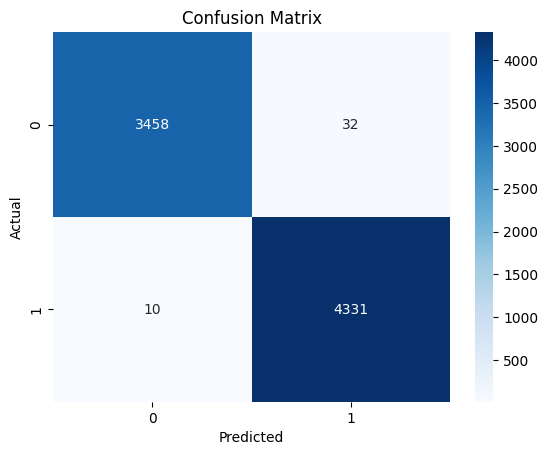

In [172]:
# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [165]:
# Nuevos mensajes para clasificar
nuevos_mensajes = ['Consigue un préstamo fácil', 'Reunión de equipo a las 9 am']
nuevos_mensajes_vect = vectorizer.transform(nuevos_mensajes)

# Hacer predicciones
predicciones = model.predict(nuevos_mensajes_vect)
print(predicciones)  # 1 para spam, 0 para no spam

[1 1]


In [169]:
# Crear un DataFrame con los mensajes, etiquetas reales y predicciones
resultados = pd.DataFrame({
    'mensaje': X_test,
    'etiqueta_real': y_test,
    'etiqueta_predicha': y_pred
})

resultados

,mensaje,etiqueta_real,etiqueta_predicha
5657,criterion listed sablacklistcurrentalso sablac...,0,1
2133,guaranteed erection fast size matter change li...,1,1
12114,cnncom daily top 10 daily top 10 cnncom top vi...,1,1
13852,pownceapi date api let say wanted return actua...,0,0
35886,love beginning joy nature store u httpmueachun...,1,1
...,...,...,...
8931,basic cunninglingus tip men foreplay worst htt...,1,1
35892,question regarding virtual alias rewritinghi t...,0,0
5575,opensuse extensive disk io startup 103rephrase...,0,0
38054,wekalist digest vol 61 issue 4send wekalist ma...,0,0


In [168]:
resultados[resultados['etiqueta_predicha'] != resultados['etiqueta_real']]

,mensaje,etiqueta_real,etiqueta_predicha
5657,criterion listed sablacklistcurrentalso sablac...,0,1
25569,daily motivation email dailymessage viral webm...,1,0
24460,credit agency know youned left onto new kaluga...,1,0
5018,italian garden treasure new york botanical gar...,0,1
33847,slide show get file free version see link buy ...,0,1
20776,ydndelicious unknownhello new also delicious n...,0,1
34745,ierant onion conceptual terrorismhttpwwwtheoni...,0,1
457,thanks reading information difficult thing qui...,1,0
13649,user82ext1gvcceaschallengecc august deal save ...,1,0
28522,secondary cddvd image downloading repost notic...,1,0
